# LearnX Sales Forecasting

---
### Problem Statement:
    
LearnX is an online learning platform aimed at professionals and students. LearnX serves as a market place that allows instructors to build online courses on topics of their expertise which is later published after due diligence by the LearnX team. The platform covers a wide variety of topics including Development, Business, Finance & Accounting & Software Marketing and so on

Effective forecasting for course sales gives essential insight into upcoming cash flow meaning business can more accurately plan the budget to pay instructors and other operational costs and invest in the expansion of the business.

Sales data for more than 2 years from 600 courses of LearnX's top domains is available along with information on

    Competition in the market for each course
    Course Type (Course/Program/Degree)
    Holiday Information for each day
    User Traffic on Course Page for each day
    Your task is to predict the course sales for each course in the test set for the next 60 days

---


### Data Dictionary


---

Data Dictionary

Train (Historical Sales Data)

    Variable	           Definition
    ID	                Unique Identifier for a row
    Day_No	            Day Number
    Course_ID	        Unique ID for a course
    Course_Domain	    Course Domain (Development, Finance etc.)
    Course_Type	        Course/Program/Degree
    Short_Promotion	    Whether Short Term Promotion is Live
    Public_Holiday	    Regional/Public Holiday
    Long_Promotion	    Whether Long Term Promotion is Live for the course
    User_Traffic	    Number of customers landing on the course page
    Competition_Metric	A metric defining the strength of competition 
    Sales	            (Target) Total Course Sales

---
Test (next 60 days)


    Variable	         Definition
    ID	              Unique Identifier for a row
    Day_No	          Day Number
    Course_ID	      Unique ID for a course
    Course_Domain	  Course Domain (Development, Finance etc.)
    Course_Type	      Course/Program/Degree
    Short_Promotion	  Whether Short Term Promotion is Live
    Public_Holiday	  Regional/Public Holiday
    Long_Promotion	  Whether Long Term Promotion is Live for the course
    Competition_Metric	A metric defining the strength of competition
    
   ---


## Index:

       1. Data import
       2. Data validation
       3. Null value imputation
       4. UVA
       5. BVA
       6. Model building
       7. Tuning
       8. Result submission

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from catboost import CatBoostRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tqdm

In [26]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [27]:
# defining evaluation metric:
def rmsle_t(actual, predicted):
    return 1000*(np.sqrt(np.mean((np.power(np.log(np.array(actual)+1) -
                                           np.log(np.array(predicted)+1), 2))) ))


### Importing the data

In [28]:
data = pd.read_csv('train.csv')  # train data
test = pd.read_csv('test.csv')   #test data
print('Data imported')

Data imported


In [29]:
data_orig = data.copy()
test_orig =test.copy()

In [30]:
data.shape, test.shape

((512087, 11), (36000, 9))

In [31]:
# check a sample of train data
data.head()

ID  Day_No  Course_ID Course_Domain Course_Type  Short_Promotion  \
0   1       1          1   Development      Course                0   
1   2       2          1   Development      Course                0   
2   3       3          1   Development      Course                0   
3   4       4          1   Development      Course                0   
4   5       5          1   Development      Course                0   

   Public_Holiday  Long_Promotion  User_Traffic  Competition_Metric  Sales  
0               1               1         11004               0.007     81  
1               0               1         13650               0.007     79  
2               0               1         11655               0.007     75  
3               0               1         12054               0.007     80  
4               0               1          6804               0.007     41

In [32]:
test.head()

ID  Day_No  Course_ID Course_Domain Course_Type  Short_Promotion  \
0  883     883          1   Development      Course                1   
1  884     884          1   Development      Course                1   
2  885     885          1   Development      Course                1   
3  886     886          1   Development      Course                1   
4  887     887          1   Development      Course                0   

   Public_Holiday  Long_Promotion  Competition_Metric  
0               0               1               0.007  
1               0               1               0.007  
2               0               1               0.007  
3               0               1               0.007  
4               0               1               0.007

In [36]:
data['Course_Domain'].min(), data['Course_ID'].max() 

(1, 600)

In [38]:
data['Course_Type'].value_counts()

Course     262747
Program    247576
Degree       1764
Name: Course_Type, dtype: int64

#### We have one column missing- User_Traffic in test dataset other than target variable
We will explore further and check if train dataset shows the feature is important.

## Data validation

Check for data types

In [10]:
data.dtypes

ID                      int64
Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object

In [11]:
data.nunique()

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       196
Sales                    544
dtype: int64

In [12]:
test.nunique()

ID                    36000
Day_No                   60
Course_ID               600
Course_Domain             4
Course_Type               3
Short_Promotion           2
Public_Holiday            2
Long_Promotion            2
Competition_Metric      196
dtype: int64

In [13]:
data.describe().T

count           mean            std    min        25%  \
ID                  512087.0  274007.300650  158228.834029    1.0  136962.50   
Day_No              512087.0     434.917869     256.044161    1.0     214.00   
Course_ID           512087.0     300.388344     173.365787    1.0     150.00   
Short_Promotion     512087.0       0.380244       0.485447    0.0       0.00   
Public_Holiday      512087.0       0.031639       0.175038    0.0       0.00   
Long_Promotion      512087.0       0.488968       0.499879    0.0       0.00   
User_Traffic        512087.0   15375.101198    7727.231205  168.0   10584.00   
Competition_Metric  510323.0       0.073345       0.100115    0.0       0.01   
Sales               512087.0     120.826924      54.355258    0.0      84.00   

                           50%         75%         max  
ID                  273984.000  411065.500  548027.000  
Day_No                 427.000     658.000     882.000  
Course_ID              300.000     451.000     600.000  
Short_Promotion          0.000       1.000       1.000  
Public_Holiday           0.000       0.000       1.000  
Long_Promotion           0.000       1.000       1.000  
User_Traffic         13776.000   18123.000  100002.000  
Competition_Metric       0.035       0.094       0.768  
Sales                  111.000     146.000     682.000

---

    Day no        -    no of days - cont data
    Course_ID     -    unique id of course
    Course domain -    (Development, Software marketing, Finance & Accounting, Business)  -categorical data
    Course_Type   -    (Course, Program, Degree) - Categorical data
    Short_Promotion -  (0,1) - categorical data
    Public_Holiday  -  (0,1) - categorical data
    Long_Promotion  -  (0,1) - categorical data

---

    ID and Course ID being unique identifier

    Day_No - min- 1 to max - 882 representing each day
    User_Traffic - 
    Competition_Metric - Score given to the course based on the competition in market
    Sales - target variable, showing number of times course purchased.





--- 

User traffic and sales show most variance interms of data distribution, we might have to cap the outliers



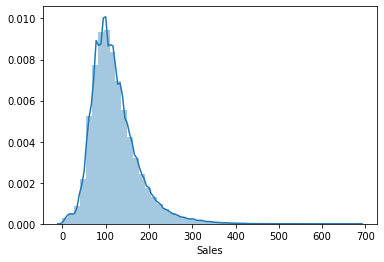

In [14]:
sns.distplot(data['Sales'])

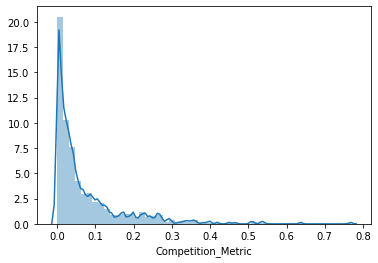

In [15]:
sns.distplot(data['Competition_Metric'])

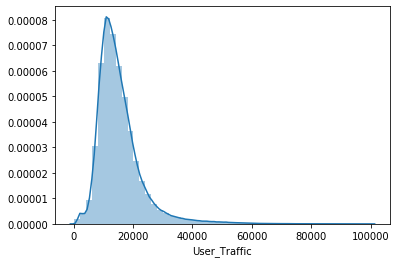

In [16]:
sns.distplot(data['User_Traffic'])

### Managing outliers:
... 
We can take log to change the distribution to normal or,
We can assign the quantile value to outliers

In [17]:
## As sales & User Traffic is only avaialble in training data, uisng outlier capping in train data only ###
numeric_col= data[["User_Traffic","Sales","Competition_Metric"]]
for i in numeric_col:
    data.loc[data[i]>data[i].quantile(0.99),i]=data[i].quantile(0.99)
    data.loc[data[i]<data[i].quantile(0.01),i]=data[i].quantile(0.01)
data.describe(percentiles=[0.01,0.05,0.95,0.99]).T

count           mean            std     min       1%  \
ID                  512087.0  274007.300650  158228.834029     1.0  5421.86   
Day_No              512087.0     434.917869     256.044161     1.0     9.00   
Course_ID           512087.0     300.388344     173.365787     1.0     6.00   
Short_Promotion     512087.0       0.380244       0.485447     0.0     0.00   
Public_Holiday      512087.0       0.031639       0.175038     0.0     0.00   
Long_Promotion      512087.0       0.488968       0.499879     0.0     0.00   
User_Traffic        512087.0   15295.651682    7222.328295  3780.0  3780.00   
Competition_Metric  510323.0       0.072579       0.095961     0.0     0.00   
Sales               512087.0     120.477577      52.170514    27.0    27.00   

                           5%         50%         95%         99%         max  
ID                  27345.300  273984.000  520682.700  542546.140  548027.000  
Day_No                 43.000     427.000     840.000     874.000     882.000  
Course_ID              30.000     300.000     571.000     594.000     600.000  
Short_Promotion         0.000       0.000       1.000       1.000       1.000  
Public_Holiday          0.000       0.000       0.000       1.000       1.000  
Long_Promotion          0.000       0.000       1.000       1.000       1.000  
User_Traffic         7035.000   13776.000   29064.000   46221.000   46221.000  
Competition_Metric      0.001       0.035       0.269       0.509       0.509  
Sales                  54.000     111.000     222.000     304.000     304.000

In [19]:
### As Competition_Metric in both the tables , we can do outlier capping after combining these ####
numeric_col= test[["Competition_Metric"]]
for i in numeric_col:
    test.loc[test[i]>test[i].quantile(0.99),i]=test[i].quantile(0.99)

In [20]:
# data['Course_Domain'].value_counts()   #to be run one by one 
# data['Course_Type'].value_counts()
# data['Short_Promotion'].value_counts()
# data['Public_Holiday'].value_counts()
# data['Long_Promotion'].value_counts()
data['User_Traffic'].nunique()

2022

In [21]:
data.isnull().sum()

ID                       0
Day_No                   0
Course_ID                0
Course_Domain            0
Course_Type              0
Short_Promotion          0
Public_Holiday           0
Long_Promotion           0
User_Traffic             0
Competition_Metric    1764
Sales                    0
dtype: int64

In [22]:
test.isnull().sum()

ID                      0
Day_No                  0
Course_ID               0
Course_Domain           0
Course_Type             0
Short_Promotion         0
Public_Holiday          0
Long_Promotion          0
Competition_Metric    120
dtype: int64

In [23]:
# filtering data
bool_series = pd.isnull(data["Competition_Metric"])

# displayind data only with Course_ID = NaN
data[bool_series]['Course_ID'].value_counts()

354    882
176    882
Name: Course_ID, dtype: int64

In [24]:
# filtering data
bool_series = pd.isnull(test["Competition_Metric"])

# displayind data only with Course_ID = NaN
test[bool_series]['Course_ID'].value_counts()

354    60
176    60
Name: Course_ID, dtype: int64

In [23]:
data['Competition_Metric'].min(), data['Competition_Metric'].max()

(0.0, 0.509)

In [24]:
data[data['Competition_Metric']== 0.509]

ID  Day_No  Course_ID       Course_Domain Course_Type  \
60084    64285       1         71         Development     Program   
60085    64286       2         71         Development     Program   
60086    64287       3         71         Development     Program   
60087    64288       4         71         Development     Program   
60088    64289       5         71         Development     Program   
...        ...     ...        ...                 ...         ...   
381369  408130     878        447  Software Marketing      Course   
381370  408131     879        447  Software Marketing      Course   
381371  408132     880        447  Software Marketing      Course   
381372  408133     881        447  Software Marketing      Course   
381373  408134     882        447  Software Marketing      Course   

        Short_Promotion  Public_Holiday  Long_Promotion  User_Traffic  \
60084                 0               1               0        9660.0   
60085                 0               0               0       19110.0   
60086                 0               0               0       13944.0   
60087                 0               0               0       13587.0   
60088                 0               0               0       15036.0   
...                 ...             ...             ...           ...   
381369                0               0               0       10521.0   
381370                0               0               0       12180.0   
381371                0               0               0       10101.0   
381372                0               0               0       10101.0   
381373                1               0               0       15498.0   

        Competition_Metric  Sales  
60084                0.509   76.0  
60085                0.509  120.0  
60086                0.509   83.0  
60087                0.509   95.0  
60088                0.509   93.0  
...                    ...    ...  
381369               0.509   91.0  
381370               0.509  116.0  
381371               0.509   84.0  
381372               0.509   79.0  
381373               0.509  164.0  

[5292 rows x 11 columns]

In [25]:
data[data['Competition_Metric']== 0.000000]

ID  Day_No  Course_ID Course_Domain Course_Type  Short_Promotion  \
13744    14705       1         17   Development      Course                0   
13745    14706       2         17   Development      Course                0   
13746    14707       3         17   Development      Course                0   
13747    14708       4         17   Development      Course                0   
13748    14709       5         17   Development      Course                0   
...        ...     ...        ...           ...         ...              ...   
464162  496743     878        544   Development     Program                0   
464163  496744     879        544   Development     Program                0   
464164  496745     880        544   Development     Program                0   
464165  496746     881        544   Development     Program                0   
464166  496747     882        544   Development     Program                1   

        Public_Holiday  Long_Promotion  User_Traffic  Competition_Metric  \
13744                1               1       13104.0                 0.0   
13745                0               1       19803.0                 0.0   
13746                0               1       20727.0                 0.0   
13747                0               1       16863.0                 0.0   
13748                0               1       18858.0                 0.0   
...                ...             ...           ...                 ...   
464162               0               0       13251.0                 0.0   
464163               0               0       15813.0                 0.0   
464164               0               0       14322.0                 0.0   
464165               0               0       13398.0                 0.0   
464166               0               0       21063.0                 0.0   

        Sales  
13744   134.0  
13745   102.0  
13746   112.0  
13747    91.0  
13748   101.0  
...       ...  
464162   87.0  
464163  109.0  
464164   95.0  
464165   82.0  
464166  167.0  

[8819 rows x 11 columns]

In [26]:
test[test['Course_ID']==354]

ID  Day_No  Course_ID Course_Domain Course_Type  Short_Promotion  \
21180  324025     883        354   Development     Program                1   
21181  324026     884        354   Development     Program                1   
21182  324027     885        354   Development     Program                1   
21183  324028     886        354   Development     Program                1   
21184  324029     887        354   Development     Program                0   
21185  324030     888        354   Development     Program                0   
21186  324031     889        354   Development     Program                0   
21187  324032     890        354   Development     Program                0   
21188  324033     891        354   Development     Program                0   
21189  324034     892        354   Development     Program                0   
21190  324035     893        354   Development     Program                0   
21191  324036     894        354   Development     Program                0   
21192  324037     895        354   Development     Program                0   
21193  324038     896        354   Development     Program                1   
21194  324039     897        354   Development     Program                1   
21195  324040     898        354   Development     Program                1   
21196  324041     899        354   Development     Program                1   
21197  324042     900        354   Development     Program                1   
21198  324043     901        354   Development     Program                0   
21199  324044     902        354   Development     Program                0   
21200  324045     903        354   Development     Program                0   
21201  324046     904        354   Development     Program                0   
21202  324047     905        354   Development     Program                0   
21203  324048     906        354   Development     Program                0   
21204  324049     907        354   Development     Program                0   
21205  324050     908        354   Development     Program                0   
21206  324051     909        354   Development     Program                0   
21207  324052     910        354   Development     Program                1   
21208  324053     911        354   Development     Program                1   
21209  324054     912        354   Development     Program                1   
21210  324055     913        354   Development     Program                1   
21211  324056     914        354   Development     Program                1   
21212  324057     915        354   Development     Program                0   
21213  324058     916        354   Development     Program                0   
21214  324059     917        354   Development     Program                0   
21215  324060     918        354   Development     Program                0   
21216  324061     919        354   Development     Program                0   
21217  324062     920        354   Development     Program                0   
21218  324063     921        354   Development     Program                0   
21219  324064     922        354   Development     Program                0   
21220  324065     923        354   Development     Program                0   
21221  324066     924        354   Development     Program                1   
21222  324067     925        354   Development     Program                1   
21223  324068     926        354   Development     Program                1   
21224  324069     927        354   Development     Program                1   
21225  324070     928        354   Development     Program                1   
21226  324071     929        354   Development     Program                0   
21227  324072     930        354   Development     Program                0   
21228  324073     931        354   Development     Program                0   
21229  324074     932        354   Development     Program   

#### It seems, of all 600 courses, we do not have competition metric for two courses. Let's impute the values using mean 

In [27]:
#Should try to combine train and test to impute metric to check any improvements later

In [28]:
data["Competition_Metric"] = data.groupby(["Course_Domain","Course_Type"])["Competition_Metric"].transform(lambda x: 
                                                                                                           x.fillna(x.mean()))

In [29]:
data["Competition_Metric"] = data.groupby(["Course_Domain","Course_Type"])["Competition_Metric"].transform(lambda x: 
                                                                                                           x.fillna(x.mean()))
test["Competition_Metric"] = test.groupby(["Course_Domain","Course_Type"])["Competition_Metric"].transform(lambda x: 
                                                                                                           x.fillna(x.mean()))

In [30]:
data.isnull().sum()

ID                    0
Day_No                0
Course_ID             0
Course_Domain         0
Course_Type           0
Short_Promotion       0
Public_Holiday        0
Long_Promotion        0
User_Traffic          0
Competition_Metric    0
Sales                 0
dtype: int64

In [31]:
test.isnull().sum()

ID                    0
Day_No                0
Course_ID             0
Course_Domain         0
Course_Type           0
Short_Promotion       0
Public_Holiday        0
Long_Promotion        0
Competition_Metric    0
dtype: int64

### Our  data: 

    train - data
    test - test

## Univariate Analysis (UVA)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  512087 non-null  int64  
 1   Day_No              512087 non-null  int64  
 2   Course_ID           512087 non-null  int64  
 3   Course_Domain       512087 non-null  object 
 4   Course_Type         512087 non-null  object 
 5   Short_Promotion     512087 non-null  int64  
 6   Public_Holiday      512087 non-null  int64  
 7   Long_Promotion      512087 non-null  int64  
 8   User_Traffic        512087 non-null  float64
 9   Competition_Metric  512087 non-null  float64
 10  Sales               512087 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 43.0+ MB


In [43]:
cat_cols =  ['Course_Domain','Course_Type','Short_Promotion','Public_Holiday',
             'Long_Promotion']
cont_cols = ['Day_No','User_Traffic','Competition_Metric','Sales']

In [34]:
def plot_cat(var, l=8,b=5):
    plt.figure( figsize = (l, b))
    sns.countplot(data[var], order = data[var].value_counts().index)

In [35]:
def plot_cont(var, l=8,b=5):
    plt.figure(figsize=(l, b))
    sns.distplot(data[var])
    plt.xlabel(var)

In [36]:
def plot_cont_kde(var, l=8,b=5):
    
    mini = data[var].min()
    maxi = data[var].max()
    ran = data[var].max()-data[var].min()
    mean = data[var].mean()
    skew = data[var].skew()
    kurt = data[var].kurtosis()
    median = data[var].median()
    st_dev = data[var].std()
    points = mean-st_dev, mean+st_dev
    
    fig, axes=plt.subplots(1,2)
    sns.boxplot(data=data,x=var, ax=axes[0])
    sns.distplot(a=data[var], ax=axes[1], color='#ff4125')
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini, maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    fig.set_size_inches(l,b)
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median =  {}'.format((round(points[0],2),round(points[1],2)),
    round(kurt,2),round(skew,2),(round(mini,2),round(maxi,2),
    round(ran,2)),round(mean,2), round(median,2)))

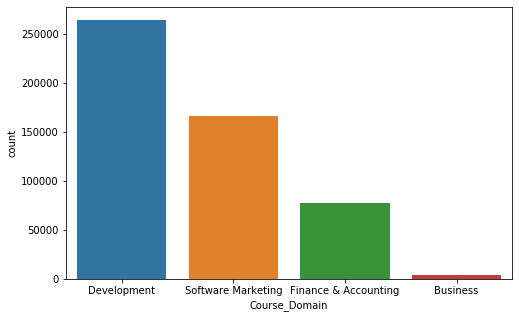

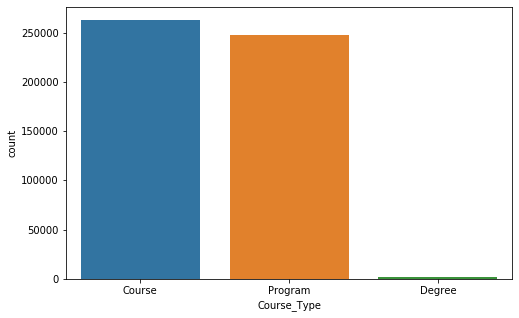

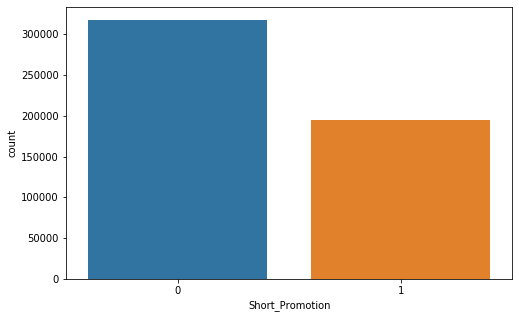

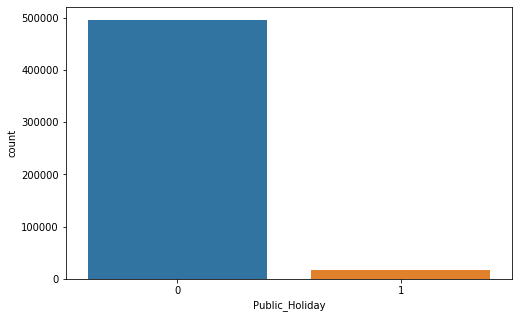

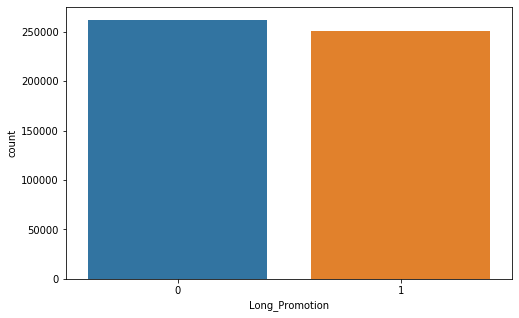

In [37]:
for i in cat_cols:
    plot_cat(i)

### Inferences:

    Course Domain - Max courses are for Development and least for Business.
    Course type - count of degree in total course available is pretty low
    

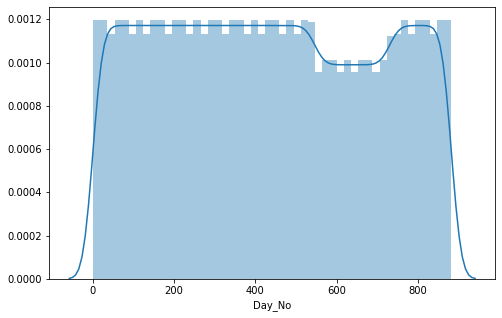

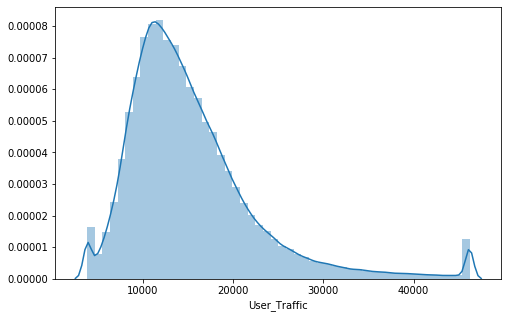

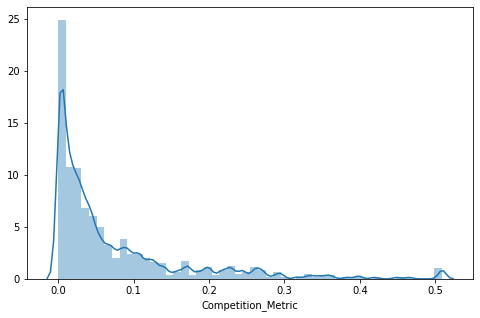

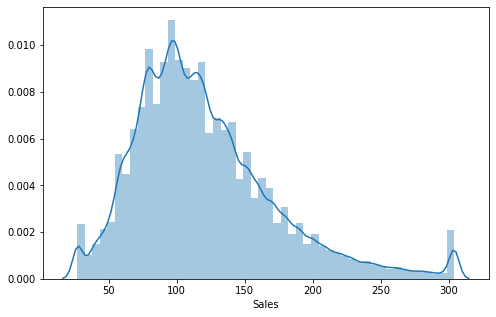

In [38]:
for i in cont_cols:
    plot_cont(i)

In [39]:
plot_cont_kde('Sales',20,6)

NameError: name 'plot_cont_kde' is not defined

### Inferences:

After capping the outliers, Sales is giving a distribution similar to normal.


    

## BVA

#### In Bi-variate let's analyze one by one based on features as :
        - Continuous - Continuoous
        - Continuous- Categorical
        - Categorical - Categorical


### Cont-Cont

In [44]:
#Defining a function to calculate correlation among columns:
def corr_2_cols(Col1, Col2):
    res = pd.crosstab(data[Col1],data[Col2])
    # res = df1.groupby([Col1, Col2]).size().unstack()
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [45]:
cont_cols

['Day_No', 'User_Traffic', 'Competition_Metric', 'Sales']

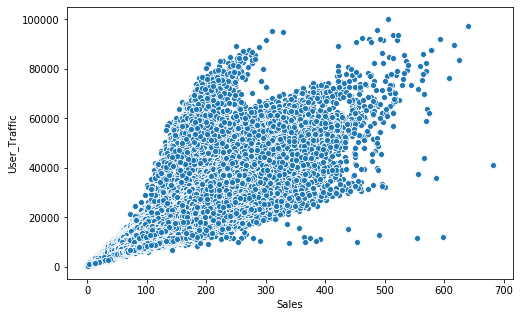

In [50]:
# scatter plot for transactional variables
plt.figure(figsize = (8,5))
# Draw line plot
sns.scatterplot(x = "Sales", y = "User_Traffic", data=data)
plt.show()

<Figure size 840x560 with 0 Axes>

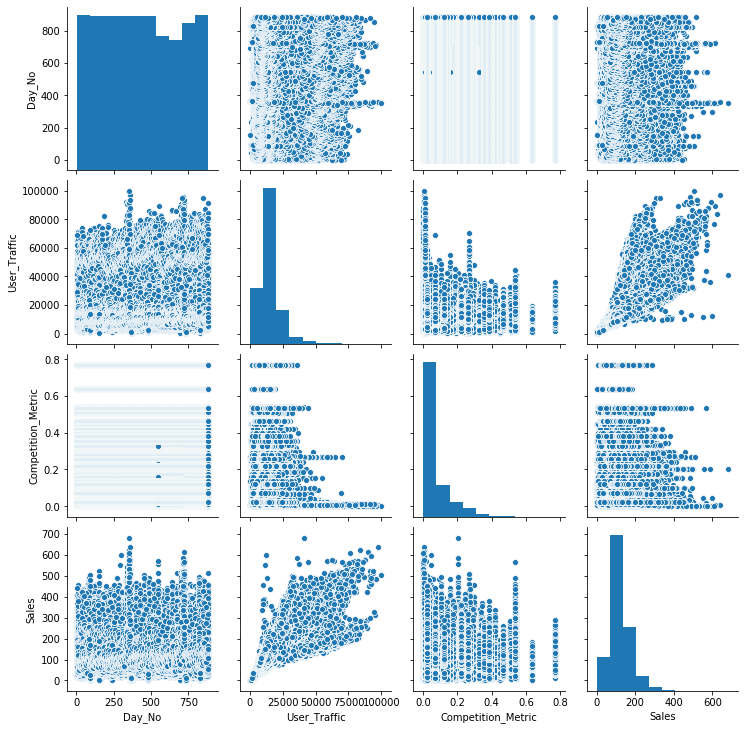

In [46]:
# scatter plot for transactional variables
plt.figure(dpi=140)
sns.lineplot(data[cont_cols])

In [43]:
correlation = data[cont_cols].corr()
correlation

Day_No  User_Traffic  Competition_Metric     Sales
Day_No              1.000000      0.021338            0.003176  0.062157
User_Traffic        0.021338      1.000000           -0.156342  0.842259
Competition_Metric  0.003176     -0.156342            1.000000 -0.019415
Sales               0.062157      0.842259           -0.019415  1.000000

In [44]:
corr_data= data.corr()
cor_with_target=cor_data.sort_values(['Sales'],ascending=False)
cor_with_target["Sales"]

Sales                 1.000000
User_Traffic          0.842259
Short_Promotion       0.374855
Day_No                0.062157
ID                    0.018910
Course_ID             0.018763
Competition_Metric   -0.019415
Long_Promotion       -0.110404
Public_Holiday       -0.131280
Name: Sales, dtype: float64

In [53]:
df = data.copy()

In [54]:
#applying log to further check any change in the correlation

In [55]:
#taking log of every value to negate outliers
for column in cont_cols:
  mini=1
  if data[column].min()<0:
    mini =  abs(df[column].min()) + 1
  
  df[column] = [i+mini for i in df[column]]
  df[column] = df[column].map(lambda x : np.log(x))

<Figure size 840x560 with 0 Axes>

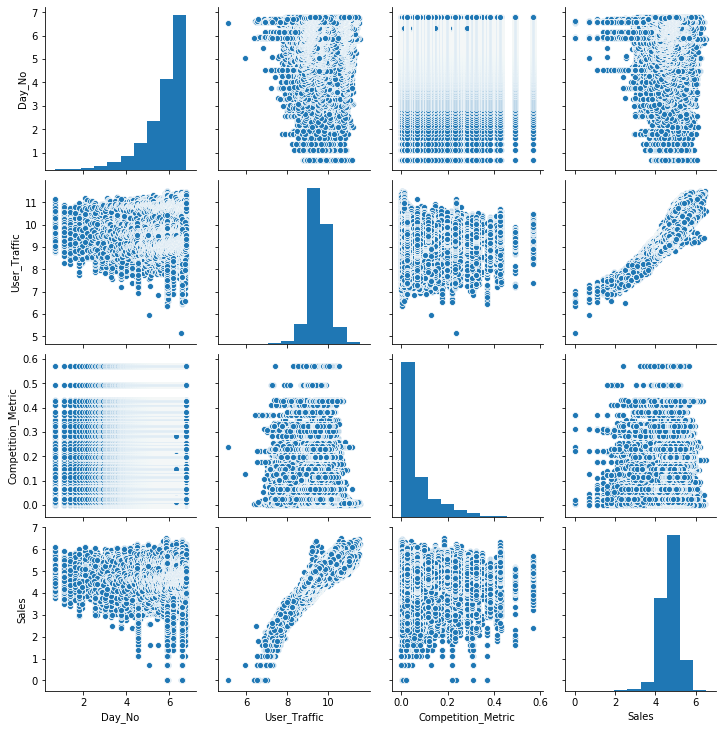

In [56]:
# scatter plot for transactional variables
plt.figure(dpi=140)
sns.pairplot(df[cont_cols])

#### Inference:
User_Traffic shows the highest correlation with the target variable.
We are certain that we will need the same to improve our target variable prediction.
We can use other features to first predict User_Traffic for test dataset.

## Cont - Cat

In [49]:
cont_cols,  cat_cols

(['Day_No', 'User_Traffic', 'Competition_Metric', 'Sales'],
 ['Course_Domain',
  'Course_Type',
  'Short_Promotion',
  'Public_Holiday',
  'Long_Promotion'])

### Cat - Course_Domain

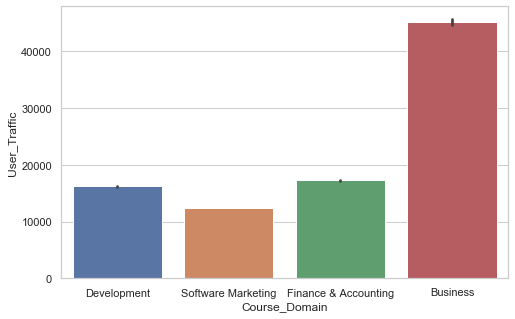

In [57]:
plt.figure(figsize= (8,5))
sns.set(style="whitegrid")
sns.barplot(x='Course_Domain',y='User_Traffic',data = data)

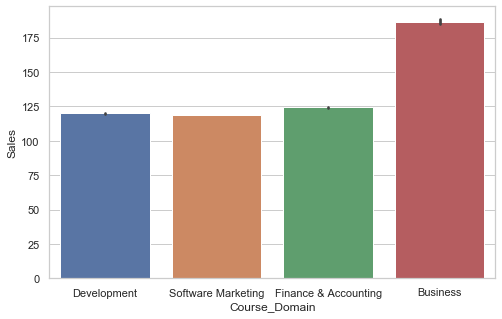

In [58]:
plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.barplot(x='Course_Domain',y='Sales',data = data)

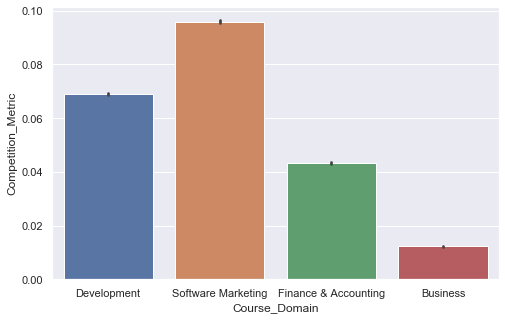

In [59]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Course_Domain',y='Competition_Metric',data = data)

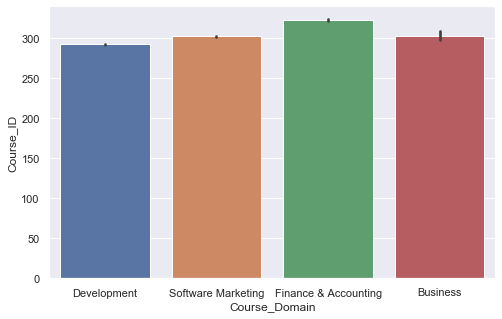

In [76]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Course_Domain',y='Course_ID',data = data)

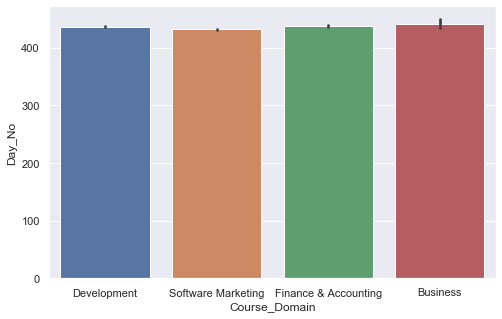

In [60]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Course_Domain',y='Day_No',data = data)

This shows the Business domain has highest user traffic and Sales but courses present do not have high Competition metric.

  ** Showing a high user interest, we can work on to improve the courses present in this domain.
  
  Also, as our Software marketing courses have the highest competition metric, we can work on to improve the user reach.

### Cat - Course_Type

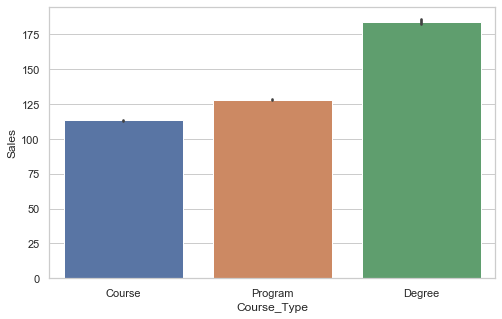

In [61]:
plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.barplot(x='Course_Type',y='Sales',data = data)

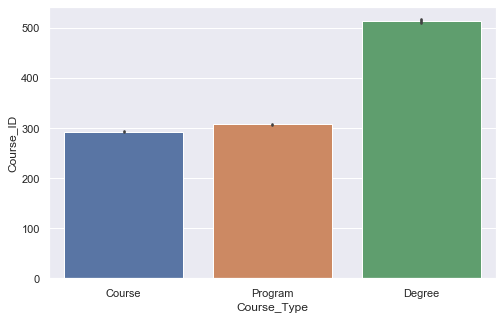

In [77]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Course_Type',y='Course_ID',data = data)

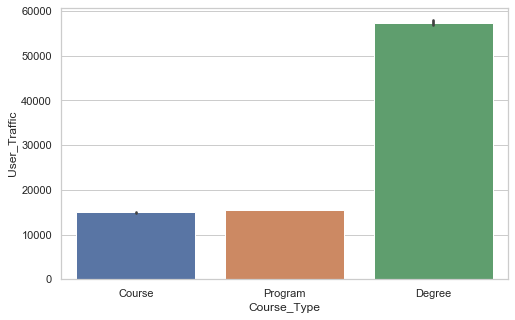

In [62]:
plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.barplot(x='Course_Type',y='User_Traffic',data = data)

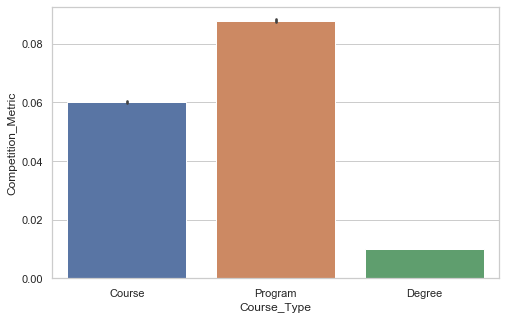

In [63]:
plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.barplot(x='Course_Type',y='Competition_Metric',data = data)

As per the last trend , here also course type(Degree) having highest sales and traffic showing a low competition metric score.

###  Cat - Short promotion 

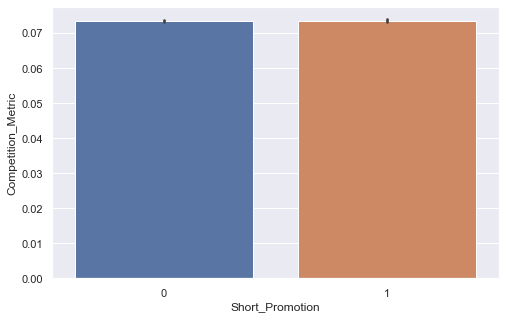

In [64]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Short_Promotion',y='Competition_Metric',data = data)

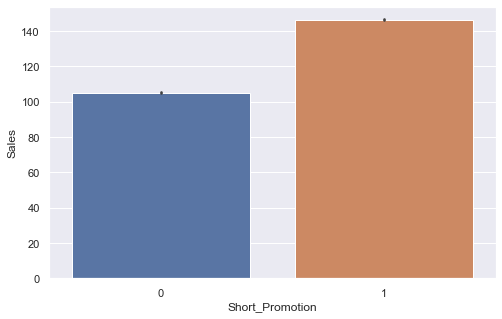

In [65]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Short_Promotion',y='Sales',data = data)

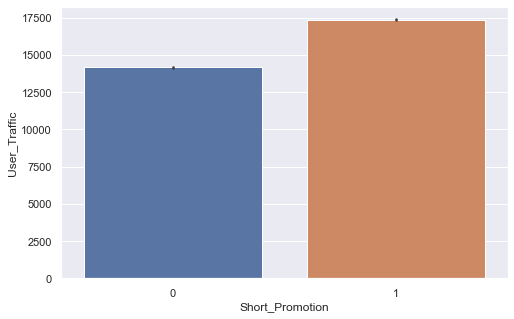

In [66]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Short_Promotion',y='User_Traffic',data = data)

#### Short promotion shows an improvement in sales 

### Cat - Long_Promotion

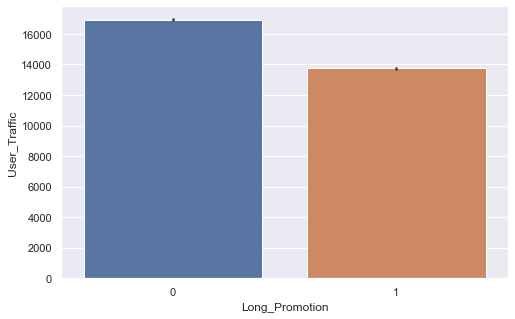

In [67]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Long_Promotion',y='User_Traffic',data = data)

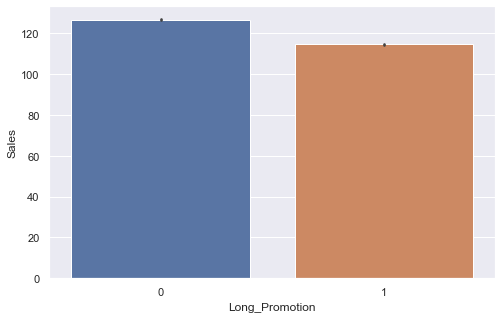

In [68]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Long_Promotion',y='Sales',data = data)

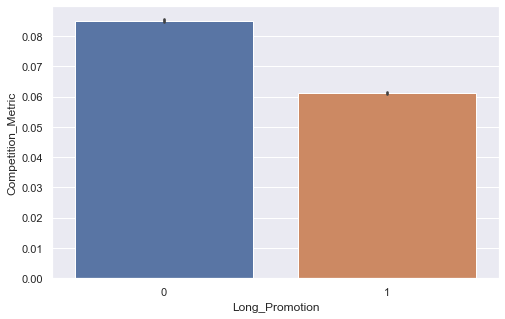

In [69]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Long_Promotion',y='Competition_Metric',data = data)

Long promotion seems to have none or negetive efect on the total sales

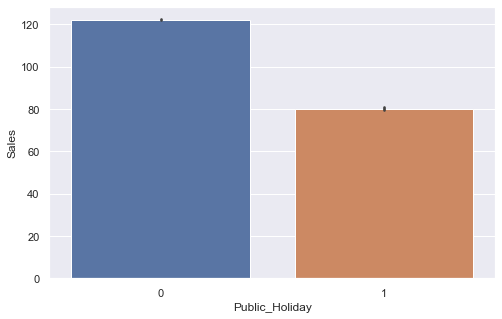

In [70]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Public_Holiday',y='Sales',data = data)

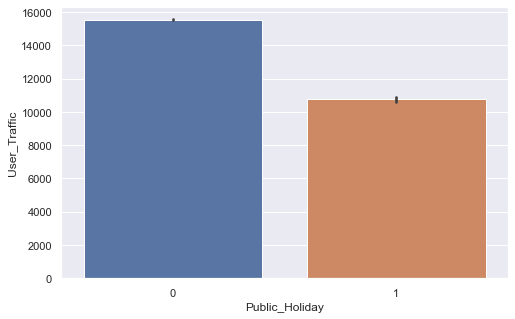

In [71]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
sns.barplot(x='Public_Holiday',y='User_Traffic',data = data)

## Cat-Cat

In [72]:
def BVA_categorical_plot(data, cat1, cat2):
  '''
  take data and two categorical variables,
  calculates the chi2 significance between the two variables 
  and prints the result with countplot & CrossTab
  '''
  #isolating the variables
  data = data[[cat2,cat1]][:]

  #forming a crosstab
  table = pd.crosstab(data[cat1],data[cat2],)
  f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

  #performing chi2 test
  from scipy.stats import chi2_contingency
  chi, p, dof, expected = chi2_contingency(f_obs)
  
  #checking whether results are significant
  if p<0.05:
    sig = True
  else:
    sig = False

  #plotting grouped plot
  plt.figure(figsize =(12,8))
  sns.countplot(x=cat2, hue=cat1, data=data)
  plt.title("p-value = {}\n difference significant? = {}\n".format(round(p,8),sig))

  #plotting percent stacked bar plot
  #sns.catplot(ax, kind='stacked')
  plt.figure(figsize =(12,8))
  ax1 = data.groupby(cat2)[cat1].value_counts(normalize=True).unstack()
  ax1.plot(kind='bar', stacked='True',title=str(ax1))
  int_level = data[cat2].value_counts()

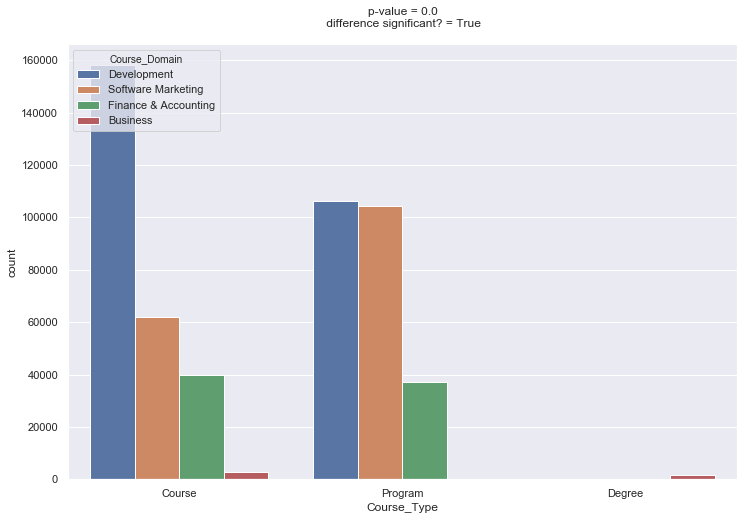

<Figure size 864x576 with 0 Axes>

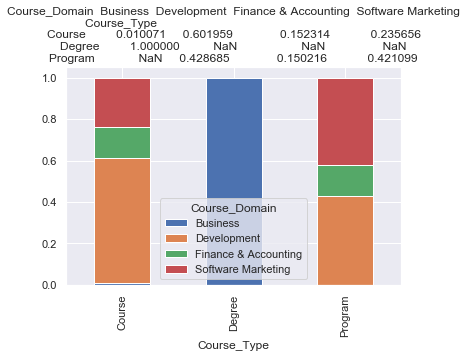

In [73]:
BVA_categorical_plot(data, 'Course_Domain', 'Course_Type')

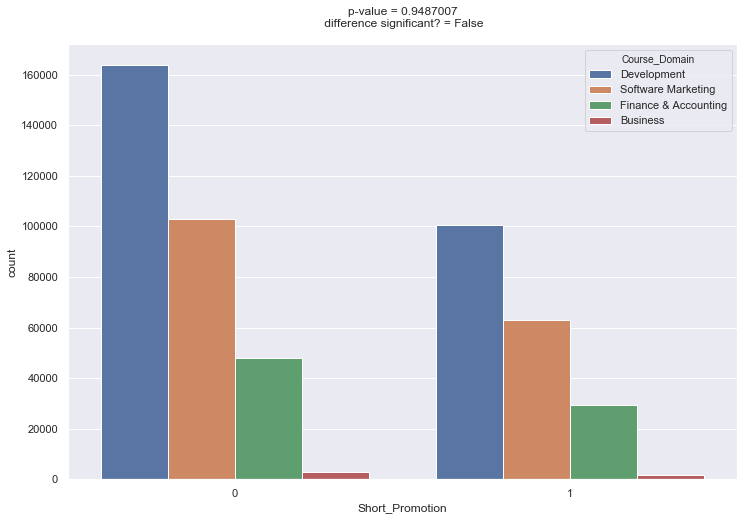

<Figure size 864x576 with 0 Axes>

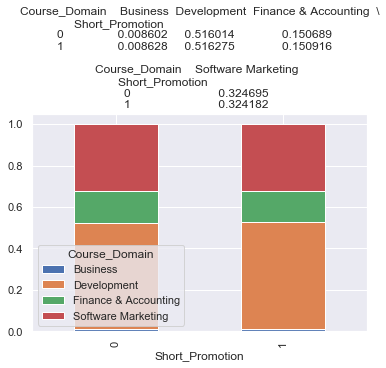

In [74]:
BVA_categorical_plot(data, 'Course_Domain', 'Short_Promotion')

Shows that for degree, only Business domain and vice-versa

In [75]:
cat_cols

['Course_Domain',
 'Course_Type',
 'Short_Promotion',
 'Public_Holiday',
 'Long_Promotion']

## Features

We have day no as count of days. We can use Day_No to create further columns such as - year, month or week. hat might help our model catch a pattern.

### Checkpoint1

In [78]:

data_save=data.copy()
test_save =test.copy()

In [79]:
#year
data["Year_No"]=np.ceil(data["Day_No"]/365)
test["Year_No"]=np.ceil(test["Day_No"]/365)


In [80]:
# alligning day as per year
data["Year_Day_No"]=0
test["Year_Day_No"]=0

data.loc[data["Year_No"]==1,"Year_Day_No"]=data["Day_No"]
data.loc[data["Year_No"]==2,"Year_Day_No"]=data["Day_No"]-365
data.loc[data["Year_No"]==3,"Year_Day_No"]=data["Day_No"]-730

test.loc[test["Year_No"]==1,"Year_Day_No"]=test["Day_No"]
test.loc[test["Year_No"]==2,"Year_Day_No"]=test["Day_No"]-365
test.loc[test["Year_No"]==3,"Year_Day_No"]=test["Day_No"]-730

In [81]:
#month

data["Months"]=np.ceil(data["Year_Day_No"]/30)
test["Months"]=np.ceil(test["Year_Day_No"]/30)

data.loc[data["Months"]==13,"Months"]=12
test.loc[test["Months"]==13,"Months"]=12

In [82]:
#weeks 
data["Weeks"]=np.ceil(data["Year_Day_No"]/7)
test["Weeks"]=np.ceil(test["Year_Day_No"]/7)

data.loc[data["Weeks"]==53,"Weeks"]=52
test.loc[data["Weeks"]==53,"Weeks"]=52

In [83]:
data.sample(5)

ID  Day_No  Course_ID         Course_Domain Course_Type  \
46102    49283     461         54  Finance & Accounting      Course   
382998  409939      45        450    Software Marketing      Course   
359267  384528     274        422    Software Marketing     Program   
5034      5335     625          6           Development      Course   
337091  360732     256        395           Development     Program   

        Short_Promotion  Public_Holiday  Long_Promotion  User_Traffic  \
46102                 0               0               1         11634   
382998                0               0               1          9681   
359267                0               0               1         15393   
5034                  1               0               0         12894   
337091                1               0               1         19782   

        Competition_Metric  Sales  Year_No  Year_Day_No  Months  Weeks  
46102                0.003    101      2.0           96     4.0   14.0  
382998               0.003     99      1.0           45     2.0    7.0  
359267               0.007    139      1.0          274    10.0   40.0  
5034                 0.041    102      2.0          260     9.0   38.0  
337091               0.006    177      1.0          256     9.0   37.0

In [84]:
test.sample(5)

ID  Day_No  Course_ID         Course_Domain Course_Type  \
18966  290097     889        317    Software Marketing     Program   
33171  504909     934        553  Finance & Accounting      Course   
7465   114036     908        125    Software Marketing      Course   
16525  252782     908        276           Development      Course   
13687  209594     890        229  Finance & Accounting     Program   

       Short_Promotion  Public_Holiday  Long_Promotion  Competition_Metric  \
18966                0               0               0               0.015   
33171                0               0               1               0.049   
7465                 0               0               1               0.013   
16525                0               0               0               0.002   
13687                0               0               1               0.020   

       Year_No  Year_Day_No  Months  Weeks  
18966      3.0          159     6.0   23.0  
33171      3.0          204     7.0   30.0  
7465       3.0          178     6.0   26.0  
16525      3.0          178     6.0   26.0  
13687      3.0          160     6.0   23.0

In [85]:
data['Months']=data['Months'].astype(int).astype(str)
data['Year_No'] = data['Year_No'].astype(int).astype(str)
data['Weeks'] = data['Weeks'].astype(int).astype(str)

test['Months']=test['Months'].astype(int).astype(str)
test['Year_No'] = test['Year_No'].astype(int).astype(str)
test['Weeks'] = test['Weeks'].astype(int).astype(str)


In [86]:
cols=data[["Year_No","Months","Weeks","Long_Promotion","Public_Holiday","Short_Promotion",'Course_Domain','Course_Type']]
for i in cols:
    data[i]=data[i].astype('category')
    test[i]=test[i].astype('category')

In [87]:
cols=data[["Long_Promotion","Public_Holiday","Short_Promotion",'Course_Domain','Course_Type']]
for i in cols:
    data[i]=data[i].astype('category')
    test[i]=test[i].astype('category')

In [35]:
test.dtypes

ID                       int64
Day_No                   int64
Course_ID                int64
Course_Domain         category
Course_Type           category
Short_Promotion       category
Public_Holiday        category
Long_Promotion        category
Competition_Metric     float64
dtype: object

In [38]:
# cols=data[["Year_No","Months","Weeks","Long_Promotion","Public_Holiday","Short_Promotion"]]
# for i in cols:
#     data[i]=data[i].astype(object)
#     test[i]=test[i].astype(object)



### Checkpoint2

In [88]:

data_cb =data.copy()  #copy data
test_cb = test.copy()

In [89]:
cor_mat= data.corr()
cor_with_tar=cor_mat.sort_values(['Sales'],ascending=False)
cor_with_tar["Sales"]

Sales                 1.000000
User_Traffic          0.829741
Year_Day_No           0.071395
Day_No                0.060012
ID                    0.017037
Course_ID             0.016894
Competition_Metric   -0.022085
Name: Sales, dtype: float64

In [41]:
data.shape, test.shape

((512087, 15), (36000, 13))

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ID                  512087 non-null  int64   
 1   Day_No              512087 non-null  int64   
 2   Course_ID           512087 non-null  int64   
 3   Course_Domain       512087 non-null  category
 4   Course_Type         512087 non-null  category
 5   Short_Promotion     512087 non-null  category
 6   Public_Holiday      512087 non-null  category
 7   Long_Promotion      512087 non-null  category
 8   User_Traffic        512087 non-null  float64 
 9   Competition_Metric  512087 non-null  float64 
 10  Sales               512087 non-null  float64 
 11  Year_No             512087 non-null  category
 12  Year_Day_No         512087 non-null  int64   
 13  Months              512087 non-null  category
 14  Weeks               512087 non-null  category
dtypes: category(8), f

In [43]:
data_cb.columns, test_cb.columns


(Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
        'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
        'Competition_Metric', 'Sales', 'Year_No', 'Year_Day_No', 'Months',
        'Weeks'],
       dtype='object'),
 Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
        'Short_Promotion', 'Public_Holiday', 'Long_Promotion',
        'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks'],
       dtype='object'))

# Model

### As we do not have user traffic column in test so - First step, we need to predict the User traffic column 

In [38]:
data_cb.drop(columns=['Sales','ID'],axis=1, inplace=True)
test_cb.drop(columns=['ID'],axis=1, inplace=True)


In [39]:
data_cb.columns

Index(['Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric'],
      dtype='object')

In [42]:
yc_test

383176     9156.0
456364     8547.0
484896    21441.0
352379    21441.0
423049    14784.0
           ...   
440614     9702.0
307878    17136.0
6476      18417.0
16246     18606.0
182462    19992.0
Name: User_Traffic, Length: 102418, dtype: float64

In [43]:
test_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Day_No              36000 non-null  int64   
 1   Course_ID           36000 non-null  int64   
 2   Course_Domain       36000 non-null  category
 3   Course_Type         36000 non-null  category
 4   Short_Promotion     36000 non-null  category
 5   Public_Holiday      36000 non-null  category
 6   Long_Promotion      36000 non-null  category
 7   Competition_Metric  36000 non-null  float64 
dtypes: category(5), float64(1), int64(2)
memory usage: 1020.2 KB


# Try different model

In [40]:
X = data_cb.drop(["User_Traffic"],axis=1)
y = data_cb["User_Traffic"]

In [41]:

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [56]:
Xc_train.info(), Xc_test.shape, yc_train.shape, yc_test.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409669 entries, 215815 to 61615
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Day_No              409669 non-null  int64   
 1   Course_ID           409669 non-null  int64   
 2   Course_Domain       409669 non-null  category
 3   Course_Type         409669 non-null  category
 4   Short_Promotion     409669 non-null  category
 5   Public_Holiday      409669 non-null  category
 6   Long_Promotion      409669 non-null  category
 7   Competition_Metric  409669 non-null  float64 
dtypes: category(5), float64(1), int64(2)
memory usage: 14.5 MB


(None, (102418, 8), (409669,), (102418,))

In [60]:
Catcols = ['Course_Domain', 'Course_Type', 'Short_Promotion','Long_Promotion','Public_Holiday']

In [47]:
cbbmodel=CatBoostRegressor(random_strength=1,
  max_depth=10,
  learning_rate= 0.3,
  l2_leaf_reg= 10,
  iterations= 1500,
  bagging_temperature=1)

In [61]:
cbbmodel.fit(Xc_train,yc_train,cat_features=Catcols)

0:	learn: 6416.8280784	total: 960ms	remaining: 23m 59s
1:	learn: 5774.5867464	total: 1.57s	remaining: 19m 33s
2:	learn: 5400.7803870	total: 2.1s	remaining: 17m 26s
3:	learn: 5130.0297035	total: 2.56s	remaining: 15m 56s
4:	learn: 4970.7962832	total: 3.07s	remaining: 15m 18s
5:	learn: 4827.4995559	total: 3.52s	remaining: 14m 36s
6:	learn: 4731.2989454	total: 4.06s	remaining: 14m 26s
7:	learn: 4631.3539332	total: 4.62s	remaining: 14m 21s
8:	learn: 4514.4828650	total: 5.14s	remaining: 14m 11s
9:	learn: 4401.9803284	total: 5.7s	remaining: 14m 9s
10:	learn: 4356.8191475	total: 6.27s	remaining: 14m 9s
11:	learn: 4293.4055114	total: 6.82s	remaining: 14m 5s
12:	learn: 4260.6227574	total: 7.62s	remaining: 14m 32s
13:	learn: 4200.9739415	total: 8.23s	remaining: 14m 33s
14:	learn: 4133.2331562	total: 8.78s	remaining: 14m 28s
15:	learn: 4115.0793371	total: 9.29s	remaining: 14m 21s
16:	learn: 4024.5412626	total: 9.82s	remaining: 14m 16s
17:	learn: 3994.0605902	total: 10.4s	remaining: 14m 14s
18:	lea

147:	learn: 2526.0928063	total: 1m 20s	remaining: 12m 15s
148:	learn: 2522.4879772	total: 1m 21s	remaining: 12m 15s
149:	learn: 2520.5460501	total: 1m 21s	remaining: 12m 14s
150:	learn: 2518.1375711	total: 1m 22s	remaining: 12m 14s
151:	learn: 2515.8536322	total: 1m 22s	remaining: 12m 13s
152:	learn: 2513.4203165	total: 1m 23s	remaining: 12m 13s
153:	learn: 2509.8354562	total: 1m 23s	remaining: 12m 12s
154:	learn: 2506.4800465	total: 1m 24s	remaining: 12m 12s
155:	learn: 2506.1336712	total: 1m 24s	remaining: 12m 9s
156:	learn: 2501.4600924	total: 1m 25s	remaining: 12m 8s
157:	learn: 2500.1788539	total: 1m 25s	remaining: 12m 7s
158:	learn: 2496.4669097	total: 1m 26s	remaining: 12m 6s
159:	learn: 2494.0381821	total: 1m 26s	remaining: 12m 6s
160:	learn: 2488.8385158	total: 1m 27s	remaining: 12m 5s
161:	learn: 2484.2002800	total: 1m 27s	remaining: 12m 4s
162:	learn: 2482.1773771	total: 1m 28s	remaining: 12m 4s
163:	learn: 2480.7650036	total: 1m 28s	remaining: 12m 3s
164:	learn: 2478.003027

290:	learn: 2318.2795813	total: 2m 35s	remaining: 10m 45s
291:	learn: 2317.0472560	total: 2m 35s	remaining: 10m 44s
292:	learn: 2316.2421175	total: 2m 36s	remaining: 10m 44s
293:	learn: 2316.0486629	total: 2m 36s	remaining: 10m 43s
294:	learn: 2314.9247369	total: 2m 37s	remaining: 10m 42s
295:	learn: 2314.3024812	total: 2m 37s	remaining: 10m 42s
296:	learn: 2313.2135792	total: 2m 38s	remaining: 10m 41s
297:	learn: 2312.5921982	total: 2m 38s	remaining: 10m 41s
298:	learn: 2312.5905520	total: 2m 39s	remaining: 10m 39s
299:	learn: 2312.0035888	total: 2m 39s	remaining: 10m 38s
300:	learn: 2312.0007280	total: 2m 39s	remaining: 10m 37s
301:	learn: 2310.9872365	total: 2m 40s	remaining: 10m 36s
302:	learn: 2309.4621029	total: 2m 41s	remaining: 10m 36s
303:	learn: 2309.4264599	total: 2m 41s	remaining: 10m 35s
304:	learn: 2308.5453710	total: 2m 42s	remaining: 10m 34s
305:	learn: 2308.0641408	total: 2m 42s	remaining: 10m 33s
306:	learn: 2306.5897141	total: 2m 42s	remaining: 10m 33s
307:	learn: 23

434:	learn: 2246.2254113	total: 3m 45s	remaining: 9m 12s
435:	learn: 2245.6145372	total: 3m 46s	remaining: 9m 12s
436:	learn: 2245.0628503	total: 3m 46s	remaining: 9m 11s
437:	learn: 2244.7678296	total: 3m 47s	remaining: 9m 11s
438:	learn: 2244.3666894	total: 3m 47s	remaining: 9m 10s
439:	learn: 2243.8822967	total: 3m 48s	remaining: 9m 9s
440:	learn: 2243.1348029	total: 3m 48s	remaining: 9m 9s
441:	learn: 2242.6450062	total: 3m 49s	remaining: 9m 9s
442:	learn: 2242.3688994	total: 3m 49s	remaining: 9m 8s
443:	learn: 2242.0954724	total: 3m 50s	remaining: 9m 8s
444:	learn: 2241.6402355	total: 3m 51s	remaining: 9m 7s
445:	learn: 2241.2981897	total: 3m 51s	remaining: 9m 7s
446:	learn: 2241.0273760	total: 3m 52s	remaining: 9m 6s
447:	learn: 2240.5850714	total: 3m 52s	remaining: 9m 6s
448:	learn: 2240.3299911	total: 3m 53s	remaining: 9m 5s
449:	learn: 2239.4937095	total: 3m 53s	remaining: 9m 5s
450:	learn: 2238.8241547	total: 3m 54s	remaining: 9m 4s
451:	learn: 2238.3835581	total: 3m 54s	rema

580:	learn: 2197.2259268	total: 5m 2s	remaining: 7m 58s
581:	learn: 2197.2144518	total: 5m 3s	remaining: 7m 58s
582:	learn: 2196.9849801	total: 5m 3s	remaining: 7m 57s
583:	learn: 2196.6117395	total: 5m 4s	remaining: 7m 57s
584:	learn: 2196.4506714	total: 5m 4s	remaining: 7m 56s
585:	learn: 2196.2905973	total: 5m 5s	remaining: 7m 56s
586:	learn: 2196.2728978	total: 5m 6s	remaining: 7m 55s
587:	learn: 2196.1162554	total: 5m 6s	remaining: 7m 55s
588:	learn: 2196.0513851	total: 5m 6s	remaining: 7m 54s
589:	learn: 2195.8040509	total: 5m 7s	remaining: 7m 54s
590:	learn: 2195.4442020	total: 5m 8s	remaining: 7m 53s
591:	learn: 2194.9120060	total: 5m 8s	remaining: 7m 53s
592:	learn: 2194.5596127	total: 5m 9s	remaining: 7m 53s
593:	learn: 2194.3752534	total: 5m 9s	remaining: 7m 52s
594:	learn: 2194.0387305	total: 5m 10s	remaining: 7m 52s
595:	learn: 2193.7704584	total: 5m 11s	remaining: 7m 51s
596:	learn: 2193.5453218	total: 5m 11s	remaining: 7m 51s
597:	learn: 2193.3572189	total: 5m 12s	remain

725:	learn: 2165.7708594	total: 6m 16s	remaining: 6m 41s
726:	learn: 2165.6615628	total: 6m 17s	remaining: 6m 41s
727:	learn: 2165.4803610	total: 6m 17s	remaining: 6m 40s
728:	learn: 2165.3059026	total: 6m 18s	remaining: 6m 40s
729:	learn: 2165.3001384	total: 6m 19s	remaining: 6m 39s
730:	learn: 2165.0597974	total: 6m 19s	remaining: 6m 39s
731:	learn: 2164.8022878	total: 6m 20s	remaining: 6m 38s
732:	learn: 2164.7326332	total: 6m 20s	remaining: 6m 38s
733:	learn: 2164.6407263	total: 6m 21s	remaining: 6m 37s
734:	learn: 2164.5529106	total: 6m 21s	remaining: 6m 37s
735:	learn: 2164.5496973	total: 6m 22s	remaining: 6m 36s
736:	learn: 2164.5441402	total: 6m 22s	remaining: 6m 36s
737:	learn: 2164.1717195	total: 6m 23s	remaining: 6m 35s
738:	learn: 2163.9821902	total: 6m 23s	remaining: 6m 35s
739:	learn: 2163.7403062	total: 6m 24s	remaining: 6m 34s
740:	learn: 2163.4974163	total: 6m 25s	remaining: 6m 34s
741:	learn: 2163.2262948	total: 6m 25s	remaining: 6m 34s
742:	learn: 2163.0521891	total:

870:	learn: 2142.0061236	total: 7m 36s	remaining: 5m 29s
871:	learn: 2141.9239551	total: 7m 36s	remaining: 5m 28s
872:	learn: 2141.8202044	total: 7m 37s	remaining: 5m 28s
873:	learn: 2141.4965576	total: 7m 38s	remaining: 5m 28s
874:	learn: 2141.4041635	total: 7m 38s	remaining: 5m 27s
875:	learn: 2141.2427643	total: 7m 39s	remaining: 5m 27s
876:	learn: 2141.0218460	total: 7m 39s	remaining: 5m 26s
877:	learn: 2140.9081736	total: 7m 40s	remaining: 5m 26s
878:	learn: 2140.6858806	total: 7m 40s	remaining: 5m 25s
879:	learn: 2140.5538274	total: 7m 41s	remaining: 5m 25s
880:	learn: 2140.5512077	total: 7m 41s	remaining: 5m 24s
881:	learn: 2140.3656468	total: 7m 42s	remaining: 5m 24s
882:	learn: 2140.1756444	total: 7m 43s	remaining: 5m 23s
883:	learn: 2140.0814479	total: 7m 43s	remaining: 5m 23s
884:	learn: 2140.0173939	total: 7m 44s	remaining: 5m 22s
885:	learn: 2139.8286757	total: 7m 44s	remaining: 5m 22s
886:	learn: 2139.7618101	total: 7m 45s	remaining: 5m 21s
887:	learn: 2139.6419226	total:

1015:	learn: 2123.2695491	total: 8m 56s	remaining: 4m 15s
1016:	learn: 2122.9815812	total: 8m 57s	remaining: 4m 15s
1017:	learn: 2122.9120780	total: 8m 57s	remaining: 4m 14s
1018:	learn: 2122.8506996	total: 8m 58s	remaining: 4m 14s
1019:	learn: 2122.6688019	total: 8m 58s	remaining: 4m 13s
1020:	learn: 2122.5092648	total: 8m 59s	remaining: 4m 13s
1021:	learn: 2122.4362977	total: 8m 59s	remaining: 4m 12s
1022:	learn: 2122.4201619	total: 9m	remaining: 4m 11s
1023:	learn: 2122.3352648	total: 9m	remaining: 4m 11s
1024:	learn: 2122.2686884	total: 9m 1s	remaining: 4m 10s
1025:	learn: 2122.1353398	total: 9m 2s	remaining: 4m 10s
1026:	learn: 2122.1144776	total: 9m 2s	remaining: 4m 9s
1027:	learn: 2121.9809888	total: 9m 3s	remaining: 4m 9s
1028:	learn: 2121.8366939	total: 9m 3s	remaining: 4m 8s
1029:	learn: 2121.7448934	total: 9m 4s	remaining: 4m 8s
1030:	learn: 2121.5901737	total: 9m 4s	remaining: 4m 7s
1031:	learn: 2121.5004724	total: 9m 5s	remaining: 4m 7s
1032:	learn: 2121.4191992	total: 9m 

1158:	learn: 2108.4582319	total: 10m 13s	remaining: 3m
1159:	learn: 2108.4114569	total: 10m 14s	remaining: 3m
1160:	learn: 2108.2974126	total: 10m 14s	remaining: 2m 59s
1161:	learn: 2108.0666258	total: 10m 15s	remaining: 2m 59s
1162:	learn: 2107.9347336	total: 10m 16s	remaining: 2m 58s
1163:	learn: 2107.8778054	total: 10m 16s	remaining: 2m 58s
1164:	learn: 2107.8755743	total: 10m 17s	remaining: 2m 57s
1165:	learn: 2107.7809479	total: 10m 17s	remaining: 2m 56s
1166:	learn: 2107.6537347	total: 10m 18s	remaining: 2m 56s
1167:	learn: 2107.5593142	total: 10m 19s	remaining: 2m 55s
1168:	learn: 2107.5055012	total: 10m 19s	remaining: 2m 55s
1169:	learn: 2107.4730981	total: 10m 20s	remaining: 2m 54s
1170:	learn: 2107.3456932	total: 10m 20s	remaining: 2m 54s
1171:	learn: 2107.2615281	total: 10m 21s	remaining: 2m 53s
1172:	learn: 2107.1699339	total: 10m 21s	remaining: 2m 53s
1173:	learn: 2107.0230344	total: 10m 22s	remaining: 2m 52s
1174:	learn: 2106.9942546	total: 10m 22s	remaining: 2m 52s
1175:

1298:	learn: 2096.0120978	total: 12m 29s	remaining: 1m 55s
1299:	learn: 2095.8928458	total: 12m 30s	remaining: 1m 55s
1300:	learn: 2095.7799952	total: 12m 31s	remaining: 1m 54s
1301:	learn: 2095.7248507	total: 12m 32s	remaining: 1m 54s
1302:	learn: 2095.6091727	total: 12m 34s	remaining: 1m 54s
1303:	learn: 2095.5519926	total: 12m 35s	remaining: 1m 53s
1304:	learn: 2095.3928948	total: 12m 36s	remaining: 1m 53s
1305:	learn: 2095.3429819	total: 12m 37s	remaining: 1m 52s
1306:	learn: 2095.3225554	total: 12m 38s	remaining: 1m 52s
1307:	learn: 2095.2555587	total: 12m 39s	remaining: 1m 51s
1308:	learn: 2095.1642680	total: 12m 40s	remaining: 1m 51s
1309:	learn: 2094.9958699	total: 12m 41s	remaining: 1m 50s
1310:	learn: 2094.9022848	total: 12m 43s	remaining: 1m 50s
1311:	learn: 2094.8061738	total: 12m 44s	remaining: 1m 49s
1312:	learn: 2094.7116066	total: 12m 45s	remaining: 1m 48s
1313:	learn: 2094.5337278	total: 12m 46s	remaining: 1m 48s
1314:	learn: 2094.4887121	total: 12m 47s	remaining: 1m 4

1439:	learn: 2084.9003077	total: 15m 7s	remaining: 37.8s
1440:	learn: 2084.8489750	total: 15m 8s	remaining: 37.2s
1441:	learn: 2084.7411507	total: 15m 10s	remaining: 36.6s
1442:	learn: 2084.7026148	total: 15m 11s	remaining: 36s
1443:	learn: 2084.6707105	total: 15m 12s	remaining: 35.4s
1444:	learn: 2084.6280794	total: 15m 13s	remaining: 34.8s
1445:	learn: 2084.5950060	total: 15m 14s	remaining: 34.1s
1446:	learn: 2084.4966180	total: 15m 15s	remaining: 33.5s
1447:	learn: 2084.4264770	total: 15m 16s	remaining: 32.9s
1448:	learn: 2084.3180332	total: 15m 17s	remaining: 32.3s
1449:	learn: 2084.2494568	total: 15m 18s	remaining: 31.7s
1450:	learn: 2084.1994858	total: 15m 19s	remaining: 31.1s
1451:	learn: 2084.0092596	total: 15m 21s	remaining: 30.4s
1452:	learn: 2083.9470610	total: 15m 22s	remaining: 29.8s
1453:	learn: 2083.8589074	total: 15m 23s	remaining: 29.2s
1454:	learn: 2083.7559933	total: 15m 24s	remaining: 28.6s
1455:	learn: 2083.7485397	total: 15m 25s	remaining: 28s
1456:	learn: 2083.68

In [63]:
pre=cbbmodel.predict(Xc_test)

In [64]:
pre.min()

-5094.374583709981

In [65]:
predictions=[]
for i in pre:
    if i<0:
        predictions.append(0)
    else:
        predictions.append(i)

In [66]:
predictions=np.array(predictions)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ID                  512087 non-null  int64   
 1   Day_No              512087 non-null  int64   
 2   Course_ID           512087 non-null  int64   
 3   Course_Domain       512087 non-null  category
 4   Course_Type         512087 non-null  category
 5   Short_Promotion     512087 non-null  category
 6   Public_Holiday      512087 non-null  category
 7   Long_Promotion      512087 non-null  category
 8   User_Traffic        512087 non-null  float64 
 9   Competition_Metric  512087 non-null  float64 
 10  Sales               512087 non-null  float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 25.9 MB


In [77]:
from sklearn.metrics import mean_squared_log_error as msle
result=np.sqrt(msle(yc_test,predictions))*1000
print(result)

245.07269320403168


In [68]:
predictions

array([ 8959.17992421,  9395.65714411, 20658.5908971 , ...,
       18374.37673411, 20541.47239178, 13542.76958687])

In [70]:
testpredict=cbbmodel.predict(test_cb)

In [71]:
testpredict

array([15707.43575948, 15707.43575948, 15707.43575948, ...,
       12948.20764508, 12948.20764508, 12948.20764508])

In [79]:
dict={'ID':test["ID"],'Sales':testpredict}
df=pd.DataFrame(dict)
df.to_csv('catboost1.csv',index=False)

In [80]:
test["ID"]

0           883
1           884
2           885
3           886
4           887
          ...  
35995    548083
35996    548084
35997    548085
35998    548086
35999    548087
Name: ID, Length: 36000, dtype: int64

In [44]:
Xc_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102418 entries, 383176 to 182462
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Day_No              102418 non-null  int64   
 1   Course_ID           102418 non-null  int64   
 2   Course_Domain       102418 non-null  category
 3   Course_Type         102418 non-null  category
 4   Short_Promotion     102418 non-null  category
 5   Public_Holiday      102418 non-null  category
 6   Long_Promotion      102418 non-null  category
 7   Competition_Metric  102418 non-null  float64 
dtypes: category(5), float64(1), int64(2)
memory usage: 3.6 MB


## Applying randomized search

In [50]:
def my_custom_loss_func(actual, predicted):
    return 1000*(np.sqrt(np.mean((np.power(np.log(np.array(actual)+1) -
                                           np.log(np.array(predicted)+1), 2)))
                        ))

In [51]:
categorical_features_indices_cv = ['Course_Domain','Course_Type','Short_Promotion',
'Public_Holiday','Long_Promotion']#,'Year_No','Months','Weeks']

In [60]:
model_cv=CatBoostRegressor(cat_features=categorical_features_indices_cv,random_state=35,od_wait=300,use_best_model=True)

In [61]:
from sklearn.metrics import fbeta_score, make_scorer
my_custom_loss_func = make_scorer(my_custom_loss_func, greater_is_better=False)

In [62]:
# parameter_grid = {
          'depth':[3,1,10],
          'iterations':[250,1000,2000],
          'learning_rate':[0.03,0.01,0.1,0.05,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,50,128,254],
          'bagging_temperature':[0,1,2],
          }

In [106]:
# randomsearch=RandomizedSearchCV(model_cv,param_distributions=parameter_grid,scoring=my_custom_loss_func,verbose=2,n_iter=10)

In [ ]:

# #Xc_train, Xc_test, yc_train, yc_test
# randomsearch.fit(Xc_train, yc_train)

In [ ]:
# randomsearch.best_params_

In [63]:
# randomsearch.best_params_ were: 
catboostcvmodel = CatBoostRegressor(learning_rate= 0.03,
 l2_leaf_reg= 10,
 iterations= 1000,
 depth= 9,
 border_count= 32,
 bagging_temperature= 1,
 od_wait=100,
 od_type='Iter',
 metric_period = 100)

In [64]:
catboostcvmodel.fit(Xc_train, yc_train,
             cat_features=categorical_features_indices_cv,
             eval_set=(Xc_test,yc_test),
             use_best_model=True,
             verbose=True)

0:	learn: 7132.6563039	test: 7138.8093967	best: 7138.8093967 (0)	total: 2.27s	remaining: 37m 48s
100:	learn: 5205.5815691	test: 5222.4287266	best: 5222.4287266 (100)	total: 2m 47s	remaining: 24m 52s
200:	learn: 4985.1304723	test: 4999.1575173	best: 4999.1575173 (200)	total: 5m 42s	remaining: 22m 42s
300:	learn: 4847.0034768	test: 4861.9746126	best: 4861.9746126 (300)	total: 8m 48s	remaining: 20m 26s
400:	learn: 4757.0559827	test: 4772.8475061	best: 4772.8475061 (400)	total: 11m 46s	remaining: 17m 35s
500:	learn: 4698.0495383	test: 4715.0438185	best: 4715.0438185 (500)	total: 14m 48s	remaining: 14m 44s
600:	learn: 4645.5457977	test: 4663.2873908	best: 4663.2873908 (600)	total: 17m 44s	remaining: 11m 46s
700:	learn: 4617.2606658	test: 4637.0236248	best: 4637.0236248 (700)	total: 20m 21s	remaining: 8m 40s
800:	learn: 4594.8585026	test: 4616.5703805	best: 4616.5703805 (800)	total: 23m 2s	remaining: 5m 43s
900:	learn: 4576.6055502	test: 4600.4927477	best: 4600.4927477 (900)	total: 25m 49s	r

In [65]:
val_predcv =catboostcvmodel.predict(Xc_test)

In [73]:
val_predcv.shape

(102418,)

In [72]:
yc_test.shape

(102418,)

In [92]:
# rmsle_t(yc_test,val_predcv)


In [74]:
test_ut_predcv =catboostcvmodel.predict(test_cb)

In [218]:
test_cb['User_Traffic']= test_ut_predcv

In [184]:
test_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Day_No              36000 non-null  int64   
 1   Course_Domain       36000 non-null  category
 2   Course_Type         36000 non-null  category
 3   Short_Promotion     36000 non-null  category
 4   Public_Holiday      36000 non-null  category
 5   Long_Promotion      36000 non-null  category
 6   Competition_Metric  36000 non-null  float64 
 7   Year_No             36000 non-null  category
 8   Year_Day_No         36000 non-null  int64   
 9   Months              36000 non-null  category
 10  Weeks               36000 non-null  category
 11  User_Traffic        36000 non-null  float64 
dtypes: category(8), float64(2), int64(2)
memory usage: 1.4 MB


In [ ]:
# We have imputed the whole User_traffic column in test dataset by applying Catboosting methog on other features.

In [ ]:

# catb_model = CatBoostRegressor(iterations=2000,
#                                  learning_rate= 0.1,
#                                  depth=10,
#                                  eval_metric='MSLE',
#                                  loss_function='RMSE',
#                                  random_seed = 23,
#                                  bagging_temperature = 0.2,
#                                  od_type='Iter',
#                                  metric_period = 100,
#                                  od_wait=100,
#                                  l2_leaf_reg=2)
# catb_model.fit(Xc_train, yc_train,
#              cat_features=categorical_features_indices,
#              eval_set=(Xc_test,yc_test),
#              use_best_model=True,
#              verbose=True)

In [ ]:
# val_pred =catb_model.predict(Xc_test)
# rmsle_t(yc_test,val_pred)
# test_ut_pred =catb_model.predict(test_cb)

In [ ]:
# test = test_cb.copy()
# test.columns

--- 
---

In [219]:
data_cb['Sales']= data['Sales']

In [220]:
data_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Day_No              512087 non-null  int64   
 1   Course_Domain       512087 non-null  category
 2   Course_Type         512087 non-null  category
 3   Short_Promotion     512087 non-null  category
 4   Public_Holiday      512087 non-null  category
 5   Long_Promotion      512087 non-null  category
 6   User_Traffic        512087 non-null  float64 
 7   Competition_Metric  512087 non-null  float64 
 8   Year_No             512087 non-null  category
 9   Year_Day_No         512087 non-null  int64   
 10  Months              512087 non-null  category
 11  Weeks               512087 non-null  category
 12  Sales               512087 non-null  float64 
dtypes: category(8), float64(3), int64(2)
memory usage: 23.4 MB


## Main model

---
### Checkpoint3

In [221]:

train_target= data_cb['Sales']

data_cb["Temp"]="train"
test_cb["Temp"]="test"
test_cb["Sales"]=0


In [244]:
data_combo = pd.concat([data_cb,test_cb],axis=0,ignore_index=True)

In [245]:
data_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548087 entries, 0 to 548086
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Day_No              548087 non-null  int64   
 1   Course_Domain       548087 non-null  category
 2   Course_Type         548087 non-null  category
 3   Short_Promotion     548087 non-null  category
 4   Public_Holiday      548087 non-null  category
 5   Long_Promotion      548087 non-null  category
 6   User_Traffic        548087 non-null  float64 
 7   Competition_Metric  548087 non-null  float64 
 8   Year_No             548087 non-null  object  
 9   Year_Day_No         548087 non-null  int64   
 10  Months              548087 non-null  object  
 11  Weeks               548087 non-null  object  
 12  Sales               548087 non-null  float64 
 13  Temp                548087 non-null  object  
dtypes: category(5), float64(3), int64(2), object(4)
memory usage: 40.2+ 

### Creating dummies

In [224]:
data_combo.select_dtypes(include = 'category').columns

Index(['Course_Domain', 'Course_Type', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion'],
      dtype='object')

In [246]:
dummy=pd.get_dummies(data_combo[['Course_Domain', 'Course_Type', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion', 'Year_No', 'Months', 'Weeks']],drop_first=False)
data_combo=pd.concat([data_combo,dummy],axis=1)

In [247]:
data_combo.drop(['Course_Domain', 'Course_Type', 'Short_Promotion', 'Public_Holiday',
       'Long_Promotion', 'Year_No', 'Months', 'Weeks'],axis=1,inplace=True)

In [248]:
data_combo.shape

(548087, 86)

In [289]:
data_combo["Temp"].value_counts()

train    512087
test      36000
Name: Temp, dtype: int64

In [290]:
traind=data_combo.loc[data_combo["Temp"]=="train"]
testd=data_combo.loc[data_combo["Temp"]=="test"]

In [291]:
traind.shape, testd.shape

((512087, 86), (36000, 86))

In [292]:
traind=traind.drop(columns =['Temp'],axis=1)
testd=testd.drop(columns =['Temp'],axis=1)

In [293]:
traind.columns

Index(['Day_No', 'User_Traffic', 'Competition_Metric', 'Year_Day_No', 'Sales',
       'Course_Domain_Business', 'Course_Domain_Development',
       'Course_Domain_Finance & Accounting',
       'Course_Domain_Software Marketing', 'Course_Type_Course',
       'Course_Type_Degree', 'Course_Type_Program', 'Short_Promotion_0',
       'Short_Promotion_1', 'Public_Holiday_0', 'Public_Holiday_1',
       'Long_Promotion_0', 'Long_Promotion_1', 'Year_No_1', 'Year_No_2',
       'Year_No_3', 'Months_1', 'Months_10', 'Months_11', 'Months_12',
       'Months_2', 'Months_3', 'Months_4', 'Months_5', 'Months_6', 'Months_7',
       'Months_8', 'Months_9', 'Weeks_1', 'Weeks_10', 'Weeks_11', 'Weeks_12',
       'Weeks_13', 'Weeks_14', 'Weeks_15', 'Weeks_16', 'Weeks_17', 'Weeks_18',
       'Weeks_19', 'Weeks_2', 'Weeks_20', 'Weeks_21', 'Weeks_22', 'Weeks_23',
       'Weeks_24', 'Weeks_25', 'Weeks_26', 'Weeks_27', 'Weeks_28', 'Weeks_29',
       'Weeks_3', 'Weeks_30', 'Weeks_31', 'Weeks_32', 'Weeks_33', 'Week

## Splitting the dataset


In [294]:
X_m = traind.drop('Sales',1)
y_m = traind['Sales']

In [295]:
y_m.head()

0    81.0
1    79.0
2    75.0
3    80.0
4    41.0
Name: Sales, dtype: float64

In [296]:
X_train, X_valid, y_train, y_valid = train_test_split(X_m, y_m, test_size=0.2, random_state=7)

In [297]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((409669, 84), (102418, 84), (409669,), (102418,))

---

# Running ml models

### Simple regression - 

In [298]:
linreg = LinearRegression()


In [299]:
linreg.fit(X_train,y_train)
train_y_pred = linreg.predict(X_train)
test_y_pred = linreg.predict(X_valid)
# 

In [300]:
len(test_y_pred)

102418

In [301]:
rmsle_t(y_train , train_y_pred) , rmsle_t(y_valid , test_y_pred)

(175.80668388178137, 175.58095841525792)

In [302]:
testd=testd.drop('Sales',1)

In [303]:
test_pred_lr = linreg.predict(testd)

In [304]:
test_pred_lr.shape

(36000,)

In [305]:
df_test = pd.read_csv('sample_submission_pn2DrMq_KeLPcvs.csv')

In [306]:
df_test.shape

(36000, 2)

In [307]:
df_test['Sales'] = test_pred_lr

In [308]:
df_test.to_csv('submit_lr.csv',header =True, index=False)

### Applying Random Forest:

In [347]:
from sklearn.ensemble import RandomForestRegressor
modelRf = RandomForestRegressor(n_estimators=25)

In [349]:
#Fit the model
modelRf.fit(X_train, y_train)

#X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

RandomForestRegressor(n_estimators=25)

In [351]:
Rfpred= modelRf.predict(X_valid)

In [352]:
rmsle_t(y_valid,Rfpred)

87.2583412111768

In [353]:
Rfpred_m= modelRf.predict(testd)

In [354]:
df_test['Sales'] = Rfpred_m

df_test.to_csv('submit_Rf.csv',header =True, index=False)

### lgbm

In [359]:
from pandas import Series, DataFrame 
from datetime import datetime
#import lightgbm
import lightgbm as lgb

In [356]:
# #The data is stored in a DMatrix object 
# #label is used to define our outcome variable
# dtrain=xgb.DMatrix(X_train,label=y_train)

# dtest=xgb.DMatrix(X_valid)
# dtest_lg = xgb.DMatrix(testd)

# #X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [357]:
#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':3,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

In [360]:
train_data=lgb.Dataset(X_train,label=y_train)

In [361]:
# #training our model using light gbm
num_round=50
start=datetime.now()
lgbm=lgb.train(param,train_data,num_round)
stop=datetime.now()

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 409669, number of negative: 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 409669, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped 

In [362]:
#Execution time of the model
execution_time_lgbm = stop-start
execution_time_lgbm

datetime.timedelta(seconds=72, microseconds=541196)

In [ ]:
test_pred_lg=lgbm.predict()

In [ ]:
model = lgb.LGBMClassifier()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [10,15,20],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

model, pred = search_pipeline(X_train, X_valid, y_train, y_valid, model, 
                                 param_grid, cv=5, search_mode = 'RandomizedSearchCV',n_iterations = 15)

print(model.best_score_)
print(model.best_params_)

In [ ]:
param = {'subsample_freq': 20, 'subsample': 0.9, 'reg_lambda': 1.3, 
         'reg_alpha': 1.2, 'num_leaves': 100, 'n_estimators': 700, 'min_split_gain': 0.4,
         'max_depth': 20, 'colsample_bytree': 0.7}


In [ ]:
num_round=70
lgbm2=lgb.train(param,train_data,num_round)

In [ ]:
#predicting on test set
ypredrs=lgbm1.predict(testd)
ypredrs[0:5]  # showing first 5 predictions

## Using random search on catboost:

In [316]:
data_cb.columns, test_cb.columns

(Index(['Day_No', 'Course_Domain', 'Course_Type', 'Short_Promotion',
        'Public_Holiday', 'Long_Promotion', 'User_Traffic',
        'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks',
        'Sales', 'Temp'],
       dtype='object'),
 Index(['Day_No', 'Course_Domain', 'Course_Type', 'Short_Promotion',
        'Public_Holiday', 'Long_Promotion', 'Competition_Metric', 'Year_No',
        'Year_Day_No', 'Months', 'Weeks', 'User_Traffic', 'Temp', 'Sales'],
       dtype='object'))

In [333]:
test_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Day_No              36000 non-null  int64   
 1   Course_Domain       36000 non-null  category
 2   Course_Type         36000 non-null  category
 3   Short_Promotion     36000 non-null  category
 4   Public_Holiday      36000 non-null  category
 5   Long_Promotion      36000 non-null  category
 6   Competition_Metric  36000 non-null  float64 
 7   Year_No             36000 non-null  category
 8   Year_Day_No         36000 non-null  int64   
 9   Months              36000 non-null  category
 10  Weeks               36000 non-null  category
 11  User_Traffic        36000 non-null  float64 
dtypes: category(8), float64(2), int64(2)
memory usage: 1.4 MB


In [318]:
data_cb.drop('Temp',1, inplace=True )
test_cb.drop(columns = ['Temp','Sales'],axis=1,inplace=True)

In [319]:
X = data_cb.drop(["Sales"],axis=1)
y = data_cb["Sales"]
Xcb_train, Xcb_val, ycb_train, ycb_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [322]:
Xcb_train.shape, Xcb_val.shape, ycb_train.shape, ycb_val.shape, test_cb.shape

((409669, 12), (102418, 12), (409669,), (102418,), (36000, 12))

In [335]:
categorical_features_indices_cv = ['Course_Domain','Course_Type','Short_Promotion',
'Public_Holiday','Long_Promotion','Year_No','Months','Weeks']

In [323]:
model_catb=CatBoostRegressor(cat_features=categorical_features_indices_cv,random_state=35,od_wait=100,od_type='Iter')

In [324]:
parameter_grid = {
          'depth':[1,3,5,7,10],
          'iterations':[250,500,1000,2000],
          'learning_rate':[0.03,0.01,0.1,0.05,0.3], 
          'l2_leaf_reg':[3,1,5,10],
          'border_count':[32,5,50,128],
          'bagging_temperature':[0,1,2],
          }
# #Xcb_train, Xcb_val, ycb_train, ycb_val


In [325]:
randomsearch=RandomizedSearchCV(model_catb,param_distributions=parameter_grid,
                                scoring=my_custom_loss_func,verbose=2,n_iter=12)

In [326]:
randomsearch.fit(Xcb_train, ycb_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.03, l2_leaf_reg=5, iterations=2000, depth=5, border_count=50, bagging_temperature=0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 51.0117435	total: 3.11s	remaining: 1h 43m 44s
1:	learn: 49.9536440	total: 6.17s	remaining: 1h 42m 41s
2:	learn: 48.9343029	total: 8.33s	remaining: 1h 32m 28s
3:	learn: 47.9506523	total: 9.43s	remaining: 1h 18m 27s
4:	learn: 46.9960447	total: 10.7s	remaining: 1h 11m 9s
5:	learn: 46.0756814	total: 11.4s	remaining: 1h 2m 55s
6:	learn: 45.1923684	total: 12.5s	remaining: 59m 25s
7:	learn: 44.3266289	total: 13.6s	remaining: 56m 20s
8:	learn: 43.4982664	total: 14s	remaining: 51m 31s
9:	learn: 42.6984209	total: 14.4s	remaining: 47m 40s
10:	learn: 41.9341684	total: 14.8s	remaining: 44m 31s
11:	learn: 41.1793472	total: 15.2s	remaining: 41m 56s
12:	learn: 40.4520910	total: 15.7s	remaining: 40m 1s
13:	learn: 39.7551771	total: 17.8s	remaining: 42m 2s
14:	learn: 39.0938806	total: 18.3s	remaining: 40m 16s
15:	learn: 38.4510317	total: 18.7s	remaining: 38m 40s
16:	learn: 37.8369741	total: 19.2s	remaining: 37m 14s
17:	learn: 37.2257633	total: 19.5s	remaining: 35m 52s
18:	learn: 36.6539949	tota

152:	learn: 19.1321359	total: 1m 16s	remaining: 15m 17s
153:	learn: 19.1153553	total: 1m 16s	remaining: 15m 15s
154:	learn: 19.0978718	total: 1m 16s	remaining: 15m 13s
155:	learn: 19.0794022	total: 1m 17s	remaining: 15m 10s
156:	learn: 19.0644193	total: 1m 17s	remaining: 15m 8s
157:	learn: 19.0389964	total: 1m 17s	remaining: 15m 7s
158:	learn: 19.0252653	total: 1m 18s	remaining: 15m 6s
159:	learn: 19.0007425	total: 1m 18s	remaining: 15m 4s
160:	learn: 18.9846387	total: 1m 18s	remaining: 15m 1s
161:	learn: 18.9706650	total: 1m 19s	remaining: 14m 59s
162:	learn: 18.9543382	total: 1m 19s	remaining: 14m 57s
163:	learn: 18.9348785	total: 1m 20s	remaining: 14m 56s
164:	learn: 18.9121665	total: 1m 20s	remaining: 14m 54s
165:	learn: 18.8999643	total: 1m 20s	remaining: 14m 53s
166:	learn: 18.8797676	total: 1m 21s	remaining: 14m 52s
167:	learn: 18.8646521	total: 1m 21s	remaining: 14m 49s
168:	learn: 18.8531036	total: 1m 22s	remaining: 14m 48s
169:	learn: 18.8354119	total: 1m 22s	remaining: 14m 4

300:	learn: 17.6446320	total: 2m 11s	remaining: 12m 20s
301:	learn: 17.6410262	total: 2m 11s	remaining: 12m 19s
302:	learn: 17.6344954	total: 2m 11s	remaining: 12m 18s
303:	learn: 17.6293505	total: 2m 12s	remaining: 12m 17s
304:	learn: 17.6230074	total: 2m 12s	remaining: 12m 16s
305:	learn: 17.6170359	total: 2m 12s	remaining: 12m 16s
306:	learn: 17.6103705	total: 2m 13s	remaining: 12m 15s
307:	learn: 17.6043758	total: 2m 13s	remaining: 12m 14s
308:	learn: 17.6010127	total: 2m 14s	remaining: 12m 13s
309:	learn: 17.5897621	total: 2m 14s	remaining: 12m 13s
310:	learn: 17.5844199	total: 2m 14s	remaining: 12m 12s
311:	learn: 17.5806867	total: 2m 15s	remaining: 12m 12s
312:	learn: 17.5707577	total: 2m 15s	remaining: 12m 11s
313:	learn: 17.5664600	total: 2m 16s	remaining: 12m 10s
314:	learn: 17.5614887	total: 2m 16s	remaining: 12m 9s
315:	learn: 17.5545228	total: 2m 16s	remaining: 12m 8s
316:	learn: 17.5443922	total: 2m 17s	remaining: 12m 7s
317:	learn: 17.5373397	total: 2m 17s	remaining: 12m

448:	learn: 16.9285043	total: 3m 4s	remaining: 10m 38s
449:	learn: 16.9242873	total: 3m 5s	remaining: 10m 37s
450:	learn: 16.9200591	total: 3m 5s	remaining: 10m 37s
451:	learn: 16.9153948	total: 3m 6s	remaining: 10m 37s
452:	learn: 16.9113196	total: 3m 6s	remaining: 10m 37s
453:	learn: 16.9085297	total: 3m 7s	remaining: 10m 36s
454:	learn: 16.9051460	total: 3m 7s	remaining: 10m 36s
455:	learn: 16.9018876	total: 3m 7s	remaining: 10m 35s
456:	learn: 16.8982736	total: 3m 8s	remaining: 10m 35s
457:	learn: 16.8944031	total: 3m 8s	remaining: 10m 34s
458:	learn: 16.8933110	total: 3m 8s	remaining: 10m 34s
459:	learn: 16.8911237	total: 3m 9s	remaining: 10m 34s
460:	learn: 16.8859371	total: 3m 9s	remaining: 10m 34s
461:	learn: 16.8820834	total: 3m 10s	remaining: 10m 33s
462:	learn: 16.8788689	total: 3m 10s	remaining: 10m 33s
463:	learn: 16.8757753	total: 3m 11s	remaining: 10m 32s
464:	learn: 16.8727940	total: 3m 11s	remaining: 10m 32s
465:	learn: 16.8695260	total: 3m 11s	remaining: 10m 31s
466:	

597:	learn: 16.4712473	total: 4m 1s	remaining: 9m 26s
598:	learn: 16.4683757	total: 4m 2s	remaining: 9m 26s
599:	learn: 16.4654210	total: 4m 2s	remaining: 9m 26s
600:	learn: 16.4640262	total: 4m 3s	remaining: 9m 25s
601:	learn: 16.4597188	total: 4m 3s	remaining: 9m 25s
602:	learn: 16.4587955	total: 4m 3s	remaining: 9m 24s
603:	learn: 16.4559446	total: 4m 4s	remaining: 9m 24s
604:	learn: 16.4519020	total: 4m 4s	remaining: 9m 23s
605:	learn: 16.4498748	total: 4m 4s	remaining: 9m 23s
606:	learn: 16.4484015	total: 4m 5s	remaining: 9m 22s
607:	learn: 16.4465225	total: 4m 5s	remaining: 9m 22s
608:	learn: 16.4443129	total: 4m 5s	remaining: 9m 21s
609:	learn: 16.4425552	total: 4m 6s	remaining: 9m 21s
610:	learn: 16.4414833	total: 4m 6s	remaining: 9m 21s
611:	learn: 16.4376118	total: 4m 7s	remaining: 9m 20s
612:	learn: 16.4357696	total: 4m 7s	remaining: 9m 20s
613:	learn: 16.4341149	total: 4m 7s	remaining: 9m 19s
614:	learn: 16.4309954	total: 4m 8s	remaining: 9m 19s
615:	learn: 16.4298639	total

747:	learn: 16.1004826	total: 5m	remaining: 8m 22s
748:	learn: 16.0995576	total: 5m	remaining: 8m 22s
749:	learn: 16.0970873	total: 5m 1s	remaining: 8m 21s
750:	learn: 16.0955368	total: 5m 1s	remaining: 8m 21s
751:	learn: 16.0896715	total: 5m 1s	remaining: 8m 20s
752:	learn: 16.0846237	total: 5m 2s	remaining: 8m 20s
753:	learn: 16.0819355	total: 5m 2s	remaining: 8m 19s
754:	learn: 16.0722605	total: 5m 2s	remaining: 8m 19s
755:	learn: 16.0679642	total: 5m 3s	remaining: 8m 19s
756:	learn: 16.0652975	total: 5m 3s	remaining: 8m 18s
757:	learn: 16.0634295	total: 5m 4s	remaining: 8m 18s
758:	learn: 16.0610012	total: 5m 4s	remaining: 8m 17s
759:	learn: 16.0590776	total: 5m 4s	remaining: 8m 17s
760:	learn: 16.0576495	total: 5m 5s	remaining: 8m 16s
761:	learn: 16.0543143	total: 5m 5s	remaining: 8m 16s
762:	learn: 16.0534737	total: 5m 5s	remaining: 8m 16s
763:	learn: 16.0514422	total: 5m 6s	remaining: 8m 15s
764:	learn: 16.0466758	total: 5m 6s	remaining: 8m 15s
765:	learn: 16.0452906	total: 5m 7

898:	learn: 15.7928552	total: 6m 1s	remaining: 7m 22s
899:	learn: 15.7891518	total: 6m 1s	remaining: 7m 21s
900:	learn: 15.7885150	total: 6m 1s	remaining: 7m 21s
901:	learn: 15.7851489	total: 6m 2s	remaining: 7m 20s
902:	learn: 15.7844972	total: 6m 2s	remaining: 7m 20s
903:	learn: 15.7825785	total: 6m 3s	remaining: 7m 20s
904:	learn: 15.7794198	total: 6m 3s	remaining: 7m 19s
905:	learn: 15.7790309	total: 6m 3s	remaining: 7m 19s
906:	learn: 15.7787497	total: 6m 4s	remaining: 7m 18s
907:	learn: 15.7725224	total: 6m 4s	remaining: 7m 18s
908:	learn: 15.7693759	total: 6m 4s	remaining: 7m 17s
909:	learn: 15.7677925	total: 6m 5s	remaining: 7m 17s
910:	learn: 15.7668669	total: 6m 5s	remaining: 7m 17s
911:	learn: 15.7661667	total: 6m 6s	remaining: 7m 16s
912:	learn: 15.7652302	total: 6m 6s	remaining: 7m 16s
913:	learn: 15.7641314	total: 6m 6s	remaining: 7m 15s
914:	learn: 15.7632436	total: 6m 7s	remaining: 7m 15s
915:	learn: 15.7624668	total: 6m 7s	remaining: 7m 14s
916:	learn: 15.7619800	total

1048:	learn: 15.5492458	total: 6m 59s	remaining: 6m 20s
1049:	learn: 15.5482881	total: 7m	remaining: 6m 20s
1050:	learn: 15.5471377	total: 7m	remaining: 6m 19s
1051:	learn: 15.5467571	total: 7m 1s	remaining: 6m 19s
1052:	learn: 15.5460228	total: 7m 1s	remaining: 6m 19s
1053:	learn: 15.5455331	total: 7m 2s	remaining: 6m 18s
1054:	learn: 15.5451301	total: 7m 2s	remaining: 6m 18s
1055:	learn: 15.5419693	total: 7m 2s	remaining: 6m 17s
1056:	learn: 15.5376452	total: 7m 3s	remaining: 6m 17s
1057:	learn: 15.5368878	total: 7m 3s	remaining: 6m 17s
1058:	learn: 15.5351840	total: 7m 4s	remaining: 6m 16s
1059:	learn: 15.5321963	total: 7m 4s	remaining: 6m 16s
1060:	learn: 15.5305309	total: 7m 4s	remaining: 6m 16s
1061:	learn: 15.5294584	total: 7m 5s	remaining: 6m 15s
1062:	learn: 15.5278669	total: 7m 5s	remaining: 6m 15s
1063:	learn: 15.5263171	total: 7m 6s	remaining: 6m 14s
1064:	learn: 15.5260159	total: 7m 6s	remaining: 6m 14s
1065:	learn: 15.5246395	total: 7m 6s	remaining: 6m 13s
1066:	learn: 15

1196:	learn: 15.3794567	total: 7m 55s	remaining: 5m 19s
1197:	learn: 15.3793658	total: 7m 56s	remaining: 5m 18s
1198:	learn: 15.3789520	total: 7m 56s	remaining: 5m 18s
1199:	learn: 15.3781742	total: 7m 56s	remaining: 5m 17s
1200:	learn: 15.3776193	total: 7m 57s	remaining: 5m 17s
1201:	learn: 15.3768884	total: 7m 57s	remaining: 5m 17s
1202:	learn: 15.3765406	total: 7m 57s	remaining: 5m 16s
1203:	learn: 15.3763515	total: 7m 58s	remaining: 5m 16s
1204:	learn: 15.3756202	total: 7m 58s	remaining: 5m 15s
1205:	learn: 15.3751634	total: 7m 58s	remaining: 5m 15s
1206:	learn: 15.3744602	total: 7m 59s	remaining: 5m 14s
1207:	learn: 15.3740109	total: 7m 59s	remaining: 5m 14s
1208:	learn: 15.3737679	total: 7m 59s	remaining: 5m 13s
1209:	learn: 15.3733355	total: 8m	remaining: 5m 13s
1210:	learn: 15.3731023	total: 8m	remaining: 5m 12s
1211:	learn: 15.3729891	total: 8m	remaining: 5m 12s
1212:	learn: 15.3694787	total: 8m 1s	remaining: 5m 12s
1213:	learn: 15.3674225	total: 8m 1s	remaining: 5m 11s
1214:	

1344:	learn: 15.1704064	total: 8m 54s	remaining: 4m 20s
1345:	learn: 15.1700261	total: 8m 54s	remaining: 4m 19s
1346:	learn: 15.1696909	total: 8m 54s	remaining: 4m 19s
1347:	learn: 15.1673225	total: 8m 55s	remaining: 4m 18s
1348:	learn: 15.1670072	total: 8m 55s	remaining: 4m 18s
1349:	learn: 15.1668225	total: 8m 55s	remaining: 4m 18s
1350:	learn: 15.1665452	total: 8m 56s	remaining: 4m 17s
1351:	learn: 15.1655923	total: 8m 56s	remaining: 4m 17s
1352:	learn: 15.1637499	total: 8m 57s	remaining: 4m 16s
1353:	learn: 15.1635428	total: 8m 57s	remaining: 4m 16s
1354:	learn: 15.1624305	total: 8m 57s	remaining: 4m 16s
1355:	learn: 15.1599387	total: 8m 58s	remaining: 4m 15s
1356:	learn: 15.1590770	total: 8m 58s	remaining: 4m 15s
1357:	learn: 15.1576190	total: 8m 58s	remaining: 4m 14s
1358:	learn: 15.1573024	total: 8m 59s	remaining: 4m 14s
1359:	learn: 15.1569221	total: 8m 59s	remaining: 4m 13s
1360:	learn: 15.1519078	total: 8m 59s	remaining: 4m 13s
1361:	learn: 15.1513364	total: 9m	remaining: 4m 

1492:	learn: 15.0154013	total: 9m 49s	remaining: 3m 20s
1493:	learn: 15.0149661	total: 9m 49s	remaining: 3m 19s
1494:	learn: 15.0140018	total: 9m 50s	remaining: 3m 19s
1495:	learn: 15.0083801	total: 9m 50s	remaining: 3m 19s
1496:	learn: 15.0080839	total: 9m 50s	remaining: 3m 18s
1497:	learn: 15.0074924	total: 9m 51s	remaining: 3m 18s
1498:	learn: 15.0027297	total: 9m 51s	remaining: 3m 17s
1499:	learn: 15.0023201	total: 9m 51s	remaining: 3m 17s
1500:	learn: 15.0012358	total: 9m 52s	remaining: 3m 16s
1501:	learn: 15.0011713	total: 9m 52s	remaining: 3m 16s
1502:	learn: 15.0007178	total: 9m 53s	remaining: 3m 16s
1503:	learn: 15.0000620	total: 9m 53s	remaining: 3m 15s
1504:	learn: 14.9998147	total: 9m 53s	remaining: 3m 15s
1505:	learn: 14.9994961	total: 9m 54s	remaining: 3m 14s
1506:	learn: 14.9992439	total: 9m 54s	remaining: 3m 14s
1507:	learn: 14.9989703	total: 9m 54s	remaining: 3m 14s
1508:	learn: 14.9979153	total: 9m 55s	remaining: 3m 13s
1509:	learn: 14.9965746	total: 9m 55s	remaining:

1638:	learn: 14.8806788	total: 10m 43s	remaining: 2m 21s
1639:	learn: 14.8790437	total: 10m 43s	remaining: 2m 21s
1640:	learn: 14.8786409	total: 10m 44s	remaining: 2m 20s
1641:	learn: 14.8782843	total: 10m 44s	remaining: 2m 20s
1642:	learn: 14.8780780	total: 10m 44s	remaining: 2m 20s
1643:	learn: 14.8767708	total: 10m 45s	remaining: 2m 19s
1644:	learn: 14.8766149	total: 10m 45s	remaining: 2m 19s
1645:	learn: 14.8765234	total: 10m 45s	remaining: 2m 18s
1646:	learn: 14.8762520	total: 10m 45s	remaining: 2m 18s
1647:	learn: 14.8761163	total: 10m 46s	remaining: 2m 18s
1648:	learn: 14.8759312	total: 10m 46s	remaining: 2m 17s
1649:	learn: 14.8750447	total: 10m 46s	remaining: 2m 17s
1650:	learn: 14.8748515	total: 10m 47s	remaining: 2m 16s
1651:	learn: 14.8747794	total: 10m 47s	remaining: 2m 16s
1652:	learn: 14.8744055	total: 10m 47s	remaining: 2m 15s
1653:	learn: 14.8743083	total: 10m 48s	remaining: 2m 15s
1654:	learn: 14.8742204	total: 10m 48s	remaining: 2m 15s
1655:	learn: 14.8737175	total: 

1783:	learn: 14.7550787	total: 11m 37s	remaining: 1m 24s
1784:	learn: 14.7530065	total: 11m 38s	remaining: 1m 24s
1785:	learn: 14.7508962	total: 11m 38s	remaining: 1m 23s
1786:	learn: 14.7507356	total: 11m 38s	remaining: 1m 23s
1787:	learn: 14.7495629	total: 11m 39s	remaining: 1m 22s
1788:	learn: 14.7492390	total: 11m 39s	remaining: 1m 22s
1789:	learn: 14.7489390	total: 11m 40s	remaining: 1m 22s
1790:	learn: 14.7478989	total: 11m 40s	remaining: 1m 21s
1791:	learn: 14.7471318	total: 11m 41s	remaining: 1m 21s
1792:	learn: 14.7428124	total: 11m 41s	remaining: 1m 20s
1793:	learn: 14.7382914	total: 11m 41s	remaining: 1m 20s
1794:	learn: 14.7368266	total: 11m 42s	remaining: 1m 20s
1795:	learn: 14.7346679	total: 11m 42s	remaining: 1m 19s
1796:	learn: 14.7343951	total: 11m 42s	remaining: 1m 19s
1797:	learn: 14.7341020	total: 11m 43s	remaining: 1m 19s
1798:	learn: 14.7336676	total: 11m 43s	remaining: 1m 18s
1799:	learn: 14.7330540	total: 11m 44s	remaining: 1m 18s
1800:	learn: 14.7328642	total: 

1930:	learn: 14.6430155	total: 12m 30s	remaining: 26.8s
1931:	learn: 14.6410188	total: 12m 30s	remaining: 26.4s
1932:	learn: 14.6391938	total: 12m 31s	remaining: 26s
1933:	learn: 14.6390576	total: 12m 31s	remaining: 25.6s
1934:	learn: 14.6369446	total: 12m 31s	remaining: 25.3s
1935:	learn: 14.6367419	total: 12m 32s	remaining: 24.9s
1936:	learn: 14.6360161	total: 12m 32s	remaining: 24.5s
1937:	learn: 14.6356630	total: 12m 33s	remaining: 24.1s
1938:	learn: 14.6353576	total: 12m 33s	remaining: 23.7s
1939:	learn: 14.6316825	total: 12m 33s	remaining: 23.3s
1940:	learn: 14.6304169	total: 12m 34s	remaining: 22.9s
1941:	learn: 14.6303710	total: 12m 34s	remaining: 22.5s
1942:	learn: 14.6302414	total: 12m 34s	remaining: 22.1s
1943:	learn: 14.6286508	total: 12m 35s	remaining: 21.8s
1944:	learn: 14.6281968	total: 12m 35s	remaining: 21.4s
1945:	learn: 14.6279454	total: 12m 36s	remaining: 21s
1946:	learn: 14.6278915	total: 12m 36s	remaining: 20.6s
1947:	learn: 14.6259985	total: 12m 36s	remaining: 20

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.1min remaining:    0.0s


[CV] learning_rate=0.03, l2_leaf_reg=5, iterations=2000, depth=5, border_count=50, bagging_temperature=0 
0:	learn: 51.1199222	total: 481ms	remaining: 16m
1:	learn: 50.0613199	total: 941ms	remaining: 15m 40s
2:	learn: 49.0361890	total: 1.43s	remaining: 15m 50s
3:	learn: 48.0511462	total: 1.85s	remaining: 15m 25s
4:	learn: 47.0946051	total: 2.27s	remaining: 15m 5s
5:	learn: 46.1667682	total: 2.67s	remaining: 14m 46s
6:	learn: 45.2820842	total: 3.06s	remaining: 14m 30s
7:	learn: 44.4110655	total: 3.47s	remaining: 14m 23s
8:	learn: 43.5803882	total: 3.85s	remaining: 14m 11s
9:	learn: 42.7764930	total: 4.24s	remaining: 14m 3s
10:	learn: 42.0055148	total: 4.63s	remaining: 13m 57s
11:	learn: 41.2535482	total: 5.02s	remaining: 13m 51s
12:	learn: 40.5351971	total: 5.45s	remaining: 13m 53s
13:	learn: 39.8486076	total: 5.88s	remaining: 13m 54s
14:	learn: 39.1584508	total: 6.26s	remaining: 13m 47s
15:	learn: 38.5054165	total: 6.71s	remaining: 13m 51s
16:	learn: 37.8757036	total: 7.13s	remaining: 

151:	learn: 19.2158527	total: 1m	remaining: 12m 18s
152:	learn: 19.2007839	total: 1m 1s	remaining: 12m 18s
153:	learn: 19.1802545	total: 1m 1s	remaining: 12m 19s
154:	learn: 19.1601142	total: 1m 2s	remaining: 12m 19s
155:	learn: 19.1436072	total: 1m 2s	remaining: 12m 19s
156:	learn: 19.1280776	total: 1m 2s	remaining: 12m 18s
157:	learn: 19.1021215	total: 1m 3s	remaining: 12m 18s
158:	learn: 19.0795292	total: 1m 3s	remaining: 12m 18s
159:	learn: 19.0686147	total: 1m 4s	remaining: 12m 17s
160:	learn: 19.0490682	total: 1m 4s	remaining: 12m 17s
161:	learn: 19.0350896	total: 1m 4s	remaining: 12m 16s
162:	learn: 19.0245153	total: 1m 5s	remaining: 12m 15s
163:	learn: 19.0087417	total: 1m 5s	remaining: 12m 15s
164:	learn: 18.9943766	total: 1m 6s	remaining: 12m 14s
165:	learn: 18.9843846	total: 1m 6s	remaining: 12m 13s
166:	learn: 18.9665109	total: 1m 6s	remaining: 12m 13s
167:	learn: 18.9430850	total: 1m 7s	remaining: 12m 13s
168:	learn: 18.9249216	total: 1m 7s	remaining: 12m 13s
169:	learn: 1

299:	learn: 17.6980668	total: 1m 59s	remaining: 11m 19s
300:	learn: 17.6920637	total: 2m	remaining: 11m 18s
301:	learn: 17.6882947	total: 2m	remaining: 11m 18s
302:	learn: 17.6852944	total: 2m	remaining: 11m 17s
303:	learn: 17.6800027	total: 2m 1s	remaining: 11m 17s
304:	learn: 17.6703782	total: 2m 1s	remaining: 11m 16s
305:	learn: 17.6677133	total: 2m 2s	remaining: 11m 16s
306:	learn: 17.6574407	total: 2m 2s	remaining: 11m 14s
307:	learn: 17.6545748	total: 2m 2s	remaining: 11m 13s
308:	learn: 17.6455012	total: 2m 3s	remaining: 11m 13s
309:	learn: 17.6416681	total: 2m 3s	remaining: 11m 13s
310:	learn: 17.6369597	total: 2m 3s	remaining: 11m 12s
311:	learn: 17.6343262	total: 2m 4s	remaining: 11m 11s
312:	learn: 17.6278013	total: 2m 4s	remaining: 11m 11s
313:	learn: 17.6241473	total: 2m 4s	remaining: 11m 10s
314:	learn: 17.6164510	total: 2m 5s	remaining: 11m 9s
315:	learn: 17.6097747	total: 2m 5s	remaining: 11m 9s
316:	learn: 17.6034898	total: 2m 6s	remaining: 11m 9s
317:	learn: 17.600114

447:	learn: 17.0021553	total: 2m 55s	remaining: 10m 7s
448:	learn: 16.9987983	total: 2m 55s	remaining: 10m 6s
449:	learn: 16.9962381	total: 2m 56s	remaining: 10m 6s
450:	learn: 16.9950143	total: 2m 56s	remaining: 10m 5s
451:	learn: 16.9889744	total: 2m 56s	remaining: 10m 5s
452:	learn: 16.9861371	total: 2m 57s	remaining: 10m 5s
453:	learn: 16.9834992	total: 2m 57s	remaining: 10m 4s
454:	learn: 16.9774310	total: 2m 58s	remaining: 10m 4s
455:	learn: 16.9717922	total: 2m 58s	remaining: 10m 3s
456:	learn: 16.9677650	total: 2m 58s	remaining: 10m 3s
457:	learn: 16.9650311	total: 2m 59s	remaining: 10m 2s
458:	learn: 16.9551550	total: 2m 59s	remaining: 10m 2s
459:	learn: 16.9513207	total: 2m 59s	remaining: 10m 2s
460:	learn: 16.9464670	total: 3m	remaining: 10m 1s
461:	learn: 16.9442408	total: 3m	remaining: 10m 1s
462:	learn: 16.9410677	total: 3m 1s	remaining: 10m
463:	learn: 16.9391319	total: 3m 1s	remaining: 10m
464:	learn: 16.9361447	total: 3m 1s	remaining: 10m
465:	learn: 16.9336990	total: 

597:	learn: 16.5115831	total: 3m 52s	remaining: 9m 5s
598:	learn: 16.5083768	total: 3m 53s	remaining: 9m 5s
599:	learn: 16.5059612	total: 3m 53s	remaining: 9m 4s
600:	learn: 16.5047900	total: 3m 53s	remaining: 9m 4s
601:	learn: 16.5006574	total: 3m 54s	remaining: 9m 3s
602:	learn: 16.4944770	total: 3m 54s	remaining: 9m 3s
603:	learn: 16.4914093	total: 3m 55s	remaining: 9m 3s
604:	learn: 16.4905061	total: 3m 55s	remaining: 9m 2s
605:	learn: 16.4881683	total: 3m 55s	remaining: 9m 2s
606:	learn: 16.4859978	total: 3m 56s	remaining: 9m 2s
607:	learn: 16.4834540	total: 3m 56s	remaining: 9m 1s
608:	learn: 16.4783647	total: 3m 57s	remaining: 9m 1s
609:	learn: 16.4765449	total: 3m 57s	remaining: 9m
610:	learn: 16.4736786	total: 3m 57s	remaining: 9m
611:	learn: 16.4722074	total: 3m 58s	remaining: 9m
612:	learn: 16.4694269	total: 3m 58s	remaining: 8m 59s
613:	learn: 16.4671931	total: 3m 58s	remaining: 8m 58s
614:	learn: 16.4640456	total: 3m 59s	remaining: 8m 58s
615:	learn: 16.4619889	total: 3m 5

748:	learn: 16.1677308	total: 4m 49s	remaining: 8m 3s
749:	learn: 16.1635593	total: 4m 49s	remaining: 8m 3s
750:	learn: 16.1620341	total: 4m 50s	remaining: 8m 2s
751:	learn: 16.1603672	total: 4m 50s	remaining: 8m 2s
752:	learn: 16.1577111	total: 4m 51s	remaining: 8m 1s
753:	learn: 16.1503854	total: 4m 51s	remaining: 8m 1s
754:	learn: 16.1483816	total: 4m 51s	remaining: 8m 1s
755:	learn: 16.1476671	total: 4m 52s	remaining: 8m
756:	learn: 16.1469605	total: 4m 52s	remaining: 8m
757:	learn: 16.1434922	total: 4m 52s	remaining: 7m 59s
758:	learn: 16.1429504	total: 4m 53s	remaining: 7m 59s
759:	learn: 16.1399165	total: 4m 53s	remaining: 7m 59s
760:	learn: 16.1391626	total: 4m 53s	remaining: 7m 58s
761:	learn: 16.1352700	total: 4m 54s	remaining: 7m 58s
762:	learn: 16.1342634	total: 4m 54s	remaining: 7m 57s
763:	learn: 16.1331925	total: 4m 54s	remaining: 7m 57s
764:	learn: 16.1324053	total: 4m 55s	remaining: 7m 56s
765:	learn: 16.1307907	total: 4m 55s	remaining: 7m 56s
766:	learn: 16.1278594	to

899:	learn: 15.8954687	total: 5m 41s	remaining: 6m 57s
900:	learn: 15.8949791	total: 5m 42s	remaining: 6m 57s
901:	learn: 15.8925353	total: 5m 42s	remaining: 6m 56s
902:	learn: 15.8910470	total: 5m 42s	remaining: 6m 56s
903:	learn: 15.8903594	total: 5m 43s	remaining: 6m 55s
904:	learn: 15.8890426	total: 5m 43s	remaining: 6m 55s
905:	learn: 15.8879709	total: 5m 43s	remaining: 6m 55s
906:	learn: 15.8869495	total: 5m 44s	remaining: 6m 54s
907:	learn: 15.8838922	total: 5m 44s	remaining: 6m 54s
908:	learn: 15.8830874	total: 5m 44s	remaining: 6m 53s
909:	learn: 15.8812890	total: 5m 45s	remaining: 6m 53s
910:	learn: 15.8775728	total: 5m 45s	remaining: 6m 52s
911:	learn: 15.8750587	total: 5m 45s	remaining: 6m 52s
912:	learn: 15.8719493	total: 5m 46s	remaining: 6m 52s
913:	learn: 15.8715444	total: 5m 46s	remaining: 6m 51s
914:	learn: 15.8707722	total: 5m 46s	remaining: 6m 51s
915:	learn: 15.8703291	total: 5m 47s	remaining: 6m 50s
916:	learn: 15.8655663	total: 5m 47s	remaining: 6m 50s
917:	learn

1049:	learn: 15.6591537	total: 6m 33s	remaining: 5m 56s
1050:	learn: 15.6587876	total: 6m 33s	remaining: 5m 55s
1051:	learn: 15.6569654	total: 6m 34s	remaining: 5m 55s
1052:	learn: 15.6565895	total: 6m 34s	remaining: 5m 54s
1053:	learn: 15.6519745	total: 6m 34s	remaining: 5m 54s
1054:	learn: 15.6472791	total: 6m 35s	remaining: 5m 54s
1055:	learn: 15.6469534	total: 6m 35s	remaining: 5m 53s
1056:	learn: 15.6458032	total: 6m 35s	remaining: 5m 53s
1057:	learn: 15.6454321	total: 6m 36s	remaining: 5m 52s
1058:	learn: 15.6441751	total: 6m 36s	remaining: 5m 52s
1059:	learn: 15.6397477	total: 6m 36s	remaining: 5m 52s
1060:	learn: 15.6393050	total: 6m 37s	remaining: 5m 51s
1061:	learn: 15.6375507	total: 6m 37s	remaining: 5m 51s
1062:	learn: 15.6370858	total: 6m 38s	remaining: 5m 50s
1063:	learn: 15.6367749	total: 6m 38s	remaining: 5m 50s
1064:	learn: 15.6361230	total: 6m 38s	remaining: 5m 50s
1065:	learn: 15.6358966	total: 6m 38s	remaining: 5m 49s
1066:	learn: 15.6345405	total: 6m 39s	remaining:

1197:	learn: 15.4459421	total: 7m 24s	remaining: 4m 57s
1198:	learn: 15.4431610	total: 7m 24s	remaining: 4m 57s
1199:	learn: 15.4401033	total: 7m 25s	remaining: 4m 56s
1200:	learn: 15.4392806	total: 7m 25s	remaining: 4m 56s
1201:	learn: 15.4390662	total: 7m 25s	remaining: 4m 55s
1202:	learn: 15.4360352	total: 7m 26s	remaining: 4m 55s
1203:	learn: 15.4320392	total: 7m 26s	remaining: 4m 55s
1204:	learn: 15.4257132	total: 7m 26s	remaining: 4m 54s
1205:	learn: 15.4242655	total: 7m 27s	remaining: 4m 54s
1206:	learn: 15.4235231	total: 7m 27s	remaining: 4m 54s
1207:	learn: 15.4226292	total: 7m 28s	remaining: 4m 53s
1208:	learn: 15.4216413	total: 7m 28s	remaining: 4m 53s
1209:	learn: 15.4214327	total: 7m 28s	remaining: 4m 52s
1210:	learn: 15.4208077	total: 7m 28s	remaining: 4m 52s
1211:	learn: 15.4181992	total: 7m 29s	remaining: 4m 52s
1212:	learn: 15.4146334	total: 7m 29s	remaining: 4m 51s
1213:	learn: 15.4144802	total: 7m 30s	remaining: 4m 51s
1214:	learn: 15.4111332	total: 7m 30s	remaining:

1345:	learn: 15.2183256	total: 8m 16s	remaining: 4m 1s
1346:	learn: 15.2170654	total: 8m 16s	remaining: 4m
1347:	learn: 15.2164172	total: 8m 16s	remaining: 4m
1348:	learn: 15.2107080	total: 8m 17s	remaining: 3m 59s
1349:	learn: 15.2095115	total: 8m 17s	remaining: 3m 59s
1350:	learn: 15.2085132	total: 8m 18s	remaining: 3m 59s
1351:	learn: 15.2070518	total: 8m 18s	remaining: 3m 58s
1352:	learn: 15.2068118	total: 8m 18s	remaining: 3m 58s
1353:	learn: 15.2054360	total: 8m 19s	remaining: 3m 58s
1354:	learn: 15.2051756	total: 8m 19s	remaining: 3m 57s
1355:	learn: 15.2051087	total: 8m 19s	remaining: 3m 57s
1356:	learn: 15.2020013	total: 8m 20s	remaining: 3m 57s
1357:	learn: 15.1991233	total: 8m 20s	remaining: 3m 56s
1358:	learn: 15.1983164	total: 8m 20s	remaining: 3m 56s
1359:	learn: 15.1972395	total: 8m 21s	remaining: 3m 55s
1360:	learn: 15.1963617	total: 8m 21s	remaining: 3m 55s
1361:	learn: 15.1958179	total: 8m 21s	remaining: 3m 55s
1362:	learn: 15.1939224	total: 8m 22s	remaining: 3m 54s
1

1493:	learn: 15.0167489	total: 9m 8s	remaining: 3m 5s
1494:	learn: 15.0146723	total: 9m 9s	remaining: 3m 5s
1495:	learn: 15.0121538	total: 9m 9s	remaining: 3m 5s
1496:	learn: 15.0080367	total: 9m 9s	remaining: 3m 4s
1497:	learn: 15.0071143	total: 9m 10s	remaining: 3m 4s
1498:	learn: 15.0067196	total: 9m 10s	remaining: 3m 4s
1499:	learn: 15.0011027	total: 9m 10s	remaining: 3m 3s
1500:	learn: 15.0008504	total: 9m 11s	remaining: 3m 3s
1501:	learn: 15.0002788	total: 9m 11s	remaining: 3m 2s
1502:	learn: 14.9994611	total: 9m 11s	remaining: 3m 2s
1503:	learn: 14.9972468	total: 9m 12s	remaining: 3m 2s
1504:	learn: 14.9965958	total: 9m 12s	remaining: 3m 1s
1505:	learn: 14.9956714	total: 9m 13s	remaining: 3m 1s
1506:	learn: 14.9951448	total: 9m 13s	remaining: 3m 1s
1507:	learn: 14.9947404	total: 9m 13s	remaining: 3m
1508:	learn: 14.9942908	total: 9m 14s	remaining: 3m
1509:	learn: 14.9938778	total: 9m 14s	remaining: 3m
1510:	learn: 14.9926612	total: 9m 15s	remaining: 2m 59s
1511:	learn: 14.992272

1640:	learn: 14.8547603	total: 9m 59s	remaining: 2m 11s
1641:	learn: 14.8533749	total: 10m	remaining: 2m 10s
1642:	learn: 14.8513900	total: 10m	remaining: 2m 10s
1643:	learn: 14.8468480	total: 10m 1s	remaining: 2m 10s
1644:	learn: 14.8445697	total: 10m 1s	remaining: 2m 9s
1645:	learn: 14.8436295	total: 10m 1s	remaining: 2m 9s
1646:	learn: 14.8434880	total: 10m 2s	remaining: 2m 9s
1647:	learn: 14.8428559	total: 10m 2s	remaining: 2m 8s
1648:	learn: 14.8405844	total: 10m 3s	remaining: 2m 8s
1649:	learn: 14.8400207	total: 10m 3s	remaining: 2m 8s
1650:	learn: 14.8389312	total: 10m 3s	remaining: 2m 7s
1651:	learn: 14.8367720	total: 10m 4s	remaining: 2m 7s
1652:	learn: 14.8364890	total: 10m 4s	remaining: 2m 6s
1653:	learn: 14.8340987	total: 10m 4s	remaining: 2m 6s
1654:	learn: 14.8326380	total: 10m 5s	remaining: 2m 6s
1655:	learn: 14.8321224	total: 10m 5s	remaining: 2m 5s
1656:	learn: 14.8306450	total: 10m 6s	remaining: 2m 5s
1657:	learn: 14.8300754	total: 10m 6s	remaining: 2m 5s
1658:	learn:

1785:	learn: 14.7157369	total: 10m 52s	remaining: 1m 18s
1786:	learn: 14.7154595	total: 10m 52s	remaining: 1m 17s
1787:	learn: 14.7123909	total: 10m 52s	remaining: 1m 17s
1788:	learn: 14.7116120	total: 10m 53s	remaining: 1m 17s
1789:	learn: 14.7114138	total: 10m 53s	remaining: 1m 16s
1790:	learn: 14.7108473	total: 10m 54s	remaining: 1m 16s
1791:	learn: 14.7097591	total: 10m 54s	remaining: 1m 15s
1792:	learn: 14.7093817	total: 10m 54s	remaining: 1m 15s
1793:	learn: 14.7090731	total: 10m 55s	remaining: 1m 15s
1794:	learn: 14.7076803	total: 10m 55s	remaining: 1m 14s
1795:	learn: 14.7072116	total: 10m 56s	remaining: 1m 14s
1796:	learn: 14.7061560	total: 10m 56s	remaining: 1m 14s
1797:	learn: 14.7051181	total: 10m 56s	remaining: 1m 13s
1798:	learn: 14.7050018	total: 10m 57s	remaining: 1m 13s
1799:	learn: 14.7049221	total: 10m 57s	remaining: 1m 13s
1800:	learn: 14.7043683	total: 10m 57s	remaining: 1m 12s
1801:	learn: 14.7041202	total: 10m 58s	remaining: 1m 12s
1802:	learn: 14.7036280	total: 

1933:	learn: 14.5846384	total: 11m 45s	remaining: 24.1s
1934:	learn: 14.5843886	total: 11m 45s	remaining: 23.7s
1935:	learn: 14.5837555	total: 11m 45s	remaining: 23.3s
1936:	learn: 14.5833802	total: 11m 46s	remaining: 23s
1937:	learn: 14.5821797	total: 11m 46s	remaining: 22.6s
1938:	learn: 14.5806937	total: 11m 46s	remaining: 22.2s
1939:	learn: 14.5802494	total: 11m 47s	remaining: 21.9s
1940:	learn: 14.5799816	total: 11m 47s	remaining: 21.5s
1941:	learn: 14.5796751	total: 11m 48s	remaining: 21.1s
1942:	learn: 14.5783710	total: 11m 48s	remaining: 20.8s
1943:	learn: 14.5779795	total: 11m 48s	remaining: 20.4s
1944:	learn: 14.5759106	total: 11m 49s	remaining: 20.1s
1945:	learn: 14.5734155	total: 11m 49s	remaining: 19.7s
1946:	learn: 14.5731001	total: 11m 49s	remaining: 19.3s
1947:	learn: 14.5724720	total: 11m 50s	remaining: 19s
1948:	learn: 14.5717925	total: 11m 50s	remaining: 18.6s
1949:	learn: 14.5715001	total: 11m 50s	remaining: 18.2s
1950:	learn: 14.5703465	total: 11m 51s	remaining: 17

80:	learn: 21.8586052	total: 32.1s	remaining: 12m 41s
81:	learn: 21.7834321	total: 32.5s	remaining: 12m 41s
82:	learn: 21.7114980	total: 32.9s	remaining: 12m 40s
83:	learn: 21.6343576	total: 33.3s	remaining: 12m 40s
84:	learn: 21.5588419	total: 33.7s	remaining: 12m 39s
85:	learn: 21.4896431	total: 34.1s	remaining: 12m 39s
86:	learn: 21.4218568	total: 34.5s	remaining: 12m 38s
87:	learn: 21.3571326	total: 34.9s	remaining: 12m 37s
88:	learn: 21.2948994	total: 35.2s	remaining: 12m 36s
89:	learn: 21.2290992	total: 35.6s	remaining: 12m 35s
90:	learn: 21.1594099	total: 36s	remaining: 12m 34s
91:	learn: 21.1022956	total: 36.3s	remaining: 12m 32s
92:	learn: 21.0398835	total: 36.7s	remaining: 12m 33s
93:	learn: 20.9829189	total: 37.2s	remaining: 12m 33s
94:	learn: 20.9272295	total: 37.5s	remaining: 12m 32s
95:	learn: 20.8779777	total: 37.9s	remaining: 12m 31s
96:	learn: 20.8254259	total: 38.3s	remaining: 12m 31s
97:	learn: 20.7766245	total: 38.7s	remaining: 12m 30s
98:	learn: 20.7272533	total: 3

230:	learn: 18.1336263	total: 1m 25s	remaining: 10m 56s
231:	learn: 18.1215263	total: 1m 26s	remaining: 10m 56s
232:	learn: 18.1158649	total: 1m 26s	remaining: 10m 56s
233:	learn: 18.1040417	total: 1m 27s	remaining: 10m 56s
234:	learn: 18.0883857	total: 1m 27s	remaining: 10m 56s
235:	learn: 18.0828746	total: 1m 27s	remaining: 10m 56s
236:	learn: 18.0728918	total: 1m 28s	remaining: 10m 56s
237:	learn: 18.0667798	total: 1m 28s	remaining: 10m 56s
238:	learn: 18.0572526	total: 1m 29s	remaining: 10m 56s
239:	learn: 18.0531574	total: 1m 29s	remaining: 10m 56s
240:	learn: 18.0492602	total: 1m 29s	remaining: 10m 55s
241:	learn: 18.0447423	total: 1m 30s	remaining: 10m 55s
242:	learn: 18.0404751	total: 1m 30s	remaining: 10m 55s
243:	learn: 18.0360739	total: 1m 30s	remaining: 10m 54s
244:	learn: 18.0263484	total: 1m 31s	remaining: 10m 53s
245:	learn: 18.0158444	total: 1m 31s	remaining: 10m 53s
246:	learn: 18.0044380	total: 1m 32s	remaining: 10m 53s
247:	learn: 17.9966431	total: 1m 32s	remaining: 

378:	learn: 17.2214033	total: 2m 19s	remaining: 9m 57s
379:	learn: 17.2178032	total: 2m 20s	remaining: 9m 57s
380:	learn: 17.2123399	total: 2m 20s	remaining: 9m 56s
381:	learn: 17.2079212	total: 2m 20s	remaining: 9m 56s
382:	learn: 17.2002044	total: 2m 21s	remaining: 9m 56s
383:	learn: 17.1942218	total: 2m 21s	remaining: 9m 55s
384:	learn: 17.1871476	total: 2m 21s	remaining: 9m 55s
385:	learn: 17.1821269	total: 2m 22s	remaining: 9m 55s
386:	learn: 17.1765344	total: 2m 22s	remaining: 9m 54s
387:	learn: 17.1732871	total: 2m 22s	remaining: 9m 54s
388:	learn: 17.1670597	total: 2m 23s	remaining: 9m 53s
389:	learn: 17.1656031	total: 2m 23s	remaining: 9m 53s
390:	learn: 17.1601283	total: 2m 24s	remaining: 9m 52s
391:	learn: 17.1534375	total: 2m 24s	remaining: 9m 51s
392:	learn: 17.1519233	total: 2m 24s	remaining: 9m 51s
393:	learn: 17.1476108	total: 2m 25s	remaining: 9m 51s
394:	learn: 17.1450225	total: 2m 25s	remaining: 9m 50s
395:	learn: 17.1405888	total: 2m 25s	remaining: 9m 50s
396:	learn

528:	learn: 16.6615977	total: 3m 15s	remaining: 9m 3s
529:	learn: 16.6584155	total: 3m 15s	remaining: 9m 3s
530:	learn: 16.6561596	total: 3m 16s	remaining: 9m 3s
531:	learn: 16.6538739	total: 3m 16s	remaining: 9m 2s
532:	learn: 16.6523540	total: 3m 17s	remaining: 9m 2s
533:	learn: 16.6460535	total: 3m 17s	remaining: 9m 2s
534:	learn: 16.6424214	total: 3m 17s	remaining: 9m 2s
535:	learn: 16.6403191	total: 3m 18s	remaining: 9m 1s
536:	learn: 16.6386381	total: 3m 18s	remaining: 9m 1s
537:	learn: 16.6361131	total: 3m 19s	remaining: 9m 1s
538:	learn: 16.6332748	total: 3m 19s	remaining: 9m
539:	learn: 16.6310519	total: 3m 19s	remaining: 9m
540:	learn: 16.6280931	total: 3m 20s	remaining: 9m
541:	learn: 16.6261474	total: 3m 20s	remaining: 8m 59s
542:	learn: 16.6237604	total: 3m 21s	remaining: 8m 59s
543:	learn: 16.6212258	total: 3m 21s	remaining: 8m 59s
544:	learn: 16.6173036	total: 3m 21s	remaining: 8m 59s
545:	learn: 16.6120662	total: 3m 22s	remaining: 8m 58s
546:	learn: 16.6088571	total: 3m

678:	learn: 16.2486121	total: 4m 13s	remaining: 8m 12s
679:	learn: 16.2479069	total: 4m 13s	remaining: 8m 12s
680:	learn: 16.2438916	total: 4m 14s	remaining: 8m 12s
681:	learn: 16.2408667	total: 4m 14s	remaining: 8m 11s
682:	learn: 16.2360731	total: 4m 14s	remaining: 8m 11s
683:	learn: 16.2343949	total: 4m 15s	remaining: 8m 11s
684:	learn: 16.2326763	total: 4m 15s	remaining: 8m 10s
685:	learn: 16.2317768	total: 4m 15s	remaining: 8m 9s
686:	learn: 16.2308029	total: 4m 16s	remaining: 8m 9s
687:	learn: 16.2260973	total: 4m 16s	remaining: 8m 9s
688:	learn: 16.2219492	total: 4m 16s	remaining: 8m 8s
689:	learn: 16.2211640	total: 4m 17s	remaining: 8m 8s
690:	learn: 16.2166176	total: 4m 17s	remaining: 8m 7s
691:	learn: 16.2156365	total: 4m 17s	remaining: 8m 7s
692:	learn: 16.2140473	total: 4m 18s	remaining: 8m 7s
693:	learn: 16.2118471	total: 4m 18s	remaining: 8m 6s
694:	learn: 16.2079406	total: 4m 19s	remaining: 8m 6s
695:	learn: 16.2069126	total: 4m 19s	remaining: 8m 6s
696:	learn: 16.205537

829:	learn: 15.9527295	total: 5m 7s	remaining: 7m 13s
830:	learn: 15.9511771	total: 5m 7s	remaining: 7m 13s
831:	learn: 15.9477170	total: 5m 8s	remaining: 7m 12s
832:	learn: 15.9472899	total: 5m 8s	remaining: 7m 11s
833:	learn: 15.9466894	total: 5m 8s	remaining: 7m 11s
834:	learn: 15.9443047	total: 5m 9s	remaining: 7m 11s
835:	learn: 15.9425774	total: 5m 9s	remaining: 7m 10s
836:	learn: 15.9406498	total: 5m 9s	remaining: 7m 10s
837:	learn: 15.9398892	total: 5m 9s	remaining: 7m 9s
838:	learn: 15.9378339	total: 5m 10s	remaining: 7m 9s
839:	learn: 15.9350956	total: 5m 10s	remaining: 7m 9s
840:	learn: 15.9329214	total: 5m 11s	remaining: 7m 8s
841:	learn: 15.9325835	total: 5m 11s	remaining: 7m 8s
842:	learn: 15.9303953	total: 5m 11s	remaining: 7m 8s
843:	learn: 15.9299975	total: 5m 12s	remaining: 7m 7s
844:	learn: 15.9285797	total: 5m 12s	remaining: 7m 7s
845:	learn: 15.9239025	total: 5m 13s	remaining: 7m 6s
846:	learn: 15.9229167	total: 5m 13s	remaining: 7m 6s
847:	learn: 15.9215744	total:

979:	learn: 15.6872816	total: 5m 58s	remaining: 6m 13s
980:	learn: 15.6870787	total: 5m 59s	remaining: 6m 12s
981:	learn: 15.6849563	total: 5m 59s	remaining: 6m 12s
982:	learn: 15.6838816	total: 5m 59s	remaining: 6m 12s
983:	learn: 15.6829144	total: 5m 59s	remaining: 6m 11s
984:	learn: 15.6824625	total: 6m	remaining: 6m 11s
985:	learn: 15.6818454	total: 6m	remaining: 6m 10s
986:	learn: 15.6798853	total: 6m	remaining: 6m 10s
987:	learn: 15.6776699	total: 6m 1s	remaining: 6m 10s
988:	learn: 15.6773024	total: 6m 1s	remaining: 6m 9s
989:	learn: 15.6770922	total: 6m 1s	remaining: 6m 9s
990:	learn: 15.6749023	total: 6m 2s	remaining: 6m 8s
991:	learn: 15.6745019	total: 6m 2s	remaining: 6m 8s
992:	learn: 15.6739679	total: 6m 2s	remaining: 6m 8s
993:	learn: 15.6680133	total: 6m 3s	remaining: 6m 7s
994:	learn: 15.6663077	total: 6m 3s	remaining: 6m 7s
995:	learn: 15.6642121	total: 6m 4s	remaining: 6m 7s
996:	learn: 15.6584737	total: 6m 4s	remaining: 6m 6s
997:	learn: 15.6582463	total: 6m 4s	remai

1128:	learn: 15.4761183	total: 6m 47s	remaining: 5m 14s
1129:	learn: 15.4757558	total: 6m 47s	remaining: 5m 14s
1130:	learn: 15.4754546	total: 6m 48s	remaining: 5m 13s
1131:	learn: 15.4715130	total: 6m 48s	remaining: 5m 13s
1132:	learn: 15.4709492	total: 6m 48s	remaining: 5m 12s
1133:	learn: 15.4696051	total: 6m 49s	remaining: 5m 12s
1134:	learn: 15.4680978	total: 6m 49s	remaining: 5m 12s
1135:	learn: 15.4679835	total: 6m 50s	remaining: 5m 11s
1136:	learn: 15.4650212	total: 6m 50s	remaining: 5m 11s
1137:	learn: 15.4642300	total: 6m 50s	remaining: 5m 11s
1138:	learn: 15.4640473	total: 6m 51s	remaining: 5m 10s
1139:	learn: 15.4590687	total: 6m 51s	remaining: 5m 10s
1140:	learn: 15.4588557	total: 6m 51s	remaining: 5m 9s
1141:	learn: 15.4577102	total: 6m 52s	remaining: 5m 9s
1142:	learn: 15.4576942	total: 6m 52s	remaining: 5m 9s
1143:	learn: 15.4574719	total: 6m 52s	remaining: 5m 8s
1144:	learn: 15.4556959	total: 6m 53s	remaining: 5m 8s
1145:	learn: 15.4553934	total: 6m 53s	remaining: 5m 8

1276:	learn: 15.2305615	total: 7m 39s	remaining: 4m 20s
1277:	learn: 15.2305109	total: 7m 39s	remaining: 4m 19s
1278:	learn: 15.2296692	total: 7m 40s	remaining: 4m 19s
1279:	learn: 15.2295828	total: 7m 40s	remaining: 4m 18s
1280:	learn: 15.2264204	total: 7m 40s	remaining: 4m 18s
1281:	learn: 15.2258525	total: 7m 41s	remaining: 4m 18s
1282:	learn: 15.2254296	total: 7m 41s	remaining: 4m 17s
1283:	learn: 15.2244484	total: 7m 41s	remaining: 4m 17s
1284:	learn: 15.2214813	total: 7m 42s	remaining: 4m 17s
1285:	learn: 15.2212070	total: 7m 42s	remaining: 4m 16s
1286:	learn: 15.2187276	total: 7m 42s	remaining: 4m 16s
1287:	learn: 15.2148597	total: 7m 43s	remaining: 4m 16s
1288:	learn: 15.2145289	total: 7m 43s	remaining: 4m 15s
1289:	learn: 15.2137343	total: 7m 43s	remaining: 4m 15s
1290:	learn: 15.2124594	total: 7m 44s	remaining: 4m 15s
1291:	learn: 15.2124152	total: 7m 44s	remaining: 4m 14s
1292:	learn: 15.2113399	total: 7m 44s	remaining: 4m 14s
1293:	learn: 15.2081115	total: 7m 45s	remaining:

1424:	learn: 15.0277863	total: 8m 32s	remaining: 3m 26s
1425:	learn: 15.0189767	total: 8m 33s	remaining: 3m 26s
1426:	learn: 15.0188134	total: 8m 33s	remaining: 3m 26s
1427:	learn: 15.0186819	total: 8m 33s	remaining: 3m 25s
1428:	learn: 15.0174331	total: 8m 33s	remaining: 3m 25s
1429:	learn: 15.0162991	total: 8m 34s	remaining: 3m 25s
1430:	learn: 15.0152309	total: 8m 34s	remaining: 3m 24s
1431:	learn: 15.0142406	total: 8m 34s	remaining: 3m 24s
1432:	learn: 15.0139537	total: 8m 35s	remaining: 3m 23s
1433:	learn: 15.0120031	total: 8m 35s	remaining: 3m 23s
1434:	learn: 15.0099677	total: 8m 35s	remaining: 3m 23s
1435:	learn: 15.0077162	total: 8m 36s	remaining: 3m 22s
1436:	learn: 15.0040985	total: 8m 36s	remaining: 3m 22s
1437:	learn: 15.0030343	total: 8m 37s	remaining: 3m 22s
1438:	learn: 14.9947277	total: 8m 37s	remaining: 3m 21s
1439:	learn: 14.9944351	total: 8m 37s	remaining: 3m 21s
1440:	learn: 14.9934883	total: 8m 38s	remaining: 3m 21s
1441:	learn: 14.9920388	total: 8m 38s	remaining:

1572:	learn: 14.8285213	total: 9m 26s	remaining: 2m 33s
1573:	learn: 14.8281198	total: 9m 26s	remaining: 2m 33s
1574:	learn: 14.8279385	total: 9m 26s	remaining: 2m 32s
1575:	learn: 14.8267450	total: 9m 27s	remaining: 2m 32s
1576:	learn: 14.8251901	total: 9m 27s	remaining: 2m 32s
1577:	learn: 14.8246183	total: 9m 28s	remaining: 2m 31s
1578:	learn: 14.8234236	total: 9m 28s	remaining: 2m 31s
1579:	learn: 14.8232050	total: 9m 28s	remaining: 2m 31s
1580:	learn: 14.8230085	total: 9m 29s	remaining: 2m 30s
1581:	learn: 14.8226234	total: 9m 29s	remaining: 2m 30s
1582:	learn: 14.8222519	total: 9m 29s	remaining: 2m 30s
1583:	learn: 14.8221614	total: 9m 30s	remaining: 2m 29s
1584:	learn: 14.8219410	total: 9m 30s	remaining: 2m 29s
1585:	learn: 14.8206872	total: 9m 30s	remaining: 2m 28s
1586:	learn: 14.8183669	total: 9m 31s	remaining: 2m 28s
1587:	learn: 14.8161706	total: 9m 31s	remaining: 2m 28s
1588:	learn: 14.8156515	total: 9m 32s	remaining: 2m 28s
1589:	learn: 14.8147549	total: 9m 32s	remaining:

1719:	learn: 14.6745709	total: 10m 19s	remaining: 1m 40s
1720:	learn: 14.6736041	total: 10m 20s	remaining: 1m 40s
1721:	learn: 14.6718871	total: 10m 20s	remaining: 1m 40s
1722:	learn: 14.6701851	total: 10m 21s	remaining: 1m 39s
1723:	learn: 14.6672473	total: 10m 21s	remaining: 1m 39s
1724:	learn: 14.6668968	total: 10m 21s	remaining: 1m 39s
1725:	learn: 14.6667170	total: 10m 22s	remaining: 1m 38s
1726:	learn: 14.6614941	total: 10m 22s	remaining: 1m 38s
1727:	learn: 14.6612800	total: 10m 22s	remaining: 1m 38s
1728:	learn: 14.6609668	total: 10m 23s	remaining: 1m 37s
1729:	learn: 14.6577976	total: 10m 23s	remaining: 1m 37s
1730:	learn: 14.6556668	total: 10m 23s	remaining: 1m 36s
1731:	learn: 14.6551166	total: 10m 24s	remaining: 1m 36s
1732:	learn: 14.6511232	total: 10m 24s	remaining: 1m 36s
1733:	learn: 14.6505344	total: 10m 24s	remaining: 1m 35s
1734:	learn: 14.6504399	total: 10m 25s	remaining: 1m 35s
1735:	learn: 14.6504314	total: 10m 25s	remaining: 1m 35s
1736:	learn: 14.6498687	total: 

1865:	learn: 14.4941274	total: 11m 13s	remaining: 48.4s
1866:	learn: 14.4940748	total: 11m 13s	remaining: 48s
1867:	learn: 14.4935330	total: 11m 14s	remaining: 47.6s
1868:	learn: 14.4927251	total: 11m 14s	remaining: 47.3s
1869:	learn: 14.4926752	total: 11m 14s	remaining: 46.9s
1870:	learn: 14.4889829	total: 11m 15s	remaining: 46.5s
1871:	learn: 14.4883966	total: 11m 15s	remaining: 46.2s
1872:	learn: 14.4882297	total: 11m 15s	remaining: 45.8s
1873:	learn: 14.4841201	total: 11m 16s	remaining: 45.5s
1874:	learn: 14.4833782	total: 11m 16s	remaining: 45.1s
1875:	learn: 14.4831771	total: 11m 16s	remaining: 44.7s
1876:	learn: 14.4827608	total: 11m 17s	remaining: 44.4s
1877:	learn: 14.4816307	total: 11m 17s	remaining: 44s
1878:	learn: 14.4815067	total: 11m 17s	remaining: 43.6s
1879:	learn: 14.4808828	total: 11m 18s	remaining: 43.3s
1880:	learn: 14.4807401	total: 11m 18s	remaining: 42.9s
1881:	learn: 14.4805436	total: 11m 18s	remaining: 42.5s
1882:	learn: 14.4803624	total: 11m 18s	remaining: 42

9:	learn: 42.7947698	total: 4.12s	remaining: 13m 40s
10:	learn: 42.0275232	total: 4.51s	remaining: 13m 36s
11:	learn: 41.2737812	total: 4.89s	remaining: 13m 30s
12:	learn: 40.5440840	total: 5.29s	remaining: 13m 29s
13:	learn: 39.8437941	total: 5.71s	remaining: 13m 29s
14:	learn: 39.1873146	total: 6.09s	remaining: 13m 25s
15:	learn: 38.5193215	total: 6.46s	remaining: 13m 20s
16:	learn: 37.9005349	total: 6.86s	remaining: 13m 20s
17:	learn: 37.2897739	total: 7.27s	remaining: 13m 20s
18:	learn: 36.7036769	total: 7.67s	remaining: 13m 20s
19:	learn: 36.1227632	total: 8.01s	remaining: 13m 12s
20:	learn: 35.5857167	total: 8.39s	remaining: 13m 10s
21:	learn: 35.0453629	total: 8.77s	remaining: 13m 8s
22:	learn: 34.5441684	total: 9.15s	remaining: 13m 6s
23:	learn: 34.0371780	total: 9.54s	remaining: 13m 5s
24:	learn: 33.5758704	total: 9.94s	remaining: 13m 5s
25:	learn: 33.1154136	total: 10.4s	remaining: 13m 6s
26:	learn: 32.6560616	total: 10.7s	remaining: 13m 5s
27:	learn: 32.2274176	total: 11.2s	

161:	learn: 18.9275242	total: 1m 4s	remaining: 12m 8s
162:	learn: 18.9168573	total: 1m 4s	remaining: 12m 7s
163:	learn: 18.9019757	total: 1m 4s	remaining: 12m 5s
164:	learn: 18.8810304	total: 1m 5s	remaining: 12m 5s
165:	learn: 18.8685990	total: 1m 5s	remaining: 12m 3s
166:	learn: 18.8574190	total: 1m 5s	remaining: 12m 2s
167:	learn: 18.8425439	total: 1m 6s	remaining: 12m 1s
168:	learn: 18.8296552	total: 1m 6s	remaining: 12m
169:	learn: 18.8190880	total: 1m 6s	remaining: 11m 59s
170:	learn: 18.7997150	total: 1m 7s	remaining: 11m 59s
171:	learn: 18.7878861	total: 1m 7s	remaining: 11m 58s
172:	learn: 18.7762347	total: 1m 7s	remaining: 11m 56s
173:	learn: 18.7650166	total: 1m 8s	remaining: 11m 55s
174:	learn: 18.7494935	total: 1m 8s	remaining: 11m 54s
175:	learn: 18.7388411	total: 1m 8s	remaining: 11m 54s
176:	learn: 18.7303121	total: 1m 9s	remaining: 11m 52s
177:	learn: 18.7104645	total: 1m 9s	remaining: 11m 52s
178:	learn: 18.6880430	total: 1m 9s	remaining: 11m 51s
179:	learn: 18.675505

309:	learn: 17.5295049	total: 1m 59s	remaining: 10m 50s
310:	learn: 17.5159710	total: 1m 59s	remaining: 10m 50s
311:	learn: 17.5104176	total: 2m	remaining: 10m 50s
312:	learn: 17.5004064	total: 2m	remaining: 10m 49s
313:	learn: 17.4892714	total: 2m	remaining: 10m 49s
314:	learn: 17.4836028	total: 2m 1s	remaining: 10m 48s
315:	learn: 17.4778959	total: 2m 1s	remaining: 10m 48s
316:	learn: 17.4735905	total: 2m 2s	remaining: 10m 48s
317:	learn: 17.4654461	total: 2m 2s	remaining: 10m 47s
318:	learn: 17.4586871	total: 2m 2s	remaining: 10m 47s
319:	learn: 17.4540319	total: 2m 3s	remaining: 10m 46s
320:	learn: 17.4498401	total: 2m 3s	remaining: 10m 45s
321:	learn: 17.4421745	total: 2m 3s	remaining: 10m 45s
322:	learn: 17.4371573	total: 2m 4s	remaining: 10m 45s
323:	learn: 17.4268050	total: 2m 4s	remaining: 10m 44s
324:	learn: 17.4124308	total: 2m 4s	remaining: 10m 43s
325:	learn: 17.4061976	total: 2m 5s	remaining: 10m 43s
326:	learn: 17.4006872	total: 2m 5s	remaining: 10m 43s
327:	learn: 17.39

457:	learn: 16.8214816	total: 2m 59s	remaining: 10m 4s
458:	learn: 16.8165878	total: 2m 59s	remaining: 10m 4s
459:	learn: 16.8105393	total: 3m	remaining: 10m 3s
460:	learn: 16.8086033	total: 3m	remaining: 10m 3s
461:	learn: 16.8033395	total: 3m 1s	remaining: 10m 3s
462:	learn: 16.7991430	total: 3m 1s	remaining: 10m 3s
463:	learn: 16.7974695	total: 3m 2s	remaining: 10m 3s
464:	learn: 16.7896926	total: 3m 2s	remaining: 10m 2s
465:	learn: 16.7871609	total: 3m 3s	remaining: 10m 2s
466:	learn: 16.7837508	total: 3m 3s	remaining: 10m 2s
467:	learn: 16.7812605	total: 3m 3s	remaining: 10m 2s
468:	learn: 16.7771562	total: 3m 4s	remaining: 10m 1s
469:	learn: 16.7745047	total: 3m 4s	remaining: 10m 1s
470:	learn: 16.7706703	total: 3m 5s	remaining: 10m
471:	learn: 16.7683318	total: 3m 5s	remaining: 10m
472:	learn: 16.7651121	total: 3m 5s	remaining: 10m
473:	learn: 16.7620335	total: 3m 6s	remaining: 9m 59s
474:	learn: 16.7564407	total: 3m 6s	remaining: 9m 59s
475:	learn: 16.7551531	total: 3m 7s	remai

607:	learn: 16.3694895	total: 3m 59s	remaining: 9m 8s
608:	learn: 16.3667395	total: 4m	remaining: 9m 8s
609:	learn: 16.3632594	total: 4m	remaining: 9m 8s
610:	learn: 16.3603813	total: 4m	remaining: 9m 7s
611:	learn: 16.3571989	total: 4m 1s	remaining: 9m 7s
612:	learn: 16.3552617	total: 4m 1s	remaining: 9m 7s
613:	learn: 16.3517232	total: 4m 2s	remaining: 9m 6s
614:	learn: 16.3500681	total: 4m 2s	remaining: 9m 6s
615:	learn: 16.3435186	total: 4m 3s	remaining: 9m 5s
616:	learn: 16.3421024	total: 4m 3s	remaining: 9m 5s
617:	learn: 16.3379560	total: 4m 3s	remaining: 9m 5s
618:	learn: 16.3359591	total: 4m 4s	remaining: 9m 4s
619:	learn: 16.3305291	total: 4m 4s	remaining: 9m 4s
620:	learn: 16.3269289	total: 4m 5s	remaining: 9m 4s
621:	learn: 16.3253541	total: 4m 5s	remaining: 9m 3s
622:	learn: 16.3207208	total: 4m 5s	remaining: 9m 3s
623:	learn: 16.3195319	total: 4m 6s	remaining: 9m 3s
624:	learn: 16.3187146	total: 4m 6s	remaining: 9m 3s
625:	learn: 16.3170800	total: 4m 7s	remaining: 9m 2s
6

758:	learn: 16.0616184	total: 4m 56s	remaining: 8m 4s
759:	learn: 16.0610603	total: 4m 56s	remaining: 8m 4s
760:	learn: 16.0602714	total: 4m 57s	remaining: 8m 3s
761:	learn: 16.0595995	total: 4m 57s	remaining: 8m 3s
762:	learn: 16.0587759	total: 4m 57s	remaining: 8m 2s
763:	learn: 16.0574419	total: 4m 58s	remaining: 8m 2s
764:	learn: 16.0566823	total: 4m 58s	remaining: 8m 1s
765:	learn: 16.0558183	total: 4m 58s	remaining: 8m 1s
766:	learn: 16.0548914	total: 4m 59s	remaining: 8m
767:	learn: 16.0524092	total: 4m 59s	remaining: 8m
768:	learn: 16.0519100	total: 4m 59s	remaining: 8m
769:	learn: 16.0493851	total: 5m	remaining: 7m 59s
770:	learn: 16.0476650	total: 5m	remaining: 7m 59s
771:	learn: 16.0472015	total: 5m	remaining: 7m 58s
772:	learn: 16.0467359	total: 5m 1s	remaining: 7m 57s
773:	learn: 16.0435979	total: 5m 1s	remaining: 7m 57s
774:	learn: 16.0408608	total: 5m 1s	remaining: 7m 57s
775:	learn: 16.0400899	total: 5m 2s	remaining: 7m 56s
776:	learn: 16.0386360	total: 5m 2s	remaining:

909:	learn: 15.8247224	total: 5m 50s	remaining: 6m 59s
910:	learn: 15.8244662	total: 5m 50s	remaining: 6m 58s
911:	learn: 15.8220866	total: 5m 50s	remaining: 6m 58s
912:	learn: 15.8213648	total: 5m 51s	remaining: 6m 57s
913:	learn: 15.8162756	total: 5m 51s	remaining: 6m 57s
914:	learn: 15.8153303	total: 5m 51s	remaining: 6m 57s
915:	learn: 15.8150937	total: 5m 52s	remaining: 6m 56s
916:	learn: 15.8129423	total: 5m 52s	remaining: 6m 56s
917:	learn: 15.8120676	total: 5m 52s	remaining: 6m 56s
918:	learn: 15.8082515	total: 5m 53s	remaining: 6m 55s
919:	learn: 15.8068011	total: 5m 53s	remaining: 6m 55s
920:	learn: 15.8042012	total: 5m 54s	remaining: 6m 54s
921:	learn: 15.8019794	total: 5m 54s	remaining: 6m 54s
922:	learn: 15.8014573	total: 5m 54s	remaining: 6m 54s
923:	learn: 15.8006334	total: 5m 55s	remaining: 6m 53s
924:	learn: 15.7998376	total: 5m 55s	remaining: 6m 53s
925:	learn: 15.7978402	total: 5m 55s	remaining: 6m 52s
926:	learn: 15.7972791	total: 5m 56s	remaining: 6m 52s
927:	learn

1059:	learn: 15.5977339	total: 6m 43s	remaining: 5m 58s
1060:	learn: 15.5962911	total: 6m 44s	remaining: 5m 57s
1061:	learn: 15.5958184	total: 6m 44s	remaining: 5m 57s
1062:	learn: 15.5945970	total: 6m 44s	remaining: 5m 56s
1063:	learn: 15.5939073	total: 6m 45s	remaining: 5m 56s
1064:	learn: 15.5930583	total: 6m 45s	remaining: 5m 56s
1065:	learn: 15.5925499	total: 6m 45s	remaining: 5m 55s
1066:	learn: 15.5923303	total: 6m 46s	remaining: 5m 55s
1067:	learn: 15.5918943	total: 6m 46s	remaining: 5m 54s
1068:	learn: 15.5908814	total: 6m 46s	remaining: 5m 54s
1069:	learn: 15.5861642	total: 6m 46s	remaining: 5m 53s
1070:	learn: 15.5853692	total: 6m 47s	remaining: 5m 53s
1071:	learn: 15.5808136	total: 6m 47s	remaining: 5m 52s
1072:	learn: 15.5793323	total: 6m 47s	remaining: 5m 52s
1073:	learn: 15.5782486	total: 6m 48s	remaining: 5m 52s
1074:	learn: 15.5775782	total: 6m 48s	remaining: 5m 51s
1075:	learn: 15.5755745	total: 6m 49s	remaining: 5m 51s
1076:	learn: 15.5752505	total: 6m 49s	remaining:

1207:	learn: 15.3813478	total: 7m 36s	remaining: 4m 59s
1208:	learn: 15.3793650	total: 7m 37s	remaining: 4m 59s
1209:	learn: 15.3768438	total: 7m 37s	remaining: 4m 58s
1210:	learn: 15.3765497	total: 7m 38s	remaining: 4m 58s
1211:	learn: 15.3761762	total: 7m 38s	remaining: 4m 58s
1212:	learn: 15.3748575	total: 7m 38s	remaining: 4m 57s
1213:	learn: 15.3742932	total: 7m 39s	remaining: 4m 57s
1214:	learn: 15.3730252	total: 7m 39s	remaining: 4m 56s
1215:	learn: 15.3727576	total: 7m 39s	remaining: 4m 56s
1216:	learn: 15.3688277	total: 7m 40s	remaining: 4m 56s
1217:	learn: 15.3673155	total: 7m 40s	remaining: 4m 55s
1218:	learn: 15.3657116	total: 7m 41s	remaining: 4m 55s
1219:	learn: 15.3642499	total: 7m 41s	remaining: 4m 54s
1220:	learn: 15.3628226	total: 7m 41s	remaining: 4m 54s
1221:	learn: 15.3623797	total: 7m 42s	remaining: 4m 54s
1222:	learn: 15.3614632	total: 7m 42s	remaining: 4m 53s
1223:	learn: 15.3611580	total: 7m 42s	remaining: 4m 53s
1224:	learn: 15.3588139	total: 7m 43s	remaining:

1355:	learn: 15.1935225	total: 8m 30s	remaining: 4m 2s
1356:	learn: 15.1931697	total: 8m 30s	remaining: 4m 2s
1357:	learn: 15.1907743	total: 8m 31s	remaining: 4m 1s
1358:	learn: 15.1904347	total: 8m 31s	remaining: 4m 1s
1359:	learn: 15.1881087	total: 8m 32s	remaining: 4m
1360:	learn: 15.1868376	total: 8m 32s	remaining: 4m
1361:	learn: 15.1860419	total: 8m 32s	remaining: 4m
1362:	learn: 15.1857687	total: 8m 32s	remaining: 3m 59s
1363:	learn: 15.1853118	total: 8m 33s	remaining: 3m 59s
1364:	learn: 15.1840231	total: 8m 33s	remaining: 3m 58s
1365:	learn: 15.1835086	total: 8m 34s	remaining: 3m 58s
1366:	learn: 15.1827008	total: 8m 34s	remaining: 3m 58s
1367:	learn: 15.1824351	total: 8m 34s	remaining: 3m 57s
1368:	learn: 15.1800749	total: 8m 35s	remaining: 3m 57s
1369:	learn: 15.1797255	total: 8m 35s	remaining: 3m 57s
1370:	learn: 15.1780090	total: 8m 35s	remaining: 3m 56s
1371:	learn: 15.1775469	total: 8m 36s	remaining: 3m 56s
1372:	learn: 15.1766026	total: 8m 36s	remaining: 3m 55s
1373:	le

1503:	learn: 15.0488260	total: 9m 21s	remaining: 3m 5s
1504:	learn: 15.0439747	total: 9m 21s	remaining: 3m 4s
1505:	learn: 15.0436345	total: 9m 21s	remaining: 3m 4s
1506:	learn: 15.0390842	total: 9m 22s	remaining: 3m 3s
1507:	learn: 15.0388359	total: 9m 22s	remaining: 3m 3s
1508:	learn: 15.0377730	total: 9m 23s	remaining: 3m 3s
1509:	learn: 15.0376147	total: 9m 23s	remaining: 3m 2s
1510:	learn: 15.0326964	total: 9m 23s	remaining: 3m 2s
1511:	learn: 15.0319009	total: 9m 23s	remaining: 3m 2s
1512:	learn: 15.0314230	total: 9m 24s	remaining: 3m 1s
1513:	learn: 15.0314126	total: 9m 24s	remaining: 3m 1s
1514:	learn: 15.0304477	total: 9m 24s	remaining: 3m
1515:	learn: 15.0296989	total: 9m 25s	remaining: 3m
1516:	learn: 15.0289374	total: 9m 25s	remaining: 3m
1517:	learn: 15.0281661	total: 9m 25s	remaining: 2m 59s
1518:	learn: 15.0276083	total: 9m 26s	remaining: 2m 59s
1519:	learn: 15.0271051	total: 9m 26s	remaining: 2m 58s
1520:	learn: 15.0246804	total: 9m 27s	remaining: 2m 58s
1521:	learn: 15

1650:	learn: 14.9005097	total: 10m 12s	remaining: 2m 9s
1651:	learn: 14.9002741	total: 10m 12s	remaining: 2m 9s
1652:	learn: 14.8981229	total: 10m 13s	remaining: 2m 8s
1653:	learn: 14.8966263	total: 10m 13s	remaining: 2m 8s
1654:	learn: 14.8958560	total: 10m 14s	remaining: 2m 8s
1655:	learn: 14.8949596	total: 10m 14s	remaining: 2m 7s
1656:	learn: 14.8926869	total: 10m 14s	remaining: 2m 7s
1657:	learn: 14.8910709	total: 10m 15s	remaining: 2m 6s
1658:	learn: 14.8907295	total: 10m 15s	remaining: 2m 6s
1659:	learn: 14.8906031	total: 10m 15s	remaining: 2m 6s
1660:	learn: 14.8881535	total: 10m 16s	remaining: 2m 5s
1661:	learn: 14.8877011	total: 10m 16s	remaining: 2m 5s
1662:	learn: 14.8864065	total: 10m 17s	remaining: 2m 5s
1663:	learn: 14.8861799	total: 10m 17s	remaining: 2m 4s
1664:	learn: 14.8859017	total: 10m 17s	remaining: 2m 4s
1665:	learn: 14.8857719	total: 10m 18s	remaining: 2m 3s
1666:	learn: 14.8855886	total: 10m 18s	remaining: 2m 3s
1667:	learn: 14.8772159	total: 10m 18s	remaining

1795:	learn: 14.7450967	total: 11m 5s	remaining: 1m 15s
1796:	learn: 14.7447683	total: 11m 5s	remaining: 1m 15s
1797:	learn: 14.7440981	total: 11m 6s	remaining: 1m 14s
1798:	learn: 14.7434829	total: 11m 6s	remaining: 1m 14s
1799:	learn: 14.7431287	total: 11m 6s	remaining: 1m 14s
1800:	learn: 14.7421593	total: 11m 7s	remaining: 1m 13s
1801:	learn: 14.7407477	total: 11m 7s	remaining: 1m 13s
1802:	learn: 14.7401715	total: 11m 8s	remaining: 1m 13s
1803:	learn: 14.7398209	total: 11m 8s	remaining: 1m 12s
1804:	learn: 14.7377899	total: 11m 8s	remaining: 1m 12s
1805:	learn: 14.7353841	total: 11m 9s	remaining: 1m 11s
1806:	learn: 14.7353231	total: 11m 9s	remaining: 1m 11s
1807:	learn: 14.7338644	total: 11m 10s	remaining: 1m 11s
1808:	learn: 14.7329695	total: 11m 10s	remaining: 1m 10s
1809:	learn: 14.7325130	total: 11m 10s	remaining: 1m 10s
1810:	learn: 14.7323816	total: 11m 11s	remaining: 1m 10s
1811:	learn: 14.7306892	total: 11m 11s	remaining: 1m 9s
1812:	learn: 14.7299734	total: 11m 11s	remai

1942:	learn: 14.6286350	total: 11m 58s	remaining: 21.1s
1943:	learn: 14.6281583	total: 11m 59s	remaining: 20.7s
1944:	learn: 14.6268292	total: 11m 59s	remaining: 20.3s
1945:	learn: 14.6261671	total: 11m 59s	remaining: 20s
1946:	learn: 14.6258997	total: 12m	remaining: 19.6s
1947:	learn: 14.6238964	total: 12m	remaining: 19.2s
1948:	learn: 14.6238035	total: 12m	remaining: 18.9s
1949:	learn: 14.6231582	total: 12m 1s	remaining: 18.5s
1950:	learn: 14.6213561	total: 12m 1s	remaining: 18.1s
1951:	learn: 14.6196819	total: 12m 1s	remaining: 17.7s
1952:	learn: 14.6179480	total: 12m 2s	remaining: 17.4s
1953:	learn: 14.6166314	total: 12m 2s	remaining: 17s
1954:	learn: 14.6160171	total: 12m 2s	remaining: 16.6s
1955:	learn: 14.6158363	total: 12m 3s	remaining: 16.3s
1956:	learn: 14.6142194	total: 12m 3s	remaining: 15.9s
1957:	learn: 14.6140903	total: 12m 4s	remaining: 15.5s
1958:	learn: 14.6139199	total: 12m 4s	remaining: 15.2s
1959:	learn: 14.6122873	total: 12m 4s	remaining: 14.8s
1960:	learn: 14.611

90:	learn: 21.2548794	total: 36.7s	remaining: 12m 49s
91:	learn: 21.1897486	total: 37.1s	remaining: 12m 48s
92:	learn: 21.1355715	total: 37.4s	remaining: 12m 45s
93:	learn: 21.0838918	total: 37.7s	remaining: 12m 44s
94:	learn: 21.0243824	total: 38.1s	remaining: 12m 43s
95:	learn: 20.9686499	total: 38.5s	remaining: 12m 43s
96:	learn: 20.9123147	total: 38.9s	remaining: 12m 42s
97:	learn: 20.8588776	total: 39.3s	remaining: 12m 42s
98:	learn: 20.8064234	total: 39.7s	remaining: 12m 42s
99:	learn: 20.7498589	total: 40.2s	remaining: 12m 42s
100:	learn: 20.7066832	total: 40.5s	remaining: 12m 41s
101:	learn: 20.6539547	total: 40.9s	remaining: 12m 41s
102:	learn: 20.6079277	total: 41.3s	remaining: 12m 41s
103:	learn: 20.5600115	total: 41.7s	remaining: 12m 40s
104:	learn: 20.5133266	total: 42.1s	remaining: 12m 40s
105:	learn: 20.4707246	total: 42.5s	remaining: 12m 39s
106:	learn: 20.4260884	total: 42.9s	remaining: 12m 38s
107:	learn: 20.3851342	total: 43.3s	remaining: 12m 37s
108:	learn: 20.34463

239:	learn: 18.0682145	total: 1m 31s	remaining: 11m 12s
240:	learn: 18.0573651	total: 1m 32s	remaining: 11m 12s
241:	learn: 18.0496034	total: 1m 32s	remaining: 11m 11s
242:	learn: 18.0368829	total: 1m 32s	remaining: 11m 11s
243:	learn: 18.0312052	total: 1m 33s	remaining: 11m 11s
244:	learn: 18.0260229	total: 1m 33s	remaining: 11m 10s
245:	learn: 18.0199410	total: 1m 33s	remaining: 11m 9s
246:	learn: 18.0091919	total: 1m 34s	remaining: 11m 8s
247:	learn: 17.9971556	total: 1m 34s	remaining: 11m 7s
248:	learn: 17.9882326	total: 1m 34s	remaining: 11m 7s
249:	learn: 17.9785745	total: 1m 35s	remaining: 11m 7s
250:	learn: 17.9712299	total: 1m 35s	remaining: 11m 8s
251:	learn: 17.9540530	total: 1m 36s	remaining: 11m 8s
252:	learn: 17.9468941	total: 1m 36s	remaining: 11m 8s
253:	learn: 17.9375155	total: 1m 37s	remaining: 11m 8s
254:	learn: 17.9340641	total: 1m 37s	remaining: 11m 6s
255:	learn: 17.9289139	total: 1m 37s	remaining: 11m 6s
256:	learn: 17.9261381	total: 1m 38s	remaining: 11m 5s
257:

387:	learn: 17.1846250	total: 2m 28s	remaining: 10m 17s
388:	learn: 17.1787108	total: 2m 29s	remaining: 10m 17s
389:	learn: 17.1771328	total: 2m 29s	remaining: 10m 16s
390:	learn: 17.1725922	total: 2m 29s	remaining: 10m 16s
391:	learn: 17.1664903	total: 2m 30s	remaining: 10m 15s
392:	learn: 17.1611429	total: 2m 30s	remaining: 10m 15s
393:	learn: 17.1596639	total: 2m 30s	remaining: 10m 14s
394:	learn: 17.1556612	total: 2m 31s	remaining: 10m 14s
395:	learn: 17.1508763	total: 2m 31s	remaining: 10m 14s
396:	learn: 17.1466933	total: 2m 32s	remaining: 10m 14s
397:	learn: 17.1413489	total: 2m 32s	remaining: 10m 13s
398:	learn: 17.1396616	total: 2m 32s	remaining: 10m 13s
399:	learn: 17.1358154	total: 2m 33s	remaining: 10m 12s
400:	learn: 17.1321109	total: 2m 33s	remaining: 10m 12s
401:	learn: 17.1270276	total: 2m 34s	remaining: 10m 12s
402:	learn: 17.1256656	total: 2m 34s	remaining: 10m 11s
403:	learn: 17.1211481	total: 2m 34s	remaining: 10m 11s
404:	learn: 17.1170255	total: 2m 35s	remaining: 

537:	learn: 16.6256126	total: 3m 26s	remaining: 9m 21s
538:	learn: 16.6189645	total: 3m 27s	remaining: 9m 21s
539:	learn: 16.6169919	total: 3m 27s	remaining: 9m 20s
540:	learn: 16.6149062	total: 3m 27s	remaining: 9m 20s
541:	learn: 16.6130179	total: 3m 28s	remaining: 9m 20s
542:	learn: 16.6110479	total: 3m 28s	remaining: 9m 19s
543:	learn: 16.6056405	total: 3m 29s	remaining: 9m 19s
544:	learn: 16.6021948	total: 3m 29s	remaining: 9m 19s
545:	learn: 16.5993241	total: 3m 29s	remaining: 9m 18s
546:	learn: 16.5960879	total: 3m 30s	remaining: 9m 18s
547:	learn: 16.5889576	total: 3m 30s	remaining: 9m 18s
548:	learn: 16.5880140	total: 3m 31s	remaining: 9m 17s
549:	learn: 16.5851255	total: 3m 31s	remaining: 9m 17s
550:	learn: 16.5832560	total: 3m 31s	remaining: 9m 17s
551:	learn: 16.5823957	total: 3m 32s	remaining: 9m 16s
552:	learn: 16.5815103	total: 3m 32s	remaining: 9m 16s
553:	learn: 16.5784527	total: 3m 33s	remaining: 9m 16s
554:	learn: 16.5732832	total: 3m 33s	remaining: 9m 15s
555:	learn

688:	learn: 16.1979884	total: 4m 28s	remaining: 8m 30s
689:	learn: 16.1973298	total: 4m 28s	remaining: 8m 29s
690:	learn: 16.1908493	total: 4m 29s	remaining: 8m 29s
691:	learn: 16.1902262	total: 4m 29s	remaining: 8m 29s
692:	learn: 16.1864737	total: 4m 29s	remaining: 8m 28s
693:	learn: 16.1854128	total: 4m 30s	remaining: 8m 28s
694:	learn: 16.1848266	total: 4m 30s	remaining: 8m 27s
695:	learn: 16.1824377	total: 4m 30s	remaining: 8m 27s
696:	learn: 16.1817665	total: 4m 31s	remaining: 8m 26s
697:	learn: 16.1798333	total: 4m 31s	remaining: 8m 26s
698:	learn: 16.1790072	total: 4m 31s	remaining: 8m 25s
699:	learn: 16.1758744	total: 4m 32s	remaining: 8m 25s
700:	learn: 16.1752403	total: 4m 32s	remaining: 8m 25s
701:	learn: 16.1740201	total: 4m 33s	remaining: 8m 24s
702:	learn: 16.1698997	total: 4m 33s	remaining: 8m 24s
703:	learn: 16.1666614	total: 4m 33s	remaining: 8m 23s
704:	learn: 16.1639067	total: 4m 34s	remaining: 8m 23s
705:	learn: 16.1619485	total: 4m 34s	remaining: 8m 23s
706:	learn

839:	learn: 15.9175851	total: 5m 22s	remaining: 7m 25s
840:	learn: 15.9150578	total: 5m 23s	remaining: 7m 25s
841:	learn: 15.9135473	total: 5m 23s	remaining: 7m 24s
842:	learn: 15.9129327	total: 5m 23s	remaining: 7m 24s
843:	learn: 15.9098909	total: 5m 24s	remaining: 7m 23s
844:	learn: 15.9079290	total: 5m 24s	remaining: 7m 23s
845:	learn: 15.9074666	total: 5m 25s	remaining: 7m 23s
846:	learn: 15.9054917	total: 5m 25s	remaining: 7m 23s
847:	learn: 15.9010151	total: 5m 26s	remaining: 7m 22s
848:	learn: 15.8993422	total: 5m 26s	remaining: 7m 22s
849:	learn: 15.8969754	total: 5m 26s	remaining: 7m 22s
850:	learn: 15.8951310	total: 5m 27s	remaining: 7m 21s
851:	learn: 15.8943010	total: 5m 27s	remaining: 7m 21s
852:	learn: 15.8923394	total: 5m 27s	remaining: 7m 20s
853:	learn: 15.8901555	total: 5m 28s	remaining: 7m 20s
854:	learn: 15.8886045	total: 5m 28s	remaining: 7m 20s
855:	learn: 15.8848693	total: 5m 28s	remaining: 7m 19s
856:	learn: 15.8835853	total: 5m 29s	remaining: 7m 19s
857:	learn

990:	learn: 15.6674861	total: 6m 18s	remaining: 6m 25s
991:	learn: 15.6636384	total: 6m 18s	remaining: 6m 24s
992:	learn: 15.6603202	total: 6m 19s	remaining: 6m 24s
993:	learn: 15.6595678	total: 6m 19s	remaining: 6m 23s
994:	learn: 15.6583633	total: 6m 19s	remaining: 6m 23s
995:	learn: 15.6564936	total: 6m 20s	remaining: 6m 23s
996:	learn: 15.6557963	total: 6m 20s	remaining: 6m 22s
997:	learn: 15.6522581	total: 6m 20s	remaining: 6m 22s
998:	learn: 15.6519533	total: 6m 21s	remaining: 6m 21s
999:	learn: 15.6515526	total: 6m 21s	remaining: 6m 21s
1000:	learn: 15.6509864	total: 6m 21s	remaining: 6m 20s
1001:	learn: 15.6484074	total: 6m 22s	remaining: 6m 20s
1002:	learn: 15.6472940	total: 6m 22s	remaining: 6m 20s
1003:	learn: 15.6441691	total: 6m 22s	remaining: 6m 19s
1004:	learn: 15.6435071	total: 6m 23s	remaining: 6m 19s
1005:	learn: 15.6425900	total: 6m 23s	remaining: 6m 19s
1006:	learn: 15.6412899	total: 6m 24s	remaining: 6m 18s
1007:	learn: 15.6411619	total: 6m 24s	remaining: 6m 18s
10

1138:	learn: 15.4026445	total: 7m 12s	remaining: 5m 27s
1139:	learn: 15.4025320	total: 7m 13s	remaining: 5m 26s
1140:	learn: 15.4015571	total: 7m 13s	remaining: 5m 26s
1141:	learn: 15.4011529	total: 7m 13s	remaining: 5m 26s
1142:	learn: 15.3998827	total: 7m 14s	remaining: 5m 25s
1143:	learn: 15.3984206	total: 7m 14s	remaining: 5m 25s
1144:	learn: 15.3947585	total: 7m 15s	remaining: 5m 24s
1145:	learn: 15.3933136	total: 7m 15s	remaining: 5m 24s
1146:	learn: 15.3927579	total: 7m 15s	remaining: 5m 24s
1147:	learn: 15.3888070	total: 7m 16s	remaining: 5m 23s
1148:	learn: 15.3869293	total: 7m 16s	remaining: 5m 23s
1149:	learn: 15.3838345	total: 7m 16s	remaining: 5m 22s
1150:	learn: 15.3819772	total: 7m 17s	remaining: 5m 22s
1151:	learn: 15.3806967	total: 7m 17s	remaining: 5m 22s
1152:	learn: 15.3803579	total: 7m 17s	remaining: 5m 21s
1153:	learn: 15.3797626	total: 7m 18s	remaining: 5m 21s
1154:	learn: 15.3785436	total: 7m 18s	remaining: 5m 20s
1155:	learn: 15.3780682	total: 7m 19s	remaining:

1286:	learn: 15.2021253	total: 8m 6s	remaining: 4m 29s
1287:	learn: 15.2009959	total: 8m 7s	remaining: 4m 29s
1288:	learn: 15.1997741	total: 8m 7s	remaining: 4m 28s
1289:	learn: 15.1986545	total: 8m 7s	remaining: 4m 28s
1290:	learn: 15.1959168	total: 8m 8s	remaining: 4m 28s
1291:	learn: 15.1956623	total: 8m 8s	remaining: 4m 27s
1292:	learn: 15.1953382	total: 8m 8s	remaining: 4m 27s
1293:	learn: 15.1947929	total: 8m 9s	remaining: 4m 26s
1294:	learn: 15.1937517	total: 8m 9s	remaining: 4m 26s
1295:	learn: 15.1931840	total: 8m 9s	remaining: 4m 26s
1296:	learn: 15.1927808	total: 8m 10s	remaining: 4m 25s
1297:	learn: 15.1924935	total: 8m 10s	remaining: 4m 25s
1298:	learn: 15.1923591	total: 8m 10s	remaining: 4m 24s
1299:	learn: 15.1920379	total: 8m 11s	remaining: 4m 24s
1300:	learn: 15.1909202	total: 8m 11s	remaining: 4m 24s
1301:	learn: 15.1873154	total: 8m 12s	remaining: 4m 23s
1302:	learn: 15.1866654	total: 8m 12s	remaining: 4m 23s
1303:	learn: 15.1864787	total: 8m 12s	remaining: 4m 22s
13

1434:	learn: 15.0291698	total: 8m 59s	remaining: 3m 32s
1435:	learn: 15.0290348	total: 8m 59s	remaining: 3m 32s
1436:	learn: 15.0289322	total: 9m	remaining: 3m 31s
1437:	learn: 15.0288041	total: 9m	remaining: 3m 31s
1438:	learn: 15.0286470	total: 9m	remaining: 3m 30s
1439:	learn: 15.0281286	total: 9m	remaining: 3m 30s
1440:	learn: 15.0278014	total: 9m 1s	remaining: 3m 30s
1441:	learn: 15.0239148	total: 9m 1s	remaining: 3m 29s
1442:	learn: 15.0234828	total: 9m 2s	remaining: 3m 29s
1443:	learn: 15.0232513	total: 9m 2s	remaining: 3m 28s
1444:	learn: 15.0228307	total: 9m 2s	remaining: 3m 28s
1445:	learn: 15.0225796	total: 9m 3s	remaining: 3m 28s
1446:	learn: 15.0200339	total: 9m 3s	remaining: 3m 27s
1447:	learn: 15.0182756	total: 9m 3s	remaining: 3m 27s
1448:	learn: 15.0168274	total: 9m 4s	remaining: 3m 26s
1449:	learn: 15.0153407	total: 9m 4s	remaining: 3m 26s
1450:	learn: 15.0151334	total: 9m 4s	remaining: 3m 26s
1451:	learn: 15.0149931	total: 9m 5s	remaining: 3m 25s
1452:	learn: 15.0145

1582:	learn: 14.8784729	total: 9m 52s	remaining: 2m 36s
1583:	learn: 14.8781247	total: 9m 52s	remaining: 2m 35s
1584:	learn: 14.8768326	total: 9m 53s	remaining: 2m 35s
1585:	learn: 14.8767168	total: 9m 53s	remaining: 2m 34s
1586:	learn: 14.8762991	total: 9m 53s	remaining: 2m 34s
1587:	learn: 14.8759353	total: 9m 54s	remaining: 2m 34s
1588:	learn: 14.8756117	total: 9m 54s	remaining: 2m 33s
1589:	learn: 14.8755154	total: 9m 54s	remaining: 2m 33s
1590:	learn: 14.8751670	total: 9m 55s	remaining: 2m 33s
1591:	learn: 14.8750528	total: 9m 55s	remaining: 2m 32s
1592:	learn: 14.8721433	total: 9m 55s	remaining: 2m 32s
1593:	learn: 14.8713946	total: 9m 56s	remaining: 2m 31s
1594:	learn: 14.8688203	total: 9m 56s	remaining: 2m 31s
1595:	learn: 14.8677750	total: 9m 57s	remaining: 2m 31s
1596:	learn: 14.8665812	total: 9m 57s	remaining: 2m 30s
1597:	learn: 14.8664667	total: 9m 57s	remaining: 2m 30s
1598:	learn: 14.8615046	total: 9m 58s	remaining: 2m 29s
1599:	learn: 14.8614676	total: 9m 58s	remaining:

1728:	learn: 14.7092288	total: 10m 45s	remaining: 1m 41s
1729:	learn: 14.7089526	total: 10m 45s	remaining: 1m 40s
1730:	learn: 14.7080128	total: 10m 45s	remaining: 1m 40s
1731:	learn: 14.7062455	total: 10m 46s	remaining: 1m 40s
1732:	learn: 14.7042738	total: 10m 46s	remaining: 1m 39s
1733:	learn: 14.7039784	total: 10m 47s	remaining: 1m 39s
1734:	learn: 14.7025594	total: 10m 47s	remaining: 1m 38s
1735:	learn: 14.7021714	total: 10m 47s	remaining: 1m 38s
1736:	learn: 14.7013306	total: 10m 48s	remaining: 1m 38s
1737:	learn: 14.7009482	total: 10m 48s	remaining: 1m 37s
1738:	learn: 14.6992347	total: 10m 49s	remaining: 1m 37s
1739:	learn: 14.6989487	total: 10m 49s	remaining: 1m 37s
1740:	learn: 14.6989051	total: 10m 49s	remaining: 1m 36s
1741:	learn: 14.6985865	total: 10m 50s	remaining: 1m 36s
1742:	learn: 14.6980154	total: 10m 50s	remaining: 1m 35s
1743:	learn: 14.6978104	total: 10m 50s	remaining: 1m 35s
1744:	learn: 14.6967001	total: 10m 51s	remaining: 1m 35s
1745:	learn: 14.6959371	total: 

1874:	learn: 14.5576028	total: 11m 38s	remaining: 46.6s
1875:	learn: 14.5572050	total: 11m 39s	remaining: 46.2s
1876:	learn: 14.5551694	total: 11m 39s	remaining: 45.8s
1877:	learn: 14.5535396	total: 11m 39s	remaining: 45.5s
1878:	learn: 14.5530395	total: 11m 40s	remaining: 45.1s
1879:	learn: 14.5504422	total: 11m 40s	remaining: 44.7s
1880:	learn: 14.5503762	total: 11m 40s	remaining: 44.3s
1881:	learn: 14.5500442	total: 11m 41s	remaining: 44s
1882:	learn: 14.5487467	total: 11m 41s	remaining: 43.6s
1883:	learn: 14.5486853	total: 11m 41s	remaining: 43.2s
1884:	learn: 14.5482557	total: 11m 42s	remaining: 42.8s
1885:	learn: 14.5455065	total: 11m 42s	remaining: 42.5s
1886:	learn: 14.5442183	total: 11m 42s	remaining: 42.1s
1887:	learn: 14.5425694	total: 11m 43s	remaining: 41.7s
1888:	learn: 14.5421919	total: 11m 43s	remaining: 41.3s
1889:	learn: 14.5420743	total: 11m 43s	remaining: 41s
1890:	learn: 14.5417235	total: 11m 44s	remaining: 40.6s
1891:	learn: 14.5399849	total: 11m 44s	remaining: 40

20:	learn: 33.2375700	total: 3.52s	remaining: 5m 31s
21:	learn: 32.8635388	total: 3.69s	remaining: 5m 32s
22:	learn: 32.4634547	total: 3.82s	remaining: 5m 28s
23:	learn: 32.1392485	total: 3.93s	remaining: 5m 23s
24:	learn: 31.7898001	total: 4.14s	remaining: 5m 26s
25:	learn: 31.4535941	total: 4.26s	remaining: 5m 23s
26:	learn: 31.1461531	total: 4.39s	remaining: 5m 20s
27:	learn: 30.8668305	total: 4.51s	remaining: 5m 17s
28:	learn: 30.5997702	total: 4.63s	remaining: 5m 14s
29:	learn: 30.3313781	total: 4.8s	remaining: 5m 14s
30:	learn: 30.1125524	total: 4.98s	remaining: 5m 16s
31:	learn: 29.9153608	total: 5.14s	remaining: 5m 16s
32:	learn: 29.6570471	total: 5.38s	remaining: 5m 20s
33:	learn: 29.4504608	total: 5.49s	remaining: 5m 17s
34:	learn: 29.2626324	total: 5.66s	remaining: 5m 17s
35:	learn: 29.1064059	total: 5.83s	remaining: 5m 17s
36:	learn: 28.9104857	total: 6.02s	remaining: 5m 19s
37:	learn: 28.7293889	total: 6.21s	remaining: 5m 20s
38:	learn: 28.5867710	total: 6.39s	remaining: 5

175:	learn: 24.4379034	total: 29.3s	remaining: 5m 3s
176:	learn: 24.4298549	total: 29.5s	remaining: 5m 3s
177:	learn: 24.4255099	total: 29.6s	remaining: 5m 3s
178:	learn: 24.4183140	total: 29.8s	remaining: 5m 3s
179:	learn: 24.4144847	total: 30s	remaining: 5m 2s
180:	learn: 24.4111782	total: 30.1s	remaining: 5m 2s
181:	learn: 24.4072315	total: 30.3s	remaining: 5m 2s
182:	learn: 24.4041939	total: 30.4s	remaining: 5m 1s
183:	learn: 24.4012434	total: 30.6s	remaining: 5m 1s
184:	learn: 24.3931923	total: 30.7s	remaining: 5m 1s
185:	learn: 24.3859238	total: 30.8s	remaining: 5m
186:	learn: 24.3828638	total: 31s	remaining: 5m
187:	learn: 24.3756819	total: 31.3s	remaining: 5m 2s
188:	learn: 24.3729584	total: 31.7s	remaining: 5m 3s
189:	learn: 24.3649118	total: 31.8s	remaining: 5m 3s
190:	learn: 24.3609966	total: 32.1s	remaining: 5m 4s
191:	learn: 24.3574416	total: 32.2s	remaining: 5m 3s
192:	learn: 24.3514501	total: 32.4s	remaining: 5m 3s
193:	learn: 24.3481242	total: 32.6s	remaining: 5m 3s
194

329:	learn: 23.9407628	total: 54s	remaining: 4m 33s
330:	learn: 23.9393009	total: 54.1s	remaining: 4m 33s
331:	learn: 23.9379615	total: 54.4s	remaining: 4m 33s
332:	learn: 23.9370696	total: 54.5s	remaining: 4m 32s
333:	learn: 23.9349155	total: 54.7s	remaining: 4m 32s
334:	learn: 23.9335254	total: 54.9s	remaining: 4m 32s
335:	learn: 23.9319068	total: 55s	remaining: 4m 32s
336:	learn: 23.9307131	total: 55.2s	remaining: 4m 32s
337:	learn: 23.9305358	total: 55.3s	remaining: 4m 31s
338:	learn: 23.9292121	total: 55.5s	remaining: 4m 31s
339:	learn: 23.9283197	total: 55.6s	remaining: 4m 31s
340:	learn: 23.9268851	total: 55.7s	remaining: 4m 31s
341:	learn: 23.9267261	total: 55.8s	remaining: 4m 30s
342:	learn: 23.9258799	total: 56s	remaining: 4m 30s
343:	learn: 23.9233935	total: 56.2s	remaining: 4m 30s
344:	learn: 23.9180767	total: 56.3s	remaining: 4m 30s
345:	learn: 23.9167655	total: 56.5s	remaining: 4m 29s
346:	learn: 23.9158398	total: 56.7s	remaining: 4m 29s
347:	learn: 23.9152227	total: 56.9

482:	learn: 23.7757910	total: 1m 17s	remaining: 4m 3s
483:	learn: 23.7743499	total: 1m 17s	remaining: 4m 3s
484:	learn: 23.7732507	total: 1m 17s	remaining: 4m 3s
485:	learn: 23.7719452	total: 1m 18s	remaining: 4m 3s
486:	learn: 23.7710975	total: 1m 18s	remaining: 4m 3s
487:	learn: 23.7695877	total: 1m 18s	remaining: 4m 3s
488:	learn: 23.7689904	total: 1m 18s	remaining: 4m 3s
489:	learn: 23.7680167	total: 1m 18s	remaining: 4m 3s
490:	learn: 23.7671888	total: 1m 18s	remaining: 4m 2s
491:	learn: 23.7668475	total: 1m 19s	remaining: 4m 2s
492:	learn: 23.7630041	total: 1m 19s	remaining: 4m 2s
493:	learn: 23.7618189	total: 1m 19s	remaining: 4m 1s
494:	learn: 23.7610759	total: 1m 19s	remaining: 4m 1s
495:	learn: 23.7603303	total: 1m 19s	remaining: 4m 1s
496:	learn: 23.7598015	total: 1m 19s	remaining: 4m 1s
497:	learn: 23.7583918	total: 1m 20s	remaining: 4m 1s
498:	learn: 23.7575414	total: 1m 20s	remaining: 4m
499:	learn: 23.7566765	total: 1m 20s	remaining: 4m
500:	learn: 23.7565169	total: 1m 2

632:	learn: 23.6635806	total: 1m 38s	remaining: 3m 32s
633:	learn: 23.6632084	total: 1m 38s	remaining: 3m 32s
634:	learn: 23.6628072	total: 1m 38s	remaining: 3m 31s
635:	learn: 23.6626643	total: 1m 38s	remaining: 3m 31s
636:	learn: 23.6624098	total: 1m 38s	remaining: 3m 31s
637:	learn: 23.6620723	total: 1m 38s	remaining: 3m 31s
638:	learn: 23.6616629	total: 1m 39s	remaining: 3m 30s
639:	learn: 23.6616614	total: 1m 39s	remaining: 3m 30s
640:	learn: 23.6611450	total: 1m 39s	remaining: 3m 30s
641:	learn: 23.6609967	total: 1m 39s	remaining: 3m 30s
642:	learn: 23.6607329	total: 1m 39s	remaining: 3m 30s
643:	learn: 23.6601351	total: 1m 39s	remaining: 3m 29s
644:	learn: 23.6587629	total: 1m 39s	remaining: 3m 29s
645:	learn: 23.6585335	total: 1m 40s	remaining: 3m 29s
646:	learn: 23.6583057	total: 1m 40s	remaining: 3m 29s
647:	learn: 23.6581775	total: 1m 40s	remaining: 3m 29s
648:	learn: 23.6563301	total: 1m 40s	remaining: 3m 29s
649:	learn: 23.6559892	total: 1m 40s	remaining: 3m 29s
650:	learn

782:	learn: 23.6067561	total: 2m	remaining: 3m 7s
783:	learn: 23.6065305	total: 2m	remaining: 3m 7s
784:	learn: 23.6060621	total: 2m	remaining: 3m 6s
785:	learn: 23.6059758	total: 2m	remaining: 3m 6s
786:	learn: 23.6058116	total: 2m	remaining: 3m 6s
787:	learn: 23.6057122	total: 2m 1s	remaining: 3m 6s
788:	learn: 23.6054355	total: 2m 1s	remaining: 3m 6s
789:	learn: 23.6053013	total: 2m 1s	remaining: 3m 6s
790:	learn: 23.6052995	total: 2m 1s	remaining: 3m 5s
791:	learn: 23.6052092	total: 2m 1s	remaining: 3m 5s
792:	learn: 23.6049855	total: 2m 1s	remaining: 3m 5s
793:	learn: 23.6045160	total: 2m 2s	remaining: 3m 5s
794:	learn: 23.6045025	total: 2m 2s	remaining: 3m 5s
795:	learn: 23.6043252	total: 2m 2s	remaining: 3m 4s
796:	learn: 23.6040057	total: 2m 2s	remaining: 3m 4s
797:	learn: 23.6039903	total: 2m 2s	remaining: 3m 4s
798:	learn: 23.6036973	total: 2m 2s	remaining: 3m 4s
799:	learn: 23.6035092	total: 2m 2s	remaining: 3m 4s
800:	learn: 23.6031017	total: 2m 2s	remaining: 3m 3s
801:	lea

934:	learn: 23.5560330	total: 2m 23s	remaining: 2m 43s
935:	learn: 23.5558971	total: 2m 23s	remaining: 2m 43s
936:	learn: 23.5554359	total: 2m 24s	remaining: 2m 43s
937:	learn: 23.5550394	total: 2m 24s	remaining: 2m 43s
938:	learn: 23.5545145	total: 2m 24s	remaining: 2m 43s
939:	learn: 23.5541288	total: 2m 24s	remaining: 2m 42s
940:	learn: 23.5540214	total: 2m 24s	remaining: 2m 42s
941:	learn: 23.5537940	total: 2m 24s	remaining: 2m 42s
942:	learn: 23.5537910	total: 2m 24s	remaining: 2m 42s
943:	learn: 23.5528969	total: 2m 25s	remaining: 2m 42s
944:	learn: 23.5528894	total: 2m 25s	remaining: 2m 42s
945:	learn: 23.5528699	total: 2m 25s	remaining: 2m 42s
946:	learn: 23.5524502	total: 2m 25s	remaining: 2m 41s
947:	learn: 23.5522528	total: 2m 25s	remaining: 2m 41s
948:	learn: 23.5520491	total: 2m 25s	remaining: 2m 41s
949:	learn: 23.5515105	total: 2m 26s	remaining: 2m 41s
950:	learn: 23.5513161	total: 2m 26s	remaining: 2m 41s
951:	learn: 23.5509376	total: 2m 26s	remaining: 2m 41s
952:	learn

1082:	learn: 23.4862987	total: 2m 48s	remaining: 2m 22s
1083:	learn: 23.4861773	total: 2m 49s	remaining: 2m 22s
1084:	learn: 23.4860238	total: 2m 49s	remaining: 2m 22s
1085:	learn: 23.4859565	total: 2m 49s	remaining: 2m 22s
1086:	learn: 23.4855349	total: 2m 49s	remaining: 2m 22s
1087:	learn: 23.4854077	total: 2m 49s	remaining: 2m 22s
1088:	learn: 23.4853019	total: 2m 49s	remaining: 2m 22s
1089:	learn: 23.4851848	total: 2m 49s	remaining: 2m 21s
1090:	learn: 23.4851122	total: 2m 50s	remaining: 2m 21s
1091:	learn: 23.4847273	total: 2m 50s	remaining: 2m 21s
1092:	learn: 23.4843889	total: 2m 50s	remaining: 2m 21s
1093:	learn: 23.4843855	total: 2m 50s	remaining: 2m 21s
1094:	learn: 23.4825961	total: 2m 50s	remaining: 2m 21s
1095:	learn: 23.4821418	total: 2m 50s	remaining: 2m 21s
1096:	learn: 23.4820776	total: 2m 51s	remaining: 2m 20s
1097:	learn: 23.4807670	total: 2m 51s	remaining: 2m 20s
1098:	learn: 23.4806506	total: 2m 51s	remaining: 2m 20s
1099:	learn: 23.4806381	total: 2m 51s	remaining:

1232:	learn: 23.4366801	total: 3m 12s	remaining: 2m
1233:	learn: 23.4365751	total: 3m 13s	remaining: 1m 59s
1234:	learn: 23.4362289	total: 3m 13s	remaining: 1m 59s
1235:	learn: 23.4361219	total: 3m 13s	remaining: 1m 59s
1236:	learn: 23.4359078	total: 3m 13s	remaining: 1m 59s
1237:	learn: 23.4356455	total: 3m 13s	remaining: 1m 59s
1238:	learn: 23.4355960	total: 3m 13s	remaining: 1m 59s
1239:	learn: 23.4355813	total: 3m 14s	remaining: 1m 58s
1240:	learn: 23.4355195	total: 3m 14s	remaining: 1m 58s
1241:	learn: 23.4354790	total: 3m 14s	remaining: 1m 58s
1242:	learn: 23.4353112	total: 3m 14s	remaining: 1m 58s
1243:	learn: 23.4352151	total: 3m 14s	remaining: 1m 58s
1244:	learn: 23.4340495	total: 3m 14s	remaining: 1m 58s
1245:	learn: 23.4340380	total: 3m 14s	remaining: 1m 57s
1246:	learn: 23.4329857	total: 3m 15s	remaining: 1m 57s
1247:	learn: 23.4329829	total: 3m 15s	remaining: 1m 57s
1248:	learn: 23.4329286	total: 3m 15s	remaining: 1m 57s
1249:	learn: 23.4318666	total: 3m 15s	remaining: 1m 

1379:	learn: 23.4032200	total: 3m 35s	remaining: 1m 36s
1380:	learn: 23.4032142	total: 3m 35s	remaining: 1m 36s
1381:	learn: 23.4032099	total: 3m 35s	remaining: 1m 36s
1382:	learn: 23.4028537	total: 3m 35s	remaining: 1m 36s
1383:	learn: 23.4025827	total: 3m 35s	remaining: 1m 36s
1384:	learn: 23.4024862	total: 3m 36s	remaining: 1m 35s
1385:	learn: 23.4024019	total: 3m 36s	remaining: 1m 35s
1386:	learn: 23.4020045	total: 3m 36s	remaining: 1m 35s
1387:	learn: 23.4004919	total: 3m 36s	remaining: 1m 35s
1388:	learn: 23.4004505	total: 3m 36s	remaining: 1m 35s
1389:	learn: 23.4004304	total: 3m 36s	remaining: 1m 35s
1390:	learn: 23.4001744	total: 3m 36s	remaining: 1m 34s
1391:	learn: 23.4000124	total: 3m 37s	remaining: 1m 34s
1392:	learn: 23.3989275	total: 3m 37s	remaining: 1m 34s
1393:	learn: 23.3988134	total: 3m 37s	remaining: 1m 34s
1394:	learn: 23.3987885	total: 3m 37s	remaining: 1m 34s
1395:	learn: 23.3987106	total: 3m 37s	remaining: 1m 34s
1396:	learn: 23.3985720	total: 3m 38s	remaining:

1526:	learn: 23.3655536	total: 3m 57s	remaining: 1m 13s
1527:	learn: 23.3649194	total: 3m 57s	remaining: 1m 13s
1528:	learn: 23.3647080	total: 3m 57s	remaining: 1m 13s
1529:	learn: 23.3646971	total: 3m 57s	remaining: 1m 13s
1530:	learn: 23.3646864	total: 3m 57s	remaining: 1m 12s
1531:	learn: 23.3646376	total: 3m 58s	remaining: 1m 12s
1532:	learn: 23.3637643	total: 3m 58s	remaining: 1m 12s
1533:	learn: 23.3637393	total: 3m 58s	remaining: 1m 12s
1534:	learn: 23.3626107	total: 3m 58s	remaining: 1m 12s
1535:	learn: 23.3624957	total: 3m 58s	remaining: 1m 12s
1536:	learn: 23.3624510	total: 3m 58s	remaining: 1m 11s
1537:	learn: 23.3614324	total: 3m 59s	remaining: 1m 11s
1538:	learn: 23.3614205	total: 3m 59s	remaining: 1m 11s
1539:	learn: 23.3613818	total: 3m 59s	remaining: 1m 11s
1540:	learn: 23.3612905	total: 3m 59s	remaining: 1m 11s
1541:	learn: 23.3612432	total: 3m 59s	remaining: 1m 11s
1542:	learn: 23.3604741	total: 3m 59s	remaining: 1m 10s
1543:	learn: 23.3602863	total: 3m 59s	remaining:

1678:	learn: 23.3227833	total: 4m 21s	remaining: 50s
1679:	learn: 23.3220292	total: 4m 21s	remaining: 49.9s
1680:	learn: 23.3220068	total: 4m 22s	remaining: 49.7s
1681:	learn: 23.3218408	total: 4m 22s	remaining: 49.6s
1682:	learn: 23.3216326	total: 4m 22s	remaining: 49.4s
1683:	learn: 23.3209192	total: 4m 22s	remaining: 49.3s
1684:	learn: 23.3208731	total: 4m 22s	remaining: 49.1s
1685:	learn: 23.3199279	total: 4m 22s	remaining: 49s
1686:	learn: 23.3199156	total: 4m 23s	remaining: 48.8s
1687:	learn: 23.3198674	total: 4m 23s	remaining: 48.6s
1688:	learn: 23.3189469	total: 4m 23s	remaining: 48.5s
1689:	learn: 23.3188864	total: 4m 23s	remaining: 48.3s
1690:	learn: 23.3184284	total: 4m 23s	remaining: 48.2s
1691:	learn: 23.3183741	total: 4m 23s	remaining: 48s
1692:	learn: 23.3179133	total: 4m 23s	remaining: 47.9s
1693:	learn: 23.3178245	total: 4m 24s	remaining: 47.7s
1694:	learn: 23.3172067	total: 4m 24s	remaining: 47.5s
1695:	learn: 23.3169843	total: 4m 24s	remaining: 47.4s
1696:	learn: 23.

1829:	learn: 23.2904521	total: 4m 44s	remaining: 26.4s
1830:	learn: 23.2902843	total: 4m 44s	remaining: 26.3s
1831:	learn: 23.2902686	total: 4m 44s	remaining: 26.1s
1832:	learn: 23.2902596	total: 4m 44s	remaining: 25.9s
1833:	learn: 23.2898998	total: 4m 44s	remaining: 25.8s
1834:	learn: 23.2898899	total: 4m 45s	remaining: 25.6s
1835:	learn: 23.2898829	total: 4m 45s	remaining: 25.5s
1836:	learn: 23.2897419	total: 4m 45s	remaining: 25.3s
1837:	learn: 23.2895967	total: 4m 45s	remaining: 25.2s
1838:	learn: 23.2895888	total: 4m 45s	remaining: 25s
1839:	learn: 23.2895772	total: 4m 45s	remaining: 24.9s
1840:	learn: 23.2891403	total: 4m 46s	remaining: 24.7s
1841:	learn: 23.2891199	total: 4m 46s	remaining: 24.5s
1842:	learn: 23.2890394	total: 4m 46s	remaining: 24.4s
1843:	learn: 23.2890054	total: 4m 46s	remaining: 24.2s
1844:	learn: 23.2883862	total: 4m 46s	remaining: 24.1s
1845:	learn: 23.2883412	total: 4m 46s	remaining: 23.9s
1846:	learn: 23.2881511	total: 4m 47s	remaining: 23.8s
1847:	learn:

1980:	learn: 23.2687852	total: 5m 6s	remaining: 2.94s
1981:	learn: 23.2686463	total: 5m 6s	remaining: 2.79s
1982:	learn: 23.2686087	total: 5m 6s	remaining: 2.63s
1983:	learn: 23.2686047	total: 5m 7s	remaining: 2.48s
1984:	learn: 23.2685753	total: 5m 7s	remaining: 2.32s
1985:	learn: 23.2685638	total: 5m 7s	remaining: 2.17s
1986:	learn: 23.2684778	total: 5m 7s	remaining: 2.01s
1987:	learn: 23.2684712	total: 5m 7s	remaining: 1.86s
1988:	learn: 23.2680325	total: 5m 7s	remaining: 1.7s
1989:	learn: 23.2678497	total: 5m 7s	remaining: 1.55s
1990:	learn: 23.2678369	total: 5m 8s	remaining: 1.39s
1991:	learn: 23.2676127	total: 5m 8s	remaining: 1.24s
1992:	learn: 23.2675812	total: 5m 8s	remaining: 1.08s
1993:	learn: 23.2668704	total: 5m 8s	remaining: 928ms
1994:	learn: 23.2668639	total: 5m 8s	remaining: 773ms
1995:	learn: 23.2668610	total: 5m 8s	remaining: 619ms
1996:	learn: 23.2667510	total: 5m 8s	remaining: 464ms
1997:	learn: 23.2666888	total: 5m 8s	remaining: 309ms
1998:	learn: 23.2666402	total

131:	learn: 28.4455790	total: 22.4s	remaining: 5m 17s
132:	learn: 28.4265195	total: 22.6s	remaining: 5m 17s
133:	learn: 28.4180592	total: 22.8s	remaining: 5m 17s
134:	learn: 28.4097853	total: 23s	remaining: 5m 18s
135:	learn: 28.4032459	total: 23.2s	remaining: 5m 18s
136:	learn: 28.3972684	total: 23.4s	remaining: 5m 17s
137:	learn: 28.3915778	total: 23.5s	remaining: 5m 17s
138:	learn: 28.3858744	total: 23.7s	remaining: 5m 17s
139:	learn: 28.3696765	total: 23.9s	remaining: 5m 17s
140:	learn: 28.3635139	total: 24s	remaining: 5m 16s
141:	learn: 28.3582309	total: 24.1s	remaining: 5m 15s
142:	learn: 28.3494706	total: 24.3s	remaining: 5m 16s
143:	learn: 28.3405431	total: 24.6s	remaining: 5m 16s
144:	learn: 28.3352825	total: 24.7s	remaining: 5m 15s
145:	learn: 28.3273208	total: 24.8s	remaining: 5m 14s
146:	learn: 28.3211798	total: 24.9s	remaining: 5m 14s
147:	learn: 28.3056655	total: 25.1s	remaining: 5m 14s
148:	learn: 28.3009134	total: 25.3s	remaining: 5m 13s
149:	learn: 28.2972175	total: 25

286:	learn: 27.7420953	total: 47.3s	remaining: 4m 42s
287:	learn: 27.7395259	total: 47.4s	remaining: 4m 41s
288:	learn: 27.7383529	total: 47.6s	remaining: 4m 41s
289:	learn: 27.7371055	total: 47.8s	remaining: 4m 41s
290:	learn: 27.7354790	total: 48s	remaining: 4m 41s
291:	learn: 27.7338718	total: 48.2s	remaining: 4m 41s
292:	learn: 27.7300701	total: 48.3s	remaining: 4m 41s
293:	learn: 27.7294086	total: 48.4s	remaining: 4m 40s
294:	learn: 27.7279760	total: 48.6s	remaining: 4m 40s
295:	learn: 27.7253975	total: 48.8s	remaining: 4m 40s
296:	learn: 27.7243198	total: 48.9s	remaining: 4m 40s
297:	learn: 27.7234429	total: 49.1s	remaining: 4m 40s
298:	learn: 27.7224191	total: 49.2s	remaining: 4m 40s
299:	learn: 27.7207233	total: 49.4s	remaining: 4m 39s
300:	learn: 27.7195576	total: 49.6s	remaining: 4m 39s
301:	learn: 27.7173528	total: 49.7s	remaining: 4m 39s
302:	learn: 27.7159306	total: 49.9s	remaining: 4m 39s
303:	learn: 27.7144532	total: 50s	remaining: 4m 38s
304:	learn: 27.7129140	total: 50

439:	learn: 27.5386006	total: 1m 8s	remaining: 4m 2s
440:	learn: 27.5380412	total: 1m 8s	remaining: 4m 2s
441:	learn: 27.5368218	total: 1m 8s	remaining: 4m 2s
442:	learn: 27.5363484	total: 1m 8s	remaining: 4m 2s
443:	learn: 27.5359262	total: 1m 9s	remaining: 4m 1s
444:	learn: 27.5345887	total: 1m 9s	remaining: 4m 1s
445:	learn: 27.5333953	total: 1m 9s	remaining: 4m 1s
446:	learn: 27.5328497	total: 1m 9s	remaining: 4m 1s
447:	learn: 27.5321220	total: 1m 9s	remaining: 4m
448:	learn: 27.5306694	total: 1m 9s	remaining: 4m 1s
449:	learn: 27.5301289	total: 1m 10s	remaining: 4m 1s
450:	learn: 27.5295608	total: 1m 10s	remaining: 4m
451:	learn: 27.5290876	total: 1m 10s	remaining: 4m
452:	learn: 27.5283192	total: 1m 10s	remaining: 4m
453:	learn: 27.5277904	total: 1m 10s	remaining: 4m
454:	learn: 27.5273585	total: 1m 10s	remaining: 4m
455:	learn: 27.5271217	total: 1m 10s	remaining: 3m 59s
456:	learn: 27.5261441	total: 1m 11s	remaining: 3m 59s
457:	learn: 27.5257038	total: 1m 11s	remaining: 3m 59s

589:	learn: 27.4346466	total: 1m 30s	remaining: 3m 36s
590:	learn: 27.4342357	total: 1m 30s	remaining: 3m 36s
591:	learn: 27.4339243	total: 1m 30s	remaining: 3m 36s
592:	learn: 27.4338671	total: 1m 31s	remaining: 3m 36s
593:	learn: 27.4332861	total: 1m 31s	remaining: 3m 35s
594:	learn: 27.4326580	total: 1m 31s	remaining: 3m 35s
595:	learn: 27.4323805	total: 1m 31s	remaining: 3m 35s
596:	learn: 27.4323307	total: 1m 31s	remaining: 3m 35s
597:	learn: 27.4314121	total: 1m 31s	remaining: 3m 35s
598:	learn: 27.4311525	total: 1m 31s	remaining: 3m 34s
599:	learn: 27.4305054	total: 1m 31s	remaining: 3m 34s
600:	learn: 27.4298421	total: 1m 32s	remaining: 3m 34s
601:	learn: 27.4289445	total: 1m 32s	remaining: 3m 34s
602:	learn: 27.4285702	total: 1m 32s	remaining: 3m 34s
603:	learn: 27.4280456	total: 1m 32s	remaining: 3m 34s
604:	learn: 27.4276039	total: 1m 32s	remaining: 3m 33s
605:	learn: 27.4214778	total: 1m 33s	remaining: 3m 33s
606:	learn: 27.4210162	total: 1m 33s	remaining: 3m 33s
607:	learn

738:	learn: 27.3200599	total: 1m 54s	remaining: 3m 14s
739:	learn: 27.3175613	total: 1m 54s	remaining: 3m 14s
740:	learn: 27.3170856	total: 1m 54s	remaining: 3m 14s
741:	learn: 27.3161186	total: 1m 54s	remaining: 3m 14s
742:	learn: 27.3161137	total: 1m 54s	remaining: 3m 14s
743:	learn: 27.3152034	total: 1m 55s	remaining: 3m 14s
744:	learn: 27.3150096	total: 1m 55s	remaining: 3m 14s
745:	learn: 27.3139727	total: 1m 55s	remaining: 3m 13s
746:	learn: 27.3137608	total: 1m 55s	remaining: 3m 13s
747:	learn: 27.3132645	total: 1m 55s	remaining: 3m 13s
748:	learn: 27.3128863	total: 1m 55s	remaining: 3m 13s
749:	learn: 27.3126980	total: 1m 55s	remaining: 3m 13s
750:	learn: 27.3123213	total: 1m 56s	remaining: 3m 13s
751:	learn: 27.3120355	total: 1m 56s	remaining: 3m 12s
752:	learn: 27.3115966	total: 1m 56s	remaining: 3m 12s
753:	learn: 27.3092561	total: 1m 56s	remaining: 3m 12s
754:	learn: 27.3070171	total: 1m 56s	remaining: 3m 12s
755:	learn: 27.3068448	total: 1m 56s	remaining: 3m 12s
756:	learn

891:	learn: 27.2382587	total: 2m 17s	remaining: 2m 50s
892:	learn: 27.2381788	total: 2m 17s	remaining: 2m 50s
893:	learn: 27.2376343	total: 2m 17s	remaining: 2m 50s
894:	learn: 27.2375106	total: 2m 17s	remaining: 2m 50s
895:	learn: 27.2374012	total: 2m 18s	remaining: 2m 50s
896:	learn: 27.2369039	total: 2m 18s	remaining: 2m 49s
897:	learn: 27.2365820	total: 2m 18s	remaining: 2m 49s
898:	learn: 27.2363600	total: 2m 18s	remaining: 2m 49s
899:	learn: 27.2359529	total: 2m 18s	remaining: 2m 49s
900:	learn: 27.2355810	total: 2m 18s	remaining: 2m 49s
901:	learn: 27.2354288	total: 2m 19s	remaining: 2m 49s
902:	learn: 27.2349609	total: 2m 19s	remaining: 2m 49s
903:	learn: 27.2347665	total: 2m 19s	remaining: 2m 49s
904:	learn: 27.2346591	total: 2m 19s	remaining: 2m 48s
905:	learn: 27.2340669	total: 2m 19s	remaining: 2m 48s
906:	learn: 27.2339192	total: 2m 19s	remaining: 2m 48s
907:	learn: 27.2335521	total: 2m 19s	remaining: 2m 48s
908:	learn: 27.2331022	total: 2m 20s	remaining: 2m 48s
909:	learn

1040:	learn: 27.1849605	total: 2m 39s	remaining: 2m 27s
1041:	learn: 27.1842371	total: 2m 39s	remaining: 2m 26s
1042:	learn: 27.1841153	total: 2m 39s	remaining: 2m 26s
1043:	learn: 27.1841068	total: 2m 40s	remaining: 2m 26s
1044:	learn: 27.1839892	total: 2m 40s	remaining: 2m 26s
1045:	learn: 27.1826596	total: 2m 40s	remaining: 2m 26s
1046:	learn: 27.1826282	total: 2m 40s	remaining: 2m 26s
1047:	learn: 27.1818383	total: 2m 40s	remaining: 2m 25s
1048:	learn: 27.1815702	total: 2m 40s	remaining: 2m 25s
1049:	learn: 27.1815426	total: 2m 40s	remaining: 2m 25s
1050:	learn: 27.1813971	total: 2m 41s	remaining: 2m 25s
1051:	learn: 27.1797477	total: 2m 41s	remaining: 2m 25s
1052:	learn: 27.1794601	total: 2m 41s	remaining: 2m 25s
1053:	learn: 27.1791871	total: 2m 41s	remaining: 2m 25s
1054:	learn: 27.1771713	total: 2m 41s	remaining: 2m 24s
1055:	learn: 27.1770058	total: 2m 41s	remaining: 2m 24s
1056:	learn: 27.1767162	total: 2m 42s	remaining: 2m 24s
1057:	learn: 27.1764112	total: 2m 42s	remaining:

1188:	learn: 27.1312814	total: 3m 1s	remaining: 2m 3s
1189:	learn: 27.1309654	total: 3m 1s	remaining: 2m 3s
1190:	learn: 27.1308238	total: 3m 1s	remaining: 2m 3s
1191:	learn: 27.1301370	total: 3m 1s	remaining: 2m 3s
1192:	learn: 27.1298362	total: 3m 1s	remaining: 2m 2s
1193:	learn: 27.1297304	total: 3m 1s	remaining: 2m 2s
1194:	learn: 27.1296480	total: 3m 1s	remaining: 2m 2s
1195:	learn: 27.1295400	total: 3m 2s	remaining: 2m 2s
1196:	learn: 27.1294217	total: 3m 2s	remaining: 2m 2s
1197:	learn: 27.1278385	total: 3m 2s	remaining: 2m 2s
1198:	learn: 27.1271530	total: 3m 2s	remaining: 2m 2s
1199:	learn: 27.1271376	total: 3m 2s	remaining: 2m 1s
1200:	learn: 27.1261465	total: 3m 3s	remaining: 2m 1s
1201:	learn: 27.1260509	total: 3m 3s	remaining: 2m 1s
1202:	learn: 27.1260120	total: 3m 3s	remaining: 2m 1s
1203:	learn: 27.1259203	total: 3m 3s	remaining: 2m 1s
1204:	learn: 27.1256884	total: 3m 3s	remaining: 2m 1s
1205:	learn: 27.1246868	total: 3m 3s	remaining: 2m 1s
1206:	learn: 27.1246040	tota

1337:	learn: 27.0870607	total: 3m 23s	remaining: 1m 40s
1338:	learn: 27.0866941	total: 3m 23s	remaining: 1m 40s
1339:	learn: 27.0863341	total: 3m 23s	remaining: 1m 40s
1340:	learn: 27.0862692	total: 3m 23s	remaining: 1m 40s
1341:	learn: 27.0862600	total: 3m 23s	remaining: 1m 39s
1342:	learn: 27.0860241	total: 3m 24s	remaining: 1m 39s
1343:	learn: 27.0857155	total: 3m 24s	remaining: 1m 39s
1344:	learn: 27.0856263	total: 3m 24s	remaining: 1m 39s
1345:	learn: 27.0854305	total: 3m 24s	remaining: 1m 39s
1346:	learn: 27.0853041	total: 3m 24s	remaining: 1m 39s
1347:	learn: 27.0850254	total: 3m 25s	remaining: 1m 39s
1348:	learn: 27.0850148	total: 3m 25s	remaining: 1m 39s
1349:	learn: 27.0848662	total: 3m 25s	remaining: 1m 38s
1350:	learn: 27.0847922	total: 3m 25s	remaining: 1m 38s
1351:	learn: 27.0847578	total: 3m 25s	remaining: 1m 38s
1352:	learn: 27.0833165	total: 3m 25s	remaining: 1m 38s
1353:	learn: 27.0824446	total: 3m 26s	remaining: 1m 38s
1354:	learn: 27.0823246	total: 3m 26s	remaining:

1484:	learn: 27.0457045	total: 3m 48s	remaining: 1m 19s
1485:	learn: 27.0455241	total: 3m 48s	remaining: 1m 18s
1486:	learn: 27.0447483	total: 3m 48s	remaining: 1m 18s
1487:	learn: 27.0443109	total: 3m 48s	remaining: 1m 18s
1488:	learn: 27.0441087	total: 3m 48s	remaining: 1m 18s
1489:	learn: 27.0441051	total: 3m 49s	remaining: 1m 18s
1490:	learn: 27.0439138	total: 3m 49s	remaining: 1m 18s
1491:	learn: 27.0438435	total: 3m 49s	remaining: 1m 18s
1492:	learn: 27.0437020	total: 3m 49s	remaining: 1m 17s
1493:	learn: 27.0435562	total: 3m 49s	remaining: 1m 17s
1494:	learn: 27.0435029	total: 3m 49s	remaining: 1m 17s
1495:	learn: 27.0434439	total: 3m 50s	remaining: 1m 17s
1496:	learn: 27.0433567	total: 3m 50s	remaining: 1m 17s
1497:	learn: 27.0432336	total: 3m 50s	remaining: 1m 17s
1498:	learn: 27.0431841	total: 3m 50s	remaining: 1m 17s
1499:	learn: 27.0426593	total: 3m 50s	remaining: 1m 16s
1500:	learn: 27.0417991	total: 3m 50s	remaining: 1m 16s
1501:	learn: 27.0417872	total: 3m 50s	remaining:

1634:	learn: 27.0003146	total: 4m 13s	remaining: 56.5s
1635:	learn: 27.0001085	total: 4m 13s	remaining: 56.3s
1636:	learn: 27.0000997	total: 4m 13s	remaining: 56.2s
1637:	learn: 27.0000765	total: 4m 13s	remaining: 56s
1638:	learn: 27.0000108	total: 4m 13s	remaining: 55.9s
1639:	learn: 26.9999837	total: 4m 13s	remaining: 55.7s
1640:	learn: 26.9999750	total: 4m 13s	remaining: 55.5s
1641:	learn: 26.9998921	total: 4m 13s	remaining: 55.4s
1642:	learn: 26.9978102	total: 4m 14s	remaining: 55.2s
1643:	learn: 26.9976542	total: 4m 14s	remaining: 55.1s
1644:	learn: 26.9975995	total: 4m 14s	remaining: 54.9s
1645:	learn: 26.9975206	total: 4m 14s	remaining: 54.8s
1646:	learn: 26.9975032	total: 4m 14s	remaining: 54.6s
1647:	learn: 26.9974002	total: 4m 14s	remaining: 54.4s
1648:	learn: 26.9972218	total: 4m 14s	remaining: 54.3s
1649:	learn: 26.9971644	total: 4m 15s	remaining: 54.1s
1650:	learn: 26.9971573	total: 4m 15s	remaining: 53.9s
1651:	learn: 26.9965071	total: 4m 15s	remaining: 53.8s
1652:	learn:

1785:	learn: 26.9754933	total: 4m 34s	remaining: 32.9s
1786:	learn: 26.9751846	total: 4m 34s	remaining: 32.7s
1787:	learn: 26.9751838	total: 4m 34s	remaining: 32.6s
1788:	learn: 26.9750892	total: 4m 34s	remaining: 32.4s
1789:	learn: 26.9750448	total: 4m 35s	remaining: 32.3s
1790:	learn: 26.9750367	total: 4m 35s	remaining: 32.1s
1791:	learn: 26.9750028	total: 4m 35s	remaining: 32s
1792:	learn: 26.9749773	total: 4m 35s	remaining: 31.8s
1793:	learn: 26.9748576	total: 4m 35s	remaining: 31.7s
1794:	learn: 26.9747040	total: 4m 35s	remaining: 31.5s
1795:	learn: 26.9743791	total: 4m 36s	remaining: 31.4s
1796:	learn: 26.9740976	total: 4m 36s	remaining: 31.2s
1797:	learn: 26.9740906	total: 4m 36s	remaining: 31.1s
1798:	learn: 26.9740755	total: 4m 36s	remaining: 30.9s
1799:	learn: 26.9739926	total: 4m 36s	remaining: 30.7s
1800:	learn: 26.9730326	total: 4m 36s	remaining: 30.6s
1801:	learn: 26.9730295	total: 4m 37s	remaining: 30.4s
1802:	learn: 26.9728044	total: 4m 37s	remaining: 30.3s
1803:	learn:

1935:	learn: 26.9512017	total: 4m 58s	remaining: 9.87s
1936:	learn: 26.9510063	total: 4m 58s	remaining: 9.72s
1937:	learn: 26.9509831	total: 4m 58s	remaining: 9.56s
1938:	learn: 26.9509415	total: 4m 59s	remaining: 9.41s
1939:	learn: 26.9508460	total: 4m 59s	remaining: 9.26s
1940:	learn: 26.9507981	total: 4m 59s	remaining: 9.1s
1941:	learn: 26.9498373	total: 4m 59s	remaining: 8.95s
1942:	learn: 26.9494878	total: 4m 59s	remaining: 8.79s
1943:	learn: 26.9492818	total: 5m	remaining: 8.64s
1944:	learn: 26.9492027	total: 5m	remaining: 8.49s
1945:	learn: 26.9490167	total: 5m	remaining: 8.33s
1946:	learn: 26.9489734	total: 5m	remaining: 8.18s
1947:	learn: 26.9489237	total: 5m	remaining: 8.02s
1948:	learn: 26.9488759	total: 5m	remaining: 7.87s
1949:	learn: 26.9485753	total: 5m	remaining: 7.71s
1950:	learn: 26.9485504	total: 5m 1s	remaining: 7.56s
1951:	learn: 26.9484759	total: 5m 1s	remaining: 7.41s
1952:	learn: 26.9482038	total: 5m 1s	remaining: 7.25s
1953:	learn: 26.9479612	total: 5m 1s	remai

86:	learn: 28.9399372	total: 15.4s	remaining: 5m 37s
87:	learn: 28.9199390	total: 15.5s	remaining: 5m 36s
88:	learn: 28.9022496	total: 15.6s	remaining: 5m 34s
89:	learn: 28.8817407	total: 15.7s	remaining: 5m 34s
90:	learn: 28.8619549	total: 15.9s	remaining: 5m 32s
91:	learn: 28.8408959	total: 16s	remaining: 5m 32s
92:	learn: 28.8225516	total: 16.2s	remaining: 5m 31s
93:	learn: 28.8062657	total: 16.3s	remaining: 5m 31s
94:	learn: 28.7927209	total: 16.5s	remaining: 5m 31s
95:	learn: 28.7781303	total: 16.6s	remaining: 5m 29s
96:	learn: 28.7639198	total: 16.8s	remaining: 5m 29s
97:	learn: 28.7514934	total: 16.9s	remaining: 5m 27s
98:	learn: 28.7374479	total: 17s	remaining: 5m 26s
99:	learn: 28.7245522	total: 17.1s	remaining: 5m 25s
100:	learn: 28.7058004	total: 17.3s	remaining: 5m 24s
101:	learn: 28.6919136	total: 17.4s	remaining: 5m 23s
102:	learn: 28.6807878	total: 17.5s	remaining: 5m 22s
103:	learn: 28.6576383	total: 17.6s	remaining: 5m 21s
104:	learn: 28.6439352	total: 17.7s	remaining:

242:	learn: 27.7295853	total: 40.2s	remaining: 4m 50s
243:	learn: 27.7277466	total: 40.3s	remaining: 4m 50s
244:	learn: 27.7260870	total: 40.5s	remaining: 4m 49s
245:	learn: 27.7238424	total: 40.6s	remaining: 4m 49s
246:	learn: 27.7206669	total: 40.8s	remaining: 4m 49s
247:	learn: 27.7189289	total: 41s	remaining: 4m 49s
248:	learn: 27.7171028	total: 41.2s	remaining: 4m 49s
249:	learn: 27.7151543	total: 41.4s	remaining: 4m 49s
250:	learn: 27.7101743	total: 41.6s	remaining: 4m 49s
251:	learn: 27.7068082	total: 41.7s	remaining: 4m 49s
252:	learn: 27.7042261	total: 41.9s	remaining: 4m 49s
253:	learn: 27.7023431	total: 42s	remaining: 4m 48s
254:	learn: 27.6983155	total: 42.2s	remaining: 4m 48s
255:	learn: 27.6972621	total: 42.4s	remaining: 4m 48s
256:	learn: 27.6952845	total: 42.6s	remaining: 4m 48s
257:	learn: 27.6936366	total: 42.7s	remaining: 4m 48s
258:	learn: 27.6910078	total: 42.8s	remaining: 4m 47s
259:	learn: 27.6890160	total: 43s	remaining: 4m 47s
260:	learn: 27.6880889	total: 43.1

395:	learn: 27.4934851	total: 1m 3s	remaining: 4m 15s
396:	learn: 27.4929828	total: 1m 3s	remaining: 4m 15s
397:	learn: 27.4924248	total: 1m 3s	remaining: 4m 15s
398:	learn: 27.4904379	total: 1m 3s	remaining: 4m 14s
399:	learn: 27.4891216	total: 1m 3s	remaining: 4m 14s
400:	learn: 27.4887103	total: 1m 3s	remaining: 4m 14s
401:	learn: 27.4884016	total: 1m 3s	remaining: 4m 14s
402:	learn: 27.4870231	total: 1m 4s	remaining: 4m 13s
403:	learn: 27.4852423	total: 1m 4s	remaining: 4m 13s
404:	learn: 27.4844592	total: 1m 4s	remaining: 4m 13s
405:	learn: 27.4839502	total: 1m 4s	remaining: 4m 13s
406:	learn: 27.4832386	total: 1m 4s	remaining: 4m 13s
407:	learn: 27.4821695	total: 1m 4s	remaining: 4m 12s
408:	learn: 27.4809847	total: 1m 4s	remaining: 4m 12s
409:	learn: 27.4797512	total: 1m 5s	remaining: 4m 12s
410:	learn: 27.4791362	total: 1m 5s	remaining: 4m 12s
411:	learn: 27.4786034	total: 1m 5s	remaining: 4m 12s
412:	learn: 27.4780485	total: 1m 5s	remaining: 4m 12s
413:	learn: 27.4774511	total

547:	learn: 27.3408268	total: 1m 24s	remaining: 3m 44s
548:	learn: 27.3403730	total: 1m 24s	remaining: 3m 44s
549:	learn: 27.3394173	total: 1m 25s	remaining: 3m 44s
550:	learn: 27.3393356	total: 1m 25s	remaining: 3m 43s
551:	learn: 27.3383244	total: 1m 25s	remaining: 3m 43s
552:	learn: 27.3377645	total: 1m 25s	remaining: 3m 43s
553:	learn: 27.3369848	total: 1m 25s	remaining: 3m 43s
554:	learn: 27.3366293	total: 1m 25s	remaining: 3m 43s
555:	learn: 27.3364145	total: 1m 25s	remaining: 3m 42s
556:	learn: 27.3361092	total: 1m 25s	remaining: 3m 42s
557:	learn: 27.3359114	total: 1m 26s	remaining: 3m 42s
558:	learn: 27.3350120	total: 1m 26s	remaining: 3m 42s
559:	learn: 27.3340742	total: 1m 26s	remaining: 3m 42s
560:	learn: 27.3337983	total: 1m 26s	remaining: 3m 41s
561:	learn: 27.3336198	total: 1m 26s	remaining: 3m 41s
562:	learn: 27.3332741	total: 1m 26s	remaining: 3m 41s
563:	learn: 27.3323331	total: 1m 26s	remaining: 3m 41s
564:	learn: 27.3320277	total: 1m 27s	remaining: 3m 41s
565:	learn

697:	learn: 27.2190951	total: 1m 47s	remaining: 3m 21s
698:	learn: 27.2185458	total: 1m 47s	remaining: 3m 20s
699:	learn: 27.2183251	total: 1m 48s	remaining: 3m 20s
700:	learn: 27.2177597	total: 1m 48s	remaining: 3m 20s
701:	learn: 27.2173071	total: 1m 48s	remaining: 3m 20s
702:	learn: 27.2167701	total: 1m 48s	remaining: 3m 20s
703:	learn: 27.2165417	total: 1m 48s	remaining: 3m 20s
704:	learn: 27.2160988	total: 1m 48s	remaining: 3m 19s
705:	learn: 27.2156991	total: 1m 48s	remaining: 3m 19s
706:	learn: 27.2151910	total: 1m 49s	remaining: 3m 19s
707:	learn: 27.2148258	total: 1m 49s	remaining: 3m 19s
708:	learn: 27.2144823	total: 1m 49s	remaining: 3m 18s
709:	learn: 27.2141430	total: 1m 49s	remaining: 3m 18s
710:	learn: 27.2135930	total: 1m 49s	remaining: 3m 18s
711:	learn: 27.2129735	total: 1m 49s	remaining: 3m 18s
712:	learn: 27.2127455	total: 1m 49s	remaining: 3m 18s
713:	learn: 27.2125611	total: 1m 49s	remaining: 3m 17s
714:	learn: 27.2119122	total: 1m 50s	remaining: 3m 17s
715:	learn

851:	learn: 27.1446679	total: 2m 12s	remaining: 2m 58s
852:	learn: 27.1445009	total: 2m 12s	remaining: 2m 58s
853:	learn: 27.1444642	total: 2m 12s	remaining: 2m 58s
854:	learn: 27.1441844	total: 2m 12s	remaining: 2m 58s
855:	learn: 27.1440250	total: 2m 13s	remaining: 2m 58s
856:	learn: 27.1438200	total: 2m 13s	remaining: 2m 57s
857:	learn: 27.1433907	total: 2m 13s	remaining: 2m 57s
858:	learn: 27.1423510	total: 2m 13s	remaining: 2m 57s
859:	learn: 27.1422730	total: 2m 13s	remaining: 2m 57s
860:	learn: 27.1420831	total: 2m 13s	remaining: 2m 57s
861:	learn: 27.1419243	total: 2m 14s	remaining: 2m 57s
862:	learn: 27.1419208	total: 2m 14s	remaining: 2m 56s
863:	learn: 27.1409455	total: 2m 14s	remaining: 2m 56s
864:	learn: 27.1408451	total: 2m 14s	remaining: 2m 56s
865:	learn: 27.1399118	total: 2m 14s	remaining: 2m 56s
866:	learn: 27.1398676	total: 2m 14s	remaining: 2m 56s
867:	learn: 27.1389057	total: 2m 15s	remaining: 2m 56s
868:	learn: 27.1388219	total: 2m 15s	remaining: 2m 56s
869:	learn

1001:	learn: 27.0749917	total: 2m 38s	remaining: 2m 37s
1002:	learn: 27.0749346	total: 2m 38s	remaining: 2m 37s
1003:	learn: 27.0746660	total: 2m 38s	remaining: 2m 37s
1004:	learn: 27.0742606	total: 2m 38s	remaining: 2m 36s
1005:	learn: 27.0735555	total: 2m 38s	remaining: 2m 36s
1006:	learn: 27.0733794	total: 2m 38s	remaining: 2m 36s
1007:	learn: 27.0733181	total: 2m 38s	remaining: 2m 36s
1008:	learn: 27.0731962	total: 2m 38s	remaining: 2m 36s
1009:	learn: 27.0730165	total: 2m 39s	remaining: 2m 35s
1010:	learn: 27.0730146	total: 2m 39s	remaining: 2m 35s
1011:	learn: 27.0720105	total: 2m 39s	remaining: 2m 35s
1012:	learn: 27.0718033	total: 2m 39s	remaining: 2m 35s
1013:	learn: 27.0717760	total: 2m 39s	remaining: 2m 35s
1014:	learn: 27.0717231	total: 2m 39s	remaining: 2m 35s
1015:	learn: 27.0708456	total: 2m 39s	remaining: 2m 34s
1016:	learn: 27.0706253	total: 2m 40s	remaining: 2m 34s
1017:	learn: 27.0704846	total: 2m 40s	remaining: 2m 34s
1018:	learn: 27.0702649	total: 2m 40s	remaining:

1148:	learn: 27.0266300	total: 3m	remaining: 2m 13s
1149:	learn: 27.0265328	total: 3m	remaining: 2m 13s
1150:	learn: 27.0260720	total: 3m	remaining: 2m 13s
1151:	learn: 27.0259702	total: 3m	remaining: 2m 13s
1152:	learn: 27.0258397	total: 3m	remaining: 2m 12s
1153:	learn: 27.0256065	total: 3m	remaining: 2m 12s
1154:	learn: 27.0254965	total: 3m 1s	remaining: 2m 12s
1155:	learn: 27.0246487	total: 3m 1s	remaining: 2m 12s
1156:	learn: 27.0230306	total: 3m 1s	remaining: 2m 12s
1157:	learn: 27.0229881	total: 3m 1s	remaining: 2m 11s
1158:	learn: 27.0220501	total: 3m 1s	remaining: 2m 11s
1159:	learn: 27.0219125	total: 3m 1s	remaining: 2m 11s
1160:	learn: 27.0217223	total: 3m 1s	remaining: 2m 11s
1161:	learn: 27.0215628	total: 3m 1s	remaining: 2m 11s
1162:	learn: 27.0210793	total: 3m 2s	remaining: 2m 11s
1163:	learn: 27.0204389	total: 3m 2s	remaining: 2m 10s
1164:	learn: 27.0203360	total: 3m 2s	remaining: 2m 10s
1165:	learn: 27.0200943	total: 3m 2s	remaining: 2m 10s
1166:	learn: 27.0199930	tota

1298:	learn: 26.9874024	total: 3m 23s	remaining: 1m 49s
1299:	learn: 26.9872092	total: 3m 23s	remaining: 1m 49s
1300:	learn: 26.9871570	total: 3m 23s	remaining: 1m 49s
1301:	learn: 26.9870028	total: 3m 23s	remaining: 1m 49s
1302:	learn: 26.9868670	total: 3m 23s	remaining: 1m 49s
1303:	learn: 26.9868348	total: 3m 24s	remaining: 1m 48s
1304:	learn: 26.9866872	total: 3m 24s	remaining: 1m 48s
1305:	learn: 26.9866715	total: 3m 24s	remaining: 1m 48s
1306:	learn: 26.9864874	total: 3m 25s	remaining: 1m 48s
1307:	learn: 26.9863926	total: 3m 25s	remaining: 1m 48s
1308:	learn: 26.9862996	total: 3m 25s	remaining: 1m 48s
1309:	learn: 26.9861603	total: 3m 25s	remaining: 1m 48s
1310:	learn: 26.9860798	total: 3m 26s	remaining: 1m 48s
1311:	learn: 26.9860394	total: 3m 26s	remaining: 1m 48s
1312:	learn: 26.9858838	total: 3m 26s	remaining: 1m 48s
1313:	learn: 26.9857578	total: 3m 26s	remaining: 1m 48s
1314:	learn: 26.9855745	total: 3m 27s	remaining: 1m 47s
1315:	learn: 26.9853431	total: 3m 27s	remaining:

1446:	learn: 26.9604445	total: 3m 48s	remaining: 1m 27s
1447:	learn: 26.9604076	total: 3m 48s	remaining: 1m 27s
1448:	learn: 26.9602453	total: 3m 48s	remaining: 1m 26s
1449:	learn: 26.9601481	total: 3m 48s	remaining: 1m 26s
1450:	learn: 26.9600502	total: 3m 48s	remaining: 1m 26s
1451:	learn: 26.9597454	total: 3m 49s	remaining: 1m 26s
1452:	learn: 26.9596396	total: 3m 49s	remaining: 1m 26s
1453:	learn: 26.9595315	total: 3m 49s	remaining: 1m 26s
1454:	learn: 26.9595008	total: 3m 49s	remaining: 1m 25s
1455:	learn: 26.9593680	total: 3m 49s	remaining: 1m 25s
1456:	learn: 26.9593646	total: 3m 49s	remaining: 1m 25s
1457:	learn: 26.9590251	total: 3m 50s	remaining: 1m 25s
1458:	learn: 26.9587188	total: 3m 50s	remaining: 1m 25s
1459:	learn: 26.9584422	total: 3m 50s	remaining: 1m 25s
1460:	learn: 26.9583914	total: 3m 50s	remaining: 1m 25s
1461:	learn: 26.9577524	total: 3m 50s	remaining: 1m 24s
1462:	learn: 26.9575027	total: 3m 50s	remaining: 1m 24s
1463:	learn: 26.9572773	total: 3m 50s	remaining:

1595:	learn: 26.9309007	total: 4m 11s	remaining: 1m 3s
1596:	learn: 26.9303092	total: 4m 11s	remaining: 1m 3s
1597:	learn: 26.9302507	total: 4m 11s	remaining: 1m 3s
1598:	learn: 26.9295452	total: 4m 11s	remaining: 1m 3s
1599:	learn: 26.9294187	total: 4m 11s	remaining: 1m 2s
1600:	learn: 26.9293441	total: 4m 12s	remaining: 1m 2s
1601:	learn: 26.9292662	total: 4m 12s	remaining: 1m 2s
1602:	learn: 26.9289332	total: 4m 12s	remaining: 1m 2s
1603:	learn: 26.9289118	total: 4m 12s	remaining: 1m 2s
1604:	learn: 26.9288212	total: 4m 12s	remaining: 1m 2s
1605:	learn: 26.9287125	total: 4m 13s	remaining: 1m 2s
1606:	learn: 26.9286501	total: 4m 13s	remaining: 1m 1s
1607:	learn: 26.9286096	total: 4m 13s	remaining: 1m 1s
1608:	learn: 26.9284921	total: 4m 13s	remaining: 1m 1s
1609:	learn: 26.9284829	total: 4m 13s	remaining: 1m 1s
1610:	learn: 26.9282474	total: 4m 13s	remaining: 1m 1s
1611:	learn: 26.9282226	total: 4m 13s	remaining: 1m 1s
1612:	learn: 26.9281967	total: 4m 14s	remaining: 1m
1613:	learn: 

1746:	learn: 26.9056635	total: 4m 37s	remaining: 40.2s
1747:	learn: 26.9053803	total: 4m 37s	remaining: 40s
1748:	learn: 26.9052956	total: 4m 37s	remaining: 39.9s
1749:	learn: 26.9052755	total: 4m 37s	remaining: 39.7s
1750:	learn: 26.9052740	total: 4m 38s	remaining: 39.5s
1751:	learn: 26.9052118	total: 4m 38s	remaining: 39.4s
1752:	learn: 26.9049015	total: 4m 38s	remaining: 39.2s
1753:	learn: 26.9046996	total: 4m 38s	remaining: 39.1s
1754:	learn: 26.9041973	total: 4m 38s	remaining: 38.9s
1755:	learn: 26.9041728	total: 4m 38s	remaining: 38.8s
1756:	learn: 26.9041479	total: 4m 39s	remaining: 38.6s
1757:	learn: 26.9039091	total: 4m 39s	remaining: 38.4s
1758:	learn: 26.9036876	total: 4m 39s	remaining: 38.3s
1759:	learn: 26.9030264	total: 4m 39s	remaining: 38.1s
1760:	learn: 26.9029315	total: 4m 39s	remaining: 38s
1761:	learn: 26.9025270	total: 4m 39s	remaining: 37.8s
1762:	learn: 26.9025169	total: 4m 40s	remaining: 37.6s
1763:	learn: 26.9024867	total: 4m 40s	remaining: 37.5s
1764:	learn: 2

1896:	learn: 26.8851825	total: 4m 58s	remaining: 16.2s
1897:	learn: 26.8851782	total: 4m 59s	remaining: 16.1s
1898:	learn: 26.8851516	total: 4m 59s	remaining: 15.9s
1899:	learn: 26.8849688	total: 4m 59s	remaining: 15.8s
1900:	learn: 26.8839808	total: 4m 59s	remaining: 15.6s
1901:	learn: 26.8839642	total: 4m 59s	remaining: 15.4s
1902:	learn: 26.8839642	total: 4m 59s	remaining: 15.3s
1903:	learn: 26.8839621	total: 4m 59s	remaining: 15.1s
1904:	learn: 26.8838999	total: 4m 59s	remaining: 15s
1905:	learn: 26.8836463	total: 5m	remaining: 14.8s
1906:	learn: 26.8833738	total: 5m	remaining: 14.6s
1907:	learn: 26.8829067	total: 5m	remaining: 14.5s
1908:	learn: 26.8828845	total: 5m	remaining: 14.3s
1909:	learn: 26.8828176	total: 5m	remaining: 14.2s
1910:	learn: 26.8827947	total: 5m	remaining: 14s
1911:	learn: 26.8827916	total: 5m	remaining: 13.8s
1912:	learn: 26.8827707	total: 5m	remaining: 13.7s
1913:	learn: 26.8827704	total: 5m 1s	remaining: 13.5s
1914:	learn: 26.8827553	total: 5m 1s	remaining:

46:	learn: 27.4245725	total: 7.74s	remaining: 5m 21s
47:	learn: 27.3116085	total: 7.94s	remaining: 5m 22s
48:	learn: 27.2189565	total: 8.16s	remaining: 5m 24s
49:	learn: 27.1329457	total: 8.35s	remaining: 5m 25s
50:	learn: 27.0565445	total: 8.57s	remaining: 5m 27s
51:	learn: 26.9737374	total: 8.79s	remaining: 5m 29s
52:	learn: 26.8937961	total: 9.02s	remaining: 5m 31s
53:	learn: 26.8146341	total: 9.26s	remaining: 5m 33s
54:	learn: 26.7363038	total: 9.45s	remaining: 5m 34s
55:	learn: 26.6709441	total: 9.57s	remaining: 5m 32s
56:	learn: 26.6019938	total: 9.74s	remaining: 5m 32s
57:	learn: 26.5412238	total: 9.87s	remaining: 5m 30s
58:	learn: 26.4828414	total: 10.1s	remaining: 5m 31s
59:	learn: 26.4174394	total: 10.2s	remaining: 5m 29s
60:	learn: 26.3578411	total: 10.4s	remaining: 5m 29s
61:	learn: 26.2985411	total: 10.5s	remaining: 5m 27s
62:	learn: 26.2502185	total: 10.6s	remaining: 5m 25s
63:	learn: 26.1953351	total: 10.7s	remaining: 5m 24s
64:	learn: 26.1511532	total: 10.8s	remaining: 

201:	learn: 24.0706171	total: 34.5s	remaining: 5m 6s
202:	learn: 24.0674632	total: 34.6s	remaining: 5m 6s
203:	learn: 24.0573037	total: 34.9s	remaining: 5m 6s
204:	learn: 24.0493911	total: 35s	remaining: 5m 6s
205:	learn: 24.0472803	total: 35.1s	remaining: 5m 5s
206:	learn: 24.0422021	total: 35.2s	remaining: 5m 4s
207:	learn: 24.0401508	total: 35.3s	remaining: 5m 4s
208:	learn: 24.0378461	total: 35.5s	remaining: 5m 4s
209:	learn: 24.0358997	total: 35.7s	remaining: 5m 4s
210:	learn: 24.0314979	total: 35.9s	remaining: 5m 4s
211:	learn: 24.0267535	total: 36.1s	remaining: 5m 4s
212:	learn: 24.0246271	total: 36.3s	remaining: 5m 4s
213:	learn: 24.0201760	total: 36.5s	remaining: 5m 4s
214:	learn: 24.0168733	total: 36.6s	remaining: 5m 3s
215:	learn: 24.0135179	total: 36.7s	remaining: 5m 3s
216:	learn: 24.0113282	total: 36.9s	remaining: 5m 2s
217:	learn: 24.0089368	total: 37s	remaining: 5m 2s
218:	learn: 24.0022949	total: 37.1s	remaining: 5m 1s
219:	learn: 23.9973428	total: 37.3s	remaining: 5m 

355:	learn: 23.6840849	total: 57.9s	remaining: 4m 27s
356:	learn: 23.6834686	total: 58.1s	remaining: 4m 27s
357:	learn: 23.6824203	total: 58.3s	remaining: 4m 27s
358:	learn: 23.6809919	total: 58.4s	remaining: 4m 27s
359:	learn: 23.6792588	total: 58.5s	remaining: 4m 26s
360:	learn: 23.6784624	total: 58.7s	remaining: 4m 26s
361:	learn: 23.6774117	total: 58.9s	remaining: 4m 26s
362:	learn: 23.6765088	total: 59.1s	remaining: 4m 26s
363:	learn: 23.6756287	total: 59.2s	remaining: 4m 25s
364:	learn: 23.6736477	total: 59.3s	remaining: 4m 25s
365:	learn: 23.6729719	total: 59.4s	remaining: 4m 25s
366:	learn: 23.6716789	total: 59.6s	remaining: 4m 25s
367:	learn: 23.6710298	total: 59.7s	remaining: 4m 24s
368:	learn: 23.6703629	total: 59.8s	remaining: 4m 24s
369:	learn: 23.6696064	total: 60s	remaining: 4m 24s
370:	learn: 23.6684234	total: 1m	remaining: 4m 24s
371:	learn: 23.6668896	total: 1m	remaining: 4m 23s
372:	learn: 23.6650047	total: 1m	remaining: 4m 23s
373:	learn: 23.6642384	total: 1m	remain

508:	learn: 23.5059507	total: 1m 19s	remaining: 3m 54s
509:	learn: 23.5054304	total: 1m 20s	remaining: 3m 53s
510:	learn: 23.5048461	total: 1m 20s	remaining: 3m 54s
511:	learn: 23.5020765	total: 1m 20s	remaining: 3m 53s
512:	learn: 23.5017851	total: 1m 20s	remaining: 3m 53s
513:	learn: 23.4989803	total: 1m 20s	remaining: 3m 53s
514:	learn: 23.4980676	total: 1m 20s	remaining: 3m 53s
515:	learn: 23.4960823	total: 1m 21s	remaining: 3m 53s
516:	learn: 23.4958384	total: 1m 21s	remaining: 3m 53s
517:	learn: 23.4942895	total: 1m 21s	remaining: 3m 53s
518:	learn: 23.4939547	total: 1m 21s	remaining: 3m 52s
519:	learn: 23.4936319	total: 1m 21s	remaining: 3m 52s
520:	learn: 23.4933273	total: 1m 21s	remaining: 3m 52s
521:	learn: 23.4930234	total: 1m 22s	remaining: 3m 52s
522:	learn: 23.4918044	total: 1m 22s	remaining: 3m 52s
523:	learn: 23.4905254	total: 1m 22s	remaining: 3m 52s
524:	learn: 23.4891116	total: 1m 22s	remaining: 3m 52s
525:	learn: 23.4866471	total: 1m 22s	remaining: 3m 52s
526:	learn

657:	learn: 23.4064493	total: 1m 41s	remaining: 3m 27s
658:	learn: 23.4064124	total: 1m 42s	remaining: 3m 27s
659:	learn: 23.4058305	total: 1m 42s	remaining: 3m 27s
660:	learn: 23.4057301	total: 1m 42s	remaining: 3m 27s
661:	learn: 23.4050356	total: 1m 42s	remaining: 3m 27s
662:	learn: 23.4048073	total: 1m 42s	remaining: 3m 27s
663:	learn: 23.4045182	total: 1m 42s	remaining: 3m 26s
664:	learn: 23.4042963	total: 1m 43s	remaining: 3m 26s
665:	learn: 23.4042399	total: 1m 43s	remaining: 3m 26s
666:	learn: 23.4040571	total: 1m 43s	remaining: 3m 26s
667:	learn: 23.4035283	total: 1m 43s	remaining: 3m 26s
668:	learn: 23.4032159	total: 1m 43s	remaining: 3m 25s
669:	learn: 23.4029443	total: 1m 43s	remaining: 3m 26s
670:	learn: 23.4029095	total: 1m 43s	remaining: 3m 25s
671:	learn: 23.4025255	total: 1m 44s	remaining: 3m 25s
672:	learn: 23.4020882	total: 1m 44s	remaining: 3m 25s
673:	learn: 23.4017099	total: 1m 44s	remaining: 3m 25s
674:	learn: 23.4012830	total: 1m 44s	remaining: 3m 25s
675:	learn

808:	learn: 23.3374542	total: 2m 6s	remaining: 3m 5s
809:	learn: 23.3367149	total: 2m 6s	remaining: 3m 5s
810:	learn: 23.3358927	total: 2m 6s	remaining: 3m 5s
811:	learn: 23.3356017	total: 2m 6s	remaining: 3m 5s
812:	learn: 23.3352263	total: 2m 6s	remaining: 3m 5s
813:	learn: 23.3348967	total: 2m 6s	remaining: 3m 4s
814:	learn: 23.3337833	total: 2m 7s	remaining: 3m 4s
815:	learn: 23.3336373	total: 2m 7s	remaining: 3m 4s
816:	learn: 23.3326300	total: 2m 7s	remaining: 3m 4s
817:	learn: 23.3321782	total: 2m 7s	remaining: 3m 4s
818:	learn: 23.3320279	total: 2m 7s	remaining: 3m 4s
819:	learn: 23.3316471	total: 2m 7s	remaining: 3m 4s
820:	learn: 23.3307342	total: 2m 8s	remaining: 3m 4s
821:	learn: 23.3306061	total: 2m 8s	remaining: 3m 3s
822:	learn: 23.3296826	total: 2m 8s	remaining: 3m 3s
823:	learn: 23.3294388	total: 2m 8s	remaining: 3m 3s
824:	learn: 23.3288630	total: 2m 8s	remaining: 3m 3s
825:	learn: 23.3286818	total: 2m 8s	remaining: 3m 3s
826:	learn: 23.3286051	total: 2m 8s	remaining:

959:	learn: 23.2791995	total: 2m 29s	remaining: 2m 42s
960:	learn: 23.2791262	total: 2m 29s	remaining: 2m 42s
961:	learn: 23.2789406	total: 2m 30s	remaining: 2m 41s
962:	learn: 23.2789279	total: 2m 30s	remaining: 2m 41s
963:	learn: 23.2787043	total: 2m 30s	remaining: 2m 41s
964:	learn: 23.2778921	total: 2m 30s	remaining: 2m 41s
965:	learn: 23.2776305	total: 2m 30s	remaining: 2m 41s
966:	learn: 23.2774355	total: 2m 30s	remaining: 2m 41s
967:	learn: 23.2774088	total: 2m 30s	remaining: 2m 40s
968:	learn: 23.2772850	total: 2m 31s	remaining: 2m 40s
969:	learn: 23.2768144	total: 2m 31s	remaining: 2m 40s
970:	learn: 23.2766946	total: 2m 31s	remaining: 2m 40s
971:	learn: 23.2762036	total: 2m 31s	remaining: 2m 40s
972:	learn: 23.2759199	total: 2m 31s	remaining: 2m 40s
973:	learn: 23.2750554	total: 2m 31s	remaining: 2m 39s
974:	learn: 23.2749132	total: 2m 31s	remaining: 2m 39s
975:	learn: 23.2748572	total: 2m 32s	remaining: 2m 39s
976:	learn: 23.2744539	total: 2m 32s	remaining: 2m 39s
977:	learn

1108:	learn: 23.2395233	total: 2m 51s	remaining: 2m 18s
1109:	learn: 23.2390709	total: 2m 52s	remaining: 2m 18s
1110:	learn: 23.2386696	total: 2m 52s	remaining: 2m 17s
1111:	learn: 23.2386121	total: 2m 52s	remaining: 2m 17s
1112:	learn: 23.2384187	total: 2m 52s	remaining: 2m 17s
1113:	learn: 23.2377940	total: 2m 52s	remaining: 2m 17s
1114:	learn: 23.2376494	total: 2m 53s	remaining: 2m 17s
1115:	learn: 23.2374607	total: 2m 53s	remaining: 2m 17s
1116:	learn: 23.2374138	total: 2m 53s	remaining: 2m 17s
1117:	learn: 23.2373897	total: 2m 53s	remaining: 2m 16s
1118:	learn: 23.2371119	total: 2m 53s	remaining: 2m 16s
1119:	learn: 23.2368490	total: 2m 54s	remaining: 2m 16s
1120:	learn: 23.2365813	total: 2m 54s	remaining: 2m 16s
1121:	learn: 23.2364179	total: 2m 54s	remaining: 2m 16s
1122:	learn: 23.2362955	total: 2m 54s	remaining: 2m 16s
1123:	learn: 23.2361679	total: 2m 54s	remaining: 2m 16s
1124:	learn: 23.2357207	total: 2m 54s	remaining: 2m 15s
1125:	learn: 23.2353594	total: 2m 55s	remaining:

1258:	learn: 23.2063677	total: 3m 13s	remaining: 1m 54s
1259:	learn: 23.2061320	total: 3m 13s	remaining: 1m 53s
1260:	learn: 23.2059525	total: 3m 14s	remaining: 1m 53s
1261:	learn: 23.2058866	total: 3m 14s	remaining: 1m 53s
1262:	learn: 23.2055277	total: 3m 14s	remaining: 1m 53s
1263:	learn: 23.2053320	total: 3m 14s	remaining: 1m 53s
1264:	learn: 23.2047381	total: 3m 14s	remaining: 1m 53s
1265:	learn: 23.2047128	total: 3m 14s	remaining: 1m 52s
1266:	learn: 23.2046636	total: 3m 14s	remaining: 1m 52s
1267:	learn: 23.2044213	total: 3m 15s	remaining: 1m 52s
1268:	learn: 23.2034201	total: 3m 15s	remaining: 1m 52s
1269:	learn: 23.2032119	total: 3m 15s	remaining: 1m 52s
1270:	learn: 23.2029789	total: 3m 15s	remaining: 1m 52s
1271:	learn: 23.2028863	total: 3m 15s	remaining: 1m 51s
1272:	learn: 23.2028372	total: 3m 15s	remaining: 1m 51s
1273:	learn: 23.2022897	total: 3m 15s	remaining: 1m 51s
1274:	learn: 23.2020825	total: 3m 16s	remaining: 1m 51s
1275:	learn: 23.2016678	total: 3m 16s	remaining:

1405:	learn: 23.1668632	total: 3m 36s	remaining: 1m 31s
1406:	learn: 23.1667820	total: 3m 36s	remaining: 1m 31s
1407:	learn: 23.1666959	total: 3m 36s	remaining: 1m 30s
1408:	learn: 23.1665853	total: 3m 36s	remaining: 1m 30s
1409:	learn: 23.1656550	total: 3m 36s	remaining: 1m 30s
1410:	learn: 23.1654869	total: 3m 36s	remaining: 1m 30s
1411:	learn: 23.1653853	total: 3m 36s	remaining: 1m 30s
1412:	learn: 23.1652438	total: 3m 37s	remaining: 1m 30s
1413:	learn: 23.1651598	total: 3m 37s	remaining: 1m 30s
1414:	learn: 23.1643778	total: 3m 37s	remaining: 1m 29s
1415:	learn: 23.1642160	total: 3m 37s	remaining: 1m 29s
1416:	learn: 23.1640699	total: 3m 37s	remaining: 1m 29s
1417:	learn: 23.1637552	total: 3m 37s	remaining: 1m 29s
1418:	learn: 23.1634655	total: 3m 37s	remaining: 1m 29s
1419:	learn: 23.1633809	total: 3m 38s	remaining: 1m 29s
1420:	learn: 23.1633761	total: 3m 38s	remaining: 1m 28s
1421:	learn: 23.1633051	total: 3m 38s	remaining: 1m 28s
1422:	learn: 23.1632819	total: 3m 38s	remaining:

1553:	learn: 23.1341550	total: 3m 59s	remaining: 1m 8s
1554:	learn: 23.1340366	total: 3m 59s	remaining: 1m 8s
1555:	learn: 23.1339778	total: 3m 59s	remaining: 1m 8s
1556:	learn: 23.1339149	total: 3m 59s	remaining: 1m 8s
1557:	learn: 23.1338074	total: 3m 59s	remaining: 1m 7s
1558:	learn: 23.1337750	total: 3m 59s	remaining: 1m 7s
1559:	learn: 23.1337336	total: 3m 59s	remaining: 1m 7s
1560:	learn: 23.1336293	total: 4m	remaining: 1m 7s
1561:	learn: 23.1336087	total: 4m	remaining: 1m 7s
1562:	learn: 23.1310845	total: 4m	remaining: 1m 7s
1563:	learn: 23.1308703	total: 4m	remaining: 1m 7s
1564:	learn: 23.1290170	total: 4m	remaining: 1m 6s
1565:	learn: 23.1286853	total: 4m 1s	remaining: 1m 6s
1566:	learn: 23.1284738	total: 4m 1s	remaining: 1m 6s
1567:	learn: 23.1282387	total: 4m 1s	remaining: 1m 6s
1568:	learn: 23.1282076	total: 4m 1s	remaining: 1m 6s
1569:	learn: 23.1281093	total: 4m 1s	remaining: 1m 6s
1570:	learn: 23.1280193	total: 4m 1s	remaining: 1m 6s
1571:	learn: 23.1279957	total: 4m 2s

1705:	learn: 23.0984262	total: 4m 23s	remaining: 45.4s
1706:	learn: 23.0984203	total: 4m 23s	remaining: 45.2s
1707:	learn: 23.0984017	total: 4m 23s	remaining: 45.1s
1708:	learn: 23.0983755	total: 4m 23s	remaining: 44.9s
1709:	learn: 23.0982594	total: 4m 24s	remaining: 44.8s
1710:	learn: 23.0981677	total: 4m 24s	remaining: 44.6s
1711:	learn: 23.0980920	total: 4m 24s	remaining: 44.5s
1712:	learn: 23.0979839	total: 4m 24s	remaining: 44.3s
1713:	learn: 23.0977799	total: 4m 24s	remaining: 44.2s
1714:	learn: 23.0956796	total: 4m 25s	remaining: 44s
1715:	learn: 23.0940860	total: 4m 25s	remaining: 43.9s
1716:	learn: 23.0935786	total: 4m 25s	remaining: 43.7s
1717:	learn: 23.0935263	total: 4m 25s	remaining: 43.6s
1718:	learn: 23.0935071	total: 4m 25s	remaining: 43.4s
1719:	learn: 23.0926709	total: 4m 25s	remaining: 43.3s
1720:	learn: 23.0926218	total: 4m 26s	remaining: 43.1s
1721:	learn: 23.0918644	total: 4m 26s	remaining: 43s
1722:	learn: 23.0918044	total: 4m 26s	remaining: 42.8s
1723:	learn: 2

1855:	learn: 23.0655895	total: 4m 46s	remaining: 22.2s
1856:	learn: 23.0655272	total: 4m 46s	remaining: 22.1s
1857:	learn: 23.0654418	total: 4m 46s	remaining: 21.9s
1858:	learn: 23.0654046	total: 4m 46s	remaining: 21.7s
1859:	learn: 23.0652768	total: 4m 46s	remaining: 21.6s
1860:	learn: 23.0652000	total: 4m 46s	remaining: 21.4s
1861:	learn: 23.0649134	total: 4m 47s	remaining: 21.3s
1862:	learn: 23.0649047	total: 4m 47s	remaining: 21.1s
1863:	learn: 23.0648859	total: 4m 47s	remaining: 21s
1864:	learn: 23.0648289	total: 4m 47s	remaining: 20.8s
1865:	learn: 23.0648093	total: 4m 47s	remaining: 20.6s
1866:	learn: 23.0646236	total: 4m 47s	remaining: 20.5s
1867:	learn: 23.0643298	total: 4m 47s	remaining: 20.3s
1868:	learn: 23.0643256	total: 4m 47s	remaining: 20.2s
1869:	learn: 23.0635960	total: 4m 48s	remaining: 20s
1870:	learn: 23.0634862	total: 4m 48s	remaining: 19.9s
1871:	learn: 23.0634751	total: 4m 48s	remaining: 19.7s
1872:	learn: 23.0633047	total: 4m 48s	remaining: 19.6s
1873:	learn: 2

3:	learn: 46.3217448	total: 988ms	remaining: 8m 13s
4:	learn: 45.1102590	total: 1.1s	remaining: 7m 17s
5:	learn: 43.9784095	total: 1.21s	remaining: 6m 42s
6:	learn: 42.9313028	total: 1.34s	remaining: 6m 20s
7:	learn: 41.8428559	total: 1.57s	remaining: 6m 32s
8:	learn: 40.8356301	total: 1.8s	remaining: 6m 39s
9:	learn: 39.9655674	total: 1.92s	remaining: 6m 22s
10:	learn: 39.0910301	total: 2.04s	remaining: 6m 9s
11:	learn: 38.3421275	total: 2.16s	remaining: 5m 58s
12:	learn: 37.5855173	total: 2.29s	remaining: 5m 49s
13:	learn: 36.8893544	total: 2.41s	remaining: 5m 41s
14:	learn: 36.2495892	total: 2.63s	remaining: 5m 48s
15:	learn: 35.6904605	total: 2.74s	remaining: 5m 40s
16:	learn: 35.1708865	total: 2.86s	remaining: 5m 33s
17:	learn: 34.6450335	total: 2.98s	remaining: 5m 28s
18:	learn: 34.1615889	total: 3.11s	remaining: 5m 24s
19:	learn: 33.7136221	total: 3.22s	remaining: 5m 19s
20:	learn: 33.2728049	total: 3.41s	remaining: 5m 21s
21:	learn: 32.8699335	total: 3.52s	remaining: 5m 16s
22:

158:	learn: 24.5848530	total: 27.5s	remaining: 5m 18s
159:	learn: 24.5743768	total: 27.8s	remaining: 5m 19s
160:	learn: 24.5684555	total: 27.9s	remaining: 5m 18s
161:	learn: 24.5643311	total: 28.1s	remaining: 5m 19s
162:	learn: 24.5533160	total: 28.3s	remaining: 5m 18s
163:	learn: 24.5343691	total: 28.4s	remaining: 5m 18s
164:	learn: 24.5291353	total: 28.6s	remaining: 5m 18s
165:	learn: 24.5248964	total: 28.8s	remaining: 5m 18s
166:	learn: 24.5171720	total: 28.9s	remaining: 5m 17s
167:	learn: 24.5087872	total: 29.1s	remaining: 5m 16s
168:	learn: 24.5047913	total: 29.2s	remaining: 5m 16s
169:	learn: 24.4971440	total: 29.4s	remaining: 5m 15s
170:	learn: 24.4905361	total: 29.5s	remaining: 5m 16s
171:	learn: 24.4870387	total: 29.7s	remaining: 5m 16s
172:	learn: 24.4836135	total: 29.9s	remaining: 5m 15s
173:	learn: 24.4743397	total: 30s	remaining: 5m 15s
174:	learn: 24.4708644	total: 30.2s	remaining: 5m 15s
175:	learn: 24.4637090	total: 30.4s	remaining: 5m 15s
176:	learn: 24.4580142	total: 

312:	learn: 24.0136424	total: 55.1s	remaining: 4m 57s
313:	learn: 24.0123180	total: 55.3s	remaining: 4m 56s
314:	learn: 24.0108146	total: 55.5s	remaining: 4m 56s
315:	learn: 24.0094587	total: 55.6s	remaining: 4m 56s
316:	learn: 24.0069736	total: 55.8s	remaining: 4m 56s
317:	learn: 24.0055102	total: 55.9s	remaining: 4m 55s
318:	learn: 24.0044917	total: 56s	remaining: 4m 55s
319:	learn: 24.0031229	total: 56.2s	remaining: 4m 54s
320:	learn: 24.0010265	total: 56.3s	remaining: 4m 54s
321:	learn: 23.9997319	total: 56.5s	remaining: 4m 54s
322:	learn: 23.9985749	total: 56.7s	remaining: 4m 54s
323:	learn: 23.9927725	total: 56.9s	remaining: 4m 54s
324:	learn: 23.9914219	total: 57.2s	remaining: 4m 54s
325:	learn: 23.9906579	total: 57.3s	remaining: 4m 54s
326:	learn: 23.9882841	total: 57.5s	remaining: 4m 54s
327:	learn: 23.9841413	total: 57.7s	remaining: 4m 53s
328:	learn: 23.9825748	total: 57.8s	remaining: 4m 53s
329:	learn: 23.9812539	total: 58s	remaining: 4m 53s
330:	learn: 23.9795011	total: 58

463:	learn: 23.8106693	total: 1m 19s	remaining: 4m 22s
464:	learn: 23.8095665	total: 1m 19s	remaining: 4m 22s
465:	learn: 23.8089498	total: 1m 19s	remaining: 4m 22s
466:	learn: 23.8083148	total: 1m 19s	remaining: 4m 21s
467:	learn: 23.8078036	total: 1m 19s	remaining: 4m 21s
468:	learn: 23.8076198	total: 1m 20s	remaining: 4m 21s
469:	learn: 23.8073341	total: 1m 20s	remaining: 4m 21s
470:	learn: 23.8051171	total: 1m 20s	remaining: 4m 20s
471:	learn: 23.8035799	total: 1m 20s	remaining: 4m 20s
472:	learn: 23.8031698	total: 1m 20s	remaining: 4m 20s
473:	learn: 23.8026948	total: 1m 20s	remaining: 4m 20s
474:	learn: 23.8020597	total: 1m 21s	remaining: 4m 20s
475:	learn: 23.8006815	total: 1m 21s	remaining: 4m 20s
476:	learn: 23.8003458	total: 1m 21s	remaining: 4m 19s
477:	learn: 23.7997744	total: 1m 21s	remaining: 4m 19s
478:	learn: 23.7994462	total: 1m 21s	remaining: 4m 19s
479:	learn: 23.7988566	total: 1m 21s	remaining: 4m 19s
480:	learn: 23.7983094	total: 1m 21s	remaining: 4m 18s
481:	learn

613:	learn: 23.7172195	total: 1m 40s	remaining: 3m 47s
614:	learn: 23.7171021	total: 1m 40s	remaining: 3m 46s
615:	learn: 23.7170571	total: 1m 40s	remaining: 3m 46s
616:	learn: 23.7161855	total: 1m 41s	remaining: 3m 46s
617:	learn: 23.7150225	total: 1m 41s	remaining: 3m 46s
618:	learn: 23.7145696	total: 1m 41s	remaining: 3m 45s
619:	learn: 23.7143734	total: 1m 41s	remaining: 3m 45s
620:	learn: 23.7141873	total: 1m 41s	remaining: 3m 45s
621:	learn: 23.7127815	total: 1m 41s	remaining: 3m 45s
622:	learn: 23.7127069	total: 1m 41s	remaining: 3m 45s
623:	learn: 23.7126054	total: 1m 42s	remaining: 3m 44s
624:	learn: 23.7125047	total: 1m 42s	remaining: 3m 44s
625:	learn: 23.7122089	total: 1m 42s	remaining: 3m 44s
626:	learn: 23.7114219	total: 1m 42s	remaining: 3m 44s
627:	learn: 23.7081357	total: 1m 42s	remaining: 3m 44s
628:	learn: 23.7075991	total: 1m 42s	remaining: 3m 44s
629:	learn: 23.7074856	total: 1m 42s	remaining: 3m 43s
630:	learn: 23.7072835	total: 1m 43s	remaining: 3m 43s
631:	learn

763:	learn: 23.6252916	total: 2m 4s	remaining: 3m 20s
764:	learn: 23.6251243	total: 2m 4s	remaining: 3m 20s
765:	learn: 23.6245558	total: 2m 4s	remaining: 3m 20s
766:	learn: 23.6243599	total: 2m 4s	remaining: 3m 20s
767:	learn: 23.6240691	total: 2m 4s	remaining: 3m 20s
768:	learn: 23.6236442	total: 2m 5s	remaining: 3m 20s
769:	learn: 23.6235327	total: 2m 5s	remaining: 3m 20s
770:	learn: 23.6226909	total: 2m 5s	remaining: 3m 20s
771:	learn: 23.6224836	total: 2m 5s	remaining: 3m 20s
772:	learn: 23.6213369	total: 2m 6s	remaining: 3m 20s
773:	learn: 23.6206309	total: 2m 6s	remaining: 3m 20s
774:	learn: 23.6195304	total: 2m 6s	remaining: 3m 20s
775:	learn: 23.6188484	total: 2m 6s	remaining: 3m 20s
776:	learn: 23.6183152	total: 2m 7s	remaining: 3m 20s
777:	learn: 23.6172066	total: 2m 7s	remaining: 3m 20s
778:	learn: 23.6160445	total: 2m 7s	remaining: 3m 19s
779:	learn: 23.6153033	total: 2m 7s	remaining: 3m 19s
780:	learn: 23.6146342	total: 2m 7s	remaining: 3m 19s
781:	learn: 23.6137147	total

914:	learn: 23.5531119	total: 2m 30s	remaining: 2m 58s
915:	learn: 23.5529441	total: 2m 30s	remaining: 2m 58s
916:	learn: 23.5529087	total: 2m 30s	remaining: 2m 57s
917:	learn: 23.5527734	total: 2m 30s	remaining: 2m 57s
918:	learn: 23.5525680	total: 2m 31s	remaining: 2m 57s
919:	learn: 23.5525285	total: 2m 31s	remaining: 2m 57s
920:	learn: 23.5521434	total: 2m 31s	remaining: 2m 57s
921:	learn: 23.5514703	total: 2m 31s	remaining: 2m 57s
922:	learn: 23.5513868	total: 2m 31s	remaining: 2m 56s
923:	learn: 23.5510549	total: 2m 31s	remaining: 2m 56s
924:	learn: 23.5504622	total: 2m 31s	remaining: 2m 56s
925:	learn: 23.5503599	total: 2m 32s	remaining: 2m 56s
926:	learn: 23.5501422	total: 2m 32s	remaining: 2m 56s
927:	learn: 23.5498038	total: 2m 32s	remaining: 2m 56s
928:	learn: 23.5497891	total: 2m 32s	remaining: 2m 55s
929:	learn: 23.5493958	total: 2m 32s	remaining: 2m 55s
930:	learn: 23.5485190	total: 2m 32s	remaining: 2m 55s
931:	learn: 23.5483332	total: 2m 33s	remaining: 2m 55s
932:	learn

1063:	learn: 23.5070485	total: 2m 54s	remaining: 2m 33s
1064:	learn: 23.5065485	total: 2m 54s	remaining: 2m 33s
1065:	learn: 23.5051440	total: 2m 54s	remaining: 2m 32s
1066:	learn: 23.5048680	total: 2m 54s	remaining: 2m 32s
1067:	learn: 23.5046380	total: 2m 54s	remaining: 2m 32s
1068:	learn: 23.5031487	total: 2m 54s	remaining: 2m 32s
1069:	learn: 23.5030532	total: 2m 55s	remaining: 2m 32s
1070:	learn: 23.5025378	total: 2m 55s	remaining: 2m 31s
1071:	learn: 23.5013225	total: 2m 55s	remaining: 2m 31s
1072:	learn: 23.5011982	total: 2m 55s	remaining: 2m 31s
1073:	learn: 23.5011121	total: 2m 55s	remaining: 2m 31s
1074:	learn: 23.5005676	total: 2m 55s	remaining: 2m 31s
1075:	learn: 23.4996821	total: 2m 56s	remaining: 2m 31s
1076:	learn: 23.4988828	total: 2m 56s	remaining: 2m 30s
1077:	learn: 23.4988199	total: 2m 56s	remaining: 2m 30s
1078:	learn: 23.4987905	total: 2m 56s	remaining: 2m 30s
1079:	learn: 23.4985388	total: 2m 56s	remaining: 2m 30s
1080:	learn: 23.4983098	total: 2m 56s	remaining:

1211:	learn: 23.4593729	total: 3m 19s	remaining: 2m 9s
1212:	learn: 23.4590950	total: 3m 19s	remaining: 2m 9s
1213:	learn: 23.4589721	total: 3m 20s	remaining: 2m 9s
1214:	learn: 23.4589658	total: 3m 20s	remaining: 2m 9s
1215:	learn: 23.4588689	total: 3m 20s	remaining: 2m 9s
1216:	learn: 23.4587340	total: 3m 20s	remaining: 2m 9s
1217:	learn: 23.4585692	total: 3m 20s	remaining: 2m 8s
1218:	learn: 23.4581567	total: 3m 20s	remaining: 2m 8s
1219:	learn: 23.4580957	total: 3m 21s	remaining: 2m 8s
1220:	learn: 23.4578759	total: 3m 21s	remaining: 2m 8s
1221:	learn: 23.4574769	total: 3m 21s	remaining: 2m 8s
1222:	learn: 23.4573648	total: 3m 21s	remaining: 2m 8s
1223:	learn: 23.4572134	total: 3m 21s	remaining: 2m 7s
1224:	learn: 23.4562399	total: 3m 21s	remaining: 2m 7s
1225:	learn: 23.4562353	total: 3m 22s	remaining: 2m 7s
1226:	learn: 23.4558851	total: 3m 22s	remaining: 2m 7s
1227:	learn: 23.4557220	total: 3m 22s	remaining: 2m 7s
1228:	learn: 23.4556051	total: 3m 22s	remaining: 2m 6s
1229:	lear

1359:	learn: 23.4296208	total: 3m 43s	remaining: 1m 44s
1360:	learn: 23.4295870	total: 3m 43s	remaining: 1m 44s
1361:	learn: 23.4295019	total: 3m 43s	remaining: 1m 44s
1362:	learn: 23.4293994	total: 3m 43s	remaining: 1m 44s
1363:	learn: 23.4291094	total: 3m 43s	remaining: 1m 44s
1364:	learn: 23.4290703	total: 3m 43s	remaining: 1m 44s
1365:	learn: 23.4290382	total: 3m 43s	remaining: 1m 43s
1366:	learn: 23.4289794	total: 3m 44s	remaining: 1m 43s
1367:	learn: 23.4283654	total: 3m 44s	remaining: 1m 43s
1368:	learn: 23.4283132	total: 3m 44s	remaining: 1m 43s
1369:	learn: 23.4282696	total: 3m 44s	remaining: 1m 43s
1370:	learn: 23.4279154	total: 3m 44s	remaining: 1m 43s
1371:	learn: 23.4273600	total: 3m 44s	remaining: 1m 42s
1372:	learn: 23.4273164	total: 3m 44s	remaining: 1m 42s
1373:	learn: 23.4269221	total: 3m 45s	remaining: 1m 42s
1374:	learn: 23.4268808	total: 3m 45s	remaining: 1m 42s
1375:	learn: 23.4267436	total: 3m 45s	remaining: 1m 42s
1376:	learn: 23.4267317	total: 3m 45s	remaining:

1507:	learn: 23.4053910	total: 4m 6s	remaining: 1m 20s
1508:	learn: 23.4052895	total: 4m 6s	remaining: 1m 20s
1509:	learn: 23.4051801	total: 4m 6s	remaining: 1m 19s
1510:	learn: 23.4048432	total: 4m 6s	remaining: 1m 19s
1511:	learn: 23.4041560	total: 4m 6s	remaining: 1m 19s
1512:	learn: 23.4040927	total: 4m 6s	remaining: 1m 19s
1513:	learn: 23.4037254	total: 4m 7s	remaining: 1m 19s
1514:	learn: 23.4037229	total: 4m 7s	remaining: 1m 19s
1515:	learn: 23.4036721	total: 4m 7s	remaining: 1m 18s
1516:	learn: 23.4035709	total: 4m 7s	remaining: 1m 18s
1517:	learn: 23.4035639	total: 4m 7s	remaining: 1m 18s
1518:	learn: 23.4035615	total: 4m 7s	remaining: 1m 18s
1519:	learn: 23.4032773	total: 4m 7s	remaining: 1m 18s
1520:	learn: 23.4030277	total: 4m 8s	remaining: 1m 18s
1521:	learn: 23.4029860	total: 4m 8s	remaining: 1m 17s
1522:	learn: 23.4029836	total: 4m 8s	remaining: 1m 17s
1523:	learn: 23.4029561	total: 4m 8s	remaining: 1m 17s
1524:	learn: 23.4019397	total: 4m 8s	remaining: 1m 17s
1525:	lear

1657:	learn: 23.3726187	total: 4m 28s	remaining: 55.4s
1658:	learn: 23.3726013	total: 4m 28s	remaining: 55.2s
1659:	learn: 23.3725560	total: 4m 28s	remaining: 55.1s
1660:	learn: 23.3723283	total: 4m 29s	remaining: 54.9s
1661:	learn: 23.3722108	total: 4m 29s	remaining: 54.7s
1662:	learn: 23.3721241	total: 4m 29s	remaining: 54.6s
1663:	learn: 23.3719896	total: 4m 29s	remaining: 54.4s
1664:	learn: 23.3719834	total: 4m 29s	remaining: 54.2s
1665:	learn: 23.3719827	total: 4m 29s	remaining: 54s
1666:	learn: 23.3719617	total: 4m 29s	remaining: 53.9s
1667:	learn: 23.3718662	total: 4m 29s	remaining: 53.7s
1668:	learn: 23.3718267	total: 4m 29s	remaining: 53.5s
1669:	learn: 23.3718057	total: 4m 30s	remaining: 53.4s
1670:	learn: 23.3714998	total: 4m 30s	remaining: 53.2s
1671:	learn: 23.3714779	total: 4m 30s	remaining: 53s
1672:	learn: 23.3710533	total: 4m 30s	remaining: 52.9s
1673:	learn: 23.3709047	total: 4m 30s	remaining: 52.7s
1674:	learn: 23.3707741	total: 4m 30s	remaining: 52.5s
1675:	learn: 2

1808:	learn: 23.3400556	total: 4m 50s	remaining: 30.7s
1809:	learn: 23.3399080	total: 4m 51s	remaining: 30.6s
1810:	learn: 23.3398475	total: 4m 51s	remaining: 30.4s
1811:	learn: 23.3398077	total: 4m 51s	remaining: 30.2s
1812:	learn: 23.3395377	total: 4m 51s	remaining: 30.1s
1813:	learn: 23.3394160	total: 4m 51s	remaining: 29.9s
1814:	learn: 23.3391223	total: 4m 51s	remaining: 29.7s
1815:	learn: 23.3390494	total: 4m 52s	remaining: 29.6s
1816:	learn: 23.3389158	total: 4m 52s	remaining: 29.4s
1817:	learn: 23.3368105	total: 4m 52s	remaining: 29.3s
1818:	learn: 23.3367534	total: 4m 52s	remaining: 29.1s
1819:	learn: 23.3366504	total: 4m 52s	remaining: 28.9s
1820:	learn: 23.3365965	total: 4m 52s	remaining: 28.8s
1821:	learn: 23.3361485	total: 4m 53s	remaining: 28.6s
1822:	learn: 23.3361363	total: 4m 53s	remaining: 28.5s
1823:	learn: 23.3356557	total: 4m 53s	remaining: 28.3s
1824:	learn: 23.3356302	total: 4m 53s	remaining: 28.1s
1825:	learn: 23.3355417	total: 4m 53s	remaining: 28s
1826:	learn:

1960:	learn: 23.3054975	total: 5m 14s	remaining: 6.25s
1961:	learn: 23.3052748	total: 5m 14s	remaining: 6.09s
1962:	learn: 23.3052235	total: 5m 14s	remaining: 5.93s
1963:	learn: 23.3046502	total: 5m 14s	remaining: 5.77s
1964:	learn: 23.3040503	total: 5m 15s	remaining: 5.61s
1965:	learn: 23.3040137	total: 5m 15s	remaining: 5.45s
1966:	learn: 23.3039878	total: 5m 15s	remaining: 5.29s
1967:	learn: 23.3037715	total: 5m 15s	remaining: 5.13s
1968:	learn: 23.3037678	total: 5m 15s	remaining: 4.97s
1969:	learn: 23.3037630	total: 5m 15s	remaining: 4.81s
1970:	learn: 23.3037114	total: 5m 15s	remaining: 4.65s
1971:	learn: 23.3034209	total: 5m 16s	remaining: 4.49s
1972:	learn: 23.3029407	total: 5m 16s	remaining: 4.33s
1973:	learn: 23.3023816	total: 5m 16s	remaining: 4.17s
1974:	learn: 23.3021877	total: 5m 16s	remaining: 4.01s
1975:	learn: 23.3020578	total: 5m 16s	remaining: 3.85s
1976:	learn: 23.3020447	total: 5m 16s	remaining: 3.69s
1977:	learn: 23.3018384	total: 5m 17s	remaining: 3.53s
1978:	lear

109:	learn: 14.8989932	total: 1m 40s	remaining: 2m 7s
110:	learn: 14.8752150	total: 1m 40s	remaining: 2m 6s
111:	learn: 14.8609635	total: 1m 41s	remaining: 2m 5s
112:	learn: 14.8517292	total: 1m 42s	remaining: 2m 4s
113:	learn: 14.8301395	total: 1m 43s	remaining: 2m 3s
114:	learn: 14.8252054	total: 1m 44s	remaining: 2m 2s
115:	learn: 14.7833669	total: 1m 45s	remaining: 2m 1s
116:	learn: 14.7683424	total: 1m 46s	remaining: 2m 1s
117:	learn: 14.7377070	total: 1m 47s	remaining: 2m
118:	learn: 14.7276807	total: 1m 48s	remaining: 1m 59s
119:	learn: 14.7219842	total: 1m 49s	remaining: 1m 58s
120:	learn: 14.7086005	total: 1m 49s	remaining: 1m 57s
121:	learn: 14.6899703	total: 1m 50s	remaining: 1m 56s
122:	learn: 14.6666009	total: 1m 51s	remaining: 1m 55s
123:	learn: 14.6600123	total: 1m 52s	remaining: 1m 54s
124:	learn: 14.6347464	total: 1m 53s	remaining: 1m 53s
125:	learn: 14.5984411	total: 1m 54s	remaining: 1m 52s
126:	learn: 14.5914178	total: 1m 55s	remaining: 1m 51s
127:	learn: 14.5735945

7:	learn: 29.9255815	total: 7.2s	remaining: 3m 37s
8:	learn: 28.4302996	total: 8.1s	remaining: 3m 36s
9:	learn: 27.1096927	total: 8.96s	remaining: 3m 35s
10:	learn: 25.8932344	total: 9.85s	remaining: 3m 33s
11:	learn: 24.8564446	total: 10.7s	remaining: 3m 32s
12:	learn: 23.9457099	total: 11.5s	remaining: 3m 30s
13:	learn: 23.1912723	total: 12.4s	remaining: 3m 29s
14:	learn: 22.5041083	total: 13.3s	remaining: 3m 27s
15:	learn: 21.9391063	total: 14.1s	remaining: 3m 25s
16:	learn: 21.4252374	total: 14.9s	remaining: 3m 24s
17:	learn: 20.9844403	total: 15.8s	remaining: 3m 23s
18:	learn: 20.6019695	total: 16.6s	remaining: 3m 22s
19:	learn: 20.2569291	total: 17.5s	remaining: 3m 20s
20:	learn: 19.9760624	total: 18.4s	remaining: 3m 20s
21:	learn: 19.7306360	total: 19.3s	remaining: 3m 19s
22:	learn: 19.5184128	total: 20.2s	remaining: 3m 19s
23:	learn: 19.3303942	total: 21.1s	remaining: 3m 18s
24:	learn: 19.0944959	total: 21.9s	remaining: 3m 17s
25:	learn: 18.9351246	total: 22.7s	remaining: 3m 15

160:	learn: 14.1346168	total: 2m 26s	remaining: 1m 20s
161:	learn: 14.1306926	total: 2m 27s	remaining: 1m 19s
162:	learn: 14.1177561	total: 2m 28s	remaining: 1m 19s
163:	learn: 14.1030623	total: 2m 29s	remaining: 1m 18s
164:	learn: 14.0981848	total: 2m 29s	remaining: 1m 17s
165:	learn: 14.0811438	total: 2m 30s	remaining: 1m 16s
166:	learn: 14.0738346	total: 2m 31s	remaining: 1m 15s
167:	learn: 14.0623279	total: 2m 32s	remaining: 1m 14s
168:	learn: 14.0515189	total: 2m 33s	remaining: 1m 13s
169:	learn: 14.0402648	total: 2m 34s	remaining: 1m 12s
170:	learn: 14.0262179	total: 2m 35s	remaining: 1m 11s
171:	learn: 14.0094077	total: 2m 36s	remaining: 1m 10s
172:	learn: 13.9975751	total: 2m 37s	remaining: 1m 10s
173:	learn: 13.9876670	total: 2m 38s	remaining: 1m 9s
174:	learn: 13.9748350	total: 2m 39s	remaining: 1m 8s
175:	learn: 13.9696610	total: 2m 40s	remaining: 1m 7s
176:	learn: 13.9634416	total: 2m 41s	remaining: 1m 6s
177:	learn: 13.9589978	total: 2m 41s	remaining: 1m 5s
178:	learn: 13.

60:	learn: 16.2979141	total: 53.5s	remaining: 2m 45s
61:	learn: 16.2378228	total: 54.4s	remaining: 2m 44s
62:	learn: 16.2068297	total: 55.3s	remaining: 2m 44s
63:	learn: 16.1751205	total: 56.2s	remaining: 2m 43s
64:	learn: 16.1491704	total: 57.1s	remaining: 2m 42s
65:	learn: 16.0878806	total: 58s	remaining: 2m 41s
66:	learn: 16.0655548	total: 58.9s	remaining: 2m 40s
67:	learn: 16.0226454	total: 59.8s	remaining: 2m 40s
68:	learn: 16.0023921	total: 1m	remaining: 2m 39s
69:	learn: 15.9877540	total: 1m 1s	remaining: 2m 38s
70:	learn: 15.9336324	total: 1m 2s	remaining: 2m 37s
71:	learn: 15.9087332	total: 1m 3s	remaining: 2m 37s
72:	learn: 15.8646042	total: 1m 4s	remaining: 2m 36s
73:	learn: 15.8509879	total: 1m 5s	remaining: 2m 35s
74:	learn: 15.8228673	total: 1m 6s	remaining: 2m 35s
75:	learn: 15.8112855	total: 1m 7s	remaining: 2m 33s
76:	learn: 15.7807250	total: 1m 8s	remaining: 2m 33s
77:	learn: 15.7138720	total: 1m 9s	remaining: 2m 32s
78:	learn: 15.6809595	total: 1m 10s	remaining: 2m 3

212:	learn: 13.5909425	total: 3m 11s	remaining: 33.2s
213:	learn: 13.5837892	total: 3m 12s	remaining: 32.3s
214:	learn: 13.5791223	total: 3m 12s	remaining: 31.4s
215:	learn: 13.5671024	total: 3m 13s	remaining: 30.5s
216:	learn: 13.5642910	total: 3m 14s	remaining: 29.6s
217:	learn: 13.5597380	total: 3m 15s	remaining: 28.7s
218:	learn: 13.5568436	total: 3m 16s	remaining: 27.8s
219:	learn: 13.5445846	total: 3m 17s	remaining: 26.9s
220:	learn: 13.5330454	total: 3m 18s	remaining: 26.1s
221:	learn: 13.5262795	total: 3m 19s	remaining: 25.2s
222:	learn: 13.5215496	total: 3m 20s	remaining: 24.3s
223:	learn: 13.5160736	total: 3m 21s	remaining: 23.4s
224:	learn: 13.5121262	total: 3m 22s	remaining: 22.5s
225:	learn: 13.5083039	total: 3m 23s	remaining: 21.6s
226:	learn: 13.5049168	total: 3m 24s	remaining: 20.7s
227:	learn: 13.4909216	total: 3m 24s	remaining: 19.8s
228:	learn: 13.4858623	total: 3m 25s	remaining: 18.9s
229:	learn: 13.4728994	total: 3m 26s	remaining: 18s
230:	learn: 13.4637949	total: 

112:	learn: 14.7872431	total: 1m 44s	remaining: 2m 6s
113:	learn: 14.7737790	total: 1m 45s	remaining: 2m 5s
114:	learn: 14.7495136	total: 1m 46s	remaining: 2m 4s
115:	learn: 14.7404965	total: 1m 47s	remaining: 2m 4s
116:	learn: 14.7183259	total: 1m 48s	remaining: 2m 3s
117:	learn: 14.6884286	total: 1m 49s	remaining: 2m 2s
118:	learn: 14.6804012	total: 1m 50s	remaining: 2m 1s
119:	learn: 14.6742232	total: 1m 51s	remaining: 2m
120:	learn: 14.6439305	total: 1m 52s	remaining: 1m 59s
121:	learn: 14.6298360	total: 1m 52s	remaining: 1m 58s
122:	learn: 14.6076693	total: 1m 53s	remaining: 1m 57s
123:	learn: 14.5827833	total: 1m 54s	remaining: 1m 56s
124:	learn: 14.5617062	total: 1m 55s	remaining: 1m 55s
125:	learn: 14.5444800	total: 1m 56s	remaining: 1m 54s
126:	learn: 14.5200535	total: 1m 57s	remaining: 1m 53s
127:	learn: 14.4910322	total: 1m 58s	remaining: 1m 52s
128:	learn: 14.4814870	total: 1m 59s	remaining: 1m 51s
129:	learn: 14.4676466	total: 2m	remaining: 1m 50s
130:	learn: 14.4331045	to

10:	learn: 25.8878556	total: 9.74s	remaining: 3m 31s
11:	learn: 24.8785604	total: 10.5s	remaining: 3m 28s
12:	learn: 24.0030298	total: 11.4s	remaining: 3m 28s
13:	learn: 23.2347541	total: 12.3s	remaining: 3m 26s
14:	learn: 22.5858324	total: 13.2s	remaining: 3m 26s
15:	learn: 21.9536061	total: 13.9s	remaining: 3m 23s
16:	learn: 21.4428253	total: 14.8s	remaining: 3m 22s
17:	learn: 20.9739678	total: 15.6s	remaining: 3m 21s
18:	learn: 20.5951798	total: 16.5s	remaining: 3m 21s
19:	learn: 20.2582024	total: 17.4s	remaining: 3m 19s
20:	learn: 19.9497465	total: 18.3s	remaining: 3m 19s
21:	learn: 19.7011581	total: 19.1s	remaining: 3m 18s
22:	learn: 19.4493193	total: 20s	remaining: 3m 17s
23:	learn: 19.2520796	total: 20.8s	remaining: 3m 16s
24:	learn: 19.0763783	total: 21.7s	remaining: 3m 15s
25:	learn: 18.9297621	total: 22.5s	remaining: 3m 14s
26:	learn: 18.8010002	total: 23.5s	remaining: 3m 13s
27:	learn: 18.6727700	total: 24.3s	remaining: 3m 12s
28:	learn: 18.5152889	total: 25.1s	remaining: 3m

163:	learn: 14.1216350	total: 2m 25s	remaining: 1m 16s
164:	learn: 14.1010065	total: 2m 26s	remaining: 1m 15s
165:	learn: 14.0887729	total: 2m 27s	remaining: 1m 14s
166:	learn: 14.0862419	total: 2m 28s	remaining: 1m 13s
167:	learn: 14.0745258	total: 2m 29s	remaining: 1m 12s
168:	learn: 14.0692263	total: 2m 30s	remaining: 1m 11s
169:	learn: 14.0539129	total: 2m 30s	remaining: 1m 11s
170:	learn: 14.0507375	total: 2m 31s	remaining: 1m 10s
171:	learn: 14.0471326	total: 2m 32s	remaining: 1m 9s
172:	learn: 14.0361857	total: 2m 33s	remaining: 1m 8s
173:	learn: 14.0307437	total: 2m 34s	remaining: 1m 7s
174:	learn: 14.0212622	total: 2m 35s	remaining: 1m 6s
175:	learn: 14.0114121	total: 2m 36s	remaining: 1m 5s
176:	learn: 14.0059234	total: 2m 37s	remaining: 1m 4s
177:	learn: 14.0023722	total: 2m 37s	remaining: 1m 3s
178:	learn: 13.9948284	total: 2m 38s	remaining: 1m 2s
179:	learn: 13.9784168	total: 2m 39s	remaining: 1m 2s
180:	learn: 13.9681968	total: 2m 40s	remaining: 1m 1s
181:	learn: 13.95821

62:	learn: 16.3648009	total: 55.9s	remaining: 13m 51s
63:	learn: 16.3248757	total: 56.8s	remaining: 13m 50s
64:	learn: 16.2647577	total: 57.6s	remaining: 13m 49s
65:	learn: 16.2420975	total: 58.6s	remaining: 13m 49s
66:	learn: 16.2103865	total: 59.5s	remaining: 13m 47s
67:	learn: 16.1647881	total: 1m	remaining: 13m 46s
68:	learn: 16.0914058	total: 1m 1s	remaining: 13m 45s
69:	learn: 16.0608850	total: 1m 2s	remaining: 13m 44s
70:	learn: 16.0367194	total: 1m 2s	remaining: 13m 43s
71:	learn: 15.9719105	total: 1m 3s	remaining: 13m 41s
72:	learn: 15.9086548	total: 1m 4s	remaining: 13m 41s
73:	learn: 15.8811213	total: 1m 5s	remaining: 13m 41s
74:	learn: 15.8595727	total: 1m 6s	remaining: 13m 41s
75:	learn: 15.8072454	total: 1m 7s	remaining: 13m 40s
76:	learn: 15.7795484	total: 1m 8s	remaining: 13m 40s
77:	learn: 15.7585758	total: 1m 9s	remaining: 13m 40s
78:	learn: 15.7352733	total: 1m 10s	remaining: 13m 38s
79:	learn: 15.7160687	total: 1m 11s	remaining: 13m 38s
80:	learn: 15.6876569	total: 

211:	learn: 13.7086268	total: 3m 11s	remaining: 11m 51s
212:	learn: 13.7052097	total: 3m 12s	remaining: 11m 49s
213:	learn: 13.6971309	total: 3m 12s	remaining: 11m 48s
214:	learn: 13.6962576	total: 3m 13s	remaining: 11m 47s
215:	learn: 13.6932615	total: 3m 14s	remaining: 11m 46s
216:	learn: 13.6869577	total: 3m 15s	remaining: 11m 45s
217:	learn: 13.6758783	total: 3m 16s	remaining: 11m 44s
218:	learn: 13.6661480	total: 3m 17s	remaining: 11m 43s
219:	learn: 13.6627119	total: 3m 18s	remaining: 11m 42s
220:	learn: 13.6568322	total: 3m 19s	remaining: 11m 41s
221:	learn: 13.6531571	total: 3m 20s	remaining: 11m 41s
222:	learn: 13.6491129	total: 3m 20s	remaining: 11m 40s
223:	learn: 13.6468154	total: 3m 21s	remaining: 11m 38s
224:	learn: 13.6399386	total: 3m 22s	remaining: 11m 38s
225:	learn: 13.6345061	total: 3m 23s	remaining: 11m 37s
226:	learn: 13.6270354	total: 3m 24s	remaining: 11m 36s
227:	learn: 13.6204441	total: 3m 25s	remaining: 11m 35s
228:	learn: 13.6184277	total: 3m 26s	remaining: 

359:	learn: 13.1324083	total: 5m 24s	remaining: 9m 36s
360:	learn: 13.1269835	total: 5m 24s	remaining: 9m 35s
361:	learn: 13.1205635	total: 5m 25s	remaining: 9m 34s
362:	learn: 13.1186818	total: 5m 26s	remaining: 9m 33s
363:	learn: 13.1173999	total: 5m 27s	remaining: 9m 32s
364:	learn: 13.1163957	total: 5m 28s	remaining: 9m 32s
365:	learn: 13.1113822	total: 5m 29s	remaining: 9m 31s
366:	learn: 13.1092680	total: 5m 30s	remaining: 9m 30s
367:	learn: 13.1071963	total: 5m 31s	remaining: 9m 29s
368:	learn: 13.1053541	total: 5m 32s	remaining: 9m 28s
369:	learn: 13.1030814	total: 5m 33s	remaining: 9m 27s
370:	learn: 13.1008470	total: 5m 34s	remaining: 9m 26s
371:	learn: 13.0954076	total: 5m 35s	remaining: 9m 25s
372:	learn: 13.0945468	total: 5m 36s	remaining: 9m 25s
373:	learn: 13.0927776	total: 5m 37s	remaining: 9m 24s
374:	learn: 13.0913864	total: 5m 38s	remaining: 9m 23s
375:	learn: 13.0867413	total: 5m 38s	remaining: 9m 22s
376:	learn: 13.0826591	total: 5m 39s	remaining: 9m 21s
377:	learn

509:	learn: 12.8142970	total: 7m 38s	remaining: 7m 20s
510:	learn: 12.8129084	total: 7m 39s	remaining: 7m 19s
511:	learn: 12.8126306	total: 7m 40s	remaining: 7m 18s
512:	learn: 12.8117897	total: 7m 41s	remaining: 7m 17s
513:	learn: 12.8100642	total: 7m 42s	remaining: 7m 17s
514:	learn: 12.8093973	total: 7m 43s	remaining: 7m 16s
515:	learn: 12.8057035	total: 7m 44s	remaining: 7m 15s
516:	learn: 12.8042590	total: 7m 45s	remaining: 7m 14s
517:	learn: 12.8014960	total: 7m 46s	remaining: 7m 13s
518:	learn: 12.7995269	total: 7m 47s	remaining: 7m 12s
519:	learn: 12.7988251	total: 7m 47s	remaining: 7m 11s
520:	learn: 12.7984934	total: 7m 48s	remaining: 7m 10s
521:	learn: 12.7976715	total: 7m 49s	remaining: 7m 10s
522:	learn: 12.7973385	total: 7m 50s	remaining: 7m 9s
523:	learn: 12.7943086	total: 7m 51s	remaining: 7m 8s
524:	learn: 12.7934776	total: 7m 52s	remaining: 7m 7s
525:	learn: 12.7929235	total: 7m 53s	remaining: 7m 6s
526:	learn: 12.7921042	total: 7m 54s	remaining: 7m 5s
527:	learn: 12.

659:	learn: 12.5842085	total: 9m 55s	remaining: 5m 6s
660:	learn: 12.5832300	total: 9m 56s	remaining: 5m 5s
661:	learn: 12.5825468	total: 9m 57s	remaining: 5m 4s
662:	learn: 12.5805069	total: 9m 58s	remaining: 5m 4s
663:	learn: 12.5782315	total: 9m 59s	remaining: 5m 3s
664:	learn: 12.5766471	total: 10m	remaining: 5m 2s
665:	learn: 12.5742494	total: 10m 1s	remaining: 5m 1s
666:	learn: 12.5737875	total: 10m 2s	remaining: 5m
667:	learn: 12.5726945	total: 10m 3s	remaining: 4m 59s
668:	learn: 12.5720976	total: 10m 4s	remaining: 4m 59s
669:	learn: 12.5715133	total: 10m 5s	remaining: 4m 58s
670:	learn: 12.5697294	total: 10m 6s	remaining: 4m 57s
671:	learn: 12.5694525	total: 10m 7s	remaining: 4m 56s
672:	learn: 12.5686084	total: 10m 8s	remaining: 4m 55s
673:	learn: 12.5666698	total: 10m 9s	remaining: 4m 54s
674:	learn: 12.5659890	total: 10m 10s	remaining: 4m 53s
675:	learn: 12.5652992	total: 10m 11s	remaining: 4m 52s
676:	learn: 12.5650387	total: 10m 11s	remaining: 4m 51s
677:	learn: 12.563042

807:	learn: 12.4165783	total: 12m 14s	remaining: 2m 54s
808:	learn: 12.4161974	total: 12m 15s	remaining: 2m 53s
809:	learn: 12.4153102	total: 12m 16s	remaining: 2m 52s
810:	learn: 12.4140286	total: 12m 17s	remaining: 2m 51s
811:	learn: 12.4123488	total: 12m 18s	remaining: 2m 50s
812:	learn: 12.4119532	total: 12m 19s	remaining: 2m 50s
813:	learn: 12.4100680	total: 12m 20s	remaining: 2m 49s
814:	learn: 12.4090278	total: 12m 21s	remaining: 2m 48s
815:	learn: 12.4084780	total: 12m 22s	remaining: 2m 47s
816:	learn: 12.4077738	total: 12m 22s	remaining: 2m 46s
817:	learn: 12.4065328	total: 12m 23s	remaining: 2m 45s
818:	learn: 12.4056943	total: 12m 24s	remaining: 2m 44s
819:	learn: 12.4048474	total: 12m 25s	remaining: 2m 43s
820:	learn: 12.4038406	total: 12m 26s	remaining: 2m 42s
821:	learn: 12.4029847	total: 12m 27s	remaining: 2m 41s
822:	learn: 12.4002413	total: 12m 28s	remaining: 2m 40s
823:	learn: 12.3995321	total: 12m 29s	remaining: 2m 40s
824:	learn: 12.3981441	total: 12m 30s	remaining:

955:	learn: 12.2618740	total: 14m 32s	remaining: 40.2s
956:	learn: 12.2614400	total: 14m 33s	remaining: 39.2s
957:	learn: 12.2606431	total: 14m 34s	remaining: 38.3s
958:	learn: 12.2605103	total: 14m 34s	remaining: 37.4s
959:	learn: 12.2588167	total: 14m 35s	remaining: 36.5s
960:	learn: 12.2584254	total: 14m 36s	remaining: 35.6s
961:	learn: 12.2581886	total: 14m 37s	remaining: 34.7s
962:	learn: 12.2578042	total: 14m 38s	remaining: 33.8s
963:	learn: 12.2560860	total: 14m 39s	remaining: 32.8s
964:	learn: 12.2555145	total: 14m 40s	remaining: 31.9s
965:	learn: 12.2548098	total: 14m 41s	remaining: 31s
966:	learn: 12.2542706	total: 14m 42s	remaining: 30.1s
967:	learn: 12.2537287	total: 14m 43s	remaining: 29.2s
968:	learn: 12.2521676	total: 14m 44s	remaining: 28.3s
969:	learn: 12.2508279	total: 14m 45s	remaining: 27.4s
970:	learn: 12.2504131	total: 14m 46s	remaining: 26.5s
971:	learn: 12.2500788	total: 14m 47s	remaining: 25.6s
972:	learn: 12.2487486	total: 14m 47s	remaining: 24.6s
973:	learn: 

103:	learn: 15.1425878	total: 1m 33s	remaining: 13m 23s
104:	learn: 15.1235424	total: 1m 34s	remaining: 13m 23s
105:	learn: 15.0954377	total: 1m 35s	remaining: 13m 22s
106:	learn: 15.0534653	total: 1m 36s	remaining: 13m 21s
107:	learn: 15.0363632	total: 1m 36s	remaining: 13m 20s
108:	learn: 15.0295163	total: 1m 37s	remaining: 13m 19s
109:	learn: 15.0189471	total: 1m 38s	remaining: 13m 19s
110:	learn: 15.0120488	total: 1m 39s	remaining: 13m 17s
111:	learn: 15.0016987	total: 1m 40s	remaining: 13m 17s
112:	learn: 14.9650241	total: 1m 41s	remaining: 13m 16s
113:	learn: 14.9434380	total: 1m 42s	remaining: 13m 15s
114:	learn: 14.9372348	total: 1m 43s	remaining: 13m 13s
115:	learn: 14.9185864	total: 1m 44s	remaining: 13m 13s
116:	learn: 14.8892115	total: 1m 45s	remaining: 13m 12s
117:	learn: 14.8745076	total: 1m 45s	remaining: 13m 11s
118:	learn: 14.8532615	total: 1m 46s	remaining: 13m 11s
119:	learn: 14.8425064	total: 1m 47s	remaining: 13m 11s
120:	learn: 14.8373051	total: 1m 48s	remaining: 

251:	learn: 13.5504072	total: 3m 47s	remaining: 11m 15s
252:	learn: 13.5490694	total: 3m 48s	remaining: 11m 14s
253:	learn: 13.5481232	total: 3m 49s	remaining: 11m 13s
254:	learn: 13.5377570	total: 3m 50s	remaining: 11m 12s
255:	learn: 13.5355885	total: 3m 50s	remaining: 11m 11s
256:	learn: 13.5276318	total: 3m 51s	remaining: 11m 10s
257:	learn: 13.5175367	total: 3m 52s	remaining: 11m 9s
258:	learn: 13.5072125	total: 3m 53s	remaining: 11m 8s
259:	learn: 13.5048650	total: 3m 54s	remaining: 11m 7s
260:	learn: 13.4930388	total: 3m 55s	remaining: 11m 6s
261:	learn: 13.4893969	total: 3m 56s	remaining: 11m 5s
262:	learn: 13.4808200	total: 3m 57s	remaining: 11m 4s
263:	learn: 13.4757653	total: 3m 58s	remaining: 11m 4s
264:	learn: 13.4744071	total: 3m 59s	remaining: 11m 3s
265:	learn: 13.4715126	total: 4m	remaining: 11m 2s
266:	learn: 13.4652698	total: 4m	remaining: 11m 1s
267:	learn: 13.4637849	total: 4m 1s	remaining: 11m
268:	learn: 13.4600620	total: 4m 2s	remaining: 10m 59s
269:	learn: 13.4

400:	learn: 13.0696828	total: 5m 58s	remaining: 8m 56s
401:	learn: 13.0636368	total: 5m 59s	remaining: 8m 55s
402:	learn: 13.0617911	total: 6m	remaining: 8m 54s
403:	learn: 13.0586173	total: 6m 1s	remaining: 8m 53s
404:	learn: 13.0567249	total: 6m 2s	remaining: 8m 52s
405:	learn: 13.0527967	total: 6m 3s	remaining: 8m 51s
406:	learn: 13.0514104	total: 6m 4s	remaining: 8m 50s
407:	learn: 13.0508548	total: 6m 5s	remaining: 8m 49s
408:	learn: 13.0481658	total: 6m 5s	remaining: 8m 48s
409:	learn: 13.0453421	total: 6m 6s	remaining: 8m 47s
410:	learn: 13.0425370	total: 6m 7s	remaining: 8m 46s
411:	learn: 13.0404959	total: 6m 8s	remaining: 8m 45s
412:	learn: 13.0396498	total: 6m 9s	remaining: 8m 44s
413:	learn: 13.0352519	total: 6m 10s	remaining: 8m 43s
414:	learn: 13.0329820	total: 6m 11s	remaining: 8m 43s
415:	learn: 13.0297941	total: 6m 12s	remaining: 8m 42s
416:	learn: 13.0244578	total: 6m 12s	remaining: 8m 41s
417:	learn: 13.0234562	total: 6m 13s	remaining: 8m 40s
418:	learn: 13.0207459	t

551:	learn: 12.7560205	total: 8m 13s	remaining: 6m 40s
552:	learn: 12.7516295	total: 8m 14s	remaining: 6m 39s
553:	learn: 12.7507881	total: 8m 14s	remaining: 6m 38s
554:	learn: 12.7498322	total: 8m 15s	remaining: 6m 37s
555:	learn: 12.7476884	total: 8m 16s	remaining: 6m 36s
556:	learn: 12.7458460	total: 8m 17s	remaining: 6m 35s
557:	learn: 12.7450616	total: 8m 18s	remaining: 6m 34s
558:	learn: 12.7424367	total: 8m 19s	remaining: 6m 33s
559:	learn: 12.7388134	total: 8m 19s	remaining: 6m 32s
560:	learn: 12.7368281	total: 8m 20s	remaining: 6m 31s
561:	learn: 12.7342395	total: 8m 21s	remaining: 6m 31s
562:	learn: 12.7334524	total: 8m 22s	remaining: 6m 30s
563:	learn: 12.7334048	total: 8m 23s	remaining: 6m 29s
564:	learn: 12.7314685	total: 8m 24s	remaining: 6m 28s
565:	learn: 12.7294945	total: 8m 25s	remaining: 6m 27s
566:	learn: 12.7286217	total: 8m 26s	remaining: 6m 27s
567:	learn: 12.7264103	total: 8m 27s	remaining: 6m 26s
568:	learn: 12.7251033	total: 8m 28s	remaining: 6m 25s
569:	learn

701:	learn: 12.5526779	total: 10m 31s	remaining: 4m 27s
702:	learn: 12.5519347	total: 10m 32s	remaining: 4m 27s
703:	learn: 12.5503996	total: 10m 32s	remaining: 4m 26s
704:	learn: 12.5497909	total: 10m 33s	remaining: 4m 25s
705:	learn: 12.5491455	total: 10m 35s	remaining: 4m 24s
706:	learn: 12.5474849	total: 10m 36s	remaining: 4m 23s
707:	learn: 12.5465374	total: 10m 36s	remaining: 4m 22s
708:	learn: 12.5453670	total: 10m 37s	remaining: 4m 21s
709:	learn: 12.5449660	total: 10m 38s	remaining: 4m 20s
710:	learn: 12.5441262	total: 10m 39s	remaining: 4m 19s
711:	learn: 12.5427211	total: 10m 40s	remaining: 4m 19s
712:	learn: 12.5399174	total: 10m 41s	remaining: 4m 18s
713:	learn: 12.5384808	total: 10m 42s	remaining: 4m 17s
714:	learn: 12.5370226	total: 10m 43s	remaining: 4m 16s
715:	learn: 12.5356399	total: 10m 44s	remaining: 4m 15s
716:	learn: 12.5354134	total: 10m 45s	remaining: 4m 14s
717:	learn: 12.5348351	total: 10m 46s	remaining: 4m 13s
718:	learn: 12.5319878	total: 10m 47s	remaining:

849:	learn: 12.3998588	total: 12m 50s	remaining: 2m 16s
850:	learn: 12.3977193	total: 12m 51s	remaining: 2m 15s
851:	learn: 12.3975298	total: 12m 53s	remaining: 2m 14s
852:	learn: 12.3961943	total: 12m 53s	remaining: 2m 13s
853:	learn: 12.3960667	total: 12m 54s	remaining: 2m 12s
854:	learn: 12.3937388	total: 12m 55s	remaining: 2m 11s
855:	learn: 12.3927285	total: 12m 56s	remaining: 2m 10s
856:	learn: 12.3923669	total: 12m 57s	remaining: 2m 9s
857:	learn: 12.3919199	total: 12m 58s	remaining: 2m 8s
858:	learn: 12.3904800	total: 12m 58s	remaining: 2m 7s
859:	learn: 12.3877378	total: 12m 59s	remaining: 2m 6s
860:	learn: 12.3854515	total: 13m	remaining: 2m 6s
861:	learn: 12.3848942	total: 13m 2s	remaining: 2m 5s
862:	learn: 12.3845440	total: 13m 2s	remaining: 2m 4s
863:	learn: 12.3827631	total: 13m 3s	remaining: 2m 3s
864:	learn: 12.3817692	total: 13m 4s	remaining: 2m 2s
865:	learn: 12.3817417	total: 13m 5s	remaining: 2m 1s
866:	learn: 12.3806709	total: 13m 7s	remaining: 2m
867:	learn: 12.3

998:	learn: 12.2563453	total: 15m 9s	remaining: 910ms
999:	learn: 12.2545930	total: 15m 9s	remaining: 0us
[CV]  learning_rate=0.1, l2_leaf_reg=3, iterations=1000, depth=10, border_count=32, bagging_temperature=0, total=15.2min
[CV] learning_rate=0.1, l2_leaf_reg=3, iterations=1000, depth=10, border_count=32, bagging_temperature=0 
0:	learn: 48.0598343	total: 1.01s	remaining: 16m 46s
1:	learn: 44.3794291	total: 1.93s	remaining: 16m 4s
2:	learn: 41.1164484	total: 2.73s	remaining: 15m 9s
3:	learn: 38.2874010	total: 3.59s	remaining: 14m 54s
4:	learn: 35.8039726	total: 4.5s	remaining: 14m 55s
5:	learn: 33.5510228	total: 5.34s	remaining: 14m 44s
6:	learn: 31.5983743	total: 6.22s	remaining: 14m 43s
7:	learn: 29.8744028	total: 7.13s	remaining: 14m 43s
8:	learn: 28.3079922	total: 7.96s	remaining: 14m 37s
9:	learn: 26.9603866	total: 8.79s	remaining: 14m 30s
10:	learn: 25.7906871	total: 9.63s	remaining: 14m 25s
11:	learn: 24.7646562	total: 10.5s	remaining: 14m 26s
12:	learn: 23.8911269	total: 11.

146:	learn: 14.2081126	total: 2m 12s	remaining: 12m 48s
147:	learn: 14.1932748	total: 2m 13s	remaining: 12m 47s
148:	learn: 14.1857878	total: 2m 14s	remaining: 12m 46s
149:	learn: 14.1799996	total: 2m 14s	remaining: 12m 44s
150:	learn: 14.1544782	total: 2m 15s	remaining: 12m 43s
151:	learn: 14.1447440	total: 2m 16s	remaining: 12m 43s
152:	learn: 14.1216040	total: 2m 17s	remaining: 12m 42s
153:	learn: 14.1076569	total: 2m 18s	remaining: 12m 41s
154:	learn: 14.0811070	total: 2m 19s	remaining: 12m 40s
155:	learn: 14.0637438	total: 2m 20s	remaining: 12m 39s
156:	learn: 14.0498919	total: 2m 21s	remaining: 12m 38s
157:	learn: 14.0318927	total: 2m 22s	remaining: 12m 38s
158:	learn: 14.0240896	total: 2m 23s	remaining: 12m 37s
159:	learn: 14.0119504	total: 2m 24s	remaining: 12m 37s
160:	learn: 14.0010034	total: 2m 25s	remaining: 12m 37s
161:	learn: 13.9851842	total: 2m 26s	remaining: 12m 36s
162:	learn: 13.9724600	total: 2m 27s	remaining: 12m 35s
163:	learn: 13.9652170	total: 2m 28s	remaining: 

294:	learn: 13.1237150	total: 4m 27s	remaining: 10m 38s
295:	learn: 13.1222113	total: 4m 28s	remaining: 10m 37s
296:	learn: 13.1194906	total: 4m 28s	remaining: 10m 36s
297:	learn: 13.1180759	total: 4m 29s	remaining: 10m 35s
298:	learn: 13.1169537	total: 4m 30s	remaining: 10m 34s
299:	learn: 13.1138637	total: 4m 31s	remaining: 10m 33s
300:	learn: 13.1137320	total: 4m 31s	remaining: 10m 30s
301:	learn: 13.1099745	total: 4m 32s	remaining: 10m 29s
302:	learn: 13.1067045	total: 4m 33s	remaining: 10m 29s
303:	learn: 13.1042713	total: 4m 34s	remaining: 10m 28s
304:	learn: 13.1033787	total: 4m 35s	remaining: 10m 27s
305:	learn: 13.1003249	total: 4m 35s	remaining: 10m 25s
306:	learn: 13.0987128	total: 4m 37s	remaining: 10m 25s
307:	learn: 13.0949673	total: 4m 37s	remaining: 10m 24s
308:	learn: 13.0871187	total: 4m 38s	remaining: 10m 23s
309:	learn: 13.0867036	total: 4m 39s	remaining: 10m 22s
310:	learn: 13.0855683	total: 4m 40s	remaining: 10m 21s
311:	learn: 13.0828945	total: 4m 41s	remaining: 

444:	learn: 12.7687809	total: 6m 41s	remaining: 8m 20s
445:	learn: 12.7632693	total: 6m 41s	remaining: 8m 19s
446:	learn: 12.7620916	total: 6m 42s	remaining: 8m 18s
447:	learn: 12.7618297	total: 6m 43s	remaining: 8m 17s
448:	learn: 12.7607945	total: 6m 44s	remaining: 8m 16s
449:	learn: 12.7564805	total: 6m 45s	remaining: 8m 15s
450:	learn: 12.7550442	total: 6m 46s	remaining: 8m 14s
451:	learn: 12.7536962	total: 6m 47s	remaining: 8m 13s
452:	learn: 12.7507890	total: 6m 48s	remaining: 8m 13s
453:	learn: 12.7503520	total: 6m 49s	remaining: 8m 12s
454:	learn: 12.7479500	total: 6m 50s	remaining: 8m 11s
455:	learn: 12.7455500	total: 6m 51s	remaining: 8m 10s
456:	learn: 12.7410454	total: 6m 51s	remaining: 8m 9s
457:	learn: 12.7398590	total: 6m 52s	remaining: 8m 8s
458:	learn: 12.7381886	total: 6m 53s	remaining: 8m 7s
459:	learn: 12.7360621	total: 6m 54s	remaining: 8m 6s
460:	learn: 12.7354388	total: 6m 55s	remaining: 8m 5s
461:	learn: 12.7346312	total: 6m 56s	remaining: 8m 5s
462:	learn: 12.7

595:	learn: 12.5152011	total: 8m 56s	remaining: 6m 3s
596:	learn: 12.5150878	total: 8m 57s	remaining: 6m 2s
597:	learn: 12.5136755	total: 8m 58s	remaining: 6m 2s
598:	learn: 12.5102490	total: 8m 59s	remaining: 6m 1s
599:	learn: 12.5094220	total: 9m	remaining: 6m
600:	learn: 12.5077951	total: 9m 1s	remaining: 5m 59s
601:	learn: 12.5045409	total: 9m 2s	remaining: 5m 58s
602:	learn: 12.5029758	total: 9m 3s	remaining: 5m 57s
603:	learn: 12.5018465	total: 9m 4s	remaining: 5m 56s
604:	learn: 12.5011077	total: 9m 5s	remaining: 5m 55s
605:	learn: 12.5006726	total: 9m 5s	remaining: 5m 54s
606:	learn: 12.5000277	total: 9m 6s	remaining: 5m 53s
607:	learn: 12.4962595	total: 9m 7s	remaining: 5m 52s
608:	learn: 12.4931944	total: 9m 8s	remaining: 5m 52s
609:	learn: 12.4916836	total: 9m 9s	remaining: 5m 51s
610:	learn: 12.4911848	total: 9m 10s	remaining: 5m 50s
611:	learn: 12.4902596	total: 9m 11s	remaining: 5m 49s
612:	learn: 12.4886181	total: 9m 12s	remaining: 5m 48s
613:	learn: 12.4866765	total: 9m

745:	learn: 12.3220431	total: 11m 10s	remaining: 3m 48s
746:	learn: 12.3203962	total: 11m 11s	remaining: 3m 47s
747:	learn: 12.3184485	total: 11m 12s	remaining: 3m 46s
748:	learn: 12.3169997	total: 11m 13s	remaining: 3m 45s
749:	learn: 12.3137063	total: 11m 14s	remaining: 3m 44s
750:	learn: 12.3125287	total: 11m 16s	remaining: 3m 44s
751:	learn: 12.3121196	total: 11m 17s	remaining: 3m 43s
752:	learn: 12.3104908	total: 11m 17s	remaining: 3m 42s
753:	learn: 12.3093170	total: 11m 18s	remaining: 3m 41s
754:	learn: 12.3078351	total: 11m 19s	remaining: 3m 40s
755:	learn: 12.3076624	total: 11m 20s	remaining: 3m 39s
756:	learn: 12.3059708	total: 11m 21s	remaining: 3m 38s
757:	learn: 12.3046173	total: 11m 22s	remaining: 3m 37s
758:	learn: 12.3025743	total: 11m 23s	remaining: 3m 37s
759:	learn: 12.3002828	total: 11m 24s	remaining: 3m 36s
760:	learn: 12.2993890	total: 11m 25s	remaining: 3m 35s
761:	learn: 12.2984945	total: 11m 26s	remaining: 3m 34s
762:	learn: 12.2974901	total: 11m 27s	remaining:

893:	learn: 12.1603432	total: 13m 27s	remaining: 1m 35s
894:	learn: 12.1599965	total: 13m 28s	remaining: 1m 34s
895:	learn: 12.1585140	total: 13m 29s	remaining: 1m 33s
896:	learn: 12.1577252	total: 13m 30s	remaining: 1m 33s
897:	learn: 12.1576343	total: 13m 31s	remaining: 1m 32s
898:	learn: 12.1562236	total: 13m 32s	remaining: 1m 31s
899:	learn: 12.1556969	total: 13m 33s	remaining: 1m 30s
900:	learn: 12.1551769	total: 13m 34s	remaining: 1m 29s
901:	learn: 12.1541863	total: 13m 35s	remaining: 1m 28s
902:	learn: 12.1528400	total: 13m 36s	remaining: 1m 27s
903:	learn: 12.1526323	total: 13m 37s	remaining: 1m 26s
904:	learn: 12.1503185	total: 13m 37s	remaining: 1m 25s
905:	learn: 12.1495512	total: 13m 39s	remaining: 1m 24s
906:	learn: 12.1495141	total: 13m 39s	remaining: 1m 24s
907:	learn: 12.1484917	total: 13m 40s	remaining: 1m 23s
908:	learn: 12.1472594	total: 13m 41s	remaining: 1m 22s
909:	learn: 12.1471003	total: 13m 43s	remaining: 1m 21s
910:	learn: 12.1465501	total: 13m 43s	remaining:

40:	learn: 17.4602485	total: 36s	remaining: 14m 2s
41:	learn: 17.3883599	total: 37s	remaining: 14m 3s
42:	learn: 17.3571624	total: 37.8s	remaining: 14m
43:	learn: 17.3265831	total: 38.6s	remaining: 13m 59s
44:	learn: 17.2315140	total: 39.6s	remaining: 14m 1s
45:	learn: 17.1691657	total: 40.5s	remaining: 14m
46:	learn: 17.0830536	total: 41.3s	remaining: 13m 58s
47:	learn: 17.0184337	total: 42.2s	remaining: 13m 57s
48:	learn: 16.9748231	total: 43.2s	remaining: 13m 57s
49:	learn: 16.9457725	total: 44.1s	remaining: 13m 58s
50:	learn: 16.8980123	total: 45.2s	remaining: 14m
51:	learn: 16.8562999	total: 46.1s	remaining: 14m 1s
52:	learn: 16.7608947	total: 47s	remaining: 14m
53:	learn: 16.7450252	total: 47.9s	remaining: 13m 58s
54:	learn: 16.6577341	total: 48.7s	remaining: 13m 57s
55:	learn: 16.6063914	total: 49.6s	remaining: 13m 56s
56:	learn: 16.5717485	total: 50.6s	remaining: 13m 56s
57:	learn: 16.5339534	total: 51.5s	remaining: 13m 56s
58:	learn: 16.5046986	total: 52.5s	remaining: 13m 56s


190:	learn: 13.7848383	total: 2m 50s	remaining: 12m 3s
191:	learn: 13.7807373	total: 2m 51s	remaining: 12m 2s
192:	learn: 13.7700940	total: 2m 52s	remaining: 12m 1s
193:	learn: 13.7656191	total: 2m 53s	remaining: 12m
194:	learn: 13.7616489	total: 2m 54s	remaining: 11m 59s
195:	learn: 13.7489275	total: 2m 55s	remaining: 11m 58s
196:	learn: 13.7320437	total: 2m 56s	remaining: 11m 57s
197:	learn: 13.7260969	total: 2m 56s	remaining: 11m 56s
198:	learn: 13.7138900	total: 2m 57s	remaining: 11m 56s
199:	learn: 13.7095072	total: 2m 58s	remaining: 11m 55s
200:	learn: 13.6935801	total: 2m 59s	remaining: 11m 54s
201:	learn: 13.6884403	total: 3m	remaining: 11m 53s
202:	learn: 13.6860766	total: 3m 1s	remaining: 11m 52s
203:	learn: 13.6837757	total: 3m 2s	remaining: 11m 51s
204:	learn: 13.6768037	total: 3m 3s	remaining: 11m 50s
205:	learn: 13.6678552	total: 3m 4s	remaining: 11m 49s
206:	learn: 13.6569421	total: 3m 5s	remaining: 11m 48s
207:	learn: 13.6543468	total: 3m 5s	remaining: 11m 46s
208:	lear

338:	learn: 13.0388917	total: 5m 3s	remaining: 9m 50s
339:	learn: 13.0324188	total: 5m 3s	remaining: 9m 50s
340:	learn: 13.0299650	total: 5m 4s	remaining: 9m 49s
341:	learn: 13.0279017	total: 5m 5s	remaining: 9m 48s
342:	learn: 13.0267745	total: 5m 6s	remaining: 9m 47s
343:	learn: 13.0264028	total: 5m 7s	remaining: 9m 46s
344:	learn: 13.0195258	total: 5m 8s	remaining: 9m 45s
345:	learn: 13.0174381	total: 5m 9s	remaining: 9m 44s
346:	learn: 13.0169270	total: 5m 10s	remaining: 9m 43s
347:	learn: 13.0137534	total: 5m 10s	remaining: 9m 42s
348:	learn: 13.0082999	total: 5m 11s	remaining: 9m 41s
349:	learn: 13.0055056	total: 5m 12s	remaining: 9m 40s
350:	learn: 13.0051579	total: 5m 13s	remaining: 9m 39s
351:	learn: 13.0047203	total: 5m 14s	remaining: 9m 38s
352:	learn: 13.0042654	total: 5m 15s	remaining: 9m 37s
353:	learn: 12.9999013	total: 5m 15s	remaining: 9m 36s
354:	learn: 12.9986573	total: 5m 16s	remaining: 9m 35s
355:	learn: 12.9971653	total: 5m 17s	remaining: 9m 34s
356:	learn: 12.994

489:	learn: 12.6988178	total: 7m 17s	remaining: 7m 34s
490:	learn: 12.6979157	total: 7m 18s	remaining: 7m 34s
491:	learn: 12.6962965	total: 7m 19s	remaining: 7m 33s
492:	learn: 12.6924784	total: 7m 19s	remaining: 7m 32s
493:	learn: 12.6919658	total: 7m 20s	remaining: 7m 31s
494:	learn: 12.6909642	total: 7m 21s	remaining: 7m 30s
495:	learn: 12.6892349	total: 7m 22s	remaining: 7m 29s
496:	learn: 12.6856496	total: 7m 23s	remaining: 7m 28s
497:	learn: 12.6851190	total: 7m 24s	remaining: 7m 27s
498:	learn: 12.6843408	total: 7m 24s	remaining: 7m 26s
499:	learn: 12.6825992	total: 7m 25s	remaining: 7m 25s
500:	learn: 12.6817247	total: 7m 26s	remaining: 7m 24s
501:	learn: 12.6782938	total: 7m 27s	remaining: 7m 23s
502:	learn: 12.6780088	total: 7m 28s	remaining: 7m 22s
503:	learn: 12.6778660	total: 7m 28s	remaining: 7m 21s
504:	learn: 12.6767731	total: 7m 29s	remaining: 7m 20s
505:	learn: 12.6758517	total: 7m 30s	remaining: 7m 19s
506:	learn: 12.6729048	total: 7m 31s	remaining: 7m 18s
507:	learn

640:	learn: 12.4828279	total: 9m 29s	remaining: 5m 19s
641:	learn: 12.4813997	total: 9m 30s	remaining: 5m 18s
642:	learn: 12.4805834	total: 9m 31s	remaining: 5m 17s
643:	learn: 12.4786103	total: 9m 32s	remaining: 5m 16s
644:	learn: 12.4766605	total: 9m 33s	remaining: 5m 15s
645:	learn: 12.4749049	total: 9m 34s	remaining: 5m 14s
646:	learn: 12.4743454	total: 9m 35s	remaining: 5m 14s
647:	learn: 12.4739681	total: 9m 36s	remaining: 5m 13s
648:	learn: 12.4722741	total: 9m 37s	remaining: 5m 12s
649:	learn: 12.4718823	total: 9m 38s	remaining: 5m 11s
650:	learn: 12.4714198	total: 9m 39s	remaining: 5m 10s
651:	learn: 12.4707668	total: 9m 40s	remaining: 5m 9s
652:	learn: 12.4655194	total: 9m 40s	remaining: 5m 8s
653:	learn: 12.4643635	total: 9m 41s	remaining: 5m 7s
654:	learn: 12.4600967	total: 9m 42s	remaining: 5m 6s
655:	learn: 12.4590959	total: 9m 43s	remaining: 5m 6s
656:	learn: 12.4580205	total: 9m 44s	remaining: 5m 5s
657:	learn: 12.4562748	total: 9m 45s	remaining: 5m 4s
658:	learn: 12.45

788:	learn: 12.2866508	total: 11m 46s	remaining: 3m 9s
789:	learn: 12.2862051	total: 11m 47s	remaining: 3m 8s
790:	learn: 12.2843772	total: 11m 48s	remaining: 3m 7s
791:	learn: 12.2837744	total: 11m 49s	remaining: 3m 6s
792:	learn: 12.2834586	total: 11m 50s	remaining: 3m 5s
793:	learn: 12.2826524	total: 11m 51s	remaining: 3m 4s
794:	learn: 12.2821133	total: 11m 52s	remaining: 3m 3s
795:	learn: 12.2798229	total: 11m 53s	remaining: 3m 2s
796:	learn: 12.2785364	total: 11m 54s	remaining: 3m 1s
797:	learn: 12.2771588	total: 11m 55s	remaining: 3m 1s
798:	learn: 12.2764847	total: 11m 56s	remaining: 3m
799:	learn: 12.2752881	total: 11m 57s	remaining: 2m 59s
800:	learn: 12.2749726	total: 11m 58s	remaining: 2m 58s
801:	learn: 12.2744737	total: 11m 59s	remaining: 2m 57s
802:	learn: 12.2736821	total: 12m	remaining: 2m 56s
803:	learn: 12.2732143	total: 12m 1s	remaining: 2m 55s
804:	learn: 12.2717642	total: 12m 2s	remaining: 2m 54s
805:	learn: 12.2700195	total: 12m 3s	remaining: 2m 54s
806:	learn: 1

936:	learn: 12.1331691	total: 14m 2s	remaining: 56.6s
937:	learn: 12.1328816	total: 14m 3s	remaining: 55.7s
938:	learn: 12.1323742	total: 14m 4s	remaining: 54.9s
939:	learn: 12.1311015	total: 14m 5s	remaining: 54s
940:	learn: 12.1304586	total: 14m 6s	remaining: 53.1s
941:	learn: 12.1288925	total: 14m 7s	remaining: 52.2s
942:	learn: 12.1255214	total: 14m 8s	remaining: 51.3s
943:	learn: 12.1244401	total: 14m 9s	remaining: 50.4s
944:	learn: 12.1233571	total: 14m 10s	remaining: 49.5s
945:	learn: 12.1230992	total: 14m 11s	remaining: 48.6s
946:	learn: 12.1227659	total: 14m 12s	remaining: 47.7s
947:	learn: 12.1214257	total: 14m 13s	remaining: 46.8s
948:	learn: 12.1190560	total: 14m 14s	remaining: 45.9s
949:	learn: 12.1178817	total: 14m 15s	remaining: 45s
950:	learn: 12.1178008	total: 14m 15s	remaining: 44.1s
951:	learn: 12.1171761	total: 14m 17s	remaining: 43.2s
952:	learn: 12.1169040	total: 14m 17s	remaining: 42.3s
953:	learn: 12.1162663	total: 14m 18s	remaining: 41.4s
954:	learn: 12.1151164

84:	learn: 15.5411984	total: 1m 15s	remaining: 13m 28s
85:	learn: 15.5010997	total: 1m 15s	remaining: 13m 26s
86:	learn: 15.4743957	total: 1m 16s	remaining: 13m 25s
87:	learn: 15.4589900	total: 1m 17s	remaining: 13m 24s
88:	learn: 15.4263139	total: 1m 18s	remaining: 13m 24s
89:	learn: 15.3719799	total: 1m 19s	remaining: 13m 23s
90:	learn: 15.3473384	total: 1m 20s	remaining: 13m 20s
91:	learn: 15.3171776	total: 1m 20s	remaining: 13m 19s
92:	learn: 15.2811913	total: 1m 21s	remaining: 13m 18s
93:	learn: 15.2728115	total: 1m 22s	remaining: 13m 18s
94:	learn: 15.2641490	total: 1m 23s	remaining: 13m 17s
95:	learn: 15.2460492	total: 1m 24s	remaining: 13m 16s
96:	learn: 15.2274117	total: 1m 25s	remaining: 13m 14s
97:	learn: 15.2114507	total: 1m 26s	remaining: 13m 13s
98:	learn: 15.1905645	total: 1m 27s	remaining: 13m 12s
99:	learn: 15.1803463	total: 1m 27s	remaining: 13m 11s
100:	learn: 15.1733054	total: 1m 28s	remaining: 13m 10s
101:	learn: 15.1444093	total: 1m 29s	remaining: 13m 10s
102:	lea

232:	learn: 13.6403318	total: 3m 27s	remaining: 11m 22s
233:	learn: 13.6363765	total: 3m 28s	remaining: 11m 21s
234:	learn: 13.6253638	total: 3m 29s	remaining: 11m 20s
235:	learn: 13.6197313	total: 3m 30s	remaining: 11m 20s
236:	learn: 13.6135231	total: 3m 31s	remaining: 11m 19s
237:	learn: 13.6077703	total: 3m 31s	remaining: 11m 18s
238:	learn: 13.6053500	total: 3m 32s	remaining: 11m 17s
239:	learn: 13.6018248	total: 3m 33s	remaining: 11m 17s
240:	learn: 13.5993198	total: 3m 34s	remaining: 11m 15s
241:	learn: 13.5925224	total: 3m 35s	remaining: 11m 15s
242:	learn: 13.5834001	total: 3m 36s	remaining: 11m 14s
243:	learn: 13.5741718	total: 3m 37s	remaining: 11m 13s
244:	learn: 13.5623860	total: 3m 38s	remaining: 11m 12s
245:	learn: 13.5545052	total: 3m 39s	remaining: 11m 11s
246:	learn: 13.5535968	total: 3m 40s	remaining: 11m 10s
247:	learn: 13.5521122	total: 3m 40s	remaining: 11m 9s
248:	learn: 13.5416554	total: 3m 41s	remaining: 11m 8s
249:	learn: 13.5365916	total: 3m 42s	remaining: 11

381:	learn: 13.0373168	total: 5m 39s	remaining: 9m 9s
382:	learn: 13.0364913	total: 5m 40s	remaining: 9m 8s
383:	learn: 13.0340744	total: 5m 41s	remaining: 9m 7s
384:	learn: 13.0321790	total: 5m 42s	remaining: 9m 6s
385:	learn: 13.0305269	total: 5m 43s	remaining: 9m 6s
386:	learn: 13.0276548	total: 5m 44s	remaining: 9m 5s
387:	learn: 13.0271877	total: 5m 45s	remaining: 9m 4s
388:	learn: 13.0243437	total: 5m 46s	remaining: 9m 3s
389:	learn: 13.0234409	total: 5m 46s	remaining: 9m 2s
390:	learn: 13.0218569	total: 5m 47s	remaining: 9m 1s
391:	learn: 13.0207432	total: 5m 48s	remaining: 9m
392:	learn: 13.0199834	total: 5m 49s	remaining: 8m 59s
393:	learn: 13.0175641	total: 5m 50s	remaining: 8m 59s
394:	learn: 13.0134927	total: 5m 51s	remaining: 8m 58s
395:	learn: 13.0131049	total: 5m 51s	remaining: 8m 56s
396:	learn: 13.0127589	total: 5m 52s	remaining: 8m 55s
397:	learn: 13.0088350	total: 5m 53s	remaining: 8m 54s
398:	learn: 13.0031963	total: 5m 54s	remaining: 8m 53s
399:	learn: 13.0010639	t

532:	learn: 12.7825112	total: 7m 50s	remaining: 6m 52s
533:	learn: 12.7777386	total: 7m 51s	remaining: 6m 51s
534:	learn: 12.7736943	total: 7m 52s	remaining: 6m 50s
535:	learn: 12.7719637	total: 7m 53s	remaining: 6m 49s
536:	learn: 12.7695656	total: 7m 53s	remaining: 6m 48s
537:	learn: 12.7680556	total: 7m 54s	remaining: 6m 47s
538:	learn: 12.7642831	total: 7m 55s	remaining: 6m 46s
539:	learn: 12.7619057	total: 7m 56s	remaining: 6m 46s
540:	learn: 12.7615647	total: 7m 57s	remaining: 6m 45s
541:	learn: 12.7599485	total: 7m 58s	remaining: 6m 44s
542:	learn: 12.7583252	total: 7m 59s	remaining: 6m 43s
543:	learn: 12.7572251	total: 8m	remaining: 6m 42s
544:	learn: 12.7550912	total: 8m 1s	remaining: 6m 41s
545:	learn: 12.7517838	total: 8m 2s	remaining: 6m 40s
546:	learn: 12.7509096	total: 8m 3s	remaining: 6m 40s
547:	learn: 12.7493273	total: 8m 3s	remaining: 6m 39s
548:	learn: 12.7482551	total: 8m 4s	remaining: 6m 38s
549:	learn: 12.7477742	total: 8m 5s	remaining: 6m 37s
550:	learn: 12.74604

683:	learn: 12.5454827	total: 10m 4s	remaining: 4m 39s
684:	learn: 12.5437500	total: 10m 5s	remaining: 4m 38s
685:	learn: 12.5424708	total: 10m 6s	remaining: 4m 37s
686:	learn: 12.5403900	total: 10m 7s	remaining: 4m 36s
687:	learn: 12.5389388	total: 10m 8s	remaining: 4m 36s
688:	learn: 12.5387391	total: 10m 9s	remaining: 4m 35s
689:	learn: 12.5382086	total: 10m 10s	remaining: 4m 34s
690:	learn: 12.5374233	total: 10m 11s	remaining: 4m 33s
691:	learn: 12.5350328	total: 10m 12s	remaining: 4m 32s
692:	learn: 12.5342072	total: 10m 13s	remaining: 4m 31s
693:	learn: 12.5330760	total: 10m 14s	remaining: 4m 30s
694:	learn: 12.5316174	total: 10m 15s	remaining: 4m 29s
695:	learn: 12.5302163	total: 10m 16s	remaining: 4m 29s
696:	learn: 12.5296939	total: 10m 16s	remaining: 4m 28s
697:	learn: 12.5252739	total: 10m 17s	remaining: 4m 27s
698:	learn: 12.5228956	total: 10m 18s	remaining: 4m 26s
699:	learn: 12.5210412	total: 10m 19s	remaining: 4m 25s
700:	learn: 12.5203097	total: 10m 20s	remaining: 4m 24

831:	learn: 12.3569382	total: 12m 17s	remaining: 2m 28s
832:	learn: 12.3557438	total: 12m 18s	remaining: 2m 27s
833:	learn: 12.3536132	total: 12m 19s	remaining: 2m 27s
834:	learn: 12.3534611	total: 12m 20s	remaining: 2m 26s
835:	learn: 12.3522689	total: 12m 21s	remaining: 2m 25s
836:	learn: 12.3513252	total: 12m 22s	remaining: 2m 24s
837:	learn: 12.3501045	total: 12m 22s	remaining: 2m 23s
838:	learn: 12.3479243	total: 12m 24s	remaining: 2m 22s
839:	learn: 12.3476338	total: 12m 24s	remaining: 2m 21s
840:	learn: 12.3470675	total: 12m 25s	remaining: 2m 20s
841:	learn: 12.3458627	total: 12m 26s	remaining: 2m 20s
842:	learn: 12.3446358	total: 12m 27s	remaining: 2m 19s
843:	learn: 12.3430366	total: 12m 28s	remaining: 2m 18s
844:	learn: 12.3413291	total: 12m 29s	remaining: 2m 17s
845:	learn: 12.3404165	total: 12m 30s	remaining: 2m 16s
846:	learn: 12.3397024	total: 12m 31s	remaining: 2m 15s
847:	learn: 12.3394285	total: 12m 32s	remaining: 2m 14s
848:	learn: 12.3386746	total: 12m 32s	remaining:

980:	learn: 12.2135422	total: 14m 34s	remaining: 16.9s
981:	learn: 12.2129745	total: 14m 35s	remaining: 16.1s
982:	learn: 12.2120923	total: 14m 36s	remaining: 15.2s
983:	learn: 12.2120483	total: 14m 37s	remaining: 14.3s
984:	learn: 12.2116593	total: 14m 38s	remaining: 13.4s
985:	learn: 12.2113131	total: 14m 39s	remaining: 12.5s
986:	learn: 12.2104922	total: 14m 40s	remaining: 11.6s
987:	learn: 12.2098875	total: 14m 41s	remaining: 10.7s
988:	learn: 12.2089471	total: 14m 42s	remaining: 9.81s
989:	learn: 12.2065667	total: 14m 43s	remaining: 8.92s
990:	learn: 12.2046364	total: 14m 44s	remaining: 8.03s
991:	learn: 12.2013804	total: 14m 45s	remaining: 7.14s
992:	learn: 12.2005988	total: 14m 46s	remaining: 6.25s
993:	learn: 12.1999401	total: 14m 46s	remaining: 5.35s
994:	learn: 12.1987622	total: 14m 47s	remaining: 4.46s
995:	learn: 12.1973687	total: 14m 48s	remaining: 3.57s
996:	learn: 12.1954391	total: 14m 49s	remaining: 2.68s
997:	learn: 12.1945090	total: 14m 50s	remaining: 1.78s
998:	learn

130:	learn: 25.7035802	total: 1m 15s	remaining: 8m 22s
131:	learn: 25.6227216	total: 1m 16s	remaining: 8m 21s
132:	learn: 25.5423294	total: 1m 16s	remaining: 8m 20s
133:	learn: 25.4560140	total: 1m 17s	remaining: 8m 19s
134:	learn: 25.3763022	total: 1m 17s	remaining: 8m 18s
135:	learn: 25.2949485	total: 1m 18s	remaining: 8m 17s
136:	learn: 25.2142088	total: 1m 18s	remaining: 8m 16s
137:	learn: 25.1378869	total: 1m 19s	remaining: 8m 15s
138:	learn: 25.0598003	total: 1m 19s	remaining: 8m 14s
139:	learn: 24.9850599	total: 1m 20s	remaining: 8m 14s
140:	learn: 24.9119064	total: 1m 20s	remaining: 8m 13s
141:	learn: 24.8361361	total: 1m 21s	remaining: 8m 12s
142:	learn: 24.7650774	total: 1m 21s	remaining: 8m 11s
143:	learn: 24.6907995	total: 1m 22s	remaining: 8m 10s
144:	learn: 24.6182737	total: 1m 23s	remaining: 8m 9s
145:	learn: 24.5487710	total: 1m 23s	remaining: 8m 9s
146:	learn: 24.4767604	total: 1m 24s	remaining: 8m 8s
147:	learn: 24.4056867	total: 1m 24s	remaining: 8m 7s
148:	learn: 24

281:	learn: 19.7243891	total: 2m 38s	remaining: 6m 44s
282:	learn: 19.7089666	total: 2m 39s	remaining: 6m 43s
283:	learn: 19.6929900	total: 2m 39s	remaining: 6m 43s
284:	learn: 19.6780788	total: 2m 40s	remaining: 6m 42s
285:	learn: 19.6616764	total: 2m 40s	remaining: 6m 41s
286:	learn: 19.6474417	total: 2m 41s	remaining: 6m 40s
287:	learn: 19.6339901	total: 2m 41s	remaining: 6m 39s
288:	learn: 19.6180919	total: 2m 42s	remaining: 6m 39s
289:	learn: 19.6017802	total: 2m 42s	remaining: 6m 38s
290:	learn: 19.5868216	total: 2m 43s	remaining: 6m 38s
291:	learn: 19.5729373	total: 2m 43s	remaining: 6m 37s
292:	learn: 19.5575252	total: 2m 44s	remaining: 6m 36s
293:	learn: 19.5429472	total: 2m 44s	remaining: 6m 36s
294:	learn: 19.5280329	total: 2m 45s	remaining: 6m 35s
295:	learn: 19.5143296	total: 2m 46s	remaining: 6m 34s
296:	learn: 19.4999600	total: 2m 46s	remaining: 6m 34s
297:	learn: 19.4862213	total: 2m 47s	remaining: 6m 33s
298:	learn: 19.4734419	total: 2m 47s	remaining: 6m 33s
299:	learn

431:	learn: 18.3037123	total: 3m 59s	remaining: 5m 14s
432:	learn: 18.2988190	total: 3m 59s	remaining: 5m 13s
433:	learn: 18.2934477	total: 4m	remaining: 5m 13s
434:	learn: 18.2871518	total: 4m	remaining: 5m 12s
435:	learn: 18.2794770	total: 4m 1s	remaining: 5m 12s
436:	learn: 18.2751564	total: 4m 1s	remaining: 5m 11s
437:	learn: 18.2683836	total: 4m 3s	remaining: 5m 11s
438:	learn: 18.2635710	total: 4m 3s	remaining: 5m 11s
439:	learn: 18.2584916	total: 4m 4s	remaining: 5m 11s
440:	learn: 18.2501366	total: 4m 5s	remaining: 5m 10s
441:	learn: 18.2454120	total: 4m 5s	remaining: 5m 10s
442:	learn: 18.2382819	total: 4m 6s	remaining: 5m 9s
443:	learn: 18.2325366	total: 4m 7s	remaining: 5m 9s
444:	learn: 18.2240949	total: 4m 7s	remaining: 5m 8s
445:	learn: 18.2185061	total: 4m 8s	remaining: 5m 8s
446:	learn: 18.2134668	total: 4m 8s	remaining: 5m 7s
447:	learn: 18.2071588	total: 4m 9s	remaining: 5m 7s
448:	learn: 18.2021295	total: 4m 9s	remaining: 5m 6s
449:	learn: 18.1970498	total: 4m 10s	re

582:	learn: 17.5820387	total: 5m 27s	remaining: 3m 54s
583:	learn: 17.5758687	total: 5m 27s	remaining: 3m 53s
584:	learn: 17.5731959	total: 5m 28s	remaining: 3m 52s
585:	learn: 17.5662993	total: 5m 28s	remaining: 3m 52s
586:	learn: 17.5610732	total: 5m 29s	remaining: 3m 51s
587:	learn: 17.5583676	total: 5m 29s	remaining: 3m 51s
588:	learn: 17.5518172	total: 5m 30s	remaining: 3m 50s
589:	learn: 17.5501522	total: 5m 30s	remaining: 3m 49s
590:	learn: 17.5423644	total: 5m 31s	remaining: 3m 49s
591:	learn: 17.5386793	total: 5m 31s	remaining: 3m 48s
592:	learn: 17.5349938	total: 5m 32s	remaining: 3m 48s
593:	learn: 17.5316417	total: 5m 33s	remaining: 3m 47s
594:	learn: 17.5255307	total: 5m 33s	remaining: 3m 47s
595:	learn: 17.5197755	total: 5m 34s	remaining: 3m 46s
596:	learn: 17.5176057	total: 5m 34s	remaining: 3m 46s
597:	learn: 17.5152533	total: 5m 35s	remaining: 3m 45s
598:	learn: 17.5132166	total: 5m 35s	remaining: 3m 44s
599:	learn: 17.5107825	total: 5m 36s	remaining: 3m 44s
600:	learn

732:	learn: 17.0488649	total: 6m 48s	remaining: 2m 28s
733:	learn: 17.0445488	total: 6m 48s	remaining: 2m 28s
734:	learn: 17.0406660	total: 6m 49s	remaining: 2m 27s
735:	learn: 17.0393208	total: 6m 49s	remaining: 2m 27s
736:	learn: 17.0355676	total: 6m 50s	remaining: 2m 26s
737:	learn: 17.0312041	total: 6m 51s	remaining: 2m 25s
738:	learn: 17.0301011	total: 6m 51s	remaining: 2m 25s
739:	learn: 17.0264916	total: 6m 52s	remaining: 2m 24s
740:	learn: 17.0254390	total: 6m 52s	remaining: 2m 24s
741:	learn: 17.0242931	total: 6m 52s	remaining: 2m 23s
742:	learn: 17.0222250	total: 6m 53s	remaining: 2m 22s
743:	learn: 17.0192005	total: 6m 53s	remaining: 2m 22s
744:	learn: 17.0158746	total: 6m 54s	remaining: 2m 21s
745:	learn: 17.0124197	total: 6m 55s	remaining: 2m 21s
746:	learn: 17.0102064	total: 6m 55s	remaining: 2m 20s
747:	learn: 17.0060216	total: 6m 56s	remaining: 2m 20s
748:	learn: 17.0041921	total: 6m 56s	remaining: 2m 19s
749:	learn: 17.0007574	total: 6m 57s	remaining: 2m 19s
750:	learn

883:	learn: 16.6105405	total: 8m 14s	remaining: 1m 4s
884:	learn: 16.6093442	total: 8m 14s	remaining: 1m 4s
885:	learn: 16.6082482	total: 8m 15s	remaining: 1m 3s
886:	learn: 16.6055704	total: 8m 15s	remaining: 1m 3s
887:	learn: 16.6024649	total: 8m 16s	remaining: 1m 2s
888:	learn: 16.5988513	total: 8m 16s	remaining: 1m 2s
889:	learn: 16.5961003	total: 8m 17s	remaining: 1m 1s
890:	learn: 16.5952174	total: 8m 17s	remaining: 1m
891:	learn: 16.5936691	total: 8m 18s	remaining: 1m
892:	learn: 16.5926902	total: 8m 18s	remaining: 59.7s
893:	learn: 16.5877769	total: 8m 19s	remaining: 59.2s
894:	learn: 16.5848496	total: 8m 19s	remaining: 58.6s
895:	learn: 16.5807342	total: 8m 20s	remaining: 58.1s
896:	learn: 16.5785840	total: 8m 20s	remaining: 57.5s
897:	learn: 16.5759182	total: 8m 21s	remaining: 56.9s
898:	learn: 16.5735061	total: 8m 21s	remaining: 56.4s
899:	learn: 16.5678097	total: 8m 22s	remaining: 55.8s
900:	learn: 16.5670496	total: 8m 23s	remaining: 55.3s
901:	learn: 16.5648403	total: 8m 2

33:	learn: 41.1564275	total: 20s	remaining: 9m 28s
34:	learn: 40.8949320	total: 20.6s	remaining: 9m 28s
35:	learn: 40.6326154	total: 21.2s	remaining: 9m 26s
36:	learn: 40.3740386	total: 21.8s	remaining: 9m 26s
37:	learn: 40.1182369	total: 22.4s	remaining: 9m 26s
38:	learn: 39.8709433	total: 23s	remaining: 9m 25s
39:	learn: 39.6229605	total: 23.5s	remaining: 9m 24s
40:	learn: 39.3764137	total: 24s	remaining: 9m 21s
41:	learn: 39.1342114	total: 24.6s	remaining: 9m 21s
42:	learn: 38.8904520	total: 25s	remaining: 9m 17s
43:	learn: 38.6535974	total: 25.6s	remaining: 9m 17s
44:	learn: 38.4207045	total: 26.3s	remaining: 9m 17s
45:	learn: 38.1874765	total: 26.9s	remaining: 9m 17s
46:	learn: 37.9618880	total: 27.5s	remaining: 9m 17s
47:	learn: 37.7329724	total: 28s	remaining: 9m 15s
48:	learn: 37.5063167	total: 28.6s	remaining: 9m 14s
49:	learn: 37.2842144	total: 29.2s	remaining: 9m 14s
50:	learn: 37.0648155	total: 29.8s	remaining: 9m 14s
51:	learn: 36.8510779	total: 30.3s	remaining: 9m 12s
52:

186:	learn: 22.3039800	total: 1m 45s	remaining: 7m 37s
187:	learn: 22.2607127	total: 1m 45s	remaining: 7m 36s
188:	learn: 22.2164376	total: 1m 46s	remaining: 7m 36s
189:	learn: 22.1732836	total: 1m 46s	remaining: 7m 35s
190:	learn: 22.1346086	total: 1m 47s	remaining: 7m 35s
191:	learn: 22.0968871	total: 1m 48s	remaining: 7m 34s
192:	learn: 22.0570913	total: 1m 48s	remaining: 7m 34s
193:	learn: 22.0175845	total: 1m 49s	remaining: 7m 33s
194:	learn: 21.9778365	total: 1m 49s	remaining: 7m 32s
195:	learn: 21.9358374	total: 1m 50s	remaining: 7m 31s
196:	learn: 21.8973747	total: 1m 50s	remaining: 7m 31s
197:	learn: 21.8602246	total: 1m 51s	remaining: 7m 30s
198:	learn: 21.8209187	total: 1m 51s	remaining: 7m 29s
199:	learn: 21.7844607	total: 1m 52s	remaining: 7m 29s
200:	learn: 21.7483808	total: 1m 52s	remaining: 7m 28s
201:	learn: 21.7134800	total: 1m 53s	remaining: 7m 28s
202:	learn: 21.6746837	total: 1m 54s	remaining: 7m 27s
203:	learn: 21.6387644	total: 1m 54s	remaining: 7m 27s
204:	learn

337:	learn: 19.0826647	total: 3m 9s	remaining: 6m 11s
338:	learn: 19.0705753	total: 3m 10s	remaining: 6m 10s
339:	learn: 19.0575703	total: 3m 10s	remaining: 6m 10s
340:	learn: 19.0472659	total: 3m 11s	remaining: 6m 9s
341:	learn: 19.0386881	total: 3m 11s	remaining: 6m 9s
342:	learn: 19.0303839	total: 3m 12s	remaining: 6m 8s
343:	learn: 19.0172779	total: 3m 12s	remaining: 6m 7s
344:	learn: 19.0077972	total: 3m 13s	remaining: 6m 7s
345:	learn: 18.9993799	total: 3m 13s	remaining: 6m 6s
346:	learn: 18.9913957	total: 3m 14s	remaining: 6m 5s
347:	learn: 18.9834658	total: 3m 14s	remaining: 6m 5s
348:	learn: 18.9725695	total: 3m 15s	remaining: 6m 4s
349:	learn: 18.9620119	total: 3m 16s	remaining: 6m 4s
350:	learn: 18.9539563	total: 3m 16s	remaining: 6m 3s
351:	learn: 18.9429838	total: 3m 17s	remaining: 6m 2s
352:	learn: 18.9352849	total: 3m 17s	remaining: 6m 2s
353:	learn: 18.9277408	total: 3m 18s	remaining: 6m 1s
354:	learn: 18.9195320	total: 3m 18s	remaining: 6m 1s
355:	learn: 18.9116980	tot

488:	learn: 18.0390074	total: 4m 27s	remaining: 4m 39s
489:	learn: 18.0354398	total: 4m 27s	remaining: 4m 38s
490:	learn: 18.0323887	total: 4m 28s	remaining: 4m 38s
491:	learn: 18.0284419	total: 4m 28s	remaining: 4m 37s
492:	learn: 18.0244504	total: 4m 29s	remaining: 4m 36s
493:	learn: 18.0210312	total: 4m 29s	remaining: 4m 36s
494:	learn: 18.0129307	total: 4m 30s	remaining: 4m 35s
495:	learn: 18.0098368	total: 4m 30s	remaining: 4m 35s
496:	learn: 18.0070812	total: 4m 31s	remaining: 4m 34s
497:	learn: 18.0038686	total: 4m 31s	remaining: 4m 34s
498:	learn: 17.9981138	total: 4m 32s	remaining: 4m 33s
499:	learn: 17.9927476	total: 4m 33s	remaining: 4m 33s
500:	learn: 17.9901786	total: 4m 33s	remaining: 4m 32s
501:	learn: 17.9861130	total: 4m 34s	remaining: 4m 31s
502:	learn: 17.9822124	total: 4m 34s	remaining: 4m 31s
503:	learn: 17.9788927	total: 4m 35s	remaining: 4m 30s
504:	learn: 17.9729456	total: 4m 35s	remaining: 4m 30s
505:	learn: 17.9680132	total: 4m 36s	remaining: 4m 29s
506:	learn

638:	learn: 17.4045171	total: 5m 46s	remaining: 3m 15s
639:	learn: 17.4028302	total: 5m 46s	remaining: 3m 14s
640:	learn: 17.4005707	total: 5m 46s	remaining: 3m 14s
641:	learn: 17.3950578	total: 5m 47s	remaining: 3m 13s
642:	learn: 17.3927730	total: 5m 48s	remaining: 3m 13s
643:	learn: 17.3886530	total: 5m 48s	remaining: 3m 12s
644:	learn: 17.3871924	total: 5m 49s	remaining: 3m 12s
645:	learn: 17.3813615	total: 5m 49s	remaining: 3m 11s
646:	learn: 17.3728513	total: 5m 50s	remaining: 3m 11s
647:	learn: 17.3697875	total: 5m 50s	remaining: 3m 10s
648:	learn: 17.3660360	total: 5m 51s	remaining: 3m 10s
649:	learn: 17.3620060	total: 5m 51s	remaining: 3m 9s
650:	learn: 17.3537795	total: 5m 52s	remaining: 3m 8s
651:	learn: 17.3496407	total: 5m 52s	remaining: 3m 8s
652:	learn: 17.3474823	total: 5m 53s	remaining: 3m 7s
653:	learn: 17.3453155	total: 5m 53s	remaining: 3m 7s
654:	learn: 17.3410021	total: 5m 54s	remaining: 3m 6s
655:	learn: 17.3379995	total: 5m 55s	remaining: 3m 6s
656:	learn: 17.33

789:	learn: 16.8743617	total: 7m 8s	remaining: 1m 53s
790:	learn: 16.8719730	total: 7m 8s	remaining: 1m 53s
791:	learn: 16.8683231	total: 7m 9s	remaining: 1m 52s
792:	learn: 16.8652396	total: 7m 9s	remaining: 1m 52s
793:	learn: 16.8643116	total: 7m 10s	remaining: 1m 51s
794:	learn: 16.8616596	total: 7m 10s	remaining: 1m 51s
795:	learn: 16.8596476	total: 7m 11s	remaining: 1m 50s
796:	learn: 16.8545053	total: 7m 11s	remaining: 1m 50s
797:	learn: 16.8527641	total: 7m 12s	remaining: 1m 49s
798:	learn: 16.8489642	total: 7m 12s	remaining: 1m 48s
799:	learn: 16.8455107	total: 7m 13s	remaining: 1m 48s
800:	learn: 16.8425045	total: 7m 13s	remaining: 1m 47s
801:	learn: 16.8405851	total: 7m 14s	remaining: 1m 47s
802:	learn: 16.8396860	total: 7m 14s	remaining: 1m 46s
803:	learn: 16.8386670	total: 7m 15s	remaining: 1m 46s
804:	learn: 16.8371065	total: 7m 15s	remaining: 1m 45s
805:	learn: 16.8353235	total: 7m 16s	remaining: 1m 45s
806:	learn: 16.8326805	total: 7m 17s	remaining: 1m 44s
807:	learn: 16

941:	learn: 16.5008159	total: 8m 29s	remaining: 31.3s
942:	learn: 16.4977683	total: 8m 29s	remaining: 30.8s
943:	learn: 16.4950615	total: 8m 30s	remaining: 30.3s
944:	learn: 16.4909550	total: 8m 30s	remaining: 29.7s
945:	learn: 16.4869277	total: 8m 31s	remaining: 29.2s
946:	learn: 16.4842797	total: 8m 31s	remaining: 28.7s
947:	learn: 16.4821492	total: 8m 32s	remaining: 28.1s
948:	learn: 16.4800721	total: 8m 33s	remaining: 27.6s
949:	learn: 16.4794645	total: 8m 33s	remaining: 27s
950:	learn: 16.4783083	total: 8m 34s	remaining: 26.5s
951:	learn: 16.4764990	total: 8m 34s	remaining: 25.9s
952:	learn: 16.4736480	total: 8m 35s	remaining: 25.4s
953:	learn: 16.4705849	total: 8m 35s	remaining: 24.9s
954:	learn: 16.4688531	total: 8m 36s	remaining: 24.3s
955:	learn: 16.4664903	total: 8m 36s	remaining: 23.8s
956:	learn: 16.4627807	total: 8m 37s	remaining: 23.3s
957:	learn: 16.4620077	total: 8m 38s	remaining: 22.7s
958:	learn: 16.4588208	total: 8m 38s	remaining: 22.2s
959:	learn: 16.4552093	total: 

92:	learn: 29.7754658	total: 53s	remaining: 8m 36s
93:	learn: 29.6450530	total: 53.5s	remaining: 8m 35s
94:	learn: 29.5141886	total: 54.1s	remaining: 8m 35s
95:	learn: 29.3874016	total: 54.7s	remaining: 8m 35s
96:	learn: 29.2585518	total: 55.2s	remaining: 8m 34s
97:	learn: 29.1289986	total: 55.8s	remaining: 8m 33s
98:	learn: 29.0031820	total: 56.3s	remaining: 8m 32s
99:	learn: 28.8795922	total: 57s	remaining: 8m 32s
100:	learn: 28.7561403	total: 57.4s	remaining: 8m 30s
101:	learn: 28.6408261	total: 58s	remaining: 8m 30s
102:	learn: 28.5216310	total: 58.4s	remaining: 8m 28s
103:	learn: 28.4000488	total: 58.9s	remaining: 8m 27s
104:	learn: 28.2846744	total: 59.4s	remaining: 8m 26s
105:	learn: 28.1736192	total: 1m	remaining: 8m 26s
106:	learn: 28.0549205	total: 1m	remaining: 8m 25s
107:	learn: 27.9391778	total: 1m 1s	remaining: 8m 24s
108:	learn: 27.8308507	total: 1m 1s	remaining: 8m 24s
109:	learn: 27.7192299	total: 1m 2s	remaining: 8m 23s
110:	learn: 27.6146534	total: 1m 2s	remaining: 8

243:	learn: 20.4655681	total: 2m 16s	remaining: 7m 2s
244:	learn: 20.4432603	total: 2m 16s	remaining: 7m 2s
245:	learn: 20.4223615	total: 2m 17s	remaining: 7m 1s
246:	learn: 20.4015818	total: 2m 18s	remaining: 7m
247:	learn: 20.3774889	total: 2m 18s	remaining: 7m
248:	learn: 20.3563684	total: 2m 19s	remaining: 6m 59s
249:	learn: 20.3362618	total: 2m 19s	remaining: 6m 59s
250:	learn: 20.3126160	total: 2m 20s	remaining: 6m 58s
251:	learn: 20.2906790	total: 2m 21s	remaining: 6m 58s
252:	learn: 20.2700392	total: 2m 21s	remaining: 6m 58s
253:	learn: 20.2501551	total: 2m 22s	remaining: 6m 58s
254:	learn: 20.2301489	total: 2m 22s	remaining: 6m 57s
255:	learn: 20.2083608	total: 2m 23s	remaining: 6m 57s
256:	learn: 20.1903216	total: 2m 24s	remaining: 6m 56s
257:	learn: 20.1699677	total: 2m 24s	remaining: 6m 56s
258:	learn: 20.1488192	total: 2m 25s	remaining: 6m 55s
259:	learn: 20.1289306	total: 2m 25s	remaining: 6m 55s
260:	learn: 20.1082497	total: 2m 26s	remaining: 6m 54s
261:	learn: 20.090421

394:	learn: 18.5688544	total: 3m 40s	remaining: 5m 37s
395:	learn: 18.5613003	total: 3m 40s	remaining: 5m 36s
396:	learn: 18.5527815	total: 3m 41s	remaining: 5m 36s
397:	learn: 18.5431369	total: 3m 41s	remaining: 5m 35s
398:	learn: 18.5379843	total: 3m 42s	remaining: 5m 34s
399:	learn: 18.5306248	total: 3m 42s	remaining: 5m 34s
400:	learn: 18.5235892	total: 3m 43s	remaining: 5m 33s
401:	learn: 18.5165361	total: 3m 43s	remaining: 5m 33s
402:	learn: 18.5097970	total: 3m 44s	remaining: 5m 32s
403:	learn: 18.5003521	total: 3m 45s	remaining: 5m 32s
404:	learn: 18.4934013	total: 3m 45s	remaining: 5m 31s
405:	learn: 18.4873909	total: 3m 46s	remaining: 5m 30s
406:	learn: 18.4811751	total: 3m 46s	remaining: 5m 30s
407:	learn: 18.4759979	total: 3m 46s	remaining: 5m 29s
408:	learn: 18.4682195	total: 3m 47s	remaining: 5m 28s
409:	learn: 18.4621873	total: 3m 47s	remaining: 5m 27s
410:	learn: 18.4546155	total: 3m 48s	remaining: 5m 27s
411:	learn: 18.4493073	total: 3m 48s	remaining: 5m 26s
412:	learn

544:	learn: 17.7547554	total: 4m 58s	remaining: 4m 9s
545:	learn: 17.7507957	total: 4m 59s	remaining: 4m 8s
546:	learn: 17.7461193	total: 4m 59s	remaining: 4m 8s
547:	learn: 17.7418300	total: 5m	remaining: 4m 7s
548:	learn: 17.7387157	total: 5m	remaining: 4m 7s
549:	learn: 17.7322199	total: 5m 1s	remaining: 4m 6s
550:	learn: 17.7263870	total: 5m 2s	remaining: 4m 6s
551:	learn: 17.7241919	total: 5m 2s	remaining: 4m 5s
552:	learn: 17.7175931	total: 5m 3s	remaining: 4m 5s
553:	learn: 17.7150745	total: 5m 3s	remaining: 4m 4s
554:	learn: 17.7081176	total: 5m 4s	remaining: 4m 3s
555:	learn: 17.7040483	total: 5m 4s	remaining: 4m 3s
556:	learn: 17.7010574	total: 5m 4s	remaining: 4m 2s
557:	learn: 17.6982066	total: 5m 5s	remaining: 4m 2s
558:	learn: 17.6961454	total: 5m 6s	remaining: 4m 1s
559:	learn: 17.6915913	total: 5m 6s	remaining: 4m
560:	learn: 17.6850586	total: 5m 7s	remaining: 4m
561:	learn: 17.6832523	total: 5m 7s	remaining: 3m 59s
562:	learn: 17.6793832	total: 5m 8s	remaining: 3m 59s


695:	learn: 17.1834762	total: 6m 18s	remaining: 2m 45s
696:	learn: 17.1793561	total: 6m 19s	remaining: 2m 44s
697:	learn: 17.1746812	total: 6m 20s	remaining: 2m 44s
698:	learn: 17.1700899	total: 6m 20s	remaining: 2m 43s
699:	learn: 17.1688960	total: 6m 21s	remaining: 2m 43s
700:	learn: 17.1624805	total: 6m 21s	remaining: 2m 42s
701:	learn: 17.1563433	total: 6m 22s	remaining: 2m 42s
702:	learn: 17.1546618	total: 6m 22s	remaining: 2m 41s
703:	learn: 17.1522901	total: 6m 23s	remaining: 2m 41s
704:	learn: 17.1481252	total: 6m 24s	remaining: 2m 40s
705:	learn: 17.1448234	total: 6m 24s	remaining: 2m 40s
706:	learn: 17.1411478	total: 6m 25s	remaining: 2m 39s
707:	learn: 17.1370123	total: 6m 25s	remaining: 2m 39s
708:	learn: 17.1332254	total: 6m 26s	remaining: 2m 38s
709:	learn: 17.1259810	total: 6m 26s	remaining: 2m 37s
710:	learn: 17.1214294	total: 6m 27s	remaining: 2m 37s
711:	learn: 17.1170265	total: 6m 27s	remaining: 2m 36s
712:	learn: 17.1132762	total: 6m 28s	remaining: 2m 36s
713:	learn

845:	learn: 16.6935487	total: 7m 40s	remaining: 1m 23s
846:	learn: 16.6925285	total: 7m 40s	remaining: 1m 23s
847:	learn: 16.6916863	total: 7m 41s	remaining: 1m 22s
848:	learn: 16.6891380	total: 7m 41s	remaining: 1m 22s
849:	learn: 16.6840021	total: 7m 42s	remaining: 1m 21s
850:	learn: 16.6801010	total: 7m 42s	remaining: 1m 21s
851:	learn: 16.6762796	total: 7m 43s	remaining: 1m 20s
852:	learn: 16.6738116	total: 7m 44s	remaining: 1m 19s
853:	learn: 16.6731069	total: 7m 44s	remaining: 1m 19s
854:	learn: 16.6692325	total: 7m 45s	remaining: 1m 18s
855:	learn: 16.6659639	total: 7m 45s	remaining: 1m 18s
856:	learn: 16.6623824	total: 7m 46s	remaining: 1m 17s
857:	learn: 16.6597754	total: 7m 46s	remaining: 1m 17s
858:	learn: 16.6546886	total: 7m 47s	remaining: 1m 16s
859:	learn: 16.6494907	total: 7m 47s	remaining: 1m 16s
860:	learn: 16.6456551	total: 7m 48s	remaining: 1m 15s
861:	learn: 16.6428895	total: 7m 49s	remaining: 1m 15s
862:	learn: 16.6392581	total: 7m 49s	remaining: 1m 14s
863:	learn

998:	learn: 16.2955422	total: 9m 4s	remaining: 545ms
999:	learn: 16.2927134	total: 9m 4s	remaining: 0us
[CV]  learning_rate=0.01, l2_leaf_reg=5, iterations=1000, depth=7, border_count=50, bagging_temperature=1, total= 9.1min
[CV] learning_rate=0.01, l2_leaf_reg=5, iterations=1000, depth=7, border_count=50, bagging_temperature=1 
0:	learn: 51.8511041	total: 678ms	remaining: 11m 17s
1:	learn: 51.4684045	total: 1.07s	remaining: 8m 52s
2:	learn: 51.0948723	total: 1.57s	remaining: 8m 43s
3:	learn: 50.7200677	total: 2.17s	remaining: 9m
4:	learn: 50.3493778	total: 2.8s	remaining: 9m 17s
5:	learn: 49.9826176	total: 3.42s	remaining: 9m 26s
6:	learn: 49.6209394	total: 4.03s	remaining: 9m 31s
7:	learn: 49.2635601	total: 4.62s	remaining: 9m 32s
8:	learn: 48.9089828	total: 5.18s	remaining: 9m 31s
9:	learn: 48.5522246	total: 5.66s	remaining: 9m 20s
10:	learn: 48.2034526	total: 6.21s	remaining: 9m 18s
11:	learn: 47.8613754	total: 6.78s	remaining: 9m 18s
12:	learn: 47.5216243	total: 7.35s	remaining: 9

149:	learn: 24.2845289	total: 1m 24s	remaining: 7m 58s
150:	learn: 24.2202065	total: 1m 24s	remaining: 7m 57s
151:	learn: 24.1541372	total: 1m 25s	remaining: 7m 57s
152:	learn: 24.0907495	total: 1m 26s	remaining: 7m 56s
153:	learn: 24.0257511	total: 1m 26s	remaining: 7m 56s
154:	learn: 23.9649536	total: 1m 27s	remaining: 7m 55s
155:	learn: 23.8988142	total: 1m 27s	remaining: 7m 55s
156:	learn: 23.8393547	total: 1m 28s	remaining: 7m 54s
157:	learn: 23.7757154	total: 1m 28s	remaining: 7m 53s
158:	learn: 23.7180968	total: 1m 29s	remaining: 7m 53s
159:	learn: 23.6586752	total: 1m 30s	remaining: 7m 52s
160:	learn: 23.6013572	total: 1m 30s	remaining: 7m 52s
161:	learn: 23.5392940	total: 1m 31s	remaining: 7m 51s
162:	learn: 23.4846805	total: 1m 31s	remaining: 7m 51s
163:	learn: 23.4247646	total: 1m 32s	remaining: 7m 50s
164:	learn: 23.3692131	total: 1m 32s	remaining: 7m 50s
165:	learn: 23.3112090	total: 1m 33s	remaining: 7m 49s
166:	learn: 23.2520927	total: 1m 34s	remaining: 7m 49s
167:	learn

299:	learn: 19.4478888	total: 2m 49s	remaining: 6m 36s
300:	learn: 19.4351415	total: 2m 50s	remaining: 6m 35s
301:	learn: 19.4221274	total: 2m 50s	remaining: 6m 35s
302:	learn: 19.4100376	total: 2m 51s	remaining: 6m 34s
303:	learn: 19.3968738	total: 2m 52s	remaining: 6m 34s
304:	learn: 19.3843550	total: 2m 52s	remaining: 6m 33s
305:	learn: 19.3721506	total: 2m 53s	remaining: 6m 33s
306:	learn: 19.3602573	total: 2m 54s	remaining: 6m 32s
307:	learn: 19.3489911	total: 2m 54s	remaining: 6m 32s
308:	learn: 19.3373593	total: 2m 55s	remaining: 6m 32s
309:	learn: 19.3254622	total: 2m 56s	remaining: 6m 32s
310:	learn: 19.3150638	total: 2m 57s	remaining: 6m 32s
311:	learn: 19.3026270	total: 2m 57s	remaining: 6m 32s
312:	learn: 19.2882009	total: 2m 58s	remaining: 6m 31s
313:	learn: 19.2768389	total: 2m 58s	remaining: 6m 31s
314:	learn: 19.2656239	total: 2m 59s	remaining: 6m 30s
315:	learn: 19.2513232	total: 3m	remaining: 6m 30s
316:	learn: 19.2401839	total: 3m 1s	remaining: 6m 30s
317:	learn: 19.

450:	learn: 18.1880571	total: 4m 13s	remaining: 5m 8s
451:	learn: 18.1826589	total: 4m 13s	remaining: 5m 7s
452:	learn: 18.1796046	total: 4m 14s	remaining: 5m 7s
453:	learn: 18.1726717	total: 4m 15s	remaining: 5m 6s
454:	learn: 18.1676229	total: 4m 15s	remaining: 5m 6s
455:	learn: 18.1606977	total: 4m 16s	remaining: 5m 5s
456:	learn: 18.1565305	total: 4m 16s	remaining: 5m 4s
457:	learn: 18.1471816	total: 4m 17s	remaining: 5m 4s
458:	learn: 18.1429884	total: 4m 17s	remaining: 5m 3s
459:	learn: 18.1395007	total: 4m 18s	remaining: 5m 3s
460:	learn: 18.1306595	total: 4m 18s	remaining: 5m 2s
461:	learn: 18.1236753	total: 4m 19s	remaining: 5m 1s
462:	learn: 18.1155754	total: 4m 19s	remaining: 5m 1s
463:	learn: 18.1068618	total: 4m 20s	remaining: 5m
464:	learn: 18.1031864	total: 4m 20s	remaining: 4m 59s
465:	learn: 18.0978905	total: 4m 21s	remaining: 4m 59s
466:	learn: 18.0938714	total: 4m 21s	remaining: 4m 58s
467:	learn: 18.0878355	total: 4m 22s	remaining: 4m 58s
468:	learn: 18.0811584	tota

601:	learn: 17.4809508	total: 5m 33s	remaining: 3m 40s
602:	learn: 17.4753172	total: 5m 34s	remaining: 3m 40s
603:	learn: 17.4729843	total: 5m 34s	remaining: 3m 39s
604:	learn: 17.4667028	total: 5m 35s	remaining: 3m 38s
605:	learn: 17.4636610	total: 5m 35s	remaining: 3m 38s
606:	learn: 17.4587242	total: 5m 36s	remaining: 3m 37s
607:	learn: 17.4531721	total: 5m 36s	remaining: 3m 37s
608:	learn: 17.4501068	total: 5m 37s	remaining: 3m 36s
609:	learn: 17.4444142	total: 5m 38s	remaining: 3m 36s
610:	learn: 17.4399556	total: 5m 38s	remaining: 3m 35s
611:	learn: 17.4374694	total: 5m 39s	remaining: 3m 35s
612:	learn: 17.4351893	total: 5m 39s	remaining: 3m 34s
613:	learn: 17.4265329	total: 5m 40s	remaining: 3m 33s
614:	learn: 17.4228539	total: 5m 40s	remaining: 3m 33s
615:	learn: 17.4180075	total: 5m 41s	remaining: 3m 32s
616:	learn: 17.4131858	total: 5m 41s	remaining: 3m 32s
617:	learn: 17.4105820	total: 5m 42s	remaining: 3m 31s
618:	learn: 17.4089180	total: 5m 43s	remaining: 3m 31s
619:	learn

751:	learn: 16.9322011	total: 6m 50s	remaining: 2m 15s
752:	learn: 16.9291093	total: 6m 51s	remaining: 2m 14s
753:	learn: 16.9280752	total: 6m 51s	remaining: 2m 14s
754:	learn: 16.9210756	total: 6m 52s	remaining: 2m 13s
755:	learn: 16.9172424	total: 6m 52s	remaining: 2m 13s
756:	learn: 16.9102621	total: 6m 53s	remaining: 2m 12s
757:	learn: 16.9037793	total: 6m 54s	remaining: 2m 12s
758:	learn: 16.9010526	total: 6m 54s	remaining: 2m 11s
759:	learn: 16.8991426	total: 6m 54s	remaining: 2m 11s
760:	learn: 16.8950517	total: 6m 55s	remaining: 2m 10s
761:	learn: 16.8942954	total: 6m 55s	remaining: 2m 9s
762:	learn: 16.8932934	total: 6m 56s	remaining: 2m 9s
763:	learn: 16.8864332	total: 6m 56s	remaining: 2m 8s
764:	learn: 16.8849678	total: 6m 57s	remaining: 2m 8s
765:	learn: 16.8782299	total: 6m 58s	remaining: 2m 7s
766:	learn: 16.8716256	total: 6m 58s	remaining: 2m 7s
767:	learn: 16.8701947	total: 6m 58s	remaining: 2m 6s
768:	learn: 16.8686427	total: 6m 59s	remaining: 2m 5s
769:	learn: 16.865

902:	learn: 16.5022728	total: 8m 10s	remaining: 52.7s
903:	learn: 16.5011806	total: 8m 11s	remaining: 52.1s
904:	learn: 16.4999337	total: 8m 11s	remaining: 51.6s
905:	learn: 16.4991029	total: 8m 12s	remaining: 51.1s
906:	learn: 16.4963963	total: 8m 12s	remaining: 50.5s
907:	learn: 16.4942385	total: 8m 13s	remaining: 50s
908:	learn: 16.4911394	total: 8m 13s	remaining: 49.4s
909:	learn: 16.4891617	total: 8m 14s	remaining: 48.9s
910:	learn: 16.4875858	total: 8m 15s	remaining: 48.4s
911:	learn: 16.4841093	total: 8m 15s	remaining: 47.8s
912:	learn: 16.4823353	total: 8m 16s	remaining: 47.3s
913:	learn: 16.4795944	total: 8m 16s	remaining: 46.7s
914:	learn: 16.4789040	total: 8m 17s	remaining: 46.2s
915:	learn: 16.4769470	total: 8m 17s	remaining: 45.6s
916:	learn: 16.4732903	total: 8m 18s	remaining: 45.1s
917:	learn: 16.4698038	total: 8m 18s	remaining: 44.6s
918:	learn: 16.4682519	total: 8m 19s	remaining: 44s
919:	learn: 16.4660272	total: 8m 19s	remaining: 43.5s
920:	learn: 16.4643320	total: 8m

52:	learn: 36.5827023	total: 30.9s	remaining: 9m 12s
53:	learn: 36.3706705	total: 31.5s	remaining: 9m 11s
54:	learn: 36.1627824	total: 32.1s	remaining: 9m 11s
55:	learn: 35.9593809	total: 32.7s	remaining: 9m 11s
56:	learn: 35.7566575	total: 33.3s	remaining: 9m 10s
57:	learn: 35.5541809	total: 33.9s	remaining: 9m 9s
58:	learn: 35.3474011	total: 34.4s	remaining: 9m 8s
59:	learn: 35.1550686	total: 35s	remaining: 9m 8s
60:	learn: 34.9647173	total: 35.6s	remaining: 9m 7s
61:	learn: 34.7738527	total: 36.2s	remaining: 9m 7s
62:	learn: 34.5835226	total: 36.8s	remaining: 9m 7s
63:	learn: 34.3977914	total: 37.4s	remaining: 9m 7s
64:	learn: 34.2132809	total: 38s	remaining: 9m 7s
65:	learn: 34.0270379	total: 38.6s	remaining: 9m 6s
66:	learn: 33.8500890	total: 39.2s	remaining: 9m 6s
67:	learn: 33.6754939	total: 39.8s	remaining: 9m 5s
68:	learn: 33.4969727	total: 40.4s	remaining: 9m 4s
69:	learn: 33.3260811	total: 41s	remaining: 9m 4s
70:	learn: 33.1519543	total: 41.5s	remaining: 9m 3s
71:	learn: 32

205:	learn: 21.5173171	total: 1m 58s	remaining: 7m 35s
206:	learn: 21.4814491	total: 1m 58s	remaining: 7m 34s
207:	learn: 21.4500416	total: 1m 59s	remaining: 7m 34s
208:	learn: 21.4151624	total: 1m 59s	remaining: 7m 33s
209:	learn: 21.3840278	total: 2m	remaining: 7m 32s
210:	learn: 21.3513650	total: 2m	remaining: 7m 31s
211:	learn: 21.3171035	total: 2m 1s	remaining: 7m 31s
212:	learn: 21.2833630	total: 2m 1s	remaining: 7m 30s
213:	learn: 21.2520867	total: 2m 2s	remaining: 7m 30s
214:	learn: 21.2221843	total: 2m 3s	remaining: 7m 29s
215:	learn: 21.1911433	total: 2m 3s	remaining: 7m 29s
216:	learn: 21.1574192	total: 2m 4s	remaining: 7m 28s
217:	learn: 21.1261246	total: 2m 4s	remaining: 7m 27s
218:	learn: 21.0978491	total: 2m 5s	remaining: 7m 26s
219:	learn: 21.0680027	total: 2m 5s	remaining: 7m 26s
220:	learn: 21.0400807	total: 2m 6s	remaining: 7m 25s
221:	learn: 21.0117559	total: 2m 6s	remaining: 7m 24s
222:	learn: 20.9845402	total: 2m 7s	remaining: 7m 23s
223:	learn: 20.9554372	total: 

356:	learn: 18.8480036	total: 3m 21s	remaining: 6m 3s
357:	learn: 18.8373007	total: 3m 22s	remaining: 6m 2s
358:	learn: 18.8301844	total: 3m 22s	remaining: 6m 2s
359:	learn: 18.8227421	total: 3m 23s	remaining: 6m 1s
360:	learn: 18.8118623	total: 3m 24s	remaining: 6m 1s
361:	learn: 18.8033427	total: 3m 24s	remaining: 6m
362:	learn: 18.7967019	total: 3m 25s	remaining: 6m
363:	learn: 18.7860623	total: 3m 25s	remaining: 5m 59s
364:	learn: 18.7792456	total: 3m 26s	remaining: 5m 59s
365:	learn: 18.7703894	total: 3m 27s	remaining: 5m 58s
366:	learn: 18.7631980	total: 3m 27s	remaining: 5m 57s
367:	learn: 18.7556334	total: 3m 28s	remaining: 5m 57s
368:	learn: 18.7479160	total: 3m 28s	remaining: 5m 56s
369:	learn: 18.7400955	total: 3m 29s	remaining: 5m 56s
370:	learn: 18.7336945	total: 3m 29s	remaining: 5m 55s
371:	learn: 18.7267006	total: 3m 30s	remaining: 5m 55s
372:	learn: 18.7166555	total: 3m 30s	remaining: 5m 54s
373:	learn: 18.7108735	total: 3m 31s	remaining: 5m 53s
374:	learn: 18.7029433	

507:	learn: 17.9143336	total: 4m 41s	remaining: 4m 32s
508:	learn: 17.9095085	total: 4m 42s	remaining: 4m 32s
509:	learn: 17.9065669	total: 4m 42s	remaining: 4m 31s
510:	learn: 17.9023766	total: 4m 43s	remaining: 4m 31s
511:	learn: 17.8988709	total: 4m 43s	remaining: 4m 30s
512:	learn: 17.8956284	total: 4m 44s	remaining: 4m 29s
513:	learn: 17.8906847	total: 4m 44s	remaining: 4m 29s
514:	learn: 17.8867415	total: 4m 45s	remaining: 4m 28s
515:	learn: 17.8814788	total: 4m 46s	remaining: 4m 28s
516:	learn: 17.8757032	total: 4m 46s	remaining: 4m 27s
517:	learn: 17.8671177	total: 4m 47s	remaining: 4m 27s
518:	learn: 17.8615631	total: 4m 47s	remaining: 4m 26s
519:	learn: 17.8537041	total: 4m 48s	remaining: 4m 26s
520:	learn: 17.8473794	total: 4m 49s	remaining: 4m 25s
521:	learn: 17.8425796	total: 4m 49s	remaining: 4m 25s
522:	learn: 17.8391240	total: 4m 50s	remaining: 4m 24s
523:	learn: 17.8339265	total: 4m 50s	remaining: 4m 23s
524:	learn: 17.8284540	total: 4m 51s	remaining: 4m 23s
525:	learn

658:	learn: 17.3207610	total: 6m 4s	remaining: 3m 8s
659:	learn: 17.3183102	total: 6m 5s	remaining: 3m 8s
660:	learn: 17.3164451	total: 6m 5s	remaining: 3m 7s
661:	learn: 17.3114506	total: 6m 6s	remaining: 3m 7s
662:	learn: 17.3079189	total: 6m 7s	remaining: 3m 6s
663:	learn: 17.3035713	total: 6m 7s	remaining: 3m 6s
664:	learn: 17.2982020	total: 6m 8s	remaining: 3m 5s
665:	learn: 17.2904618	total: 6m 8s	remaining: 3m 4s
666:	learn: 17.2887915	total: 6m 9s	remaining: 3m 4s
667:	learn: 17.2843057	total: 6m 9s	remaining: 3m 3s
668:	learn: 17.2790939	total: 6m 10s	remaining: 3m 3s
669:	learn: 17.2751706	total: 6m 11s	remaining: 3m 2s
670:	learn: 17.2727441	total: 6m 11s	remaining: 3m 2s
671:	learn: 17.2693943	total: 6m 12s	remaining: 3m 1s
672:	learn: 17.2645633	total: 6m 12s	remaining: 3m 1s
673:	learn: 17.2605128	total: 6m 13s	remaining: 3m
674:	learn: 17.2581063	total: 6m 13s	remaining: 2m 59s
675:	learn: 17.2531717	total: 6m 14s	remaining: 2m 59s
676:	learn: 17.2490260	total: 6m 14s	re

809:	learn: 16.7824280	total: 7m 28s	remaining: 1m 45s
810:	learn: 16.7790065	total: 7m 28s	remaining: 1m 44s
811:	learn: 16.7749439	total: 7m 29s	remaining: 1m 44s
812:	learn: 16.7698978	total: 7m 29s	remaining: 1m 43s
813:	learn: 16.7664967	total: 7m 30s	remaining: 1m 42s
814:	learn: 16.7644597	total: 7m 30s	remaining: 1m 42s
815:	learn: 16.7622459	total: 7m 31s	remaining: 1m 41s
816:	learn: 16.7609336	total: 7m 31s	remaining: 1m 41s
817:	learn: 16.7559939	total: 7m 32s	remaining: 1m 40s
818:	learn: 16.7527611	total: 7m 33s	remaining: 1m 40s
819:	learn: 16.7490732	total: 7m 33s	remaining: 1m 39s
820:	learn: 16.7462288	total: 7m 34s	remaining: 1m 39s
821:	learn: 16.7428884	total: 7m 34s	remaining: 1m 38s
822:	learn: 16.7399550	total: 7m 35s	remaining: 1m 37s
823:	learn: 16.7374967	total: 7m 36s	remaining: 1m 37s
824:	learn: 16.7346711	total: 7m 36s	remaining: 1m 36s
825:	learn: 16.7339638	total: 7m 37s	remaining: 1m 36s
826:	learn: 16.7317010	total: 7m 37s	remaining: 1m 35s
827:	learn

961:	learn: 16.3728432	total: 8m 51s	remaining: 21s
962:	learn: 16.3703299	total: 8m 52s	remaining: 20.4s
963:	learn: 16.3689641	total: 8m 52s	remaining: 19.9s
964:	learn: 16.3676918	total: 8m 53s	remaining: 19.3s
965:	learn: 16.3652985	total: 8m 53s	remaining: 18.8s
966:	learn: 16.3630293	total: 8m 54s	remaining: 18.2s
967:	learn: 16.3609645	total: 8m 54s	remaining: 17.7s
968:	learn: 16.3577112	total: 8m 55s	remaining: 17.1s
969:	learn: 16.3563259	total: 8m 55s	remaining: 16.6s
970:	learn: 16.3533175	total: 8m 56s	remaining: 16s
971:	learn: 16.3498737	total: 8m 56s	remaining: 15.5s
972:	learn: 16.3480116	total: 8m 57s	remaining: 14.9s
973:	learn: 16.3453580	total: 8m 58s	remaining: 14.4s
974:	learn: 16.3440624	total: 8m 58s	remaining: 13.8s
975:	learn: 16.3410936	total: 8m 59s	remaining: 13.3s
976:	learn: 16.3400699	total: 8m 59s	remaining: 12.7s
977:	learn: 16.3382530	total: 9m	remaining: 12.2s
978:	learn: 16.3375774	total: 9m 1s	remaining: 11.6s
979:	learn: 16.3364923	total: 9m 1s	r

113:	learn: 24.1933436	total: 20.8s	remaining: 2m 41s
114:	learn: 24.1864912	total: 20.9s	remaining: 2m 40s
115:	learn: 24.1779972	total: 21.1s	remaining: 2m 40s
116:	learn: 24.1747968	total: 21.2s	remaining: 2m 40s
117:	learn: 24.1706152	total: 21.4s	remaining: 2m 40s
118:	learn: 24.1508885	total: 21.5s	remaining: 2m 39s
119:	learn: 24.1459919	total: 21.7s	remaining: 2m 39s
120:	learn: 24.1425866	total: 21.9s	remaining: 2m 39s
121:	learn: 24.1284687	total: 22.1s	remaining: 2m 38s
122:	learn: 24.1174623	total: 22.2s	remaining: 2m 38s
123:	learn: 24.1146059	total: 22.3s	remaining: 2m 37s
124:	learn: 24.1098156	total: 22.5s	remaining: 2m 37s
125:	learn: 24.1035092	total: 22.7s	remaining: 2m 37s
126:	learn: 24.0994219	total: 22.9s	remaining: 2m 37s
127:	learn: 24.0901195	total: 23s	remaining: 2m 36s
128:	learn: 24.0876565	total: 23.2s	remaining: 2m 36s
129:	learn: 24.0780108	total: 23.3s	remaining: 2m 36s
130:	learn: 24.0742688	total: 23.4s	remaining: 2m 35s
131:	learn: 24.0654745	total: 

266:	learn: 23.7281452	total: 44.4s	remaining: 2m 2s
267:	learn: 23.7222218	total: 44.6s	remaining: 2m 1s
268:	learn: 23.7222153	total: 44.8s	remaining: 2m 1s
269:	learn: 23.7214508	total: 44.9s	remaining: 2m 1s
270:	learn: 23.7194578	total: 45.1s	remaining: 2m 1s
271:	learn: 23.7193732	total: 45.3s	remaining: 2m 1s
272:	learn: 23.7166939	total: 45.5s	remaining: 2m 1s
273:	learn: 23.7156786	total: 45.6s	remaining: 2m
274:	learn: 23.7156728	total: 45.8s	remaining: 2m
275:	learn: 23.7146489	total: 45.9s	remaining: 2m
276:	learn: 23.7136451	total: 46.1s	remaining: 2m
277:	learn: 23.7129952	total: 46.3s	remaining: 2m
278:	learn: 23.7129673	total: 46.4s	remaining: 1m 59s
279:	learn: 23.7129621	total: 46.5s	remaining: 1m 59s
280:	learn: 23.7121161	total: 46.6s	remaining: 1m 59s
281:	learn: 23.7110402	total: 46.8s	remaining: 1m 59s
282:	learn: 23.7109759	total: 46.9s	remaining: 1m 58s
283:	learn: 23.7029194	total: 47s	remaining: 1m 58s
284:	learn: 23.7015942	total: 47.2s	remaining: 1m 58s
285

419:	learn: 23.5764974	total: 1m 8s	remaining: 1m 34s
420:	learn: 23.5762584	total: 1m 8s	remaining: 1m 34s
421:	learn: 23.5762009	total: 1m 8s	remaining: 1m 34s
422:	learn: 23.5759094	total: 1m 9s	remaining: 1m 34s
423:	learn: 23.5758243	total: 1m 9s	remaining: 1m 33s
424:	learn: 23.5755597	total: 1m 9s	remaining: 1m 33s
425:	learn: 23.5752653	total: 1m 9s	remaining: 1m 33s
426:	learn: 23.5748314	total: 1m 9s	remaining: 1m 33s
427:	learn: 23.5746198	total: 1m 9s	remaining: 1m 33s
428:	learn: 23.5740569	total: 1m 9s	remaining: 1m 33s
429:	learn: 23.5740363	total: 1m 10s	remaining: 1m 32s
430:	learn: 23.5705826	total: 1m 10s	remaining: 1m 32s
431:	learn: 23.5702524	total: 1m 10s	remaining: 1m 32s
432:	learn: 23.5681385	total: 1m 10s	remaining: 1m 32s
433:	learn: 23.5673981	total: 1m 10s	remaining: 1m 32s
434:	learn: 23.5622470	total: 1m 10s	remaining: 1m 31s
435:	learn: 23.5612731	total: 1m 10s	remaining: 1m 31s
436:	learn: 23.5611235	total: 1m 11s	remaining: 1m 31s
437:	learn: 23.55852

569:	learn: 23.4825396	total: 1m 30s	remaining: 1m 8s
570:	learn: 23.4824521	total: 1m 30s	remaining: 1m 8s
571:	learn: 23.4821303	total: 1m 31s	remaining: 1m 8s
572:	learn: 23.4820950	total: 1m 31s	remaining: 1m 8s
573:	learn: 23.4819132	total: 1m 31s	remaining: 1m 7s
574:	learn: 23.4818577	total: 1m 31s	remaining: 1m 7s
575:	learn: 23.4817820	total: 1m 31s	remaining: 1m 7s
576:	learn: 23.4806833	total: 1m 31s	remaining: 1m 7s
577:	learn: 23.4800329	total: 1m 32s	remaining: 1m 7s
578:	learn: 23.4799193	total: 1m 32s	remaining: 1m 7s
579:	learn: 23.4791224	total: 1m 32s	remaining: 1m 6s
580:	learn: 23.4785362	total: 1m 32s	remaining: 1m 6s
581:	learn: 23.4781296	total: 1m 32s	remaining: 1m 6s
582:	learn: 23.4780723	total: 1m 32s	remaining: 1m 6s
583:	learn: 23.4780152	total: 1m 33s	remaining: 1m 6s
584:	learn: 23.4774262	total: 1m 33s	remaining: 1m 6s
585:	learn: 23.4769775	total: 1m 33s	remaining: 1m 6s
586:	learn: 23.4766756	total: 1m 33s	remaining: 1m 5s
587:	learn: 23.4766314	total

722:	learn: 23.4080659	total: 1m 54s	remaining: 43.7s
723:	learn: 23.4077432	total: 1m 54s	remaining: 43.6s
724:	learn: 23.4074807	total: 1m 54s	remaining: 43.4s
725:	learn: 23.4074764	total: 1m 54s	remaining: 43.3s
726:	learn: 23.4073518	total: 1m 54s	remaining: 43.1s
727:	learn: 23.4072501	total: 1m 54s	remaining: 42.9s
728:	learn: 23.4071604	total: 1m 55s	remaining: 42.8s
729:	learn: 23.4069385	total: 1m 55s	remaining: 42.6s
730:	learn: 23.4066124	total: 1m 55s	remaining: 42.4s
731:	learn: 23.4065220	total: 1m 55s	remaining: 42.3s
732:	learn: 23.4061390	total: 1m 55s	remaining: 42.1s
733:	learn: 23.4060181	total: 1m 55s	remaining: 41.9s
734:	learn: 23.4060049	total: 1m 55s	remaining: 41.7s
735:	learn: 23.4055770	total: 1m 55s	remaining: 41.6s
736:	learn: 23.4055597	total: 1m 56s	remaining: 41.4s
737:	learn: 23.4053184	total: 1m 56s	remaining: 41.3s
738:	learn: 23.4045853	total: 1m 56s	remaining: 41.2s
739:	learn: 23.4044648	total: 1m 56s	remaining: 41s
740:	learn: 23.4040644	total: 

877:	learn: 23.3372299	total: 2m 18s	remaining: 19.2s
878:	learn: 23.3370277	total: 2m 18s	remaining: 19.1s
879:	learn: 23.3369278	total: 2m 18s	remaining: 18.9s
880:	learn: 23.3367527	total: 2m 18s	remaining: 18.8s
881:	learn: 23.3362388	total: 2m 19s	remaining: 18.6s
882:	learn: 23.3362379	total: 2m 19s	remaining: 18.4s
883:	learn: 23.3355578	total: 2m 19s	remaining: 18.3s
884:	learn: 23.3352849	total: 2m 19s	remaining: 18.1s
885:	learn: 23.3348039	total: 2m 19s	remaining: 18s
886:	learn: 23.3347986	total: 2m 19s	remaining: 17.8s
887:	learn: 23.3346535	total: 2m 19s	remaining: 17.6s
888:	learn: 23.3344606	total: 2m 19s	remaining: 17.5s
889:	learn: 23.3342534	total: 2m 20s	remaining: 17.3s
890:	learn: 23.3341567	total: 2m 20s	remaining: 17.2s
891:	learn: 23.3339012	total: 2m 20s	remaining: 17s
892:	learn: 23.3338931	total: 2m 20s	remaining: 16.8s
893:	learn: 23.3337429	total: 2m 20s	remaining: 16.7s
894:	learn: 23.3332346	total: 2m 20s	remaining: 16.5s
895:	learn: 23.3325213	total: 2m

27:	learn: 30.1431788	total: 5.45s	remaining: 3m 9s
28:	learn: 30.0356484	total: 5.7s	remaining: 3m 10s
29:	learn: 29.9558247	total: 5.82s	remaining: 3m 8s
30:	learn: 29.8685014	total: 6.04s	remaining: 3m 8s
31:	learn: 29.7652277	total: 6.2s	remaining: 3m 7s
32:	learn: 29.6520742	total: 6.43s	remaining: 3m 8s
33:	learn: 29.5624104	total: 6.6s	remaining: 3m 7s
34:	learn: 29.4844447	total: 6.82s	remaining: 3m 8s
35:	learn: 29.4206394	total: 7.02s	remaining: 3m 7s
36:	learn: 29.3288915	total: 7.29s	remaining: 3m 9s
37:	learn: 29.2635677	total: 7.52s	remaining: 3m 10s
38:	learn: 29.1956150	total: 7.74s	remaining: 3m 10s
39:	learn: 29.1401641	total: 7.91s	remaining: 3m 9s
40:	learn: 29.0964282	total: 8.13s	remaining: 3m 10s
41:	learn: 29.0478394	total: 8.23s	remaining: 3m 7s
42:	learn: 29.0027135	total: 8.37s	remaining: 3m 6s
43:	learn: 28.9678709	total: 8.58s	remaining: 3m 6s
44:	learn: 28.9337577	total: 8.75s	remaining: 3m 5s
45:	learn: 28.9027232	total: 8.9s	remaining: 3m 4s
46:	learn: 2

183:	learn: 27.5711131	total: 31.8s	remaining: 2m 20s
184:	learn: 27.5699327	total: 31.9s	remaining: 2m 20s
185:	learn: 27.5684013	total: 32.1s	remaining: 2m 20s
186:	learn: 27.5671453	total: 32.2s	remaining: 2m 19s
187:	learn: 27.5648963	total: 32.3s	remaining: 2m 19s
188:	learn: 27.5638414	total: 32.5s	remaining: 2m 19s
189:	learn: 27.5616949	total: 32.6s	remaining: 2m 19s
190:	learn: 27.5600638	total: 32.7s	remaining: 2m 18s
191:	learn: 27.5568901	total: 32.9s	remaining: 2m 18s
192:	learn: 27.5550162	total: 33s	remaining: 2m 18s
193:	learn: 27.5534441	total: 33.2s	remaining: 2m 18s
194:	learn: 27.5527898	total: 33.4s	remaining: 2m 17s
195:	learn: 27.5515240	total: 33.5s	remaining: 2m 17s
196:	learn: 27.5499432	total: 33.6s	remaining: 2m 16s
197:	learn: 27.5489002	total: 33.8s	remaining: 2m 16s
198:	learn: 27.5468160	total: 33.9s	remaining: 2m 16s
199:	learn: 27.5456733	total: 34s	remaining: 2m 16s
200:	learn: 27.5443891	total: 34.1s	remaining: 2m 15s
201:	learn: 27.5433340	total: 34

337:	learn: 27.3589260	total: 53.3s	remaining: 1m 44s
338:	learn: 27.3561887	total: 53.5s	remaining: 1m 44s
339:	learn: 27.3519508	total: 53.6s	remaining: 1m 44s
340:	learn: 27.3510062	total: 53.7s	remaining: 1m 43s
341:	learn: 27.3489165	total: 53.9s	remaining: 1m 43s
342:	learn: 27.3486278	total: 54.1s	remaining: 1m 43s
343:	learn: 27.3421513	total: 54.3s	remaining: 1m 43s
344:	learn: 27.3365379	total: 54.4s	remaining: 1m 43s
345:	learn: 27.3343335	total: 54.6s	remaining: 1m 43s
346:	learn: 27.3338449	total: 54.8s	remaining: 1m 43s
347:	learn: 27.3331229	total: 55s	remaining: 1m 43s
348:	learn: 27.3320164	total: 55.2s	remaining: 1m 43s
349:	learn: 27.3316399	total: 55.4s	remaining: 1m 42s
350:	learn: 27.3314520	total: 55.6s	remaining: 1m 42s
351:	learn: 27.3306084	total: 55.7s	remaining: 1m 42s
352:	learn: 27.3296194	total: 55.8s	remaining: 1m 42s
353:	learn: 27.3289165	total: 55.9s	remaining: 1m 42s
354:	learn: 27.3280820	total: 56s	remaining: 1m 41s
355:	learn: 27.3268629	total: 56

489:	learn: 27.1981135	total: 1m 16s	remaining: 1m 19s
490:	learn: 27.1965920	total: 1m 16s	remaining: 1m 19s
491:	learn: 27.1963084	total: 1m 16s	remaining: 1m 19s
492:	learn: 27.1934932	total: 1m 16s	remaining: 1m 19s
493:	learn: 27.1927156	total: 1m 17s	remaining: 1m 18s
494:	learn: 27.1920964	total: 1m 17s	remaining: 1m 18s
495:	learn: 27.1920822	total: 1m 17s	remaining: 1m 18s
496:	learn: 27.1915572	total: 1m 17s	remaining: 1m 18s
497:	learn: 27.1913643	total: 1m 17s	remaining: 1m 18s
498:	learn: 27.1897692	total: 1m 17s	remaining: 1m 18s
499:	learn: 27.1897064	total: 1m 17s	remaining: 1m 17s
500:	learn: 27.1896718	total: 1m 18s	remaining: 1m 17s
501:	learn: 27.1865367	total: 1m 18s	remaining: 1m 17s
502:	learn: 27.1859939	total: 1m 18s	remaining: 1m 17s
503:	learn: 27.1855538	total: 1m 18s	remaining: 1m 17s
504:	learn: 27.1849584	total: 1m 18s	remaining: 1m 17s
505:	learn: 27.1847883	total: 1m 18s	remaining: 1m 16s
506:	learn: 27.1838613	total: 1m 18s	remaining: 1m 16s
507:	learn

640:	learn: 27.0937257	total: 1m 40s	remaining: 56.5s
641:	learn: 27.0935526	total: 1m 40s	remaining: 56.3s
642:	learn: 27.0933438	total: 1m 41s	remaining: 56.1s
643:	learn: 27.0921226	total: 1m 41s	remaining: 56s
644:	learn: 27.0921222	total: 1m 41s	remaining: 55.9s
645:	learn: 27.0921058	total: 1m 41s	remaining: 55.7s
646:	learn: 27.0918559	total: 1m 41s	remaining: 55.6s
647:	learn: 27.0918555	total: 1m 41s	remaining: 55.4s
648:	learn: 27.0916496	total: 1m 42s	remaining: 55.2s
649:	learn: 27.0915561	total: 1m 42s	remaining: 55.1s
650:	learn: 27.0914034	total: 1m 42s	remaining: 54.9s
651:	learn: 27.0909497	total: 1m 42s	remaining: 54.8s
652:	learn: 27.0907421	total: 1m 42s	remaining: 54.6s
653:	learn: 27.0906997	total: 1m 42s	remaining: 54.4s
654:	learn: 27.0899576	total: 1m 43s	remaining: 54.3s
655:	learn: 27.0896596	total: 1m 43s	remaining: 54.1s
656:	learn: 27.0896592	total: 1m 43s	remaining: 54s
657:	learn: 27.0892572	total: 1m 43s	remaining: 53.8s
658:	learn: 27.0892486	total: 1m

795:	learn: 27.0203900	total: 2m 4s	remaining: 32s
796:	learn: 27.0202028	total: 2m 4s	remaining: 31.8s
797:	learn: 27.0190292	total: 2m 5s	remaining: 31.7s
798:	learn: 27.0190025	total: 2m 5s	remaining: 31.5s
799:	learn: 27.0179233	total: 2m 5s	remaining: 31.4s
800:	learn: 27.0175590	total: 2m 5s	remaining: 31.2s
801:	learn: 27.0175162	total: 2m 5s	remaining: 31.1s
802:	learn: 27.0174998	total: 2m 6s	remaining: 30.9s
803:	learn: 27.0161509	total: 2m 6s	remaining: 30.8s
804:	learn: 27.0153534	total: 2m 6s	remaining: 30.6s
805:	learn: 27.0152455	total: 2m 6s	remaining: 30.4s
806:	learn: 27.0150811	total: 2m 6s	remaining: 30.3s
807:	learn: 27.0143826	total: 2m 6s	remaining: 30.1s
808:	learn: 27.0140419	total: 2m 6s	remaining: 30s
809:	learn: 27.0133280	total: 2m 7s	remaining: 29.8s
810:	learn: 27.0132860	total: 2m 7s	remaining: 29.6s
811:	learn: 27.0130037	total: 2m 7s	remaining: 29.5s
812:	learn: 27.0129962	total: 2m 7s	remaining: 29.3s
813:	learn: 27.0127526	total: 2m 7s	remaining: 29.

948:	learn: 26.9809368	total: 2m 26s	remaining: 7.9s
949:	learn: 26.9809066	total: 2m 27s	remaining: 7.74s
950:	learn: 26.9808657	total: 2m 27s	remaining: 7.58s
951:	learn: 26.9807530	total: 2m 27s	remaining: 7.43s
952:	learn: 26.9806087	total: 2m 27s	remaining: 7.27s
953:	learn: 26.9805775	total: 2m 27s	remaining: 7.12s
954:	learn: 26.9789122	total: 2m 27s	remaining: 6.96s
955:	learn: 26.9788036	total: 2m 27s	remaining: 6.8s
956:	learn: 26.9787988	total: 2m 27s	remaining: 6.65s
957:	learn: 26.9786368	total: 2m 28s	remaining: 6.49s
958:	learn: 26.9783668	total: 2m 28s	remaining: 6.34s
959:	learn: 26.9779343	total: 2m 28s	remaining: 6.19s
960:	learn: 26.9777867	total: 2m 28s	remaining: 6.03s
961:	learn: 26.9777805	total: 2m 28s	remaining: 5.88s
962:	learn: 26.9777281	total: 2m 28s	remaining: 5.72s
963:	learn: 26.9776473	total: 2m 29s	remaining: 5.57s
964:	learn: 26.9776353	total: 2m 29s	remaining: 5.41s
965:	learn: 26.9773989	total: 2m 29s	remaining: 5.25s
966:	learn: 26.9771064	total: 

100:	learn: 27.8409812	total: 17.7s	remaining: 2m 37s
101:	learn: 27.8302027	total: 17.9s	remaining: 2m 37s
102:	learn: 27.8214245	total: 18.1s	remaining: 2m 37s
103:	learn: 27.8162604	total: 18.3s	remaining: 2m 37s
104:	learn: 27.8120215	total: 18.5s	remaining: 2m 37s
105:	learn: 27.8015322	total: 18.6s	remaining: 2m 36s
106:	learn: 27.7989346	total: 18.7s	remaining: 2m 36s
107:	learn: 27.7903500	total: 18.9s	remaining: 2m 35s
108:	learn: 27.7815162	total: 19.1s	remaining: 2m 35s
109:	learn: 27.7688440	total: 19.3s	remaining: 2m 36s
110:	learn: 27.7637885	total: 19.5s	remaining: 2m 35s
111:	learn: 27.7584972	total: 19.6s	remaining: 2m 35s
112:	learn: 27.7510760	total: 19.8s	remaining: 2m 35s
113:	learn: 27.7465669	total: 20s	remaining: 2m 35s
114:	learn: 27.7435927	total: 20.2s	remaining: 2m 35s
115:	learn: 27.7404741	total: 20.3s	remaining: 2m 34s
116:	learn: 27.7362743	total: 20.5s	remaining: 2m 34s
117:	learn: 27.7322231	total: 20.8s	remaining: 2m 35s
118:	learn: 27.7293998	total: 

254:	learn: 27.4026387	total: 42.6s	remaining: 2m 4s
255:	learn: 27.4020889	total: 42.7s	remaining: 2m 4s
256:	learn: 27.4009721	total: 42.8s	remaining: 2m 3s
257:	learn: 27.4005789	total: 42.9s	remaining: 2m 3s
258:	learn: 27.3991014	total: 43s	remaining: 2m 3s
259:	learn: 27.3972184	total: 43.1s	remaining: 2m 2s
260:	learn: 27.3964012	total: 43.3s	remaining: 2m 2s
261:	learn: 27.3949979	total: 43.4s	remaining: 2m 2s
262:	learn: 27.3939659	total: 43.6s	remaining: 2m 2s
263:	learn: 27.3933180	total: 43.7s	remaining: 2m 1s
264:	learn: 27.3926229	total: 43.9s	remaining: 2m 1s
265:	learn: 27.3920144	total: 44s	remaining: 2m 1s
266:	learn: 27.3874654	total: 44.2s	remaining: 2m 1s
267:	learn: 27.3869962	total: 44.3s	remaining: 2m
268:	learn: 27.3864837	total: 44.4s	remaining: 2m
269:	learn: 27.3855441	total: 44.5s	remaining: 2m
270:	learn: 27.3832320	total: 44.7s	remaining: 2m
271:	learn: 27.3828892	total: 44.8s	remaining: 1m 59s
272:	learn: 27.3823236	total: 44.9s	remaining: 1m 59s
273:	le

409:	learn: 27.2208043	total: 1m 6s	remaining: 1m 36s
410:	learn: 27.2150201	total: 1m 7s	remaining: 1m 36s
411:	learn: 27.2120682	total: 1m 7s	remaining: 1m 35s
412:	learn: 27.2110707	total: 1m 7s	remaining: 1m 35s
413:	learn: 27.2099087	total: 1m 7s	remaining: 1m 35s
414:	learn: 27.2088852	total: 1m 7s	remaining: 1m 35s
415:	learn: 27.2084410	total: 1m 7s	remaining: 1m 35s
416:	learn: 27.2037593	total: 1m 8s	remaining: 1m 35s
417:	learn: 27.2026809	total: 1m 8s	remaining: 1m 34s
418:	learn: 27.2026793	total: 1m 8s	remaining: 1m 34s
419:	learn: 27.2023121	total: 1m 8s	remaining: 1m 34s
420:	learn: 27.2016619	total: 1m 8s	remaining: 1m 34s
421:	learn: 27.2001895	total: 1m 8s	remaining: 1m 34s
422:	learn: 27.1996568	total: 1m 8s	remaining: 1m 34s
423:	learn: 27.1991046	total: 1m 9s	remaining: 1m 33s
424:	learn: 27.1987415	total: 1m 9s	remaining: 1m 33s
425:	learn: 27.1975526	total: 1m 9s	remaining: 1m 33s
426:	learn: 27.1972603	total: 1m 9s	remaining: 1m 33s
427:	learn: 27.1944521	total

560:	learn: 27.0733946	total: 1m 31s	remaining: 1m 11s
561:	learn: 27.0732965	total: 1m 32s	remaining: 1m 11s
562:	learn: 27.0730553	total: 1m 32s	remaining: 1m 11s
563:	learn: 27.0730009	total: 1m 32s	remaining: 1m 11s
564:	learn: 27.0715898	total: 1m 32s	remaining: 1m 11s
565:	learn: 27.0704552	total: 1m 32s	remaining: 1m 11s
566:	learn: 27.0699112	total: 1m 32s	remaining: 1m 10s
567:	learn: 27.0695849	total: 1m 33s	remaining: 1m 10s
568:	learn: 27.0695811	total: 1m 33s	remaining: 1m 10s
569:	learn: 27.0694406	total: 1m 33s	remaining: 1m 10s
570:	learn: 27.0693115	total: 1m 33s	remaining: 1m 10s
571:	learn: 27.0685170	total: 1m 33s	remaining: 1m 10s
572:	learn: 27.0684497	total: 1m 33s	remaining: 1m 9s
573:	learn: 27.0683637	total: 1m 33s	remaining: 1m 9s
574:	learn: 27.0681578	total: 1m 34s	remaining: 1m 9s
575:	learn: 27.0677950	total: 1m 34s	remaining: 1m 9s
576:	learn: 27.0658742	total: 1m 34s	remaining: 1m 9s
577:	learn: 27.0658741	total: 1m 34s	remaining: 1m 9s
578:	learn: 27.0

713:	learn: 26.9912721	total: 1m 56s	remaining: 46.7s
714:	learn: 26.9912559	total: 1m 56s	remaining: 46.6s
715:	learn: 26.9907610	total: 1m 57s	remaining: 46.4s
716:	learn: 26.9904026	total: 1m 57s	remaining: 46.2s
717:	learn: 26.9901949	total: 1m 57s	remaining: 46.1s
718:	learn: 26.9896575	total: 1m 57s	remaining: 45.9s
719:	learn: 26.9891187	total: 1m 57s	remaining: 45.7s
720:	learn: 26.9888467	total: 1m 57s	remaining: 45.6s
721:	learn: 26.9885952	total: 1m 57s	remaining: 45.4s
722:	learn: 26.9884627	total: 1m 58s	remaining: 45.2s
723:	learn: 26.9880303	total: 1m 58s	remaining: 45.1s
724:	learn: 26.9869633	total: 1m 58s	remaining: 44.9s
725:	learn: 26.9862800	total: 1m 58s	remaining: 44.7s
726:	learn: 26.9847084	total: 1m 58s	remaining: 44.6s
727:	learn: 26.9844551	total: 1m 58s	remaining: 44.4s
728:	learn: 26.9831705	total: 1m 59s	remaining: 44.3s
729:	learn: 26.9830440	total: 1m 59s	remaining: 44.1s
730:	learn: 26.9824956	total: 1m 59s	remaining: 43.9s
731:	learn: 26.9823217	total

868:	learn: 26.9200497	total: 2m 21s	remaining: 21.3s
869:	learn: 26.9196501	total: 2m 21s	remaining: 21.1s
870:	learn: 26.9175875	total: 2m 21s	remaining: 21s
871:	learn: 26.9174291	total: 2m 21s	remaining: 20.8s
872:	learn: 26.9173611	total: 2m 21s	remaining: 20.6s
873:	learn: 26.9142200	total: 2m 22s	remaining: 20.5s
874:	learn: 26.9138362	total: 2m 22s	remaining: 20.3s
875:	learn: 26.9121159	total: 2m 22s	remaining: 20.1s
876:	learn: 26.9120768	total: 2m 22s	remaining: 20s
877:	learn: 26.9120127	total: 2m 22s	remaining: 19.8s
878:	learn: 26.9118708	total: 2m 22s	remaining: 19.6s
879:	learn: 26.9117357	total: 2m 22s	remaining: 19.5s
880:	learn: 26.9116417	total: 2m 22s	remaining: 19.3s
881:	learn: 26.9112684	total: 2m 23s	remaining: 19.1s
882:	learn: 26.9111576	total: 2m 23s	remaining: 19s
883:	learn: 26.9108397	total: 2m 23s	remaining: 18.8s
884:	learn: 26.9108105	total: 2m 23s	remaining: 18.6s
885:	learn: 26.9107679	total: 2m 23s	remaining: 18.5s
886:	learn: 26.9106325	total: 2m 2

17:	learn: 28.9992605	total: 3.52s	remaining: 3m 11s
18:	learn: 28.5952561	total: 3.76s	remaining: 3m 13s
19:	learn: 28.3081802	total: 3.96s	remaining: 3m 14s
20:	learn: 28.0495464	total: 4.21s	remaining: 3m 16s
21:	learn: 27.8269435	total: 4.45s	remaining: 3m 17s
22:	learn: 27.5858617	total: 4.68s	remaining: 3m 19s
23:	learn: 27.3781169	total: 4.88s	remaining: 3m 18s
24:	learn: 27.1929801	total: 5.11s	remaining: 3m 19s
25:	learn: 27.0274308	total: 5.25s	remaining: 3m 16s
26:	learn: 26.8366647	total: 5.48s	remaining: 3m 17s
27:	learn: 26.7037452	total: 5.68s	remaining: 3m 17s
28:	learn: 26.5673863	total: 5.92s	remaining: 3m 18s
29:	learn: 26.4284155	total: 6.14s	remaining: 3m 18s
30:	learn: 26.3264360	total: 6.31s	remaining: 3m 17s
31:	learn: 26.2192079	total: 6.44s	remaining: 3m 14s
32:	learn: 26.1042337	total: 6.66s	remaining: 3m 15s
33:	learn: 26.0227835	total: 6.84s	remaining: 3m 14s
34:	learn: 25.9406275	total: 7.06s	remaining: 3m 14s
35:	learn: 25.8394809	total: 7.28s	remaining: 

173:	learn: 23.6630186	total: 30.6s	remaining: 2m 25s
174:	learn: 23.6618018	total: 30.7s	remaining: 2m 24s
175:	learn: 23.6600691	total: 30.8s	remaining: 2m 24s
176:	learn: 23.6553327	total: 31s	remaining: 2m 24s
177:	learn: 23.6413358	total: 31.2s	remaining: 2m 24s
178:	learn: 23.6359796	total: 31.3s	remaining: 2m 23s
179:	learn: 23.6285533	total: 31.5s	remaining: 2m 23s
180:	learn: 23.6266955	total: 31.6s	remaining: 2m 22s
181:	learn: 23.6243134	total: 31.7s	remaining: 2m 22s
182:	learn: 23.6232082	total: 31.9s	remaining: 2m 22s
183:	learn: 23.6206126	total: 32s	remaining: 2m 22s
184:	learn: 23.6187362	total: 32.2s	remaining: 2m 21s
185:	learn: 23.6151204	total: 32.3s	remaining: 2m 21s
186:	learn: 23.6141359	total: 32.5s	remaining: 2m 21s
187:	learn: 23.6124684	total: 32.6s	remaining: 2m 20s
188:	learn: 23.6103530	total: 32.8s	remaining: 2m 20s
189:	learn: 23.6085372	total: 33s	remaining: 2m 20s
190:	learn: 23.6074429	total: 33.1s	remaining: 2m 20s
191:	learn: 23.6053683	total: 33.3

327:	learn: 23.4049609	total: 52.3s	remaining: 1m 47s
328:	learn: 23.4007085	total: 52.4s	remaining: 1m 46s
329:	learn: 23.3995746	total: 52.6s	remaining: 1m 46s
330:	learn: 23.3989253	total: 52.9s	remaining: 1m 46s
331:	learn: 23.3988370	total: 53s	remaining: 1m 46s
332:	learn: 23.3982781	total: 53.2s	remaining: 1m 46s
333:	learn: 23.3977743	total: 53.3s	remaining: 1m 46s
334:	learn: 23.3956591	total: 53.5s	remaining: 1m 46s
335:	learn: 23.3954696	total: 53.7s	remaining: 1m 46s
336:	learn: 23.3948188	total: 53.9s	remaining: 1m 46s
337:	learn: 23.3946096	total: 54s	remaining: 1m 45s
338:	learn: 23.3918632	total: 54.2s	remaining: 1m 45s
339:	learn: 23.3912681	total: 54.3s	remaining: 1m 45s
340:	learn: 23.3885727	total: 54.5s	remaining: 1m 45s
341:	learn: 23.3882161	total: 54.6s	remaining: 1m 45s
342:	learn: 23.3880565	total: 54.8s	remaining: 1m 44s
343:	learn: 23.3845793	total: 54.9s	remaining: 1m 44s
344:	learn: 23.3822560	total: 55.1s	remaining: 1m 44s
345:	learn: 23.3818330	total: 55

479:	learn: 23.2876305	total: 1m 18s	remaining: 1m 24s
480:	learn: 23.2875804	total: 1m 18s	remaining: 1m 24s
481:	learn: 23.2871947	total: 1m 18s	remaining: 1m 24s
482:	learn: 23.2870715	total: 1m 18s	remaining: 1m 24s
483:	learn: 23.2869103	total: 1m 18s	remaining: 1m 24s
484:	learn: 23.2867879	total: 1m 19s	remaining: 1m 24s
485:	learn: 23.2862353	total: 1m 19s	remaining: 1m 23s
486:	learn: 23.2851836	total: 1m 19s	remaining: 1m 23s
487:	learn: 23.2849191	total: 1m 19s	remaining: 1m 23s
488:	learn: 23.2844424	total: 1m 19s	remaining: 1m 23s
489:	learn: 23.2842449	total: 1m 19s	remaining: 1m 23s
490:	learn: 23.2838804	total: 1m 20s	remaining: 1m 23s
491:	learn: 23.2818598	total: 1m 20s	remaining: 1m 22s
492:	learn: 23.2810372	total: 1m 20s	remaining: 1m 22s
493:	learn: 23.2809771	total: 1m 20s	remaining: 1m 22s
494:	learn: 23.2807154	total: 1m 20s	remaining: 1m 22s
495:	learn: 23.2769422	total: 1m 21s	remaining: 1m 22s
496:	learn: 23.2760415	total: 1m 21s	remaining: 1m 22s
497:	learn

630:	learn: 23.1875877	total: 1m 42s	remaining: 1m
631:	learn: 23.1865921	total: 1m 42s	remaining: 60s
632:	learn: 23.1865239	total: 1m 43s	remaining: 59.8s
633:	learn: 23.1863067	total: 1m 43s	remaining: 59.6s
634:	learn: 23.1858334	total: 1m 43s	remaining: 59.5s
635:	learn: 23.1856904	total: 1m 43s	remaining: 59.3s
636:	learn: 23.1851446	total: 1m 43s	remaining: 59.1s
637:	learn: 23.1848630	total: 1m 43s	remaining: 59s
638:	learn: 23.1843017	total: 1m 44s	remaining: 58.8s
639:	learn: 23.1835395	total: 1m 44s	remaining: 58.7s
640:	learn: 23.1833138	total: 1m 44s	remaining: 58.5s
641:	learn: 23.1779364	total: 1m 44s	remaining: 58.4s
642:	learn: 23.1771150	total: 1m 44s	remaining: 58.2s
643:	learn: 23.1770154	total: 1m 44s	remaining: 58s
644:	learn: 23.1766097	total: 1m 45s	remaining: 57.8s
645:	learn: 23.1762517	total: 1m 45s	remaining: 57.7s
646:	learn: 23.1761998	total: 1m 45s	remaining: 57.5s
647:	learn: 23.1760980	total: 1m 45s	remaining: 57.3s
648:	learn: 23.1758908	total: 1m 45s	

785:	learn: 23.0844666	total: 2m 7s	remaining: 34.8s
786:	learn: 23.0844435	total: 2m 7s	remaining: 34.6s
787:	learn: 23.0840750	total: 2m 7s	remaining: 34.4s
788:	learn: 23.0840658	total: 2m 8s	remaining: 34.2s
789:	learn: 23.0812976	total: 2m 8s	remaining: 34.1s
790:	learn: 23.0799443	total: 2m 8s	remaining: 33.9s
791:	learn: 23.0798600	total: 2m 8s	remaining: 33.8s
792:	learn: 23.0794329	total: 2m 8s	remaining: 33.6s
793:	learn: 23.0783343	total: 2m 8s	remaining: 33.4s
794:	learn: 23.0782504	total: 2m 8s	remaining: 33.2s
795:	learn: 23.0778395	total: 2m 9s	remaining: 33.1s
796:	learn: 23.0776374	total: 2m 9s	remaining: 32.9s
797:	learn: 23.0771759	total: 2m 9s	remaining: 32.8s
798:	learn: 23.0770993	total: 2m 9s	remaining: 32.6s
799:	learn: 23.0769424	total: 2m 9s	remaining: 32.4s
800:	learn: 23.0765939	total: 2m 9s	remaining: 32.3s
801:	learn: 23.0763959	total: 2m 10s	remaining: 32.1s
802:	learn: 23.0742809	total: 2m 10s	remaining: 32s
803:	learn: 23.0742219	total: 2m 10s	remaining

939:	learn: 22.9987011	total: 2m 32s	remaining: 9.74s
940:	learn: 22.9970116	total: 2m 32s	remaining: 9.58s
941:	learn: 22.9963938	total: 2m 32s	remaining: 9.42s
942:	learn: 22.9963589	total: 2m 33s	remaining: 9.26s
943:	learn: 22.9960721	total: 2m 33s	remaining: 9.09s
944:	learn: 22.9956333	total: 2m 33s	remaining: 8.93s
945:	learn: 22.9954449	total: 2m 33s	remaining: 8.76s
946:	learn: 22.9940390	total: 2m 33s	remaining: 8.6s
947:	learn: 22.9937927	total: 2m 33s	remaining: 8.44s
948:	learn: 22.9928997	total: 2m 33s	remaining: 8.27s
949:	learn: 22.9927711	total: 2m 34s	remaining: 8.11s
950:	learn: 22.9921947	total: 2m 34s	remaining: 7.95s
951:	learn: 22.9903456	total: 2m 34s	remaining: 7.79s
952:	learn: 22.9903095	total: 2m 34s	remaining: 7.63s
953:	learn: 22.9899434	total: 2m 34s	remaining: 7.46s
954:	learn: 22.9899359	total: 2m 34s	remaining: 7.3s
955:	learn: 22.9898985	total: 2m 35s	remaining: 7.14s
956:	learn: 22.9892334	total: 2m 35s	remaining: 6.98s
957:	learn: 22.9892128	total: 

91:	learn: 24.4269082	total: 17.7s	remaining: 2m 54s
92:	learn: 24.4220724	total: 17.9s	remaining: 2m 54s
93:	learn: 24.4140630	total: 18.1s	remaining: 2m 54s
94:	learn: 24.4091861	total: 18.3s	remaining: 2m 54s
95:	learn: 24.3894600	total: 18.4s	remaining: 2m 53s
96:	learn: 24.3761832	total: 18.6s	remaining: 2m 52s
97:	learn: 24.3638767	total: 18.8s	remaining: 2m 52s
98:	learn: 24.3575864	total: 18.9s	remaining: 2m 52s
99:	learn: 24.3535289	total: 19.1s	remaining: 2m 51s
100:	learn: 24.3435183	total: 19.3s	remaining: 2m 51s
101:	learn: 24.3391652	total: 19.5s	remaining: 2m 51s
102:	learn: 24.3284573	total: 19.6s	remaining: 2m 50s
103:	learn: 24.3238940	total: 19.7s	remaining: 2m 49s
104:	learn: 24.3144122	total: 19.8s	remaining: 2m 49s
105:	learn: 24.3108117	total: 20s	remaining: 2m 48s
106:	learn: 24.3020787	total: 20.1s	remaining: 2m 47s
107:	learn: 24.2973671	total: 20.3s	remaining: 2m 47s
108:	learn: 24.2928675	total: 20.4s	remaining: 2m 46s
109:	learn: 24.2809170	total: 20.6s	rem

246:	learn: 23.8082195	total: 41.9s	remaining: 2m 7s
247:	learn: 23.8056513	total: 42s	remaining: 2m 7s
248:	learn: 23.8052528	total: 42.2s	remaining: 2m 7s
249:	learn: 23.8051712	total: 42.3s	remaining: 2m 6s
250:	learn: 23.8029185	total: 42.4s	remaining: 2m 6s
251:	learn: 23.8015124	total: 42.6s	remaining: 2m 6s
252:	learn: 23.8003911	total: 42.7s	remaining: 2m 6s
253:	learn: 23.7984868	total: 42.8s	remaining: 2m 5s
254:	learn: 23.7971622	total: 43s	remaining: 2m 5s
255:	learn: 23.7968743	total: 43.1s	remaining: 2m 5s
256:	learn: 23.7948572	total: 43.2s	remaining: 2m 4s
257:	learn: 23.7941217	total: 43.3s	remaining: 2m 4s
258:	learn: 23.7940757	total: 43.5s	remaining: 2m 4s
259:	learn: 23.7933787	total: 43.6s	remaining: 2m 4s
260:	learn: 23.7921924	total: 43.7s	remaining: 2m 3s
261:	learn: 23.7921533	total: 43.9s	remaining: 2m 3s
262:	learn: 23.7896731	total: 44s	remaining: 2m 3s
263:	learn: 23.7869821	total: 44.1s	remaining: 2m 3s
264:	learn: 23.7838229	total: 44.4s	remaining: 2m 3s

400:	learn: 23.6485612	total: 1m 3s	remaining: 1m 35s
401:	learn: 23.6483478	total: 1m 4s	remaining: 1m 35s
402:	learn: 23.6479845	total: 1m 4s	remaining: 1m 35s
403:	learn: 23.6458612	total: 1m 4s	remaining: 1m 34s
404:	learn: 23.6450381	total: 1m 4s	remaining: 1m 34s
405:	learn: 23.6450153	total: 1m 4s	remaining: 1m 34s
406:	learn: 23.6447069	total: 1m 4s	remaining: 1m 34s
407:	learn: 23.6446018	total: 1m 4s	remaining: 1m 34s
408:	learn: 23.6442407	total: 1m 5s	remaining: 1m 34s
409:	learn: 23.6439247	total: 1m 5s	remaining: 1m 33s
410:	learn: 23.6424530	total: 1m 5s	remaining: 1m 33s
411:	learn: 23.6414975	total: 1m 5s	remaining: 1m 33s
412:	learn: 23.6411348	total: 1m 5s	remaining: 1m 33s
413:	learn: 23.6378217	total: 1m 5s	remaining: 1m 33s
414:	learn: 23.6368097	total: 1m 6s	remaining: 1m 33s
415:	learn: 23.6334058	total: 1m 6s	remaining: 1m 33s
416:	learn: 23.6332238	total: 1m 6s	remaining: 1m 32s
417:	learn: 23.6330278	total: 1m 6s	remaining: 1m 32s
418:	learn: 23.6323279	total

550:	learn: 23.5384133	total: 1m 26s	remaining: 1m 10s
551:	learn: 23.5381078	total: 1m 26s	remaining: 1m 10s
552:	learn: 23.5380639	total: 1m 27s	remaining: 1m 10s
553:	learn: 23.5365594	total: 1m 27s	remaining: 1m 10s
554:	learn: 23.5361641	total: 1m 27s	remaining: 1m 10s
555:	learn: 23.5360963	total: 1m 27s	remaining: 1m 10s
556:	learn: 23.5357838	total: 1m 27s	remaining: 1m 9s
557:	learn: 23.5353651	total: 1m 28s	remaining: 1m 9s
558:	learn: 23.5350981	total: 1m 28s	remaining: 1m 9s
559:	learn: 23.5345031	total: 1m 28s	remaining: 1m 9s
560:	learn: 23.5336386	total: 1m 28s	remaining: 1m 9s
561:	learn: 23.5333701	total: 1m 28s	remaining: 1m 9s
562:	learn: 23.5327517	total: 1m 28s	remaining: 1m 9s
563:	learn: 23.5312042	total: 1m 29s	remaining: 1m 8s
564:	learn: 23.5310007	total: 1m 29s	remaining: 1m 8s
565:	learn: 23.5307566	total: 1m 29s	remaining: 1m 8s
566:	learn: 23.5290389	total: 1m 29s	remaining: 1m 8s
567:	learn: 23.5286172	total: 1m 29s	remaining: 1m 8s
568:	learn: 23.5284063

704:	learn: 23.4643692	total: 1m 51s	remaining: 46.6s
705:	learn: 23.4623849	total: 1m 51s	remaining: 46.4s
706:	learn: 23.4572528	total: 1m 51s	remaining: 46.3s
707:	learn: 23.4568384	total: 1m 51s	remaining: 46.1s
708:	learn: 23.4563406	total: 1m 51s	remaining: 45.9s
709:	learn: 23.4559442	total: 1m 51s	remaining: 45.7s
710:	learn: 23.4553033	total: 1m 52s	remaining: 45.6s
711:	learn: 23.4551202	total: 1m 52s	remaining: 45.4s
712:	learn: 23.4544297	total: 1m 52s	remaining: 45.2s
713:	learn: 23.4541440	total: 1m 52s	remaining: 45.1s
714:	learn: 23.4530065	total: 1m 52s	remaining: 44.9s
715:	learn: 23.4528492	total: 1m 52s	remaining: 44.8s
716:	learn: 23.4524629	total: 1m 53s	remaining: 44.6s
717:	learn: 23.4509745	total: 1m 53s	remaining: 44.5s
718:	learn: 23.4509247	total: 1m 53s	remaining: 44.3s
719:	learn: 23.4467550	total: 1m 53s	remaining: 44.2s
720:	learn: 23.4464236	total: 1m 53s	remaining: 44s
721:	learn: 23.4452686	total: 1m 53s	remaining: 43.8s
722:	learn: 23.4444540	total: 

858:	learn: 23.3672124	total: 2m 14s	remaining: 22.1s
859:	learn: 23.3665056	total: 2m 14s	remaining: 21.9s
860:	learn: 23.3661871	total: 2m 14s	remaining: 21.8s
861:	learn: 23.3661318	total: 2m 14s	remaining: 21.6s
862:	learn: 23.3660145	total: 2m 14s	remaining: 21.4s
863:	learn: 23.3651207	total: 2m 15s	remaining: 21.3s
864:	learn: 23.3651094	total: 2m 15s	remaining: 21.1s
865:	learn: 23.3638257	total: 2m 15s	remaining: 20.9s
866:	learn: 23.3638230	total: 2m 15s	remaining: 20.8s
867:	learn: 23.3630417	total: 2m 15s	remaining: 20.6s
868:	learn: 23.3629935	total: 2m 15s	remaining: 20.4s
869:	learn: 23.3629067	total: 2m 15s	remaining: 20.3s
870:	learn: 23.3627788	total: 2m 15s	remaining: 20.1s
871:	learn: 23.3626765	total: 2m 15s	remaining: 20s
872:	learn: 23.3626066	total: 2m 16s	remaining: 19.8s
873:	learn: 23.3618197	total: 2m 16s	remaining: 19.6s
874:	learn: 23.3616116	total: 2m 16s	remaining: 19.5s
875:	learn: 23.3614248	total: 2m 16s	remaining: 19.3s
876:	learn: 23.3613175	total: 

7:	learn: 41.4262789	total: 1.89s	remaining: 57.1s
8:	learn: 40.3904307	total: 2.1s	remaining: 56.3s
9:	learn: 39.4200118	total: 2.31s	remaining: 55.5s
10:	learn: 38.5206936	total: 2.52s	remaining: 54.8s
11:	learn: 37.6739396	total: 2.74s	remaining: 54.4s
12:	learn: 36.8926927	total: 2.91s	remaining: 53.1s
13:	learn: 36.1519465	total: 3.12s	remaining: 52.6s
14:	learn: 35.4671351	total: 3.33s	remaining: 52.2s
15:	learn: 34.7975712	total: 3.54s	remaining: 51.8s
16:	learn: 34.1713197	total: 3.76s	remaining: 51.5s
17:	learn: 33.5799214	total: 3.97s	remaining: 51.2s
18:	learn: 32.9781879	total: 4.22s	remaining: 51.3s
19:	learn: 32.4345187	total: 4.44s	remaining: 51.1s
20:	learn: 31.9329551	total: 4.66s	remaining: 50.9s
21:	learn: 31.4672404	total: 4.88s	remaining: 50.5s
22:	learn: 31.0086067	total: 5.08s	remaining: 50.2s
23:	learn: 30.5902015	total: 5.3s	remaining: 49.9s
24:	learn: 30.1358883	total: 5.49s	remaining: 49.4s
25:	learn: 29.7462118	total: 5.71s	remaining: 49.2s
26:	learn: 29.342

165:	learn: 18.9377514	total: 33.8s	remaining: 17.1s
166:	learn: 18.9281141	total: 34.1s	remaining: 16.9s
167:	learn: 18.9171871	total: 34.2s	remaining: 16.7s
168:	learn: 18.9071513	total: 34.4s	remaining: 16.5s
169:	learn: 18.8969183	total: 34.6s	remaining: 16.3s
170:	learn: 18.8840296	total: 34.8s	remaining: 16.1s
171:	learn: 18.8756696	total: 34.9s	remaining: 15.8s
172:	learn: 18.8599287	total: 35.2s	remaining: 15.7s
173:	learn: 18.8524773	total: 35.4s	remaining: 15.5s
174:	learn: 18.8401013	total: 35.6s	remaining: 15.2s
175:	learn: 18.8289626	total: 35.8s	remaining: 15s
176:	learn: 18.8132056	total: 35.9s	remaining: 14.8s
177:	learn: 18.7968733	total: 36.1s	remaining: 14.6s
178:	learn: 18.7803295	total: 36.4s	remaining: 14.4s
179:	learn: 18.7710502	total: 36.6s	remaining: 14.2s
180:	learn: 18.7584431	total: 36.8s	remaining: 14s
181:	learn: 18.7502633	total: 37s	remaining: 13.8s
182:	learn: 18.7372291	total: 37.2s	remaining: 13.6s
183:	learn: 18.7285193	total: 37.4s	remaining: 13.4s

68:	learn: 22.2695426	total: 15.1s	remaining: 39.7s
69:	learn: 22.1579896	total: 15.4s	remaining: 39.5s
70:	learn: 22.0756272	total: 15.6s	remaining: 39.3s
71:	learn: 21.9940096	total: 15.8s	remaining: 39.1s
72:	learn: 21.9121613	total: 16s	remaining: 38.9s
73:	learn: 21.8591593	total: 16.2s	remaining: 38.6s
74:	learn: 21.7860471	total: 16.5s	remaining: 38.4s
75:	learn: 21.7078555	total: 16.7s	remaining: 38.2s
76:	learn: 21.6157510	total: 16.9s	remaining: 38s
77:	learn: 21.5409147	total: 17.1s	remaining: 37.7s
78:	learn: 21.4912327	total: 17.3s	remaining: 37.4s
79:	learn: 21.4447860	total: 17.5s	remaining: 37.1s
80:	learn: 21.3934128	total: 17.7s	remaining: 36.9s
81:	learn: 21.3277499	total: 17.9s	remaining: 36.7s
82:	learn: 21.2699426	total: 18.1s	remaining: 36.4s
83:	learn: 21.2282404	total: 18.3s	remaining: 36.1s
84:	learn: 21.1814805	total: 18.5s	remaining: 35.9s
85:	learn: 21.1090738	total: 18.7s	remaining: 35.6s
86:	learn: 21.0530916	total: 18.9s	remaining: 35.5s
87:	learn: 20.99

225:	learn: 18.3892807	total: 44.6s	remaining: 4.74s
226:	learn: 18.3823602	total: 44.8s	remaining: 4.54s
227:	learn: 18.3750517	total: 45s	remaining: 4.34s
228:	learn: 18.3691545	total: 45.2s	remaining: 4.14s
229:	learn: 18.3660987	total: 45.3s	remaining: 3.94s
230:	learn: 18.3600780	total: 45.6s	remaining: 3.75s
231:	learn: 18.3561900	total: 45.7s	remaining: 3.55s
232:	learn: 18.3496264	total: 45.9s	remaining: 3.35s
233:	learn: 18.3329208	total: 46.1s	remaining: 3.15s
234:	learn: 18.3277488	total: 46.3s	remaining: 2.95s
235:	learn: 18.3200098	total: 46.5s	remaining: 2.76s
236:	learn: 18.3099628	total: 46.6s	remaining: 2.56s
237:	learn: 18.3063868	total: 46.7s	remaining: 2.36s
238:	learn: 18.2987723	total: 47s	remaining: 2.16s
239:	learn: 18.2942494	total: 47.1s	remaining: 1.96s
240:	learn: 18.2904833	total: 47.3s	remaining: 1.76s
241:	learn: 18.2839139	total: 47.5s	remaining: 1.57s
242:	learn: 18.2789302	total: 47.8s	remaining: 1.38s
243:	learn: 18.2698440	total: 47.9s	remaining: 1.1

129:	learn: 19.5968793	total: 27s	remaining: 24.9s
130:	learn: 19.5838252	total: 27.1s	remaining: 24.6s
131:	learn: 19.5600041	total: 27.3s	remaining: 24.4s
132:	learn: 19.5337962	total: 27.5s	remaining: 24.2s
133:	learn: 19.5123463	total: 27.6s	remaining: 23.9s
134:	learn: 19.4980217	total: 27.9s	remaining: 23.7s
135:	learn: 19.4776528	total: 28s	remaining: 23.5s
136:	learn: 19.4561969	total: 28.2s	remaining: 23.2s
137:	learn: 19.4375475	total: 28.3s	remaining: 23s
138:	learn: 19.4239781	total: 28.4s	remaining: 22.7s
139:	learn: 19.3996924	total: 28.7s	remaining: 22.5s
140:	learn: 19.3842724	total: 28.9s	remaining: 22.4s
141:	learn: 19.3684988	total: 29.1s	remaining: 22.2s
142:	learn: 19.3553965	total: 29.3s	remaining: 22s
143:	learn: 19.3358819	total: 29.5s	remaining: 21.7s
144:	learn: 19.3134111	total: 29.7s	remaining: 21.5s
145:	learn: 19.2921742	total: 30s	remaining: 21.3s
146:	learn: 19.2696925	total: 30.2s	remaining: 21.1s
147:	learn: 19.2584003	total: 30.4s	remaining: 21s
148:	

32:	learn: 27.4259861	total: 7.35s	remaining: 48.3s
33:	learn: 27.1715563	total: 7.57s	remaining: 48.1s
34:	learn: 26.8691125	total: 7.81s	remaining: 48s
35:	learn: 26.6459063	total: 8.02s	remaining: 47.7s
36:	learn: 26.4114474	total: 8.23s	remaining: 47.4s
37:	learn: 26.1417892	total: 8.47s	remaining: 47.2s
38:	learn: 25.9440796	total: 8.68s	remaining: 46.9s
39:	learn: 25.7174611	total: 8.91s	remaining: 46.8s
40:	learn: 25.5235590	total: 9.12s	remaining: 46.5s
41:	learn: 25.3088753	total: 9.23s	remaining: 45.7s
42:	learn: 25.1350938	total: 9.47s	remaining: 45.6s
43:	learn: 24.9386702	total: 9.71s	remaining: 45.5s
44:	learn: 24.7836477	total: 9.94s	remaining: 45.3s
45:	learn: 24.6309721	total: 10.1s	remaining: 44.8s
46:	learn: 24.4920315	total: 10.3s	remaining: 44.5s
47:	learn: 24.3466775	total: 10.5s	remaining: 44.3s
48:	learn: 24.2131929	total: 10.7s	remaining: 44.1s
49:	learn: 24.0925987	total: 10.9s	remaining: 43.7s
50:	learn: 23.9142518	total: 11.1s	remaining: 43.5s
51:	learn: 23.

190:	learn: 18.6418145	total: 38.9s	remaining: 12s
191:	learn: 18.6302930	total: 39s	remaining: 11.8s
192:	learn: 18.6233618	total: 39.2s	remaining: 11.6s
193:	learn: 18.6164536	total: 39.4s	remaining: 11.4s
194:	learn: 18.6095866	total: 39.5s	remaining: 11.1s
195:	learn: 18.6015106	total: 39.6s	remaining: 10.9s
196:	learn: 18.5952060	total: 39.9s	remaining: 10.7s
197:	learn: 18.5864851	total: 40s	remaining: 10.5s
198:	learn: 18.5763371	total: 40.2s	remaining: 10.3s
199:	learn: 18.5702852	total: 40.5s	remaining: 10.1s
200:	learn: 18.5548229	total: 40.7s	remaining: 9.92s
201:	learn: 18.5451459	total: 40.9s	remaining: 9.71s
202:	learn: 18.5359896	total: 41.1s	remaining: 9.51s
203:	learn: 18.5233552	total: 41.3s	remaining: 9.31s
204:	learn: 18.5179195	total: 41.4s	remaining: 9.09s
205:	learn: 18.5070645	total: 41.6s	remaining: 8.88s
206:	learn: 18.5012624	total: 41.7s	remaining: 8.67s
207:	learn: 18.4879508	total: 41.9s	remaining: 8.46s
208:	learn: 18.4804934	total: 42.1s	remaining: 8.26s

94:	learn: 20.5454026	total: 20.4s	remaining: 33.4s
95:	learn: 20.4978022	total: 20.6s	remaining: 33.1s
96:	learn: 20.4563105	total: 20.8s	remaining: 32.9s
97:	learn: 20.4168075	total: 21.1s	remaining: 32.7s
98:	learn: 20.3751233	total: 21.2s	remaining: 32.4s
99:	learn: 20.3443250	total: 21.5s	remaining: 32.2s
100:	learn: 20.3042953	total: 21.7s	remaining: 32s
101:	learn: 20.2768050	total: 21.9s	remaining: 31.8s
102:	learn: 20.2347660	total: 22.2s	remaining: 31.6s
103:	learn: 20.1951086	total: 22.4s	remaining: 31.5s
104:	learn: 20.1539429	total: 22.5s	remaining: 31.1s
105:	learn: 20.1198143	total: 22.7s	remaining: 30.8s
106:	learn: 20.0842719	total: 22.9s	remaining: 30.6s
107:	learn: 20.0469703	total: 23.1s	remaining: 30.4s
108:	learn: 20.0196643	total: 23.4s	remaining: 30.2s
109:	learn: 19.9878263	total: 23.6s	remaining: 30s
110:	learn: 19.9654154	total: 23.8s	remaining: 29.8s
111:	learn: 19.9277716	total: 24s	remaining: 29.6s
112:	learn: 19.9055556	total: 24.2s	remaining: 29.4s
113:	

[CV]  learning_rate=0.05, l2_leaf_reg=1, iterations=250, depth=3, border_count=128, bagging_temperature=1, total=  55.1s
[CV] learning_rate=0.3, l2_leaf_reg=3, iterations=250, depth=10, border_count=32, bagging_temperature=1 
0:	learn: 40.3667157	total: 1.02s	remaining: 4m 13s
1:	learn: 32.2843993	total: 1.88s	remaining: 3m 53s
2:	learn: 27.1325780	total: 2.84s	remaining: 3m 53s
3:	learn: 23.8380868	total: 3.76s	remaining: 3m 51s
4:	learn: 21.6584219	total: 4.67s	remaining: 3m 48s
5:	learn: 20.3859090	total: 5.54s	remaining: 3m 45s
6:	learn: 19.5751550	total: 6.47s	remaining: 3m 44s
7:	learn: 19.0394827	total: 7.4s	remaining: 3m 43s
8:	learn: 18.5064084	total: 8.23s	remaining: 3m 40s
9:	learn: 18.2247594	total: 9.05s	remaining: 3m 37s
10:	learn: 18.0357375	total: 9.81s	remaining: 3m 33s
11:	learn: 17.9012725	total: 10.7s	remaining: 3m 32s
12:	learn: 17.6923668	total: 11.7s	remaining: 3m 33s
13:	learn: 17.4837996	total: 12.7s	remaining: 3m 34s
14:	learn: 17.3413167	total: 13.7s	remainin

150:	learn: 12.9660210	total: 2m 16s	remaining: 1m 29s
151:	learn: 12.9589711	total: 2m 17s	remaining: 1m 28s
152:	learn: 12.9534699	total: 2m 18s	remaining: 1m 27s
153:	learn: 12.9488953	total: 2m 19s	remaining: 1m 26s
154:	learn: 12.9449074	total: 2m 20s	remaining: 1m 26s
155:	learn: 12.9378602	total: 2m 21s	remaining: 1m 25s
156:	learn: 12.9354911	total: 2m 22s	remaining: 1m 24s
157:	learn: 12.9302036	total: 2m 23s	remaining: 1m 23s
158:	learn: 12.9253477	total: 2m 24s	remaining: 1m 22s
159:	learn: 12.9156642	total: 2m 24s	remaining: 1m 21s
160:	learn: 12.9094842	total: 2m 25s	remaining: 1m 20s
161:	learn: 12.9048401	total: 2m 26s	remaining: 1m 19s
162:	learn: 12.8942642	total: 2m 27s	remaining: 1m 18s
163:	learn: 12.8866337	total: 2m 28s	remaining: 1m 18s
164:	learn: 12.8834093	total: 2m 29s	remaining: 1m 17s
165:	learn: 12.8824573	total: 2m 30s	remaining: 1m 16s
166:	learn: 12.8818110	total: 2m 31s	remaining: 1m 15s
167:	learn: 12.8722032	total: 2m 32s	remaining: 1m 14s
168:	learn

50:	learn: 14.4061523	total: 47.2s	remaining: 3m 4s
51:	learn: 14.3458830	total: 48.1s	remaining: 3m 3s
52:	learn: 14.2959966	total: 49.1s	remaining: 3m 2s
53:	learn: 14.2693463	total: 50s	remaining: 3m 1s
54:	learn: 14.2320388	total: 50.9s	remaining: 3m
55:	learn: 14.2176072	total: 51.8s	remaining: 2m 59s
56:	learn: 14.1980944	total: 52.7s	remaining: 2m 58s
57:	learn: 14.1608621	total: 53.7s	remaining: 2m 57s
58:	learn: 14.1471883	total: 54.7s	remaining: 2m 57s
59:	learn: 14.1325965	total: 55.7s	remaining: 2m 56s
60:	learn: 14.0854504	total: 56.6s	remaining: 2m 55s
61:	learn: 14.0705682	total: 57.7s	remaining: 2m 54s
62:	learn: 14.0581292	total: 58.5s	remaining: 2m 53s
63:	learn: 14.0442454	total: 59.5s	remaining: 2m 52s
64:	learn: 13.9954187	total: 1m	remaining: 2m 51s
65:	learn: 13.9550577	total: 1m 1s	remaining: 2m 50s
66:	learn: 13.9345020	total: 1m 2s	remaining: 2m 49s
67:	learn: 13.9177778	total: 1m 3s	remaining: 2m 48s
68:	learn: 13.9026216	total: 1m 3s	remaining: 2m 47s
69:	le

202:	learn: 12.6910930	total: 3m 15s	remaining: 45.2s
203:	learn: 12.6865761	total: 3m 16s	remaining: 44.2s
204:	learn: 12.6782005	total: 3m 17s	remaining: 43.3s
205:	learn: 12.6715608	total: 3m 18s	remaining: 42.3s
206:	learn: 12.6701925	total: 3m 19s	remaining: 41.4s
207:	learn: 12.6672419	total: 3m 20s	remaining: 40.5s
208:	learn: 12.6660090	total: 3m 21s	remaining: 39.5s
209:	learn: 12.6632897	total: 3m 22s	remaining: 38.5s
210:	learn: 12.6583134	total: 3m 23s	remaining: 37.6s
211:	learn: 12.6556948	total: 3m 25s	remaining: 36.7s
212:	learn: 12.6530114	total: 3m 26s	remaining: 35.8s
213:	learn: 12.6448132	total: 3m 27s	remaining: 34.9s
214:	learn: 12.6334129	total: 3m 28s	remaining: 33.9s
215:	learn: 12.6270570	total: 3m 29s	remaining: 32.9s
216:	learn: 12.6251065	total: 3m 30s	remaining: 32s
217:	learn: 12.6231509	total: 3m 31s	remaining: 31s
218:	learn: 12.6208569	total: 3m 32s	remaining: 30s
219:	learn: 12.6191835	total: 3m 32s	remaining: 29s
220:	learn: 12.6134423	total: 3m 33s

102:	learn: 13.2625525	total: 1m 35s	remaining: 2m 16s
103:	learn: 13.2558195	total: 1m 36s	remaining: 2m 15s
104:	learn: 13.2321380	total: 1m 37s	remaining: 2m 14s
105:	learn: 13.2241899	total: 1m 38s	remaining: 2m 13s
106:	learn: 13.2114272	total: 1m 39s	remaining: 2m 12s
107:	learn: 13.2101032	total: 1m 40s	remaining: 2m 11s
108:	learn: 13.1983940	total: 1m 41s	remaining: 2m 10s
109:	learn: 13.1935103	total: 1m 41s	remaining: 2m 9s
110:	learn: 13.1754518	total: 1m 42s	remaining: 2m 8s
111:	learn: 13.1679040	total: 1m 43s	remaining: 2m 8s
112:	learn: 13.1543198	total: 1m 45s	remaining: 2m 7s
113:	learn: 13.1482527	total: 1m 46s	remaining: 2m 6s
114:	learn: 13.1442493	total: 1m 47s	remaining: 2m 6s
115:	learn: 13.1354506	total: 1m 49s	remaining: 2m 6s
116:	learn: 13.1329059	total: 1m 50s	remaining: 2m 5s
117:	learn: 13.1222545	total: 1m 51s	remaining: 2m 4s
118:	learn: 13.1173690	total: 1m 52s	remaining: 2m 4s
119:	learn: 13.1044923	total: 1m 53s	remaining: 2m 3s
120:	learn: 13.082307

0:	learn: 40.4148935	total: 1.01s	remaining: 4m 11s
1:	learn: 32.2240115	total: 1.97s	remaining: 4m 3s
2:	learn: 27.0413650	total: 2.88s	remaining: 3m 57s
3:	learn: 23.8088354	total: 3.76s	remaining: 3m 51s
4:	learn: 21.6831652	total: 4.6s	remaining: 3m 45s
5:	learn: 20.3892505	total: 5.52s	remaining: 3m 44s
6:	learn: 19.5049120	total: 6.37s	remaining: 3m 41s
7:	learn: 18.9815225	total: 7.29s	remaining: 3m 40s
8:	learn: 18.6302995	total: 8.23s	remaining: 3m 40s
9:	learn: 18.3733589	total: 9.14s	remaining: 3m 39s
10:	learn: 18.1033408	total: 10.1s	remaining: 3m 39s
11:	learn: 17.8314197	total: 10.9s	remaining: 3m 36s
12:	learn: 17.6311915	total: 11.9s	remaining: 3m 36s
13:	learn: 17.2862904	total: 12.8s	remaining: 3m 36s
14:	learn: 17.1203296	total: 13.7s	remaining: 3m 34s
15:	learn: 17.0113435	total: 14.6s	remaining: 3m 33s
16:	learn: 16.8025756	total: 15.5s	remaining: 3m 31s
17:	learn: 16.5245340	total: 16.4s	remaining: 3m 31s
18:	learn: 16.2967599	total: 17.3s	remaining: 3m 30s
19:	l

154:	learn: 12.8106493	total: 2m 20s	remaining: 1m 26s
155:	learn: 12.8029621	total: 2m 21s	remaining: 1m 25s
156:	learn: 12.7984011	total: 2m 22s	remaining: 1m 24s
157:	learn: 12.7949791	total: 2m 23s	remaining: 1m 23s
158:	learn: 12.7939699	total: 2m 24s	remaining: 1m 22s
159:	learn: 12.7891103	total: 2m 25s	remaining: 1m 21s
160:	learn: 12.7688704	total: 2m 26s	remaining: 1m 20s
161:	learn: 12.7613062	total: 2m 27s	remaining: 1m 19s
162:	learn: 12.7589117	total: 2m 27s	remaining: 1m 18s
163:	learn: 12.7450719	total: 2m 28s	remaining: 1m 17s
164:	learn: 12.7377044	total: 2m 29s	remaining: 1m 17s
165:	learn: 12.7326221	total: 2m 30s	remaining: 1m 16s
166:	learn: 12.7289069	total: 2m 31s	remaining: 1m 15s
167:	learn: 12.7262835	total: 2m 32s	remaining: 1m 14s
168:	learn: 12.7190168	total: 2m 33s	remaining: 1m 13s
169:	learn: 12.7143995	total: 2m 34s	remaining: 1m 12s
170:	learn: 12.7081663	total: 2m 35s	remaining: 1m 11s
171:	learn: 12.7032793	total: 2m 36s	remaining: 1m 11s
172:	learn

54:	learn: 14.2172322	total: 49.6s	remaining: 2m 55s
55:	learn: 14.2022314	total: 50.5s	remaining: 2m 54s
56:	learn: 14.1811458	total: 51.4s	remaining: 2m 54s
57:	learn: 14.1750770	total: 52.4s	remaining: 2m 53s
58:	learn: 14.1671696	total: 53.3s	remaining: 2m 52s
59:	learn: 14.1358976	total: 54.1s	remaining: 2m 51s
60:	learn: 14.1241486	total: 55s	remaining: 2m 50s
61:	learn: 14.0588724	total: 55.9s	remaining: 2m 49s
62:	learn: 14.0088100	total: 56.8s	remaining: 2m 48s
63:	learn: 13.9963100	total: 57.7s	remaining: 2m 47s
64:	learn: 13.9791110	total: 58.5s	remaining: 2m 46s
65:	learn: 13.9765215	total: 59.4s	remaining: 2m 45s
66:	learn: 13.9677240	total: 1m	remaining: 2m 44s
67:	learn: 13.9500121	total: 1m 1s	remaining: 2m 43s
68:	learn: 13.8985539	total: 1m 2s	remaining: 2m 42s
69:	learn: 13.8830698	total: 1m 2s	remaining: 2m 41s
70:	learn: 13.8614938	total: 1m 3s	remaining: 2m 40s
71:	learn: 13.8289314	total: 1m 4s	remaining: 2m 39s
72:	learn: 13.8228193	total: 1m 5s	remaining: 2m 38

206:	learn: 12.6366727	total: 3m 6s	remaining: 38.7s
207:	learn: 12.6328978	total: 3m 7s	remaining: 37.8s
208:	learn: 12.6254818	total: 3m 8s	remaining: 36.9s
209:	learn: 12.6223161	total: 3m 9s	remaining: 36s
210:	learn: 12.6121230	total: 3m 9s	remaining: 35.1s
211:	learn: 12.6073169	total: 3m 10s	remaining: 34.2s
212:	learn: 12.5967990	total: 3m 11s	remaining: 33.3s
213:	learn: 12.5927445	total: 3m 12s	remaining: 32.4s
214:	learn: 12.5906147	total: 3m 13s	remaining: 31.5s
215:	learn: 12.5874085	total: 3m 14s	remaining: 30.6s
216:	learn: 12.5834324	total: 3m 15s	remaining: 29.7s
217:	learn: 12.5819994	total: 3m 16s	remaining: 28.8s
218:	learn: 12.5808944	total: 3m 17s	remaining: 27.9s
219:	learn: 12.5786262	total: 3m 17s	remaining: 27s
220:	learn: 12.5772204	total: 3m 18s	remaining: 26.1s
221:	learn: 12.5732673	total: 3m 19s	remaining: 25.2s
222:	learn: 12.5693755	total: 3m 20s	remaining: 24.3s
223:	learn: 12.5661823	total: 3m 21s	remaining: 23.4s
224:	learn: 12.5583319	total: 3m 22s	

105:	learn: 18.3024087	total: 1m 33s	remaining: 27m 46s
106:	learn: 18.2786181	total: 1m 34s	remaining: 27m 45s
107:	learn: 18.2437327	total: 1m 35s	remaining: 27m 44s
108:	learn: 18.2081670	total: 1m 35s	remaining: 27m 45s
109:	learn: 18.1850238	total: 1m 36s	remaining: 27m 46s
110:	learn: 18.1519270	total: 1m 37s	remaining: 27m 45s
111:	learn: 18.1024471	total: 1m 38s	remaining: 27m 45s
112:	learn: 18.0668608	total: 1m 39s	remaining: 27m 44s
113:	learn: 18.0446126	total: 1m 40s	remaining: 27m 43s
114:	learn: 18.0238545	total: 1m 41s	remaining: 27m 41s
115:	learn: 18.0020086	total: 1m 42s	remaining: 27m 39s
116:	learn: 17.9817170	total: 1m 43s	remaining: 27m 38s
117:	learn: 17.9598711	total: 1m 43s	remaining: 27m 36s
118:	learn: 17.9307506	total: 1m 44s	remaining: 27m 37s
119:	learn: 17.8997152	total: 1m 45s	remaining: 27m 37s
120:	learn: 17.8561375	total: 1m 46s	remaining: 27m 37s
121:	learn: 17.8388052	total: 1m 47s	remaining: 27m 35s
122:	learn: 17.8131980	total: 1m 48s	remaining: 

253:	learn: 15.8804708	total: 3m 46s	remaining: 25m 55s
254:	learn: 15.8778442	total: 3m 47s	remaining: 25m 54s
255:	learn: 15.8695219	total: 3m 48s	remaining: 25m 54s
256:	learn: 15.8514444	total: 3m 48s	remaining: 25m 52s
257:	learn: 15.8364642	total: 3m 49s	remaining: 25m 51s
258:	learn: 15.8311251	total: 3m 50s	remaining: 25m 50s
259:	learn: 15.8227342	total: 3m 51s	remaining: 25m 50s
260:	learn: 15.8090979	total: 3m 52s	remaining: 25m 49s
261:	learn: 15.7990344	total: 3m 53s	remaining: 25m 49s
262:	learn: 15.7845918	total: 3m 54s	remaining: 25m 48s
263:	learn: 15.7821470	total: 3m 55s	remaining: 25m 48s
264:	learn: 15.7776528	total: 3m 56s	remaining: 25m 47s
265:	learn: 15.7639453	total: 3m 57s	remaining: 25m 46s
266:	learn: 15.7557454	total: 3m 58s	remaining: 25m 46s
267:	learn: 15.7514202	total: 3m 59s	remaining: 25m 45s
268:	learn: 15.7403068	total: 4m	remaining: 25m 45s
269:	learn: 15.7378097	total: 4m	remaining: 25m 44s
270:	learn: 15.7294396	total: 4m 1s	remaining: 25m 43s
2

401:	learn: 14.8257727	total: 6m	remaining: 23m 52s
402:	learn: 14.8165474	total: 6m 1s	remaining: 23m 51s
403:	learn: 14.8154109	total: 6m 2s	remaining: 23m 50s
404:	learn: 14.8141066	total: 6m 2s	remaining: 23m 49s
405:	learn: 14.8085422	total: 6m 3s	remaining: 23m 48s
406:	learn: 14.8044907	total: 6m 4s	remaining: 23m 47s
407:	learn: 14.8016417	total: 6m 5s	remaining: 23m 46s
408:	learn: 14.7972005	total: 6m 6s	remaining: 23m 45s
409:	learn: 14.7921341	total: 6m 7s	remaining: 23m 44s
410:	learn: 14.7864658	total: 6m 8s	remaining: 23m 43s
411:	learn: 14.7800505	total: 6m 9s	remaining: 23m 42s
412:	learn: 14.7753599	total: 6m 10s	remaining: 23m 42s
413:	learn: 14.7712489	total: 6m 10s	remaining: 23m 41s
414:	learn: 14.7595009	total: 6m 11s	remaining: 23m 40s
415:	learn: 14.7520610	total: 6m 12s	remaining: 23m 39s
416:	learn: 14.7469042	total: 6m 13s	remaining: 23m 38s
417:	learn: 14.7387065	total: 6m 14s	remaining: 23m 38s
418:	learn: 14.7320124	total: 6m 15s	remaining: 23m 37s
419:	l

549:	learn: 14.1734376	total: 8m 17s	remaining: 21m 50s
550:	learn: 14.1715985	total: 8m 18s	remaining: 21m 50s
551:	learn: 14.1698538	total: 8m 19s	remaining: 21m 49s
552:	learn: 14.1675754	total: 8m 19s	remaining: 21m 48s
553:	learn: 14.1663856	total: 8m 20s	remaining: 21m 47s
554:	learn: 14.1644718	total: 8m 21s	remaining: 21m 46s
555:	learn: 14.1623030	total: 8m 22s	remaining: 21m 45s
556:	learn: 14.1586700	total: 8m 23s	remaining: 21m 44s
557:	learn: 14.1521801	total: 8m 24s	remaining: 21m 43s
558:	learn: 14.1472279	total: 8m 25s	remaining: 21m 42s
559:	learn: 14.1465507	total: 8m 26s	remaining: 21m 41s
560:	learn: 14.1457440	total: 8m 26s	remaining: 21m 40s
561:	learn: 14.1442507	total: 8m 27s	remaining: 21m 39s
562:	learn: 14.1426484	total: 8m 28s	remaining: 21m 38s
563:	learn: 14.1405923	total: 8m 29s	remaining: 21m 37s
564:	learn: 14.1393123	total: 8m 30s	remaining: 21m 36s
565:	learn: 14.1383181	total: 8m 31s	remaining: 21m 35s
566:	learn: 14.1369400	total: 8m 32s	remaining: 

696:	learn: 13.8868136	total: 10m 23s	remaining: 19m 25s
697:	learn: 13.8857908	total: 10m 24s	remaining: 19m 24s
698:	learn: 13.8846461	total: 10m 25s	remaining: 19m 23s
699:	learn: 13.8840584	total: 10m 25s	remaining: 19m 22s
700:	learn: 13.8834840	total: 10m 26s	remaining: 19m 21s
701:	learn: 13.8818273	total: 10m 27s	remaining: 19m 20s
702:	learn: 13.8818243	total: 10m 28s	remaining: 19m 20s
703:	learn: 13.8800012	total: 10m 29s	remaining: 19m 19s
704:	learn: 13.8789347	total: 10m 30s	remaining: 19m 18s
705:	learn: 13.8780277	total: 10m 31s	remaining: 19m 16s
706:	learn: 13.8771523	total: 10m 32s	remaining: 19m 15s
707:	learn: 13.8765988	total: 10m 32s	remaining: 19m 15s
708:	learn: 13.8730489	total: 10m 33s	remaining: 19m 14s
709:	learn: 13.8716015	total: 10m 34s	remaining: 19m 13s
710:	learn: 13.8706028	total: 10m 35s	remaining: 19m 11s
711:	learn: 13.8666671	total: 10m 36s	remaining: 19m 11s
712:	learn: 13.8656243	total: 10m 37s	remaining: 19m 10s
713:	learn: 13.8637514	total: 1

841:	learn: 13.7000504	total: 12m 26s	remaining: 17m 6s
842:	learn: 13.6993772	total: 12m 27s	remaining: 17m 5s
843:	learn: 13.6966328	total: 12m 28s	remaining: 17m 4s
844:	learn: 13.6954803	total: 12m 29s	remaining: 17m 4s
845:	learn: 13.6953577	total: 12m 30s	remaining: 17m 3s
846:	learn: 13.6953550	total: 12m 30s	remaining: 17m 2s
847:	learn: 13.6940245	total: 12m 31s	remaining: 17m 1s
848:	learn: 13.6936117	total: 12m 32s	remaining: 17m
849:	learn: 13.6932394	total: 12m 33s	remaining: 16m 59s
850:	learn: 13.6899712	total: 12m 34s	remaining: 16m 58s
851:	learn: 13.6893999	total: 12m 35s	remaining: 16m 57s
852:	learn: 13.6868102	total: 12m 36s	remaining: 16m 56s
853:	learn: 13.6855206	total: 12m 36s	remaining: 16m 55s
854:	learn: 13.6855148	total: 12m 37s	remaining: 16m 54s
855:	learn: 13.6854253	total: 12m 38s	remaining: 16m 53s
856:	learn: 13.6841894	total: 12m 39s	remaining: 16m 52s
857:	learn: 13.6833015	total: 12m 39s	remaining: 16m 51s
858:	learn: 13.6823258	total: 12m 40s	rema

986:	learn: 13.5518090	total: 14m 31s	remaining: 14m 54s
987:	learn: 13.5516030	total: 14m 32s	remaining: 14m 53s
988:	learn: 13.5505816	total: 14m 33s	remaining: 14m 52s
989:	learn: 13.5479547	total: 14m 34s	remaining: 14m 51s
990:	learn: 13.5468748	total: 14m 35s	remaining: 14m 50s
991:	learn: 13.5463800	total: 14m 35s	remaining: 14m 50s
992:	learn: 13.5457906	total: 14m 36s	remaining: 14m 49s
993:	learn: 13.5452150	total: 14m 37s	remaining: 14m 48s
994:	learn: 13.5432543	total: 14m 38s	remaining: 14m 47s
995:	learn: 13.5409565	total: 14m 39s	remaining: 14m 46s
996:	learn: 13.5396060	total: 14m 40s	remaining: 14m 45s
997:	learn: 13.5384967	total: 14m 41s	remaining: 14m 45s
998:	learn: 13.5360938	total: 14m 42s	remaining: 14m 44s
999:	learn: 13.5346619	total: 14m 43s	remaining: 14m 43s
1000:	learn: 13.5337655	total: 14m 44s	remaining: 14m 42s
1001:	learn: 13.5328169	total: 14m 45s	remaining: 14m 41s
1002:	learn: 13.5305624	total: 14m 45s	remaining: 14m 40s
1003:	learn: 13.5303966	tota

1129:	learn: 13.4191037	total: 16m 38s	remaining: 12m 49s
1130:	learn: 13.4184492	total: 16m 40s	remaining: 12m 48s
1131:	learn: 13.4180999	total: 16m 40s	remaining: 12m 47s
1132:	learn: 13.4160490	total: 16m 41s	remaining: 12m 46s
1133:	learn: 13.4152244	total: 16m 42s	remaining: 12m 45s
1134:	learn: 13.4146851	total: 16m 43s	remaining: 12m 44s
1135:	learn: 13.4146205	total: 16m 44s	remaining: 12m 43s
1136:	learn: 13.4141545	total: 16m 45s	remaining: 12m 43s
1137:	learn: 13.4137395	total: 16m 46s	remaining: 12m 42s
1138:	learn: 13.4132503	total: 16m 47s	remaining: 12m 41s
1139:	learn: 13.4113163	total: 16m 48s	remaining: 12m 40s
1140:	learn: 13.4112236	total: 16m 48s	remaining: 12m 39s
1141:	learn: 13.4104578	total: 16m 49s	remaining: 12m 38s
1142:	learn: 13.4102143	total: 16m 50s	remaining: 12m 37s
1143:	learn: 13.4094337	total: 16m 51s	remaining: 12m 36s
1144:	learn: 13.4089153	total: 16m 52s	remaining: 12m 35s
1145:	learn: 13.4085341	total: 16m 53s	remaining: 12m 35s
1146:	learn: 1

1272:	learn: 13.3054827	total: 18m 47s	remaining: 10m 43s
1273:	learn: 13.3051814	total: 18m 48s	remaining: 10m 42s
1274:	learn: 13.3049365	total: 18m 49s	remaining: 10m 42s
1275:	learn: 13.3044779	total: 18m 50s	remaining: 10m 41s
1276:	learn: 13.3038592	total: 18m 51s	remaining: 10m 40s
1277:	learn: 13.3034142	total: 18m 51s	remaining: 10m 39s
1278:	learn: 13.3026281	total: 18m 52s	remaining: 10m 38s
1279:	learn: 13.3015280	total: 18m 53s	remaining: 10m 37s
1280:	learn: 13.3014970	total: 18m 54s	remaining: 10m 37s
1281:	learn: 13.3014796	total: 18m 55s	remaining: 10m 36s
1282:	learn: 13.3004946	total: 18m 56s	remaining: 10m 35s
1283:	learn: 13.3002988	total: 18m 57s	remaining: 10m 34s
1284:	learn: 13.2997999	total: 18m 58s	remaining: 10m 33s
1285:	learn: 13.2996702	total: 18m 59s	remaining: 10m 32s
1286:	learn: 13.2991229	total: 19m	remaining: 10m 31s
1287:	learn: 13.2991051	total: 19m 1s	remaining: 10m 30s
1288:	learn: 13.2983991	total: 19m 1s	remaining: 10m 29s
1289:	learn: 13.2981

1416:	learn: 13.2116577	total: 20m 53s	remaining: 8m 35s
1417:	learn: 13.2110645	total: 20m 54s	remaining: 8m 34s
1418:	learn: 13.2100294	total: 20m 55s	remaining: 8m 34s
1419:	learn: 13.2093650	total: 20m 56s	remaining: 8m 33s
1420:	learn: 13.2092792	total: 20m 57s	remaining: 8m 32s
1421:	learn: 13.2071428	total: 20m 58s	remaining: 8m 31s
1422:	learn: 13.2070881	total: 20m 59s	remaining: 8m 30s
1423:	learn: 13.2067769	total: 21m	remaining: 8m 29s
1424:	learn: 13.2051661	total: 21m 1s	remaining: 8m 28s
1425:	learn: 13.2040656	total: 21m 2s	remaining: 8m 28s
1426:	learn: 13.2029154	total: 21m 3s	remaining: 8m 27s
1427:	learn: 13.2006512	total: 21m 4s	remaining: 8m 26s
1428:	learn: 13.2006063	total: 21m 5s	remaining: 8m 25s
1429:	learn: 13.2003068	total: 21m 6s	remaining: 8m 24s
1430:	learn: 13.1992517	total: 21m 6s	remaining: 8m 23s
1431:	learn: 13.1970551	total: 21m 7s	remaining: 8m 22s
1432:	learn: 13.1968560	total: 21m 8s	remaining: 8m 22s
1433:	learn: 13.1967901	total: 21m 9s	remain

1561:	learn: 13.1309966	total: 22m 59s	remaining: 6m 26s
1562:	learn: 13.1305947	total: 23m	remaining: 6m 25s
1563:	learn: 13.1304002	total: 23m 1s	remaining: 6m 25s
1564:	learn: 13.1303496	total: 23m 1s	remaining: 6m 24s
1565:	learn: 13.1303455	total: 23m 2s	remaining: 6m 23s
1566:	learn: 13.1302757	total: 23m 3s	remaining: 6m 22s
1567:	learn: 13.1298016	total: 23m 4s	remaining: 6m 21s
1568:	learn: 13.1293089	total: 23m 5s	remaining: 6m 20s
1569:	learn: 13.1285525	total: 23m 6s	remaining: 6m 19s
1570:	learn: 13.1274211	total: 23m 7s	remaining: 6m 18s
1571:	learn: 13.1264623	total: 23m 8s	remaining: 6m 17s
1572:	learn: 13.1260886	total: 23m 9s	remaining: 6m 17s
1573:	learn: 13.1259003	total: 23m 10s	remaining: 6m 16s
1574:	learn: 13.1256365	total: 23m 10s	remaining: 6m 15s
1575:	learn: 13.1255186	total: 23m 11s	remaining: 6m 14s
1576:	learn: 13.1242365	total: 23m 12s	remaining: 6m 13s
1577:	learn: 13.1240858	total: 23m 13s	remaining: 6m 12s
1578:	learn: 13.1233741	total: 23m 14s	remain

1706:	learn: 13.0608425	total: 25m 4s	remaining: 4m 18s
1707:	learn: 13.0595239	total: 25m 5s	remaining: 4m 17s
1708:	learn: 13.0595011	total: 25m 5s	remaining: 4m 16s
1709:	learn: 13.0591535	total: 25m 6s	remaining: 4m 15s
1710:	learn: 13.0588314	total: 25m 7s	remaining: 4m 14s
1711:	learn: 13.0578958	total: 25m 8s	remaining: 4m 13s
1712:	learn: 13.0578286	total: 25m 9s	remaining: 4m 12s
1713:	learn: 13.0577571	total: 25m 9s	remaining: 4m 11s
1714:	learn: 13.0573001	total: 25m 10s	remaining: 4m 11s
1715:	learn: 13.0572226	total: 25m 11s	remaining: 4m 10s
1716:	learn: 13.0571647	total: 25m 12s	remaining: 4m 9s
1717:	learn: 13.0567149	total: 25m 13s	remaining: 4m 8s
1718:	learn: 13.0557172	total: 25m 13s	remaining: 4m 7s
1719:	learn: 13.0554926	total: 25m 14s	remaining: 4m 6s
1720:	learn: 13.0553059	total: 25m 15s	remaining: 4m 5s
1721:	learn: 13.0550451	total: 25m 16s	remaining: 4m 4s
1722:	learn: 13.0544796	total: 25m 16s	remaining: 4m 3s
1723:	learn: 13.0539892	total: 25m 17s	remaini

1851:	learn: 12.9946148	total: 27m 10s	remaining: 2m 10s
1852:	learn: 12.9942260	total: 27m 11s	remaining: 2m 9s
1853:	learn: 12.9939455	total: 27m 11s	remaining: 2m 8s
1854:	learn: 12.9938199	total: 27m 12s	remaining: 2m 7s
1855:	learn: 12.9922161	total: 27m 13s	remaining: 2m 6s
1856:	learn: 12.9918121	total: 27m 14s	remaining: 2m 5s
1857:	learn: 12.9913988	total: 27m 15s	remaining: 2m 4s
1858:	learn: 12.9910761	total: 27m 15s	remaining: 2m 4s
1859:	learn: 12.9909544	total: 27m 16s	remaining: 2m 3s
1860:	learn: 12.9908135	total: 27m 17s	remaining: 2m 2s
1861:	learn: 12.9902444	total: 27m 18s	remaining: 2m 1s
1862:	learn: 12.9896135	total: 27m 19s	remaining: 2m
1863:	learn: 12.9893527	total: 27m 20s	remaining: 1m 59s
1864:	learn: 12.9892842	total: 27m 21s	remaining: 1m 58s
1865:	learn: 12.9886792	total: 27m 22s	remaining: 1m 57s
1866:	learn: 12.9882092	total: 27m 23s	remaining: 1m 57s
1867:	learn: 12.9874552	total: 27m 23s	remaining: 1m 56s
1868:	learn: 12.9873057	total: 27m 24s	remain

1998:	learn: 12.9383782	total: 29m 20s	remaining: 881ms
1999:	learn: 12.9383659	total: 29m 21s	remaining: 0us
[CV]  learning_rate=0.03, l2_leaf_reg=10, iterations=2000, depth=10, border_count=32, bagging_temperature=2, total=29.5min
[CV] learning_rate=0.03, l2_leaf_reg=10, iterations=2000, depth=10, border_count=32, bagging_temperature=2 
0:	learn: 51.0040557	total: 1.09s	remaining: 36m 19s
1:	learn: 49.8123994	total: 1.93s	remaining: 32m 5s
2:	learn: 48.6486322	total: 2.81s	remaining: 31m 10s
3:	learn: 47.5356405	total: 3.61s	remaining: 30m 2s
4:	learn: 46.4790295	total: 4.54s	remaining: 30m 10s
5:	learn: 45.4198071	total: 5.31s	remaining: 29m 24s
6:	learn: 44.3996950	total: 6.15s	remaining: 29m 10s
7:	learn: 43.4216846	total: 7.06s	remaining: 29m 17s
8:	learn: 42.4929837	total: 7.96s	remaining: 29m 21s
9:	learn: 41.5898617	total: 8.89s	remaining: 29m 28s
10:	learn: 40.7147885	total: 9.79s	remaining: 29m 30s
11:	learn: 39.8659748	total: 10.5s	remaining: 29m 7s
12:	learn: 39.0630575	to

145:	learn: 17.3535961	total: 2m 6s	remaining: 26m 46s
146:	learn: 17.3436238	total: 2m 7s	remaining: 26m 45s
147:	learn: 17.3323944	total: 2m 8s	remaining: 26m 44s
148:	learn: 17.3124076	total: 2m 9s	remaining: 26m 44s
149:	learn: 17.2849624	total: 2m 10s	remaining: 26m 44s
150:	learn: 17.2466962	total: 2m 11s	remaining: 26m 45s
151:	learn: 17.2359881	total: 2m 12s	remaining: 26m 45s
152:	learn: 17.2253623	total: 2m 12s	remaining: 26m 42s
153:	learn: 17.2084248	total: 2m 13s	remaining: 26m 42s
154:	learn: 17.1838450	total: 2m 14s	remaining: 26m 42s
155:	learn: 17.1520465	total: 2m 15s	remaining: 26m 41s
156:	learn: 17.1382182	total: 2m 16s	remaining: 26m 42s
157:	learn: 17.1260182	total: 2m 17s	remaining: 26m 42s
158:	learn: 17.1156622	total: 2m 18s	remaining: 26m 42s
159:	learn: 17.1051854	total: 2m 19s	remaining: 26m 40s
160:	learn: 17.0897363	total: 2m 20s	remaining: 26m 40s
161:	learn: 17.0791732	total: 2m 21s	remaining: 26m 40s
162:	learn: 17.0709544	total: 2m 21s	remaining: 26m 

293:	learn: 15.6024606	total: 4m 20s	remaining: 25m 9s
294:	learn: 15.5869053	total: 4m 21s	remaining: 25m 9s
295:	learn: 15.5789794	total: 4m 22s	remaining: 25m 8s
296:	learn: 15.5638638	total: 4m 22s	remaining: 25m 7s
297:	learn: 15.5492879	total: 4m 23s	remaining: 25m 6s
298:	learn: 15.5448098	total: 4m 24s	remaining: 25m 6s
299:	learn: 15.5387303	total: 4m 25s	remaining: 25m 5s
300:	learn: 15.5333733	total: 4m 26s	remaining: 25m 5s
301:	learn: 15.5248228	total: 4m 27s	remaining: 25m 4s
302:	learn: 15.5157144	total: 4m 28s	remaining: 25m 3s
303:	learn: 15.5062023	total: 4m 29s	remaining: 25m 2s
304:	learn: 15.5021124	total: 4m 30s	remaining: 25m 1s
305:	learn: 15.4922396	total: 4m 31s	remaining: 25m 1s
306:	learn: 15.4879096	total: 4m 31s	remaining: 24m 59s
307:	learn: 15.4828952	total: 4m 32s	remaining: 24m 58s
308:	learn: 15.4705943	total: 4m 33s	remaining: 24m 57s
309:	learn: 15.4678538	total: 4m 34s	remaining: 24m 56s
310:	learn: 15.4565650	total: 4m 35s	remaining: 24m 55s
311:	

441:	learn: 14.7100685	total: 6m 34s	remaining: 23m 9s
442:	learn: 14.7080673	total: 6m 34s	remaining: 23m 8s
443:	learn: 14.7013570	total: 6m 35s	remaining: 23m 7s
444:	learn: 14.6991909	total: 6m 36s	remaining: 23m 6s
445:	learn: 14.6947189	total: 6m 37s	remaining: 23m 5s
446:	learn: 14.6904380	total: 6m 38s	remaining: 23m 4s
447:	learn: 14.6845284	total: 6m 39s	remaining: 23m 3s
448:	learn: 14.6830252	total: 6m 40s	remaining: 23m 3s
449:	learn: 14.6750741	total: 6m 41s	remaining: 23m 1s
450:	learn: 14.6724949	total: 6m 41s	remaining: 23m
451:	learn: 14.6679314	total: 6m 42s	remaining: 22m 59s
452:	learn: 14.6616669	total: 6m 43s	remaining: 22m 59s
453:	learn: 14.6560913	total: 6m 44s	remaining: 22m 58s
454:	learn: 14.6522518	total: 6m 45s	remaining: 22m 57s
455:	learn: 14.6460294	total: 6m 46s	remaining: 22m 56s
456:	learn: 14.6441086	total: 6m 47s	remaining: 22m 55s
457:	learn: 14.6399951	total: 6m 48s	remaining: 22m 54s
458:	learn: 14.6333484	total: 6m 49s	remaining: 22m 53s
459:	

589:	learn: 14.1783362	total: 8m 49s	remaining: 21m 4s
590:	learn: 14.1761139	total: 8m 50s	remaining: 21m 4s
591:	learn: 14.1697045	total: 8m 51s	remaining: 21m 3s
592:	learn: 14.1656414	total: 8m 52s	remaining: 21m 2s
593:	learn: 14.1641666	total: 8m 53s	remaining: 21m 1s
594:	learn: 14.1634142	total: 8m 54s	remaining: 21m
595:	learn: 14.1615912	total: 8m 54s	remaining: 21m
596:	learn: 14.1583272	total: 8m 55s	remaining: 20m 59s
597:	learn: 14.1565881	total: 8m 56s	remaining: 20m 58s
598:	learn: 14.1550709	total: 8m 57s	remaining: 20m 57s
599:	learn: 14.1536107	total: 8m 58s	remaining: 20m 56s
600:	learn: 14.1498160	total: 8m 59s	remaining: 20m 55s
601:	learn: 14.1473810	total: 9m	remaining: 20m 54s
602:	learn: 14.1454497	total: 9m 1s	remaining: 20m 54s
603:	learn: 14.1443056	total: 9m 2s	remaining: 20m 53s
604:	learn: 14.1436996	total: 9m 3s	remaining: 20m 52s
605:	learn: 14.1401193	total: 9m 4s	remaining: 20m 51s
606:	learn: 14.1371939	total: 9m 5s	remaining: 20m 50s
607:	learn: 14

736:	learn: 13.8848491	total: 10m 58s	remaining: 18m 49s
737:	learn: 13.8824627	total: 10m 59s	remaining: 18m 47s
738:	learn: 13.8807253	total: 11m	remaining: 18m 46s
739:	learn: 13.8794153	total: 11m	remaining: 18m 45s
740:	learn: 13.8783290	total: 11m 1s	remaining: 18m 44s
741:	learn: 13.8769469	total: 11m 2s	remaining: 18m 43s
742:	learn: 13.8763002	total: 11m 3s	remaining: 18m 42s
743:	learn: 13.8756356	total: 11m 4s	remaining: 18m 41s
744:	learn: 13.8734632	total: 11m 5s	remaining: 18m 40s
745:	learn: 13.8726711	total: 11m 5s	remaining: 18m 39s
746:	learn: 13.8726688	total: 11m 6s	remaining: 18m 37s
747:	learn: 13.8685398	total: 11m 6s	remaining: 18m 36s
748:	learn: 13.8647785	total: 11m 7s	remaining: 18m 35s
749:	learn: 13.8642596	total: 11m 8s	remaining: 18m 34s
750:	learn: 13.8632228	total: 11m 9s	remaining: 18m 33s
751:	learn: 13.8614677	total: 11m 10s	remaining: 18m 32s
752:	learn: 13.8614664	total: 11m 10s	remaining: 18m 31s
753:	learn: 13.8614305	total: 11m 11s	remaining: 1

881:	learn: 13.6670430	total: 13m 4s	remaining: 16m 33s
882:	learn: 13.6642434	total: 13m 5s	remaining: 16m 33s
883:	learn: 13.6631414	total: 13m 6s	remaining: 16m 32s
884:	learn: 13.6623257	total: 13m 7s	remaining: 16m 31s
885:	learn: 13.6619301	total: 13m 7s	remaining: 16m 30s
886:	learn: 13.6612889	total: 13m 8s	remaining: 16m 29s
887:	learn: 13.6612871	total: 13m 9s	remaining: 16m 28s
888:	learn: 13.6594561	total: 13m 9s	remaining: 16m 27s
889:	learn: 13.6594420	total: 13m 10s	remaining: 16m 26s
890:	learn: 13.6587715	total: 13m 11s	remaining: 16m 24s
891:	learn: 13.6558641	total: 13m 12s	remaining: 16m 24s
892:	learn: 13.6553052	total: 13m 13s	remaining: 16m 23s
893:	learn: 13.6545261	total: 13m 14s	remaining: 16m 22s
894:	learn: 13.6545250	total: 13m 14s	remaining: 16m 20s
895:	learn: 13.6543400	total: 13m 14s	remaining: 16m 19s
896:	learn: 13.6543164	total: 13m 15s	remaining: 16m 18s
897:	learn: 13.6543126	total: 13m 16s	remaining: 16m 16s
898:	learn: 13.6510652	total: 13m 16s	r

1026:	learn: 13.5189969	total: 15m 6s	remaining: 14m 18s
1027:	learn: 13.5189583	total: 15m 7s	remaining: 14m 17s
1028:	learn: 13.5169094	total: 15m 8s	remaining: 14m 17s
1029:	learn: 13.5167155	total: 15m 9s	remaining: 14m 16s
1030:	learn: 13.5162126	total: 15m 9s	remaining: 14m 15s
1031:	learn: 13.5153576	total: 15m 10s	remaining: 14m 14s
1032:	learn: 13.5147831	total: 15m 11s	remaining: 14m 13s
1033:	learn: 13.5131619	total: 15m 12s	remaining: 14m 12s
1034:	learn: 13.5116331	total: 15m 13s	remaining: 14m 11s
1035:	learn: 13.5116297	total: 15m 13s	remaining: 14m 10s
1036:	learn: 13.5111329	total: 15m 14s	remaining: 14m 9s
1037:	learn: 13.5111241	total: 15m 15s	remaining: 14m 8s
1038:	learn: 13.5102586	total: 15m 16s	remaining: 14m 7s
1039:	learn: 13.5102555	total: 15m 17s	remaining: 14m 6s
1040:	learn: 13.5101134	total: 15m 18s	remaining: 14m 5s
1041:	learn: 13.5101117	total: 15m 18s	remaining: 14m 4s
1042:	learn: 13.5099245	total: 15m 19s	remaining: 14m 3s
1043:	learn: 13.5098344	to

1169:	learn: 13.4161821	total: 17m 8s	remaining: 12m 9s
1170:	learn: 13.4148909	total: 17m 9s	remaining: 12m 8s
1171:	learn: 13.4148705	total: 17m 10s	remaining: 12m 8s
1172:	learn: 13.4135704	total: 17m 11s	remaining: 12m 7s
1173:	learn: 13.4134942	total: 17m 12s	remaining: 12m 6s
1174:	learn: 13.4134844	total: 17m 13s	remaining: 12m 5s
1175:	learn: 13.4131311	total: 17m 13s	remaining: 12m 4s
1176:	learn: 13.4125854	total: 17m 14s	remaining: 12m 3s
1177:	learn: 13.4115625	total: 17m 15s	remaining: 12m 2s
1178:	learn: 13.4115344	total: 17m 16s	remaining: 12m 1s
1179:	learn: 13.4113017	total: 17m 17s	remaining: 12m
1180:	learn: 13.4113002	total: 17m 17s	remaining: 11m 59s
1181:	learn: 13.4107591	total: 17m 18s	remaining: 11m 58s
1182:	learn: 13.4107396	total: 17m 19s	remaining: 11m 57s
1183:	learn: 13.4107212	total: 17m 20s	remaining: 11m 57s
1184:	learn: 13.4107189	total: 17m 21s	remaining: 11m 56s
1185:	learn: 13.4095328	total: 17m 22s	remaining: 11m 55s
1186:	learn: 13.4069315	total:

1312:	learn: 13.3060373	total: 19m 14s	remaining: 10m 4s
1313:	learn: 13.3050220	total: 19m 15s	remaining: 10m 3s
1314:	learn: 13.3048889	total: 19m 16s	remaining: 10m 2s
1315:	learn: 13.3032089	total: 19m 17s	remaining: 10m 1s
1316:	learn: 13.3031769	total: 19m 18s	remaining: 10m
1317:	learn: 13.3031165	total: 19m 19s	remaining: 9m 59s
1318:	learn: 13.3027952	total: 19m 20s	remaining: 9m 58s
1319:	learn: 13.3018431	total: 19m 20s	remaining: 9m 58s
1320:	learn: 13.3015183	total: 19m 21s	remaining: 9m 57s
1321:	learn: 13.3012437	total: 19m 22s	remaining: 9m 56s
1322:	learn: 13.3011074	total: 19m 23s	remaining: 9m 55s
1323:	learn: 13.3008069	total: 19m 24s	remaining: 9m 54s
1324:	learn: 13.3007231	total: 19m 25s	remaining: 9m 53s
1325:	learn: 13.2999563	total: 19m 26s	remaining: 9m 52s
1326:	learn: 13.2988886	total: 19m 27s	remaining: 9m 51s
1327:	learn: 13.2982662	total: 19m 27s	remaining: 9m 50s
1328:	learn: 13.2982541	total: 19m 28s	remaining: 9m 49s
1329:	learn: 13.2956855	total: 19m

1457:	learn: 13.2115388	total: 21m 22s	remaining: 7m 56s
1458:	learn: 13.2101335	total: 21m 23s	remaining: 7m 55s
1459:	learn: 13.2097167	total: 21m 24s	remaining: 7m 55s
1460:	learn: 13.2097087	total: 21m 25s	remaining: 7m 54s
1461:	learn: 13.2092831	total: 21m 26s	remaining: 7m 53s
1462:	learn: 13.2083909	total: 21m 27s	remaining: 7m 52s
1463:	learn: 13.2076802	total: 21m 27s	remaining: 7m 51s
1464:	learn: 13.2067836	total: 21m 28s	remaining: 7m 50s
1465:	learn: 13.2048757	total: 21m 29s	remaining: 7m 49s
1466:	learn: 13.2046974	total: 21m 30s	remaining: 7m 48s
1467:	learn: 13.2037932	total: 21m 31s	remaining: 7m 48s
1468:	learn: 13.2031164	total: 21m 32s	remaining: 7m 47s
1469:	learn: 13.2031048	total: 21m 33s	remaining: 7m 46s
1470:	learn: 13.2030753	total: 21m 34s	remaining: 7m 45s
1471:	learn: 13.2025922	total: 21m 35s	remaining: 7m 44s
1472:	learn: 13.2023172	total: 21m 36s	remaining: 7m 43s
1473:	learn: 13.2020527	total: 21m 36s	remaining: 7m 42s
1474:	learn: 13.2003041	total: 

1602:	learn: 13.1299798	total: 23m 28s	remaining: 5m 48s
1603:	learn: 13.1299561	total: 23m 29s	remaining: 5m 47s
1604:	learn: 13.1296323	total: 23m 30s	remaining: 5m 47s
1605:	learn: 13.1295370	total: 23m 31s	remaining: 5m 46s
1606:	learn: 13.1294467	total: 23m 32s	remaining: 5m 45s
1607:	learn: 13.1283298	total: 23m 33s	remaining: 5m 44s
1608:	learn: 13.1281808	total: 23m 34s	remaining: 5m 43s
1609:	learn: 13.1271642	total: 23m 34s	remaining: 5m 42s
1610:	learn: 13.1271520	total: 23m 35s	remaining: 5m 41s
1611:	learn: 13.1264162	total: 23m 36s	remaining: 5m 41s
1612:	learn: 13.1262085	total: 23m 37s	remaining: 5m 40s
1613:	learn: 13.1254555	total: 23m 38s	remaining: 5m 39s
1614:	learn: 13.1252677	total: 23m 39s	remaining: 5m 38s
1615:	learn: 13.1252617	total: 23m 40s	remaining: 5m 37s
1616:	learn: 13.1246391	total: 23m 41s	remaining: 5m 36s
1617:	learn: 13.1243611	total: 23m 42s	remaining: 5m 35s
1618:	learn: 13.1241042	total: 23m 43s	remaining: 5m 34s
1619:	learn: 13.1233761	total: 

1747:	learn: 13.0562547	total: 25m 41s	remaining: 3m 42s
1748:	learn: 13.0561303	total: 25m 42s	remaining: 3m 41s
1749:	learn: 13.0557319	total: 25m 43s	remaining: 3m 40s
1750:	learn: 13.0553218	total: 25m 44s	remaining: 3m 39s
1751:	learn: 13.0547915	total: 25m 45s	remaining: 3m 38s
1752:	learn: 13.0543685	total: 25m 46s	remaining: 3m 37s
1753:	learn: 13.0537683	total: 25m 47s	remaining: 3m 37s
1754:	learn: 13.0536814	total: 25m 48s	remaining: 3m 36s
1755:	learn: 13.0536373	total: 25m 48s	remaining: 3m 35s
1756:	learn: 13.0536255	total: 25m 49s	remaining: 3m 34s
1757:	learn: 13.0535720	total: 25m 50s	remaining: 3m 33s
1758:	learn: 13.0528760	total: 25m 51s	remaining: 3m 32s
1759:	learn: 13.0523367	total: 25m 52s	remaining: 3m 31s
1760:	learn: 13.0511927	total: 25m 53s	remaining: 3m 30s
1761:	learn: 13.0507708	total: 25m 54s	remaining: 3m 29s
1762:	learn: 13.0504320	total: 25m 54s	remaining: 3m 29s
1763:	learn: 13.0491636	total: 25m 55s	remaining: 3m 28s
1764:	learn: 13.0482510	total: 

1892:	learn: 12.9984850	total: 27m 51s	remaining: 1m 34s
1893:	learn: 12.9982594	total: 27m 52s	remaining: 1m 33s
1894:	learn: 12.9976073	total: 27m 53s	remaining: 1m 32s
1895:	learn: 12.9967871	total: 27m 54s	remaining: 1m 31s
1896:	learn: 12.9965752	total: 27m 55s	remaining: 1m 30s
1897:	learn: 12.9958712	total: 27m 56s	remaining: 1m 30s
1898:	learn: 12.9954514	total: 27m 58s	remaining: 1m 29s
1899:	learn: 12.9954460	total: 27m 59s	remaining: 1m 28s
1900:	learn: 12.9954274	total: 28m 1s	remaining: 1m 27s
1901:	learn: 12.9941336	total: 28m 2s	remaining: 1m 26s
1902:	learn: 12.9937835	total: 28m 3s	remaining: 1m 25s
1903:	learn: 12.9922046	total: 28m 4s	remaining: 1m 24s
1904:	learn: 12.9907136	total: 28m 5s	remaining: 1m 24s
1905:	learn: 12.9904429	total: 28m 6s	remaining: 1m 23s
1906:	learn: 12.9902975	total: 28m 7s	remaining: 1m 22s
1907:	learn: 12.9902089	total: 28m 7s	remaining: 1m 21s
1908:	learn: 12.9897833	total: 28m 8s	remaining: 1m 20s
1909:	learn: 12.9897769	total: 28m 9s	re

37:	learn: 25.9318196	total: 34.4s	remaining: 29m 34s
38:	learn: 25.6196491	total: 35.3s	remaining: 29m 33s
39:	learn: 25.3256341	total: 36.2s	remaining: 29m 32s
40:	learn: 25.0387644	total: 37s	remaining: 29m 30s
41:	learn: 24.7683073	total: 37.9s	remaining: 29m 29s
42:	learn: 24.4952660	total: 38.8s	remaining: 29m 25s
43:	learn: 24.2245586	total: 39.7s	remaining: 29m 25s
44:	learn: 23.9884964	total: 40.6s	remaining: 29m 22s
45:	learn: 23.7428470	total: 41.4s	remaining: 29m 17s
46:	learn: 23.5243630	total: 42.1s	remaining: 29m 9s
47:	learn: 23.2938777	total: 43s	remaining: 29m 8s
48:	learn: 23.0854536	total: 44s	remaining: 29m 11s
49:	learn: 22.8821672	total: 44.9s	remaining: 29m 11s
50:	learn: 22.6958491	total: 45.7s	remaining: 29m 7s
51:	learn: 22.5050554	total: 46.5s	remaining: 29m
52:	learn: 22.3325313	total: 47.3s	remaining: 28m 59s
53:	learn: 22.1622624	total: 48.2s	remaining: 28m 57s
54:	learn: 22.0011264	total: 49.1s	remaining: 28m 54s
55:	learn: 21.8497898	total: 49.9s	remain

186:	learn: 16.6537744	total: 2m 55s	remaining: 28m 20s
187:	learn: 16.6432002	total: 2m 56s	remaining: 28m 19s
188:	learn: 16.6373267	total: 2m 57s	remaining: 28m 17s
189:	learn: 16.6173646	total: 2m 58s	remaining: 28m 19s
190:	learn: 16.6061571	total: 2m 59s	remaining: 28m 19s
191:	learn: 16.5813706	total: 3m	remaining: 28m 19s
192:	learn: 16.5605210	total: 3m 1s	remaining: 28m 19s
193:	learn: 16.5527857	total: 3m 2s	remaining: 28m 17s
194:	learn: 16.5447115	total: 3m 3s	remaining: 28m 17s
195:	learn: 16.5413117	total: 3m 4s	remaining: 28m 15s
196:	learn: 16.5215000	total: 3m 5s	remaining: 28m 14s
197:	learn: 16.5034700	total: 3m 6s	remaining: 28m 13s
198:	learn: 16.4887177	total: 3m 7s	remaining: 28m 12s
199:	learn: 16.4616919	total: 3m 8s	remaining: 28m 13s
200:	learn: 16.4373901	total: 3m 9s	remaining: 28m 12s
201:	learn: 16.4300426	total: 3m 9s	remaining: 28m 11s
202:	learn: 16.4160420	total: 3m 11s	remaining: 28m 11s
203:	learn: 16.3958483	total: 3m 12s	remaining: 28m 12s
204:	l

334:	learn: 15.0996938	total: 5m 27s	remaining: 27m 6s
335:	learn: 15.0957070	total: 5m 28s	remaining: 27m 6s
336:	learn: 15.0842026	total: 5m 29s	remaining: 27m 5s
337:	learn: 15.0806148	total: 5m 30s	remaining: 27m 5s
338:	learn: 15.0692233	total: 5m 31s	remaining: 27m 3s
339:	learn: 15.0570012	total: 5m 32s	remaining: 27m 2s
340:	learn: 15.0542431	total: 5m 33s	remaining: 27m 1s
341:	learn: 15.0455630	total: 5m 34s	remaining: 27m
342:	learn: 15.0385360	total: 5m 35s	remaining: 26m 58s
343:	learn: 15.0369470	total: 5m 36s	remaining: 26m 57s
344:	learn: 15.0268647	total: 5m 36s	remaining: 26m 56s
345:	learn: 15.0232327	total: 5m 37s	remaining: 26m 55s
346:	learn: 15.0194876	total: 5m 38s	remaining: 26m 53s
347:	learn: 15.0105319	total: 5m 39s	remaining: 26m 53s
348:	learn: 15.0001346	total: 5m 41s	remaining: 26m 53s
349:	learn: 14.9967524	total: 5m 42s	remaining: 26m 54s
350:	learn: 14.9850795	total: 5m 43s	remaining: 26m 55s
351:	learn: 14.9765928	total: 5m 45s	remaining: 26m 55s
352

482:	learn: 14.2928992	total: 7m 53s	remaining: 24m 45s
483:	learn: 14.2907847	total: 7m 54s	remaining: 24m 44s
484:	learn: 14.2870985	total: 7m 55s	remaining: 24m 43s
485:	learn: 14.2811395	total: 7m 56s	remaining: 24m 43s
486:	learn: 14.2793675	total: 7m 57s	remaining: 24m 42s
487:	learn: 14.2768267	total: 7m 58s	remaining: 24m 42s
488:	learn: 14.2731178	total: 7m 59s	remaining: 24m 41s
489:	learn: 14.2678280	total: 8m	remaining: 24m 40s
490:	learn: 14.2629097	total: 8m 1s	remaining: 24m 39s
491:	learn: 14.2599905	total: 8m 2s	remaining: 24m 38s
492:	learn: 14.2566861	total: 8m 3s	remaining: 24m 36s
493:	learn: 14.2532027	total: 8m 4s	remaining: 24m 36s
494:	learn: 14.2516443	total: 8m 5s	remaining: 24m 35s
495:	learn: 14.2480235	total: 8m 6s	remaining: 24m 34s
496:	learn: 14.2459789	total: 8m 7s	remaining: 24m 33s
497:	learn: 14.2437227	total: 8m 7s	remaining: 24m 31s
498:	learn: 14.2411231	total: 8m 8s	remaining: 24m 30s
499:	learn: 14.2367183	total: 8m 10s	remaining: 24m 30s
500:	

630:	learn: 13.9310161	total: 10m 12s	remaining: 22m 9s
631:	learn: 13.9310042	total: 10m 13s	remaining: 22m 7s
632:	learn: 13.9286585	total: 10m 14s	remaining: 22m 6s
633:	learn: 13.9264904	total: 10m 15s	remaining: 22m 5s
634:	learn: 13.9264796	total: 10m 15s	remaining: 22m 3s
635:	learn: 13.9264654	total: 10m 16s	remaining: 22m 1s
636:	learn: 13.9251575	total: 10m 17s	remaining: 22m
637:	learn: 13.9210026	total: 10m 17s	remaining: 21m 59s
638:	learn: 13.9184623	total: 10m 18s	remaining: 21m 58s
639:	learn: 13.9164209	total: 10m 19s	remaining: 21m 57s
640:	learn: 13.9151166	total: 10m 20s	remaining: 21m 56s
641:	learn: 13.9128114	total: 10m 21s	remaining: 21m 55s
642:	learn: 13.9120025	total: 10m 22s	remaining: 21m 54s
643:	learn: 13.9109235	total: 10m 23s	remaining: 21m 53s
644:	learn: 13.9094722	total: 10m 24s	remaining: 21m 52s
645:	learn: 13.9094669	total: 10m 25s	remaining: 21m 51s
646:	learn: 13.9081851	total: 10m 26s	remaining: 21m 50s
647:	learn: 13.9069569	total: 10m 27s	rem

775:	learn: 13.6576112	total: 12m 23s	remaining: 19m 33s
776:	learn: 13.6561569	total: 12m 24s	remaining: 19m 32s
777:	learn: 13.6556684	total: 12m 25s	remaining: 19m 31s
778:	learn: 13.6556620	total: 12m 26s	remaining: 19m 30s
779:	learn: 13.6549040	total: 12m 27s	remaining: 19m 28s
780:	learn: 13.6530712	total: 12m 28s	remaining: 19m 27s
781:	learn: 13.6501422	total: 12m 29s	remaining: 19m 26s
782:	learn: 13.6476520	total: 12m 29s	remaining: 19m 25s
783:	learn: 13.6461869	total: 12m 30s	remaining: 19m 24s
784:	learn: 13.6461624	total: 12m 31s	remaining: 19m 23s
785:	learn: 13.6433852	total: 12m 32s	remaining: 19m 22s
786:	learn: 13.6427984	total: 12m 33s	remaining: 19m 20s
787:	learn: 13.6421627	total: 12m 33s	remaining: 19m 19s
788:	learn: 13.6417025	total: 12m 34s	remaining: 19m 18s
789:	learn: 13.6404078	total: 12m 35s	remaining: 19m 17s
790:	learn: 13.6398000	total: 12m 36s	remaining: 19m 16s
791:	learn: 13.6384870	total: 12m 37s	remaining: 19m 15s
792:	learn: 13.6371789	total: 1

920:	learn: 13.4534959	total: 14m 33s	remaining: 17m 3s
921:	learn: 13.4520421	total: 14m 34s	remaining: 17m 2s
922:	learn: 13.4508789	total: 14m 35s	remaining: 17m 1s
923:	learn: 13.4485825	total: 14m 36s	remaining: 17m
924:	learn: 13.4474251	total: 14m 37s	remaining: 16m 59s
925:	learn: 13.4464109	total: 14m 38s	remaining: 16m 58s
926:	learn: 13.4450899	total: 14m 39s	remaining: 16m 58s
927:	learn: 13.4416005	total: 14m 40s	remaining: 16m 57s
928:	learn: 13.4405661	total: 14m 41s	remaining: 16m 56s
929:	learn: 13.4395267	total: 14m 42s	remaining: 16m 55s
930:	learn: 13.4384529	total: 14m 43s	remaining: 16m 54s
931:	learn: 13.4361766	total: 14m 44s	remaining: 16m 53s
932:	learn: 13.4340933	total: 14m 45s	remaining: 16m 52s
933:	learn: 13.4311470	total: 14m 46s	remaining: 16m 51s
934:	learn: 13.4305874	total: 14m 47s	remaining: 16m 50s
935:	learn: 13.4298753	total: 14m 48s	remaining: 16m 49s
936:	learn: 13.4295770	total: 14m 49s	remaining: 16m 48s
937:	learn: 13.4272255	total: 14m 50s	

1064:	learn: 13.3051259	total: 16m 43s	remaining: 14m 41s
1065:	learn: 13.3045736	total: 16m 44s	remaining: 14m 40s
1066:	learn: 13.3045532	total: 16m 45s	remaining: 14m 38s
1067:	learn: 13.3038844	total: 16m 46s	remaining: 14m 37s
1068:	learn: 13.3036842	total: 16m 47s	remaining: 14m 37s
1069:	learn: 13.3034195	total: 16m 47s	remaining: 14m 36s
1070:	learn: 13.3015862	total: 16m 48s	remaining: 14m 35s
1071:	learn: 13.3015326	total: 16m 49s	remaining: 14m 33s
1072:	learn: 13.3002526	total: 16m 50s	remaining: 14m 32s
1073:	learn: 13.2998797	total: 16m 51s	remaining: 14m 31s
1074:	learn: 13.2997135	total: 16m 52s	remaining: 14m 30s
1075:	learn: 13.2995481	total: 16m 52s	remaining: 14m 29s
1076:	learn: 13.2977709	total: 16m 53s	remaining: 14m 28s
1077:	learn: 13.2963986	total: 16m 54s	remaining: 14m 27s
1078:	learn: 13.2952632	total: 16m 55s	remaining: 14m 26s
1079:	learn: 13.2951079	total: 16m 56s	remaining: 14m 25s
1080:	learn: 13.2948392	total: 16m 56s	remaining: 14m 24s
1081:	learn: 1

1207:	learn: 13.1906796	total: 18m 45s	remaining: 12m 17s
1208:	learn: 13.1896573	total: 18m 46s	remaining: 12m 16s
1209:	learn: 13.1891914	total: 18m 47s	remaining: 12m 15s
1210:	learn: 13.1881431	total: 18m 48s	remaining: 12m 14s
1211:	learn: 13.1879932	total: 18m 48s	remaining: 12m 13s
1212:	learn: 13.1875820	total: 18m 49s	remaining: 12m 13s
1213:	learn: 13.1864730	total: 18m 50s	remaining: 12m 12s
1214:	learn: 13.1859081	total: 18m 51s	remaining: 12m 11s
1215:	learn: 13.1859031	total: 18m 52s	remaining: 12m 10s
1216:	learn: 13.1858540	total: 18m 53s	remaining: 12m 9s
1217:	learn: 13.1856019	total: 18m 54s	remaining: 12m 8s
1218:	learn: 13.1854555	total: 18m 55s	remaining: 12m 7s
1219:	learn: 13.1844979	total: 18m 56s	remaining: 12m 6s
1220:	learn: 13.1839417	total: 18m 56s	remaining: 12m 5s
1221:	learn: 13.1839235	total: 18m 57s	remaining: 12m 4s
1222:	learn: 13.1834726	total: 18m 58s	remaining: 12m 3s
1223:	learn: 13.1834724	total: 18m 58s	remaining: 12m 2s
1224:	learn: 13.183382

1350:	learn: 13.0914363	total: 20m 51s	remaining: 10m 1s
1351:	learn: 13.0913219	total: 20m 51s	remaining: 9m 59s
1352:	learn: 13.0900629	total: 20m 52s	remaining: 9m 59s
1353:	learn: 13.0899936	total: 20m 53s	remaining: 9m 57s
1354:	learn: 13.0898274	total: 20m 54s	remaining: 9m 57s
1355:	learn: 13.0898038	total: 20m 55s	remaining: 9m 56s
1356:	learn: 13.0894448	total: 20m 56s	remaining: 9m 55s
1357:	learn: 13.0886018	total: 20m 56s	remaining: 9m 54s
1358:	learn: 13.0884322	total: 20m 57s	remaining: 9m 53s
1359:	learn: 13.0881259	total: 20m 58s	remaining: 9m 52s
1360:	learn: 13.0878451	total: 20m 59s	remaining: 9m 51s
1361:	learn: 13.0873836	total: 21m	remaining: 9m 50s
1362:	learn: 13.0872346	total: 21m 1s	remaining: 9m 49s
1363:	learn: 13.0872196	total: 21m 1s	remaining: 9m 48s
1364:	learn: 13.0871270	total: 21m 2s	remaining: 9m 47s
1365:	learn: 13.0854635	total: 21m 3s	remaining: 9m 46s
1366:	learn: 13.0854198	total: 21m 4s	remaining: 9m 45s
1367:	learn: 13.0847582	total: 21m 5s	re

1495:	learn: 12.9998424	total: 23m 8s	remaining: 7m 47s
1496:	learn: 12.9994613	total: 23m 9s	remaining: 7m 47s
1497:	learn: 12.9994597	total: 23m 10s	remaining: 7m 46s
1498:	learn: 12.9992771	total: 23m 11s	remaining: 7m 45s
1499:	learn: 12.9989809	total: 23m 12s	remaining: 7m 44s
1500:	learn: 12.9987302	total: 23m 13s	remaining: 7m 43s
1501:	learn: 12.9975233	total: 23m 15s	remaining: 7m 42s
1502:	learn: 12.9975070	total: 23m 16s	remaining: 7m 41s
1503:	learn: 12.9971882	total: 23m 17s	remaining: 7m 40s
1504:	learn: 12.9962966	total: 23m 18s	remaining: 7m 39s
1505:	learn: 12.9943370	total: 23m 19s	remaining: 7m 39s
1506:	learn: 12.9940955	total: 23m 20s	remaining: 7m 38s
1507:	learn: 12.9931987	total: 23m 21s	remaining: 7m 37s
1508:	learn: 12.9927685	total: 23m 23s	remaining: 7m 36s
1509:	learn: 12.9927086	total: 23m 23s	remaining: 7m 35s
1510:	learn: 12.9923000	total: 23m 24s	remaining: 7m 34s
1511:	learn: 12.9919127	total: 23m 26s	remaining: 7m 33s
1512:	learn: 12.9912606	total: 23

1640:	learn: 12.9308273	total: 25m 18s	remaining: 5m 32s
1641:	learn: 12.9303900	total: 25m 19s	remaining: 5m 31s
1642:	learn: 12.9302779	total: 25m 20s	remaining: 5m 30s
1643:	learn: 12.9299736	total: 25m 21s	remaining: 5m 29s
1644:	learn: 12.9295285	total: 25m 21s	remaining: 5m 28s
1645:	learn: 12.9295223	total: 25m 22s	remaining: 5m 27s
1646:	learn: 12.9286675	total: 25m 23s	remaining: 5m 26s
1647:	learn: 12.9285320	total: 25m 24s	remaining: 5m 25s
1648:	learn: 12.9277227	total: 25m 25s	remaining: 5m 24s
1649:	learn: 12.9276291	total: 25m 26s	remaining: 5m 23s
1650:	learn: 12.9270863	total: 25m 27s	remaining: 5m 22s
1651:	learn: 12.9269763	total: 25m 27s	remaining: 5m 21s
1652:	learn: 12.9269704	total: 25m 28s	remaining: 5m 20s
1653:	learn: 12.9265859	total: 25m 29s	remaining: 5m 19s
1654:	learn: 12.9262997	total: 25m 30s	remaining: 5m 19s
1655:	learn: 12.9242137	total: 25m 31s	remaining: 5m 18s
1656:	learn: 12.9240896	total: 25m 32s	remaining: 5m 17s
1657:	learn: 12.9236516	total: 

1785:	learn: 12.8498978	total: 27m 27s	remaining: 3m 17s
1786:	learn: 12.8494232	total: 27m 29s	remaining: 3m 16s
1787:	learn: 12.8489749	total: 27m 30s	remaining: 3m 15s
1788:	learn: 12.8487363	total: 27m 31s	remaining: 3m 14s
1789:	learn: 12.8482853	total: 27m 32s	remaining: 3m 13s
1790:	learn: 12.8481391	total: 27m 33s	remaining: 3m 12s
1791:	learn: 12.8461221	total: 27m 34s	remaining: 3m 12s
1792:	learn: 12.8452716	total: 27m 35s	remaining: 3m 11s
1793:	learn: 12.8447262	total: 27m 36s	remaining: 3m 10s
1794:	learn: 12.8447058	total: 27m 37s	remaining: 3m 9s
1795:	learn: 12.8423197	total: 27m 38s	remaining: 3m 8s
1796:	learn: 12.8416883	total: 27m 39s	remaining: 3m 7s
1797:	learn: 12.8410151	total: 27m 40s	remaining: 3m 6s
1798:	learn: 12.8399626	total: 27m 41s	remaining: 3m 5s
1799:	learn: 12.8392770	total: 27m 41s	remaining: 3m 4s
1800:	learn: 12.8381423	total: 27m 42s	remaining: 3m 3s
1801:	learn: 12.8375200	total: 27m 43s	remaining: 3m 2s
1802:	learn: 12.8374971	total: 27m 44s	

1930:	learn: 12.7702134	total: 29m 39s	remaining: 1m 3s
1931:	learn: 12.7700758	total: 29m 40s	remaining: 1m 2s
1932:	learn: 12.7696679	total: 29m 41s	remaining: 1m 1s
1933:	learn: 12.7692995	total: 29m 42s	remaining: 1m
1934:	learn: 12.7687001	total: 29m 43s	remaining: 59.9s
1935:	learn: 12.7681630	total: 29m 44s	remaining: 59s
1936:	learn: 12.7681343	total: 29m 45s	remaining: 58.1s
1937:	learn: 12.7678573	total: 29m 45s	remaining: 57.1s
1938:	learn: 12.7669772	total: 29m 46s	remaining: 56.2s
1939:	learn: 12.7669389	total: 29m 47s	remaining: 55.3s
1940:	learn: 12.7667882	total: 29m 48s	remaining: 54.4s
1941:	learn: 12.7661136	total: 29m 49s	remaining: 53.4s
1942:	learn: 12.7658721	total: 29m 49s	remaining: 52.5s
1943:	learn: 12.7655544	total: 29m 50s	remaining: 51.6s
1944:	learn: 12.7650594	total: 29m 51s	remaining: 50.7s
1945:	learn: 12.7645800	total: 29m 52s	remaining: 49.7s
1946:	learn: 12.7639612	total: 29m 53s	remaining: 48.8s
1947:	learn: 12.7636857	total: 29m 54s	remaining: 47.

77:	learn: 19.6157881	total: 1m 8s	remaining: 28m 11s
78:	learn: 19.5555609	total: 1m 9s	remaining: 28m 14s
79:	learn: 19.4924859	total: 1m 10s	remaining: 28m 17s
80:	learn: 19.4338197	total: 1m 11s	remaining: 28m 15s
81:	learn: 19.3773609	total: 1m 12s	remaining: 28m 13s
82:	learn: 19.3237931	total: 1m 13s	remaining: 28m 12s
83:	learn: 19.2699854	total: 1m 14s	remaining: 28m 10s
84:	learn: 19.2047415	total: 1m 14s	remaining: 28m 9s
85:	learn: 19.1565886	total: 1m 15s	remaining: 28m 9s
86:	learn: 19.1090534	total: 1m 16s	remaining: 28m 9s
87:	learn: 19.0658156	total: 1m 17s	remaining: 28m 9s
88:	learn: 19.0206716	total: 1m 18s	remaining: 28m 10s
89:	learn: 18.9820352	total: 1m 19s	remaining: 28m 10s
90:	learn: 18.9453329	total: 1m 20s	remaining: 28m 9s
91:	learn: 18.9039260	total: 1m 21s	remaining: 28m 7s
92:	learn: 18.8667336	total: 1m 22s	remaining: 28m 7s
93:	learn: 18.8109346	total: 1m 23s	remaining: 28m 8s
94:	learn: 18.7739554	total: 1m 24s	remaining: 28m 7s
95:	learn: 18.7364775

226:	learn: 16.1538236	total: 3m 21s	remaining: 26m 17s
227:	learn: 16.1487240	total: 3m 22s	remaining: 26m 15s
228:	learn: 16.1446289	total: 3m 23s	remaining: 26m 14s
229:	learn: 16.1213324	total: 3m 24s	remaining: 26m 14s
230:	learn: 16.1047017	total: 3m 25s	remaining: 26m 12s
231:	learn: 16.0969252	total: 3m 26s	remaining: 26m 10s
232:	learn: 16.0895909	total: 3m 27s	remaining: 26m 10s
233:	learn: 16.0736053	total: 3m 27s	remaining: 26m 8s
234:	learn: 16.0673754	total: 3m 28s	remaining: 26m 7s
235:	learn: 16.0546816	total: 3m 29s	remaining: 26m 6s
236:	learn: 16.0492370	total: 3m 30s	remaining: 26m 5s
237:	learn: 16.0429381	total: 3m 31s	remaining: 26m 3s
238:	learn: 16.0333339	total: 3m 32s	remaining: 26m 3s
239:	learn: 16.0155985	total: 3m 33s	remaining: 26m 2s
240:	learn: 16.0020689	total: 3m 33s	remaining: 26m 1s
241:	learn: 15.9946608	total: 3m 34s	remaining: 26m
242:	learn: 15.9853217	total: 3m 35s	remaining: 26m
243:	learn: 15.9805167	total: 3m 36s	remaining: 26m
244:	learn: 

374:	learn: 14.8842789	total: 5m 33s	remaining: 24m 4s
375:	learn: 14.8792625	total: 5m 34s	remaining: 24m 3s
376:	learn: 14.8742789	total: 5m 35s	remaining: 24m 3s
377:	learn: 14.8659270	total: 5m 36s	remaining: 24m 3s
378:	learn: 14.8596349	total: 5m 37s	remaining: 24m 2s
379:	learn: 14.8575537	total: 5m 38s	remaining: 24m 2s
380:	learn: 14.8468661	total: 5m 39s	remaining: 24m 1s
381:	learn: 14.8391053	total: 5m 40s	remaining: 24m 1s
382:	learn: 14.8391051	total: 5m 40s	remaining: 23m 56s
383:	learn: 14.8381546	total: 5m 41s	remaining: 23m 55s
384:	learn: 14.8303052	total: 5m 42s	remaining: 23m 54s
385:	learn: 14.8303045	total: 5m 42s	remaining: 23m 50s
386:	learn: 14.8204814	total: 5m 43s	remaining: 23m 49s
387:	learn: 14.8204811	total: 5m 43s	remaining: 23m 45s
388:	learn: 14.8148941	total: 5m 44s	remaining: 23m 44s
389:	learn: 14.8088727	total: 5m 45s	remaining: 23m 44s
390:	learn: 14.8067925	total: 5m 46s	remaining: 23m 44s
391:	learn: 14.8016883	total: 5m 47s	remaining: 23m 44s


522:	learn: 14.3763008	total: 7m 15s	remaining: 20m 28s
523:	learn: 14.3685039	total: 7m 16s	remaining: 20m 28s
524:	learn: 14.3674121	total: 7m 16s	remaining: 20m 27s
525:	learn: 14.3667437	total: 7m 17s	remaining: 20m 26s
526:	learn: 14.3599365	total: 7m 18s	remaining: 20m 25s
527:	learn: 14.3567093	total: 7m 19s	remaining: 20m 24s
528:	learn: 14.3480179	total: 7m 20s	remaining: 20m 24s
529:	learn: 14.3473872	total: 7m 21s	remaining: 20m 23s
530:	learn: 14.3465444	total: 7m 21s	remaining: 20m 22s
531:	learn: 14.3412659	total: 7m 22s	remaining: 20m 21s
532:	learn: 14.3406961	total: 7m 23s	remaining: 20m 20s
533:	learn: 14.3406946	total: 7m 23s	remaining: 20m 17s
534:	learn: 14.3381913	total: 7m 24s	remaining: 20m 16s
535:	learn: 14.3381877	total: 7m 24s	remaining: 20m 14s
536:	learn: 14.3376601	total: 7m 25s	remaining: 20m 13s
537:	learn: 14.3368831	total: 7m 26s	remaining: 20m 12s
538:	learn: 14.3348990	total: 7m 27s	remaining: 20m 11s
539:	learn: 14.3276259	total: 7m 27s	remaining: 

670:	learn: 14.0517868	total: 9m 16s	remaining: 18m 22s
671:	learn: 14.0512019	total: 9m 17s	remaining: 18m 21s
672:	learn: 14.0491252	total: 9m 18s	remaining: 18m 20s
673:	learn: 14.0456704	total: 9m 19s	remaining: 18m 20s
674:	learn: 14.0440541	total: 9m 20s	remaining: 18m 19s
675:	learn: 14.0432272	total: 9m 20s	remaining: 18m 18s
676:	learn: 14.0410319	total: 9m 21s	remaining: 18m 17s
677:	learn: 14.0362839	total: 9m 22s	remaining: 18m 17s
678:	learn: 14.0310218	total: 9m 23s	remaining: 18m 16s
679:	learn: 14.0293752	total: 9m 24s	remaining: 18m 15s
680:	learn: 14.0274103	total: 9m 25s	remaining: 18m 14s
681:	learn: 14.0250605	total: 9m 26s	remaining: 18m 14s
682:	learn: 14.0235741	total: 9m 27s	remaining: 18m 13s
683:	learn: 14.0230229	total: 9m 27s	remaining: 18m 12s
684:	learn: 14.0213773	total: 9m 28s	remaining: 18m 11s
685:	learn: 14.0208873	total: 9m 29s	remaining: 18m 11s
686:	learn: 14.0194317	total: 9m 30s	remaining: 18m 10s
687:	learn: 14.0172832	total: 9m 31s	remaining: 

816:	learn: 13.8062628	total: 11m 22s	remaining: 16m 28s
817:	learn: 13.8051530	total: 11m 23s	remaining: 16m 27s
818:	learn: 13.8041946	total: 11m 24s	remaining: 16m 27s
819:	learn: 13.8034683	total: 11m 25s	remaining: 16m 26s
820:	learn: 13.8023922	total: 11m 25s	remaining: 16m 25s
821:	learn: 13.8018111	total: 11m 26s	remaining: 16m 24s
822:	learn: 13.8010163	total: 11m 27s	remaining: 16m 23s
823:	learn: 13.7982663	total: 11m 28s	remaining: 16m 22s
824:	learn: 13.7979955	total: 11m 29s	remaining: 16m 21s
825:	learn: 13.7979809	total: 11m 29s	remaining: 16m 20s
826:	learn: 13.7971866	total: 11m 30s	remaining: 16m 19s
827:	learn: 13.7961343	total: 11m 31s	remaining: 16m 18s
828:	learn: 13.7937266	total: 11m 32s	remaining: 16m 18s
829:	learn: 13.7905628	total: 11m 33s	remaining: 16m 17s
830:	learn: 13.7883980	total: 11m 34s	remaining: 16m 16s
831:	learn: 13.7863439	total: 11m 35s	remaining: 16m 15s
832:	learn: 13.7851910	total: 11m 36s	remaining: 16m 15s
833:	learn: 13.7848502	total: 1

961:	learn: 13.6093985	total: 13m 30s	remaining: 14m 33s
962:	learn: 13.6086730	total: 13m 30s	remaining: 14m 33s
963:	learn: 13.6081769	total: 13m 31s	remaining: 14m 32s
964:	learn: 13.6075259	total: 13m 32s	remaining: 14m 31s
965:	learn: 13.6065934	total: 13m 33s	remaining: 14m 30s
966:	learn: 13.6063413	total: 13m 34s	remaining: 14m 29s
967:	learn: 13.6053709	total: 13m 34s	remaining: 14m 28s
968:	learn: 13.6028602	total: 13m 35s	remaining: 14m 28s
969:	learn: 13.6023592	total: 13m 36s	remaining: 14m 27s
970:	learn: 13.6019386	total: 13m 37s	remaining: 14m 26s
971:	learn: 13.6019269	total: 13m 38s	remaining: 14m 25s
972:	learn: 13.6000079	total: 13m 39s	remaining: 14m 24s
973:	learn: 13.5993950	total: 13m 40s	remaining: 14m 23s
974:	learn: 13.5990730	total: 13m 41s	remaining: 14m 23s
975:	learn: 13.5987404	total: 13m 41s	remaining: 14m 22s
976:	learn: 13.5963269	total: 13m 42s	remaining: 14m 21s
977:	learn: 13.5957718	total: 13m 43s	remaining: 14m 20s
978:	learn: 13.5920797	total: 1

1104:	learn: 13.4428949	total: 15m 35s	remaining: 12m 37s
1105:	learn: 13.4405279	total: 15m 36s	remaining: 12m 36s
1106:	learn: 13.4402277	total: 15m 37s	remaining: 12m 36s
1107:	learn: 13.4398685	total: 15m 37s	remaining: 12m 35s
1108:	learn: 13.4361688	total: 15m 38s	remaining: 12m 34s
1109:	learn: 13.4357445	total: 15m 39s	remaining: 12m 33s
1110:	learn: 13.4357316	total: 15m 40s	remaining: 12m 32s
1111:	learn: 13.4345549	total: 15m 41s	remaining: 12m 31s
1112:	learn: 13.4341955	total: 15m 42s	remaining: 12m 30s
1113:	learn: 13.4338028	total: 15m 42s	remaining: 12m 29s
1114:	learn: 13.4332442	total: 15m 43s	remaining: 12m 28s
1115:	learn: 13.4317951	total: 15m 44s	remaining: 12m 28s
1116:	learn: 13.4317444	total: 15m 45s	remaining: 12m 27s
1117:	learn: 13.4308911	total: 15m 46s	remaining: 12m 26s
1118:	learn: 13.4308502	total: 15m 46s	remaining: 12m 25s
1119:	learn: 13.4298428	total: 15m 47s	remaining: 12m 24s
1120:	learn: 13.4290825	total: 15m 48s	remaining: 12m 23s
1121:	learn: 1

1247:	learn: 13.3072404	total: 17m 40s	remaining: 10m 38s
1248:	learn: 13.3059210	total: 17m 41s	remaining: 10m 38s
1249:	learn: 13.3053370	total: 17m 42s	remaining: 10m 37s
1250:	learn: 13.3053096	total: 17m 42s	remaining: 10m 36s
1251:	learn: 13.3052971	total: 17m 43s	remaining: 10m 35s
1252:	learn: 13.3047028	total: 17m 44s	remaining: 10m 34s
1253:	learn: 13.3045176	total: 17m 45s	remaining: 10m 33s
1254:	learn: 13.3042409	total: 17m 45s	remaining: 10m 32s
1255:	learn: 13.3042356	total: 17m 46s	remaining: 10m 31s
1256:	learn: 13.3019101	total: 17m 47s	remaining: 10m 31s
1257:	learn: 13.3009228	total: 17m 48s	remaining: 10m 30s
1258:	learn: 13.2994996	total: 17m 49s	remaining: 10m 29s
1259:	learn: 13.2981344	total: 17m 50s	remaining: 10m 28s
1260:	learn: 13.2957989	total: 17m 51s	remaining: 10m 27s
1261:	learn: 13.2951039	total: 17m 52s	remaining: 10m 26s
1262:	learn: 13.2928102	total: 17m 52s	remaining: 10m 26s
1263:	learn: 13.2925598	total: 17m 53s	remaining: 10m 25s
1264:	learn: 1

1391:	learn: 13.2013742	total: 19m 45s	remaining: 8m 37s
1392:	learn: 13.2002407	total: 19m 46s	remaining: 8m 37s
1393:	learn: 13.1989070	total: 19m 47s	remaining: 8m 36s
1394:	learn: 13.1976343	total: 19m 48s	remaining: 8m 35s
1395:	learn: 13.1959157	total: 19m 49s	remaining: 8m 34s
1396:	learn: 13.1955693	total: 19m 50s	remaining: 8m 33s
1397:	learn: 13.1946807	total: 19m 51s	remaining: 8m 32s
1398:	learn: 13.1943322	total: 19m 52s	remaining: 8m 32s
1399:	learn: 13.1943080	total: 19m 52s	remaining: 8m 31s
1400:	learn: 13.1916404	total: 19m 53s	remaining: 8m 30s
1401:	learn: 13.1891991	total: 19m 54s	remaining: 8m 29s
1402:	learn: 13.1887807	total: 19m 55s	remaining: 8m 28s
1403:	learn: 13.1885718	total: 19m 56s	remaining: 8m 27s
1404:	learn: 13.1884671	total: 19m 57s	remaining: 8m 26s
1405:	learn: 13.1873244	total: 19m 58s	remaining: 8m 26s
1406:	learn: 13.1869395	total: 19m 58s	remaining: 8m 25s
1407:	learn: 13.1869354	total: 19m 59s	remaining: 8m 24s
1408:	learn: 13.1861541	total: 

1536:	learn: 13.0917901	total: 21m 53s	remaining: 6m 35s
1537:	learn: 13.0915513	total: 21m 54s	remaining: 6m 34s
1538:	learn: 13.0909633	total: 21m 55s	remaining: 6m 33s
1539:	learn: 13.0903016	total: 21m 56s	remaining: 6m 33s
1540:	learn: 13.0897442	total: 21m 57s	remaining: 6m 32s
1541:	learn: 13.0895271	total: 21m 58s	remaining: 6m 31s
1542:	learn: 13.0892289	total: 21m 59s	remaining: 6m 30s
1543:	learn: 13.0891241	total: 21m 59s	remaining: 6m 29s
1544:	learn: 13.0885253	total: 22m	remaining: 6m 28s
1545:	learn: 13.0883749	total: 22m 1s	remaining: 6m 28s
1546:	learn: 13.0879099	total: 22m 2s	remaining: 6m 27s
1547:	learn: 13.0878098	total: 22m 3s	remaining: 6m 26s
1548:	learn: 13.0872458	total: 22m 4s	remaining: 6m 25s
1549:	learn: 13.0867218	total: 22m 4s	remaining: 6m 24s
1550:	learn: 13.0850886	total: 22m 5s	remaining: 6m 23s
1551:	learn: 13.0848725	total: 22m 6s	remaining: 6m 23s
1552:	learn: 13.0846948	total: 22m 7s	remaining: 6m 22s
1553:	learn: 13.0844729	total: 22m 8s	remai

1681:	learn: 13.0075824	total: 23m 59s	remaining: 4m 32s
1682:	learn: 13.0071426	total: 24m	remaining: 4m 31s
1683:	learn: 13.0068935	total: 24m 1s	remaining: 4m 30s
1684:	learn: 13.0067136	total: 24m 2s	remaining: 4m 29s
1685:	learn: 13.0063733	total: 24m 3s	remaining: 4m 28s
1686:	learn: 13.0063143	total: 24m 4s	remaining: 4m 27s
1687:	learn: 13.0054074	total: 24m 4s	remaining: 4m 27s
1688:	learn: 13.0048283	total: 24m 5s	remaining: 4m 26s
1689:	learn: 13.0028559	total: 24m 6s	remaining: 4m 25s
1690:	learn: 13.0022259	total: 24m 7s	remaining: 4m 24s
1691:	learn: 13.0019946	total: 24m 8s	remaining: 4m 23s
1692:	learn: 13.0012954	total: 24m 9s	remaining: 4m 22s
1693:	learn: 13.0002537	total: 24m 10s	remaining: 4m 21s
1694:	learn: 12.9995494	total: 24m 11s	remaining: 4m 21s
1695:	learn: 12.9980528	total: 24m 12s	remaining: 4m 20s
1696:	learn: 12.9980518	total: 24m 12s	remaining: 4m 19s
1697:	learn: 12.9972353	total: 24m 13s	remaining: 4m 18s
1698:	learn: 12.9972199	total: 24m 14s	remain

1826:	learn: 12.9234382	total: 26m 7s	remaining: 2m 28s
1827:	learn: 12.9228356	total: 26m 8s	remaining: 2m 27s
1828:	learn: 12.9224552	total: 26m 9s	remaining: 2m 26s
1829:	learn: 12.9218835	total: 26m 9s	remaining: 2m 25s
1830:	learn: 12.9210823	total: 26m 10s	remaining: 2m 24s
1831:	learn: 12.9210548	total: 26m 11s	remaining: 2m 24s
1832:	learn: 12.9209031	total: 26m 12s	remaining: 2m 23s
1833:	learn: 12.9208344	total: 26m 13s	remaining: 2m 22s
1834:	learn: 12.9204254	total: 26m 14s	remaining: 2m 21s
1835:	learn: 12.9198963	total: 26m 15s	remaining: 2m 20s
1836:	learn: 12.9192196	total: 26m 16s	remaining: 2m 19s
1837:	learn: 12.9188953	total: 26m 16s	remaining: 2m 18s
1838:	learn: 12.9188792	total: 26m 17s	remaining: 2m 18s
1839:	learn: 12.9184635	total: 26m 18s	remaining: 2m 17s
1840:	learn: 12.9183528	total: 26m 19s	remaining: 2m 16s
1841:	learn: 12.9157303	total: 26m 20s	remaining: 2m 15s
1842:	learn: 12.9151355	total: 26m 20s	remaining: 2m 14s
1843:	learn: 12.9149402	total: 26m 

1972:	learn: 12.8473795	total: 28m 17s	remaining: 23.2s
1973:	learn: 12.8470347	total: 28m 18s	remaining: 22.4s
1974:	learn: 12.8466707	total: 28m 19s	remaining: 21.5s
1975:	learn: 12.8461501	total: 28m 19s	remaining: 20.6s
1976:	learn: 12.8458706	total: 28m 20s	remaining: 19.8s
1977:	learn: 12.8456959	total: 28m 21s	remaining: 18.9s
1978:	learn: 12.8438658	total: 28m 22s	remaining: 18.1s
1979:	learn: 12.8433924	total: 28m 23s	remaining: 17.2s
1980:	learn: 12.8415710	total: 28m 24s	remaining: 16.3s
1981:	learn: 12.8413473	total: 28m 25s	remaining: 15.5s
1982:	learn: 12.8401891	total: 28m 26s	remaining: 14.6s
1983:	learn: 12.8399913	total: 28m 27s	remaining: 13.8s
1984:	learn: 12.8394158	total: 28m 28s	remaining: 12.9s
1985:	learn: 12.8390131	total: 28m 29s	remaining: 12s
1986:	learn: 12.8387930	total: 28m 30s	remaining: 11.2s
1987:	learn: 12.8387880	total: 28m 30s	remaining: 10.3s
1988:	learn: 12.8366794	total: 28m 31s	remaining: 9.47s
1989:	learn: 12.8360079	total: 28m 32s	remaining: 

119:	learn: 17.8332450	total: 1m 45s	remaining: 27m 29s
120:	learn: 17.8174821	total: 1m 46s	remaining: 27m 27s
121:	learn: 17.7975153	total: 1m 46s	remaining: 27m 26s
122:	learn: 17.7778051	total: 1m 47s	remaining: 27m 25s
123:	learn: 17.7331639	total: 1m 48s	remaining: 27m 24s
124:	learn: 17.6905464	total: 1m 49s	remaining: 27m 22s
125:	learn: 17.6697096	total: 1m 50s	remaining: 27m 21s
126:	learn: 17.6447998	total: 1m 51s	remaining: 27m 22s
127:	learn: 17.6226032	total: 1m 52s	remaining: 27m 22s
128:	learn: 17.6044084	total: 1m 53s	remaining: 27m 21s
129:	learn: 17.5865116	total: 1m 54s	remaining: 27m 20s
130:	learn: 17.5686769	total: 1m 54s	remaining: 27m 19s
131:	learn: 17.5481931	total: 1m 55s	remaining: 27m 18s
132:	learn: 17.5275140	total: 1m 56s	remaining: 27m 18s
133:	learn: 17.5066632	total: 1m 57s	remaining: 27m 16s
134:	learn: 17.4892792	total: 1m 58s	remaining: 27m 14s
135:	learn: 17.4681110	total: 1m 59s	remaining: 27m 13s
136:	learn: 17.4533583	total: 2m	remaining: 27m 

267:	learn: 15.6833638	total: 3m 57s	remaining: 25m 37s
268:	learn: 15.6736718	total: 3m 58s	remaining: 25m 36s
269:	learn: 15.6697131	total: 3m 59s	remaining: 25m 35s
270:	learn: 15.6674642	total: 4m	remaining: 25m 34s
271:	learn: 15.6517740	total: 4m 1s	remaining: 25m 34s
272:	learn: 15.6413156	total: 4m 2s	remaining: 25m 34s
273:	learn: 15.6352995	total: 4m 3s	remaining: 25m 33s
274:	learn: 15.6248121	total: 4m 4s	remaining: 25m 32s
275:	learn: 15.6178494	total: 4m 5s	remaining: 25m 32s
276:	learn: 15.6057192	total: 4m 6s	remaining: 25m 32s
277:	learn: 15.5907799	total: 4m 7s	remaining: 25m 31s
278:	learn: 15.5867193	total: 4m 8s	remaining: 25m 31s
279:	learn: 15.5842604	total: 4m 8s	remaining: 25m 29s
280:	learn: 15.5721236	total: 4m 9s	remaining: 25m 28s
281:	learn: 15.5669816	total: 4m 10s	remaining: 25m 27s
282:	learn: 15.5547466	total: 4m 11s	remaining: 25m 25s
283:	learn: 15.5492386	total: 4m 12s	remaining: 25m 24s
284:	learn: 15.5359601	total: 4m 13s	remaining: 25m 24s
285:	l

415:	learn: 14.7422896	total: 6m 10s	remaining: 23m 30s
416:	learn: 14.7422895	total: 6m 10s	remaining: 23m 26s
417:	learn: 14.7375668	total: 6m 11s	remaining: 23m 25s
418:	learn: 14.7365189	total: 6m 12s	remaining: 23m 24s
419:	learn: 14.7288195	total: 6m 13s	remaining: 23m 24s
420:	learn: 14.7223271	total: 6m 13s	remaining: 23m 22s
421:	learn: 14.7210972	total: 6m 14s	remaining: 23m 21s
422:	learn: 14.7148892	total: 6m 15s	remaining: 23m 21s
423:	learn: 14.7092616	total: 6m 16s	remaining: 23m 21s
424:	learn: 14.7060660	total: 6m 18s	remaining: 23m 21s
425:	learn: 14.7044527	total: 6m 18s	remaining: 23m 20s
426:	learn: 14.6970319	total: 6m 19s	remaining: 23m 19s
427:	learn: 14.6913280	total: 6m 20s	remaining: 23m 18s
428:	learn: 14.6899092	total: 6m 21s	remaining: 23m 17s
429:	learn: 14.6857017	total: 6m 22s	remaining: 23m 17s
430:	learn: 14.6809896	total: 6m 23s	remaining: 23m 17s
431:	learn: 14.6723061	total: 6m 24s	remaining: 23m 16s
432:	learn: 14.6662695	total: 6m 25s	remaining: 

563:	learn: 14.2096420	total: 8m 16s	remaining: 21m 4s
564:	learn: 14.2080724	total: 8m 17s	remaining: 21m 4s
565:	learn: 14.2022648	total: 8m 18s	remaining: 21m 3s
566:	learn: 14.2022566	total: 8m 19s	remaining: 21m 1s
567:	learn: 14.1986251	total: 8m 19s	remaining: 21m
568:	learn: 14.1986141	total: 8m 20s	remaining: 20m 58s
569:	learn: 14.1976111	total: 8m 21s	remaining: 20m 58s
570:	learn: 14.1923820	total: 8m 22s	remaining: 20m 57s
571:	learn: 14.1921349	total: 8m 23s	remaining: 20m 56s
572:	learn: 14.1913837	total: 8m 24s	remaining: 20m 55s
573:	learn: 14.1870254	total: 8m 25s	remaining: 20m 54s
574:	learn: 14.1845387	total: 8m 25s	remaining: 20m 53s
575:	learn: 14.1807048	total: 8m 26s	remaining: 20m 53s
576:	learn: 14.1807019	total: 8m 27s	remaining: 20m 51s
577:	learn: 14.1753567	total: 8m 28s	remaining: 20m 50s
578:	learn: 14.1727967	total: 8m 29s	remaining: 20m 49s
579:	learn: 14.1727877	total: 8m 29s	remaining: 20m 47s
580:	learn: 14.1719759	total: 8m 30s	remaining: 20m 46s


711:	learn: 13.9731873	total: 10m 15s	remaining: 18m 32s
712:	learn: 13.9731852	total: 10m 15s	remaining: 18m 31s
713:	learn: 13.9731612	total: 10m 16s	remaining: 18m 30s
714:	learn: 13.9729444	total: 10m 17s	remaining: 18m 28s
715:	learn: 13.9722327	total: 10m 17s	remaining: 18m 28s
716:	learn: 13.9722301	total: 10m 18s	remaining: 18m 27s
717:	learn: 13.9720118	total: 10m 19s	remaining: 18m 25s
718:	learn: 13.9716291	total: 10m 20s	remaining: 18m 24s
719:	learn: 13.9716144	total: 10m 20s	remaining: 18m 23s
720:	learn: 13.9673984	total: 10m 21s	remaining: 18m 23s
721:	learn: 13.9620265	total: 10m 22s	remaining: 18m 22s
722:	learn: 13.9578655	total: 10m 23s	remaining: 18m 21s
723:	learn: 13.9578633	total: 10m 24s	remaining: 18m 20s
724:	learn: 13.9568249	total: 10m 25s	remaining: 18m 19s
725:	learn: 13.9543531	total: 10m 26s	remaining: 18m 18s
726:	learn: 13.9538569	total: 10m 27s	remaining: 18m 17s
727:	learn: 13.9538548	total: 10m 27s	remaining: 18m 16s
728:	learn: 13.9538528	total: 1

856:	learn: 13.7861181	total: 12m 13s	remaining: 16m 18s
857:	learn: 13.7859072	total: 12m 14s	remaining: 16m 17s
858:	learn: 13.7835184	total: 12m 15s	remaining: 16m 16s
859:	learn: 13.7832064	total: 12m 16s	remaining: 16m 15s
860:	learn: 13.7832049	total: 12m 16s	remaining: 16m 14s
861:	learn: 13.7814159	total: 12m 17s	remaining: 16m 13s
862:	learn: 13.7797313	total: 12m 18s	remaining: 16m 12s
863:	learn: 13.7754689	total: 12m 19s	remaining: 16m 11s
864:	learn: 13.7732666	total: 12m 20s	remaining: 16m 11s
865:	learn: 13.7730971	total: 12m 20s	remaining: 16m 10s
866:	learn: 13.7726877	total: 12m 21s	remaining: 16m 9s
867:	learn: 13.7726856	total: 12m 22s	remaining: 16m 8s
868:	learn: 13.7691407	total: 12m 23s	remaining: 16m 7s
869:	learn: 13.7677969	total: 12m 24s	remaining: 16m 6s
870:	learn: 13.7664157	total: 12m 25s	remaining: 16m 6s
871:	learn: 13.7636210	total: 12m 26s	remaining: 16m 5s
872:	learn: 13.7627108	total: 12m 27s	remaining: 16m 4s
873:	learn: 13.7587122	total: 12m 27s	

1001:	learn: 13.6067277	total: 14m 8s	remaining: 14m 5s
1002:	learn: 13.6051952	total: 14m 9s	remaining: 14m 4s
1003:	learn: 13.6046204	total: 14m 10s	remaining: 14m 3s
1004:	learn: 13.6041000	total: 14m 11s	remaining: 14m 3s
1005:	learn: 13.6035787	total: 14m 12s	remaining: 14m 2s
1006:	learn: 13.6012940	total: 14m 13s	remaining: 14m 1s
1007:	learn: 13.6012224	total: 14m 14s	remaining: 14m
1008:	learn: 13.5994432	total: 14m 15s	remaining: 14m
1009:	learn: 13.5994421	total: 14m 16s	remaining: 13m 59s
1010:	learn: 13.5991978	total: 14m 17s	remaining: 13m 58s
1011:	learn: 13.5984395	total: 14m 18s	remaining: 13m 57s
1012:	learn: 13.5960733	total: 14m 18s	remaining: 13m 56s
1013:	learn: 13.5956066	total: 14m 19s	remaining: 13m 55s
1014:	learn: 13.5944774	total: 14m 20s	remaining: 13m 55s
1015:	learn: 13.5935723	total: 14m 21s	remaining: 13m 54s
1016:	learn: 13.5919410	total: 14m 22s	remaining: 13m 54s
1017:	learn: 13.5911056	total: 14m 23s	remaining: 13m 53s
1018:	learn: 13.5877481	total:

1144:	learn: 13.4684209	total: 16m 7s	remaining: 12m 2s
1145:	learn: 13.4672978	total: 16m 8s	remaining: 12m 1s
1146:	learn: 13.4672538	total: 16m 8s	remaining: 12m
1147:	learn: 13.4660573	total: 16m 9s	remaining: 11m 59s
1148:	learn: 13.4651541	total: 16m 10s	remaining: 11m 58s
1149:	learn: 13.4645512	total: 16m 11s	remaining: 11m 58s
1150:	learn: 13.4639537	total: 16m 12s	remaining: 11m 57s
1151:	learn: 13.4635780	total: 16m 13s	remaining: 11m 56s
1152:	learn: 13.4623616	total: 16m 14s	remaining: 11m 55s
1153:	learn: 13.4599806	total: 16m 15s	remaining: 11m 54s
1154:	learn: 13.4591008	total: 16m 16s	remaining: 11m 54s
1155:	learn: 13.4562404	total: 16m 17s	remaining: 11m 53s
1156:	learn: 13.4539286	total: 16m 17s	remaining: 11m 52s
1157:	learn: 13.4524135	total: 16m 18s	remaining: 11m 51s
1158:	learn: 13.4524115	total: 16m 19s	remaining: 11m 50s
1159:	learn: 13.4524109	total: 16m 20s	remaining: 11m 49s
1160:	learn: 13.4517893	total: 16m 21s	remaining: 11m 49s
1161:	learn: 13.4504734	

1287:	learn: 13.3494986	total: 18m 5s	remaining: 10m
1288:	learn: 13.3482912	total: 18m 6s	remaining: 9m 59s
1289:	learn: 13.3482606	total: 18m 7s	remaining: 9m 58s
1290:	learn: 13.3482600	total: 18m 7s	remaining: 9m 57s
1291:	learn: 13.3455315	total: 18m 8s	remaining: 9m 56s
1292:	learn: 13.3448636	total: 18m 9s	remaining: 9m 55s
1293:	learn: 13.3447738	total: 18m 10s	remaining: 9m 54s
1294:	learn: 13.3421031	total: 18m 11s	remaining: 9m 54s
1295:	learn: 13.3406213	total: 18m 11s	remaining: 9m 53s
1296:	learn: 13.3405918	total: 18m 12s	remaining: 9m 52s
1297:	learn: 13.3396615	total: 18m 13s	remaining: 9m 51s
1298:	learn: 13.3395432	total: 18m 14s	remaining: 9m 50s
1299:	learn: 13.3389518	total: 18m 15s	remaining: 9m 49s
1300:	learn: 13.3389510	total: 18m 15s	remaining: 9m 48s
1301:	learn: 13.3377991	total: 18m 16s	remaining: 9m 47s
1302:	learn: 13.3376180	total: 18m 17s	remaining: 9m 47s
1303:	learn: 13.3360677	total: 18m 18s	remaining: 9m 46s
1304:	learn: 13.3358102	total: 18m 19s	r

1432:	learn: 13.2493620	total: 20m 6s	remaining: 7m 57s
1433:	learn: 13.2482123	total: 20m 6s	remaining: 7m 56s
1434:	learn: 13.2474329	total: 20m 7s	remaining: 7m 55s
1435:	learn: 13.2471264	total: 20m 8s	remaining: 7m 54s
1436:	learn: 13.2469661	total: 20m 9s	remaining: 7m 53s
1437:	learn: 13.2467168	total: 20m 10s	remaining: 7m 52s
1438:	learn: 13.2463108	total: 20m 11s	remaining: 7m 52s
1439:	learn: 13.2443604	total: 20m 12s	remaining: 7m 51s
1440:	learn: 13.2443374	total: 20m 12s	remaining: 7m 50s
1441:	learn: 13.2441222	total: 20m 13s	remaining: 7m 49s
1442:	learn: 13.2435924	total: 20m 14s	remaining: 7m 48s
1443:	learn: 13.2427003	total: 20m 15s	remaining: 7m 47s
1444:	learn: 13.2411445	total: 20m 16s	remaining: 7m 47s
1445:	learn: 13.2400837	total: 20m 17s	remaining: 7m 46s
1446:	learn: 13.2396895	total: 20m 18s	remaining: 7m 45s
1447:	learn: 13.2396889	total: 20m 18s	remaining: 7m 44s
1448:	learn: 13.2390077	total: 20m 19s	remaining: 7m 43s
1449:	learn: 13.2389885	total: 20m 2

1577:	learn: 13.1614528	total: 22m 8s	remaining: 5m 55s
1578:	learn: 13.1614524	total: 22m 9s	remaining: 5m 54s
1579:	learn: 13.1611496	total: 22m 9s	remaining: 5m 53s
1580:	learn: 13.1600472	total: 22m 10s	remaining: 5m 52s
1581:	learn: 13.1591673	total: 22m 11s	remaining: 5m 51s
1582:	learn: 13.1586469	total: 22m 12s	remaining: 5m 51s
1583:	learn: 13.1560806	total: 22m 13s	remaining: 5m 50s
1584:	learn: 13.1550987	total: 22m 14s	remaining: 5m 49s
1585:	learn: 13.1549693	total: 22m 15s	remaining: 5m 48s
1586:	learn: 13.1524072	total: 22m 16s	remaining: 5m 47s
1587:	learn: 13.1523732	total: 22m 16s	remaining: 5m 46s
1588:	learn: 13.1522878	total: 22m 17s	remaining: 5m 46s
1589:	learn: 13.1513554	total: 22m 18s	remaining: 5m 45s
1590:	learn: 13.1508450	total: 22m 19s	remaining: 5m 44s
1591:	learn: 13.1505976	total: 22m 20s	remaining: 5m 43s
1592:	learn: 13.1504180	total: 22m 21s	remaining: 5m 42s
1593:	learn: 13.1500253	total: 22m 22s	remaining: 5m 41s
1594:	learn: 13.1496540	total: 22m

1722:	learn: 13.0890316	total: 24m 8s	remaining: 3m 52s
1723:	learn: 13.0883154	total: 24m 9s	remaining: 3m 52s
1724:	learn: 13.0877867	total: 24m 10s	remaining: 3m 51s
1725:	learn: 13.0877670	total: 24m 11s	remaining: 3m 50s
1726:	learn: 13.0877271	total: 24m 11s	remaining: 3m 49s
1727:	learn: 13.0874099	total: 24m 12s	remaining: 3m 48s
1728:	learn: 13.0869576	total: 24m 14s	remaining: 3m 47s
1729:	learn: 13.0869088	total: 24m 14s	remaining: 3m 47s
1730:	learn: 13.0864558	total: 24m 15s	remaining: 3m 46s
1731:	learn: 13.0860670	total: 24m 16s	remaining: 3m 45s
1732:	learn: 13.0856965	total: 24m 17s	remaining: 3m 44s
1733:	learn: 13.0849733	total: 24m 18s	remaining: 3m 43s
1734:	learn: 13.0845232	total: 24m 19s	remaining: 3m 42s
1735:	learn: 13.0844070	total: 24m 20s	remaining: 3m 42s
1736:	learn: 13.0836836	total: 24m 20s	remaining: 3m 41s
1737:	learn: 13.0831818	total: 24m 22s	remaining: 3m 40s
1738:	learn: 13.0830030	total: 24m 23s	remaining: 3m 39s
1739:	learn: 13.0827578	total: 24

1867:	learn: 13.0233832	total: 26m 12s	remaining: 1m 51s
1868:	learn: 13.0228369	total: 26m 13s	remaining: 1m 50s
1869:	learn: 13.0220973	total: 26m 14s	remaining: 1m 49s
1870:	learn: 13.0216546	total: 26m 15s	remaining: 1m 48s
1871:	learn: 13.0186637	total: 26m 16s	remaining: 1m 47s
1872:	learn: 13.0168527	total: 26m 17s	remaining: 1m 46s
1873:	learn: 13.0158305	total: 26m 18s	remaining: 1m 46s
1874:	learn: 13.0157342	total: 26m 19s	remaining: 1m 45s
1875:	learn: 13.0154886	total: 26m 20s	remaining: 1m 44s
1876:	learn: 13.0148900	total: 26m 21s	remaining: 1m 43s
1877:	learn: 13.0146794	total: 26m 22s	remaining: 1m 42s
1878:	learn: 13.0144275	total: 26m 23s	remaining: 1m 41s
1879:	learn: 13.0143791	total: 26m 23s	remaining: 1m 41s
1880:	learn: 13.0132767	total: 26m 24s	remaining: 1m 40s
1881:	learn: 13.0127358	total: 26m 25s	remaining: 1m 39s
1882:	learn: 13.0114012	total: 26m 26s	remaining: 1m 38s
1883:	learn: 13.0113317	total: 26m 27s	remaining: 1m 37s
1884:	learn: 13.0111388	total: 

10:	learn: 34.8367904	total: 9.92s	remaining: 29m 54s
11:	learn: 33.7753843	total: 10.8s	remaining: 29m 52s
12:	learn: 32.7506273	total: 11.6s	remaining: 29m 31s
13:	learn: 31.7913209	total: 12.5s	remaining: 29m 31s
14:	learn: 30.8846461	total: 13.4s	remaining: 29m 35s
15:	learn: 30.0317147	total: 14.2s	remaining: 29m 25s
16:	learn: 29.2332193	total: 15.1s	remaining: 29m 16s
17:	learn: 28.4884343	total: 15.9s	remaining: 29m 16s
18:	learn: 27.7876279	total: 16.9s	remaining: 29m 18s
19:	learn: 27.1444728	total: 17.8s	remaining: 29m 22s
20:	learn: 26.5358119	total: 18.8s	remaining: 29m 28s
21:	learn: 25.9364808	total: 19.6s	remaining: 29m 23s
22:	learn: 25.4053736	total: 20.5s	remaining: 29m 23s
23:	learn: 24.8788187	total: 21.4s	remaining: 29m 22s
24:	learn: 24.4097185	total: 22.2s	remaining: 29m 16s
25:	learn: 23.9541980	total: 23.1s	remaining: 29m 13s
26:	learn: 23.5417768	total: 24s	remaining: 29m 15s
27:	learn: 23.1490861	total: 24.9s	remaining: 29m 11s
28:	learn: 22.7887612	total: 2

161:	learn: 14.7754169	total: 2m 25s	remaining: 27m 25s
162:	learn: 14.7591261	total: 2m 25s	remaining: 27m 24s
163:	learn: 14.7459089	total: 2m 26s	remaining: 27m 24s
164:	learn: 14.7114074	total: 2m 27s	remaining: 27m 23s
165:	learn: 14.6725772	total: 2m 28s	remaining: 27m 22s
166:	learn: 14.6407714	total: 2m 29s	remaining: 27m 20s
167:	learn: 14.6215121	total: 2m 30s	remaining: 27m 20s
168:	learn: 14.5905974	total: 2m 31s	remaining: 27m 18s
169:	learn: 14.5720950	total: 2m 32s	remaining: 27m 17s
170:	learn: 14.5553905	total: 2m 32s	remaining: 27m 15s
171:	learn: 14.5388526	total: 2m 33s	remaining: 27m 14s
172:	learn: 14.5249133	total: 2m 34s	remaining: 27m 14s
173:	learn: 14.5174845	total: 2m 35s	remaining: 27m 13s
174:	learn: 14.5047760	total: 2m 36s	remaining: 27m 11s
175:	learn: 14.4837643	total: 2m 37s	remaining: 27m 10s
176:	learn: 14.4727310	total: 2m 38s	remaining: 27m 9s
177:	learn: 14.4566917	total: 2m 39s	remaining: 27m 9s
178:	learn: 14.4223371	total: 2m 40s	remaining: 27

309:	learn: 12.7059827	total: 4m 38s	remaining: 25m 16s
310:	learn: 12.6968940	total: 4m 39s	remaining: 25m 16s
311:	learn: 12.6875109	total: 4m 40s	remaining: 25m 15s
312:	learn: 12.6672765	total: 4m 41s	remaining: 25m 14s
313:	learn: 12.6615816	total: 4m 41s	remaining: 25m 14s
314:	learn: 12.6568009	total: 4m 42s	remaining: 25m 13s
315:	learn: 12.6518043	total: 4m 43s	remaining: 25m 12s
316:	learn: 12.6494780	total: 4m 44s	remaining: 25m 11s
317:	learn: 12.6440763	total: 4m 45s	remaining: 25m 10s
318:	learn: 12.6409478	total: 4m 46s	remaining: 25m 9s
319:	learn: 12.6327994	total: 4m 47s	remaining: 25m 8s
320:	learn: 12.6208226	total: 4m 48s	remaining: 25m 7s
321:	learn: 12.6138896	total: 4m 49s	remaining: 25m 6s
322:	learn: 12.6064653	total: 4m 50s	remaining: 25m 6s
323:	learn: 12.6040096	total: 4m 51s	remaining: 25m 5s
324:	learn: 12.5991432	total: 4m 52s	remaining: 25m 4s
325:	learn: 12.5928072	total: 4m 52s	remaining: 25m 4s
326:	learn: 12.5786064	total: 4m 53s	remaining: 25m 3s
3

457:	learn: 11.5956318	total: 6m 53s	remaining: 23m 11s
458:	learn: 11.5926609	total: 6m 54s	remaining: 23m 10s
459:	learn: 11.5838187	total: 6m 55s	remaining: 23m 9s
460:	learn: 11.5810963	total: 6m 55s	remaining: 23m 8s
461:	learn: 11.5729615	total: 6m 56s	remaining: 23m 7s
462:	learn: 11.5681149	total: 6m 57s	remaining: 23m 6s
463:	learn: 11.5615341	total: 6m 58s	remaining: 23m 5s
464:	learn: 11.5544699	total: 6m 59s	remaining: 23m 4s
465:	learn: 11.5441285	total: 7m	remaining: 23m 3s
466:	learn: 11.5407817	total: 7m 1s	remaining: 23m 2s
467:	learn: 11.5367483	total: 7m 2s	remaining: 23m 1s
468:	learn: 11.5312054	total: 7m 3s	remaining: 23m 1s
469:	learn: 11.5241110	total: 7m 3s	remaining: 23m
470:	learn: 11.5190821	total: 7m 4s	remaining: 22m 59s
471:	learn: 11.5159674	total: 7m 5s	remaining: 22m 58s
472:	learn: 11.5129855	total: 7m 6s	remaining: 22m 56s
473:	learn: 11.5094635	total: 7m 7s	remaining: 22m 55s
474:	learn: 11.5072895	total: 7m 8s	remaining: 22m 54s
475:	learn: 11.5004

605:	learn: 10.9767615	total: 9m 10s	remaining: 21m 5s
606:	learn: 10.9725849	total: 9m 11s	remaining: 21m 4s
607:	learn: 10.9704244	total: 9m 12s	remaining: 21m 3s
608:	learn: 10.9682170	total: 9m 13s	remaining: 21m 3s
609:	learn: 10.9663911	total: 9m 13s	remaining: 21m 2s
610:	learn: 10.9585545	total: 9m 14s	remaining: 21m 1s
611:	learn: 10.9542082	total: 9m 15s	remaining: 21m
612:	learn: 10.9506442	total: 9m 16s	remaining: 20m 59s
613:	learn: 10.9488608	total: 9m 17s	remaining: 20m 58s
614:	learn: 10.9472472	total: 9m 18s	remaining: 20m 58s
615:	learn: 10.9406737	total: 9m 19s	remaining: 20m 57s
616:	learn: 10.9387022	total: 9m 20s	remaining: 20m 56s
617:	learn: 10.9364126	total: 9m 21s	remaining: 20m 55s
618:	learn: 10.9328624	total: 9m 22s	remaining: 20m 54s
619:	learn: 10.9312782	total: 9m 23s	remaining: 20m 53s
620:	learn: 10.9287126	total: 9m 24s	remaining: 20m 52s
621:	learn: 10.9243984	total: 9m 24s	remaining: 20m 51s
622:	learn: 10.9215385	total: 9m 25s	remaining: 20m 50s
62

751:	learn: 10.5518241	total: 11m 27s	remaining: 19m 1s
752:	learn: 10.5472646	total: 11m 28s	remaining: 19m
753:	learn: 10.5445471	total: 11m 29s	remaining: 18m 59s
754:	learn: 10.5430659	total: 11m 30s	remaining: 18m 59s
755:	learn: 10.5422794	total: 11m 31s	remaining: 18m 58s
756:	learn: 10.5413536	total: 11m 32s	remaining: 18m 57s
757:	learn: 10.5372615	total: 11m 33s	remaining: 18m 56s
758:	learn: 10.5349163	total: 11m 34s	remaining: 18m 55s
759:	learn: 10.5333134	total: 11m 35s	remaining: 18m 54s
760:	learn: 10.5295667	total: 11m 36s	remaining: 18m 54s
761:	learn: 10.5284127	total: 11m 37s	remaining: 18m 53s
762:	learn: 10.5230372	total: 11m 38s	remaining: 18m 53s
763:	learn: 10.5213758	total: 11m 40s	remaining: 18m 52s
764:	learn: 10.5179838	total: 11m 41s	remaining: 18m 51s
765:	learn: 10.5169212	total: 11m 41s	remaining: 18m 50s
766:	learn: 10.5154920	total: 11m 42s	remaining: 18m 50s
767:	learn: 10.5144535	total: 11m 43s	remaining: 18m 49s
768:	learn: 10.5123093	total: 11m 44

896:	learn: 10.2150267	total: 13m 51s	remaining: 17m 2s
897:	learn: 10.2133718	total: 13m 52s	remaining: 17m 1s
898:	learn: 10.2116640	total: 13m 53s	remaining: 17m
899:	learn: 10.2101755	total: 13m 54s	remaining: 16m 59s
900:	learn: 10.2093649	total: 13m 55s	remaining: 16m 58s
901:	learn: 10.2055045	total: 13m 56s	remaining: 16m 57s
902:	learn: 10.2034629	total: 13m 57s	remaining: 16m 56s
903:	learn: 10.1998916	total: 13m 57s	remaining: 16m 55s
904:	learn: 10.1986296	total: 13m 58s	remaining: 16m 55s
905:	learn: 10.1949843	total: 13m 59s	remaining: 16m 54s
906:	learn: 10.1924168	total: 14m	remaining: 16m 53s
907:	learn: 10.1904371	total: 14m 1s	remaining: 16m 52s
908:	learn: 10.1888427	total: 14m 3s	remaining: 16m 52s
909:	learn: 10.1856101	total: 14m 4s	remaining: 16m 51s
910:	learn: 10.1838541	total: 14m 5s	remaining: 16m 50s
911:	learn: 10.1829604	total: 14m 6s	remaining: 16m 49s
912:	learn: 10.1805010	total: 14m 7s	remaining: 16m 48s
913:	learn: 10.1795767	total: 14m 8s	remaining:

1041:	learn: 10.0003299	total: 16m 11s	remaining: 14m 52s
1042:	learn: 9.9987027	total: 16m 12s	remaining: 14m 52s
1043:	learn: 9.9975504	total: 16m 13s	remaining: 14m 51s
1044:	learn: 9.9968839	total: 16m 14s	remaining: 14m 50s
1045:	learn: 9.9957811	total: 16m 15s	remaining: 14m 49s
1046:	learn: 9.9948260	total: 16m 16s	remaining: 14m 48s
1047:	learn: 9.9942507	total: 16m 17s	remaining: 14m 47s
1048:	learn: 9.9936308	total: 16m 18s	remaining: 14m 46s
1049:	learn: 9.9914742	total: 16m 19s	remaining: 14m 46s
1050:	learn: 9.9902386	total: 16m 20s	remaining: 14m 45s
1051:	learn: 9.9888633	total: 16m 21s	remaining: 14m 44s
1052:	learn: 9.9883263	total: 16m 22s	remaining: 14m 43s
1053:	learn: 9.9869963	total: 16m 23s	remaining: 14m 42s
1054:	learn: 9.9858553	total: 16m 24s	remaining: 14m 41s
1055:	learn: 9.9826307	total: 16m 25s	remaining: 14m 40s
1056:	learn: 9.9813452	total: 16m 25s	remaining: 14m 39s
1057:	learn: 9.9760187	total: 16m 26s	remaining: 14m 38s
1058:	learn: 9.9755179	total: 

1186:	learn: 9.7997108	total: 18m 31s	remaining: 12m 41s
1187:	learn: 9.7986381	total: 18m 32s	remaining: 12m 40s
1188:	learn: 9.7966578	total: 18m 32s	remaining: 12m 39s
1189:	learn: 9.7950629	total: 18m 33s	remaining: 12m 38s
1190:	learn: 9.7939175	total: 18m 34s	remaining: 12m 37s
1191:	learn: 9.7933798	total: 18m 35s	remaining: 12m 36s
1192:	learn: 9.7919877	total: 18m 36s	remaining: 12m 35s
1193:	learn: 9.7910732	total: 18m 37s	remaining: 12m 34s
1194:	learn: 9.7908259	total: 18m 38s	remaining: 12m 33s
1195:	learn: 9.7886210	total: 18m 39s	remaining: 12m 32s
1196:	learn: 9.7878311	total: 18m 40s	remaining: 12m 31s
1197:	learn: 9.7869399	total: 18m 41s	remaining: 12m 31s
1198:	learn: 9.7863794	total: 18m 42s	remaining: 12m 30s
1199:	learn: 9.7857298	total: 18m 43s	remaining: 12m 29s
1200:	learn: 9.7847400	total: 18m 44s	remaining: 12m 28s
1201:	learn: 9.7834985	total: 18m 45s	remaining: 12m 27s
1202:	learn: 9.7828098	total: 18m 46s	remaining: 12m 26s
1203:	learn: 9.7813621	total: 1

1331:	learn: 9.6469160	total: 21m 15s	remaining: 10m 39s
1332:	learn: 9.6461655	total: 21m 17s	remaining: 10m 39s
1333:	learn: 9.6450013	total: 21m 19s	remaining: 10m 38s
1334:	learn: 9.6446248	total: 21m 21s	remaining: 10m 38s
1335:	learn: 9.6438921	total: 21m 22s	remaining: 10m 37s
1336:	learn: 9.6436460	total: 21m 24s	remaining: 10m 37s
1337:	learn: 9.6427592	total: 21m 26s	remaining: 10m 36s
1338:	learn: 9.6423362	total: 21m 27s	remaining: 10m 35s
1339:	learn: 9.6407633	total: 21m 29s	remaining: 10m 35s
1340:	learn: 9.6399062	total: 21m 31s	remaining: 10m 34s
1341:	learn: 9.6391666	total: 21m 33s	remaining: 10m 34s
1342:	learn: 9.6384642	total: 21m 35s	remaining: 10m 33s
1343:	learn: 9.6375111	total: 21m 37s	remaining: 10m 33s
1344:	learn: 9.6365825	total: 21m 38s	remaining: 10m 32s
1345:	learn: 9.6351389	total: 21m 40s	remaining: 10m 31s
1346:	learn: 9.6344758	total: 21m 42s	remaining: 10m 31s
1347:	learn: 9.6332417	total: 21m 44s	remaining: 10m 30s
1348:	learn: 9.6316741	total: 2

1478:	learn: 9.5178978	total: 25m 47s	remaining: 9m 5s
1479:	learn: 9.5173245	total: 25m 49s	remaining: 9m 4s
1480:	learn: 9.5165738	total: 25m 51s	remaining: 9m 3s
1481:	learn: 9.5158938	total: 25m 52s	remaining: 9m 2s
1482:	learn: 9.5152246	total: 25m 54s	remaining: 9m 1s
1483:	learn: 9.5127806	total: 25m 56s	remaining: 9m 1s
1484:	learn: 9.5122862	total: 25m 58s	remaining: 9m
1485:	learn: 9.5104584	total: 25m 59s	remaining: 8m 59s
1486:	learn: 9.5099320	total: 26m 1s	remaining: 8m 58s
1487:	learn: 9.5089930	total: 26m 3s	remaining: 8m 58s
1488:	learn: 9.5082724	total: 26m 5s	remaining: 8m 57s
1489:	learn: 9.5070830	total: 26m 7s	remaining: 8m 56s
1490:	learn: 9.5056036	total: 26m 9s	remaining: 8m 55s
1491:	learn: 9.5033367	total: 26m 11s	remaining: 8m 54s
1492:	learn: 9.5019427	total: 26m 12s	remaining: 8m 54s
1493:	learn: 9.5002527	total: 26m 14s	remaining: 8m 53s
1494:	learn: 9.4999070	total: 26m 16s	remaining: 8m 52s
1495:	learn: 9.4991337	total: 26m 18s	remaining: 8m 51s
1496:	l

1626:	learn: 9.3920971	total: 30m 15s	remaining: 6m 56s
1627:	learn: 9.3916033	total: 30m 17s	remaining: 6m 55s
1628:	learn: 9.3911819	total: 30m 19s	remaining: 6m 54s
1629:	learn: 9.3901498	total: 30m 21s	remaining: 6m 53s
1630:	learn: 9.3890647	total: 30m 22s	remaining: 6m 52s
1631:	learn: 9.3881670	total: 30m 24s	remaining: 6m 51s
1632:	learn: 9.3877432	total: 30m 26s	remaining: 6m 50s
1633:	learn: 9.3873725	total: 30m 28s	remaining: 6m 49s
1634:	learn: 9.3858184	total: 30m 30s	remaining: 6m 48s
1635:	learn: 9.3853631	total: 30m 32s	remaining: 6m 47s
1636:	learn: 9.3847893	total: 30m 34s	remaining: 6m 46s
1637:	learn: 9.3834062	total: 30m 37s	remaining: 6m 45s
1638:	learn: 9.3817412	total: 30m 39s	remaining: 6m 45s
1639:	learn: 9.3814324	total: 30m 41s	remaining: 6m 44s
1640:	learn: 9.3807333	total: 30m 43s	remaining: 6m 43s
1641:	learn: 9.3804794	total: 30m 45s	remaining: 6m 42s
1642:	learn: 9.3797037	total: 30m 46s	remaining: 6m 41s
1643:	learn: 9.3792983	total: 30m 48s	remaining:

1774:	learn: 9.2863609	total: 34m 40s	remaining: 4m 23s
1775:	learn: 9.2859949	total: 34m 41s	remaining: 4m 22s
1776:	learn: 9.2856250	total: 34m 43s	remaining: 4m 21s
1777:	learn: 9.2841386	total: 34m 45s	remaining: 4m 20s
1778:	learn: 9.2828116	total: 34m 46s	remaining: 4m 19s
1779:	learn: 9.2823673	total: 34m 48s	remaining: 4m 18s
1780:	learn: 9.2820699	total: 34m 50s	remaining: 4m 17s
1781:	learn: 9.2818984	total: 34m 51s	remaining: 4m 15s
1782:	learn: 9.2815544	total: 34m 53s	remaining: 4m 14s
1783:	learn: 9.2810672	total: 34m 54s	remaining: 4m 13s
1784:	learn: 9.2800932	total: 34m 56s	remaining: 4m 12s
1785:	learn: 9.2794803	total: 34m 57s	remaining: 4m 11s
1786:	learn: 9.2791518	total: 34m 59s	remaining: 4m 10s
1787:	learn: 9.2782877	total: 35m 1s	remaining: 4m 9s
1788:	learn: 9.2777879	total: 35m 3s	remaining: 4m 8s
1789:	learn: 9.2759983	total: 35m 4s	remaining: 4m 6s
1790:	learn: 9.2755046	total: 35m 6s	remaining: 4m 5s
1791:	learn: 9.2745224	total: 35m 8s	remaining: 4m 4s
17

1922:	learn: 9.1888377	total: 38m 58s	remaining: 1m 33s
1923:	learn: 9.1884244	total: 39m	remaining: 1m 32s
1924:	learn: 9.1881017	total: 39m 1s	remaining: 1m 31s
1925:	learn: 9.1880776	total: 39m 2s	remaining: 1m 30s
1926:	learn: 9.1873256	total: 39m 4s	remaining: 1m 28s
1927:	learn: 9.1864529	total: 39m 6s	remaining: 1m 27s
1928:	learn: 9.1856525	total: 39m 8s	remaining: 1m 26s
1929:	learn: 9.1845696	total: 39m 9s	remaining: 1m 25s
1930:	learn: 9.1841711	total: 39m 11s	remaining: 1m 24s
1931:	learn: 9.1836960	total: 39m 13s	remaining: 1m 22s
1932:	learn: 9.1831264	total: 39m 15s	remaining: 1m 21s
1933:	learn: 9.1822979	total: 39m 16s	remaining: 1m 20s
1934:	learn: 9.1813875	total: 39m 18s	remaining: 1m 19s
1935:	learn: 9.1811971	total: 39m 20s	remaining: 1m 18s
1936:	learn: 9.1805059	total: 39m 22s	remaining: 1m 16s
1937:	learn: 9.1798748	total: 39m 23s	remaining: 1m 15s
1938:	learn: 9.1795836	total: 39m 25s	remaining: 1m 14s
1939:	learn: 9.1791745	total: 39m 27s	remaining: 1m 13s
19

68:	learn: 17.3991325	total: 1m 58s	remaining: 55m 12s
69:	learn: 17.3332673	total: 2m	remaining: 55m 8s
70:	learn: 17.2722756	total: 2m 1s	remaining: 55m 3s
71:	learn: 17.2318012	total: 2m 3s	remaining: 55m 1s
72:	learn: 17.1963155	total: 2m 5s	remaining: 55m 3s
73:	learn: 17.1252016	total: 2m 7s	remaining: 55m 5s
74:	learn: 17.0919786	total: 2m 8s	remaining: 55m 2s
75:	learn: 17.0458399	total: 2m 10s	remaining: 54m 56s
76:	learn: 17.0170733	total: 2m 11s	remaining: 54m 51s
77:	learn: 16.9776702	total: 2m 13s	remaining: 54m 49s
78:	learn: 16.9418080	total: 2m 15s	remaining: 54m 44s
79:	learn: 16.9100309	total: 2m 16s	remaining: 54m 42s
80:	learn: 16.8701992	total: 2m 18s	remaining: 54m 37s
81:	learn: 16.8268588	total: 2m 19s	remaining: 54m 32s
82:	learn: 16.7866104	total: 2m 22s	remaining: 54m 41s
83:	learn: 16.7603034	total: 2m 24s	remaining: 54m 46s
84:	learn: 16.7259191	total: 2m 25s	remaining: 54m 46s
85:	learn: 16.7000848	total: 2m 27s	remaining: 54m 43s
86:	learn: 16.6783015	tot

217:	learn: 13.7954963	total: 6m 14s	remaining: 51m 1s
218:	learn: 13.7715604	total: 6m 16s	remaining: 50m 59s
219:	learn: 13.7572873	total: 6m 17s	remaining: 50m 56s
220:	learn: 13.7475190	total: 6m 19s	remaining: 50m 54s
221:	learn: 13.7300473	total: 6m 21s	remaining: 50m 55s
222:	learn: 13.7150545	total: 6m 23s	remaining: 50m 55s
223:	learn: 13.6936863	total: 6m 25s	remaining: 50m 53s
224:	learn: 13.6883684	total: 6m 26s	remaining: 50m 50s
225:	learn: 13.6842106	total: 6m 28s	remaining: 50m 49s
226:	learn: 13.6739275	total: 6m 30s	remaining: 50m 47s
227:	learn: 13.6605394	total: 6m 31s	remaining: 50m 46s
228:	learn: 13.6371584	total: 6m 33s	remaining: 50m 42s
229:	learn: 13.6274569	total: 6m 35s	remaining: 50m 42s
230:	learn: 13.6144553	total: 6m 37s	remaining: 50m 40s
231:	learn: 13.6033390	total: 6m 38s	remaining: 50m 38s
232:	learn: 13.5850151	total: 6m 40s	remaining: 50m 37s
233:	learn: 13.5785972	total: 6m 42s	remaining: 50m 34s
234:	learn: 13.5567456	total: 6m 43s	remaining: 5

364:	learn: 12.1609758	total: 10m 28s	remaining: 46m 54s
365:	learn: 12.1554512	total: 10m 30s	remaining: 46m 53s
366:	learn: 12.1517636	total: 10m 31s	remaining: 46m 51s
367:	learn: 12.1460074	total: 10m 33s	remaining: 46m 49s
368:	learn: 12.1305765	total: 10m 35s	remaining: 46m 47s
369:	learn: 12.1255013	total: 10m 36s	remaining: 46m 46s
370:	learn: 12.1160867	total: 10m 38s	remaining: 46m 43s
371:	learn: 12.0973181	total: 10m 40s	remaining: 46m 42s
372:	learn: 12.0940058	total: 10m 42s	remaining: 46m 41s
373:	learn: 12.0832563	total: 10m 43s	remaining: 46m 39s
374:	learn: 12.0770833	total: 10m 45s	remaining: 46m 37s
375:	learn: 12.0639644	total: 10m 47s	remaining: 46m 36s
376:	learn: 12.0614992	total: 10m 49s	remaining: 46m 34s
377:	learn: 12.0504689	total: 10m 50s	remaining: 46m 32s
378:	learn: 12.0457379	total: 10m 52s	remaining: 46m 30s
379:	learn: 12.0399095	total: 10m 54s	remaining: 46m 29s
380:	learn: 12.0379169	total: 10m 55s	remaining: 46m 27s
381:	learn: 12.0207524	total: 1

509:	learn: 11.3530567	total: 14m 38s	remaining: 42m 45s
510:	learn: 11.3481210	total: 14m 40s	remaining: 42m 44s
511:	learn: 11.3461899	total: 14m 41s	remaining: 42m 42s
512:	learn: 11.3439490	total: 14m 43s	remaining: 42m 41s
513:	learn: 11.3410030	total: 14m 45s	remaining: 42m 39s
514:	learn: 11.3384395	total: 14m 46s	remaining: 42m 37s
515:	learn: 11.3299576	total: 14m 48s	remaining: 42m 35s
516:	learn: 11.3253681	total: 14m 50s	remaining: 42m 33s
517:	learn: 11.3168851	total: 14m 52s	remaining: 42m 32s
518:	learn: 11.3151532	total: 14m 53s	remaining: 42m 30s
519:	learn: 11.3068300	total: 14m 55s	remaining: 42m 28s
520:	learn: 11.3023873	total: 14m 57s	remaining: 42m 26s
521:	learn: 11.2966996	total: 14m 58s	remaining: 42m 25s
522:	learn: 11.2948106	total: 15m	remaining: 42m 23s
523:	learn: 11.2877162	total: 15m 2s	remaining: 42m 21s
524:	learn: 11.2796876	total: 15m 4s	remaining: 42m 20s
525:	learn: 11.2762507	total: 15m 5s	remaining: 42m 18s
526:	learn: 11.2685691	total: 15m 7s	r

654:	learn: 10.8148434	total: 18m 45s	remaining: 38m 30s
655:	learn: 10.8132735	total: 18m 46s	remaining: 38m 28s
656:	learn: 10.8121606	total: 18m 48s	remaining: 38m 25s
657:	learn: 10.8096253	total: 18m 49s	remaining: 38m 24s
658:	learn: 10.8065799	total: 18m 51s	remaining: 38m 22s
659:	learn: 10.8053358	total: 18m 52s	remaining: 38m 19s
660:	learn: 10.8033236	total: 18m 54s	remaining: 38m 18s
661:	learn: 10.8023179	total: 18m 56s	remaining: 38m 16s
662:	learn: 10.7999512	total: 18m 58s	remaining: 38m 15s
663:	learn: 10.7978810	total: 18m 59s	remaining: 38m 13s
664:	learn: 10.7960229	total: 19m 1s	remaining: 38m 11s
665:	learn: 10.7902532	total: 19m 3s	remaining: 38m 10s
666:	learn: 10.7851447	total: 19m 5s	remaining: 38m 8s
667:	learn: 10.7829321	total: 19m 6s	remaining: 38m 6s
668:	learn: 10.7815801	total: 19m 8s	remaining: 38m 5s
669:	learn: 10.7795064	total: 19m 10s	remaining: 38m 3s
670:	learn: 10.7772134	total: 19m 12s	remaining: 38m 2s
671:	learn: 10.7722736	total: 19m 13s	rem

799:	learn: 10.4662126	total: 22m 55s	remaining: 34m 22s
800:	learn: 10.4650126	total: 22m 56s	remaining: 34m 20s
801:	learn: 10.4640261	total: 22m 58s	remaining: 34m 19s
802:	learn: 10.4626066	total: 23m	remaining: 34m 17s
803:	learn: 10.4611421	total: 23m 1s	remaining: 34m 15s
804:	learn: 10.4574391	total: 23m 3s	remaining: 34m 14s
805:	learn: 10.4559784	total: 23m 5s	remaining: 34m 12s
806:	learn: 10.4534330	total: 23m 7s	remaining: 34m 11s
807:	learn: 10.4509834	total: 23m 9s	remaining: 34m 9s
808:	learn: 10.4499781	total: 23m 11s	remaining: 34m 8s
809:	learn: 10.4489571	total: 23m 12s	remaining: 34m 6s
810:	learn: 10.4480922	total: 23m 14s	remaining: 34m 4s
811:	learn: 10.4472543	total: 23m 16s	remaining: 34m 2s
812:	learn: 10.4461359	total: 23m 18s	remaining: 34m 1s
813:	learn: 10.4448881	total: 23m 19s	remaining: 33m 59s
814:	learn: 10.4435931	total: 23m 21s	remaining: 33m 57s
815:	learn: 10.4407509	total: 23m 23s	remaining: 33m 55s
816:	learn: 10.4393026	total: 23m 24s	remainin

944:	learn: 10.1902407	total: 27m 7s	remaining: 30m 16s
945:	learn: 10.1870032	total: 27m 8s	remaining: 30m 14s
946:	learn: 10.1858898	total: 27m 10s	remaining: 30m 13s
947:	learn: 10.1844379	total: 27m 12s	remaining: 30m 11s
948:	learn: 10.1826544	total: 27m 14s	remaining: 30m 9s
949:	learn: 10.1796944	total: 27m 15s	remaining: 30m 7s
950:	learn: 10.1771145	total: 27m 17s	remaining: 30m 5s
951:	learn: 10.1728348	total: 27m 18s	remaining: 30m 4s
952:	learn: 10.1717118	total: 27m 20s	remaining: 30m 2s
953:	learn: 10.1704898	total: 27m 22s	remaining: 30m
954:	learn: 10.1697944	total: 27m 24s	remaining: 29m 59s
955:	learn: 10.1678611	total: 27m 25s	remaining: 29m 57s
956:	learn: 10.1635549	total: 27m 27s	remaining: 29m 55s
957:	learn: 10.1621337	total: 27m 29s	remaining: 29m 53s
958:	learn: 10.1606623	total: 27m 31s	remaining: 29m 52s
959:	learn: 10.1592084	total: 27m 32s	remaining: 29m 50s
960:	learn: 10.1581543	total: 27m 34s	remaining: 29m 48s
961:	learn: 10.1563861	total: 27m 36s	rema

1088:	learn: 9.9755996	total: 31m 18s	remaining: 26m 11s
1089:	learn: 9.9736744	total: 31m 19s	remaining: 26m 9s
1090:	learn: 9.9725052	total: 31m 21s	remaining: 26m 7s
1091:	learn: 9.9696290	total: 31m 23s	remaining: 26m 5s
1092:	learn: 9.9694670	total: 31m 25s	remaining: 26m 4s
1093:	learn: 9.9686405	total: 31m 27s	remaining: 26m 2s
1094:	learn: 9.9676223	total: 31m 28s	remaining: 26m 1s
1095:	learn: 9.9653374	total: 31m 30s	remaining: 25m 59s
1096:	learn: 9.9646645	total: 31m 32s	remaining: 25m 57s
1097:	learn: 9.9634329	total: 31m 34s	remaining: 25m 56s
1098:	learn: 9.9619876	total: 31m 35s	remaining: 25m 54s
1099:	learn: 9.9570541	total: 31m 37s	remaining: 25m 52s
1100:	learn: 9.9537928	total: 31m 39s	remaining: 25m 50s
1101:	learn: 9.9503046	total: 31m 41s	remaining: 25m 49s
1102:	learn: 9.9493016	total: 31m 42s	remaining: 25m 47s
1103:	learn: 9.9478426	total: 31m 44s	remaining: 25m 45s
1104:	learn: 9.9469936	total: 31m 46s	remaining: 25m 43s
1105:	learn: 9.9462243	total: 31m 48s

1233:	learn: 9.7681117	total: 35m 31s	remaining: 22m 2s
1234:	learn: 9.7665631	total: 35m 33s	remaining: 22m 1s
1235:	learn: 9.7657719	total: 35m 34s	remaining: 21m 59s
1236:	learn: 9.7648878	total: 35m 36s	remaining: 21m 57s
1237:	learn: 9.7627837	total: 35m 38s	remaining: 21m 56s
1238:	learn: 9.7594209	total: 35m 40s	remaining: 21m 54s
1239:	learn: 9.7579551	total: 35m 41s	remaining: 21m 52s
1240:	learn: 9.7574066	total: 35m 43s	remaining: 21m 51s
1241:	learn: 9.7563903	total: 35m 45s	remaining: 21m 49s
1242:	learn: 9.7558119	total: 35m 47s	remaining: 21m 47s
1243:	learn: 9.7549110	total: 35m 48s	remaining: 21m 45s
1244:	learn: 9.7537743	total: 35m 50s	remaining: 21m 44s
1245:	learn: 9.7524595	total: 35m 52s	remaining: 21m 42s
1246:	learn: 9.7518554	total: 35m 53s	remaining: 21m 40s
1247:	learn: 9.7506975	total: 35m 55s	remaining: 21m 38s
1248:	learn: 9.7499047	total: 35m 57s	remaining: 21m 37s
1249:	learn: 9.7484883	total: 35m 58s	remaining: 21m 35s
1250:	learn: 9.7475592	total: 36m

1378:	learn: 9.6321480	total: 39m 43s	remaining: 17m 53s
1379:	learn: 9.6310868	total: 39m 44s	remaining: 17m 51s
1380:	learn: 9.6300704	total: 39m 46s	remaining: 17m 49s
1381:	learn: 9.6296038	total: 39m 47s	remaining: 17m 47s
1382:	learn: 9.6286937	total: 39m 49s	remaining: 17m 46s
1383:	learn: 9.6282400	total: 39m 51s	remaining: 17m 44s
1384:	learn: 9.6266927	total: 39m 53s	remaining: 17m 42s
1385:	learn: 9.6257192	total: 39m 54s	remaining: 17m 40s
1386:	learn: 9.6250873	total: 39m 56s	remaining: 17m 39s
1387:	learn: 9.6234980	total: 39m 58s	remaining: 17m 37s
1388:	learn: 9.6230773	total: 40m	remaining: 17m 35s
1389:	learn: 9.6222965	total: 40m 2s	remaining: 17m 34s
1390:	learn: 9.6218391	total: 40m 3s	remaining: 17m 32s
1391:	learn: 9.6210404	total: 40m 5s	remaining: 17m 30s
1392:	learn: 9.6204485	total: 40m 7s	remaining: 17m 29s
1393:	learn: 9.6198855	total: 40m 9s	remaining: 17m 27s
1394:	learn: 9.6194876	total: 40m 11s	remaining: 17m 25s
1395:	learn: 9.6185189	total: 40m 12s	re

1523:	learn: 9.5088251	total: 43m 59s	remaining: 13m 44s
1524:	learn: 9.5084501	total: 44m 1s	remaining: 13m 42s
1525:	learn: 9.5074059	total: 44m 3s	remaining: 13m 40s
1526:	learn: 9.5069782	total: 44m 4s	remaining: 13m 39s
1527:	learn: 9.5063343	total: 44m 6s	remaining: 13m 37s
1528:	learn: 9.5058859	total: 44m 8s	remaining: 13m 35s
1529:	learn: 9.5047682	total: 44m 10s	remaining: 13m 34s
1530:	learn: 9.5044706	total: 44m 12s	remaining: 13m 32s
1531:	learn: 9.5042812	total: 44m 13s	remaining: 13m 30s
1532:	learn: 9.5037037	total: 44m 15s	remaining: 13m 29s
1533:	learn: 9.5033055	total: 44m 17s	remaining: 13m 27s
1534:	learn: 9.5029265	total: 44m 19s	remaining: 13m 25s
1535:	learn: 9.5006812	total: 44m 21s	remaining: 13m 24s
1536:	learn: 9.4998879	total: 44m 23s	remaining: 13m 22s
1537:	learn: 9.4991438	total: 44m 25s	remaining: 13m 20s
1538:	learn: 9.4984135	total: 44m 27s	remaining: 13m 18s
1539:	learn: 9.4972230	total: 44m 29s	remaining: 13m 17s
1540:	learn: 9.4950414	total: 44m 30

1669:	learn: 9.3927907	total: 48m 16s	remaining: 9m 32s
1670:	learn: 9.3921168	total: 48m 18s	remaining: 9m 30s
1671:	learn: 9.3915256	total: 48m 20s	remaining: 9m 28s
1672:	learn: 9.3905983	total: 48m 22s	remaining: 9m 27s
1673:	learn: 9.3898647	total: 48m 23s	remaining: 9m 25s
1674:	learn: 9.3894731	total: 48m 25s	remaining: 9m 23s
1675:	learn: 9.3888152	total: 48m 27s	remaining: 9m 22s
1676:	learn: 9.3883695	total: 48m 29s	remaining: 9m 20s
1677:	learn: 9.3876159	total: 48m 30s	remaining: 9m 18s
1678:	learn: 9.3870842	total: 48m 32s	remaining: 9m 16s
1679:	learn: 9.3868865	total: 48m 34s	remaining: 9m 15s
1680:	learn: 9.3865053	total: 48m 36s	remaining: 9m 13s
1681:	learn: 9.3863940	total: 48m 38s	remaining: 9m 11s
1682:	learn: 9.3856036	total: 48m 39s	remaining: 9m 9s
1683:	learn: 9.3853449	total: 48m 41s	remaining: 9m 8s
1684:	learn: 9.3846996	total: 48m 43s	remaining: 9m 6s
1685:	learn: 9.3840207	total: 48m 45s	remaining: 9m 4s
1686:	learn: 9.3835301	total: 48m 46s	remaining: 9m 

1817:	learn: 9.2977462	total: 52m 36s	remaining: 5m 16s
1818:	learn: 9.2963854	total: 52m 38s	remaining: 5m 14s
1819:	learn: 9.2959694	total: 52m 40s	remaining: 5m 12s
1820:	learn: 9.2956952	total: 52m 41s	remaining: 5m 10s
1821:	learn: 9.2951959	total: 52m 43s	remaining: 5m 9s
1822:	learn: 9.2947435	total: 52m 45s	remaining: 5m 7s
1823:	learn: 9.2942558	total: 52m 47s	remaining: 5m 5s
1824:	learn: 9.2938492	total: 52m 48s	remaining: 5m 3s
1825:	learn: 9.2931341	total: 52m 50s	remaining: 5m 2s
1826:	learn: 9.2926882	total: 52m 52s	remaining: 5m
1827:	learn: 9.2918048	total: 52m 54s	remaining: 4m 58s
1828:	learn: 9.2911323	total: 52m 55s	remaining: 4m 56s
1829:	learn: 9.2907050	total: 52m 57s	remaining: 4m 55s
1830:	learn: 9.2900185	total: 52m 59s	remaining: 4m 53s
1831:	learn: 9.2894654	total: 53m 1s	remaining: 4m 51s
1832:	learn: 9.2889077	total: 53m 3s	remaining: 4m 50s
1833:	learn: 9.2885159	total: 53m 5s	remaining: 4m 48s
1834:	learn: 9.2883028	total: 53m 6s	remaining: 4m 46s
1835:

1965:	learn: 9.2085883	total: 57m 8s	remaining: 59.3s
1966:	learn: 9.2082246	total: 57m 10s	remaining: 57.5s
1967:	learn: 9.2072217	total: 57m 11s	remaining: 55.8s
1968:	learn: 9.2069722	total: 57m 13s	remaining: 54.1s
1969:	learn: 9.2065065	total: 57m 15s	remaining: 52.3s
1970:	learn: 9.2054576	total: 57m 17s	remaining: 50.6s
1971:	learn: 9.2049413	total: 57m 18s	remaining: 48.8s
1972:	learn: 9.2047340	total: 57m 20s	remaining: 47.1s
1973:	learn: 9.2044373	total: 57m 22s	remaining: 45.3s
1974:	learn: 9.2040378	total: 57m 23s	remaining: 43.6s
1975:	learn: 9.2033094	total: 57m 25s	remaining: 41.8s
1976:	learn: 9.2028146	total: 57m 27s	remaining: 40.1s
1977:	learn: 9.2025123	total: 57m 29s	remaining: 38.4s
1978:	learn: 9.2014970	total: 57m 30s	remaining: 36.6s
1979:	learn: 9.2004331	total: 57m 32s	remaining: 34.9s
1980:	learn: 9.2000784	total: 57m 34s	remaining: 33.1s
1981:	learn: 9.1994807	total: 57m 35s	remaining: 31.4s
1982:	learn: 9.1990061	total: 57m 37s	remaining: 29.6s
1983:	learn

112:	learn: 15.8323184	total: 1m 48s	remaining: 30m 11s
113:	learn: 15.8014904	total: 1m 49s	remaining: 30m 6s
114:	learn: 15.7748328	total: 1m 50s	remaining: 30m 5s
115:	learn: 15.7652211	total: 1m 51s	remaining: 30m 2s
116:	learn: 15.7355190	total: 1m 51s	remaining: 30m
117:	learn: 15.7044436	total: 1m 52s	remaining: 29m 59s
118:	learn: 15.6899549	total: 1m 53s	remaining: 29m 57s
119:	learn: 15.6544667	total: 1m 54s	remaining: 29m 54s
120:	learn: 15.6343233	total: 1m 55s	remaining: 29m 51s
121:	learn: 15.6048159	total: 1m 56s	remaining: 29m 50s
122:	learn: 15.5635523	total: 1m 57s	remaining: 29m 48s
123:	learn: 15.5384172	total: 1m 58s	remaining: 29m 49s
124:	learn: 15.5296659	total: 1m 59s	remaining: 29m 47s
125:	learn: 15.5189264	total: 2m	remaining: 29m 46s
126:	learn: 15.4756361	total: 2m 1s	remaining: 29m 44s
127:	learn: 15.4466430	total: 2m 2s	remaining: 29m 46s
128:	learn: 15.4017875	total: 2m 3s	remaining: 29m 46s
129:	learn: 15.3866903	total: 2m 4s	remaining: 29m 47s
130:	le

260:	learn: 13.1697293	total: 4m 8s	remaining: 27m 35s
261:	learn: 13.1520732	total: 4m 9s	remaining: 27m 33s
262:	learn: 13.1405241	total: 4m 10s	remaining: 27m 32s
263:	learn: 13.1354401	total: 4m 11s	remaining: 27m 31s
264:	learn: 13.1268232	total: 4m 12s	remaining: 27m 30s
265:	learn: 13.1144215	total: 4m 12s	remaining: 27m 28s
266:	learn: 13.0987656	total: 4m 13s	remaining: 27m 26s
267:	learn: 13.0859362	total: 4m 14s	remaining: 27m 25s
268:	learn: 13.0652483	total: 4m 15s	remaining: 27m 23s
269:	learn: 13.0587899	total: 4m 16s	remaining: 27m 22s
270:	learn: 13.0558129	total: 4m 17s	remaining: 27m 20s
271:	learn: 13.0439619	total: 4m 18s	remaining: 27m 19s
272:	learn: 13.0354408	total: 4m 18s	remaining: 27m 18s
273:	learn: 13.0247184	total: 4m 19s	remaining: 27m 17s
274:	learn: 13.0140801	total: 4m 20s	remaining: 27m 15s
275:	learn: 12.9971226	total: 4m 21s	remaining: 27m 13s
276:	learn: 12.9894737	total: 4m 22s	remaining: 27m 11s
277:	learn: 12.9719797	total: 4m 23s	remaining: 27

408:	learn: 11.9131102	total: 6m 19s	remaining: 24m 37s
409:	learn: 11.9001492	total: 6m 20s	remaining: 24m 36s
410:	learn: 11.8940051	total: 6m 21s	remaining: 24m 35s
411:	learn: 11.8857933	total: 6m 22s	remaining: 24m 34s
412:	learn: 11.8837420	total: 6m 23s	remaining: 24m 33s
413:	learn: 11.8736982	total: 6m 24s	remaining: 24m 32s
414:	learn: 11.8622282	total: 6m 25s	remaining: 24m 31s
415:	learn: 11.8588057	total: 6m 26s	remaining: 24m 30s
416:	learn: 11.8561507	total: 6m 27s	remaining: 24m 29s
417:	learn: 11.8394793	total: 6m 27s	remaining: 24m 27s
418:	learn: 11.8335072	total: 6m 28s	remaining: 24m 26s
419:	learn: 11.8241356	total: 6m 29s	remaining: 24m 25s
420:	learn: 11.8147270	total: 6m 30s	remaining: 24m 24s
421:	learn: 11.8063269	total: 6m 31s	remaining: 24m 23s
422:	learn: 11.8027926	total: 6m 32s	remaining: 24m 22s
423:	learn: 11.8013161	total: 6m 33s	remaining: 24m 21s
424:	learn: 11.7938904	total: 6m 34s	remaining: 24m 20s
425:	learn: 11.7900943	total: 6m 34s	remaining: 

556:	learn: 11.1597926	total: 8m 33s	remaining: 22m 10s
557:	learn: 11.1569719	total: 8m 34s	remaining: 22m 9s
558:	learn: 11.1545570	total: 8m 35s	remaining: 22m 8s
559:	learn: 11.1533933	total: 8m 36s	remaining: 22m 8s
560:	learn: 11.1516702	total: 8m 37s	remaining: 22m 7s
561:	learn: 11.1487714	total: 8m 38s	remaining: 22m 6s
562:	learn: 11.1472157	total: 8m 39s	remaining: 22m 5s
563:	learn: 11.1442199	total: 8m 40s	remaining: 22m 4s
564:	learn: 11.1398521	total: 8m 41s	remaining: 22m 3s
565:	learn: 11.1385709	total: 8m 42s	remaining: 22m 2s
566:	learn: 11.1365080	total: 8m 42s	remaining: 22m 1s
567:	learn: 11.1350637	total: 8m 43s	remaining: 22m
568:	learn: 11.1283228	total: 8m 44s	remaining: 21m 59s
569:	learn: 11.1213374	total: 8m 45s	remaining: 21m 58s
570:	learn: 11.1197572	total: 8m 46s	remaining: 21m 57s
571:	learn: 11.1141034	total: 8m 47s	remaining: 21m 56s
572:	learn: 11.1086294	total: 8m 48s	remaining: 21m 56s
573:	learn: 11.1065840	total: 8m 49s	remaining: 21m 55s
574:	l

703:	learn: 10.6964951	total: 10m 54s	remaining: 20m 4s
704:	learn: 10.6947644	total: 10m 54s	remaining: 20m 3s
705:	learn: 10.6935808	total: 10m 55s	remaining: 20m 2s
706:	learn: 10.6927125	total: 10m 56s	remaining: 20m 1s
707:	learn: 10.6885851	total: 10m 57s	remaining: 20m
708:	learn: 10.6822562	total: 10m 58s	remaining: 19m 59s
709:	learn: 10.6799269	total: 10m 59s	remaining: 19m 58s
710:	learn: 10.6758681	total: 11m	remaining: 19m 57s
711:	learn: 10.6715938	total: 11m 1s	remaining: 19m 56s
712:	learn: 10.6704423	total: 11m 2s	remaining: 19m 55s
713:	learn: 10.6685742	total: 11m 3s	remaining: 19m 54s
714:	learn: 10.6604830	total: 11m 3s	remaining: 19m 53s
715:	learn: 10.6587530	total: 11m 4s	remaining: 19m 52s
716:	learn: 10.6540059	total: 11m 5s	remaining: 19m 51s
717:	learn: 10.6520379	total: 11m 6s	remaining: 19m 50s
718:	learn: 10.6477546	total: 11m 7s	remaining: 19m 49s
719:	learn: 10.6469184	total: 11m 8s	remaining: 19m 48s
720:	learn: 10.6449752	total: 11m 9s	remaining: 19m 

848:	learn: 10.3115194	total: 13m 5s	remaining: 17m 44s
849:	learn: 10.3094929	total: 13m 6s	remaining: 17m 43s
850:	learn: 10.3068003	total: 13m 7s	remaining: 17m 42s
851:	learn: 10.3058217	total: 13m 7s	remaining: 17m 41s
852:	learn: 10.3040021	total: 13m 8s	remaining: 17m 40s
853:	learn: 10.3028927	total: 13m 9s	remaining: 17m 39s
854:	learn: 10.2996160	total: 13m 10s	remaining: 17m 38s
855:	learn: 10.2983702	total: 13m 11s	remaining: 17m 37s
856:	learn: 10.2974675	total: 13m 12s	remaining: 17m 36s
857:	learn: 10.2948524	total: 13m 13s	remaining: 17m 35s
858:	learn: 10.2920508	total: 13m 14s	remaining: 17m 34s
859:	learn: 10.2885826	total: 13m 15s	remaining: 17m 33s
860:	learn: 10.2871077	total: 13m 15s	remaining: 17m 33s
861:	learn: 10.2830645	total: 13m 16s	remaining: 17m 32s
862:	learn: 10.2817994	total: 13m 17s	remaining: 17m 31s
863:	learn: 10.2794536	total: 13m 18s	remaining: 17m 30s
864:	learn: 10.2754713	total: 13m 19s	remaining: 17m 29s
865:	learn: 10.2711354	total: 13m 20s

993:	learn: 10.0158298	total: 15m 19s	remaining: 15m 30s
994:	learn: 10.0150102	total: 15m 20s	remaining: 15m 29s
995:	learn: 10.0143290	total: 15m 21s	remaining: 15m 28s
996:	learn: 10.0132215	total: 15m 22s	remaining: 15m 27s
997:	learn: 10.0122328	total: 15m 23s	remaining: 15m 26s
998:	learn: 10.0112853	total: 15m 24s	remaining: 15m 26s
999:	learn: 10.0104191	total: 15m 25s	remaining: 15m 25s
1000:	learn: 10.0079257	total: 15m 26s	remaining: 15m 24s
1001:	learn: 10.0062201	total: 15m 27s	remaining: 15m 23s
1002:	learn: 10.0039699	total: 15m 28s	remaining: 15m 22s
1003:	learn: 10.0025042	total: 15m 29s	remaining: 15m 22s
1004:	learn: 10.0017091	total: 15m 30s	remaining: 15m 21s
1005:	learn: 10.0008115	total: 15m 31s	remaining: 15m 20s
1006:	learn: 10.0001879	total: 15m 32s	remaining: 15m 19s
1007:	learn: 9.9989715	total: 15m 33s	remaining: 15m 18s
1008:	learn: 9.9957116	total: 15m 34s	remaining: 15m 17s
1009:	learn: 9.9937592	total: 15m 35s	remaining: 15m 16s
1010:	learn: 9.9905595	t

1138:	learn: 9.8217979	total: 17m 42s	remaining: 13m 22s
1139:	learn: 9.8209311	total: 17m 42s	remaining: 13m 21s
1140:	learn: 9.8190397	total: 17m 43s	remaining: 13m 20s
1141:	learn: 9.8181824	total: 17m 44s	remaining: 13m 20s
1142:	learn: 9.8171546	total: 17m 45s	remaining: 13m 19s
1143:	learn: 9.8155265	total: 17m 46s	remaining: 13m 18s
1144:	learn: 9.8132262	total: 17m 47s	remaining: 13m 17s
1145:	learn: 9.8105956	total: 17m 48s	remaining: 13m 16s
1146:	learn: 9.8095813	total: 17m 49s	remaining: 13m 15s
1147:	learn: 9.8075053	total: 17m 50s	remaining: 13m 14s
1148:	learn: 9.8058355	total: 17m 51s	remaining: 13m 13s
1149:	learn: 9.8052739	total: 17m 52s	remaining: 13m 12s
1150:	learn: 9.8046437	total: 17m 53s	remaining: 13m 11s
1151:	learn: 9.8036750	total: 17m 54s	remaining: 13m 10s
1152:	learn: 9.8022688	total: 17m 55s	remaining: 13m 9s
1153:	learn: 9.8015580	total: 17m 56s	remaining: 13m 9s
1154:	learn: 9.7983725	total: 17m 57s	remaining: 13m 8s
1155:	learn: 9.7947173	total: 17m 

1284:	learn: 9.6544599	total: 21m 23s	remaining: 11m 54s
1285:	learn: 9.6540427	total: 21m 25s	remaining: 11m 53s
1286:	learn: 9.6533423	total: 21m 27s	remaining: 11m 53s
1287:	learn: 9.6517017	total: 21m 28s	remaining: 11m 52s
1288:	learn: 9.6507634	total: 21m 30s	remaining: 11m 51s
1289:	learn: 9.6495949	total: 21m 32s	remaining: 11m 51s
1290:	learn: 9.6491371	total: 21m 34s	remaining: 11m 50s
1291:	learn: 9.6466491	total: 21m 36s	remaining: 11m 50s
1292:	learn: 9.6454476	total: 21m 37s	remaining: 11m 49s
1293:	learn: 9.6445791	total: 21m 39s	remaining: 11m 49s
1294:	learn: 9.6440101	total: 21m 41s	remaining: 11m 48s
1295:	learn: 9.6437854	total: 21m 43s	remaining: 11m 48s
1296:	learn: 9.6410249	total: 21m 45s	remaining: 11m 47s
1297:	learn: 9.6401042	total: 21m 47s	remaining: 11m 46s
1298:	learn: 9.6387913	total: 21m 49s	remaining: 11m 46s
1299:	learn: 9.6375971	total: 21m 50s	remaining: 11m 45s
1300:	learn: 9.6357164	total: 21m 52s	remaining: 11m 45s
1301:	learn: 9.6348924	total: 2

1429:	learn: 9.5047883	total: 25m 45s	remaining: 10m 16s
1430:	learn: 9.5041311	total: 25m 47s	remaining: 10m 15s
1431:	learn: 9.5026966	total: 25m 49s	remaining: 10m 14s
1432:	learn: 9.5019004	total: 25m 51s	remaining: 10m 13s
1433:	learn: 9.5009959	total: 25m 53s	remaining: 10m 13s
1434:	learn: 9.5003365	total: 25m 54s	remaining: 10m 12s
1435:	learn: 9.4997429	total: 25m 56s	remaining: 10m 11s
1436:	learn: 9.4993242	total: 25m 58s	remaining: 10m 10s
1437:	learn: 9.4982562	total: 25m 59s	remaining: 10m 9s
1438:	learn: 9.4975157	total: 26m 1s	remaining: 10m 8s
1439:	learn: 9.4962733	total: 26m 3s	remaining: 10m 8s
1440:	learn: 9.4954181	total: 26m 5s	remaining: 10m 7s
1441:	learn: 9.4932757	total: 26m 7s	remaining: 10m 6s
1442:	learn: 9.4926191	total: 26m 8s	remaining: 10m 5s
1443:	learn: 9.4922143	total: 26m 10s	remaining: 10m 4s
1444:	learn: 9.4913057	total: 26m 12s	remaining: 10m 3s
1445:	learn: 9.4909307	total: 26m 13s	remaining: 10m 3s
1446:	learn: 9.4904888	total: 26m 15s	remaini

1577:	learn: 9.3877147	total: 30m 13s	remaining: 8m 5s
1578:	learn: 9.3873846	total: 30m 15s	remaining: 8m 4s
1579:	learn: 9.3868241	total: 30m 17s	remaining: 8m 3s
1580:	learn: 9.3849016	total: 30m 19s	remaining: 8m 2s
1581:	learn: 9.3837682	total: 30m 21s	remaining: 8m 1s
1582:	learn: 9.3833970	total: 30m 23s	remaining: 8m
1583:	learn: 9.3817185	total: 30m 24s	remaining: 7m 59s
1584:	learn: 9.3809396	total: 30m 26s	remaining: 7m 58s
1585:	learn: 9.3808663	total: 30m 28s	remaining: 7m 57s
1586:	learn: 9.3803367	total: 30m 29s	remaining: 7m 56s
1587:	learn: 9.3797881	total: 30m 31s	remaining: 7m 55s
1588:	learn: 9.3783075	total: 30m 32s	remaining: 7m 54s
1589:	learn: 9.3767245	total: 30m 34s	remaining: 7m 53s
1590:	learn: 9.3752435	total: 30m 36s	remaining: 7m 52s
1591:	learn: 9.3749798	total: 30m 38s	remaining: 7m 51s
1592:	learn: 9.3746140	total: 30m 39s	remaining: 7m 50s
1593:	learn: 9.3738290	total: 30m 41s	remaining: 7m 49s
1594:	learn: 9.3731538	total: 30m 43s	remaining: 7m 48s
1

1725:	learn: 9.2791143	total: 34m 42s	remaining: 5m 30s
1726:	learn: 9.2784216	total: 34m 44s	remaining: 5m 29s
1727:	learn: 9.2773231	total: 34m 45s	remaining: 5m 28s
1728:	learn: 9.2762926	total: 34m 47s	remaining: 5m 27s
1729:	learn: 9.2751542	total: 34m 49s	remaining: 5m 26s
1730:	learn: 9.2746620	total: 34m 51s	remaining: 5m 25s
1731:	learn: 9.2740421	total: 34m 53s	remaining: 5m 23s
1732:	learn: 9.2736132	total: 34m 55s	remaining: 5m 22s
1733:	learn: 9.2727748	total: 34m 56s	remaining: 5m 21s
1734:	learn: 9.2719185	total: 34m 58s	remaining: 5m 20s
1735:	learn: 9.2714246	total: 35m	remaining: 5m 19s
1736:	learn: 9.2702973	total: 35m 1s	remaining: 5m 18s
1737:	learn: 9.2696633	total: 35m 3s	remaining: 5m 17s
1738:	learn: 9.2689089	total: 35m 4s	remaining: 5m 15s
1739:	learn: 9.2685101	total: 35m 6s	remaining: 5m 14s
1740:	learn: 9.2673227	total: 35m 8s	remaining: 5m 13s
1741:	learn: 9.2668323	total: 35m 9s	remaining: 5m 12s
1742:	learn: 9.2659285	total: 35m 11s	remaining: 5m 11s
17

1873:	learn: 9.1812365	total: 39m 15s	remaining: 2m 38s
1874:	learn: 9.1806384	total: 39m 17s	remaining: 2m 37s
1875:	learn: 9.1804669	total: 39m 19s	remaining: 2m 35s
1876:	learn: 9.1790587	total: 39m 21s	remaining: 2m 34s
1877:	learn: 9.1788171	total: 39m 23s	remaining: 2m 33s
1878:	learn: 9.1785418	total: 39m 25s	remaining: 2m 32s
1879:	learn: 9.1776305	total: 39m 27s	remaining: 2m 31s
1880:	learn: 9.1767260	total: 39m 29s	remaining: 2m 29s
1881:	learn: 9.1761369	total: 39m 31s	remaining: 2m 28s
1882:	learn: 9.1755737	total: 39m 33s	remaining: 2m 27s
1883:	learn: 9.1749614	total: 39m 34s	remaining: 2m 26s
1884:	learn: 9.1743496	total: 39m 36s	remaining: 2m 25s
1885:	learn: 9.1741468	total: 39m 38s	remaining: 2m 23s
1886:	learn: 9.1738360	total: 39m 40s	remaining: 2m 22s
1887:	learn: 9.1733377	total: 39m 42s	remaining: 2m 21s
1888:	learn: 9.1729162	total: 39m 44s	remaining: 2m 20s
1889:	learn: 9.1726858	total: 39m 46s	remaining: 2m 18s
1890:	learn: 9.1714705	total: 39m 48s	remaining:

18:	learn: 27.8524196	total: 35.9s	remaining: 1h 2m 22s
19:	learn: 27.1915343	total: 37.5s	remaining: 1h 1m 54s
20:	learn: 26.5619289	total: 39.6s	remaining: 1h 2m 9s
21:	learn: 25.9688737	total: 41.4s	remaining: 1h 1m 57s
22:	learn: 25.4309396	total: 43.3s	remaining: 1h 1m 59s
23:	learn: 24.9083338	total: 45.1s	remaining: 1h 1m 55s
24:	learn: 24.4395891	total: 47.1s	remaining: 1h 2m
25:	learn: 23.9918552	total: 48.8s	remaining: 1h 1m 48s
26:	learn: 23.5840105	total: 50.6s	remaining: 1h 1m 39s
27:	learn: 23.2020133	total: 52.4s	remaining: 1h 1m 30s
28:	learn: 22.8315794	total: 54.3s	remaining: 1h 1m 29s
29:	learn: 22.4839242	total: 56.1s	remaining: 1h 1m 24s
30:	learn: 22.1731461	total: 58.2s	remaining: 1h 1m 35s
31:	learn: 21.8731094	total: 1m	remaining: 1h 1m 30s
32:	learn: 21.5920992	total: 1m 2s	remaining: 1h 1m 38s
33:	learn: 21.3243669	total: 1m 4s	remaining: 1h 1m 43s
34:	learn: 21.0556695	total: 1m 6s	remaining: 1h 2m 3s
35:	learn: 20.8202639	total: 1m 8s	remaining: 1h 1m 58s
3

166:	learn: 14.7770830	total: 5m 14s	remaining: 57m 37s
167:	learn: 14.7679674	total: 5m 17s	remaining: 57m 37s
168:	learn: 14.7489647	total: 5m 19s	remaining: 57m 38s
169:	learn: 14.7302710	total: 5m 21s	remaining: 57m 35s
170:	learn: 14.7052375	total: 5m 23s	remaining: 57m 36s
171:	learn: 14.6905417	total: 5m 25s	remaining: 57m 36s
172:	learn: 14.6726945	total: 5m 27s	remaining: 57m 35s
173:	learn: 14.6489312	total: 5m 29s	remaining: 57m 35s
174:	learn: 14.6363018	total: 5m 31s	remaining: 57m 34s
175:	learn: 14.6243946	total: 5m 33s	remaining: 57m 31s
176:	learn: 14.5721586	total: 5m 34s	remaining: 57m 28s
177:	learn: 14.5451054	total: 5m 36s	remaining: 57m 24s
178:	learn: 14.5221364	total: 5m 38s	remaining: 57m 24s
179:	learn: 14.5139448	total: 5m 40s	remaining: 57m 22s
180:	learn: 14.5042542	total: 5m 42s	remaining: 57m 18s
181:	learn: 14.4571847	total: 5m 44s	remaining: 57m 18s
182:	learn: 14.4494458	total: 5m 45s	remaining: 57m 10s
183:	learn: 14.4065894	total: 5m 47s	remaining: 

314:	learn: 12.6642840	total: 9m 54s	remaining: 52m 57s
315:	learn: 12.6465537	total: 9m 55s	remaining: 52m 54s
316:	learn: 12.6428567	total: 9m 57s	remaining: 52m 51s
317:	learn: 12.6293549	total: 9m 59s	remaining: 52m 48s
318:	learn: 12.6164137	total: 10m	remaining: 52m 46s
319:	learn: 12.6093722	total: 10m 2s	remaining: 52m 44s
320:	learn: 12.6057732	total: 10m 4s	remaining: 52m 41s
321:	learn: 12.5936233	total: 10m 6s	remaining: 52m 38s
322:	learn: 12.5812877	total: 10m 7s	remaining: 52m 36s
323:	learn: 12.5657414	total: 10m 9s	remaining: 52m 33s
324:	learn: 12.5614956	total: 10m 11s	remaining: 52m 31s
325:	learn: 12.5584914	total: 10m 13s	remaining: 52m 28s
326:	learn: 12.5489600	total: 10m 14s	remaining: 52m 26s
327:	learn: 12.5402031	total: 10m 16s	remaining: 52m 24s
328:	learn: 12.5373214	total: 10m 18s	remaining: 52m 22s
329:	learn: 12.5300850	total: 10m 20s	remaining: 52m 19s
330:	learn: 12.5148237	total: 10m 22s	remaining: 52m 16s
331:	learn: 12.5090753	total: 10m 23s	remain

459:	learn: 11.6329336	total: 14m 10s	remaining: 47m 25s
460:	learn: 11.6205737	total: 14m 11s	remaining: 47m 23s
461:	learn: 11.6175070	total: 14m 13s	remaining: 47m 20s
462:	learn: 11.6119930	total: 14m 14s	remaining: 47m 17s
463:	learn: 11.6070299	total: 14m 16s	remaining: 47m 15s
464:	learn: 11.6002822	total: 14m 18s	remaining: 47m 13s
465:	learn: 11.5908699	total: 14m 19s	remaining: 47m 10s
466:	learn: 11.5886618	total: 14m 21s	remaining: 47m 8s
467:	learn: 11.5770829	total: 14m 23s	remaining: 47m 6s
468:	learn: 11.5751371	total: 14m 25s	remaining: 47m 4s
469:	learn: 11.5629183	total: 14m 26s	remaining: 47m 2s
470:	learn: 11.5599816	total: 14m 28s	remaining: 47m
471:	learn: 11.5577410	total: 14m 30s	remaining: 46m 58s
472:	learn: 11.5547735	total: 14m 32s	remaining: 46m 55s
473:	learn: 11.5504514	total: 14m 33s	remaining: 46m 53s
474:	learn: 11.5477945	total: 14m 35s	remaining: 46m 51s
475:	learn: 11.5448768	total: 14m 37s	remaining: 46m 50s
476:	learn: 11.5396621	total: 14m 39s	r

604:	learn: 11.0176660	total: 18m 28s	remaining: 42m 35s
605:	learn: 11.0104179	total: 18m 30s	remaining: 42m 34s
606:	learn: 11.0089213	total: 18m 32s	remaining: 42m 32s
607:	learn: 11.0059910	total: 18m 34s	remaining: 42m 31s
608:	learn: 11.0039624	total: 18m 36s	remaining: 42m 29s
609:	learn: 11.0018586	total: 18m 38s	remaining: 42m 28s
610:	learn: 10.9977840	total: 18m 40s	remaining: 42m 26s
611:	learn: 10.9959876	total: 18m 41s	remaining: 42m 24s
612:	learn: 10.9900293	total: 18m 43s	remaining: 42m 22s
613:	learn: 10.9863949	total: 18m 45s	remaining: 42m 20s
614:	learn: 10.9760040	total: 18m 47s	remaining: 42m 18s
615:	learn: 10.9735954	total: 18m 48s	remaining: 42m 16s
616:	learn: 10.9713236	total: 18m 50s	remaining: 42m 14s
617:	learn: 10.9697707	total: 18m 52s	remaining: 42m 12s
618:	learn: 10.9633758	total: 18m 54s	remaining: 42m 10s
619:	learn: 10.9584835	total: 18m 55s	remaining: 42m 8s
620:	learn: 10.9536688	total: 18m 57s	remaining: 42m 6s
621:	learn: 10.9501987	total: 18m

749:	learn: 10.5371813	total: 22m 43s	remaining: 37m 52s
750:	learn: 10.5345226	total: 22m 45s	remaining: 37m 51s
751:	learn: 10.5331317	total: 22m 47s	remaining: 37m 49s
752:	learn: 10.5313659	total: 22m 49s	remaining: 37m 47s
753:	learn: 10.5304884	total: 22m 51s	remaining: 37m 45s
754:	learn: 10.5280020	total: 22m 52s	remaining: 37m 43s
755:	learn: 10.5266192	total: 22m 54s	remaining: 37m 41s
756:	learn: 10.5253713	total: 22m 56s	remaining: 37m 39s
757:	learn: 10.5183124	total: 22m 57s	remaining: 37m 37s
758:	learn: 10.5175011	total: 22m 59s	remaining: 37m 35s
759:	learn: 10.5160975	total: 23m 1s	remaining: 37m 33s
760:	learn: 10.5109242	total: 23m 2s	remaining: 37m 31s
761:	learn: 10.5089188	total: 23m 4s	remaining: 37m 29s
762:	learn: 10.5081050	total: 23m 5s	remaining: 37m 26s
763:	learn: 10.5068734	total: 23m 7s	remaining: 37m 25s
764:	learn: 10.5061084	total: 23m 9s	remaining: 37m 23s
765:	learn: 10.5020377	total: 23m 11s	remaining: 37m 21s
766:	learn: 10.4964041	total: 23m 13s

894:	learn: 10.2304185	total: 26m 54s	remaining: 33m 13s
895:	learn: 10.2294679	total: 26m 56s	remaining: 33m 11s
896:	learn: 10.2281362	total: 26m 58s	remaining: 33m 9s
897:	learn: 10.2254324	total: 26m 59s	remaining: 33m 7s
898:	learn: 10.2244799	total: 27m 1s	remaining: 33m 5s
899:	learn: 10.2223802	total: 27m 3s	remaining: 33m 3s
900:	learn: 10.2204980	total: 27m 4s	remaining: 33m 2s
901:	learn: 10.2188512	total: 27m 6s	remaining: 33m
902:	learn: 10.2178913	total: 27m 8s	remaining: 32m 58s
903:	learn: 10.2144073	total: 27m 10s	remaining: 32m 56s
904:	learn: 10.2084914	total: 27m 12s	remaining: 32m 54s
905:	learn: 10.2073633	total: 27m 13s	remaining: 32m 52s
906:	learn: 10.2062852	total: 27m 15s	remaining: 32m 51s
907:	learn: 10.2006086	total: 27m 17s	remaining: 32m 49s
908:	learn: 10.1971813	total: 27m 19s	remaining: 32m 47s
909:	learn: 10.1935593	total: 27m 21s	remaining: 32m 45s
910:	learn: 10.1922797	total: 27m 22s	remaining: 32m 43s
911:	learn: 10.1912845	total: 27m 24s	remaini

1039:	learn: 9.9848251	total: 31m 11s	remaining: 28m 47s
1040:	learn: 9.9823285	total: 31m 13s	remaining: 28m 45s
1041:	learn: 9.9818042	total: 31m 15s	remaining: 28m 44s
1042:	learn: 9.9809534	total: 31m 16s	remaining: 28m 42s
1043:	learn: 9.9798818	total: 31m 18s	remaining: 28m 40s
1044:	learn: 9.9774004	total: 31m 20s	remaining: 28m 38s
1045:	learn: 9.9752484	total: 31m 22s	remaining: 28m 36s
1046:	learn: 9.9746080	total: 31m 23s	remaining: 28m 34s
1047:	learn: 9.9719284	total: 31m 25s	remaining: 28m 32s
1048:	learn: 9.9710262	total: 31m 27s	remaining: 28m 31s
1049:	learn: 9.9697083	total: 31m 29s	remaining: 28m 29s
1050:	learn: 9.9665765	total: 31m 31s	remaining: 28m 27s
1051:	learn: 9.9659185	total: 31m 32s	remaining: 28m 25s
1052:	learn: 9.9653227	total: 31m 34s	remaining: 28m 24s
1053:	learn: 9.9649820	total: 31m 36s	remaining: 28m 22s
1054:	learn: 9.9634424	total: 31m 38s	remaining: 28m 20s
1055:	learn: 9.9611732	total: 31m 40s	remaining: 28m 18s
1056:	learn: 9.9595370	total: 3

1184:	learn: 9.7789164	total: 35m 26s	remaining: 24m 22s
1185:	learn: 9.7781681	total: 35m 28s	remaining: 24m 21s
1186:	learn: 9.7775630	total: 35m 30s	remaining: 24m 19s
1187:	learn: 9.7768999	total: 35m 32s	remaining: 24m 17s
1188:	learn: 9.7760453	total: 35m 34s	remaining: 24m 15s
1189:	learn: 9.7751275	total: 35m 35s	remaining: 24m 13s
1190:	learn: 9.7735781	total: 35m 37s	remaining: 24m 12s
1191:	learn: 9.7713284	total: 35m 39s	remaining: 24m 10s
1192:	learn: 9.7706877	total: 35m 41s	remaining: 24m 8s
1193:	learn: 9.7693311	total: 35m 43s	remaining: 24m 6s
1194:	learn: 9.7687911	total: 35m 44s	remaining: 24m 4s
1195:	learn: 9.7668814	total: 35m 46s	remaining: 24m 3s
1196:	learn: 9.7659687	total: 35m 48s	remaining: 24m 1s
1197:	learn: 9.7651660	total: 35m 50s	remaining: 23m 59s
1198:	learn: 9.7637287	total: 35m 51s	remaining: 23m 57s
1199:	learn: 9.7634125	total: 35m 53s	remaining: 23m 55s
1200:	learn: 9.7626518	total: 35m 55s	remaining: 23m 54s
1201:	learn: 9.7615133	total: 35m 57

1329:	learn: 9.6117955	total: 39m 43s	remaining: 20m
1330:	learn: 9.6104906	total: 39m 44s	remaining: 19m 58s
1331:	learn: 9.6085916	total: 39m 46s	remaining: 19m 57s
1332:	learn: 9.6075398	total: 39m 48s	remaining: 19m 55s
1333:	learn: 9.6069248	total: 39m 50s	remaining: 19m 53s
1334:	learn: 9.6059423	total: 39m 52s	remaining: 19m 51s
1335:	learn: 9.6056326	total: 39m 54s	remaining: 19m 49s
1336:	learn: 9.6054466	total: 39m 55s	remaining: 19m 48s
1337:	learn: 9.6036681	total: 39m 57s	remaining: 19m 46s
1338:	learn: 9.6030907	total: 39m 59s	remaining: 19m 44s
1339:	learn: 9.6017066	total: 40m 1s	remaining: 19m 42s
1340:	learn: 9.6005697	total: 40m 3s	remaining: 19m 41s
1341:	learn: 9.5999464	total: 40m 5s	remaining: 19m 39s
1342:	learn: 9.5993810	total: 40m 6s	remaining: 19m 37s
1343:	learn: 9.5988207	total: 40m 8s	remaining: 19m 35s
1344:	learn: 9.5980505	total: 40m 10s	remaining: 19m 33s
1345:	learn: 9.5969339	total: 40m 12s	remaining: 19m 32s
1346:	learn: 9.5962236	total: 40m 14s	re

1474:	learn: 9.4678738	total: 43m 56s	remaining: 15m 38s
1475:	learn: 9.4672314	total: 43m 58s	remaining: 15m 36s
1476:	learn: 9.4663101	total: 43m 59s	remaining: 15m 34s
1477:	learn: 9.4660389	total: 44m 1s	remaining: 15m 33s
1478:	learn: 9.4656041	total: 44m 3s	remaining: 15m 31s
1479:	learn: 9.4646879	total: 44m 5s	remaining: 15m 29s
1480:	learn: 9.4640058	total: 44m 7s	remaining: 15m 27s
1481:	learn: 9.4631819	total: 44m 8s	remaining: 15m 25s
1482:	learn: 9.4625712	total: 44m 10s	remaining: 15m 24s
1483:	learn: 9.4620578	total: 44m 12s	remaining: 15m 22s
1484:	learn: 9.4608656	total: 44m 14s	remaining: 15m 20s
1485:	learn: 9.4602661	total: 44m 15s	remaining: 15m 18s
1486:	learn: 9.4596874	total: 44m 17s	remaining: 15m 16s
1487:	learn: 9.4592906	total: 44m 19s	remaining: 15m 15s
1488:	learn: 9.4585840	total: 44m 21s	remaining: 15m 13s
1489:	learn: 9.4576729	total: 44m 22s	remaining: 15m 11s
1490:	learn: 9.4566550	total: 44m 24s	remaining: 15m 9s
1491:	learn: 9.4559733	total: 44m 26s

1619:	learn: 9.3594817	total: 48m 13s	remaining: 11m 18s
1620:	learn: 9.3577875	total: 48m 14s	remaining: 11m 16s
1621:	learn: 9.3572035	total: 48m 16s	remaining: 11m 15s
1622:	learn: 9.3560792	total: 48m 18s	remaining: 11m 13s
1623:	learn: 9.3552403	total: 48m 20s	remaining: 11m 11s
1624:	learn: 9.3542913	total: 48m 22s	remaining: 11m 9s
1625:	learn: 9.3532214	total: 48m 23s	remaining: 11m 7s
1626:	learn: 9.3529742	total: 48m 25s	remaining: 11m 6s
1627:	learn: 9.3519370	total: 48m 27s	remaining: 11m 4s
1628:	learn: 9.3512986	total: 48m 29s	remaining: 11m 2s
1629:	learn: 9.3510487	total: 48m 31s	remaining: 11m
1630:	learn: 9.3502834	total: 48m 33s	remaining: 10m 59s
1631:	learn: 9.3478183	total: 48m 34s	remaining: 10m 57s
1632:	learn: 9.3467165	total: 48m 36s	remaining: 10m 55s
1633:	learn: 9.3462301	total: 48m 37s	remaining: 10m 53s
1634:	learn: 9.3453187	total: 48m 39s	remaining: 10m 51s
1635:	learn: 9.3443869	total: 48m 41s	remaining: 10m 50s
1636:	learn: 9.3437402	total: 48m 43s	re

1766:	learn: 9.2513553	total: 51m 7s	remaining: 6m 44s
1767:	learn: 9.2499990	total: 51m 8s	remaining: 6m 42s
1768:	learn: 9.2498295	total: 51m 9s	remaining: 6m 40s
1769:	learn: 9.2481564	total: 51m 10s	remaining: 6m 38s
1770:	learn: 9.2473517	total: 51m 10s	remaining: 6m 37s
1771:	learn: 9.2461323	total: 51m 11s	remaining: 6m 35s
1772:	learn: 9.2457802	total: 51m 12s	remaining: 6m 33s
1773:	learn: 9.2448823	total: 51m 13s	remaining: 6m 31s
1774:	learn: 9.2443632	total: 51m 14s	remaining: 6m 29s
1775:	learn: 9.2440122	total: 51m 15s	remaining: 6m 27s
1776:	learn: 9.2428576	total: 51m 16s	remaining: 6m 26s
1777:	learn: 9.2421400	total: 51m 17s	remaining: 6m 24s
1778:	learn: 9.2415686	total: 51m 18s	remaining: 6m 22s
1779:	learn: 9.2409059	total: 51m 19s	remaining: 6m 20s
1780:	learn: 9.2404818	total: 51m 20s	remaining: 6m 18s
1781:	learn: 9.2402700	total: 51m 20s	remaining: 6m 16s
1782:	learn: 9.2390932	total: 51m 21s	remaining: 6m 15s
1783:	learn: 9.2386600	total: 51m 22s	remaining: 6m

1914:	learn: 9.1514639	total: 53m 20s	remaining: 2m 22s
1915:	learn: 9.1499933	total: 53m 21s	remaining: 2m 20s
1916:	learn: 9.1497617	total: 53m 22s	remaining: 2m 18s
1917:	learn: 9.1491355	total: 53m 22s	remaining: 2m 16s
1918:	learn: 9.1489941	total: 53m 23s	remaining: 2m 15s
1919:	learn: 9.1484495	total: 53m 24s	remaining: 2m 13s
1920:	learn: 9.1478141	total: 53m 25s	remaining: 2m 11s
1921:	learn: 9.1471381	total: 53m 26s	remaining: 2m 10s
1922:	learn: 9.1464950	total: 53m 27s	remaining: 2m 8s
1923:	learn: 9.1455309	total: 53m 28s	remaining: 2m 6s
1924:	learn: 9.1452598	total: 53m 29s	remaining: 2m 5s
1925:	learn: 9.1449214	total: 53m 30s	remaining: 2m 3s
1926:	learn: 9.1443888	total: 53m 31s	remaining: 2m 1s
1927:	learn: 9.1439838	total: 53m 32s	remaining: 1m 59s
1928:	learn: 9.1431019	total: 53m 33s	remaining: 1m 58s
1929:	learn: 9.1425541	total: 53m 34s	remaining: 1m 56s
1930:	learn: 9.1422890	total: 53m 35s	remaining: 1m 54s
1931:	learn: 9.1416295	total: 53m 36s	remaining: 1m 5

61:	learn: 17.8586437	total: 53.1s	remaining: 27m 38s
62:	learn: 17.8116483	total: 53.9s	remaining: 27m 37s
63:	learn: 17.7575204	total: 54.9s	remaining: 27m 40s
64:	learn: 17.6991322	total: 55.8s	remaining: 27m 41s
65:	learn: 17.6486536	total: 56.6s	remaining: 27m 39s
66:	learn: 17.5949728	total: 57.5s	remaining: 27m 38s
67:	learn: 17.5598865	total: 58.4s	remaining: 27m 38s
68:	learn: 17.4817938	total: 59.3s	remaining: 27m 38s
69:	learn: 17.4429408	total: 1m	remaining: 27m 38s
70:	learn: 17.3604637	total: 1m 1s	remaining: 27m 39s
71:	learn: 17.3081839	total: 1m 2s	remaining: 27m 41s
72:	learn: 17.2435271	total: 1m 3s	remaining: 27m 43s
73:	learn: 17.2127881	total: 1m 3s	remaining: 27m 40s
74:	learn: 17.1805716	total: 1m 4s	remaining: 27m 39s
75:	learn: 17.1429117	total: 1m 5s	remaining: 27m 39s
76:	learn: 17.0805291	total: 1m 6s	remaining: 27m 38s
77:	learn: 17.0143146	total: 1m 7s	remaining: 27m 40s
78:	learn: 16.9838428	total: 1m 8s	remaining: 27m 42s
79:	learn: 16.9571472	total: 1m

210:	learn: 13.8556348	total: 3m 7s	remaining: 26m 25s
211:	learn: 13.8503424	total: 3m 7s	remaining: 26m 25s
212:	learn: 13.8345896	total: 3m 8s	remaining: 26m 24s
213:	learn: 13.8270729	total: 3m 9s	remaining: 26m 24s
214:	learn: 13.8233291	total: 3m 10s	remaining: 26m 22s
215:	learn: 13.8009680	total: 3m 11s	remaining: 26m 22s
216:	learn: 13.7787013	total: 3m 12s	remaining: 26m 22s
217:	learn: 13.7662526	total: 3m 13s	remaining: 26m 22s
218:	learn: 13.7608164	total: 3m 14s	remaining: 26m 22s
219:	learn: 13.7551620	total: 3m 15s	remaining: 26m 22s
220:	learn: 13.7434762	total: 3m 16s	remaining: 26m 22s
221:	learn: 13.7145980	total: 3m 17s	remaining: 26m 22s
222:	learn: 13.7054260	total: 3m 18s	remaining: 26m 21s
223:	learn: 13.6961299	total: 3m 19s	remaining: 26m 20s
224:	learn: 13.6721008	total: 3m 20s	remaining: 26m 19s
225:	learn: 13.6579513	total: 3m 21s	remaining: 26m 18s
226:	learn: 13.6251035	total: 3m 22s	remaining: 26m 17s
227:	learn: 13.6043547	total: 3m 22s	remaining: 26m 

358:	learn: 12.2463923	total: 5m 22s	remaining: 24m 34s
359:	learn: 12.2373396	total: 5m 23s	remaining: 24m 33s
360:	learn: 12.2183400	total: 5m 24s	remaining: 24m 32s
361:	learn: 12.2163792	total: 5m 25s	remaining: 24m 31s
362:	learn: 12.2137654	total: 5m 26s	remaining: 24m 30s
363:	learn: 12.2094659	total: 5m 26s	remaining: 24m 29s
364:	learn: 12.2068416	total: 5m 27s	remaining: 24m 28s
365:	learn: 12.2030859	total: 5m 28s	remaining: 24m 27s
366:	learn: 12.2005952	total: 5m 29s	remaining: 24m 26s
367:	learn: 12.1852112	total: 5m 30s	remaining: 24m 25s
368:	learn: 12.1769532	total: 5m 31s	remaining: 24m 24s
369:	learn: 12.1676687	total: 5m 32s	remaining: 24m 24s
370:	learn: 12.1601452	total: 5m 33s	remaining: 24m 22s
371:	learn: 12.1562336	total: 5m 34s	remaining: 24m 22s
372:	learn: 12.1540580	total: 5m 34s	remaining: 24m 21s
373:	learn: 12.1450174	total: 5m 35s	remaining: 24m 20s
374:	learn: 12.1354789	total: 5m 36s	remaining: 24m 19s
375:	learn: 12.1278066	total: 5m 37s	remaining: 

506:	learn: 11.3895696	total: 7m 35s	remaining: 22m 21s
507:	learn: 11.3879331	total: 7m 36s	remaining: 22m 20s
508:	learn: 11.3807455	total: 7m 37s	remaining: 22m 19s
509:	learn: 11.3784891	total: 7m 38s	remaining: 22m 18s
510:	learn: 11.3734647	total: 7m 39s	remaining: 22m 17s
511:	learn: 11.3709050	total: 7m 39s	remaining: 22m 16s
512:	learn: 11.3674515	total: 7m 40s	remaining: 22m 15s
513:	learn: 11.3661722	total: 7m 41s	remaining: 22m 15s
514:	learn: 11.3618925	total: 7m 42s	remaining: 22m 14s
515:	learn: 11.3593802	total: 7m 43s	remaining: 22m 13s
516:	learn: 11.3579689	total: 7m 44s	remaining: 22m 12s
517:	learn: 11.3509681	total: 7m 45s	remaining: 22m 11s
518:	learn: 11.3420689	total: 7m 46s	remaining: 22m 11s
519:	learn: 11.3402879	total: 7m 47s	remaining: 22m 10s
520:	learn: 11.3340613	total: 7m 48s	remaining: 22m 9s
521:	learn: 11.3253508	total: 7m 49s	remaining: 22m 8s
522:	learn: 11.3222900	total: 7m 50s	remaining: 22m 7s
523:	learn: 11.3204782	total: 7m 51s	remaining: 22m

654:	learn: 10.8366674	total: 9m 50s	remaining: 20m 11s
655:	learn: 10.8332064	total: 9m 50s	remaining: 20m 10s
656:	learn: 10.8319873	total: 9m 51s	remaining: 20m 9s
657:	learn: 10.8312474	total: 9m 52s	remaining: 20m 9s
658:	learn: 10.8294683	total: 9m 53s	remaining: 20m 8s
659:	learn: 10.8248895	total: 9m 54s	remaining: 20m 7s
660:	learn: 10.8228196	total: 9m 55s	remaining: 20m 6s
661:	learn: 10.8171439	total: 9m 56s	remaining: 20m 5s
662:	learn: 10.8152469	total: 9m 57s	remaining: 20m 4s
663:	learn: 10.8100418	total: 9m 58s	remaining: 20m 3s
664:	learn: 10.8053840	total: 9m 59s	remaining: 20m 2s
665:	learn: 10.8026158	total: 10m	remaining: 20m 2s
666:	learn: 10.8012576	total: 10m 1s	remaining: 20m 1s
667:	learn: 10.7960432	total: 10m 2s	remaining: 20m
668:	learn: 10.7949120	total: 10m 2s	remaining: 19m 59s
669:	learn: 10.7879103	total: 10m 3s	remaining: 19m 58s
670:	learn: 10.7841986	total: 10m 4s	remaining: 19m 57s
671:	learn: 10.7826735	total: 10m 5s	remaining: 19m 56s
672:	learn

800:	learn: 10.4523782	total: 12m	remaining: 17m 57s
801:	learn: 10.4510434	total: 12m 1s	remaining: 17m 57s
802:	learn: 10.4469381	total: 12m 1s	remaining: 17m 56s
803:	learn: 10.4448279	total: 12m 2s	remaining: 17m 55s
804:	learn: 10.4413128	total: 12m 3s	remaining: 17m 54s
805:	learn: 10.4398858	total: 12m 4s	remaining: 17m 53s
806:	learn: 10.4372613	total: 12m 5s	remaining: 17m 52s
807:	learn: 10.4358659	total: 12m 6s	remaining: 17m 51s
808:	learn: 10.4318199	total: 12m 7s	remaining: 17m 50s
809:	learn: 10.4302373	total: 12m 8s	remaining: 17m 49s
810:	learn: 10.4294064	total: 12m 9s	remaining: 17m 49s
811:	learn: 10.4285486	total: 12m 10s	remaining: 17m 48s
812:	learn: 10.4236875	total: 12m 11s	remaining: 17m 47s
813:	learn: 10.4206926	total: 12m 12s	remaining: 17m 46s
814:	learn: 10.4181692	total: 12m 12s	remaining: 17m 45s
815:	learn: 10.4171262	total: 12m 13s	remaining: 17m 44s
816:	learn: 10.4139440	total: 12m 14s	remaining: 17m 43s
817:	learn: 10.4099002	total: 12m 15s	remaini

945:	learn: 10.1599015	total: 14m 11s	remaining: 15m 49s
946:	learn: 10.1587151	total: 14m 12s	remaining: 15m 48s
947:	learn: 10.1566760	total: 14m 13s	remaining: 15m 47s
948:	learn: 10.1555609	total: 14m 14s	remaining: 15m 46s
949:	learn: 10.1545502	total: 14m 15s	remaining: 15m 45s
950:	learn: 10.1534184	total: 14m 16s	remaining: 15m 44s
951:	learn: 10.1524640	total: 14m 17s	remaining: 15m 44s
952:	learn: 10.1520309	total: 14m 18s	remaining: 15m 43s
953:	learn: 10.1505538	total: 14m 19s	remaining: 15m 42s
954:	learn: 10.1497816	total: 14m 20s	remaining: 15m 41s
955:	learn: 10.1490312	total: 14m 21s	remaining: 15m 40s
956:	learn: 10.1478140	total: 14m 22s	remaining: 15m 39s
957:	learn: 10.1444640	total: 14m 23s	remaining: 15m 38s
958:	learn: 10.1434158	total: 14m 24s	remaining: 15m 38s
959:	learn: 10.1416848	total: 14m 25s	remaining: 15m 37s
960:	learn: 10.1383656	total: 14m 26s	remaining: 15m 36s
961:	learn: 10.1379360	total: 14m 26s	remaining: 15m 35s
962:	learn: 10.1354110	total: 1

1089:	learn: 9.9262976	total: 16m 22s	remaining: 13m 40s
1090:	learn: 9.9251664	total: 16m 23s	remaining: 13m 39s
1091:	learn: 9.9224981	total: 16m 24s	remaining: 13m 38s
1092:	learn: 9.9202276	total: 16m 25s	remaining: 13m 37s
1093:	learn: 9.9175257	total: 16m 26s	remaining: 13m 36s
1094:	learn: 9.9146891	total: 16m 27s	remaining: 13m 35s
1095:	learn: 9.9139781	total: 16m 28s	remaining: 13m 34s
1096:	learn: 9.9117068	total: 16m 28s	remaining: 13m 34s
1097:	learn: 9.9106181	total: 16m 29s	remaining: 13m 33s
1098:	learn: 9.9093667	total: 16m 30s	remaining: 13m 32s
1099:	learn: 9.9068863	total: 16m 31s	remaining: 13m 31s
1100:	learn: 9.9056399	total: 16m 32s	remaining: 13m 30s
1101:	learn: 9.9048080	total: 16m 33s	remaining: 13m 29s
1102:	learn: 9.9035116	total: 16m 34s	remaining: 13m 28s
1103:	learn: 9.9026835	total: 16m 35s	remaining: 13m 27s
1104:	learn: 9.9008796	total: 16m 36s	remaining: 13m 26s
1105:	learn: 9.8984102	total: 16m 37s	remaining: 13m 26s
1106:	learn: 9.8972804	total: 1

1234:	learn: 9.7318239	total: 18m 34s	remaining: 11m 30s
1235:	learn: 9.7310795	total: 18m 35s	remaining: 11m 29s
1236:	learn: 9.7306632	total: 18m 36s	remaining: 11m 28s
1237:	learn: 9.7293830	total: 18m 37s	remaining: 11m 27s
1238:	learn: 9.7287660	total: 18m 38s	remaining: 11m 26s
1239:	learn: 9.7269948	total: 18m 39s	remaining: 11m 25s
1240:	learn: 9.7261441	total: 18m 40s	remaining: 11m 24s
1241:	learn: 9.7252955	total: 18m 40s	remaining: 11m 24s
1242:	learn: 9.7235744	total: 18m 41s	remaining: 11m 23s
1243:	learn: 9.7230778	total: 18m 42s	remaining: 11m 22s
1244:	learn: 9.7224941	total: 18m 43s	remaining: 11m 21s
1245:	learn: 9.7218766	total: 18m 44s	remaining: 11m 20s
1246:	learn: 9.7210861	total: 18m 45s	remaining: 11m 19s
1247:	learn: 9.7206677	total: 18m 46s	remaining: 11m 18s
1248:	learn: 9.7200842	total: 18m 47s	remaining: 11m 17s
1249:	learn: 9.7195037	total: 18m 48s	remaining: 11m 17s
1250:	learn: 9.7188716	total: 18m 49s	remaining: 11m 16s
1251:	learn: 9.7182389	total: 1

1380:	learn: 9.6017172	total: 20m 46s	remaining: 9m 18s
1381:	learn: 9.6010335	total: 20m 47s	remaining: 9m 17s
1382:	learn: 9.5996273	total: 20m 48s	remaining: 9m 16s
1383:	learn: 9.5986466	total: 20m 48s	remaining: 9m 15s
1384:	learn: 9.5975463	total: 20m 49s	remaining: 9m 14s
1385:	learn: 9.5969483	total: 20m 50s	remaining: 9m 14s
1386:	learn: 9.5961022	total: 20m 51s	remaining: 9m 13s
1387:	learn: 9.5953339	total: 20m 52s	remaining: 9m 12s
1388:	learn: 9.5947098	total: 20m 53s	remaining: 9m 11s
1389:	learn: 9.5939295	total: 20m 54s	remaining: 9m 10s
1390:	learn: 9.5926665	total: 20m 55s	remaining: 9m 9s
1391:	learn: 9.5911208	total: 20m 56s	remaining: 9m 8s
1392:	learn: 9.5903529	total: 20m 56s	remaining: 9m 7s
1393:	learn: 9.5896677	total: 20m 57s	remaining: 9m 6s
1394:	learn: 9.5889066	total: 20m 58s	remaining: 9m 5s
1395:	learn: 9.5866446	total: 20m 59s	remaining: 9m 4s
1396:	learn: 9.5856083	total: 21m	remaining: 9m 3s
1397:	learn: 9.5849046	total: 21m	remaining: 9m 3s
1398:	le

1528:	learn: 9.4560038	total: 23m	remaining: 7m 5s
1529:	learn: 9.4553675	total: 23m 1s	remaining: 7m 4s
1530:	learn: 9.4536235	total: 23m 2s	remaining: 7m 3s
1531:	learn: 9.4531061	total: 23m 3s	remaining: 7m 2s
1532:	learn: 9.4523484	total: 23m 4s	remaining: 7m 1s
1533:	learn: 9.4512219	total: 23m 5s	remaining: 7m
1534:	learn: 9.4488572	total: 23m 6s	remaining: 6m 59s
1535:	learn: 9.4476626	total: 23m 7s	remaining: 6m 59s
1536:	learn: 9.4471889	total: 23m 8s	remaining: 6m 58s
1537:	learn: 9.4456077	total: 23m 9s	remaining: 6m 57s
1538:	learn: 9.4437648	total: 23m 9s	remaining: 6m 56s
1539:	learn: 9.4429917	total: 23m 10s	remaining: 6m 55s
1540:	learn: 9.4423367	total: 23m 11s	remaining: 6m 54s
1541:	learn: 9.4417918	total: 23m 12s	remaining: 6m 53s
1542:	learn: 9.4411043	total: 23m 13s	remaining: 6m 52s
1543:	learn: 9.4396168	total: 23m 14s	remaining: 6m 51s
1544:	learn: 9.4395417	total: 23m 14s	remaining: 6m 50s
1545:	learn: 9.4391301	total: 23m 15s	remaining: 6m 49s
1546:	learn: 9.

1676:	learn: 9.3305680	total: 25m 14s	remaining: 4m 51s
1677:	learn: 9.3301648	total: 25m 15s	remaining: 4m 50s
1678:	learn: 9.3298471	total: 25m 16s	remaining: 4m 49s
1679:	learn: 9.3294677	total: 25m 17s	remaining: 4m 49s
1680:	learn: 9.3290191	total: 25m 18s	remaining: 4m 48s
1681:	learn: 9.3280277	total: 25m 19s	remaining: 4m 47s
1682:	learn: 9.3275617	total: 25m 20s	remaining: 4m 46s
1683:	learn: 9.3265019	total: 25m 21s	remaining: 4m 45s
1684:	learn: 9.3261528	total: 25m 22s	remaining: 4m 44s
1685:	learn: 9.3253876	total: 25m 23s	remaining: 4m 43s
1686:	learn: 9.3240695	total: 25m 23s	remaining: 4m 42s
1687:	learn: 9.3238130	total: 25m 24s	remaining: 4m 41s
1688:	learn: 9.3230750	total: 25m 25s	remaining: 4m 40s
1689:	learn: 9.3223186	total: 25m 26s	remaining: 4m 40s
1690:	learn: 9.3215363	total: 25m 27s	remaining: 4m 39s
1691:	learn: 9.3201897	total: 25m 28s	remaining: 4m 38s
1692:	learn: 9.3197817	total: 25m 29s	remaining: 4m 37s
1693:	learn: 9.3188981	total: 25m 30s	remaining:

1824:	learn: 9.2189080	total: 27m 33s	remaining: 2m 38s
1825:	learn: 9.2183721	total: 27m 34s	remaining: 2m 37s
1826:	learn: 9.2177388	total: 27m 35s	remaining: 2m 36s
1827:	learn: 9.2168479	total: 27m 36s	remaining: 2m 35s
1828:	learn: 9.2158167	total: 27m 36s	remaining: 2m 34s
1829:	learn: 9.2151674	total: 27m 37s	remaining: 2m 34s
1830:	learn: 9.2145482	total: 27m 38s	remaining: 2m 33s
1831:	learn: 9.2141310	total: 27m 39s	remaining: 2m 32s
1832:	learn: 9.2129331	total: 27m 40s	remaining: 2m 31s
1833:	learn: 9.2125390	total: 27m 41s	remaining: 2m 30s
1834:	learn: 9.2118156	total: 27m 42s	remaining: 2m 29s
1835:	learn: 9.2114497	total: 27m 43s	remaining: 2m 28s
1836:	learn: 9.2108272	total: 27m 44s	remaining: 2m 27s
1837:	learn: 9.2105405	total: 27m 45s	remaining: 2m 26s
1838:	learn: 9.2097014	total: 27m 45s	remaining: 2m 25s
1839:	learn: 9.2091677	total: 27m 46s	remaining: 2m 24s
1840:	learn: 9.2086641	total: 27m 48s	remaining: 2m 24s
1841:	learn: 9.2078682	total: 27m 49s	remaining:

1973:	learn: 9.1266807	total: 29m 54s	remaining: 23.6s
1974:	learn: 9.1264389	total: 29m 55s	remaining: 22.7s
1975:	learn: 9.1258775	total: 29m 56s	remaining: 21.8s
1976:	learn: 9.1255173	total: 29m 56s	remaining: 20.9s
1977:	learn: 9.1247585	total: 29m 57s	remaining: 20s
1978:	learn: 9.1244124	total: 29m 58s	remaining: 19.1s
1979:	learn: 9.1239618	total: 29m 59s	remaining: 18.2s
1980:	learn: 9.1236373	total: 30m	remaining: 17.3s
1981:	learn: 9.1229247	total: 30m 1s	remaining: 16.4s
1982:	learn: 9.1225373	total: 30m 2s	remaining: 15.5s
1983:	learn: 9.1219380	total: 30m 3s	remaining: 14.5s
1984:	learn: 9.1216515	total: 30m 4s	remaining: 13.6s
1985:	learn: 9.1206881	total: 30m 5s	remaining: 12.7s
1986:	learn: 9.1202171	total: 30m 6s	remaining: 11.8s
1987:	learn: 9.1202039	total: 30m 6s	remaining: 10.9s
1988:	learn: 9.1197803	total: 30m 7s	remaining: 9.99s
1989:	learn: 9.1195332	total: 30m 8s	remaining: 9.09s
1990:	learn: 9.1183562	total: 30m 9s	remaining: 8.18s
1991:	learn: 9.1179286	tot

127:	learn: 21.7036463	total: 28.6s	remaining: 27.3s
128:	learn: 21.6617183	total: 28.8s	remaining: 27s
129:	learn: 21.6243912	total: 29s	remaining: 26.8s
130:	learn: 21.5829588	total: 29.2s	remaining: 26.5s
131:	learn: 21.5412978	total: 29.4s	remaining: 26.3s
132:	learn: 21.4980385	total: 29.6s	remaining: 26s
133:	learn: 21.4495579	total: 29.8s	remaining: 25.8s
134:	learn: 21.4206505	total: 30s	remaining: 25.5s
135:	learn: 21.3752066	total: 30.2s	remaining: 25.3s
136:	learn: 21.3477305	total: 30.4s	remaining: 25.1s
137:	learn: 21.3224161	total: 30.6s	remaining: 24.8s
138:	learn: 21.2865998	total: 30.8s	remaining: 24.6s
139:	learn: 21.2503812	total: 31s	remaining: 24.4s
140:	learn: 21.2248927	total: 31.2s	remaining: 24.1s
141:	learn: 21.1872474	total: 31.4s	remaining: 23.9s
142:	learn: 21.1510689	total: 31.6s	remaining: 23.6s
143:	learn: 21.1169469	total: 31.8s	remaining: 23.4s
144:	learn: 21.0949359	total: 31.9s	remaining: 23.1s
145:	learn: 21.0727456	total: 32.1s	remaining: 22.9s
146

30:	learn: 33.3522913	total: 7.05s	remaining: 49.8s
31:	learn: 33.0173779	total: 7.28s	remaining: 49.6s
32:	learn: 32.6740005	total: 7.56s	remaining: 49.7s
33:	learn: 32.3732581	total: 7.78s	remaining: 49.5s
34:	learn: 32.0674445	total: 8.01s	remaining: 49.2s
35:	learn: 31.7793929	total: 8.26s	remaining: 49.1s
36:	learn: 31.4750530	total: 8.54s	remaining: 49.2s
37:	learn: 31.2116421	total: 8.77s	remaining: 48.9s
38:	learn: 30.9428091	total: 9.01s	remaining: 48.7s
39:	learn: 30.6593801	total: 9.27s	remaining: 48.7s
40:	learn: 30.4031291	total: 9.48s	remaining: 48.4s
41:	learn: 30.1733258	total: 9.72s	remaining: 48.2s
42:	learn: 29.9490687	total: 9.95s	remaining: 47.9s
43:	learn: 29.7200177	total: 10.2s	remaining: 47.9s
44:	learn: 29.4952965	total: 10.4s	remaining: 47.6s
45:	learn: 29.2608318	total: 10.7s	remaining: 47.5s
46:	learn: 29.0552774	total: 10.9s	remaining: 47.3s
47:	learn: 28.8347848	total: 11.2s	remaining: 47.2s
48:	learn: 28.6447749	total: 11.4s	remaining: 47s
49:	learn: 28.

187:	learn: 20.1245519	total: 39.6s	remaining: 13.1s
188:	learn: 20.1064410	total: 39.8s	remaining: 12.8s
189:	learn: 20.0877678	total: 40s	remaining: 12.6s
190:	learn: 20.0732700	total: 40.1s	remaining: 12.4s
191:	learn: 20.0598776	total: 40.2s	remaining: 12.2s
192:	learn: 20.0475633	total: 40.4s	remaining: 11.9s
193:	learn: 20.0321943	total: 40.5s	remaining: 11.7s
194:	learn: 20.0174630	total: 40.7s	remaining: 11.5s
195:	learn: 20.0004216	total: 40.9s	remaining: 11.3s
196:	learn: 19.9893420	total: 41.1s	remaining: 11s
197:	learn: 19.9763883	total: 41.2s	remaining: 10.8s
198:	learn: 19.9623457	total: 41.3s	remaining: 10.6s
199:	learn: 19.9516491	total: 41.5s	remaining: 10.4s
200:	learn: 19.9411116	total: 41.6s	remaining: 10.1s
201:	learn: 19.9295483	total: 41.7s	remaining: 9.92s
202:	learn: 19.9131227	total: 42s	remaining: 9.71s
203:	learn: 19.9023956	total: 42.2s	remaining: 9.51s
204:	learn: 19.8844907	total: 42.4s	remaining: 9.3s
205:	learn: 19.8689567	total: 42.6s	remaining: 9.1s
2

91:	learn: 23.6039284	total: 20.4s	remaining: 35s
92:	learn: 23.5403240	total: 20.6s	remaining: 34.8s
93:	learn: 23.4671330	total: 20.9s	remaining: 34.6s
94:	learn: 23.4107402	total: 21s	remaining: 34.2s
95:	learn: 23.3228583	total: 21.2s	remaining: 34.1s
96:	learn: 23.2634672	total: 21.4s	remaining: 33.8s
97:	learn: 23.1959198	total: 21.7s	remaining: 33.6s
98:	learn: 23.1406847	total: 21.8s	remaining: 33.3s
99:	learn: 23.0867422	total: 22s	remaining: 33s
100:	learn: 23.0194455	total: 22.2s	remaining: 32.7s
101:	learn: 22.9688620	total: 22.3s	remaining: 32.4s
102:	learn: 22.9097861	total: 22.5s	remaining: 32.2s
103:	learn: 22.8489522	total: 22.7s	remaining: 31.9s
104:	learn: 22.8013108	total: 22.9s	remaining: 31.6s
105:	learn: 22.7271935	total: 23.1s	remaining: 31.4s
106:	learn: 22.6716073	total: 23.4s	remaining: 31.2s
107:	learn: 22.6271690	total: 23.6s	remaining: 31s
108:	learn: 22.5744301	total: 23.8s	remaining: 30.8s
109:	learn: 22.5316113	total: 24s	remaining: 30.5s
110:	learn: 22

247:	learn: 19.3507414	total: 51s	remaining: 411ms
248:	learn: 19.3441295	total: 51.1s	remaining: 205ms
249:	learn: 19.3356182	total: 51.3s	remaining: 0us
[CV]  learning_rate=0.03, l2_leaf_reg=5, iterations=250, depth=3, border_count=50, bagging_temperature=2, total=  53.1s
[CV] learning_rate=0.03, l2_leaf_reg=5, iterations=250, depth=3, border_count=50, bagging_temperature=2 
0:	learn: 51.2356757	total: 263ms	remaining: 1m 5s
1:	learn: 50.2722269	total: 538ms	remaining: 1m 6s
2:	learn: 49.3473023	total: 751ms	remaining: 1m 1s
3:	learn: 48.4589666	total: 978ms	remaining: 1m
4:	learn: 47.5940270	total: 1.22s	remaining: 59.7s
5:	learn: 46.7687292	total: 1.39s	remaining: 56.6s
6:	learn: 45.9715941	total: 1.61s	remaining: 55.8s
7:	learn: 45.2122195	total: 1.9s	remaining: 57.3s
8:	learn: 44.4805161	total: 2.06s	remaining: 55.1s
9:	learn: 43.7770436	total: 2.28s	remaining: 54.7s
10:	learn: 43.0721573	total: 2.49s	remaining: 54.2s
11:	learn: 42.4090542	total: 2.73s	remaining: 54.1s
12:	learn:

152:	learn: 20.9113945	total: 33.7s	remaining: 21.4s
153:	learn: 20.8820409	total: 33.9s	remaining: 21.2s
154:	learn: 20.8609776	total: 34.2s	remaining: 21s
155:	learn: 20.8235538	total: 34.5s	remaining: 20.8s
156:	learn: 20.7914972	total: 34.6s	remaining: 20.5s
157:	learn: 20.7592317	total: 34.8s	remaining: 20.3s
158:	learn: 20.7305812	total: 35s	remaining: 20s
159:	learn: 20.6977089	total: 35.2s	remaining: 19.8s
160:	learn: 20.6690737	total: 35.5s	remaining: 19.6s
161:	learn: 20.6388275	total: 35.7s	remaining: 19.4s
162:	learn: 20.6127892	total: 35.8s	remaining: 19.1s
163:	learn: 20.5843289	total: 36s	remaining: 18.9s
164:	learn: 20.5662603	total: 36.3s	remaining: 18.7s
165:	learn: 20.5438545	total: 36.5s	remaining: 18.5s
166:	learn: 20.5205849	total: 36.7s	remaining: 18.2s
167:	learn: 20.5037626	total: 36.9s	remaining: 18s
168:	learn: 20.4757117	total: 37.2s	remaining: 17.8s
169:	learn: 20.4580020	total: 37.5s	remaining: 17.6s
170:	learn: 20.4343337	total: 37.6s	remaining: 17.4s
171

55:	learn: 27.3712853	total: 13.2s	remaining: 45.6s
56:	learn: 27.2054586	total: 13.4s	remaining: 45.4s
57:	learn: 27.0558507	total: 13.7s	remaining: 45.2s
58:	learn: 26.8772863	total: 13.9s	remaining: 45s
59:	learn: 26.7446528	total: 14.1s	remaining: 44.8s
60:	learn: 26.5891267	total: 14.4s	remaining: 44.6s
61:	learn: 26.4300266	total: 14.6s	remaining: 44.2s
62:	learn: 26.2971530	total: 14.8s	remaining: 44s
63:	learn: 26.1780985	total: 15s	remaining: 43.7s
64:	learn: 26.0374103	total: 15.3s	remaining: 43.5s
65:	learn: 25.8989805	total: 15.5s	remaining: 43.3s
66:	learn: 25.7911170	total: 15.8s	remaining: 43.1s
67:	learn: 25.6615119	total: 16s	remaining: 42.7s
68:	learn: 25.5593367	total: 16.2s	remaining: 42.5s
69:	learn: 25.4412168	total: 16.3s	remaining: 41.9s
70:	learn: 25.3256649	total: 16.6s	remaining: 41.8s
71:	learn: 25.2233937	total: 16.8s	remaining: 41.5s
72:	learn: 25.1227041	total: 17s	remaining: 41.3s
73:	learn: 25.0247613	total: 17.2s	remaining: 40.9s
74:	learn: 24.9309163	

212:	learn: 19.6818051	total: 47s	remaining: 8.17s
213:	learn: 19.6688224	total: 47.2s	remaining: 7.94s
214:	learn: 19.6564051	total: 47.3s	remaining: 7.7s
215:	learn: 19.6449638	total: 47.4s	remaining: 7.47s
216:	learn: 19.6335017	total: 47.6s	remaining: 7.24s
217:	learn: 19.6227534	total: 47.7s	remaining: 7s
218:	learn: 19.6124012	total: 47.8s	remaining: 6.77s
219:	learn: 19.6026436	total: 48s	remaining: 6.54s
220:	learn: 19.5933120	total: 48.1s	remaining: 6.31s
221:	learn: 19.5845456	total: 48.2s	remaining: 6.08s
222:	learn: 19.5758341	total: 48.3s	remaining: 5.85s
223:	learn: 19.5604822	total: 48.5s	remaining: 5.63s
224:	learn: 19.5522514	total: 48.6s	remaining: 5.4s
225:	learn: 19.5378083	total: 48.8s	remaining: 5.18s
226:	learn: 19.5243385	total: 49s	remaining: 4.96s
227:	learn: 19.5116088	total: 49.2s	remaining: 4.74s
228:	learn: 19.4978353	total: 49.4s	remaining: 4.53s
229:	learn: 19.4848355	total: 49.6s	remaining: 4.31s
230:	learn: 19.4727748	total: 49.7s	remaining: 4.09s
231:

112:	learn: 23.2535063	total: 54.8s	remaining: 15m 14s
113:	learn: 23.2479235	total: 55.2s	remaining: 15m 12s
114:	learn: 23.2411839	total: 55.5s	remaining: 15m 10s
115:	learn: 23.2365313	total: 55.9s	remaining: 15m 7s
116:	learn: 23.2270076	total: 56.3s	remaining: 15m 5s
117:	learn: 23.2080717	total: 56.6s	remaining: 15m 3s
118:	learn: 23.2021704	total: 57.1s	remaining: 15m 2s
119:	learn: 23.1909215	total: 57.6s	remaining: 15m 2s
120:	learn: 23.1848182	total: 58s	remaining: 15m 1s
121:	learn: 23.1701728	total: 58.4s	remaining: 14m 58s
122:	learn: 23.1605189	total: 58.8s	remaining: 14m 57s
123:	learn: 23.1499703	total: 59.3s	remaining: 14m 57s
124:	learn: 23.1445625	total: 59.8s	remaining: 14m 57s
125:	learn: 23.1369898	total: 1m	remaining: 14m 57s
126:	learn: 23.1316963	total: 1m	remaining: 14m 55s
127:	learn: 23.1238753	total: 1m 1s	remaining: 14m 55s
128:	learn: 23.1169603	total: 1m 1s	remaining: 14m 53s
129:	learn: 23.1081523	total: 1m 2s	remaining: 14m 53s
130:	learn: 23.0987395	t

260:	learn: 22.4734524	total: 2m 3s	remaining: 13m 43s
261:	learn: 22.4720872	total: 2m 3s	remaining: 13m 42s
262:	learn: 22.4717109	total: 2m 4s	remaining: 13m 41s
263:	learn: 22.4689900	total: 2m 4s	remaining: 13m 41s
264:	learn: 22.4624719	total: 2m 5s	remaining: 13m 41s
265:	learn: 22.4602680	total: 2m 5s	remaining: 13m 40s
266:	learn: 22.4578399	total: 2m 6s	remaining: 13m 40s
267:	learn: 22.4523229	total: 2m 6s	remaining: 13m 39s
268:	learn: 22.4494984	total: 2m 7s	remaining: 13m 40s
269:	learn: 22.4458065	total: 2m 7s	remaining: 13m 39s
270:	learn: 22.4442313	total: 2m 8s	remaining: 13m 39s
271:	learn: 22.4438491	total: 2m 8s	remaining: 13m 37s
272:	learn: 22.4434836	total: 2m 9s	remaining: 13m 36s
273:	learn: 22.4421736	total: 2m 9s	remaining: 13m 35s
274:	learn: 22.4411022	total: 2m 9s	remaining: 13m 34s
275:	learn: 22.4387404	total: 2m 10s	remaining: 13m 34s
276:	learn: 22.4375447	total: 2m 10s	remaining: 13m 33s
277:	learn: 22.4354575	total: 2m 11s	remaining: 13m 32s
278:	le

408:	learn: 22.2417764	total: 3m 7s	remaining: 12m 7s
409:	learn: 22.2407173	total: 3m 7s	remaining: 12m 6s
410:	learn: 22.2405987	total: 3m 7s	remaining: 12m 5s
411:	learn: 22.2395878	total: 3m 7s	remaining: 12m 4s
412:	learn: 22.2386145	total: 3m 8s	remaining: 12m 3s
413:	learn: 22.2375804	total: 3m 8s	remaining: 12m 3s
414:	learn: 22.2353279	total: 3m 9s	remaining: 12m 2s
415:	learn: 22.2340997	total: 3m 9s	remaining: 12m 2s
416:	learn: 22.2331396	total: 3m 10s	remaining: 12m 1s
417:	learn: 22.2313474	total: 3m 10s	remaining: 12m 1s
418:	learn: 22.2304303	total: 3m 11s	remaining: 12m 1s
419:	learn: 22.2300503	total: 3m 11s	remaining: 12m
420:	learn: 22.2273786	total: 3m 12s	remaining: 12m
421:	learn: 22.2269471	total: 3m 12s	remaining: 12m
422:	learn: 22.2260771	total: 3m 13s	remaining: 12m
423:	learn: 22.2256608	total: 3m 13s	remaining: 11m 59s
424:	learn: 22.2250633	total: 3m 13s	remaining: 11m 58s
425:	learn: 22.2247659	total: 3m 14s	remaining: 11m 57s
426:	learn: 22.2245343	tota

556:	learn: 22.1285033	total: 4m 8s	remaining: 10m 45s
557:	learn: 22.1278064	total: 4m 9s	remaining: 10m 44s
558:	learn: 22.1250821	total: 4m 10s	remaining: 10m 44s
559:	learn: 22.1249337	total: 4m 10s	remaining: 10m 44s
560:	learn: 22.1234472	total: 4m 10s	remaining: 10m 43s
561:	learn: 22.1232521	total: 4m 11s	remaining: 10m 43s
562:	learn: 22.1230409	total: 4m 11s	remaining: 10m 42s
563:	learn: 22.1225188	total: 4m 12s	remaining: 10m 42s
564:	learn: 22.1221302	total: 4m 12s	remaining: 10m 41s
565:	learn: 22.1215455	total: 4m 13s	remaining: 10m 41s
566:	learn: 22.1214518	total: 4m 13s	remaining: 10m 40s
567:	learn: 22.1195031	total: 4m 13s	remaining: 10m 40s
568:	learn: 22.1191720	total: 4m 14s	remaining: 10m 39s
569:	learn: 22.1188967	total: 4m 14s	remaining: 10m 38s
570:	learn: 22.1175295	total: 4m 15s	remaining: 10m 38s
571:	learn: 22.1170938	total: 4m 15s	remaining: 10m 37s
572:	learn: 22.1168456	total: 4m 15s	remaining: 10m 37s
573:	learn: 22.1159043	total: 4m 16s	remaining: 10

705:	learn: 22.0485065	total: 5m 10s	remaining: 9m 29s
706:	learn: 22.0474039	total: 5m 11s	remaining: 9m 29s
707:	learn: 22.0473668	total: 5m 11s	remaining: 9m 29s
708:	learn: 22.0470426	total: 5m 12s	remaining: 9m 28s
709:	learn: 22.0467823	total: 5m 12s	remaining: 9m 28s
710:	learn: 22.0465605	total: 5m 13s	remaining: 9m 27s
711:	learn: 22.0459725	total: 5m 13s	remaining: 9m 27s
712:	learn: 22.0448203	total: 5m 13s	remaining: 9m 26s
713:	learn: 22.0445323	total: 5m 14s	remaining: 9m 26s
714:	learn: 22.0441808	total: 5m 14s	remaining: 9m 25s
715:	learn: 22.0439911	total: 5m 14s	remaining: 9m 24s
716:	learn: 22.0438067	total: 5m 15s	remaining: 9m 24s
717:	learn: 22.0430422	total: 5m 15s	remaining: 9m 23s
718:	learn: 22.0422424	total: 5m 16s	remaining: 9m 23s
719:	learn: 22.0417814	total: 5m 16s	remaining: 9m 22s
720:	learn: 22.0412424	total: 5m 16s	remaining: 9m 22s
721:	learn: 22.0410848	total: 5m 17s	remaining: 9m 21s
722:	learn: 22.0408142	total: 5m 17s	remaining: 9m 21s
723:	learn

857:	learn: 21.9848208	total: 6m 13s	remaining: 8m 17s
858:	learn: 21.9846408	total: 6m 14s	remaining: 8m 17s
859:	learn: 21.9845162	total: 6m 14s	remaining: 8m 16s
860:	learn: 21.9842615	total: 6m 14s	remaining: 8m 15s
861:	learn: 21.9841977	total: 6m 15s	remaining: 8m 15s
862:	learn: 21.9840730	total: 6m 15s	remaining: 8m 14s
863:	learn: 21.9830610	total: 6m 15s	remaining: 8m 14s
864:	learn: 21.9829734	total: 6m 16s	remaining: 8m 13s
865:	learn: 21.9827480	total: 6m 16s	remaining: 8m 13s
866:	learn: 21.9822287	total: 6m 17s	remaining: 8m 12s
867:	learn: 21.9817633	total: 6m 17s	remaining: 8m 12s
868:	learn: 21.9812400	total: 6m 17s	remaining: 8m 11s
869:	learn: 21.9812067	total: 6m 18s	remaining: 8m 11s
870:	learn: 21.9809481	total: 6m 18s	remaining: 8m 10s
871:	learn: 21.9808721	total: 6m 18s	remaining: 8m 10s
872:	learn: 21.9805273	total: 6m 19s	remaining: 8m 9s
873:	learn: 21.9803019	total: 6m 19s	remaining: 8m 9s
874:	learn: 21.9799574	total: 6m 20s	remaining: 8m 8s
875:	learn: 2

1007:	learn: 21.9282557	total: 7m 16s	remaining: 7m 9s
1008:	learn: 21.9281525	total: 7m 17s	remaining: 7m 9s
1009:	learn: 21.9280205	total: 7m 17s	remaining: 7m 8s
1010:	learn: 21.9279306	total: 7m 17s	remaining: 7m 8s
1011:	learn: 21.9278660	total: 7m 18s	remaining: 7m 7s
1012:	learn: 21.9277312	total: 7m 18s	remaining: 7m 7s
1013:	learn: 21.9275477	total: 7m 18s	remaining: 7m 6s
1014:	learn: 21.9270183	total: 7m 19s	remaining: 7m 6s
1015:	learn: 21.9268543	total: 7m 19s	remaining: 7m 5s
1016:	learn: 21.9268078	total: 7m 20s	remaining: 7m 5s
1017:	learn: 21.9267377	total: 7m 20s	remaining: 7m 4s
1018:	learn: 21.9261378	total: 7m 20s	remaining: 7m 4s
1019:	learn: 21.9253860	total: 7m 21s	remaining: 7m 4s
1020:	learn: 21.9253320	total: 7m 21s	remaining: 7m 3s
1021:	learn: 21.9252608	total: 7m 22s	remaining: 7m 3s
1022:	learn: 21.9250825	total: 7m 22s	remaining: 7m 2s
1023:	learn: 21.9240098	total: 7m 22s	remaining: 7m 2s
1024:	learn: 21.9237677	total: 7m 23s	remaining: 7m 1s
1025:	lear

1155:	learn: 21.8882769	total: 8m 14s	remaining: 6m
1156:	learn: 21.8881948	total: 8m 14s	remaining: 6m
1157:	learn: 21.8879586	total: 8m 14s	remaining: 5m 59s
1158:	learn: 21.8871097	total: 8m 15s	remaining: 5m 59s
1159:	learn: 21.8870158	total: 8m 15s	remaining: 5m 58s
1160:	learn: 21.8866401	total: 8m 16s	remaining: 5m 58s
1161:	learn: 21.8865118	total: 8m 16s	remaining: 5m 57s
1162:	learn: 21.8864586	total: 8m 16s	remaining: 5m 57s
1163:	learn: 21.8863471	total: 8m 17s	remaining: 5m 57s
1164:	learn: 21.8861750	total: 8m 17s	remaining: 5m 56s
1165:	learn: 21.8860292	total: 8m 18s	remaining: 5m 56s
1166:	learn: 21.8859465	total: 8m 18s	remaining: 5m 55s
1167:	learn: 21.8857975	total: 8m 18s	remaining: 5m 55s
1168:	learn: 21.8857529	total: 8m 18s	remaining: 5m 54s
1169:	learn: 21.8854693	total: 8m 19s	remaining: 5m 54s
1170:	learn: 21.8853614	total: 8m 19s	remaining: 5m 53s
1171:	learn: 21.8852722	total: 8m 19s	remaining: 5m 53s
1172:	learn: 21.8834481	total: 8m 20s	remaining: 5m 52s


1303:	learn: 21.8496091	total: 9m 14s	remaining: 4m 55s
1304:	learn: 21.8493673	total: 9m 14s	remaining: 4m 55s
1305:	learn: 21.8491951	total: 9m 15s	remaining: 4m 55s
1306:	learn: 21.8490795	total: 9m 15s	remaining: 4m 54s
1307:	learn: 21.8490584	total: 9m 15s	remaining: 4m 54s
1308:	learn: 21.8489022	total: 9m 16s	remaining: 4m 53s
1309:	learn: 21.8483465	total: 9m 16s	remaining: 4m 53s
1310:	learn: 21.8481158	total: 9m 17s	remaining: 4m 52s
1311:	learn: 21.8478527	total: 9m 17s	remaining: 4m 52s
1312:	learn: 21.8477987	total: 9m 18s	remaining: 4m 51s
1313:	learn: 21.8476165	total: 9m 18s	remaining: 4m 51s
1314:	learn: 21.8473764	total: 9m 18s	remaining: 4m 51s
1315:	learn: 21.8471919	total: 9m 19s	remaining: 4m 50s
1316:	learn: 21.8471343	total: 9m 19s	remaining: 4m 50s
1317:	learn: 21.8465667	total: 9m 20s	remaining: 4m 50s
1318:	learn: 21.8463093	total: 9m 21s	remaining: 4m 49s
1319:	learn: 21.8460121	total: 9m 21s	remaining: 4m 49s
1320:	learn: 21.8459951	total: 9m 21s	remaining:

1450:	learn: 21.8219689	total: 10m 13s	remaining: 3m 52s
1451:	learn: 21.8218013	total: 10m 14s	remaining: 3m 51s
1452:	learn: 21.8208890	total: 10m 14s	remaining: 3m 51s
1453:	learn: 21.8198975	total: 10m 15s	remaining: 3m 51s
1454:	learn: 21.8197175	total: 10m 16s	remaining: 3m 50s
1455:	learn: 21.8188048	total: 10m 16s	remaining: 3m 50s
1456:	learn: 21.8186545	total: 10m 17s	remaining: 3m 50s
1457:	learn: 21.8182154	total: 10m 17s	remaining: 3m 49s
1458:	learn: 21.8180375	total: 10m 18s	remaining: 3m 49s
1459:	learn: 21.8179594	total: 10m 18s	remaining: 3m 48s
1460:	learn: 21.8178084	total: 10m 19s	remaining: 3m 48s
1461:	learn: 21.8177523	total: 10m 19s	remaining: 3m 47s
1462:	learn: 21.8176903	total: 10m 19s	remaining: 3m 47s
1463:	learn: 21.8175847	total: 10m 20s	remaining: 3m 47s
1464:	learn: 21.8169426	total: 10m 20s	remaining: 3m 46s
1465:	learn: 21.8157003	total: 10m 21s	remaining: 3m 46s
1466:	learn: 21.8155522	total: 10m 21s	remaining: 3m 45s
1467:	learn: 21.8154240	total: 

1595:	learn: 21.7952145	total: 11m 9s	remaining: 2m 49s
1596:	learn: 21.7950719	total: 11m 10s	remaining: 2m 49s
1597:	learn: 21.7948785	total: 11m 10s	remaining: 2m 48s
1598:	learn: 21.7940989	total: 11m 11s	remaining: 2m 48s
1599:	learn: 21.7937928	total: 11m 11s	remaining: 2m 47s
1600:	learn: 21.7936590	total: 11m 11s	remaining: 2m 47s
1601:	learn: 21.7935236	total: 11m 12s	remaining: 2m 47s
1602:	learn: 21.7934715	total: 11m 12s	remaining: 2m 46s
1603:	learn: 21.7934259	total: 11m 13s	remaining: 2m 46s
1604:	learn: 21.7933789	total: 11m 13s	remaining: 2m 45s
1605:	learn: 21.7932816	total: 11m 13s	remaining: 2m 45s
1606:	learn: 21.7932723	total: 11m 14s	remaining: 2m 44s
1607:	learn: 21.7930572	total: 11m 14s	remaining: 2m 44s
1608:	learn: 21.7930340	total: 11m 14s	remaining: 2m 44s
1609:	learn: 21.7928650	total: 11m 15s	remaining: 2m 43s
1610:	learn: 21.7928380	total: 11m 15s	remaining: 2m 43s
1611:	learn: 21.7927300	total: 11m 15s	remaining: 2m 42s
1612:	learn: 21.7926770	total: 1

1740:	learn: 21.7712282	total: 12m 5s	remaining: 1m 47s
1741:	learn: 21.7711640	total: 12m 5s	remaining: 1m 47s
1742:	learn: 21.7710186	total: 12m 6s	remaining: 1m 47s
1743:	learn: 21.7707052	total: 12m 6s	remaining: 1m 46s
1744:	learn: 21.7703084	total: 12m 6s	remaining: 1m 46s
1745:	learn: 21.7699474	total: 12m 7s	remaining: 1m 45s
1746:	learn: 21.7698682	total: 12m 7s	remaining: 1m 45s
1747:	learn: 21.7697268	total: 12m 8s	remaining: 1m 45s
1748:	learn: 21.7691529	total: 12m 9s	remaining: 1m 44s
1749:	learn: 21.7688100	total: 12m 9s	remaining: 1m 44s
1750:	learn: 21.7687029	total: 12m 10s	remaining: 1m 43s
1751:	learn: 21.7686656	total: 12m 10s	remaining: 1m 43s
1752:	learn: 21.7686498	total: 12m 10s	remaining: 1m 42s
1753:	learn: 21.7686413	total: 12m 11s	remaining: 1m 42s
1754:	learn: 21.7683291	total: 12m 11s	remaining: 1m 42s
1755:	learn: 21.7682960	total: 12m 12s	remaining: 1m 41s
1756:	learn: 21.7682457	total: 12m 12s	remaining: 1m 41s
1757:	learn: 21.7680413	total: 12m 12s	re

1886:	learn: 21.7459433	total: 13m	remaining: 46.8s
1887:	learn: 21.7459120	total: 13m 1s	remaining: 46.3s
1888:	learn: 21.7457541	total: 13m 1s	remaining: 45.9s
1889:	learn: 21.7454055	total: 13m 2s	remaining: 45.5s
1890:	learn: 21.7452820	total: 13m 2s	remaining: 45.1s
1891:	learn: 21.7452503	total: 13m 2s	remaining: 44.7s
1892:	learn: 21.7452339	total: 13m 3s	remaining: 44.3s
1893:	learn: 21.7452015	total: 13m 3s	remaining: 43.8s
1894:	learn: 21.7447413	total: 13m 4s	remaining: 43.4s
1895:	learn: 21.7443197	total: 13m 4s	remaining: 43s
1896:	learn: 21.7442560	total: 13m 4s	remaining: 42.6s
1897:	learn: 21.7442390	total: 13m 5s	remaining: 42.2s
1898:	learn: 21.7441978	total: 13m 5s	remaining: 41.8s
1899:	learn: 21.7441469	total: 13m 5s	remaining: 41.4s
1900:	learn: 21.7438832	total: 13m 6s	remaining: 40.9s
1901:	learn: 21.7438234	total: 13m 6s	remaining: 40.5s
1902:	learn: 21.7437010	total: 13m 6s	remaining: 40.1s
1903:	learn: 21.7435759	total: 13m 7s	remaining: 39.7s
1904:	learn: 21

31:	learn: 30.1283769	total: 15.6s	remaining: 16m 2s
32:	learn: 29.9497877	total: 16.2s	remaining: 16m 3s
33:	learn: 29.8098776	total: 16.5s	remaining: 15m 54s
34:	learn: 29.6865448	total: 17s	remaining: 15m 54s
35:	learn: 29.5455776	total: 17.5s	remaining: 15m 55s
36:	learn: 29.4393677	total: 17.9s	remaining: 15m 48s
37:	learn: 29.3036736	total: 18.2s	remaining: 15m 42s
38:	learn: 29.1815233	total: 18.8s	remaining: 15m 45s
39:	learn: 29.0892723	total: 19.3s	remaining: 15m 44s
40:	learn: 29.0008669	total: 19.8s	remaining: 15m 44s
41:	learn: 28.9125898	total: 20.3s	remaining: 15m 47s
42:	learn: 28.8349836	total: 20.8s	remaining: 15m 46s
43:	learn: 28.7604939	total: 21.3s	remaining: 15m 46s
44:	learn: 28.6929035	total: 21.6s	remaining: 15m 37s
45:	learn: 28.6310219	total: 22.1s	remaining: 15m 40s
46:	learn: 28.5721370	total: 22.5s	remaining: 15m 35s
47:	learn: 28.5066524	total: 23s	remaining: 15m 33s
48:	learn: 28.4576852	total: 23.6s	remaining: 15m 37s
49:	learn: 28.4055496	total: 24.1s

182:	learn: 26.4462132	total: 1m 27s	remaining: 14m 28s
183:	learn: 26.4432710	total: 1m 27s	remaining: 14m 27s
184:	learn: 26.4408232	total: 1m 28s	remaining: 14m 26s
185:	learn: 26.4347279	total: 1m 28s	remaining: 14m 25s
186:	learn: 26.4303843	total: 1m 29s	remaining: 14m 25s
187:	learn: 26.4286985	total: 1m 29s	remaining: 14m 24s
188:	learn: 26.4248070	total: 1m 30s	remaining: 14m 24s
189:	learn: 26.4214363	total: 1m 30s	remaining: 14m 24s
190:	learn: 26.4193124	total: 1m 31s	remaining: 14m 23s
191:	learn: 26.4173208	total: 1m 31s	remaining: 14m 22s
192:	learn: 26.4159103	total: 1m 32s	remaining: 14m 22s
193:	learn: 26.4112056	total: 1m 32s	remaining: 14m 21s
194:	learn: 26.4103636	total: 1m 32s	remaining: 14m 20s
195:	learn: 26.4076962	total: 1m 33s	remaining: 14m 18s
196:	learn: 26.4052770	total: 1m 33s	remaining: 14m 18s
197:	learn: 26.4033070	total: 1m 34s	remaining: 14m 17s
198:	learn: 26.3981526	total: 1m 34s	remaining: 14m 17s
199:	learn: 26.3971770	total: 1m 35s	remaining: 

330:	learn: 26.0931645	total: 2m 32s	remaining: 12m 48s
331:	learn: 26.0926682	total: 2m 32s	remaining: 12m 47s
332:	learn: 26.0919170	total: 2m 33s	remaining: 12m 47s
333:	learn: 26.0889991	total: 2m 33s	remaining: 12m 47s
334:	learn: 26.0889935	total: 2m 34s	remaining: 12m 46s
335:	learn: 26.0883124	total: 2m 34s	remaining: 12m 45s
336:	learn: 26.0869203	total: 2m 35s	remaining: 12m 45s
337:	learn: 26.0859678	total: 2m 35s	remaining: 12m 44s
338:	learn: 26.0850246	total: 2m 35s	remaining: 12m 43s
339:	learn: 26.0839124	total: 2m 36s	remaining: 12m 42s
340:	learn: 26.0823611	total: 2m 36s	remaining: 12m 43s
341:	learn: 26.0810930	total: 2m 37s	remaining: 12m 42s
342:	learn: 26.0806390	total: 2m 37s	remaining: 12m 41s
343:	learn: 26.0779423	total: 2m 38s	remaining: 12m 41s
344:	learn: 26.0766539	total: 2m 38s	remaining: 12m 41s
345:	learn: 26.0753903	total: 2m 39s	remaining: 12m 41s
346:	learn: 26.0753849	total: 2m 39s	remaining: 12m 41s
347:	learn: 26.0737915	total: 2m 40s	remaining: 

478:	learn: 25.9672361	total: 3m 32s	remaining: 11m 14s
479:	learn: 25.9667589	total: 3m 32s	remaining: 11m 14s
480:	learn: 25.9667571	total: 3m 33s	remaining: 11m 13s
481:	learn: 25.9660334	total: 3m 33s	remaining: 11m 12s
482:	learn: 25.9649569	total: 3m 34s	remaining: 11m 12s
483:	learn: 25.9641687	total: 3m 34s	remaining: 11m 11s
484:	learn: 25.9633956	total: 3m 34s	remaining: 11m 11s
485:	learn: 25.9632811	total: 3m 35s	remaining: 11m 10s
486:	learn: 25.9615766	total: 3m 35s	remaining: 11m 10s
487:	learn: 25.9610312	total: 3m 36s	remaining: 11m 10s
488:	learn: 25.9588837	total: 3m 36s	remaining: 11m 10s
489:	learn: 25.9584186	total: 3m 37s	remaining: 11m 9s
490:	learn: 25.9581515	total: 3m 37s	remaining: 11m 9s
491:	learn: 25.9572911	total: 3m 38s	remaining: 11m 9s
492:	learn: 25.9570452	total: 3m 38s	remaining: 11m 8s
493:	learn: 25.9563858	total: 3m 39s	remaining: 11m 7s
494:	learn: 25.9553940	total: 3m 39s	remaining: 11m 7s
495:	learn: 25.9546656	total: 3m 39s	remaining: 11m 6s

626:	learn: 25.8751599	total: 4m 33s	remaining: 9m 58s
627:	learn: 25.8750026	total: 4m 33s	remaining: 9m 57s
628:	learn: 25.8746028	total: 4m 33s	remaining: 9m 57s
629:	learn: 25.8740630	total: 4m 34s	remaining: 9m 56s
630:	learn: 25.8732535	total: 4m 34s	remaining: 9m 56s
631:	learn: 25.8726414	total: 4m 35s	remaining: 9m 56s
632:	learn: 25.8716967	total: 4m 35s	remaining: 9m 55s
633:	learn: 25.8716122	total: 4m 36s	remaining: 9m 55s
634:	learn: 25.8714604	total: 4m 36s	remaining: 9m 54s
635:	learn: 25.8697202	total: 4m 37s	remaining: 9m 54s
636:	learn: 25.8695365	total: 4m 37s	remaining: 9m 54s
637:	learn: 25.8695291	total: 4m 38s	remaining: 9m 53s
638:	learn: 25.8694327	total: 4m 38s	remaining: 9m 52s
639:	learn: 25.8686573	total: 4m 38s	remaining: 9m 52s
640:	learn: 25.8683748	total: 4m 39s	remaining: 9m 52s
641:	learn: 25.8680192	total: 4m 39s	remaining: 9m 51s
642:	learn: 25.8679798	total: 4m 40s	remaining: 9m 51s
643:	learn: 25.8669888	total: 4m 40s	remaining: 9m 51s
644:	learn

777:	learn: 25.8087333	total: 5m 37s	remaining: 8m 49s
778:	learn: 25.8073799	total: 5m 37s	remaining: 8m 49s
779:	learn: 25.8071599	total: 5m 38s	remaining: 8m 48s
780:	learn: 25.8070295	total: 5m 38s	remaining: 8m 48s
781:	learn: 25.8066612	total: 5m 38s	remaining: 8m 47s
782:	learn: 25.8064538	total: 5m 39s	remaining: 8m 47s
783:	learn: 25.8062987	total: 5m 39s	remaining: 8m 46s
784:	learn: 25.8060520	total: 5m 39s	remaining: 8m 46s
785:	learn: 25.8054620	total: 5m 40s	remaining: 8m 45s
786:	learn: 25.8050075	total: 5m 40s	remaining: 8m 45s
787:	learn: 25.8037570	total: 5m 41s	remaining: 8m 44s
788:	learn: 25.8032429	total: 5m 41s	remaining: 8m 44s
789:	learn: 25.8031843	total: 5m 42s	remaining: 8m 43s
790:	learn: 25.8030340	total: 5m 42s	remaining: 8m 43s
791:	learn: 25.8029794	total: 5m 42s	remaining: 8m 42s
792:	learn: 25.8024483	total: 5m 43s	remaining: 8m 42s
793:	learn: 25.8007988	total: 5m 43s	remaining: 8m 42s
794:	learn: 25.8006231	total: 5m 44s	remaining: 8m 41s
795:	learn

928:	learn: 25.7468014	total: 6m 40s	remaining: 7m 42s
929:	learn: 25.7467079	total: 6m 41s	remaining: 7m 41s
930:	learn: 25.7466384	total: 6m 41s	remaining: 7m 41s
931:	learn: 25.7464678	total: 6m 42s	remaining: 7m 40s
932:	learn: 25.7462728	total: 6m 42s	remaining: 7m 40s
933:	learn: 25.7459659	total: 6m 42s	remaining: 7m 39s
934:	learn: 25.7459002	total: 6m 43s	remaining: 7m 39s
935:	learn: 25.7458514	total: 6m 43s	remaining: 7m 38s
936:	learn: 25.7457957	total: 6m 43s	remaining: 7m 38s
937:	learn: 25.7456012	total: 6m 44s	remaining: 7m 37s
938:	learn: 25.7455088	total: 6m 44s	remaining: 7m 37s
939:	learn: 25.7451752	total: 6m 44s	remaining: 7m 36s
940:	learn: 25.7447314	total: 6m 45s	remaining: 7m 36s
941:	learn: 25.7445847	total: 6m 45s	remaining: 7m 35s
942:	learn: 25.7441971	total: 6m 46s	remaining: 7m 35s
943:	learn: 25.7438987	total: 6m 46s	remaining: 7m 35s
944:	learn: 25.7436895	total: 6m 47s	remaining: 7m 34s
945:	learn: 25.7434466	total: 6m 48s	remaining: 7m 34s
946:	learn

1078:	learn: 25.7101226	total: 7m 42s	remaining: 6m 34s
1079:	learn: 25.7099371	total: 7m 42s	remaining: 6m 34s
1080:	learn: 25.7098537	total: 7m 43s	remaining: 6m 33s
1081:	learn: 25.7097064	total: 7m 43s	remaining: 6m 33s
1082:	learn: 25.7093741	total: 7m 43s	remaining: 6m 32s
1083:	learn: 25.7088452	total: 7m 44s	remaining: 6m 32s
1084:	learn: 25.7084089	total: 7m 44s	remaining: 6m 31s
1085:	learn: 25.7083468	total: 7m 45s	remaining: 6m 31s
1086:	learn: 25.7083112	total: 7m 45s	remaining: 6m 31s
1087:	learn: 25.7077126	total: 7m 46s	remaining: 6m 30s
1088:	learn: 25.7075908	total: 7m 46s	remaining: 6m 30s
1089:	learn: 25.7075107	total: 7m 46s	remaining: 6m 29s
1090:	learn: 25.7073082	total: 7m 47s	remaining: 6m 29s
1091:	learn: 25.7069996	total: 7m 47s	remaining: 6m 29s
1092:	learn: 25.7068768	total: 7m 48s	remaining: 6m 28s
1093:	learn: 25.7067875	total: 7m 48s	remaining: 6m 27s
1094:	learn: 25.7065315	total: 7m 49s	remaining: 6m 27s
1095:	learn: 25.7062189	total: 7m 49s	remaining:

1226:	learn: 25.6759833	total: 8m 41s	remaining: 5m 28s
1227:	learn: 25.6756695	total: 8m 42s	remaining: 5m 28s
1228:	learn: 25.6756143	total: 8m 42s	remaining: 5m 27s
1229:	learn: 25.6754399	total: 8m 42s	remaining: 5m 27s
1230:	learn: 25.6753411	total: 8m 43s	remaining: 5m 27s
1231:	learn: 25.6752291	total: 8m 44s	remaining: 5m 26s
1232:	learn: 25.6750898	total: 8m 44s	remaining: 5m 26s
1233:	learn: 25.6749925	total: 8m 44s	remaining: 5m 25s
1234:	learn: 25.6749263	total: 8m 45s	remaining: 5m 25s
1235:	learn: 25.6748378	total: 8m 45s	remaining: 5m 24s
1236:	learn: 25.6747414	total: 8m 45s	remaining: 5m 24s
1237:	learn: 25.6745693	total: 8m 45s	remaining: 5m 23s
1238:	learn: 25.6744488	total: 8m 46s	remaining: 5m 23s
1239:	learn: 25.6742114	total: 8m 46s	remaining: 5m 22s
1240:	learn: 25.6740472	total: 8m 47s	remaining: 5m 22s
1241:	learn: 25.6738856	total: 8m 47s	remaining: 5m 22s
1242:	learn: 25.6737540	total: 8m 47s	remaining: 5m 21s
1243:	learn: 25.6731913	total: 8m 48s	remaining:

1374:	learn: 25.6441882	total: 9m 41s	remaining: 4m 24s
1375:	learn: 25.6439705	total: 9m 41s	remaining: 4m 23s
1376:	learn: 25.6437692	total: 9m 42s	remaining: 4m 23s
1377:	learn: 25.6437058	total: 9m 42s	remaining: 4m 22s
1378:	learn: 25.6435592	total: 9m 42s	remaining: 4m 22s
1379:	learn: 25.6431254	total: 9m 43s	remaining: 4m 22s
1380:	learn: 25.6430079	total: 9m 43s	remaining: 4m 21s
1381:	learn: 25.6429094	total: 9m 44s	remaining: 4m 21s
1382:	learn: 25.6428420	total: 9m 44s	remaining: 4m 20s
1383:	learn: 25.6428030	total: 9m 45s	remaining: 4m 20s
1384:	learn: 25.6426517	total: 9m 45s	remaining: 4m 20s
1385:	learn: 25.6425154	total: 9m 46s	remaining: 4m 19s
1386:	learn: 25.6423081	total: 9m 46s	remaining: 4m 19s
1387:	learn: 25.6420549	total: 9m 47s	remaining: 4m 18s
1388:	learn: 25.6420076	total: 9m 47s	remaining: 4m 18s
1389:	learn: 25.6418056	total: 9m 48s	remaining: 4m 18s
1390:	learn: 25.6410414	total: 9m 48s	remaining: 4m 17s
1391:	learn: 25.6407605	total: 9m 49s	remaining:

1521:	learn: 25.6185216	total: 10m 38s	remaining: 3m 20s
1522:	learn: 25.6181977	total: 10m 39s	remaining: 3m 20s
1523:	learn: 25.6180214	total: 10m 39s	remaining: 3m 19s
1524:	learn: 25.6178352	total: 10m 40s	remaining: 3m 19s
1525:	learn: 25.6176654	total: 10m 40s	remaining: 3m 18s
1526:	learn: 25.6175732	total: 10m 41s	remaining: 3m 18s
1527:	learn: 25.6174944	total: 10m 41s	remaining: 3m 18s
1528:	learn: 25.6173087	total: 10m 41s	remaining: 3m 17s
1529:	learn: 25.6171361	total: 10m 42s	remaining: 3m 17s
1530:	learn: 25.6170569	total: 10m 42s	remaining: 3m 16s
1531:	learn: 25.6166319	total: 10m 43s	remaining: 3m 16s
1532:	learn: 25.6164360	total: 10m 43s	remaining: 3m 16s
1533:	learn: 25.6162168	total: 10m 44s	remaining: 3m 15s
1534:	learn: 25.6159616	total: 10m 44s	remaining: 3m 15s
1535:	learn: 25.6159445	total: 10m 44s	remaining: 3m 14s
1536:	learn: 25.6157834	total: 10m 45s	remaining: 3m 14s
1537:	learn: 25.6156344	total: 10m 45s	remaining: 3m 13s
1538:	learn: 25.6155026	total: 

1666:	learn: 25.5921258	total: 11m 38s	remaining: 2m 19s
1667:	learn: 25.5920119	total: 11m 38s	remaining: 2m 19s
1668:	learn: 25.5918051	total: 11m 39s	remaining: 2m 18s
1669:	learn: 25.5915524	total: 11m 39s	remaining: 2m 18s
1670:	learn: 25.5914612	total: 11m 40s	remaining: 2m 17s
1671:	learn: 25.5911354	total: 11m 40s	remaining: 2m 17s
1672:	learn: 25.5910678	total: 11m 41s	remaining: 2m 17s
1673:	learn: 25.5909235	total: 11m 41s	remaining: 2m 16s
1674:	learn: 25.5909041	total: 11m 41s	remaining: 2m 16s
1675:	learn: 25.5907960	total: 11m 42s	remaining: 2m 15s
1676:	learn: 25.5906645	total: 11m 42s	remaining: 2m 15s
1677:	learn: 25.5901051	total: 11m 43s	remaining: 2m 14s
1678:	learn: 25.5898270	total: 11m 43s	remaining: 2m 14s
1679:	learn: 25.5897966	total: 11m 43s	remaining: 2m 14s
1680:	learn: 25.5896925	total: 11m 44s	remaining: 2m 13s
1681:	learn: 25.5895800	total: 11m 44s	remaining: 2m 13s
1682:	learn: 25.5892458	total: 11m 45s	remaining: 2m 12s
1683:	learn: 25.5890311	total: 

1811:	learn: 25.5694100	total: 12m 34s	remaining: 1m 18s
1812:	learn: 25.5693262	total: 12m 34s	remaining: 1m 17s
1813:	learn: 25.5692479	total: 12m 35s	remaining: 1m 17s
1814:	learn: 25.5692129	total: 12m 35s	remaining: 1m 17s
1815:	learn: 25.5690461	total: 12m 35s	remaining: 1m 16s
1816:	learn: 25.5690038	total: 12m 36s	remaining: 1m 16s
1817:	learn: 25.5689166	total: 12m 36s	remaining: 1m 15s
1818:	learn: 25.5688327	total: 12m 36s	remaining: 1m 15s
1819:	learn: 25.5686310	total: 12m 37s	remaining: 1m 14s
1820:	learn: 25.5686030	total: 12m 37s	remaining: 1m 14s
1821:	learn: 25.5685697	total: 12m 37s	remaining: 1m 14s
1822:	learn: 25.5684628	total: 12m 38s	remaining: 1m 13s
1823:	learn: 25.5683829	total: 12m 38s	remaining: 1m 13s
1824:	learn: 25.5682348	total: 12m 38s	remaining: 1m 12s
1825:	learn: 25.5681807	total: 12m 39s	remaining: 1m 12s
1826:	learn: 25.5680690	total: 12m 39s	remaining: 1m 11s
1827:	learn: 25.5680655	total: 12m 39s	remaining: 1m 11s
1828:	learn: 25.5679238	total: 

1959:	learn: 25.5455258	total: 13m 34s	remaining: 16.6s
1960:	learn: 25.5454719	total: 13m 34s	remaining: 16.2s
1961:	learn: 25.5453414	total: 13m 34s	remaining: 15.8s
1962:	learn: 25.5451827	total: 13m 35s	remaining: 15.4s
1963:	learn: 25.5449459	total: 13m 36s	remaining: 15s
1964:	learn: 25.5449137	total: 13m 36s	remaining: 14.5s
1965:	learn: 25.5448232	total: 13m 36s	remaining: 14.1s
1966:	learn: 25.5444800	total: 13m 37s	remaining: 13.7s
1967:	learn: 25.5443289	total: 13m 37s	remaining: 13.3s
1968:	learn: 25.5440703	total: 13m 38s	remaining: 12.9s
1969:	learn: 25.5439898	total: 13m 38s	remaining: 12.5s
1970:	learn: 25.5438293	total: 13m 39s	remaining: 12.1s
1971:	learn: 25.5437691	total: 13m 39s	remaining: 11.6s
1972:	learn: 25.5436978	total: 13m 39s	remaining: 11.2s
1973:	learn: 25.5435133	total: 13m 40s	remaining: 10.8s
1974:	learn: 25.5429700	total: 13m 40s	remaining: 10.4s
1975:	learn: 25.5427981	total: 13m 41s	remaining: 9.97s
1976:	learn: 25.5425815	total: 13m 41s	remaining: 

107:	learn: 26.8601608	total: 52.6s	remaining: 15m 21s
108:	learn: 26.8447096	total: 53s	remaining: 15m 18s
109:	learn: 26.8314514	total: 53.4s	remaining: 15m 17s
110:	learn: 26.8141728	total: 53.8s	remaining: 15m 15s
111:	learn: 26.8077044	total: 54.3s	remaining: 15m 15s
112:	learn: 26.8013316	total: 54.8s	remaining: 15m 15s
113:	learn: 26.7873413	total: 55.2s	remaining: 15m 12s
114:	learn: 26.7699823	total: 55.7s	remaining: 15m 12s
115:	learn: 26.7581036	total: 56.2s	remaining: 15m 12s
116:	learn: 26.7430732	total: 56.5s	remaining: 15m 8s
117:	learn: 26.7325933	total: 57.1s	remaining: 15m 11s
118:	learn: 26.7258153	total: 57.7s	remaining: 15m 11s
119:	learn: 26.7135939	total: 58.1s	remaining: 15m 10s
120:	learn: 26.7009424	total: 58.7s	remaining: 15m 11s
121:	learn: 26.6942836	total: 59.3s	remaining: 15m 12s
122:	learn: 26.6902829	total: 59.7s	remaining: 15m 10s
123:	learn: 26.6782893	total: 1m	remaining: 15m 9s
124:	learn: 26.6752993	total: 1m	remaining: 15m 5s
125:	learn: 26.670640

255:	learn: 26.1599265	total: 1m 59s	remaining: 13m 35s
256:	learn: 26.1599229	total: 2m	remaining: 13m 33s
257:	learn: 26.1552934	total: 2m	remaining: 13m 33s
258:	learn: 26.1536272	total: 2m	remaining: 13m 32s
259:	learn: 26.1465775	total: 2m 1s	remaining: 13m 32s
260:	learn: 26.1446052	total: 2m 1s	remaining: 13m 32s
261:	learn: 26.1429035	total: 2m 2s	remaining: 13m 31s
262:	learn: 26.1429027	total: 2m 2s	remaining: 13m 28s
263:	learn: 26.1400415	total: 2m 2s	remaining: 13m 28s
264:	learn: 26.1359233	total: 2m 3s	remaining: 13m 28s
265:	learn: 26.1352707	total: 2m 3s	remaining: 13m 27s
266:	learn: 26.1335107	total: 2m 4s	remaining: 13m 26s
267:	learn: 26.1312765	total: 2m 4s	remaining: 13m 25s
268:	learn: 26.1312757	total: 2m 4s	remaining: 13m 22s
269:	learn: 26.1306366	total: 2m 5s	remaining: 13m 22s
270:	learn: 26.1292753	total: 2m 5s	remaining: 13m 21s
271:	learn: 26.1268455	total: 2m 6s	remaining: 13m 21s
272:	learn: 26.1247136	total: 2m 6s	remaining: 13m 20s
273:	learn: 26.122

403:	learn: 25.9519464	total: 3m 1s	remaining: 11m 56s
404:	learn: 25.9517462	total: 3m 1s	remaining: 11m 55s
405:	learn: 25.9512018	total: 3m 2s	remaining: 11m 54s
406:	learn: 25.9492656	total: 3m 2s	remaining: 11m 54s
407:	learn: 25.9489841	total: 3m 2s	remaining: 11m 53s
408:	learn: 25.9473089	total: 3m 3s	remaining: 11m 52s
409:	learn: 25.9471884	total: 3m 3s	remaining: 11m 51s
410:	learn: 25.9468859	total: 3m 3s	remaining: 11m 51s
411:	learn: 25.9467580	total: 3m 4s	remaining: 11m 51s
412:	learn: 25.9464497	total: 3m 4s	remaining: 11m 50s
413:	learn: 25.9461749	total: 3m 5s	remaining: 11m 49s
414:	learn: 25.9460782	total: 3m 5s	remaining: 11m 48s
415:	learn: 25.9447139	total: 3m 5s	remaining: 11m 47s
416:	learn: 25.9442451	total: 3m 6s	remaining: 11m 47s
417:	learn: 25.9432179	total: 3m 6s	remaining: 11m 47s
418:	learn: 25.9428273	total: 3m 7s	remaining: 11m 46s
419:	learn: 25.9426344	total: 3m 7s	remaining: 11m 45s
420:	learn: 25.9423088	total: 3m 7s	remaining: 11m 44s
421:	learn

550:	learn: 25.8726908	total: 3m 56s	remaining: 10m 20s
551:	learn: 25.8725733	total: 3m 56s	remaining: 10m 20s
552:	learn: 25.8724600	total: 3m 56s	remaining: 10m 19s
553:	learn: 25.8723565	total: 3m 56s	remaining: 10m 18s
554:	learn: 25.8721514	total: 3m 57s	remaining: 10m 17s
555:	learn: 25.8713649	total: 3m 57s	remaining: 10m 17s
556:	learn: 25.8711732	total: 3m 57s	remaining: 10m 16s
557:	learn: 25.8708322	total: 3m 58s	remaining: 10m 16s
558:	learn: 25.8705259	total: 3m 58s	remaining: 10m 15s
559:	learn: 25.8704726	total: 3m 58s	remaining: 10m 14s
560:	learn: 25.8696583	total: 3m 59s	remaining: 10m 13s
561:	learn: 25.8692617	total: 3m 59s	remaining: 10m 13s
562:	learn: 25.8692588	total: 3m 59s	remaining: 10m 12s
563:	learn: 25.8689208	total: 4m	remaining: 10m 11s
564:	learn: 25.8686947	total: 4m	remaining: 10m 10s
565:	learn: 25.8685726	total: 4m	remaining: 10m 10s
566:	learn: 25.8681918	total: 4m 1s	remaining: 10m 9s
567:	learn: 25.8680212	total: 4m 1s	remaining: 10m 8s
568:	lea

700:	learn: 25.8108605	total: 4m 50s	remaining: 8m 57s
701:	learn: 25.8103457	total: 4m 50s	remaining: 8m 57s
702:	learn: 25.8098062	total: 4m 50s	remaining: 8m 56s
703:	learn: 25.8086317	total: 4m 51s	remaining: 8m 56s
704:	learn: 25.8085614	total: 4m 51s	remaining: 8m 55s
705:	learn: 25.8083841	total: 4m 52s	remaining: 8m 55s
706:	learn: 25.8080643	total: 4m 52s	remaining: 8m 54s
707:	learn: 25.8078779	total: 4m 52s	remaining: 8m 54s
708:	learn: 25.8073590	total: 4m 53s	remaining: 8m 53s
709:	learn: 25.8070197	total: 4m 53s	remaining: 8m 53s
710:	learn: 25.8067485	total: 4m 53s	remaining: 8m 52s
711:	learn: 25.8061067	total: 4m 54s	remaining: 8m 52s
712:	learn: 25.8059695	total: 4m 54s	remaining: 8m 51s
713:	learn: 25.8058028	total: 4m 55s	remaining: 8m 51s
714:	learn: 25.8056813	total: 4m 55s	remaining: 8m 50s
715:	learn: 25.8048764	total: 4m 55s	remaining: 8m 50s
716:	learn: 25.8047266	total: 4m 56s	remaining: 8m 49s
717:	learn: 25.8022120	total: 4m 56s	remaining: 8m 49s
718:	learn

851:	learn: 25.7575906	total: 5m 44s	remaining: 7m 44s
852:	learn: 25.7575581	total: 5m 45s	remaining: 7m 44s
853:	learn: 25.7573404	total: 5m 45s	remaining: 7m 43s
854:	learn: 25.7571936	total: 5m 45s	remaining: 7m 42s
855:	learn: 25.7571397	total: 5m 45s	remaining: 7m 42s
856:	learn: 25.7570721	total: 5m 46s	remaining: 7m 41s
857:	learn: 25.7565656	total: 5m 46s	remaining: 7m 41s
858:	learn: 25.7565172	total: 5m 46s	remaining: 7m 40s
859:	learn: 25.7564673	total: 5m 47s	remaining: 7m 40s
860:	learn: 25.7560521	total: 5m 47s	remaining: 7m 39s
861:	learn: 25.7558241	total: 5m 47s	remaining: 7m 39s
862:	learn: 25.7556060	total: 5m 48s	remaining: 7m 38s
863:	learn: 25.7551143	total: 5m 48s	remaining: 7m 38s
864:	learn: 25.7529329	total: 5m 49s	remaining: 7m 37s
865:	learn: 25.7516040	total: 5m 49s	remaining: 7m 37s
866:	learn: 25.7514819	total: 5m 49s	remaining: 7m 37s
867:	learn: 25.7508667	total: 5m 50s	remaining: 7m 36s
868:	learn: 25.7502150	total: 5m 50s	remaining: 7m 36s
869:	learn

1002:	learn: 25.7129012	total: 6m 40s	remaining: 6m 37s
1003:	learn: 25.7126779	total: 6m 40s	remaining: 6m 37s
1004:	learn: 25.7117059	total: 6m 41s	remaining: 6m 37s
1005:	learn: 25.7113879	total: 6m 41s	remaining: 6m 36s
1006:	learn: 25.7112757	total: 6m 41s	remaining: 6m 36s
1007:	learn: 25.7112046	total: 6m 42s	remaining: 6m 35s
1008:	learn: 25.7111222	total: 6m 42s	remaining: 6m 35s
1009:	learn: 25.7108435	total: 6m 42s	remaining: 6m 34s
1010:	learn: 25.7099890	total: 6m 43s	remaining: 6m 34s
1011:	learn: 25.7097026	total: 6m 44s	remaining: 6m 34s
1012:	learn: 25.7095578	total: 6m 44s	remaining: 6m 34s
1013:	learn: 25.7093947	total: 6m 44s	remaining: 6m 33s
1014:	learn: 25.7093074	total: 6m 45s	remaining: 6m 33s
1015:	learn: 25.7086016	total: 6m 45s	remaining: 6m 33s
1016:	learn: 25.7071590	total: 6m 46s	remaining: 6m 32s
1017:	learn: 25.7070476	total: 6m 46s	remaining: 6m 32s
1018:	learn: 25.7058454	total: 6m 47s	remaining: 6m 32s
1019:	learn: 25.7057606	total: 6m 48s	remaining:

1150:	learn: 25.6671016	total: 7m 41s	remaining: 5m 40s
1151:	learn: 25.6666413	total: 7m 41s	remaining: 5m 39s
1152:	learn: 25.6663926	total: 7m 42s	remaining: 5m 39s
1153:	learn: 25.6661477	total: 7m 42s	remaining: 5m 39s
1154:	learn: 25.6658829	total: 7m 42s	remaining: 5m 38s
1155:	learn: 25.6658144	total: 7m 43s	remaining: 5m 38s
1156:	learn: 25.6657353	total: 7m 43s	remaining: 5m 37s
1157:	learn: 25.6653134	total: 7m 44s	remaining: 5m 37s
1158:	learn: 25.6649748	total: 7m 44s	remaining: 5m 37s
1159:	learn: 25.6648914	total: 7m 44s	remaining: 5m 36s
1160:	learn: 25.6646491	total: 7m 45s	remaining: 5m 36s
1161:	learn: 25.6645036	total: 7m 45s	remaining: 5m 35s
1162:	learn: 25.6644446	total: 7m 45s	remaining: 5m 35s
1163:	learn: 25.6643148	total: 7m 46s	remaining: 5m 34s
1164:	learn: 25.6636613	total: 7m 46s	remaining: 5m 34s
1165:	learn: 25.6632746	total: 7m 47s	remaining: 5m 34s
1166:	learn: 25.6631516	total: 7m 47s	remaining: 5m 33s
1167:	learn: 25.6630826	total: 7m 48s	remaining:

1298:	learn: 25.6289605	total: 8m 38s	remaining: 4m 39s
1299:	learn: 25.6288901	total: 8m 38s	remaining: 4m 39s
1300:	learn: 25.6287702	total: 8m 38s	remaining: 4m 38s
1301:	learn: 25.6284987	total: 8m 39s	remaining: 4m 38s
1302:	learn: 25.6283857	total: 8m 39s	remaining: 4m 37s
1303:	learn: 25.6283175	total: 8m 40s	remaining: 4m 37s
1304:	learn: 25.6253875	total: 8m 40s	remaining: 4m 37s
1305:	learn: 25.6248403	total: 8m 41s	remaining: 4m 36s
1306:	learn: 25.6244349	total: 8m 41s	remaining: 4m 36s
1307:	learn: 25.6243119	total: 8m 42s	remaining: 4m 36s
1308:	learn: 25.6239044	total: 8m 42s	remaining: 4m 35s
1309:	learn: 25.6237390	total: 8m 43s	remaining: 4m 35s
1310:	learn: 25.6235127	total: 8m 43s	remaining: 4m 35s
1311:	learn: 25.6234256	total: 8m 43s	remaining: 4m 34s
1312:	learn: 25.6232199	total: 8m 44s	remaining: 4m 34s
1313:	learn: 25.6229449	total: 8m 44s	remaining: 4m 33s
1314:	learn: 25.6227145	total: 8m 44s	remaining: 4m 33s
1315:	learn: 25.6226829	total: 8m 45s	remaining:

1446:	learn: 25.5970358	total: 9m 34s	remaining: 3m 39s
1447:	learn: 25.5969751	total: 9m 34s	remaining: 3m 39s
1448:	learn: 25.5964125	total: 9m 34s	remaining: 3m 38s
1449:	learn: 25.5963078	total: 9m 35s	remaining: 3m 38s
1450:	learn: 25.5962252	total: 9m 35s	remaining: 3m 37s
1451:	learn: 25.5960102	total: 9m 35s	remaining: 3m 37s
1452:	learn: 25.5959218	total: 9m 36s	remaining: 3m 36s
1453:	learn: 25.5958193	total: 9m 36s	remaining: 3m 36s
1454:	learn: 25.5957208	total: 9m 37s	remaining: 3m 36s
1455:	learn: 25.5954497	total: 9m 37s	remaining: 3m 35s
1456:	learn: 25.5946822	total: 9m 38s	remaining: 3m 35s
1457:	learn: 25.5942252	total: 9m 38s	remaining: 3m 35s
1458:	learn: 25.5939340	total: 9m 39s	remaining: 3m 34s
1459:	learn: 25.5937738	total: 9m 39s	remaining: 3m 34s
1460:	learn: 25.5937029	total: 9m 39s	remaining: 3m 33s
1461:	learn: 25.5936817	total: 9m 40s	remaining: 3m 33s
1462:	learn: 25.5936444	total: 9m 40s	remaining: 3m 33s
1463:	learn: 25.5924577	total: 9m 41s	remaining:

1593:	learn: 25.5606691	total: 10m 32s	remaining: 2m 41s
1594:	learn: 25.5605518	total: 10m 32s	remaining: 2m 40s
1595:	learn: 25.5604664	total: 10m 33s	remaining: 2m 40s
1596:	learn: 25.5603171	total: 10m 33s	remaining: 2m 39s
1597:	learn: 25.5602618	total: 10m 34s	remaining: 2m 39s
1598:	learn: 25.5597097	total: 10m 34s	remaining: 2m 39s
1599:	learn: 25.5596038	total: 10m 34s	remaining: 2m 38s
1600:	learn: 25.5593608	total: 10m 35s	remaining: 2m 38s
1601:	learn: 25.5590784	total: 10m 36s	remaining: 2m 38s
1602:	learn: 25.5589056	total: 10m 36s	remaining: 2m 37s
1603:	learn: 25.5588068	total: 10m 37s	remaining: 2m 37s
1604:	learn: 25.5586635	total: 10m 37s	remaining: 2m 36s
1605:	learn: 25.5586613	total: 10m 37s	remaining: 2m 36s
1606:	learn: 25.5586374	total: 10m 38s	remaining: 2m 36s
1607:	learn: 25.5582417	total: 10m 38s	remaining: 2m 35s
1608:	learn: 25.5581882	total: 10m 38s	remaining: 2m 35s
1609:	learn: 25.5577673	total: 10m 39s	remaining: 2m 34s
1610:	learn: 25.5576902	total: 

1738:	learn: 25.5334695	total: 11m 29s	remaining: 1m 43s
1739:	learn: 25.5329475	total: 11m 29s	remaining: 1m 43s
1740:	learn: 25.5310518	total: 11m 30s	remaining: 1m 42s
1741:	learn: 25.5308801	total: 11m 30s	remaining: 1m 42s
1742:	learn: 25.5307960	total: 11m 31s	remaining: 1m 41s
1743:	learn: 25.5302574	total: 11m 31s	remaining: 1m 41s
1744:	learn: 25.5301585	total: 11m 32s	remaining: 1m 41s
1745:	learn: 25.5300611	total: 11m 32s	remaining: 1m 40s
1746:	learn: 25.5298029	total: 11m 33s	remaining: 1m 40s
1747:	learn: 25.5296188	total: 11m 33s	remaining: 1m 39s
1748:	learn: 25.5293756	total: 11m 33s	remaining: 1m 39s
1749:	learn: 25.5290496	total: 11m 34s	remaining: 1m 39s
1750:	learn: 25.5290348	total: 11m 34s	remaining: 1m 38s
1751:	learn: 25.5289478	total: 11m 35s	remaining: 1m 38s
1752:	learn: 25.5289171	total: 11m 35s	remaining: 1m 37s
1753:	learn: 25.5279909	total: 11m 35s	remaining: 1m 37s
1754:	learn: 25.5275915	total: 11m 36s	remaining: 1m 37s
1755:	learn: 25.5274978	total: 

1884:	learn: 25.4991556	total: 12m 29s	remaining: 45.8s
1885:	learn: 25.4990117	total: 12m 30s	remaining: 45.4s
1886:	learn: 25.4989743	total: 12m 30s	remaining: 45s
1887:	learn: 25.4984582	total: 12m 31s	remaining: 44.6s
1888:	learn: 25.4984211	total: 12m 31s	remaining: 44.2s
1889:	learn: 25.4983608	total: 12m 32s	remaining: 43.8s
1890:	learn: 25.4981054	total: 12m 32s	remaining: 43.4s
1891:	learn: 25.4979272	total: 12m 32s	remaining: 43s
1892:	learn: 25.4976055	total: 12m 33s	remaining: 42.6s
1893:	learn: 25.4975226	total: 12m 33s	remaining: 42.2s
1894:	learn: 25.4974999	total: 12m 33s	remaining: 41.8s
1895:	learn: 25.4973507	total: 12m 34s	remaining: 41.4s
1896:	learn: 25.4972063	total: 12m 34s	remaining: 41s
1897:	learn: 25.4971920	total: 12m 35s	remaining: 40.6s
1898:	learn: 25.4970713	total: 12m 35s	remaining: 40.2s
1899:	learn: 25.4969751	total: 12m 35s	remaining: 39.8s
1900:	learn: 25.4968441	total: 12m 36s	remaining: 39.4s
1901:	learn: 25.4968205	total: 12m 36s	remaining: 39s


29:	learn: 27.3153502	total: 13.7s	remaining: 14m 57s
30:	learn: 27.0731962	total: 14.2s	remaining: 15m 2s
31:	learn: 26.8627320	total: 14.7s	remaining: 15m 2s
32:	learn: 26.6473822	total: 15.2s	remaining: 15m 4s
33:	learn: 26.4548454	total: 15.6s	remaining: 15m 3s
34:	learn: 26.2874409	total: 16.2s	remaining: 15m 9s
35:	learn: 26.1080475	total: 16.6s	remaining: 15m 3s
36:	learn: 25.9573886	total: 17.1s	remaining: 15m 7s
37:	learn: 25.8162940	total: 17.5s	remaining: 15m 6s
38:	learn: 25.6858910	total: 18.1s	remaining: 15m 11s
39:	learn: 25.5678451	total: 18.6s	remaining: 15m 10s
40:	learn: 25.4536118	total: 19.2s	remaining: 15m 17s
41:	learn: 25.3510724	total: 19.7s	remaining: 15m 19s
42:	learn: 25.2588988	total: 20.3s	remaining: 15m 22s
43:	learn: 25.1683250	total: 20.8s	remaining: 15m 25s
44:	learn: 25.0865921	total: 21.2s	remaining: 15m 20s
45:	learn: 25.0003110	total: 21.5s	remaining: 15m 15s
46:	learn: 24.9233707	total: 22s	remaining: 15m 14s
47:	learn: 24.8508955	total: 22.6s	rem

180:	learn: 22.5175799	total: 1m 25s	remaining: 14m 14s
181:	learn: 22.5098336	total: 1m 25s	remaining: 14m 14s
182:	learn: 22.5054531	total: 1m 26s	remaining: 14m 14s
183:	learn: 22.5031838	total: 1m 26s	remaining: 14m 15s
184:	learn: 22.4918766	total: 1m 27s	remaining: 14m 15s
185:	learn: 22.4896893	total: 1m 27s	remaining: 14m 15s
186:	learn: 22.4884548	total: 1m 28s	remaining: 14m 14s
187:	learn: 22.4875287	total: 1m 28s	remaining: 14m 13s
188:	learn: 22.4852869	total: 1m 29s	remaining: 14m 12s
189:	learn: 22.4806709	total: 1m 29s	remaining: 14m 12s
190:	learn: 22.4714508	total: 1m 30s	remaining: 14m 12s
191:	learn: 22.4652906	total: 1m 30s	remaining: 14m 13s
192:	learn: 22.4556314	total: 1m 31s	remaining: 14m 13s
193:	learn: 22.4511483	total: 1m 31s	remaining: 14m 12s
194:	learn: 22.4409125	total: 1m 32s	remaining: 14m 13s
195:	learn: 22.4389766	total: 1m 32s	remaining: 14m 13s
196:	learn: 22.4366329	total: 1m 33s	remaining: 14m 12s
197:	learn: 22.4326881	total: 1m 33s	remaining: 

328:	learn: 22.1310908	total: 2m 30s	remaining: 12m 42s
329:	learn: 22.1305146	total: 2m 30s	remaining: 12m 41s
330:	learn: 22.1303128	total: 2m 30s	remaining: 12m 40s
331:	learn: 22.1234753	total: 2m 31s	remaining: 12m 40s
332:	learn: 22.1222164	total: 2m 31s	remaining: 12m 38s
333:	learn: 22.1209406	total: 2m 31s	remaining: 12m 38s
334:	learn: 22.1196933	total: 2m 32s	remaining: 12m 38s
335:	learn: 22.1193293	total: 2m 32s	remaining: 12m 37s
336:	learn: 22.1152992	total: 2m 33s	remaining: 12m 37s
337:	learn: 22.1137461	total: 2m 33s	remaining: 12m 36s
338:	learn: 22.1122714	total: 2m 34s	remaining: 12m 35s
339:	learn: 22.1103288	total: 2m 34s	remaining: 12m 35s
340:	learn: 22.1093299	total: 2m 35s	remaining: 12m 35s
341:	learn: 22.1080559	total: 2m 35s	remaining: 12m 35s
342:	learn: 22.1073261	total: 2m 36s	remaining: 12m 34s
343:	learn: 22.1065273	total: 2m 36s	remaining: 12m 34s
344:	learn: 22.1058613	total: 2m 37s	remaining: 12m 34s
345:	learn: 22.1048242	total: 2m 37s	remaining: 

476:	learn: 21.9645491	total: 3m 33s	remaining: 11m 20s
477:	learn: 21.9630986	total: 3m 33s	remaining: 11m 20s
478:	learn: 21.9612632	total: 3m 34s	remaining: 11m 20s
479:	learn: 21.9609895	total: 3m 34s	remaining: 11m 19s
480:	learn: 21.9605071	total: 3m 35s	remaining: 11m 19s
481:	learn: 21.9588713	total: 3m 35s	remaining: 11m 18s
482:	learn: 21.9577326	total: 3m 35s	remaining: 11m 18s
483:	learn: 21.9574108	total: 3m 36s	remaining: 11m 16s
484:	learn: 21.9567564	total: 3m 36s	remaining: 11m 16s
485:	learn: 21.9561779	total: 3m 36s	remaining: 11m 15s
486:	learn: 21.9555612	total: 3m 37s	remaining: 11m 14s
487:	learn: 21.9547212	total: 3m 37s	remaining: 11m 14s
488:	learn: 21.9543739	total: 3m 38s	remaining: 11m 13s
489:	learn: 21.9536702	total: 3m 38s	remaining: 11m 13s
490:	learn: 21.9524551	total: 3m 38s	remaining: 11m 12s
491:	learn: 21.9520259	total: 3m 39s	remaining: 11m 11s
492:	learn: 21.9515632	total: 3m 39s	remaining: 11m 10s
493:	learn: 21.9509679	total: 3m 39s	remaining: 

624:	learn: 21.8645003	total: 4m 35s	remaining: 10m 6s
625:	learn: 21.8638962	total: 4m 36s	remaining: 10m 6s
626:	learn: 21.8626285	total: 4m 36s	remaining: 10m 6s
627:	learn: 21.8617708	total: 4m 37s	remaining: 10m 6s
628:	learn: 21.8610878	total: 4m 37s	remaining: 10m 5s
629:	learn: 21.8608342	total: 4m 38s	remaining: 10m 5s
630:	learn: 21.8603332	total: 4m 38s	remaining: 10m 4s
631:	learn: 21.8602549	total: 4m 39s	remaining: 10m 4s
632:	learn: 21.8600074	total: 4m 39s	remaining: 10m 3s
633:	learn: 21.8597773	total: 4m 39s	remaining: 10m 2s
634:	learn: 21.8595357	total: 4m 40s	remaining: 10m 2s
635:	learn: 21.8593247	total: 4m 40s	remaining: 10m 1s
636:	learn: 21.8581710	total: 4m 41s	remaining: 10m 1s
637:	learn: 21.8573592	total: 4m 41s	remaining: 10m 1s
638:	learn: 21.8570387	total: 4m 42s	remaining: 10m
639:	learn: 21.8568018	total: 4m 42s	remaining: 10m
640:	learn: 21.8563436	total: 4m 43s	remaining: 10m
641:	learn: 21.8559599	total: 4m 43s	remaining: 9m 59s
642:	learn: 21.8544

775:	learn: 21.7944316	total: 5m 39s	remaining: 8m 54s
776:	learn: 21.7940525	total: 5m 39s	remaining: 8m 54s
777:	learn: 21.7939195	total: 5m 39s	remaining: 8m 53s
778:	learn: 21.7937717	total: 5m 40s	remaining: 8m 53s
779:	learn: 21.7928851	total: 5m 40s	remaining: 8m 53s
780:	learn: 21.7923993	total: 5m 41s	remaining: 8m 52s
781:	learn: 21.7918797	total: 5m 41s	remaining: 8m 52s
782:	learn: 21.7917396	total: 5m 42s	remaining: 8m 51s
783:	learn: 21.7916970	total: 5m 42s	remaining: 8m 51s
784:	learn: 21.7915395	total: 5m 42s	remaining: 8m 50s
785:	learn: 21.7913904	total: 5m 43s	remaining: 8m 49s
786:	learn: 21.7913391	total: 5m 43s	remaining: 8m 49s
787:	learn: 21.7912543	total: 5m 43s	remaining: 8m 48s
788:	learn: 21.7908716	total: 5m 43s	remaining: 8m 47s
789:	learn: 21.7872869	total: 5m 44s	remaining: 8m 47s
790:	learn: 21.7871116	total: 5m 44s	remaining: 8m 46s
791:	learn: 21.7866713	total: 5m 45s	remaining: 8m 46s
792:	learn: 21.7862975	total: 5m 45s	remaining: 8m 46s
793:	learn

926:	learn: 21.7464317	total: 6m 36s	remaining: 7m 38s
927:	learn: 21.7456817	total: 6m 36s	remaining: 7m 37s
928:	learn: 21.7455159	total: 6m 36s	remaining: 7m 37s
929:	learn: 21.7453181	total: 6m 37s	remaining: 7m 37s
930:	learn: 21.7451258	total: 6m 37s	remaining: 7m 36s
931:	learn: 21.7441139	total: 6m 38s	remaining: 7m 36s
932:	learn: 21.7440010	total: 6m 38s	remaining: 7m 36s
933:	learn: 21.7435828	total: 6m 39s	remaining: 7m 35s
934:	learn: 21.7429480	total: 6m 39s	remaining: 7m 35s
935:	learn: 21.7425843	total: 6m 40s	remaining: 7m 35s
936:	learn: 21.7424164	total: 6m 40s	remaining: 7m 34s
937:	learn: 21.7418629	total: 6m 41s	remaining: 7m 34s
938:	learn: 21.7416689	total: 6m 41s	remaining: 7m 34s
939:	learn: 21.7410009	total: 6m 42s	remaining: 7m 33s
940:	learn: 21.7403271	total: 6m 42s	remaining: 7m 33s
941:	learn: 21.7400177	total: 6m 43s	remaining: 7m 32s
942:	learn: 21.7399268	total: 6m 43s	remaining: 7m 32s
943:	learn: 21.7396330	total: 6m 43s	remaining: 7m 31s
944:	learn

1075:	learn: 21.6985824	total: 7m 39s	remaining: 6m 34s
1076:	learn: 21.6981102	total: 7m 40s	remaining: 6m 34s
1077:	learn: 21.6969884	total: 7m 40s	remaining: 6m 34s
1078:	learn: 21.6969226	total: 7m 41s	remaining: 6m 33s
1079:	learn: 21.6949773	total: 7m 41s	remaining: 6m 33s
1080:	learn: 21.6949710	total: 7m 42s	remaining: 6m 32s
1081:	learn: 21.6946806	total: 7m 42s	remaining: 6m 32s
1082:	learn: 21.6944302	total: 7m 43s	remaining: 6m 32s
1083:	learn: 21.6918893	total: 7m 43s	remaining: 6m 31s
1084:	learn: 21.6916377	total: 7m 44s	remaining: 6m 31s
1085:	learn: 21.6915829	total: 7m 44s	remaining: 6m 31s
1086:	learn: 21.6915777	total: 7m 44s	remaining: 6m 30s
1087:	learn: 21.6914724	total: 7m 45s	remaining: 6m 29s
1088:	learn: 21.6912251	total: 7m 45s	remaining: 6m 29s
1089:	learn: 21.6904647	total: 7m 46s	remaining: 6m 29s
1090:	learn: 21.6902146	total: 7m 46s	remaining: 6m 28s
1091:	learn: 21.6901918	total: 7m 46s	remaining: 6m 28s
1092:	learn: 21.6901040	total: 7m 46s	remaining:

1223:	learn: 21.6565397	total: 8m 41s	remaining: 5m 30s
1224:	learn: 21.6565100	total: 8m 41s	remaining: 5m 30s
1225:	learn: 21.6561657	total: 8m 42s	remaining: 5m 29s
1226:	learn: 21.6559939	total: 8m 42s	remaining: 5m 29s
1227:	learn: 21.6559473	total: 8m 43s	remaining: 5m 28s
1228:	learn: 21.6558927	total: 8m 43s	remaining: 5m 28s
1229:	learn: 21.6547500	total: 8m 44s	remaining: 5m 28s
1230:	learn: 21.6546379	total: 8m 44s	remaining: 5m 27s
1231:	learn: 21.6541174	total: 8m 44s	remaining: 5m 27s
1232:	learn: 21.6540628	total: 8m 45s	remaining: 5m 26s
1233:	learn: 21.6539855	total: 8m 45s	remaining: 5m 26s
1234:	learn: 21.6537840	total: 8m 46s	remaining: 5m 25s
1235:	learn: 21.6537341	total: 8m 46s	remaining: 5m 25s
1236:	learn: 21.6536792	total: 8m 46s	remaining: 5m 24s
1237:	learn: 21.6535145	total: 8m 47s	remaining: 5m 24s
1238:	learn: 21.6533868	total: 8m 47s	remaining: 5m 23s
1239:	learn: 21.6532124	total: 8m 47s	remaining: 5m 23s
1240:	learn: 21.6531072	total: 8m 48s	remaining:

1371:	learn: 21.6196148	total: 9m 37s	remaining: 4m 24s
1372:	learn: 21.6195591	total: 9m 37s	remaining: 4m 23s
1373:	learn: 21.6194624	total: 9m 38s	remaining: 4m 23s
1374:	learn: 21.6186545	total: 9m 38s	remaining: 4m 23s
1375:	learn: 21.6184589	total: 9m 39s	remaining: 4m 22s
1376:	learn: 21.6183752	total: 9m 39s	remaining: 4m 22s
1377:	learn: 21.6183009	total: 9m 39s	remaining: 4m 21s
1378:	learn: 21.6181351	total: 9m 40s	remaining: 4m 21s
1379:	learn: 21.6180353	total: 9m 40s	remaining: 4m 20s
1380:	learn: 21.6177239	total: 9m 40s	remaining: 4m 20s
1381:	learn: 21.6176003	total: 9m 41s	remaining: 4m 19s
1382:	learn: 21.6172029	total: 9m 41s	remaining: 4m 19s
1383:	learn: 21.6170829	total: 9m 42s	remaining: 4m 19s
1384:	learn: 21.6169720	total: 9m 42s	remaining: 4m 18s
1385:	learn: 21.6168084	total: 9m 42s	remaining: 4m 18s
1386:	learn: 21.6167192	total: 9m 43s	remaining: 4m 17s
1387:	learn: 21.6166731	total: 9m 43s	remaining: 4m 17s
1388:	learn: 21.6163999	total: 9m 43s	remaining:

1517:	learn: 21.5901320	total: 10m 32s	remaining: 3m 20s
1518:	learn: 21.5897515	total: 10m 33s	remaining: 3m 20s
1519:	learn: 21.5896961	total: 10m 33s	remaining: 3m 19s
1520:	learn: 21.5896299	total: 10m 33s	remaining: 3m 19s
1521:	learn: 21.5890857	total: 10m 34s	remaining: 3m 19s
1522:	learn: 21.5888784	total: 10m 34s	remaining: 3m 18s
1523:	learn: 21.5887370	total: 10m 35s	remaining: 3m 18s
1524:	learn: 21.5884529	total: 10m 35s	remaining: 3m 17s
1525:	learn: 21.5883587	total: 10m 35s	remaining: 3m 17s
1526:	learn: 21.5883346	total: 10m 36s	remaining: 3m 17s
1527:	learn: 21.5882359	total: 10m 36s	remaining: 3m 16s
1528:	learn: 21.5880804	total: 10m 36s	remaining: 3m 16s
1529:	learn: 21.5879202	total: 10m 37s	remaining: 3m 15s
1530:	learn: 21.5875882	total: 10m 37s	remaining: 3m 15s
1531:	learn: 21.5867469	total: 10m 38s	remaining: 3m 14s
1532:	learn: 21.5867144	total: 10m 38s	remaining: 3m 14s
1533:	learn: 21.5865848	total: 10m 38s	remaining: 3m 14s
1534:	learn: 21.5851606	total: 

1662:	learn: 21.5606384	total: 11m 29s	remaining: 2m 19s
1663:	learn: 21.5604878	total: 11m 29s	remaining: 2m 19s
1664:	learn: 21.5604365	total: 11m 29s	remaining: 2m 18s
1665:	learn: 21.5601539	total: 11m 30s	remaining: 2m 18s
1666:	learn: 21.5598266	total: 11m 31s	remaining: 2m 18s
1667:	learn: 21.5597880	total: 11m 31s	remaining: 2m 17s
1668:	learn: 21.5597545	total: 11m 31s	remaining: 2m 17s
1669:	learn: 21.5596559	total: 11m 32s	remaining: 2m 16s
1670:	learn: 21.5596091	total: 11m 32s	remaining: 2m 16s
1671:	learn: 21.5592026	total: 11m 33s	remaining: 2m 16s
1672:	learn: 21.5591398	total: 11m 33s	remaining: 2m 15s
1673:	learn: 21.5590975	total: 11m 34s	remaining: 2m 15s
1674:	learn: 21.5588234	total: 11m 34s	remaining: 2m 14s
1675:	learn: 21.5585409	total: 11m 35s	remaining: 2m 14s
1676:	learn: 21.5584512	total: 11m 35s	remaining: 2m 13s
1677:	learn: 21.5583758	total: 11m 36s	remaining: 2m 13s
1678:	learn: 21.5583694	total: 11m 36s	remaining: 2m 13s
1679:	learn: 21.5583209	total: 

1807:	learn: 21.5331766	total: 12m 27s	remaining: 1m 19s
1808:	learn: 21.5329138	total: 12m 27s	remaining: 1m 18s
1809:	learn: 21.5324695	total: 12m 28s	remaining: 1m 18s
1810:	learn: 21.5324429	total: 12m 28s	remaining: 1m 18s
1811:	learn: 21.5320811	total: 12m 29s	remaining: 1m 17s
1812:	learn: 21.5319998	total: 12m 29s	remaining: 1m 17s
1813:	learn: 21.5319225	total: 12m 30s	remaining: 1m 16s
1814:	learn: 21.5318554	total: 12m 30s	remaining: 1m 16s
1815:	learn: 21.5316578	total: 12m 31s	remaining: 1m 16s
1816:	learn: 21.5314893	total: 12m 31s	remaining: 1m 15s
1817:	learn: 21.5310310	total: 12m 31s	remaining: 1m 15s
1818:	learn: 21.5310158	total: 12m 32s	remaining: 1m 14s
1819:	learn: 21.5305372	total: 12m 32s	remaining: 1m 14s
1820:	learn: 21.5300869	total: 12m 33s	remaining: 1m 14s
1821:	learn: 21.5295583	total: 12m 34s	remaining: 1m 13s
1822:	learn: 21.5295084	total: 12m 34s	remaining: 1m 13s
1823:	learn: 21.5294742	total: 12m 34s	remaining: 1m 12s
1824:	learn: 21.5294455	total: 

1954:	learn: 21.5014506	total: 13m 28s	remaining: 18.6s
1955:	learn: 21.5013657	total: 13m 28s	remaining: 18.2s
1956:	learn: 21.5011634	total: 13m 29s	remaining: 17.8s
1957:	learn: 21.5010485	total: 13m 29s	remaining: 17.4s
1958:	learn: 21.5008987	total: 13m 29s	remaining: 16.9s
1959:	learn: 21.5007171	total: 13m 30s	remaining: 16.5s
1960:	learn: 21.5003572	total: 13m 30s	remaining: 16.1s
1961:	learn: 21.5002910	total: 13m 30s	remaining: 15.7s
1962:	learn: 21.5000478	total: 13m 31s	remaining: 15.3s
1963:	learn: 21.4999700	total: 13m 31s	remaining: 14.9s
1964:	learn: 21.4997091	total: 13m 32s	remaining: 14.5s
1965:	learn: 21.4996348	total: 13m 32s	remaining: 14.1s
1966:	learn: 21.4993672	total: 13m 33s	remaining: 13.6s
1967:	learn: 21.4991579	total: 13m 33s	remaining: 13.2s
1968:	learn: 21.4990961	total: 13m 33s	remaining: 12.8s
1969:	learn: 21.4989572	total: 13m 34s	remaining: 12.4s
1970:	learn: 21.4988300	total: 13m 34s	remaining: 12s
1971:	learn: 21.4987816	total: 13m 34s	remaining: 

101:	learn: 23.5068001	total: 48.8s	remaining: 15m 8s
102:	learn: 23.4865953	total: 49.2s	remaining: 15m 5s
103:	learn: 23.4794187	total: 49.7s	remaining: 15m 5s
104:	learn: 23.4685452	total: 50.2s	remaining: 15m 5s
105:	learn: 23.4506998	total: 50.7s	remaining: 15m 5s
106:	learn: 23.4407395	total: 51.2s	remaining: 15m 5s
107:	learn: 23.4308075	total: 51.7s	remaining: 15m 5s
108:	learn: 23.4215187	total: 52.1s	remaining: 15m 4s
109:	learn: 23.4117522	total: 52.7s	remaining: 15m 4s
110:	learn: 23.4033052	total: 53.1s	remaining: 15m 2s
111:	learn: 23.3947228	total: 53.4s	remaining: 15m
112:	learn: 23.3760680	total: 53.7s	remaining: 14m 56s
113:	learn: 23.3660251	total: 54.1s	remaining: 14m 55s
114:	learn: 23.3494264	total: 54.5s	remaining: 14m 52s
115:	learn: 23.3433942	total: 54.9s	remaining: 14m 51s
116:	learn: 23.3285774	total: 55.5s	remaining: 14m 52s
117:	learn: 23.3130287	total: 55.7s	remaining: 14m 48s
118:	learn: 23.3078156	total: 56s	remaining: 14m 45s
119:	learn: 23.2971087	tot

250:	learn: 22.5600144	total: 1m 57s	remaining: 13m 35s
251:	learn: 22.5587375	total: 1m 57s	remaining: 13m 34s
252:	learn: 22.5565014	total: 1m 57s	remaining: 13m 34s
253:	learn: 22.5552935	total: 1m 58s	remaining: 13m 32s
254:	learn: 22.5520534	total: 1m 58s	remaining: 13m 32s
255:	learn: 22.5508044	total: 1m 59s	remaining: 13m 32s
256:	learn: 22.5484353	total: 1m 59s	remaining: 13m 32s
257:	learn: 22.5472706	total: 2m	remaining: 13m 31s
258:	learn: 22.5455219	total: 2m	remaining: 13m 31s
259:	learn: 22.5409131	total: 2m 1s	remaining: 13m 31s
260:	learn: 22.5394986	total: 2m 1s	remaining: 13m 31s
261:	learn: 22.5390424	total: 2m 2s	remaining: 13m 30s
262:	learn: 22.5377503	total: 2m 2s	remaining: 13m 28s
263:	learn: 22.5371970	total: 2m 2s	remaining: 13m 27s
264:	learn: 22.5368293	total: 2m 3s	remaining: 13m 25s
265:	learn: 22.5352483	total: 2m 3s	remaining: 13m 25s
266:	learn: 22.5340693	total: 2m 4s	remaining: 13m 24s
267:	learn: 22.5319700	total: 2m 4s	remaining: 13m 24s
268:	lear

398:	learn: 22.3594921	total: 2m 59s	remaining: 11m 59s
399:	learn: 22.3586540	total: 2m 59s	remaining: 11m 58s
400:	learn: 22.3576072	total: 3m	remaining: 11m 58s
401:	learn: 22.3565989	total: 3m	remaining: 11m 57s
402:	learn: 22.3541245	total: 3m 1s	remaining: 11m 57s
403:	learn: 22.3533305	total: 3m 1s	remaining: 11m 56s
404:	learn: 22.3530097	total: 3m 1s	remaining: 11m 56s
405:	learn: 22.3500243	total: 3m 2s	remaining: 11m 56s
406:	learn: 22.3489525	total: 3m 2s	remaining: 11m 55s
407:	learn: 22.3488901	total: 3m 3s	remaining: 11m 54s
408:	learn: 22.3481652	total: 3m 3s	remaining: 11m 54s
409:	learn: 22.3469862	total: 3m 4s	remaining: 11m 54s
410:	learn: 22.3463844	total: 3m 4s	remaining: 11m 53s
411:	learn: 22.3448132	total: 3m 4s	remaining: 11m 52s
412:	learn: 22.3431547	total: 3m 5s	remaining: 11m 51s
413:	learn: 22.3427321	total: 3m 5s	remaining: 11m 51s
414:	learn: 22.3380666	total: 3m 6s	remaining: 11m 51s
415:	learn: 22.3379966	total: 3m 6s	remaining: 11m 50s
416:	learn: 22

546:	learn: 22.2297846	total: 4m	remaining: 10m 39s
547:	learn: 22.2289422	total: 4m 1s	remaining: 10m 39s
548:	learn: 22.2281798	total: 4m 1s	remaining: 10m 38s
549:	learn: 22.2276996	total: 4m 2s	remaining: 10m 38s
550:	learn: 22.2266630	total: 4m 2s	remaining: 10m 38s
551:	learn: 22.2243826	total: 4m 3s	remaining: 10m 38s
552:	learn: 22.2235214	total: 4m 3s	remaining: 10m 38s
553:	learn: 22.2223001	total: 4m 4s	remaining: 10m 38s
554:	learn: 22.2219064	total: 4m 4s	remaining: 10m 37s
555:	learn: 22.2213775	total: 4m 5s	remaining: 10m 36s
556:	learn: 22.2201400	total: 4m 5s	remaining: 10m 36s
557:	learn: 22.2200253	total: 4m 5s	remaining: 10m 35s
558:	learn: 22.2197669	total: 4m 6s	remaining: 10m 34s
559:	learn: 22.2194734	total: 4m 6s	remaining: 10m 34s
560:	learn: 22.2189603	total: 4m 7s	remaining: 10m 33s
561:	learn: 22.2184104	total: 4m 7s	remaining: 10m 33s
562:	learn: 22.2180864	total: 4m 7s	remaining: 10m 32s
563:	learn: 22.2166302	total: 4m 8s	remaining: 10m 32s
564:	learn: 2

695:	learn: 22.1408402	total: 5m 2s	remaining: 9m 25s
696:	learn: 22.1406005	total: 5m 2s	remaining: 9m 25s
697:	learn: 22.1403878	total: 5m 2s	remaining: 9m 24s
698:	learn: 22.1402516	total: 5m 2s	remaining: 9m 23s
699:	learn: 22.1398080	total: 5m 3s	remaining: 9m 23s
700:	learn: 22.1394107	total: 5m 3s	remaining: 9m 22s
701:	learn: 22.1387529	total: 5m 4s	remaining: 9m 22s
702:	learn: 22.1380394	total: 5m 4s	remaining: 9m 22s
703:	learn: 22.1371982	total: 5m 5s	remaining: 9m 21s
704:	learn: 22.1364920	total: 5m 5s	remaining: 9m 21s
705:	learn: 22.1360487	total: 5m 5s	remaining: 9m 20s
706:	learn: 22.1356439	total: 5m 6s	remaining: 9m 20s
707:	learn: 22.1352971	total: 5m 6s	remaining: 9m 19s
708:	learn: 22.1351381	total: 5m 7s	remaining: 9m 19s
709:	learn: 22.1349989	total: 5m 7s	remaining: 9m 18s
710:	learn: 22.1347135	total: 5m 7s	remaining: 9m 18s
711:	learn: 22.1341227	total: 5m 8s	remaining: 9m 17s
712:	learn: 22.1336382	total: 5m 8s	remaining: 9m 17s
713:	learn: 22.1329368	total

845:	learn: 22.0800424	total: 6m	remaining: 8m 11s
846:	learn: 22.0799688	total: 6m	remaining: 8m 10s
847:	learn: 22.0796432	total: 6m	remaining: 8m 10s
848:	learn: 22.0793510	total: 6m 1s	remaining: 8m 9s
849:	learn: 22.0788432	total: 6m 1s	remaining: 8m 9s
850:	learn: 22.0787408	total: 6m 2s	remaining: 8m 8s
851:	learn: 22.0778919	total: 6m 2s	remaining: 8m 8s
852:	learn: 22.0775207	total: 6m 3s	remaining: 8m 8s
853:	learn: 22.0764550	total: 6m 3s	remaining: 8m 7s
854:	learn: 22.0760775	total: 6m 4s	remaining: 8m 7s
855:	learn: 22.0751987	total: 6m 4s	remaining: 8m 7s
856:	learn: 22.0751314	total: 6m 4s	remaining: 8m 6s
857:	learn: 22.0750263	total: 6m 5s	remaining: 8m 6s
858:	learn: 22.0748445	total: 6m 5s	remaining: 8m 5s
859:	learn: 22.0745416	total: 6m 5s	remaining: 8m 4s
860:	learn: 22.0743006	total: 6m 6s	remaining: 8m 4s
861:	learn: 22.0737401	total: 6m 6s	remaining: 8m 4s
862:	learn: 22.0734713	total: 6m 7s	remaining: 8m 3s
863:	learn: 22.0731117	total: 6m 7s	remaining: 8m 3s

996:	learn: 22.0317315	total: 7m	remaining: 7m 2s
997:	learn: 22.0316362	total: 7m	remaining: 7m 2s
998:	learn: 22.0315921	total: 7m 1s	remaining: 7m 1s
999:	learn: 22.0314412	total: 7m 1s	remaining: 7m 1s
1000:	learn: 22.0312187	total: 7m 1s	remaining: 7m
1001:	learn: 22.0310057	total: 7m 2s	remaining: 7m
1002:	learn: 22.0305902	total: 7m 2s	remaining: 7m
1003:	learn: 22.0305147	total: 7m 2s	remaining: 6m 59s
1004:	learn: 22.0304599	total: 7m 3s	remaining: 6m 58s
1005:	learn: 22.0302845	total: 7m 3s	remaining: 6m 58s
1006:	learn: 22.0301603	total: 7m 3s	remaining: 6m 57s
1007:	learn: 22.0300812	total: 7m 4s	remaining: 6m 57s
1008:	learn: 22.0298993	total: 7m 4s	remaining: 6m 56s
1009:	learn: 22.0297840	total: 7m 4s	remaining: 6m 56s
1010:	learn: 22.0297106	total: 7m 5s	remaining: 6m 55s
1011:	learn: 22.0294923	total: 7m 5s	remaining: 6m 55s
1012:	learn: 22.0293222	total: 7m 5s	remaining: 6m 54s
1013:	learn: 22.0290615	total: 7m 5s	remaining: 6m 54s
1014:	learn: 22.0290055	total: 7m 6s

1144:	learn: 21.9895804	total: 7m 57s	remaining: 5m 56s
1145:	learn: 21.9886238	total: 7m 57s	remaining: 5m 55s
1146:	learn: 21.9881931	total: 7m 58s	remaining: 5m 55s
1147:	learn: 21.9880707	total: 7m 58s	remaining: 5m 54s
1148:	learn: 21.9876267	total: 7m 58s	remaining: 5m 54s
1149:	learn: 21.9858253	total: 7m 59s	remaining: 5m 54s
1150:	learn: 21.9856581	total: 7m 59s	remaining: 5m 53s
1151:	learn: 21.9855509	total: 7m 59s	remaining: 5m 53s
1152:	learn: 21.9847560	total: 8m	remaining: 5m 52s
1153:	learn: 21.9845244	total: 8m	remaining: 5m 52s
1154:	learn: 21.9844565	total: 8m 1s	remaining: 5m 52s
1155:	learn: 21.9836580	total: 8m 1s	remaining: 5m 51s
1156:	learn: 21.9832638	total: 8m 2s	remaining: 5m 51s
1157:	learn: 21.9830430	total: 8m 2s	remaining: 5m 50s
1158:	learn: 21.9826764	total: 8m 2s	remaining: 5m 50s
1159:	learn: 21.9824000	total: 8m 3s	remaining: 5m 49s
1160:	learn: 21.9820507	total: 8m 3s	remaining: 5m 49s
1161:	learn: 21.9818990	total: 8m 4s	remaining: 5m 49s
1162:	le

1292:	learn: 21.9480711	total: 8m 53s	remaining: 4m 51s
1293:	learn: 21.9475765	total: 8m 54s	remaining: 4m 51s
1294:	learn: 21.9469714	total: 8m 54s	remaining: 4m 51s
1295:	learn: 21.9467657	total: 8m 54s	remaining: 4m 50s
1296:	learn: 21.9448599	total: 8m 55s	remaining: 4m 50s
1297:	learn: 21.9446574	total: 8m 55s	remaining: 4m 49s
1298:	learn: 21.9444646	total: 8m 56s	remaining: 4m 49s
1299:	learn: 21.9439612	total: 8m 56s	remaining: 4m 49s
1300:	learn: 21.9439189	total: 8m 57s	remaining: 4m 48s
1301:	learn: 21.9438582	total: 8m 57s	remaining: 4m 48s
1302:	learn: 21.9437453	total: 8m 57s	remaining: 4m 47s
1303:	learn: 21.9432368	total: 8m 58s	remaining: 4m 47s
1304:	learn: 21.9431369	total: 8m 58s	remaining: 4m 46s
1305:	learn: 21.9430368	total: 8m 59s	remaining: 4m 46s
1306:	learn: 21.9429672	total: 8m 59s	remaining: 4m 45s
1307:	learn: 21.9428550	total: 8m 59s	remaining: 4m 45s
1308:	learn: 21.9419396	total: 9m	remaining: 4m 45s
1309:	learn: 21.9414420	total: 9m	remaining: 4m 44s


1440:	learn: 21.9059829	total: 9m 55s	remaining: 3m 50s
1441:	learn: 21.9058827	total: 9m 55s	remaining: 3m 50s
1442:	learn: 21.9057184	total: 9m 56s	remaining: 3m 50s
1443:	learn: 21.9056234	total: 9m 56s	remaining: 3m 49s
1444:	learn: 21.9053422	total: 9m 56s	remaining: 3m 49s
1445:	learn: 21.9052943	total: 9m 57s	remaining: 3m 48s
1446:	learn: 21.9049298	total: 9m 57s	remaining: 3m 48s
1447:	learn: 21.9044454	total: 9m 58s	remaining: 3m 48s
1448:	learn: 21.9042898	total: 9m 58s	remaining: 3m 47s
1449:	learn: 21.9039798	total: 9m 59s	remaining: 3m 47s
1450:	learn: 21.9037107	total: 9m 59s	remaining: 3m 46s
1451:	learn: 21.9034859	total: 10m	remaining: 3m 46s
1452:	learn: 21.9033020	total: 10m	remaining: 3m 46s
1453:	learn: 21.9023196	total: 10m 1s	remaining: 3m 45s
1454:	learn: 21.9019328	total: 10m 1s	remaining: 3m 45s
1455:	learn: 21.9018619	total: 10m 1s	remaining: 3m 44s
1456:	learn: 21.9006325	total: 10m 2s	remaining: 3m 44s
1457:	learn: 21.9005673	total: 10m 2s	remaining: 3m 44

1586:	learn: 21.8676309	total: 10m 58s	remaining: 2m 51s
1587:	learn: 21.8676063	total: 10m 58s	remaining: 2m 50s
1588:	learn: 21.8675675	total: 10m 58s	remaining: 2m 50s
1589:	learn: 21.8674725	total: 10m 59s	remaining: 2m 49s
1590:	learn: 21.8674358	total: 10m 59s	remaining: 2m 49s
1591:	learn: 21.8671928	total: 11m	remaining: 2m 49s
1592:	learn: 21.8671261	total: 11m	remaining: 2m 48s
1593:	learn: 21.8668150	total: 11m	remaining: 2m 48s
1594:	learn: 21.8667656	total: 11m	remaining: 2m 47s
1595:	learn: 21.8664823	total: 11m 1s	remaining: 2m 47s
1596:	learn: 21.8662434	total: 11m 1s	remaining: 2m 47s
1597:	learn: 21.8660479	total: 11m 2s	remaining: 2m 46s
1598:	learn: 21.8644490	total: 11m 2s	remaining: 2m 46s
1599:	learn: 21.8626120	total: 11m 3s	remaining: 2m 45s
1600:	learn: 21.8611084	total: 11m 4s	remaining: 2m 45s
1601:	learn: 21.8610156	total: 11m 4s	remaining: 2m 45s
1602:	learn: 21.8605772	total: 11m 5s	remaining: 2m 44s
1603:	learn: 21.8605133	total: 11m 5s	remaining: 2m 44s

1731:	learn: 21.8411795	total: 11m 52s	remaining: 1m 50s
1732:	learn: 21.8409581	total: 11m 52s	remaining: 1m 49s
1733:	learn: 21.8408385	total: 11m 52s	remaining: 1m 49s
1734:	learn: 21.8403631	total: 11m 53s	remaining: 1m 48s
1735:	learn: 21.8402140	total: 11m 53s	remaining: 1m 48s
1736:	learn: 21.8397613	total: 11m 54s	remaining: 1m 48s
1737:	learn: 21.8397402	total: 11m 54s	remaining: 1m 47s
1738:	learn: 21.8390468	total: 11m 55s	remaining: 1m 47s
1739:	learn: 21.8388250	total: 11m 55s	remaining: 1m 46s
1740:	learn: 21.8386957	total: 11m 55s	remaining: 1m 46s
1741:	learn: 21.8385181	total: 11m 56s	remaining: 1m 46s
1742:	learn: 21.8384277	total: 11m 56s	remaining: 1m 45s
1743:	learn: 21.8383981	total: 11m 56s	remaining: 1m 45s
1744:	learn: 21.8382626	total: 11m 57s	remaining: 1m 44s
1745:	learn: 21.8379895	total: 11m 57s	remaining: 1m 44s
1746:	learn: 21.8379410	total: 11m 58s	remaining: 1m 44s
1747:	learn: 21.8378577	total: 11m 58s	remaining: 1m 43s
1748:	learn: 21.8378151	total: 

1877:	learn: 21.8107625	total: 12m 53s	remaining: 50.2s
1878:	learn: 21.8105811	total: 12m 53s	remaining: 49.8s
1879:	learn: 21.8102383	total: 12m 54s	remaining: 49.4s
1880:	learn: 21.8101626	total: 12m 54s	remaining: 49s
1881:	learn: 21.8099623	total: 12m 55s	remaining: 48.6s
1882:	learn: 21.8098583	total: 12m 55s	remaining: 48.2s
1883:	learn: 21.8097536	total: 12m 56s	remaining: 47.8s
1884:	learn: 21.8096785	total: 12m 56s	remaining: 47.4s
1885:	learn: 21.8094988	total: 12m 57s	remaining: 47s
1886:	learn: 21.8093457	total: 12m 57s	remaining: 46.6s
1887:	learn: 21.8091217	total: 12m 58s	remaining: 46.2s
1888:	learn: 21.8079068	total: 12m 58s	remaining: 45.8s
1889:	learn: 21.8078370	total: 12m 59s	remaining: 45.4s
1890:	learn: 21.8076232	total: 12m 59s	remaining: 44.9s
1891:	learn: 21.8075564	total: 12m 59s	remaining: 44.5s
1892:	learn: 21.8075058	total: 13m	remaining: 44.1s
1893:	learn: 21.8070446	total: 13m	remaining: 43.7s
1894:	learn: 21.8069530	total: 13m	remaining: 43.3s
1895:	le

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 716.4min finished


0:	learn: 50.0842605	total: 1.24s	remaining: 41m 9s
1:	learn: 48.1223856	total: 2.27s	remaining: 37m 45s
2:	learn: 46.2838997	total: 3.29s	remaining: 36m 29s
3:	learn: 44.5715486	total: 4.45s	remaining: 36m 59s
4:	learn: 42.9455807	total: 5.67s	remaining: 37m 43s
5:	learn: 41.3803907	total: 6.74s	remaining: 37m 20s
6:	learn: 39.9130178	total: 7.8s	remaining: 37m
7:	learn: 38.5372021	total: 8.89s	remaining: 36m 53s
8:	learn: 37.2302750	total: 9.88s	remaining: 36m 25s
9:	learn: 36.0429829	total: 11s	remaining: 36m 25s
10:	learn: 34.9053843	total: 12.1s	remaining: 36m 26s
11:	learn: 33.8106697	total: 13.1s	remaining: 36m 11s
12:	learn: 32.8053676	total: 14.3s	remaining: 36m 22s
13:	learn: 31.8332742	total: 15.4s	remaining: 36m 18s
14:	learn: 30.9217818	total: 16.3s	remaining: 35m 59s
15:	learn: 30.0976114	total: 17.4s	remaining: 35m 57s
16:	learn: 29.3095884	total: 18.5s	remaining: 35m 58s
17:	learn: 28.5532563	total: 19.5s	remaining: 35m 47s
18:	learn: 27.8394954	total: 20.4s	remaining: 

151:	learn: 14.9344901	total: 2m 47s	remaining: 33m 57s
152:	learn: 14.9180619	total: 2m 48s	remaining: 33m 57s
153:	learn: 14.9019125	total: 2m 50s	remaining: 33m 58s
154:	learn: 14.8836935	total: 2m 51s	remaining: 33m 58s
155:	learn: 14.8618564	total: 2m 52s	remaining: 33m 57s
156:	learn: 14.8533683	total: 2m 53s	remaining: 33m 57s
157:	learn: 14.8072532	total: 2m 54s	remaining: 33m 56s
158:	learn: 14.7904258	total: 2m 55s	remaining: 33m 56s
159:	learn: 14.7740668	total: 2m 57s	remaining: 33m 57s
160:	learn: 14.7663323	total: 2m 58s	remaining: 33m 56s
161:	learn: 14.7512456	total: 2m 59s	remaining: 33m 56s
162:	learn: 14.7128134	total: 3m	remaining: 33m 55s
163:	learn: 14.6872421	total: 3m 1s	remaining: 33m 55s
164:	learn: 14.6729507	total: 3m 2s	remaining: 33m 54s
165:	learn: 14.6478534	total: 3m 4s	remaining: 33m 53s
166:	learn: 14.6256509	total: 3m 5s	remaining: 33m 51s
167:	learn: 14.6106893	total: 3m 6s	remaining: 33m 50s
168:	learn: 14.5890884	total: 3m 7s	remaining: 33m 50s
16

299:	learn: 12.6895274	total: 5m 33s	remaining: 31m 28s
300:	learn: 12.6820204	total: 5m 34s	remaining: 31m 28s
301:	learn: 12.6631961	total: 5m 35s	remaining: 31m 27s
302:	learn: 12.6553417	total: 5m 36s	remaining: 31m 25s
303:	learn: 12.6456649	total: 5m 37s	remaining: 31m 25s
304:	learn: 12.6384196	total: 5m 39s	remaining: 31m 24s
305:	learn: 12.6352340	total: 5m 40s	remaining: 31m 23s
306:	learn: 12.6240785	total: 5m 41s	remaining: 31m 22s
307:	learn: 12.6142204	total: 5m 42s	remaining: 31m 21s
308:	learn: 12.6113985	total: 5m 43s	remaining: 31m 20s
309:	learn: 12.6076888	total: 5m 44s	remaining: 31m 19s
310:	learn: 12.5965412	total: 5m 46s	remaining: 31m 19s
311:	learn: 12.5869321	total: 5m 47s	remaining: 31m 18s
312:	learn: 12.5746475	total: 5m 48s	remaining: 31m 17s
313:	learn: 12.5661646	total: 5m 49s	remaining: 31m 16s
314:	learn: 12.5633155	total: 5m 50s	remaining: 31m 13s
315:	learn: 12.5604219	total: 5m 51s	remaining: 31m 12s
316:	learn: 12.5463899	total: 5m 52s	remaining: 

447:	learn: 11.6550091	total: 8m 19s	remaining: 28m 51s
448:	learn: 11.6529113	total: 8m 20s	remaining: 28m 49s
449:	learn: 11.6509097	total: 8m 21s	remaining: 28m 48s
450:	learn: 11.6414369	total: 8m 22s	remaining: 28m 47s
451:	learn: 11.6378671	total: 8m 23s	remaining: 28m 45s
452:	learn: 11.6293531	total: 8m 25s	remaining: 28m 44s
453:	learn: 11.6189775	total: 8m 26s	remaining: 28m 43s
454:	learn: 11.6176318	total: 8m 27s	remaining: 28m 43s
455:	learn: 11.6074615	total: 8m 28s	remaining: 28m 42s
456:	learn: 11.6035204	total: 8m 29s	remaining: 28m 41s
457:	learn: 11.5940474	total: 8m 31s	remaining: 28m 40s
458:	learn: 11.5911050	total: 8m 32s	remaining: 28m 39s
459:	learn: 11.5866770	total: 8m 33s	remaining: 28m 38s
460:	learn: 11.5810030	total: 8m 34s	remaining: 28m 36s
461:	learn: 11.5748443	total: 8m 35s	remaining: 28m 35s
462:	learn: 11.5683594	total: 8m 36s	remaining: 28m 34s
463:	learn: 11.5665058	total: 8m 37s	remaining: 28m 33s
464:	learn: 11.5602626	total: 8m 38s	remaining: 

594:	learn: 10.9533056	total: 11m 3s	remaining: 26m 5s
595:	learn: 10.9518824	total: 11m 4s	remaining: 26m 4s
596:	learn: 10.9470643	total: 11m 5s	remaining: 26m 3s
597:	learn: 10.9452721	total: 11m 6s	remaining: 26m 2s
598:	learn: 10.9435411	total: 11m 7s	remaining: 26m
599:	learn: 10.9407579	total: 11m 8s	remaining: 25m 59s
600:	learn: 10.9351071	total: 11m 9s	remaining: 25m 58s
601:	learn: 10.9330278	total: 11m 10s	remaining: 25m 58s
602:	learn: 10.9245489	total: 11m 12s	remaining: 25m 57s
603:	learn: 10.9224913	total: 11m 13s	remaining: 25m 56s
604:	learn: 10.9175412	total: 11m 14s	remaining: 25m 55s
605:	learn: 10.9087837	total: 11m 15s	remaining: 25m 54s
606:	learn: 10.9061294	total: 11m 16s	remaining: 25m 53s
607:	learn: 10.8979315	total: 11m 17s	remaining: 25m 52s
608:	learn: 10.8955437	total: 11m 19s	remaining: 25m 51s
609:	learn: 10.8885455	total: 11m 20s	remaining: 25m 50s
610:	learn: 10.8865550	total: 11m 21s	remaining: 25m 49s
611:	learn: 10.8832288	total: 11m 22s	remainin

739:	learn: 10.5193793	total: 13m 47s	remaining: 23m 28s
740:	learn: 10.5148684	total: 13m 48s	remaining: 23m 27s
741:	learn: 10.5137114	total: 13m 49s	remaining: 23m 25s
742:	learn: 10.5107544	total: 13m 50s	remaining: 23m 24s
743:	learn: 10.5076187	total: 13m 51s	remaining: 23m 23s
744:	learn: 10.5048159	total: 13m 52s	remaining: 23m 22s
745:	learn: 10.5006982	total: 13m 53s	remaining: 23m 21s
746:	learn: 10.4997032	total: 13m 55s	remaining: 23m 20s
747:	learn: 10.4957488	total: 13m 56s	remaining: 23m 19s
748:	learn: 10.4923759	total: 13m 57s	remaining: 23m 18s
749:	learn: 10.4895931	total: 13m 58s	remaining: 23m 17s
750:	learn: 10.4880589	total: 13m 59s	remaining: 23m 16s
751:	learn: 10.4848619	total: 14m	remaining: 23m 15s
752:	learn: 10.4831592	total: 14m 1s	remaining: 23m 14s
753:	learn: 10.4815858	total: 14m 2s	remaining: 23m 13s
754:	learn: 10.4793313	total: 14m 4s	remaining: 23m 11s
755:	learn: 10.4781353	total: 14m 5s	remaining: 23m 10s
756:	learn: 10.4766692	total: 14m 6s	re

885:	learn: 10.2176714	total: 16m 30s	remaining: 20m 45s
886:	learn: 10.2144115	total: 16m 31s	remaining: 20m 44s
887:	learn: 10.2110103	total: 16m 32s	remaining: 20m 43s
888:	learn: 10.2094594	total: 16m 33s	remaining: 20m 42s
889:	learn: 10.2054519	total: 16m 35s	remaining: 20m 41s
890:	learn: 10.2027845	total: 16m 36s	remaining: 20m 39s
891:	learn: 10.2015345	total: 16m 37s	remaining: 20m 38s
892:	learn: 10.1958564	total: 16m 38s	remaining: 20m 37s
893:	learn: 10.1955001	total: 16m 39s	remaining: 20m 36s
894:	learn: 10.1940376	total: 16m 40s	remaining: 20m 35s
895:	learn: 10.1928338	total: 16m 41s	remaining: 20m 34s
896:	learn: 10.1903605	total: 16m 43s	remaining: 20m 33s
897:	learn: 10.1888187	total: 16m 44s	remaining: 20m 32s
898:	learn: 10.1848286	total: 16m 45s	remaining: 20m 31s
899:	learn: 10.1832325	total: 16m 46s	remaining: 20m 30s
900:	learn: 10.1797056	total: 16m 47s	remaining: 20m 29s
901:	learn: 10.1774763	total: 16m 48s	remaining: 20m 27s
902:	learn: 10.1749541	total: 1

1030:	learn: 9.9505303	total: 19m 13s	remaining: 18m 3s
1031:	learn: 9.9494054	total: 19m 14s	remaining: 18m 2s
1032:	learn: 9.9487104	total: 19m 15s	remaining: 18m 1s
1033:	learn: 9.9464225	total: 19m 16s	remaining: 18m
1034:	learn: 9.9451899	total: 19m 17s	remaining: 17m 59s
1035:	learn: 9.9435120	total: 19m 18s	remaining: 17m 58s
1036:	learn: 9.9423621	total: 19m 19s	remaining: 17m 57s
1037:	learn: 9.9401863	total: 19m 20s	remaining: 17m 55s
1038:	learn: 9.9392041	total: 19m 22s	remaining: 17m 54s
1039:	learn: 9.9381558	total: 19m 23s	remaining: 17m 53s
1040:	learn: 9.9368056	total: 19m 24s	remaining: 17m 52s
1041:	learn: 9.9362158	total: 19m 25s	remaining: 17m 51s
1042:	learn: 9.9356964	total: 19m 26s	remaining: 17m 50s
1043:	learn: 9.9346810	total: 19m 27s	remaining: 17m 49s
1044:	learn: 9.9337455	total: 19m 28s	remaining: 17m 47s
1045:	learn: 9.9317804	total: 19m 29s	remaining: 17m 46s
1046:	learn: 9.9311018	total: 19m 30s	remaining: 17m 45s
1047:	learn: 9.9298372	total: 19m 31s	

1175:	learn: 9.7681241	total: 21m 57s	remaining: 15m 23s
1176:	learn: 9.7666282	total: 21m 58s	remaining: 15m 21s
1177:	learn: 9.7647903	total: 21m 59s	remaining: 15m 20s
1178:	learn: 9.7639281	total: 22m	remaining: 15m 19s
1179:	learn: 9.7624015	total: 22m 1s	remaining: 15m 18s
1180:	learn: 9.7606551	total: 22m 2s	remaining: 15m 17s
1181:	learn: 9.7598830	total: 22m 4s	remaining: 15m 16s
1182:	learn: 9.7595278	total: 22m 5s	remaining: 15m 15s
1183:	learn: 9.7584286	total: 22m 6s	remaining: 15m 14s
1184:	learn: 9.7578413	total: 22m 7s	remaining: 15m 13s
1185:	learn: 9.7571105	total: 22m 8s	remaining: 15m 11s
1186:	learn: 9.7562651	total: 22m 9s	remaining: 15m 10s
1187:	learn: 9.7548866	total: 22m 11s	remaining: 15m 9s
1188:	learn: 9.7540877	total: 22m 12s	remaining: 15m 8s
1189:	learn: 9.7516101	total: 22m 13s	remaining: 15m 7s
1190:	learn: 9.7509931	total: 22m 14s	remaining: 15m 6s
1191:	learn: 9.7504816	total: 22m 15s	remaining: 15m 5s
1192:	learn: 9.7498526	total: 22m 16s	remaining:

1321:	learn: 9.6166053	total: 24m 44s	remaining: 12m 41s
1322:	learn: 9.6146503	total: 24m 46s	remaining: 12m 40s
1323:	learn: 9.6139176	total: 24m 47s	remaining: 12m 39s
1324:	learn: 9.6130433	total: 24m 48s	remaining: 12m 38s
1325:	learn: 9.6118307	total: 24m 49s	remaining: 12m 37s
1326:	learn: 9.6110736	total: 24m 50s	remaining: 12m 35s
1327:	learn: 9.6105311	total: 24m 51s	remaining: 12m 34s
1328:	learn: 9.6087035	total: 24m 52s	remaining: 12m 33s
1329:	learn: 9.6078191	total: 24m 53s	remaining: 12m 32s
1330:	learn: 9.6066992	total: 24m 54s	remaining: 12m 31s
1331:	learn: 9.6062673	total: 24m 56s	remaining: 12m 30s
1332:	learn: 9.6054519	total: 24m 57s	remaining: 12m 29s
1333:	learn: 9.6046553	total: 24m 58s	remaining: 12m 28s
1334:	learn: 9.6038938	total: 24m 59s	remaining: 12m 26s
1335:	learn: 9.6030635	total: 25m	remaining: 12m 25s
1336:	learn: 9.6015735	total: 25m 1s	remaining: 12m 24s
1337:	learn: 9.6012362	total: 25m 2s	remaining: 12m 23s
1338:	learn: 9.5990196	total: 25m 3s	

1466:	learn: 9.4822248	total: 27m 28s	remaining: 9m 59s
1467:	learn: 9.4817537	total: 27m 30s	remaining: 9m 58s
1468:	learn: 9.4812491	total: 27m 31s	remaining: 9m 56s
1469:	learn: 9.4805626	total: 27m 32s	remaining: 9m 55s
1470:	learn: 9.4802536	total: 27m 33s	remaining: 9m 54s
1471:	learn: 9.4796887	total: 27m 34s	remaining: 9m 53s
1472:	learn: 9.4791025	total: 27m 35s	remaining: 9m 52s
1473:	learn: 9.4785820	total: 27m 36s	remaining: 9m 51s
1474:	learn: 9.4782866	total: 27m 37s	remaining: 9m 49s
1475:	learn: 9.4764665	total: 27m 38s	remaining: 9m 48s
1476:	learn: 9.4761139	total: 27m 39s	remaining: 9m 47s
1477:	learn: 9.4754287	total: 27m 40s	remaining: 9m 46s
1478:	learn: 9.4741989	total: 27m 41s	remaining: 9m 45s
1479:	learn: 9.4731804	total: 27m 43s	remaining: 9m 44s
1480:	learn: 9.4720593	total: 27m 44s	remaining: 9m 43s
1481:	learn: 9.4715479	total: 27m 45s	remaining: 9m 42s
1482:	learn: 9.4712157	total: 27m 46s	remaining: 9m 41s
1483:	learn: 9.4701004	total: 27m 47s	remaining:

1614:	learn: 9.3766919	total: 30m 16s	remaining: 7m 13s
1615:	learn: 9.3761717	total: 30m 17s	remaining: 7m 11s
1616:	learn: 9.3749186	total: 30m 18s	remaining: 7m 10s
1617:	learn: 9.3747409	total: 30m 20s	remaining: 7m 9s
1618:	learn: 9.3742539	total: 30m 21s	remaining: 7m 8s
1619:	learn: 9.3734198	total: 30m 22s	remaining: 7m 7s
1620:	learn: 9.3729858	total: 30m 23s	remaining: 7m 6s
1621:	learn: 9.3724556	total: 30m 24s	remaining: 7m 5s
1622:	learn: 9.3717130	total: 30m 25s	remaining: 7m 4s
1623:	learn: 9.3704236	total: 30m 27s	remaining: 7m 3s
1624:	learn: 9.3690737	total: 30m 28s	remaining: 7m 1s
1625:	learn: 9.3686705	total: 30m 29s	remaining: 7m
1626:	learn: 9.3680476	total: 30m 30s	remaining: 6m 59s
1627:	learn: 9.3667683	total: 30m 31s	remaining: 6m 58s
1628:	learn: 9.3662256	total: 30m 32s	remaining: 6m 57s
1629:	learn: 9.3653074	total: 30m 33s	remaining: 6m 56s
1630:	learn: 9.3640853	total: 30m 35s	remaining: 6m 55s
1631:	learn: 9.3638766	total: 30m 36s	remaining: 6m 54s
1632

1762:	learn: 9.2788431	total: 33m 5s	remaining: 4m 26s
1763:	learn: 9.2783809	total: 33m 6s	remaining: 4m 25s
1764:	learn: 9.2781578	total: 33m 7s	remaining: 4m 24s
1765:	learn: 9.2778481	total: 33m 8s	remaining: 4m 23s
1766:	learn: 9.2773289	total: 33m 10s	remaining: 4m 22s
1767:	learn: 9.2764271	total: 33m 11s	remaining: 4m 21s
1768:	learn: 9.2751598	total: 33m 12s	remaining: 4m 20s
1769:	learn: 9.2746963	total: 33m 13s	remaining: 4m 19s
1770:	learn: 9.2736333	total: 33m 14s	remaining: 4m 17s
1771:	learn: 9.2733985	total: 33m 15s	remaining: 4m 16s
1772:	learn: 9.2723885	total: 33m 17s	remaining: 4m 15s
1773:	learn: 9.2721573	total: 33m 18s	remaining: 4m 14s
1774:	learn: 9.2718680	total: 33m 19s	remaining: 4m 13s
1775:	learn: 9.2710100	total: 33m 20s	remaining: 4m 12s
1776:	learn: 9.2704556	total: 33m 21s	remaining: 4m 11s
1777:	learn: 9.2699757	total: 33m 22s	remaining: 4m 10s
1778:	learn: 9.2688439	total: 33m 23s	remaining: 4m 8s
1779:	learn: 9.2682746	total: 33m 25s	remaining: 4m 7

1910:	learn: 9.1941299	total: 35m 54s	remaining: 1m 40s
1911:	learn: 9.1938342	total: 35m 55s	remaining: 1m 39s
1912:	learn: 9.1930747	total: 35m 56s	remaining: 1m 38s
1913:	learn: 9.1916882	total: 35m 57s	remaining: 1m 36s
1914:	learn: 9.1914205	total: 35m 59s	remaining: 1m 35s
1915:	learn: 9.1908883	total: 36m	remaining: 1m 34s
1916:	learn: 9.1903852	total: 36m 1s	remaining: 1m 33s
1917:	learn: 9.1894588	total: 36m 2s	remaining: 1m 32s
1918:	learn: 9.1889276	total: 36m 3s	remaining: 1m 31s
1919:	learn: 9.1886194	total: 36m 4s	remaining: 1m 30s
1920:	learn: 9.1879679	total: 36m 6s	remaining: 1m 29s
1921:	learn: 9.1869939	total: 36m 7s	remaining: 1m 27s
1922:	learn: 9.1865534	total: 36m 8s	remaining: 1m 26s
1923:	learn: 9.1858720	total: 36m 9s	remaining: 1m 25s
1924:	learn: 9.1855530	total: 36m 10s	remaining: 1m 24s
1925:	learn: 9.1853010	total: 36m 11s	remaining: 1m 23s
1926:	learn: 9.1845827	total: 36m 12s	remaining: 1m 22s
1927:	learn: 9.1841613	total: 36m 13s	remaining: 1m 21s
1928

RandomizedSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x00000160902C30C8>,
                   n_iter=12,
                   param_distributions={'bagging_temperature': [0, 1, 2],
                                        'border_count': [32, 5, 50, 128],
                                        'depth': [1, 3, 5, 7, 10],
                                        'iterations': [250, 500, 1000, 2000],
                                        'l2_leaf_reg': [3, 1, 5, 10],
                                        'learning_rate': [0.03, 0.01, 0.1, 0.05,
                                                          0.3]},
                   scoring=make_scorer(my_custom_loss_func, greater_is_better=False),
                   verbose=2)

In [327]:
randomsearch.best_params_

{'learning_rate': 0.05,
 'l2_leaf_reg': 1,
 'iterations': 2000,
 'depth': 10,
 'border_count': 128,
 'bagging_temperature': 0}

In [328]:
#[CV]  learning_rate=0.03, l2_leaf_reg=10, iterations=2000, depth=10, border_count=32, bagging_temperature=2, total=28.3min
#[CV] learning_rate=0.05, l2_leaf_reg=1, iterations=2000, depth=10, border_count=128, bagging_temperature=0 
#best one around 9 - [CV] learning_rate=0.03, l2_leaf_reg=10, iterations=2000, depth=10, border_count=32, bagging_temperature=2
# randomsearch.best_params_ were: 
catboostmodel = CatBoostRegressor(learning_rate= 0.05,
 l2_leaf_reg= 1,
 iterations= 2000,
 depth= 10,
 border_count= 128,
 bagging_temperature= 0)

In [329]:
catboostmodel.fit(Xcb_train, ycb_train,
             cat_features=categorical_features_indices_cv,
             eval_set=(Xcb_val,ycb_val),
             use_best_model=True,
             verbose=True)

0:	learn: 50.1516534	test: 50.1740651	best: 50.1740651 (0)	total: 1.74s	remaining: 58m 7s
1:	learn: 48.2263813	test: 48.2437343	best: 48.2437343 (1)	total: 3.32s	remaining: 55m 14s
2:	learn: 46.3632541	test: 46.3782261	best: 46.3782261 (2)	total: 4.56s	remaining: 50m 34s
3:	learn: 44.6040260	test: 44.6154182	best: 44.6154182 (3)	total: 5.86s	remaining: 48m 46s
4:	learn: 42.9457274	test: 42.9521026	best: 42.9521026 (4)	total: 7.18s	remaining: 47m 46s
5:	learn: 41.4102833	test: 41.4156381	best: 41.4156381 (5)	total: 8.61s	remaining: 47m 40s
6:	learn: 39.9544473	test: 39.9540966	best: 39.9540966 (6)	total: 9.96s	remaining: 47m 17s
7:	learn: 38.5833775	test: 38.5779352	best: 38.5779352 (7)	total: 11.3s	remaining: 46m 47s
8:	learn: 37.2686714	test: 37.2580997	best: 37.2580997 (8)	total: 12.6s	remaining: 46m 31s
9:	learn: 36.0499097	test: 36.0322721	best: 36.0322721 (9)	total: 14s	remaining: 46m 19s
10:	learn: 34.8876921	test: 34.8687444	best: 34.8687444 (10)	total: 15.1s	remaining: 45m 24s


89:	learn: 16.5919847	test: 16.5933954	best: 16.5933954 (89)	total: 2m 2s	remaining: 43m 17s
90:	learn: 16.5667454	test: 16.5688175	best: 16.5688175 (90)	total: 2m 3s	remaining: 43m 13s
91:	learn: 16.5404995	test: 16.5430416	best: 16.5430416 (91)	total: 2m 5s	remaining: 43m 19s
92:	learn: 16.5108398	test: 16.5133179	best: 16.5133179 (92)	total: 2m 7s	remaining: 43m 25s
93:	learn: 16.4866921	test: 16.4885578	best: 16.4885578 (93)	total: 2m 8s	remaining: 43m 23s
94:	learn: 16.4567521	test: 16.4586774	best: 16.4586774 (94)	total: 2m 9s	remaining: 43m 21s
95:	learn: 16.4362485	test: 16.4380780	best: 16.4380780 (95)	total: 2m 11s	remaining: 43m 18s
96:	learn: 16.4180784	test: 16.4195632	best: 16.4195632 (96)	total: 2m 12s	remaining: 43m 17s
97:	learn: 16.3734330	test: 16.3758618	best: 16.3758618 (97)	total: 2m 13s	remaining: 43m 19s
98:	learn: 16.3537697	test: 16.3560636	best: 16.3560636 (98)	total: 2m 15s	remaining: 43m 13s
99:	learn: 16.3116017	test: 16.3157669	best: 16.3157669 (99)	total

175:	learn: 14.5334094	test: 14.5656771	best: 14.5656771 (175)	total: 4m	remaining: 41m 35s
176:	learn: 14.5182502	test: 14.5510675	best: 14.5510675 (176)	total: 4m 2s	remaining: 41m 33s
177:	learn: 14.5056518	test: 14.5388786	best: 14.5388786 (177)	total: 4m 3s	remaining: 41m 31s
178:	learn: 14.4915071	test: 14.5252370	best: 14.5252370 (178)	total: 4m 4s	remaining: 41m 29s
179:	learn: 14.4594193	test: 14.4922808	best: 14.4922808 (179)	total: 4m 6s	remaining: 41m 27s
180:	learn: 14.4358039	test: 14.4696148	best: 14.4696148 (180)	total: 4m 7s	remaining: 41m 25s
181:	learn: 14.4135361	test: 14.4488326	best: 14.4488326 (181)	total: 4m 8s	remaining: 41m 24s
182:	learn: 14.3918143	test: 14.4270399	best: 14.4270399 (182)	total: 4m 10s	remaining: 41m 22s
183:	learn: 14.3723220	test: 14.4081460	best: 14.4081460 (183)	total: 4m 11s	remaining: 41m 19s
184:	learn: 14.3626051	test: 14.3984856	best: 14.3984856 (184)	total: 4m 12s	remaining: 41m 17s
185:	learn: 14.3441045	test: 14.3797444	best: 14.3

261:	learn: 13.2449481	test: 13.3064594	best: 13.3064594 (261)	total: 5m 55s	remaining: 39m 19s
262:	learn: 13.2310414	test: 13.2920898	best: 13.2920898 (262)	total: 5m 56s	remaining: 39m 16s
263:	learn: 13.2151036	test: 13.2768088	best: 13.2768088 (263)	total: 5m 58s	remaining: 39m 14s
264:	learn: 13.1834129	test: 13.2447051	best: 13.2447051 (264)	total: 5m 59s	remaining: 39m 12s
265:	learn: 13.1730331	test: 13.2355132	best: 13.2355132 (265)	total: 6m	remaining: 39m 12s
266:	learn: 13.1670185	test: 13.2294353	best: 13.2294353 (266)	total: 6m 2s	remaining: 39m 11s
267:	learn: 13.1640070	test: 13.2263218	best: 13.2263218 (267)	total: 6m 4s	remaining: 39m 12s
268:	learn: 13.1521293	test: 13.2145831	best: 13.2145831 (268)	total: 6m 5s	remaining: 39m 11s
269:	learn: 13.1403578	test: 13.2030452	best: 13.2030452 (269)	total: 6m 6s	remaining: 39m 9s
270:	learn: 13.1188375	test: 13.1823565	best: 13.1823565 (270)	total: 6m 8s	remaining: 39m 8s
271:	learn: 13.1076736	test: 13.1709226	best: 13.17

347:	learn: 12.3563175	test: 12.4378316	best: 12.4378316 (347)	total: 7m 45s	remaining: 36m 51s
348:	learn: 12.3471419	test: 12.4292693	best: 12.4292693 (348)	total: 7m 47s	remaining: 36m 49s
349:	learn: 12.3412674	test: 12.4233975	best: 12.4233975 (349)	total: 7m 48s	remaining: 36m 48s
350:	learn: 12.3389740	test: 12.4208389	best: 12.4208389 (350)	total: 7m 49s	remaining: 36m 46s
351:	learn: 12.3325211	test: 12.4143328	best: 12.4143328 (351)	total: 7m 50s	remaining: 36m 44s
352:	learn: 12.3285289	test: 12.4107799	best: 12.4107799 (352)	total: 7m 52s	remaining: 36m 43s
353:	learn: 12.3183848	test: 12.4014101	best: 12.4014101 (353)	total: 7m 53s	remaining: 36m 41s
354:	learn: 12.3056820	test: 12.3878840	best: 12.3878840 (354)	total: 7m 54s	remaining: 36m 40s
355:	learn: 12.2959505	test: 12.3774792	best: 12.3774792 (355)	total: 7m 56s	remaining: 36m 38s
356:	learn: 12.2895052	test: 12.3713123	best: 12.3713123 (356)	total: 7m 57s	remaining: 36m 36s
357:	learn: 12.2788787	test: 12.3609195	

433:	learn: 11.7901719	test: 11.8900992	best: 11.8900992 (433)	total: 9m 35s	remaining: 34m 35s
434:	learn: 11.7841997	test: 11.8842917	best: 11.8842917 (434)	total: 9m 36s	remaining: 34m 35s
435:	learn: 11.7768344	test: 11.8768083	best: 11.8768083 (435)	total: 9m 38s	remaining: 34m 35s
436:	learn: 11.7641116	test: 11.8642488	best: 11.8642488 (436)	total: 9m 40s	remaining: 34m 35s
437:	learn: 11.7622442	test: 11.8622677	best: 11.8622677 (437)	total: 9m 41s	remaining: 34m 34s
438:	learn: 11.7582099	test: 11.8586507	best: 11.8586507 (438)	total: 9m 42s	remaining: 34m 33s
439:	learn: 11.7557879	test: 11.8563160	best: 11.8563160 (439)	total: 9m 44s	remaining: 34m 31s
440:	learn: 11.7471795	test: 11.8470570	best: 11.8470570 (440)	total: 9m 45s	remaining: 34m 29s
441:	learn: 11.7433246	test: 11.8430556	best: 11.8430556 (441)	total: 9m 46s	remaining: 34m 27s
442:	learn: 11.7318444	test: 11.8319521	best: 11.8319521 (442)	total: 9m 47s	remaining: 34m 26s
443:	learn: 11.7171432	test: 11.8180396	

519:	learn: 11.3391839	test: 11.4544613	best: 11.4544613 (519)	total: 11m 26s	remaining: 32m 33s
520:	learn: 11.3328363	test: 11.4480799	best: 11.4480799 (520)	total: 11m 27s	remaining: 32m 32s
521:	learn: 11.3302797	test: 11.4453926	best: 11.4453926 (521)	total: 11m 29s	remaining: 32m 31s
522:	learn: 11.3261018	test: 11.4412824	best: 11.4412824 (522)	total: 11m 30s	remaining: 32m 29s
523:	learn: 11.3220859	test: 11.4376712	best: 11.4376712 (523)	total: 11m 31s	remaining: 32m 28s
524:	learn: 11.3200929	test: 11.4359299	best: 11.4359299 (524)	total: 11m 32s	remaining: 32m 26s
525:	learn: 11.3141993	test: 11.4298552	best: 11.4298552 (525)	total: 11m 33s	remaining: 32m 24s
526:	learn: 11.3126203	test: 11.4283681	best: 11.4283681 (526)	total: 11m 35s	remaining: 32m 22s
527:	learn: 11.3109059	test: 11.4265389	best: 11.4265389 (527)	total: 11m 36s	remaining: 32m 21s
528:	learn: 11.3088705	test: 11.4247137	best: 11.4247137 (528)	total: 11m 37s	remaining: 32m 20s
529:	learn: 11.3019513	test: 1

604:	learn: 11.0217774	test: 11.1488478	best: 11.1488478 (604)	total: 13m 15s	remaining: 30m 33s
605:	learn: 11.0176611	test: 11.1450025	best: 11.1450025 (605)	total: 13m 16s	remaining: 30m 31s
606:	learn: 11.0146157	test: 11.1420177	best: 11.1420177 (606)	total: 13m 17s	remaining: 30m 30s
607:	learn: 11.0130879	test: 11.1411331	best: 11.1411331 (607)	total: 13m 19s	remaining: 30m 29s
608:	learn: 11.0108597	test: 11.1391116	best: 11.1391116 (608)	total: 13m 20s	remaining: 30m 29s
609:	learn: 11.0092717	test: 11.1376725	best: 11.1376725 (609)	total: 13m 22s	remaining: 30m 28s
610:	learn: 11.0065187	test: 11.1352530	best: 11.1352530 (610)	total: 13m 23s	remaining: 30m 27s
611:	learn: 10.9961275	test: 11.1247313	best: 11.1247313 (611)	total: 13m 25s	remaining: 30m 26s
612:	learn: 10.9942713	test: 11.1229668	best: 11.1229668 (612)	total: 13m 26s	remaining: 30m 25s
613:	learn: 10.9893227	test: 11.1179446	best: 11.1179446 (613)	total: 13m 28s	remaining: 30m 24s
614:	learn: 10.9877552	test: 1

689:	learn: 10.7331013	test: 10.8728569	best: 10.8728569 (689)	total: 15m 8s	remaining: 28m 45s
690:	learn: 10.7270795	test: 10.8673287	best: 10.8673287 (690)	total: 15m 10s	remaining: 28m 44s
691:	learn: 10.7243918	test: 10.8647239	best: 10.8647239 (691)	total: 15m 11s	remaining: 28m 42s
692:	learn: 10.7199644	test: 10.8607263	best: 10.8607263 (692)	total: 15m 12s	remaining: 28m 41s
693:	learn: 10.7153344	test: 10.8561141	best: 10.8561141 (693)	total: 15m 14s	remaining: 28m 40s
694:	learn: 10.7143378	test: 10.8552391	best: 10.8552391 (694)	total: 15m 15s	remaining: 28m 38s
695:	learn: 10.7096201	test: 10.8505100	best: 10.8505100 (695)	total: 15m 16s	remaining: 28m 37s
696:	learn: 10.7078316	test: 10.8492391	best: 10.8492391 (696)	total: 15m 17s	remaining: 28m 35s
697:	learn: 10.7052167	test: 10.8465657	best: 10.8465657 (697)	total: 15m 19s	remaining: 28m 34s
698:	learn: 10.6998238	test: 10.8413839	best: 10.8413839 (698)	total: 15m 20s	remaining: 28m 32s
699:	learn: 10.6985440	test: 10

774:	learn: 10.4938272	test: 10.6486447	best: 10.6486447 (774)	total: 16m 57s	remaining: 26m 47s
775:	learn: 10.4932016	test: 10.6482061	best: 10.6482061 (775)	total: 16m 58s	remaining: 26m 46s
776:	learn: 10.4900788	test: 10.6451327	best: 10.6451327 (776)	total: 17m	remaining: 26m 45s
777:	learn: 10.4888327	test: 10.6437180	best: 10.6437180 (777)	total: 17m 1s	remaining: 26m 44s
778:	learn: 10.4880420	test: 10.6428023	best: 10.6428023 (778)	total: 17m 3s	remaining: 26m 43s
779:	learn: 10.4872645	test: 10.6422944	best: 10.6422944 (779)	total: 17m 4s	remaining: 26m 42s
780:	learn: 10.4859263	test: 10.6412839	best: 10.6412839 (780)	total: 17m 5s	remaining: 26m 40s
781:	learn: 10.4823916	test: 10.6379407	best: 10.6379407 (781)	total: 17m 6s	remaining: 26m 39s
782:	learn: 10.4810512	test: 10.6365685	best: 10.6365685 (782)	total: 17m 8s	remaining: 26m 38s
783:	learn: 10.4801062	test: 10.6356569	best: 10.6356569 (783)	total: 17m 9s	remaining: 26m 37s
784:	learn: 10.4755535	test: 10.6310471	b

859:	learn: 10.3225516	test: 10.4914259	best: 10.4914259 (859)	total: 18m 51s	remaining: 24m 59s
860:	learn: 10.3218155	test: 10.4908248	best: 10.4908248 (860)	total: 18m 52s	remaining: 24m 57s
861:	learn: 10.3198626	test: 10.4891245	best: 10.4891245 (861)	total: 18m 53s	remaining: 24m 56s
862:	learn: 10.3188165	test: 10.4883783	best: 10.4883783 (862)	total: 18m 54s	remaining: 24m 55s
863:	learn: 10.3174569	test: 10.4872313	best: 10.4872313 (863)	total: 18m 56s	remaining: 24m 53s
864:	learn: 10.3130453	test: 10.4828666	best: 10.4828666 (864)	total: 18m 57s	remaining: 24m 52s
865:	learn: 10.3121406	test: 10.4822221	best: 10.4822221 (865)	total: 18m 58s	remaining: 24m 50s
866:	learn: 10.3106469	test: 10.4807685	best: 10.4807685 (866)	total: 18m 59s	remaining: 24m 49s
867:	learn: 10.3089281	test: 10.4792655	best: 10.4792655 (867)	total: 19m 1s	remaining: 24m 48s
868:	learn: 10.3084593	test: 10.4788121	best: 10.4788121 (868)	total: 19m 2s	remaining: 24m 46s
869:	learn: 10.3078035	test: 10.

944:	learn: 10.1863539	test: 10.3670855	best: 10.3670855 (944)	total: 20m 40s	remaining: 23m 4s
945:	learn: 10.1856103	test: 10.3663497	best: 10.3663497 (945)	total: 20m 41s	remaining: 23m 3s
946:	learn: 10.1841676	test: 10.3656242	best: 10.3656242 (946)	total: 20m 42s	remaining: 23m 1s
947:	learn: 10.1833282	test: 10.3648539	best: 10.3648539 (947)	total: 20m 44s	remaining: 23m
948:	learn: 10.1827240	test: 10.3642679	best: 10.3642679 (948)	total: 20m 45s	remaining: 22m 59s
949:	learn: 10.1814593	test: 10.3637141	best: 10.3637141 (949)	total: 20m 46s	remaining: 22m 57s
950:	learn: 10.1777306	test: 10.3602044	best: 10.3602044 (950)	total: 20m 47s	remaining: 22m 55s
951:	learn: 10.1768986	test: 10.3598609	best: 10.3598609 (951)	total: 20m 48s	remaining: 22m 54s
952:	learn: 10.1750723	test: 10.3581505	best: 10.3581505 (952)	total: 20m 49s	remaining: 22m 53s
953:	learn: 10.1745536	test: 10.3577584	best: 10.3577584 (953)	total: 20m 50s	remaining: 22m 51s
954:	learn: 10.1736092	test: 10.35709

1029:	learn: 10.0557590	test: 10.2500928	best: 10.2500928 (1029)	total: 22m 26s	remaining: 21m 7s
1030:	learn: 10.0536629	test: 10.2480557	best: 10.2480557 (1030)	total: 22m 27s	remaining: 21m 6s
1031:	learn: 10.0530248	test: 10.2476403	best: 10.2476403 (1031)	total: 22m 28s	remaining: 21m 5s
1032:	learn: 10.0520887	test: 10.2470627	best: 10.2470627 (1032)	total: 22m 29s	remaining: 21m 3s
1033:	learn: 10.0477868	test: 10.2429845	best: 10.2429845 (1033)	total: 22m 31s	remaining: 21m 2s
1034:	learn: 10.0448689	test: 10.2402234	best: 10.2402234 (1034)	total: 22m 32s	remaining: 21m
1035:	learn: 10.0441332	test: 10.2395386	best: 10.2395386 (1035)	total: 22m 33s	remaining: 20m 59s
1036:	learn: 10.0437971	test: 10.2392870	best: 10.2392870 (1036)	total: 22m 34s	remaining: 20m 57s
1037:	learn: 10.0433165	test: 10.2390154	best: 10.2390154 (1037)	total: 22m 35s	remaining: 20m 56s
1038:	learn: 10.0426132	test: 10.2384591	best: 10.2384591 (1038)	total: 22m 36s	remaining: 20m 55s
1039:	learn: 10.041

1113:	learn: 9.9285743	test: 10.1361717	best: 10.1361717 (1113)	total: 24m 9s	remaining: 19m 12s
1114:	learn: 9.9267649	test: 10.1344736	best: 10.1344736 (1114)	total: 24m 10s	remaining: 19m 11s
1115:	learn: 9.9259620	test: 10.1338723	best: 10.1338723 (1115)	total: 24m 11s	remaining: 19m 9s
1116:	learn: 9.9253409	test: 10.1333509	best: 10.1333509 (1116)	total: 24m 12s	remaining: 19m 8s
1117:	learn: 9.9217857	test: 10.1297624	best: 10.1297624 (1117)	total: 24m 14s	remaining: 19m 7s
1118:	learn: 9.9200646	test: 10.1280189	best: 10.1280189 (1118)	total: 24m 15s	remaining: 19m 5s
1119:	learn: 9.9195017	test: 10.1274994	best: 10.1274994 (1119)	total: 24m 16s	remaining: 19m 4s
1120:	learn: 9.9178961	test: 10.1262174	best: 10.1262174 (1120)	total: 24m 18s	remaining: 19m 3s
1121:	learn: 9.9173496	test: 10.1257710	best: 10.1257710 (1121)	total: 24m 19s	remaining: 19m 1s
1122:	learn: 9.9155246	test: 10.1241448	best: 10.1241448 (1122)	total: 24m 20s	remaining: 19m
1123:	learn: 9.9144672	test: 10.

1197:	learn: 9.8307607	test: 10.0517698	best: 10.0517698 (1197)	total: 25m 53s	remaining: 17m 19s
1198:	learn: 9.8289450	test: 10.0501092	best: 10.0501092 (1198)	total: 25m 54s	remaining: 17m 18s
1199:	learn: 9.8278156	test: 10.0491501	best: 10.0491501 (1199)	total: 25m 55s	remaining: 17m 17s
1200:	learn: 9.8270378	test: 10.0485154	best: 10.0485154 (1200)	total: 25m 56s	remaining: 17m 15s
1201:	learn: 9.8255087	test: 10.0471031	best: 10.0471031 (1201)	total: 25m 58s	remaining: 17m 14s
1202:	learn: 9.8244017	test: 10.0461560	best: 10.0461560 (1202)	total: 25m 59s	remaining: 17m 13s
1203:	learn: 9.8239293	test: 10.0457035	best: 10.0457035 (1203)	total: 26m	remaining: 17m 11s
1204:	learn: 9.8234155	test: 10.0453696	best: 10.0453696 (1204)	total: 26m 1s	remaining: 17m 10s
1205:	learn: 9.8215625	test: 10.0436206	best: 10.0436206 (1205)	total: 26m 3s	remaining: 17m 9s
1206:	learn: 9.8204723	test: 10.0425984	best: 10.0425984 (1206)	total: 26m 4s	remaining: 17m 7s
1207:	learn: 9.8179284	test: 

1282:	learn: 9.7373134	test: 9.9722725	best: 9.9722725 (1282)	total: 27m 38s	remaining: 15m 26s
1283:	learn: 9.7365504	test: 9.9717418	best: 9.9717418 (1283)	total: 27m 39s	remaining: 15m 25s
1284:	learn: 9.7357569	test: 9.9712609	best: 9.9712609 (1284)	total: 27m 40s	remaining: 15m 24s
1285:	learn: 9.7341151	test: 9.9698788	best: 9.9698788 (1285)	total: 27m 41s	remaining: 15m 22s
1286:	learn: 9.7336640	test: 9.9694431	best: 9.9694431 (1286)	total: 27m 43s	remaining: 15m 21s
1287:	learn: 9.7327805	test: 9.9688506	best: 9.9688506 (1287)	total: 27m 44s	remaining: 15m 19s
1288:	learn: 9.7321281	test: 9.9684082	best: 9.9684082 (1288)	total: 27m 45s	remaining: 15m 18s
1289:	learn: 9.7315674	test: 9.9678660	best: 9.9678660 (1289)	total: 27m 46s	remaining: 15m 17s
1290:	learn: 9.7276868	test: 9.9648440	best: 9.9648440 (1290)	total: 27m 47s	remaining: 15m 15s
1291:	learn: 9.7273156	test: 9.9647186	best: 9.9647186 (1291)	total: 27m 49s	remaining: 15m 14s
1292:	learn: 9.7252020	test: 9.9630711	b

1368:	learn: 9.6457738	test: 9.8965924	best: 9.8965924 (1368)	total: 29m 26s	remaining: 13m 34s
1369:	learn: 9.6444130	test: 9.8953671	best: 9.8953671 (1369)	total: 29m 27s	remaining: 13m 32s
1370:	learn: 9.6431882	test: 9.8944548	best: 9.8944548 (1370)	total: 29m 28s	remaining: 13m 31s
1371:	learn: 9.6421217	test: 9.8937027	best: 9.8937027 (1371)	total: 29m 29s	remaining: 13m 30s
1372:	learn: 9.6414660	test: 9.8930578	best: 9.8930578 (1372)	total: 29m 31s	remaining: 13m 28s
1373:	learn: 9.6410509	test: 9.8926470	best: 9.8926470 (1373)	total: 29m 32s	remaining: 13m 27s
1374:	learn: 9.6403498	test: 9.8923756	best: 9.8923756 (1374)	total: 29m 33s	remaining: 13m 26s
1375:	learn: 9.6387292	test: 9.8907818	best: 9.8907818 (1375)	total: 29m 34s	remaining: 13m 24s
1376:	learn: 9.6380372	test: 9.8901996	best: 9.8901996 (1376)	total: 29m 36s	remaining: 13m 23s
1377:	learn: 9.6373563	test: 9.8897198	best: 9.8897198 (1377)	total: 29m 37s	remaining: 13m 22s
1378:	learn: 9.6364040	test: 9.8890635	b

1454:	learn: 9.5624089	test: 9.8285713	best: 9.8285713 (1454)	total: 31m 14s	remaining: 11m 42s
1455:	learn: 9.5611733	test: 9.8276825	best: 9.8276825 (1455)	total: 31m 15s	remaining: 11m 40s
1456:	learn: 9.5605541	test: 9.8272553	best: 9.8272553 (1456)	total: 31m 16s	remaining: 11m 39s
1457:	learn: 9.5602957	test: 9.8271370	best: 9.8271370 (1457)	total: 31m 18s	remaining: 11m 38s
1458:	learn: 9.5598087	test: 9.8268588	best: 9.8268588 (1458)	total: 31m 19s	remaining: 11m 36s
1459:	learn: 9.5589145	test: 9.8262178	best: 9.8262178 (1459)	total: 31m 20s	remaining: 11m 35s
1460:	learn: 9.5580506	test: 9.8253529	best: 9.8253529 (1460)	total: 31m 21s	remaining: 11m 34s
1461:	learn: 9.5574907	test: 9.8249186	best: 9.8249186 (1461)	total: 31m 22s	remaining: 11m 32s
1462:	learn: 9.5568846	test: 9.8244853	best: 9.8244853 (1462)	total: 31m 24s	remaining: 11m 31s
1463:	learn: 9.5563122	test: 9.8242634	best: 9.8242634 (1463)	total: 31m 25s	remaining: 11m 30s
1464:	learn: 9.5544571	test: 9.8224660	b

1540:	learn: 9.4976634	test: 9.7755953	best: 9.7755953 (1540)	total: 33m	remaining: 9m 49s
1541:	learn: 9.4964188	test: 9.7744838	best: 9.7744838 (1541)	total: 33m 1s	remaining: 9m 48s
1542:	learn: 9.4947501	test: 9.7726481	best: 9.7726481 (1542)	total: 33m 3s	remaining: 9m 47s
1543:	learn: 9.4934584	test: 9.7713703	best: 9.7713703 (1543)	total: 33m 4s	remaining: 9m 46s
1544:	learn: 9.4928792	test: 9.7709905	best: 9.7709905 (1544)	total: 33m 5s	remaining: 9m 44s
1545:	learn: 9.4922783	test: 9.7705047	best: 9.7705047 (1545)	total: 33m 6s	remaining: 9m 43s
1546:	learn: 9.4914148	test: 9.7697519	best: 9.7697519 (1546)	total: 33m 7s	remaining: 9m 42s
1547:	learn: 9.4910166	test: 9.7697189	best: 9.7697189 (1547)	total: 33m 9s	remaining: 9m 40s
1548:	learn: 9.4904460	test: 9.7692918	best: 9.7692918 (1548)	total: 33m 10s	remaining: 9m 39s
1549:	learn: 9.4880356	test: 9.7670993	best: 9.7670993 (1549)	total: 33m 11s	remaining: 9m 38s
1550:	learn: 9.4875286	test: 9.7666731	best: 9.7666731 (1550)

1627:	learn: 9.4316914	test: 9.7213793	best: 9.7213793 (1627)	total: 34m 47s	remaining: 7m 57s
1628:	learn: 9.4310387	test: 9.7211230	best: 9.7211230 (1628)	total: 34m 48s	remaining: 7m 55s
1629:	learn: 9.4303520	test: 9.7204967	best: 9.7204967 (1629)	total: 34m 49s	remaining: 7m 54s
1630:	learn: 9.4289733	test: 9.7203580	best: 9.7203580 (1630)	total: 34m 51s	remaining: 7m 53s
1631:	learn: 9.4274183	test: 9.7189695	best: 9.7189695 (1631)	total: 34m 52s	remaining: 7m 51s
1632:	learn: 9.4270062	test: 9.7186589	best: 9.7186589 (1632)	total: 34m 53s	remaining: 7m 50s
1633:	learn: 9.4265241	test: 9.7184823	best: 9.7184823 (1633)	total: 34m 54s	remaining: 7m 49s
1634:	learn: 9.4254177	test: 9.7174652	best: 9.7174652 (1634)	total: 34m 56s	remaining: 7m 47s
1635:	learn: 9.4244932	test: 9.7166100	best: 9.7166100 (1635)	total: 34m 57s	remaining: 7m 46s
1636:	learn: 9.4241358	test: 9.7163685	best: 9.7163685 (1636)	total: 34m 58s	remaining: 7m 45s
1637:	learn: 9.4226678	test: 9.7147944	best: 9.714

1714:	learn: 9.3725542	test: 9.6756979	best: 9.6756979 (1714)	total: 36m 37s	remaining: 6m 5s
1715:	learn: 9.3724058	test: 9.6756523	best: 9.6756523 (1715)	total: 36m 38s	remaining: 6m 3s
1716:	learn: 9.3717002	test: 9.6750134	best: 9.6750134 (1716)	total: 36m 39s	remaining: 6m 2s
1717:	learn: 9.3711068	test: 9.6747894	best: 9.6747894 (1717)	total: 36m 40s	remaining: 6m 1s
1718:	learn: 9.3707036	test: 9.6745766	best: 9.6745766 (1718)	total: 36m 41s	remaining: 5m 59s
1719:	learn: 9.3702054	test: 9.6741161	best: 9.6741161 (1719)	total: 36m 43s	remaining: 5m 58s
1720:	learn: 9.3694077	test: 9.6733541	best: 9.6733541 (1720)	total: 36m 44s	remaining: 5m 57s
1721:	learn: 9.3689224	test: 9.6729152	best: 9.6729152 (1721)	total: 36m 45s	remaining: 5m 56s
1722:	learn: 9.3686944	test: 9.6728508	best: 9.6728508 (1722)	total: 36m 47s	remaining: 5m 54s
1723:	learn: 9.3674903	test: 9.6716223	best: 9.6716223 (1723)	total: 36m 48s	remaining: 5m 53s
1724:	learn: 9.3673254	test: 9.6715185	best: 9.6715185

1801:	learn: 9.3149559	test: 9.6324099	best: 9.6324099 (1801)	total: 38m 26s	remaining: 4m 13s
1802:	learn: 9.3146620	test: 9.6322810	best: 9.6322810 (1802)	total: 38m 27s	remaining: 4m 12s
1803:	learn: 9.3140375	test: 9.6319822	best: 9.6319822 (1803)	total: 38m 29s	remaining: 4m 10s
1804:	learn: 9.3138790	test: 9.6320019	best: 9.6319822 (1803)	total: 38m 30s	remaining: 4m 9s
1805:	learn: 9.3132564	test: 9.6315791	best: 9.6315791 (1805)	total: 38m 31s	remaining: 4m 8s
1806:	learn: 9.3128491	test: 9.6312817	best: 9.6312817 (1806)	total: 38m 32s	remaining: 4m 7s
1807:	learn: 9.3123314	test: 9.6308258	best: 9.6308258 (1807)	total: 38m 34s	remaining: 4m 5s
1808:	learn: 9.3118708	test: 9.6307666	best: 9.6307666 (1808)	total: 38m 35s	remaining: 4m 4s
1809:	learn: 9.3113587	test: 9.6303944	best: 9.6303944 (1809)	total: 38m 36s	remaining: 4m 3s
1810:	learn: 9.3109055	test: 9.6301219	best: 9.6301219 (1810)	total: 38m 38s	remaining: 4m 1s
1811:	learn: 9.3102181	test: 9.6295414	best: 9.6295414 (1

1888:	learn: 9.2664352	test: 9.5995269	best: 9.5995269 (1888)	total: 40m 18s	remaining: 2m 22s
1889:	learn: 9.2650303	test: 9.5980660	best: 9.5980660 (1889)	total: 40m 19s	remaining: 2m 20s
1890:	learn: 9.2642211	test: 9.5973179	best: 9.5973179 (1890)	total: 40m 20s	remaining: 2m 19s
1891:	learn: 9.2637398	test: 9.5968023	best: 9.5968023 (1891)	total: 40m 22s	remaining: 2m 18s
1892:	learn: 9.2632683	test: 9.5967603	best: 9.5967603 (1892)	total: 40m 23s	remaining: 2m 16s
1893:	learn: 9.2625263	test: 9.5959710	best: 9.5959710 (1893)	total: 40m 24s	remaining: 2m 15s
1894:	learn: 9.2622745	test: 9.5958744	best: 9.5958744 (1894)	total: 40m 25s	remaining: 2m 14s
1895:	learn: 9.2610817	test: 9.5947609	best: 9.5947609 (1895)	total: 40m 27s	remaining: 2m 13s
1896:	learn: 9.2607345	test: 9.5945962	best: 9.5945962 (1896)	total: 40m 28s	remaining: 2m 11s
1897:	learn: 9.2603834	test: 9.5943503	best: 9.5943503 (1897)	total: 40m 29s	remaining: 2m 10s
1898:	learn: 9.2592560	test: 9.5933203	best: 9.593

1975:	learn: 9.2154926	test: 9.5641791	best: 9.5641791 (1975)	total: 42m 8s	remaining: 30.7s
1976:	learn: 9.2153267	test: 9.5640786	best: 9.5640786 (1976)	total: 42m 9s	remaining: 29.4s
1977:	learn: 9.2149777	test: 9.5637312	best: 9.5637312 (1977)	total: 42m 11s	remaining: 28.2s
1978:	learn: 9.2144228	test: 9.5634829	best: 9.5634829 (1978)	total: 42m 12s	remaining: 26.9s
1979:	learn: 9.2135198	test: 9.5628238	best: 9.5628238 (1979)	total: 42m 13s	remaining: 25.6s
1980:	learn: 9.2129514	test: 9.5623272	best: 9.5623272 (1980)	total: 42m 14s	remaining: 24.3s
1981:	learn: 9.2127092	test: 9.5621664	best: 9.5621664 (1981)	total: 42m 16s	remaining: 23s
1982:	learn: 9.2121650	test: 9.5619087	best: 9.5619087 (1982)	total: 42m 17s	remaining: 21.8s
1983:	learn: 9.2117173	test: 9.5617934	best: 9.5617934 (1983)	total: 42m 18s	remaining: 20.5s
1984:	learn: 9.2107518	test: 9.5608962	best: 9.5608962 (1984)	total: 42m 20s	remaining: 19.2s
1985:	learn: 9.2101833	test: 9.5604222	best: 9.5604222 (1985)	to

In [330]:
val_pred_cbr =catboostmodel.predict(Xcb_val)

# #Xcb_train, Xcb_val, ycb_train, ycb_val

In [331]:

rmsle_t(ycb_val,val_pred_cbr)


81.511119937455

In [343]:
test_cb1 = test_cb.reindex(columns =['Day_No', 'Course_Domain', 'Course_Type', 'Short_Promotion',
       'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Year_No', 'Year_Day_No', 'Months', 'Weeks'])

In [344]:
test_pred_cbr1 =catboostmodel.predict(test_cb1)

In [345]:
df_test['Sales'] = test_pred_cbr1

In [346]:
df_test.to_csv('submit_cb_123.csv',header =True, index=False)

In [ ]:
# get_feature_importance(data=Xcb_train,
#                        type=EFstrType.FeatureImportance,
#                        prettified=False,
#                        thread_count=-1,
#                        verbose=False)